# Example 1: 
* single cell segmentation and classification of cells for rare disease project:

In [1]:
%matplotlib notebook
# %matplotlib inline
%load_ext autoreload
%autoreload 2

# %load_ext tensorboard
# %load_ext tensorboard.notebook
# %tensorboard --logdir {logs_base_dir}

import comet_ml
import sys
sys.path.insert(0, '/home/marziehhaghighi/workspace_DL/Mask_RCNN')
import os
import random
import math
import re
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import copy
# import cell
# config = cell.cellConfig()

import spot
config = spot.spotConfig()
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import warnings
# warnings.filterwarnings('error', category=FutureWarning)

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [1]:
import skimage as sk
sk.__version__

'0.17.2'

In [3]:
# from skimage.draw import disk

#### Project specific parameters

In [3]:
project_name="ISS_spots_clutering"

#### directories
dataset_dir='/storage/data/marziehhaghighi/pooledCP/'
# model_dir = "/storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/"
# model_dir = "/storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/"+project_name+"/"
MODEL_Root_DIR ="/storage/data/marziehhaghighi/DL_trained_models/mrcnn/"

#### all data information in one dataframe
dfInfo = pd.read_csv(dataset_dir+'workspace/DL_meta/df-Info-pcp-20190919_6W_CP074A-B2-58-3.csv')

### read the raw file for the df Info to form test datset for unannotated images by Marzi
# dfInfo_raw = pd.read_csv(dataset_dir+'PILOT_1_maxproj/scLebelsImgs-'+annotDate+'.csv')
# dfInfo.loc[(dfInfo['Metadata_Location2']=='na') | (dfInfo['Metadata_Location2']=='?'),'subset_label']="test"
dfInfo.loc[(dfInfo['Metadata_Cycle']==6),'subset_label']="test"
# dfInfo['Metadata_Cycle']=

dfInfo["bbox"]=dfInfo["bbox1"]
dfInfo["Location_Center_X"]=dfInfo["Location_Center_X1"]
dfInfo["Location_Center_Y"]=dfInfo["Location_Center_Y1"]

In [57]:
# dfInfo.head()
# np.unique(dfInfo.image_id)
# dfInfo.columns

In [15]:
# dfInfo['bbox']

In [45]:
# dfInfo.Metadata_Label.unique()
# dfInfo.image_id

In [44]:
dfInfo.im_Center_Y.unique()

array([ 256.,  768., 1280., 1792., 2304., 2816., 3328., 3840., 4352.])

In [46]:
# dfInfo.im_Center_Y

In [92]:
# dfInfo.columns
# dfInfo.loc[dfInfo['Metadata_Label']=='not expressed','cat_id'].unique()[0]

#### Run/Experiment specific parameters

In [4]:
# train / test mode
trainMode=1;
testMode=0;

# use of pretrained models --> "imagenet","coco","scratch","last"
init_with = "scratch"

# mask head network to use --> "def" , "unet"
maskBranchNet='def';

# layers to train --> "all" , "heads"
layers_to_tune="all"

# assign_label_mode --> "clustering","classification"
assign_label_mode ="clustering"

# number of randomly selected samples for validation
n_rand_val=20

# learning rate
lr=config.LEARNING_RATE

In [27]:
# model_dir
# testImIds
# dfInfo[dfInfo['subset_label']=='test']
# dfInfo['Metadata_Label']

In [7]:
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     512
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            4
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   4]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [40]:
# dfInfo.image_id.unique()

In [5]:
config.project_name=project_name
config.head=maskBranchNet;
config.assign_label_mode =assign_label_mode#"clustering","classification"
# fileNumModel=assign_label_mode+'_init_with_'+init_with+'_maskNet_'+maskBranchNet+'_train_'+layers_to_tune;
# MODEL_DIR = os.path.join(model_dir+fileNumModel+"/")

fileNumModel='pretrained_'+init_with+'_train_'+layers_to_tune+'_lr_'+str(lr)+'_'+config.assign_label_mode[0:5];
MODEL_DIR = MODEL_Root_DIR + config.NAME+'/'+fileNumModel


# partition dataset to train and validation
# dfInfo=dfInfo[dfInfo['subset_label']!='test'].reset_index(drop=True)
testImIds=dfInfo[dfInfo['subset_label']=='test']['image_id'].unique().tolist()
valImIds=list(np.random.choice(dfInfo[dfInfo['subset_label']!='test']['image_id'].unique().tolist(),n_rand_val))
trainImIds=list(set(dfInfo['image_id'].unique().tolist())-set(valImIds)-set(testImIds))
dfInfo.loc[dfInfo['image_id'].isin(trainImIds),'subset_label']="train"
dfInfo.loc[dfInfo['image_id'].isin(valImIds),'subset_label']="val"

# notexp_cat_id=dfInfo.loc[dfInfo['Metadata_Label']=='not expressed','cat_id'].unique()[0]
# dfInfo.loc[dfInfo['subset_label']=='test','Metadata_Label']='not expressed'
# dfInfo.loc[dfInfo['subset_label']=='test','cat_id']=notexp_cat_id


# prepare train dataset
dataset_train = spot.spotsDataset()
dataset_train.load_spots(dataset_dir,dfInfo,"train")
dataset_train.prepare()


# prepare validation dataset
dataset_val = spot.spotsDataset()
dataset_val.load_spots(dataset_dir,dfInfo,"val")
dataset_val.prepare()


# prepare test dataset
dataset_test = spot.spotsDataset()
dataset_test.load_spots(dataset_dir,dfInfo,"test")
dataset_test.prepare()

if trainMode:
# if 1:
    # create model
#     config.assign_label_mode =assign_label_mode#"clustering","classification"
    model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir=MODEL_DIR)   

    if init_with == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
    elif init_with == "coco":
        
        COCO_MODEL_PATH = os.path.join('/storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/pretrained_coco/',\
                                       "mask_rcnn_coco.h5")
        if not os.path.exists(COCO_MODEL_PATH):
            utils.download_trained_weights(COCO_MODEL_PATH)
        # Load weights trained on MS COCO, but skip layers that
        # are different due to the different number of classes
        # See README for instructions to download the COCO weights
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                    "mrcnn_bbox", "mrcnn_mask"])
    elif init_with == "last":
        # Load the last model you trained and continue training
        model.load_weights(model.find_last(), by_name=True)
        
        
    model.train(dataset_train, dataset_val, 
                learning_rate=lr,
#                 learning_rate=config.LEARNING_RATE / 10,
                epochs=200, 
                layers=layers_to_tune);    

creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
gt_class_ids Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets/target_class_ids:0", shape=(8, ?), dtype=int32)
rois Tensor("proposal_targets/rois:0", shape=(8, ?, 4), dtype=float32)
shared Tensor("pool_squeeze/Squeeze_1:0", shape=(?, 96, 512), dtype=float32)
mrcnn_class_logits2 Tensor("Slice:0", shape=(?, 96, 4), dtype=float32)
pred_class_ids Tensor("pred_4_lambda_layer:0", shape=(?, 96), dtype=int64)


/home/marziehhaghighi/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 96, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class/Reshape_1:0", shape=(?, 96, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 96, 5), dtype=float32)
pred_class_ids (?, 96)
target_class_ids (?, 96)
pred_class_logits Tensor("mrcnn_class_loss/Placeholder_1:0", shape=(?, 96, 5), dtype=float32)
pred_class_ids (?, 96)
target_class_ids (?, 96)

Starting at epoch 0. LR=0.001

Checkpoint Path: /storage/data/marziehhaghighi/DL_trained_models/mrcnn/spotsISS/pretrained_scratch_train_all_lr_0.001_clust/spotsiss20200825T1624/mask_rcnn_spotsiss_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_bra

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/200


/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


True Labels:  []
psudo labels:  []
(768,)
[] (0,)
[] (0,)
  1/100 [..............................] - ETA: 4:58:58 - loss: 132.5159 - rpn_class_loss: 0.7899 - rpn_bbox_loss: 130.2203 - mrcnn_class_loss: 1.5057 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - lambda_nmi: 1.0000True Labels:  []
psudo labels:  []
(768,)
[] (0,)
[] (0,)
  2/100 [..............................] - ETA: 2:31:59 - loss: 132.4809 - rpn_class_loss: 0.7871 - rpn_bbox_loss: 130.2151 - mrcnn_class_loss: 1.4786 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - lambda_nmi: 1.0000True Labels:  []
psudo labels:  []
(768,)
[] (0,)
[] (0,)
  3/100 [..............................] - ETA: 1:43:11 - loss: 132.4284 - rpn_class_loss: 0.7828 - rpn_bbox_loss: 130.2067 - mrcnn_class_loss: 1.4389 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - lambda_nmi: 1.0000True Labels:  []
psudo labels:  []
(768,)
[] (0,)
[] (0,)
  4/100 [>.............................] - ETA: 1:18:36 - loss: 132.3646 - 

 28/100 [=======>......................] - ETA: 12:11 - loss: 132.6558 - rpn_class_loss: 0.6864 - rpn_bbox_loss: 130.0036 - mrcnn_class_loss: 0.9391 - mrcnn_bbox_loss: 0.4392 - mrcnn_mask_loss: 0.5875 - lambda_nmi: 0.2857True Labels:  [[2 2]]
psudo labels:  [[2 2]]
(768,)
[3 1] (2,)
[2 2] (2,)
nmi 0.0
 29/100 [=======>......................] - ETA: 11:39 - loss: 132.6496 - rpn_class_loss: 0.6847 - rpn_bbox_loss: 130.0001 - mrcnn_class_loss: 0.9317 - mrcnn_bbox_loss: 0.4440 - mrcnn_mask_loss: 0.5890 - lambda_nmi: 0.2759True Labels:  [[2 3]]
psudo labels:  [[2 3]]
(768,)
[1 3 1] (3,)
[2 2 2] (3,)
nmi 5.551115123125783e-07
 30/100 [========>.....................] - ETA: 11:10 - loss: 132.6440 - rpn_class_loss: 0.6832 - rpn_bbox_loss: 129.9966 - mrcnn_class_loss: 0.9249 - mrcnn_bbox_loss: 0.4489 - mrcnn_mask_loss: 0.5905 - lambda_nmi: 0.2667True Labels:  [[ 2 10]]
psudo labels:  [[1 2]
 [2 4]
 [3 2]
 [4 2]]
(768,)
[1 1 4 1 1 2 4 4 1 1] (10,)
[2 2 2 1 4 3 4 3 1 2] (10,)
nmi 0.36184089483176

 50/100 [==============>...............] - ETA: 5:23 - loss: 146.4086 - rpn_class_loss: 0.6731 - rpn_bbox_loss: 143.4541 - mrcnn_class_loss: 1.0182 - mrcnn_bbox_loss: 0.6367 - mrcnn_mask_loss: 0.6264 - lambda_nmi: 0.3075True Labels:  [[ 2 14]]
psudo labels:  [[1 4]
 [2 5]
 [3 3]
 [4 2]]
(768,)
[4 3 4 4 1 1 1 1 1 2 1 1 1 1] (14,)
[3 1 1 3 3 1 2 2 2 4 2 2 4 1] (14,)
nmi 0.3989216659338848
 51/100 [==============>...............] - ETA: 5:12 - loss: 146.7976 - rpn_class_loss: 0.6724 - rpn_bbox_loss: 143.8497 - mrcnn_class_loss: 1.0162 - mrcnn_bbox_loss: 0.6322 - mrcnn_mask_loss: 0.6270 - lambda_nmi: 0.3093True Labels:  [[ 2 13]]
psudo labels:  [[1 3]
 [2 5]
 [3 3]
 [4 2]]
(768,)
[4 4 4 1 1 1 1 2 1 1 1 1 1] (13,)
[3 3 4 2 2 1 2 3 2 2 4 1 1] (13,)
nmi 0.5231020216822649
 52/100 [==============>...............] - ETA: 5:01 - loss: 147.1720 - rpn_class_loss: 0.6718 - rpn_bbox_loss: 144.2301 - mrcnn_class_loss: 1.0134 - mrcnn_bbox_loss: 0.6292 - mrcnn_mask_loss: 0.6276 - lambda_nmi: 0.3134True

 70/100 [====================>.........] - ETA: 2:33 - loss: 141.5267 - rpn_class_loss: 0.6495 - rpn_bbox_loss: 138.7783 - mrcnn_class_loss: 0.8769 - mrcnn_bbox_loss: 0.5892 - mrcnn_mask_loss: 0.6328 - lambda_nmi: 0.2917True Labels:  [[ 1  1]
 [ 2 17]
 [ 3  3]]
psudo labels:  [[1 4]
 [2 8]
 [3 7]
 [4 2]]
(768,)
[1 4 4 4 4 1 2 3 4 1 2 1 3 4 4 2 2 1 4 1 1] (21,)
[3 1 4 2 1 3 3 3 2 3 2 2 1 4 1 2 3 3 2 2 2] (21,)
nmi 0.3420918291752859
 71/100 [====================>.........] - ETA: 2:27 - loss: 140.5747 - rpn_class_loss: 0.6474 - rpn_bbox_loss: 137.8415 - mrcnn_class_loss: 0.8667 - mrcnn_bbox_loss: 0.5862 - mrcnn_mask_loss: 0.6329 - lambda_nmi: 0.2924True Labels:  [[ 1  1]
 [ 2 17]
 [ 3  3]]
psudo labels:  [[1 5]
 [2 9]
 [3 5]
 [4 2]]
(768,)
[4 4 1 2 4 4 1 1 4 3 2 1 3 4 2 2 4 1 1 1 4] (21,)
[1 4 3 3 3 2 4 3 1 1 2 2 1 2 2 1 2 3 2 2 2] (21,)
nmi 0.21662314189600937
 72/100 [====================>.........] - ETA: 2:20 - loss: 139.6486 - rpn_class_loss: 0.6453 - rpn_bbox_loss: 136.9302 - mrcn

 87/100 [=========================>....] - ETA: 58s - loss: 128.2657 - rpn_class_loss: 0.6123 - rpn_bbox_loss: 125.7467 - mrcnn_class_loss: 0.7302 - mrcnn_bbox_loss: 0.5478 - mrcnn_mask_loss: 0.6286 - lambda_nmi: 0.2731 True Labels:  [[ 1 31]
 [ 2  8]
 [ 3  2]
 [ 4  1]]
psudo labels:  [[ 1 14]
 [ 2 14]
 [ 3  7]
 [ 4  7]]
(768,)
[4 3 4 3 3 1 1 1 2 4 3 4 4 4 2 3 1 1 4 4 4 2 2 2 1 4 4 3 4 3 3 4 2 2 4 4 1
 4 4 4 1 1] (42,)
[3 2 3 2 1 1 4 1 1 1 1 4 1 2 1 1 1 1 2 2 2 3 3 3 2 4 2 4 2 1 2 3 2 1 2 2 3
 4 2 4 1 4] (42,)
nmi 0.15628813258187785
 88/100 [=========================>....] - ETA: 53s - loss: 127.6431 - rpn_class_loss: 0.6101 - rpn_bbox_loss: 125.1350 - mrcnn_class_loss: 0.7234 - mrcnn_bbox_loss: 0.5463 - mrcnn_mask_loss: 0.6282 - lambda_nmi: 0.2718True Labels:  [[ 1 33]
 [ 2  8]
 [ 3  1]
 [ 4  1]]
psudo labels:  [[ 1 18]
 [ 2  7]
 [ 3 12]
 [ 4  6]]
(768,)
[4 3 1 3 4 3 4 3 1 2 4 4 1 4 4 3 1 1 4 4 2 4 2 2 2 3 4 1 4 3 4 3 4 1 2 4 2
 4 1 1 4 4 4] (43,)
[4 1 1 3 1 3 4 1 1 1 1 1 3 2 3 1 3 3

  1/100 [..............................] - ETA: 1:52 - loss: 153.5774 - rpn_class_loss: 0.5510 - rpn_bbox_loss: 151.7947 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.5618 - mrcnn_mask_loss: 0.5665 - lambda_nmi: 0.1586True Labels:  [[ 1  4]
 [ 2  2]
 [ 4 18]]
psudo labels:  [[ 1 10]
 [ 2  5]
 [ 3  4]
 [ 4  5]]
(768,)
[4 4 4 4 1 3 4 4 4 1 1 1 1 3 1 1 1 1 4 1 3 2 3 1] (24,)
[3 3 3 2 1 2 1 1 1 4 1 3 1 1 1 4 1 4 4 2 2 1 2 4] (24,)
nmi 0.22063065676565227
  2/100 [..............................] - ETA: 1:57 - loss: 153.5192 - rpn_class_loss: 0.5469 - rpn_bbox_loss: 151.7753 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.5306 - mrcnn_mask_loss: 0.5697 - lambda_nmi: 0.1896True Labels:  [[ 1  4]
 [ 2  3]
 [ 4 20]]
psudo labels:  [[ 1 10]
 [ 2  5]
 [ 3  6]
 [ 4  6]]
(768,)
[1 4 4 4 4 4 1 4 4 3 1 1 1 1 1 3 3 3 1 1 4 1 1 2 1 1 1] (27,)
[1 3 2 3 4 3 3 3 1 3 4 1 1 2 4 4 4 1 2 2 4 1 2 1 1 1 1] (27,)
nmi 0.18670682294336047
  3/100 [..............................] - ETA: 1:52 - loss: 153.4892 - rp

 17/100 [====>.........................] - ETA: 1:56 - loss: 144.4066 - rpn_class_loss: 0.5120 - rpn_bbox_loss: 142.7263 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.4623 - mrcnn_mask_loss: 0.5813 - lambda_nmi: 0.1847True Labels:  [[ 1  8]
 [ 3  4]
 [ 4 23]]
psudo labels:  [[ 1 11]
 [ 2  3]
 [ 3  7]
 [ 4 14]]
(768,)
[2 1 2 3 1 3 3 1 1 2 2 1 2 4 3 4 4 4 4 4 3 4 4 2 2 3 1 4 1 4 1 1 4 1 3] (35,)
[3 4 1 1 1 1 1 4 1 1 3 3 4 3 2 4 4 4 4 4 3 4 4 1 4 1 3 4 2 3 1 2 4 4 1] (35,)
nmi 0.2652822266267074
 18/100 [====>.........................] - ETA: 1:57 - loss: 136.6031 - rpn_class_loss: 0.5020 - rpn_bbox_loss: 134.9221 - mrcnn_class_loss: 0.1240 - mrcnn_bbox_loss: 0.4752 - mrcnn_mask_loss: 0.5798 - lambda_nmi: 0.1892True Labels:  [[ 1 10]
 [ 2  1]
 [ 3 14]
 [ 4 10]]
psudo labels:  [[ 1  9]
 [ 2  4]
 [ 3 14]
 [ 4  8]]
(768,)
[1 1 3 1 4 1 4 1 4 4 4 4 4 1 1 1 3 1 1 1 4 3 3 1 3 1 4 4 1 1 4 3 4 3 1] (35,)
[3 1 4 3 3 4 2 4 2 2 3 2 1 4 3 4 3 4 1 4 1 3 3 1 3 1 1 3 3 3 1 1 3 3 4] (35,)
nmi 0.23576472

 33/100 [========>.....................] - ETA: 1:42 - loss: 121.2993 - rpn_class_loss: 0.4696 - rpn_bbox_loss: 119.7098 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.4330 - mrcnn_mask_loss: 0.5506 - lambda_nmi: 0.1865True Labels:  [[ 1 26]
 [ 2  1]
 [ 4  8]]
psudo labels:  [[ 1 11]
 [ 2  7]
 [ 3  5]
 [ 4 12]]
(768,)
[2 1 3 1 1 2 2 2 1 1 1 4 1 3 4 4 4 4 4 4 3 4 3 4 2 3 4 1 4 4 3 4 4 1 1] (35,)
[2 4 1 1 1 4 4 4 1 4 1 2 4 4 1 3 3 3 1 4 2 1 4 2 4 2 1 1 4 2 3 4 3 1 2] (35,)
nmi 0.17018839103177588
 34/100 [=========>....................] - ETA: 1:41 - loss: 117.8316 - rpn_class_loss: 0.4638 - rpn_bbox_loss: 116.2501 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.4326 - mrcnn_mask_loss: 0.5495 - lambda_nmi: 0.1860True Labels:  [[ 1 28]
 [ 4  6]]
psudo labels:  [[ 1 10]
 [ 2  8]
 [ 3  6]
 [ 4 10]]
(768,)
[2 1 3 1 1 1 3 1 2 2 1 1 2 4 1 3 1 4 4 4 4 4 4 4 2 1 3 1 4 1 4 4 1 3] (34,)
[4 1 1 3 2 2 1 1 1 1 3 1 4 2 1 3 1 4 2 4 4 4 3 2 1 4 3 3 4 2 4 2 2 4] (34,)
nmi 0.2492943206577638
 35/100 [===

 51/100 [==============>...............] - ETA: 1:18 - loss: 85.4724 - rpn_class_loss: 0.4114 - rpn_bbox_loss: 83.9598 - mrcnn_class_loss: 0.1216 - mrcnn_bbox_loss: 0.4454 - mrcnn_mask_loss: 0.5342 - lambda_nmi: 0.2003True Labels:  [[ 1 33]
 [ 4  5]]
psudo labels:  [[ 1 17]
 [ 2 12]
 [ 3  2]
 [ 4  7]]
(768,)
[2 1 2 1 1 1 3 1 3 3 2 2 2 1 2 4 3 4 4 1 4 1 4 3 4 4 4 1 1 4 1 1 1 4 4 4 3
 3] (38,)
[2 2 2 2 1 2 4 2 1 4 1 1 4 2 1 1 1 1 1 1 1 4 1 1 1 2 4 2 2 4 4 2 1 1 1 2 3
 3] (38,)
nmi 0.19166378176487917
 52/100 [==============>...............] - ETA: 1:17 - loss: 83.8859 - rpn_class_loss: 0.4074 - rpn_bbox_loss: 82.3784 - mrcnn_class_loss: 0.1216 - mrcnn_bbox_loss: 0.4440 - mrcnn_mask_loss: 0.5346 - lambda_nmi: 0.2002True Labels:  [[ 1 32]
 [ 2  1]
 [ 4  5]]
psudo labels:  [[ 1 15]
 [ 2  8]
 [ 3  4]
 [ 4 11]]
(768,)
[2 1 2 1 1 1 3 3 1 3 2 2 1 2 4 3 4 4 3 4 4 1 1 4 4 3 4 1 4 1 3 1 4 4 4 1 1
 3] (38,)
[3 1 3 4 4 2 1 4 4 1 1 1 2 1 2 1 4 1 2 1 1 4 1 4 1 2 1 2 1 4 3 4 4 4 1 2 2
 3] (38,)
nmi 0.2

 66/100 [==================>...........] - ETA: 55s - loss: 80.3642 - rpn_class_loss: 0.4158 - rpn_bbox_loss: 78.8428 - mrcnn_class_loss: 0.1316 - mrcnn_bbox_loss: 0.4439 - mrcnn_mask_loss: 0.5300 - lambda_nmi: 0.2076True Labels:  [[ 1 16]
 [ 2 25]
 [ 3  6]
 [ 4 11]]
psudo labels:  [[ 1 19]
 [ 2 13]
 [ 3 10]
 [ 4 16]]
(768,)
[1 1 3 4 3 1 1 3 2 3 3 3 1 3 3 3 1 3 1 3 4 3 1 1 3 4 4 4 1 1 4 1 3 2 1 4 3
 1 3 1 2 3 1 1 3 3 1 4 4 3 3 1 2 2 2 2 1 1] (58,)
[3 2 4 1 3 4 2 2 4 1 1 3 4 3 3 2 3 1 2 1 4 4 1 2 1 2 4 4 3 2 1 2 1 2 3 1 4
 2 1 4 1 4 3 2 4 4 3 1 2 4 1 4 1 1 1 1 4 1] (58,)
nmi 0.12870375509175744
 67/100 [===================>..........] - ETA: 53s - loss: 81.4478 - rpn_class_loss: 0.4194 - rpn_bbox_loss: 79.9218 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.4438 - mrcnn_mask_loss: 0.5301 - lambda_nmi: 0.2064True Labels:  [[ 1 17]
 [ 2 26]
 [ 3  6]
 [ 4  9]]
psudo labels:  [[ 1 16]
 [ 2 16]
 [ 3 15]
 [ 4 11]]
(768,)
[3 4 1 1 3 3 1 3 1 1 2 1 3 3 3 1 3 3 3 3 4 4 3 1 1 1 4 1 3 4 4 4 1 1 3 3

 80/100 [=======================>......] - ETA: 32s - loss: 92.9948 - rpn_class_loss: 0.4492 - rpn_bbox_loss: 91.4544 - mrcnn_class_loss: 0.1427 - mrcnn_bbox_loss: 0.4240 - mrcnn_mask_loss: 0.5245 - lambda_nmi: 0.2041True Labels:  [[ 1 16]
 [ 2 12]
 [ 3 22]]
psudo labels:  [[ 1 19]
 [ 2 11]
 [ 3 15]
 [ 4  5]]
(768,)
[4 4 4 2 2 4 1 4 2 1 3 1 1 1 1 3 1 1 1 1 4 1 1 2 1 1 2 3 4 3 3 1 4 1 1 1 3
 1 4 1 3 2 2 3 1 1 4 4 1 3] (50,)
[1 1 4 2 2 4 1 1 2 3 2 2 3 1 4 1 3 3 1 1 2 3 1 1 2 1 3 3 3 2 1 4 1 3 3 3 1
 1 1 3 1 2 2 2 4 3 1 1 3 3] (50,)
nmi 0.1665351037995183
 81/100 [=======================>......] - ETA: 30s - loss: 93.1265 - rpn_class_loss: 0.4486 - rpn_bbox_loss: 91.5854 - mrcnn_class_loss: 0.1430 - mrcnn_bbox_loss: 0.4249 - mrcnn_mask_loss: 0.5245 - lambda_nmi: 0.2036True Labels:  [[ 1 22]
 [ 2  4]
 [ 3 36]]
psudo labels:  [[ 1 15]
 [ 2 16]
 [ 3 17]
 [ 4 14]]
(768,)
[4 3 4 1 4 1 3 3 3 2 3 3 3 1 1 3 1 1 1 2 3 1 3 3 1 4 4 4 3 2 4 2 4 1 2 1 4
 3 2 3 2 4 1 1 1 1 3 3 4 1 3 4 2 2 2 2 2 2 1 2 1

 94/100 [===========================>..] - ETA: 9s - loss: 99.6982 - rpn_class_loss: 0.4603 - rpn_bbox_loss: 98.1540 - mrcnn_class_loss: 0.1477 - mrcnn_bbox_loss: 0.4134 - mrcnn_mask_loss: 0.5229 - lambda_nmi: 0.1992 True Labels:  [[ 1 36]
 [ 2  9]]
psudo labels:  [[ 1 12]
 [ 2 14]
 [ 3 10]
 [ 4  9]]
(768,)
[2 4 2 4 4 2 4 4 4 4 1 1 4 1 1 2 2 1 1 4 1 1 4 1 4 1 1 2 1 4 2 3 1 3 3 1 1
 2 2 1 1 3 1 1 4] (45,)
[3 2 4 2 2 3 4 4 2 2 1 1 1 3 1 1 2 1 4 1 4 2 2 2 1 3 3 4 4 3 1 2 3 1 2 4 2
 3 3 2 1 1 3 2 4] (45,)
nmi 0.08863844368532849
 95/100 [===========================>..] - ETA: 8s - loss: 99.7373 - rpn_class_loss: 0.4596 - rpn_bbox_loss: 98.1918 - mrcnn_class_loss: 0.1480 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.5228 - lambda_nmi: 0.1981True Labels:  [[ 1 41]
 [ 2  7]]
psudo labels:  [[ 1 16]
 [ 2 11]
 [ 3 11]
 [ 4 10]]
(768,)
[4 4 2 4 2 4 4 4 2 3 4 4 1 1 1 1 1 2 1 1 4 1 4 4 4 1 1 2 1 1 4 2 2 1 3 3 1
 1 3 1 1 3 2 2 4 3 1 1] (48,)
[1 1 3 4 1 4 4 1 2 3 4 4 2 1 3 2 2 2 2 1 3 1 2 4 3 1 1 2

  6/100 [>.............................] - ETA: 3:06 - loss: 102.7024 - rpn_class_loss: 0.3780 - rpn_bbox_loss: 101.1374 - mrcnn_class_loss: 0.1661 - mrcnn_bbox_loss: 0.5062 - mrcnn_mask_loss: 0.5146 - lambda_nmi: 0.2275True Labels:  [[ 1  6]
 [ 2 33]
 [ 4 13]]
psudo labels:  [[ 1 11]
 [ 2 22]
 [ 3  8]
 [ 4 11]]
(768,)
[4 4 3 4 4 2 4 4 2 1 1 1 1 1 1 1 1 2 3 1 1 1 4 1 4 1 3 4 2 2 1 2 1 2 3 4 1
 1 1 3 1 1 3 4 4 1 1 1 4 1 4 4] (52,)
[2 2 1 2 2 2 4 4 2 3 2 2 1 4 1 2 4 3 1 1 2 2 4 2 2 2 1 1 3 3 3 2 3 3 1 2 2
 2 2 1 3 1 1 4 4 2 4 2 4 2 4 4] (52,)
nmi 0.3254519925531353
  7/100 [=>............................] - ETA: 3:08 - loss: 102.6611 - rpn_class_loss: 0.3776 - rpn_bbox_loss: 101.1011 - mrcnn_class_loss: 0.1672 - mrcnn_bbox_loss: 0.4998 - mrcnn_mask_loss: 0.5153 - lambda_nmi: 0.2415True Labels:  [[ 1  1]
 [ 2 42]
 [ 4 14]]
psudo labels:  [[ 1 12]
 [ 2 20]
 [ 3 10]
 [ 4 15]]
(768,)
[4 2 4 2 3 4 4 4 4 4 1 1 2 1 3 1 1 1 1 1 1 1 1 1 4 1 4 1 1 3 1 1 2 4 4 2 2
 1 3 2 1 3 3 1 1 1 4 1 4 1 1 1 1 4

 20/100 [=====>........................] - ETA: 2:23 - loss: 110.3890 - rpn_class_loss: 0.4094 - rpn_bbox_loss: 108.8171 - mrcnn_class_loss: 0.1849 - mrcnn_bbox_loss: 0.4674 - mrcnn_mask_loss: 0.5102 - lambda_nmi: 0.2201True Labels:  [[ 1 14]
 [ 2 24]
 [ 3  9]
 [ 4 11]]
psudo labels:  [[ 1 14]
 [ 2 20]
 [ 3 10]
 [ 4 14]]
(768,)
[2 4 4 4 3 4 4 4 4 4 1 1 1 1 1 1 1 4 1 1 1 2 4 1 4 4 1 1 3 1 1 4 3 3 2 1 2
 4 1 1 1 1 1 4 1 4 3 4 4 1 2 1 2 4 1 1 3 1] (58,)
[3 4 4 3 3 4 4 4 4 4 2 2 2 2 2 3 1 1 2 2 1 2 1 4 3 1 1 1 2 3 2 4 1 1 4 2 4
 1 1 1 1 2 2 2 2 2 1 4 3 2 3 2 3 4 3 2 4 2] (58,)
nmi 0.20006904739111683
 21/100 [=====>........................] - ETA: 2:20 - loss: 109.9332 - rpn_class_loss: 0.4076 - rpn_bbox_loss: 108.3628 - mrcnn_class_loss: 0.1866 - mrcnn_bbox_loss: 0.4671 - mrcnn_mask_loss: 0.5091 - lambda_nmi: 0.2192True Labels:  [[ 1 13]
 [ 2 23]
 [ 3  9]
 [ 4 10]]
psudo labels:  [[ 1 13]
 [ 2 15]
 [ 3 19]
 [ 4  8]]
(768,)
[3 4 4 4 4 4 4 4 4 2 1 1 4 4 1 1 1 1 1 1 4 1 4 2 1 1 1 1 4 3 3 2 1

 35/100 [=========>....................] - ETA: 1:53 - loss: 131.9367 - rpn_class_loss: 0.4849 - rpn_bbox_loss: 130.2640 - mrcnn_class_loss: 0.1707 - mrcnn_bbox_loss: 0.5045 - mrcnn_mask_loss: 0.5126 - lambda_nmi: 0.2058True Labels:  [[ 1  2]
 [ 2  1]
 [ 3 18]
 [ 4  2]]
psudo labels:  [[ 1  3]
 [ 2  5]
 [ 3 12]
 [ 4  3]]
(768,)
[1 2 2 4 3 1 3 4 3 3 3 2 4 2 1 1 2 2 1 1 1 2 2] (23,)
[3 3 3 3 3 2 4 4 2 3 3 3 3 3 3 1 2 2 4 1 1 2 3] (23,)
nmi 0.2328888525448064
 36/100 [=========>....................] - ETA: 1:50 - loss: 133.2331 - rpn_class_loss: 0.4908 - rpn_bbox_loss: 131.5579 - mrcnn_class_loss: 0.1682 - mrcnn_bbox_loss: 0.5056 - mrcnn_mask_loss: 0.5105 - lambda_nmi: 0.2066True Labels:  [[ 1  3]
 [ 2  1]
 [ 3 26]
 [ 4  2]]
psudo labels:  [[ 1 10]
 [ 2  7]
 [ 3 12]
 [ 4  3]]
(768,)
[1 4 1 2 3 4 1 3 1 1 3 3 3 3 4 2 2 2 1 2 1 1 2 4 2 2 4 2 3 4 2 4] (32,)
[3 3 3 3 3 3 3 3 3 1 3 1 1 1 1 2 2 2 1 1 1 1 1 3 4 2 3 4 2 2 4 2] (32,)
nmi 0.21337331628477507
 37/100 [==========>...................] 

 55/100 [===============>..............] - ETA: 1:17 - loss: 141.1117 - rpn_class_loss: 0.5622 - rpn_bbox_loss: 139.1364 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.6034 - mrcnn_mask_loss: 0.6676 - lambda_nmi: 0.2388True Labels:  [[1 9]]
psudo labels:  [[1 3]
 [2 2]
 [3 2]
 [4 2]]
(768,)
[4 2 3 2 3 3 2 2 4] (9,)
[4 2 4 1 2 3 1 1 3] (9,)
nmi 0.49686008302279333
 56/100 [===============>..............] - ETA: 1:15 - loss: 140.1595 - rpn_class_loss: 0.5647 - rpn_bbox_loss: 138.1541 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.6104 - mrcnn_mask_loss: 0.6892 - lambda_nmi: 0.2434True Labels:  [[ 1 10]
 [ 4  1]]
psudo labels:  [[1 3]
 [2 3]
 [3 2]
 [4 3]]
(768,)
[4 2 3 1 1 2 1 1 1 4 2] (11,)
[4 1 2 2 1 3 4 1 2 4 3] (11,)
nmi 0.5515763385593875
 57/100 [================>.............] - ETA: 1:14 - loss: 140.4302 - rpn_class_loss: 0.5695 - rpn_bbox_loss: 138.4025 - mrcnn_class_loss: 0.1400 - mrcnn_bbox_loss: 0.6125 - mrcnn_mask_loss: 0.7056 - lambda_nmi: 0.2488True Labels:  [[1 9]]
psud

 76/100 [=====================>........] - ETA: 41s - loss: 122.1145 - rpn_class_loss: 0.5456 - rpn_bbox_loss: 120.0434 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.6496 - mrcnn_mask_loss: 0.7571 - lambda_nmi: 0.2837True Labels:  [[ 1  3]
 [ 2  3]
 [ 4 17]]
psudo labels:  [[1 3]
 [2 6]
 [3 5]
 [4 9]]
(768,)
[1 1 4 2 4 2 3 4 1 3 3 4 3 4 4 1 4 3 2 3 2 1 2] (23,)
[2 2 3 4 3 3 1 3 4 4 1 4 2 4 3 1 4 4 2 4 2 4 2] (23,)
nmi 0.3029325611765245
 77/100 [======================>.......] - ETA: 39s - loss: 121.2399 - rpn_class_loss: 0.5438 - rpn_bbox_loss: 119.1723 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.6499 - mrcnn_mask_loss: 0.7554 - lambda_nmi: 0.2840True Labels:  [[ 1  2]
 [ 2  4]
 [ 4 21]]
psudo labels:  [[1 5]
 [2 8]
 [3 7]
 [4 7]]
(768,)
[1 4 1 4 2 4 4 4 3 2 3 3 3 4 1 3 4 4 3 1 4 4 2 2 3 2 1] (27,)
[1 2 1 4 3 4 3 3 2 2 4 2 4 4 2 1 4 3 2 3 3 4 3 2 1 1 2] (27,)
nmi 0.25991909297783894
 78/100 [======================>.......] - ETA: 37s - loss: 120.3893 - rpn_class_loss: 0.5420 - r

 92/100 [==========================>...] - ETA: 13s - loss: 110.6261 - rpn_class_loss: 0.5193 - rpn_bbox_loss: 108.6043 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.6465 - mrcnn_mask_loss: 0.7314 - lambda_nmi: 0.2689True Labels:  [[ 2 32]
 [ 4 13]]
psudo labels:  [[ 1 12]
 [ 2 12]
 [ 3  8]
 [ 4 13]]
(768,)
[2 3 2 1 4 4 4 2 4 2 2 2 3 1 4 4 3 2 2 1 1 1 1 1 1 1 3 1 1 2 1 3 4 1 1 1 3
 2 1 4 2 3 3 4 2] (45,)
[4 4 4 2 4 3 3 4 3 2 4 4 1 1 4 2 4 1 1 2 3 2 2 2 2 4 1 2 3 4 3 1 3 1 1 4 4
 2 2 3 1 1 1 1 2] (45,)
nmi 0.22589877382853452
 93/100 [==========================>...] - ETA: 12s - loss: 110.0685 - rpn_class_loss: 0.5181 - rpn_bbox_loss: 108.0494 - mrcnn_class_loss: 0.1251 - mrcnn_bbox_loss: 0.6459 - mrcnn_mask_loss: 0.7300 - lambda_nmi: 0.2685True Labels:  [[ 2 29]
 [ 3  1]
 [ 4 13]]
psudo labels:  [[ 1  4]
 [ 2 15]
 [ 3  9]
 [ 4 15]]
(768,)
[2 4 2 4 4 3 2 4 1 4 3 1 2 3 1 1 3 3 1 1 1 1 1 1 1 1 4 1 1 1 1 1 2 3 3 4 2
 3 1 4 3 2 2] (43,)
[1 4 4 4 4 4 1 4 4 4 4 4 2 4 3 3 1 1 3 4 3 2 2 4 2 3

  5/100 [>.............................] - ETA: 2:49 - loss: 57.9305 - rpn_class_loss: 0.3885 - rpn_bbox_loss: 56.3075 - mrcnn_class_loss: 0.1640 - mrcnn_bbox_loss: 0.5041 - mrcnn_mask_loss: 0.5663 - lambda_nmi: 0.1395True Labels:  [[ 1  3]
 [ 2 10]
 [ 3  1]
 [ 4 36]]
psudo labels:  [[ 1 20]
 [ 2  7]
 [ 3  3]
 [ 4 20]]
(768,)
[2 3 4 3 1 2 4 4 4 1 3 1 4 1 2 4 2 1 1 1 3 1 1 1 1 3 3 1 3 1 4 4 4 4 1 1 3
 3 4 2 2 3 2 2 4 1 2 3 3 1] (50,)
[1 1 1 1 1 2 1 1 1 1 1 4 1 4 4 4 4 1 2 4 2 2 4 4 3 2 4 3 4 3 1 1 1 4 4 4 4
 2 4 4 1 1 4 1 4 4 1 2 1 4] (50,)
nmi 0.14523500390912275
  6/100 [>.............................] - ETA: 2:51 - loss: 57.8666 - rpn_class_loss: 0.3873 - rpn_bbox_loss: 56.2570 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.4958 - mrcnn_mask_loss: 0.5621 - lambda_nmi: 0.1405True Labels:  [[ 1  1]
 [ 2 11]
 [ 3 10]
 [ 4 34]]
psudo labels:  [[ 1 12]
 [ 2 13]
 [ 3 15]
 [ 4 16]]
(768,)
[2 2 1 2 2 3 1 1 2 1 3 1 3 3 3 3 1 1 1 3 3 1 3 4 1 3 1 2 3 3 4 1 3 3 1 4 2
 1 1 1 3 1 4 1 2 2 2 2 2 2 

 19/100 [====>.........................] - ETA: 2:20 - loss: 68.2365 - rpn_class_loss: 0.4152 - rpn_bbox_loss: 66.6153 - mrcnn_class_loss: 0.1817 - mrcnn_bbox_loss: 0.4819 - mrcnn_mask_loss: 0.5423 - lambda_nmi: 0.1396True Labels:  [[ 2 12]
 [ 3 25]
 [ 4 24]]
psudo labels:  [[ 1 11]
 [ 2 21]
 [ 3 19]
 [ 4 10]]
(768,)
[2 2 1 1 2 1 2 2 2 3 3 3 1 3 3 1 3 3 3 3 1 2 3 1 4 2 3 3 1 4 3 2 4 1 4 4 1
 1 3 1 4 4 4 2 1 1 4 4 1 1 2 3 2 2 2 2 2 2 2 2 2] (61,)
[3 3 2 2 2 2 2 2 1 2 2 3 2 1 1 2 3 2 1 3 2 4 4 2 3 3 1 1 2 2 1 2 4 2 4 4 2
 2 1 2 4 4 4 3 3 1 2 4 3 3 3 1 3 3 3 3 1 4 3 3 3] (61,)
nmi 0.28049388691334165
 20/100 [=====>........................] - ETA: 2:19 - loss: 72.7015 - rpn_class_loss: 0.4299 - rpn_bbox_loss: 71.0593 - mrcnn_class_loss: 0.1852 - mrcnn_bbox_loss: 0.4841 - mrcnn_mask_loss: 0.5430 - lambda_nmi: 0.1467True Labels:  [[ 2 11]
 [ 3 27]
 [ 4 20]]
psudo labels:  [[ 1  6]
 [ 2 12]
 [ 3 23]
 [ 4 17]]
(768,)
[4 3 4 4 4 4 1 4 2 2 1 3 4 4 4 3 2 2 1 4 4 1 1 1 1 3 1 1 1 3 1 4 3 1 2 1 4
 

 36/100 [=========>....................] - ETA: 1:50 - loss: 102.7929 - rpn_class_loss: 0.5550 - rpn_bbox_loss: 100.9766 - mrcnn_class_loss: 0.1546 - mrcnn_bbox_loss: 0.5610 - mrcnn_mask_loss: 0.5456 - lambda_nmi: 0.2283True Labels:  [[ 3  4]
 [ 4 12]]
psudo labels:  [[1 3]
 [2 2]
 [3 4]
 [4 7]]
(768,)
[4 1 3 1 1 3 2 2 2 2 1 3 4 2 2 3] (16,)
[4 3 1 3 2 4 1 3 4 4 1 4 2 4 4 3] (16,)
nmi 0.2691156719170661
 37/100 [==========>...................] - ETA: 1:49 - loss: 103.8036 - rpn_class_loss: 0.5601 - rpn_bbox_loss: 101.9699 - mrcnn_class_loss: 0.1550 - mrcnn_bbox_loss: 0.5719 - mrcnn_mask_loss: 0.5467 - lambda_nmi: 0.2295True Labels:  [[ 2  1]
 [ 3  7]
 [ 4 10]]
psudo labels:  [[1 2]
 [2 5]
 [3 3]
 [4 8]]
(768,)
[1 1 4 1 4 1 3 4 4 3 2 2 2 1 4 2 2 2] (18,)
[4 2 4 4 3 4 1 2 2 2 4 3 4 4 1 4 3 2] (18,)
nmi 0.2602825183391362
 38/100 [==========>...................] - ETA: 1:47 - loss: 104.7253 - rpn_class_loss: 0.5640 - rpn_bbox_loss: 102.8804 - mrcnn_class_loss: 0.1548 - mrcnn_bbox_loss: 0.

 55/100 [===============>..............] - ETA: 1:18 - loss: 107.7803 - rpn_class_loss: 0.5946 - rpn_bbox_loss: 105.8013 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.6741 - mrcnn_mask_loss: 0.5684 - lambda_nmi: 0.2235True Labels:  [[1 2]
 [2 2]
 [3 8]
 [4 9]]
psudo labels:  [[1 8]
 [2 4]
 [3 6]
 [4 3]]
(768,)
[2 4 1 3 1 1 1 1 1 4 1 1 3 4 1 1 4 1 3 1 3] (21,)
[1 1 1 3 3 3 1 1 1 2 2 3 1 2 4 3 2 1 4 3 4] (21,)
nmi 0.2999041947814035
 56/100 [===============>..............] - ETA: 1:17 - loss: 107.1995 - rpn_class_loss: 0.5916 - rpn_bbox_loss: 105.2189 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 0.6778 - mrcnn_mask_loss: 0.5697 - lambda_nmi: 0.2249True Labels:  [[1 1]
 [3 9]
 [4 8]]
psudo labels:  [[1 5]
 [2 3]
 [3 5]
 [4 5]]
(768,)
[4 1 1 3 1 1 1 1 4 4 1 1 4 1 1 3 1 1] (18,)
[4 1 1 3 2 4 1 3 2 3 4 3 2 1 3 1 4 4] (18,)
nmi 0.1863354355832498
 57/100 [================>.............] - ETA: 1:15 - loss: 106.6150 - rpn_class_loss: 0.5891 - rpn_bbox_loss: 104.6375 - mrcnn_class_loss: 0.14

 73/100 [====================>.........] - ETA: 47s - loss: 97.9745 - rpn_class_loss: 0.5623 - rpn_bbox_loss: 96.0030 - mrcnn_class_loss: 0.1397 - mrcnn_bbox_loss: 0.6858 - mrcnn_mask_loss: 0.5837 - lambda_nmi: 0.2176True Labels:  [[ 1  7]
 [ 4 20]]
psudo labels:  [[1 7]
 [2 7]
 [3 6]
 [4 7]]
(768,)
[1 1 4 1 2 4 1 2 1 1 1 3 4 1 1 3 2 4 2 1 1 1 2 3 1 4 2] (27,)
[2 2 2 4 3 4 2 3 2 2 3 2 4 1 1 4 3 1 4 1 3 1 4 3 1 4 1] (27,)
nmi 0.20880252625107773
 74/100 [=====================>........] - ETA: 45s - loss: 97.4502 - rpn_class_loss: 0.5609 - rpn_bbox_loss: 95.4783 - mrcnn_class_loss: 0.1396 - mrcnn_bbox_loss: 0.6877 - mrcnn_mask_loss: 0.5837 - lambda_nmi: 0.2175True Labels:  [[ 1  6]
 [ 3  1]
 [ 4 33]]
psudo labels:  [[ 1  7]
 [ 2  7]
 [ 3  8]
 [ 4 18]]
(768,)
[4 3 2 4 3 1 4 4 3 3 3 1 2 3 3 3 3 1 1 1 3 1 4 1 1 1 1 3 2 1 2 4 4 1 4 2 4
 4 3 4] (40,)
[4 3 3 1 4 3 4 4 4 3 1 4 2 1 1 1 4 4 4 2 2 4 1 4 3 4 4 4 3 2 3 2 4 3 2 4 4
 4 2 1] (40,)
nmi 0.16139242083404595
 75/100 [=====================>

 89/100 [=========================>....] - ETA: 19s - loss: 93.5931 - rpn_class_loss: 0.5562 - rpn_bbox_loss: 91.5972 - mrcnn_class_loss: 0.1449 - mrcnn_bbox_loss: 0.7079 - mrcnn_mask_loss: 0.5870 - lambda_nmi: 0.2130True Labels:  [[ 1 32]
 [ 2  8]
 [ 3 13]
 [ 4  3]]
psudo labels:  [[ 1 18]
 [ 2 15]
 [ 3 11]
 [ 4 12]]
(768,)
[4 4 1 4 4 3 4 4 3 3 3 3 3 3 1 3 1 1 2 1 1 1 3 3 3 1 2 3 2 3 1 3 3 3 3 4 4
 1 4 1 2 4 4 2 4 4 3 4 4 4 4 4 2 4 4 4] (56,)
[4 2 3 4 4 1 1 4 1 2 2 1 1 2 2 3 1 1 4 1 2 2 3 1 2 2 3 1 3 1 1 2 1 1 3 3 3
 1 2 3 4 1 4 3 4 2 1 1 4 4 2 2 3 4 2 4] (56,)
nmi 0.24488303539529466
 90/100 [==========================>...] - ETA: 17s - loss: 93.6401 - rpn_class_loss: 0.5569 - rpn_bbox_loss: 91.6408 - mrcnn_class_loss: 0.1461 - mrcnn_bbox_loss: 0.7086 - mrcnn_mask_loss: 0.5878 - lambda_nmi: 0.2133True Labels:  [[ 1 16]
 [ 2 16]
 [ 3 24]
 [ 4  4]]
psudo labels:  [[ 1 22]
 [ 2 16]
 [ 3 11]
 [ 4 11]]
(768,)
[3 4 1 4 1 4 4 1 4 3 4 3 3 3 3 3 3 1 1 1 3 1 1 2 3 3 3 1 1 3 3 1 2 3 3 3 2
 3 4 

  1/100 [..............................] - ETA: 3:09 - loss: 93.1656 - rpn_class_loss: 0.5933 - rpn_bbox_loss: 91.1486 - mrcnn_class_loss: 0.1725 - mrcnn_bbox_loss: 0.6157 - mrcnn_mask_loss: 0.6355 - lambda_nmi: 0.0796True Labels:  [[ 1  9]
 [ 2 15]
 [ 3 10]
 [ 4 22]]
psudo labels:  [[ 1  7]
 [ 2 14]
 [ 3 16]
 [ 4 19]]
(768,)
[3 1 4 4 4 4 4 1 4 3 3 4 1 3 2 3 3 3 3 3 1 2 3 2 1 1 3 3 3 1 2 4 2 3 3 4 2
 1 4 4 2 3 4 2 4 4 4 4 2 4 3 4 4 2 4 2] (56,)
[4 1 4 4 1 3 2 4 2 3 3 2 2 2 3 4 4 2 4 2 2 3 4 3 4 4 4 2 3 4 3 4 1 4 4 2 3
 3 2 4 3 4 2 4 2 1 1 1 3 3 2 4 1 3 3 3] (56,)
nmi 0.19197804949614455
  2/100 [..............................] - ETA: 2:56 - loss: 92.9626 - rpn_class_loss: 0.5886 - rpn_bbox_loss: 90.9222 - mrcnn_class_loss: 0.1871 - mrcnn_bbox_loss: 0.6347 - mrcnn_mask_loss: 0.6300 - lambda_nmi: 0.1358True Labels:  [[ 1  7]
 [ 2 14]
 [ 3  4]
 [ 4  6]]
psudo labels:  [[ 1  5]
 [ 2 10]
 [ 3  3]
 [ 4 13]]
(768,)
[3 3 3 3 1 4 1 4 1 4 4 3 1 2 4 4 4 1 1 2 4 2 4 2 4 2 2 1 2 3 1] (31,)
[1 2 4 4

 16/100 [===>..........................] - ETA: 2:30 - loss: 77.4099 - rpn_class_loss: 0.5678 - rpn_bbox_loss: 75.3127 - mrcnn_class_loss: 0.1578 - mrcnn_bbox_loss: 0.7654 - mrcnn_mask_loss: 0.6062 - lambda_nmi: 0.1490True Labels:  [[ 1  4]
 [ 2 17]
 [ 3  2]
 [ 4  6]]
psudo labels:  [[ 1  8]
 [ 2 12]
 [ 3  4]
 [ 4  5]]
(768,)
[3 1 1 3 1 3 1 1 4 4 2 2 4 2 4 3 1 4 1 3 1 2 2 1 4 1 1 3 3] (29,)
[3 1 2 1 2 2 4 2 2 2 1 3 1 3 1 4 1 2 2 3 2 1 4 2 2 2 1 4 4] (29,)
nmi 0.26454441116312744
 17/100 [====>.........................] - ETA: 2:26 - loss: 73.9305 - rpn_class_loss: 0.5616 - rpn_bbox_loss: 71.8227 - mrcnn_class_loss: 0.1561 - mrcnn_bbox_loss: 0.7824 - mrcnn_mask_loss: 0.6078 - lambda_nmi: 0.1558True Labels:  [[ 1  7]
 [ 2 27]
 [ 3  5]
 [ 4 10]]
psudo labels:  [[ 1 15]
 [ 2  8]
 [ 3 13]
 [ 4 13]]
(768,)
[3 4 4 1 4 3 3 1 4 3 1 1 3 3 1 3 3 3 1 1 2 1 2 3 3 1 3 4 4 2 4 4 2 2 2 2 2
 4 3 2 4 1 4 4 4 4 2 1 2] (49,)
[3 1 4 3 4 4 4 1 1 2 1 1 1 3 3 2 1 1 3 4 4 3 3 2 2 1 4 1 2 4 3 1 3 2 3 2 2
 1 1 3

 33/100 [========>.....................] - ETA: 1:54 - loss: 44.7800 - rpn_class_loss: 0.4906 - rpn_bbox_loss: 42.5485 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.9963 - mrcnn_mask_loss: 0.6038 - lambda_nmi: 0.1829True Labels:  [[ 2 30]]
psudo labels:  [[ 1  9]
 [ 2 10]
 [ 3  6]
 [ 4  5]]
(768,)
[3 3 3 1 1 4 4 2 1 1 1 3 1 2 3 2 1 4 3 2 4 2 4 1 2 1 3 3 1 3] (30,)
[1 1 1 2 4 3 4 1 1 1 3 2 2 1 3 3 2 2 2 3 4 3 4 4 2 2 1 2 2 1] (30,)
nmi 0.22205875749129858
 34/100 [=========>....................] - ETA: 1:53 - loss: 43.6424 - rpn_class_loss: 0.4867 - rpn_bbox_loss: 41.3900 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 1.0194 - mrcnn_mask_loss: 0.6048 - lambda_nmi: 0.1841True Labels:  [[ 2 13]
 [ 4  4]]
psudo labels:  [[1 4]
 [2 5]
 [3 1]
 [4 7]]
(768,)
[4 1 4 1 3 2 2 1 2 2 1 3 3 3 1 3 3] (17,)
[2 4 1 3 4 2 4 1 2 4 1 2 4 4 2 4 1] (17,)
nmi 0.22719694390205275
 35/100 [=========>....................] - ETA: 1:52 - loss: 46.1600 - rpn_class_loss: 0.4932 - rpn_bbox_loss: 43.8948 - mrcnn_cl

 51/100 [==============>...............] - ETA: 1:23 - loss: 43.2835 - rpn_class_loss: 0.4667 - rpn_bbox_loss: 40.9665 - mrcnn_class_loss: 0.1526 - mrcnn_bbox_loss: 1.0868 - mrcnn_mask_loss: 0.6108 - lambda_nmi: 0.1880True Labels:  [[ 1  4]
 [ 3  1]
 [ 4 19]]
psudo labels:  [[1 8]
 [2 2]
 [3 5]
 [4 9]]
(768,)
[1 1 2 3 3 4 4 2 1 2 2 2 2 1 1 2 1 3 3 1 1 3 3 3] (24,)
[1 1 1 4 4 4 1 4 4 1 4 3 3 1 4 3 4 1 1 3 3 2 2 4] (24,)
nmi 0.17187218757978254
 52/100 [==============>...............] - ETA: 1:22 - loss: 44.9842 - rpn_class_loss: 0.4708 - rpn_bbox_loss: 42.6658 - mrcnn_class_loss: 0.1516 - mrcnn_bbox_loss: 1.0845 - mrcnn_mask_loss: 0.6114 - lambda_nmi: 0.1877True Labels:  [[ 1  4]
 [ 4 22]]
psudo labels:  [[ 1  5]
 [ 2  5]
 [ 3  6]
 [ 4 10]]
(768,)
[1 2 4 1 4 2 3 3 2 1 2 2 2 1 2 2 1 1 1 3 1 1 3 3 3 1] (26,)
[3 4 3 4 4 4 2 2 1 1 1 1 3 4 3 3 4 1 4 3 4 2 2 4 2 4] (26,)
nmi 0.2569668453015587
 53/100 [==============>...............] - ETA: 1:20 - loss: 46.6144 - rpn_class_loss: 0.4748 - rpn_

 69/100 [===================>..........] - ETA: 53s - loss: 63.2039 - rpn_class_loss: 0.5141 - rpn_bbox_loss: 60.8595 - mrcnn_class_loss: 0.1474 - mrcnn_bbox_loss: 1.0805 - mrcnn_mask_loss: 0.6025 - lambda_nmi: 0.2063True Labels:  [[ 1  2]
 [ 2  1]
 [ 3  1]
 [ 4 12]]
psudo labels:  [[1 4]
 [2 3]
 [3 3]
 [4 6]]
(768,)
[1 1 1 4 4 4 4 2 2 2 1 3 1 1 2 1] (16,)
[1 3 1 3 4 4 4 3 2 2 2 4 4 1 4 1] (16,)
nmi 0.3402651616735263
 70/100 [====================>.........] - ETA: 51s - loss: 64.0150 - rpn_class_loss: 0.5171 - rpn_bbox_loss: 61.6652 - mrcnn_class_loss: 0.1464 - mrcnn_bbox_loss: 1.0853 - mrcnn_mask_loss: 0.6010 - lambda_nmi: 0.2082True Labels:  [[ 1  2]
 [ 3  3]
 [ 4 19]]
psudo labels:  [[1 4]
 [2 5]
 [3 6]
 [4 9]]
(768,)
[2 4 4 1 1 4 1 3 3 3 3 4 1 4 1 3 3 2 3 3 1 3 3 1] (24,)
[4 1 1 2 2 4 3 2 1 4 2 4 4 4 2 3 3 3 4 4 3 1 3 4] (24,)
nmi 0.1986442619771215
 71/100 [====================>.........] - ETA: 49s - loss: 64.0609 - rpn_class_loss: 0.5173 - rpn_bbox_loss: 61.7095 - mrcnn_class_l

 87/100 [=========================>....] - ETA: 22s - loss: 68.6336 - rpn_class_loss: 0.5239 - rpn_bbox_loss: 66.3107 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 1.0684 - mrcnn_mask_loss: 0.5931 - lambda_nmi: 0.2125True Labels:  [[ 1  4]
 [ 2  1]
 [ 3 11]
 [ 4 25]]
psudo labels:  [[ 1  8]
 [ 2 12]
 [ 3 10]
 [ 4 11]]
(768,)
[1 2 3 4 3 4 1 1 1 1 3 3 3 4 1 1 3 1 1 4 3 2 2 3 3 3 3 4 3 3 1 3 2 3 3 3 1
 4 1 3 4] (41,)
[3 2 2 4 2 3 1 1 2 1 2 3 2 1 1 3 2 4 4 1 4 3 2 2 2 3 3 1 2 4 4 3 4 1 3 4 4
 4 4 3 2] (41,)
nmi 0.1323702628091957
 88/100 [=========================>....] - ETA: 20s - loss: 68.4954 - rpn_class_loss: 0.5231 - rpn_bbox_loss: 66.1747 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 1.0673 - mrcnn_mask_loss: 0.5928 - lambda_nmi: 0.2116True Labels:  [[ 1 13]
 [ 2  4]
 [ 3  2]
 [ 4 25]]
psudo labels:  [[ 1  9]
 [ 2 12]
 [ 3  6]
 [ 4 17]]
(768,)
[3 3 1 4 4 1 4 1 1 3 1 3 3 3 3 1 1 4 1 1 4 3 2 3 2 3 1 3 2 3 3 3 3 4 3 1 3
 2 3 3 4 1 4 4] (44,)
[2 2 1 4 3 2 1 4 2 2 2 4 4 4 4 1 1 1 4 4 1 4

Epoch 6/200
True Labels:  [[ 1  5]
 [ 2  1]
 [ 3 10]
 [ 4 33]]
psudo labels:  [[ 1 10]
 [ 2 13]
 [ 3 12]
 [ 4 14]]
(768,)
[4 2 2 2 2 2 1 2 2 1 1 3 4 3 3 1 2 3 3 3 1 1 2 3 3 3 3 3 2 3 3 3 2 3 1 3 4
 2 1 2 4 3 1 4 3 2 1 1 4] (49,)
[3 2 3 4 2 2 2 1 2 1 2 4 3 3 1 2 3 3 4 1 3 4 2 2 4 2 4 3 3 2 4 4 2 4 3 4 3
 1 4 1 4 4 1 1 2 1 4 3 1] (49,)
nmi 0.10614312022157758
  1/100 [..............................] - ETA: 2:47 - loss: 51.8534 - rpn_class_loss: 0.4149 - rpn_bbox_loss: 50.0257 - mrcnn_class_loss: 0.1873 - mrcnn_bbox_loss: 0.6771 - mrcnn_mask_loss: 0.5485 - lambda_nmi: 0.1061True Labels:  [[ 1 18]
 [ 2  1]
 [ 3  1]
 [ 4 24]]
psudo labels:  [[ 1 10]
 [ 2  5]
 [ 3 11]
 [ 4 18]]
(768,)
[2 2 4 2 2 1 1 2 1 4 3 1 3 1 2 4 1 2 1 4 3 3 3 2 3 2 3 3 3 3 1 2 3 2 3 3 1
 4 2 3 4 4 1 1] (44,)
[4 4 3 1 1 3 4 4 1 4 3 3 4 4 4 2 3 4 4 4 3 3 4 1 1 1 3 4 1 4 3 1 4 1 4 3 4
 2 4 1 2 2 3 2] (44,)
nmi 0.24640749523080713
  2/100 [..............................] - ETA: 3:08 - loss: 51.7032 - rpn_class_loss: 0.4308 

 16/100 [===>..........................] - ETA: 2:26 - loss: 38.3371 - rpn_class_loss: 0.3913 - rpn_bbox_loss: 36.4589 - mrcnn_class_loss: 0.1718 - mrcnn_bbox_loss: 0.7559 - mrcnn_mask_loss: 0.5592 - lambda_nmi: 0.1386True Labels:  [[ 1  1]
 [ 2 15]
 [ 4 14]]
psudo labels:  [[ 1 10]
 [ 2 10]
 [ 3  2]
 [ 4  8]]
(768,)
[1 1 1 1 1 3 3 1 1 3 1 1 2 3 3 3 3 1 2 2 2 2 3 4 3 1 1 3 3 1] (30,)
[2 2 4 4 2 3 3 2 4 4 1 4 2 1 1 1 2 1 1 2 2 2 2 1 1 1 4 4 1 4] (30,)
nmi 0.2089636442976518
 17/100 [====>.........................] - ETA: 2:22 - loss: 36.6189 - rpn_class_loss: 0.3808 - rpn_bbox_loss: 34.7546 - mrcnn_class_loss: 0.1682 - mrcnn_bbox_loss: 0.7530 - mrcnn_mask_loss: 0.5624 - lambda_nmi: 0.1427True Labels:  [[ 1  1]
 [ 2 19]
 [ 3  1]
 [ 4  8]]
psudo labels:  [[ 1 10]
 [ 2 10]
 [ 3  4]
 [ 4  5]]
(768,)
[1 1 3 1 1 1 3 3 1 1 3 3 1 2 3 3 3 4 2 2 1 2 3 2 3 1 1 1 1] (29,)
[3 2 4 3 3 2 4 1 2 2 2 4 2 1 1 1 2 1 2 3 4 1 1 1 2 1 4 1 2] (29,)
nmi 0.16436875617872485
 18/100 [====>........................

 34/100 [=========>....................] - ETA: 1:50 - loss: 21.3668 - rpn_class_loss: 0.2990 - rpn_bbox_loss: 19.4995 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.8501 - mrcnn_mask_loss: 0.5778 - lambda_nmi: 0.1791True Labels:  [[ 1  8]
 [ 3  4]
 [ 4 24]]
psudo labels:  [[ 1 12]
 [ 2  6]
 [ 3  7]
 [ 4 11]]
(768,)
[2 1 4 3 3 3 3 4 1 4 1 3 1 3 4 1 1 1 1 4 1 1 1 2 2 1 3 3 3 1 4 4 3 4 4 4] (36,)
[4 1 4 1 1 3 1 4 2 1 4 4 1 4 4 2 1 2 2 4 3 1 3 3 1 3 2 3 3 4 1 1 4 2 1 4] (36,)
nmi 0.10555280798670859
 35/100 [=========>....................] - ETA: 1:49 - loss: 20.8934 - rpn_class_loss: 0.2984 - rpn_bbox_loss: 19.0195 - mrcnn_class_loss: 0.1409 - mrcnn_bbox_loss: 0.8549 - mrcnn_mask_loss: 0.5798 - lambda_nmi: 0.1770True Labels:  [[ 1  3]
 [ 4 24]]
psudo labels:  [[ 1  8]
 [ 2  5]
 [ 3  3]
 [ 4 11]]
(768,)
[1 1 1 1 1 1 1 1 1 1 3 3 4 4 4 4 2 4 3 3 2 2 2 2 2 3 3] (27,)
[1 2 1 1 2 4 4 4 2 4 1 4 1 4 1 4 3 1 2 4 3 4 2 4 3 1 4] (27,)
nmi 0.23207256621379876
 36/100 [=========>....................

 52/100 [==============>...............] - ETA: 1:21 - loss: 15.4948 - rpn_class_loss: 0.2818 - rpn_bbox_loss: 13.5333 - mrcnn_class_loss: 0.1342 - mrcnn_bbox_loss: 0.9639 - mrcnn_mask_loss: 0.5816 - lambda_nmi: 0.2029True Labels:  [[ 2  9]
 [ 4 27]]
psudo labels:  [[ 1  8]
 [ 2 14]
 [ 3  6]
 [ 4  8]]
(768,)
[4 3 3 3 4 3 3 1 4 4 1 4 3 1 1 4 3 3 1 1 4 1 1 2 1 1 1 1 3 4 4 1 4 4 4 4] (36,)
[4 2 4 1 1 1 1 3 2 4 3 2 4 2 1 4 2 4 3 3 2 3 2 4 2 2 2 2 1 2 4 2 2 3 1 1] (36,)
nmi 0.2291366735031554
 53/100 [==============>...............] - ETA: 1:19 - loss: 15.2816 - rpn_class_loss: 0.2813 - rpn_bbox_loss: 13.3166 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.9664 - mrcnn_mask_loss: 0.5823 - lambda_nmi: 0.2034True Labels:  [[ 4 38]]
psudo labels:  [[ 1 10]
 [ 2  9]
 [ 3  8]
 [ 4 11]]
(768,)
[3 2 3 1 3 3 1 1 2 1 1 4 4 3 2 2 3 4 1 1 1 2 4 1 2 1 2 1 3 1 1 1 4 4 4 4 4
 1] (38,)
[4 3 1 3 1 1 3 4 1 4 4 4 3 2 2 1 2 2 4 2 4 3 4 2 3 2 1 2 1 4 2 4 3 1 1 1 4
 3] (38,)
nmi 0.21831573098816845
 54/100 [===

 69/100 [===================>..........] - ETA: 52s - loss: 15.0820 - rpn_class_loss: 0.2771 - rpn_bbox_loss: 13.1112 - mrcnn_class_loss: 0.1441 - mrcnn_bbox_loss: 0.9671 - mrcnn_mask_loss: 0.5825 - lambda_nmi: 0.2020True Labels:  [[ 2 38]
 [ 3  3]]
psudo labels:  [[ 1  5]
 [ 2 17]
 [ 3 13]
 [ 4  6]]
(768,)
[1 3 4 2 2 3 1 1 3 3 3 3 3 4 1 3 4 1 3 3 2 2 3 4 1 1 1 1 1 1 4 1 1 1 3 1 4
 4 4 4 4] (41,)
[2 2 2 2 2 3 2 2 3 3 2 3 3 2 4 3 2 2 3 3 2 3 2 2 4 4 3 4 4 4 2 3 1 3 3 2 1
 1 1 1 2] (41,)
nmi 0.33644839620828526
 70/100 [====================>.........] - ETA: 50s - loss: 14.9177 - rpn_class_loss: 0.2760 - rpn_bbox_loss: 12.9501 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.9653 - mrcnn_mask_loss: 0.5822 - lambda_nmi: 0.2039True Labels:  [[ 2 25]
 [ 3  8]]
psudo labels:  [[ 1  7]
 [ 2 11]
 [ 3  9]
 [ 4  6]]
(768,)
[2 1 2 3 3 3 3 1 1 3 4 3 3 4 1 3 1 3 4 1 1 1 1 1 1 4 1 3 1 3 4 4 4] (33,)
[4 2 1 3 3 3 3 4 1 4 2 4 3 2 2 2 1 4 2 1 1 1 1 2 3 4 3 3 2 3 2 2 2] (33,)
nmi 0.3625166796973419
 71/1

 87/100 [=========================>....] - ETA: 22s - loss: 22.7655 - rpn_class_loss: 0.3067 - rpn_bbox_loss: 20.7896 - mrcnn_class_loss: 0.1467 - mrcnn_bbox_loss: 0.9461 - mrcnn_mask_loss: 0.5764 - lambda_nmi: 0.2072True Labels:  [[ 1  1]
 [ 2 26]
 [ 3  3]
 [ 4  1]]
psudo labels:  [[ 1  5]
 [ 2 10]
 [ 3  7]
 [ 4  9]]
(768,)
[1 2 4 1 4 2 1 2 1 3 3 1 3 3 2 3 4 3 3 1 3 3 4 2 2 3 4 2 1 3 1] (31,)
[4 2 4 1 2 1 2 2 4 1 1 2 1 2 3 4 4 3 3 3 4 4 4 2 2 2 3 3 2 4 3] (31,)
nmi 0.12446945266285081
 88/100 [=========================>....] - ETA: 20s - loss: 23.3825 - rpn_class_loss: 0.3097 - rpn_bbox_loss: 21.4038 - mrcnn_class_loss: 0.1470 - mrcnn_bbox_loss: 0.9460 - mrcnn_mask_loss: 0.5760 - lambda_nmi: 0.2063True Labels:  [[ 1  4]
 [ 2 25]
 [ 3  4]
 [ 4  2]]
psudo labels:  [[ 1  6]
 [ 2  8]
 [ 3 10]
 [ 4 11]]
(768,)
[1 2 1 4 2 1 1 2 1 1 1 3 1 3 3 3 3 2 4 3 3 3 3 4 2 2 2 3 3 2 3 3 2 1 1] (35,)
[2 3 4 2 2 2 3 4 4 3 4 3 1 3 3 2 2 4 3 3 3 4 4 3 1 1 1 4 4 1 2 2 1 4 4] (35,)
nmi 0.19403474550018257
 8

  1/100 [..............................] - ETA: 3:21 - loss: 70.5681 - rpn_class_loss: 0.4089 - rpn_bbox_loss: 68.7221 - mrcnn_class_loss: 0.1577 - mrcnn_bbox_loss: 0.7307 - mrcnn_mask_loss: 0.5487 - lambda_nmi: 0.1428True Labels:  [[ 1 25]
 [ 3  5]
 [ 4 11]]
psudo labels:  [[ 1 16]
 [ 2  7]
 [ 3  8]
 [ 4 10]]
(768,)
[2 1 3 1 2 2 4 4 2 1 3 4 1 1 3 4 4 4 3 2 1 4 3 4 4 3 3 3 3 2 1 1 2 2 1 3 3
 2 1 1 1] (41,)
[4 1 3 4 2 2 1 2 2 4 4 4 4 1 4 4 4 3 1 3 2 1 1 1 1 3 3 3 3 1 3 1 1 1 2 1 1
 2 4 1 1] (41,)
nmi 0.11711011511008473
  2/100 [..............................] - ETA: 3:06 - loss: 70.3164 - rpn_class_loss: 0.4059 - rpn_bbox_loss: 68.5242 - mrcnn_class_loss: 0.1515 - mrcnn_bbox_loss: 0.6940 - mrcnn_mask_loss: 0.5408 - lambda_nmi: 0.1300True Labels:  [[ 1 20]
 [ 3  9]
 [ 4  7]]
psudo labels:  [[ 1 11]
 [ 2  6]
 [ 3 11]
 [ 4  8]]
(768,)
[1 2 4 1 2 2 4 2 1 3 3 1 4 4 4 1 1 1 3 4 3 4 2 4 3 3 3 3 1 1 2 2 1 3 2 1] (36,)
[2 3 1 3 3 1 1 3 3 3 3 1 2 2 2 1 3 4 1 1 3 4 4 1 4 4 4 3 1 4 2 2 1 4 1 3] (3

 17/100 [====>.........................] - ETA: 2:24 - loss: 35.4101 - rpn_class_loss: 0.3063 - rpn_bbox_loss: 33.7338 - mrcnn_class_loss: 0.1550 - mrcnn_bbox_loss: 0.6551 - mrcnn_mask_loss: 0.5600 - lambda_nmi: 0.1749True Labels:  [[ 1 17]
 [ 3  3]
 [ 4 33]]
psudo labels:  [[ 1  9]
 [ 2 16]
 [ 3 10]
 [ 4 18]]
(768,)
[1 1 3 3 3 1 4 1 1 1 1 1 1 1 3 3 3 2 1 2 3 4 2 4 3 3 4 3 2 1 3 2 4 4 2 3 2
 3 3 3 1 4 4 2 2 1 3 2 4 4 3 4 4] (53,)
[1 3 4 4 4 1 3 3 4 2 3 2 1 2 2 2 2 2 2 2 4 4 4 3 2 2 3 4 4 2 1 4 2 2 4 3 1
 3 4 2 1 4 3 1 1 1 4 4 2 4 4 3 4] (53,)
nmi 0.15393754659321993
 18/100 [====>.........................] - ETA: 2:21 - loss: 33.7056 - rpn_class_loss: 0.2995 - rpn_bbox_loss: 32.0226 - mrcnn_class_loss: 0.1578 - mrcnn_bbox_loss: 0.6640 - mrcnn_mask_loss: 0.5616 - lambda_nmi: 0.1737True Labels:  [[ 1 22]
 [ 2  2]
 [ 3  1]
 [ 4 19]]
psudo labels:  [[ 1 13]
 [ 2  6]
 [ 3 11]
 [ 4 14]]
(768,)
[3 3 4 1 3 1 1 1 1 1 1 2 2 3 3 1 3 2 3 3 4 4 4 3 3 2 3 4 2 2 3 3 3 3 1 4 1
 2 4 4 2 4 3 4] (44,)
[4

 33/100 [========>.....................] - ETA: 1:52 - loss: 20.2433 - rpn_class_loss: 0.2477 - rpn_bbox_loss: 18.5548 - mrcnn_class_loss: 0.1603 - mrcnn_bbox_loss: 0.7208 - mrcnn_mask_loss: 0.5597 - lambda_nmi: 0.1605True Labels:  [[ 2  1]
 [ 3 18]
 [ 4 40]]
psudo labels:  [[ 1  7]
 [ 2 11]
 [ 3 15]
 [ 4 26]]
(768,)
[2 1 1 1 3 1 1 1 1 1 1 1 3 2 2 2 3 3 2 3 1 4 4 2 4 3 2 3 2 1 2 2 1 4 4 4 2
 2 2 3 3 3 3 2 3 2 3 1 4 3 3 4 2 4 4 3 3 4 4] (59,)
[4 4 4 4 3 4 4 4 2 4 4 4 2 1 1 1 4 2 1 2 4 1 4 3 3 3 3 4 4 4 3 1 4 4 4 4 2
 1 2 4 4 2 4 3 2 2 4 4 4 2 2 3 3 3 3 3 3 3 3] (59,)
nmi 0.27482045001183175
 34/100 [=========>....................] - ETA: 1:51 - loss: 19.7533 - rpn_class_loss: 0.2452 - rpn_bbox_loss: 18.0630 - mrcnn_class_loss: 0.1618 - mrcnn_bbox_loss: 0.7234 - mrcnn_mask_loss: 0.5597 - lambda_nmi: 0.1638True Labels:  [[ 3  1]
 [ 4 59]]
psudo labels:  [[ 1 14]
 [ 2  7]
 [ 3 19]
 [ 4 20]]
(768,)
[1 3 1 2 1 1 1 1 1 1 1 3 1 2 1 4 2 3 2 4 2 3 4 2 4 1 3 2 2 2 1 2 4 2 3 2 3
 2 4 3 3 3 2 3 4 3

 49/100 [=============>................] - ETA: 1:26 - loss: 14.9440 - rpn_class_loss: 0.2317 - rpn_bbox_loss: 13.2298 - mrcnn_class_loss: 0.1609 - mrcnn_bbox_loss: 0.7690 - mrcnn_mask_loss: 0.5526 - lambda_nmi: 0.1794True Labels:  [[ 1 36]
 [ 3  2]]
psudo labels:  [[ 1 11]
 [ 2  8]
 [ 3 11]
 [ 4  8]]
(768,)
[4 1 3 3 1 2 1 3 2 1 1 1 1 1 1 3 3 1 1 1 4 3 3 3 1 1 3 1 1 1 3 3 4 3 4 3 3
 3] (38,)
[3 4 2 1 3 2 2 3 3 3 1 3 1 3 3 1 2 3 3 2 2 1 1 2 1 4 2 4 1 4 1 1 3 4 1 4 4
 4] (38,)
nmi 0.12337141859149824
 50/100 [==============>...............] - ETA: 1:24 - loss: 14.7294 - rpn_class_loss: 0.2315 - rpn_bbox_loss: 13.0159 - mrcnn_class_loss: 0.1607 - mrcnn_bbox_loss: 0.7695 - mrcnn_mask_loss: 0.5518 - lambda_nmi: 0.1783True Labels:  [[ 1 35]]
psudo labels:  [[ 1 10]
 [ 2  8]
 [ 3  9]
 [ 4  8]]
(768,)
[4 1 3 3 3 2 1 2 1 1 1 1 1 1 3 3 1 3 4 1 1 3 3 1 3 1 3 3 3 3 4 4 3 3 3] (35,)
[4 4 4 4 3 2 2 1 1 3 3 2 4 4 3 3 1 3 2 1 1 1 2 4 3 2 1 3 4 3 2 1 1 1 2] (35,)
nmi 0.10793327789530129
 51/100 [======

 66/100 [==================>...........] - ETA: 57s - loss: 12.1136 - rpn_class_loss: 0.2256 - rpn_bbox_loss: 10.4011 - mrcnn_class_loss: 0.1540 - mrcnn_bbox_loss: 0.7864 - mrcnn_mask_loss: 0.5465 - lambda_nmi: 0.1823True Labels:  [[ 1 18]
 [ 2 13]
 [ 4  6]]
psudo labels:  [[ 1  9]
 [ 2 10]
 [ 3  8]
 [ 4 10]]
(768,)
[4 3 3 3 2 1 1 1 2 1 1 1 1 1 3 1 1 1 3 1 3 3 1 1 3 3 1 3 1 3 1 3 3 2 3 3 1] (37,)
[1 4 4 1 3 2 2 3 4 3 2 3 2 3 3 1 2 4 4 2 2 1 2 4 1 1 2 1 3 4 3 4 4 4 1 1 2] (37,)
nmi 0.2932222484223666
 67/100 [===================>..........] - ETA: 55s - loss: 11.9901 - rpn_class_loss: 0.2254 - rpn_bbox_loss: 10.2773 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.7872 - mrcnn_mask_loss: 0.5465 - lambda_nmi: 0.1839True Labels:  [[ 1  7]
 [ 2 26]
 [ 4  6]]
psudo labels:  [[ 1 14]
 [ 2  7]
 [ 3  9]
 [ 4  9]]
(768,)
[3 4 3 3 3 1 1 2 1 1 1 1 1 1 3 1 1 1 1 3 2 3 3 1 1 1 1 1 1 3 3 3 4 3 3 1 2
 2 3] (39,)
[1 1 4 1 3 3 2 4 2 3 3 1 3 3 3 2 2 2 4 4 4 1 1 1 2 1 4 3 1 1 1 1 4 3 2 4 1
 1 4] (39,)
nmi

 84/100 [========================>.....] - ETA: 27s - loss: 10.2797 - rpn_class_loss: 0.2112 - rpn_bbox_loss: 8.5751 - mrcnn_class_loss: 0.1477 - mrcnn_bbox_loss: 0.7961 - mrcnn_mask_loss: 0.5495 - lambda_nmi: 0.1843True Labels:  [[ 1  2]
 [ 2  2]
 [ 3 32]
 [ 4  1]]
psudo labels:  [[ 1  3]
 [ 2 12]
 [ 3 15]
 [ 4  7]]
(768,)
[3 1 4 1 2 2 1 3 4 3 1 3 3 4 3 4 4 1 4 3 4 3 1 1 3 3 4 1 3 1 1 3 1 1 4 3 4] (37,)
[3 1 2 2 3 3 4 2 3 2 2 4 2 4 4 2 2 1 4 3 4 3 1 2 2 3 3 2 3 3 2 3 3 3 3 4 3] (37,)
nmi 0.13926422721348525
 85/100 [========================>.....] - ETA: 25s - loss: 10.1965 - rpn_class_loss: 0.2102 - rpn_bbox_loss: 8.4944 - mrcnn_class_loss: 0.1474 - mrcnn_bbox_loss: 0.7952 - mrcnn_mask_loss: 0.5493 - lambda_nmi: 0.1838True Labels:  [[ 1  3]
 [ 2  2]
 [ 3 19]]
psudo labels:  [[1 6]
 [2 3]
 [3 8]
 [4 7]]
(768,)
[3 1 1 4 2 3 1 2 3 3 3 3 4 1 3 1 3 4 1 1 1 3 1 4] (24,)
[3 1 4 3 1 3 2 1 3 3 4 3 3 4 1 4 4 4 2 2 3 4 1 1] (24,)
nmi 0.2456789505534915
 86/100 [========================>.....] -

True Labels:  [[ 1  2]
 [ 2 15]
 [ 3  3]
 [ 4  2]]
psudo labels:  [[ 1  3]
 [ 2 10]
 [ 3  8]
 [ 4  1]]
(768,)
[2 3 4 1 4 1 4 2 2 2 4 1 3 1 4 4 3 3 4 1 3 1] (22,)
[2 3 1 2 1 3 3 4 2 3 2 3 3 2 1 2 2 3 3 2 2 2] (22,)
nmi 0.22420746053608787
True Labels:  [[ 1  2]
 [ 2 15]
 [ 3  3]
 [ 4  2]]
psudo labels:  [[ 1  4]
 [ 2 10]
 [ 3  7]
 [ 4  1]]
(768,)
[3 2 1 4 4 1 4 2 2 2 3 3 1 4 1 4 4 1 3 3 4 1] (22,)
[2 1 2 3 3 2 2 2 3 2 1 3 4 2 2 3 1 2 3 1 3 2] (22,)
nmi 0.25081423500492334
True Labels:  [[ 1  2]
 [ 2 15]
 [ 3  3]
 [ 4  2]]
psudo labels:  [[ 1  8]
 [ 2 10]
 [ 3  3]
 [ 4  1]]
(768,)
[3 2 4 1 4 1 4 2 2 4 4 1 3 1 2 3 4 3 1 3 4 1] (22,)
[1 3 3 2 3 2 1 4 2 1 2 2 2 2 1 2 2 1 1 2 1 1] (22,)
nmi 0.17366590282128722
100/100 [==============================] - 179s 2s/step - loss: 12.0140 - rpn_class_loss: 0.2221 - rpn_bbox_loss: 10.3015 - mrcnn_class_loss: 0.1450 - mrcnn_bbox_loss: 0.7958 - mrcnn_mask_loss: 0.5496 - lambda_nmi: 0.1819 - val_loss: 93.1966 - val_rpn_class_loss: 0.6867 - val_rpn_bbox_

 17/100 [====>.........................] - ETA: 2:17 - loss: 96.7955 - rpn_class_loss: 1.0945 - rpn_bbox_loss: 94.2157 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.8745 - mrcnn_mask_loss: 0.5261 - lambda_nmi: 0.1789True Labels:  [[ 1 11]
 [ 3  4]
 [ 4  7]]
psudo labels:  [[1 8]
 [2 2]
 [3 6]
 [4 6]]
(768,)
[1 3 4 4 1 1 1 1 4 3 3 3 3 4 3 3 4 4 3 4 3 3] (22,)
[1 4 3 1 1 3 1 3 2 1 3 4 4 4 1 4 1 4 3 2 1 3] (22,)
nmi 0.1848817639969267
 18/100 [====>.........................] - ETA: 2:15 - loss: 97.7697 - rpn_class_loss: 1.1126 - rpn_bbox_loss: 95.1751 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.8721 - mrcnn_mask_loss: 0.5259 - lambda_nmi: 0.1793True Labels:  [[1 8]
 [3 5]
 [4 7]]
psudo labels:  [[ 1 10]
 [ 2  1]
 [ 3  1]
 [ 4  8]]
(768,)
[1 4 4 1 1 4 3 3 3 4 3 3 3 3 4 4 3 4 4 3] (20,)
[1 1 4 4 1 1 1 4 4 2 4 1 4 1 3 4 1 4 1 1] (20,)
nmi 0.10465293266226015
 19/100 [====>.........................] - ETA: 2:14 - loss: 98.8035 - rpn_class_loss: 1.1421 - rpn_bbox_loss: 96.1740 - mrcnn_cl

 37/100 [==========>...................] - ETA: 1:45 - loss: 105.6384 - rpn_class_loss: 1.0837 - rpn_bbox_loss: 103.0570 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.8742 - mrcnn_mask_loss: 0.5463 - lambda_nmi: 0.2171True Labels:  [[ 1  7]
 [ 3  8]
 [ 4 13]]
psudo labels:  [[1 8]
 [2 7]
 [3 7]
 [4 6]]
(768,)
[1 1 3 3 3 3 1 4 3 3 2 2 1 2 1 2 4 4 4 1 4 1 4 4 4 1 4 3] (28,)
[2 3 3 2 3 2 4 4 4 4 3 1 1 3 3 4 4 2 2 1 1 1 1 1 2 1 2 3] (28,)
nmi 0.2018360665459739
 38/100 [==========>...................] - ETA: 1:44 - loss: 105.9042 - rpn_class_loss: 1.0746 - rpn_bbox_loss: 103.3324 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.8727 - mrcnn_mask_loss: 0.5463 - lambda_nmi: 0.2167True Labels:  [[1 6]
 [3 9]
 [4 7]]
psudo labels:  [[1 4]
 [2 4]
 [3 6]
 [4 8]]
(768,)
[4 2 1 3 4 1 1 3 2 1 1 1 4 4 3 3 3 4 4 1 3 3] (22,)
[4 4 3 4 3 1 4 1 3 1 3 3 2 2 4 4 1 4 3 2 2 4] (22,)
nmi 0.20361527466279503
 39/100 [==========>...................] - ETA: 1:42 - loss: 105.9309 - rpn_class_loss: 1.0696 - rpn_

 54/100 [===============>..............] - ETA: 1:18 - loss: 106.6076 - rpn_class_loss: 0.9639 - rpn_bbox_loss: 104.1939 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.8190 - mrcnn_mask_loss: 0.5446 - lambda_nmi: 0.2112True Labels:  [[ 1  1]
 [ 2 18]
 [ 4 13]]
psudo labels:  [[ 1  9]
 [ 2 10]
 [ 3  4]
 [ 4  9]]
(768,)
[1 3 3 3 3 3 4 4 4 2 2 3 3 1 2 2 2 3 4 4 4 1 1 1 4 1 4 3 1 4 4 3] (32,)
[2 2 2 2 2 2 1 1 1 3 4 1 2 4 1 3 4 1 4 2 4 3 3 4 4 1 1 2 4 4 2 1] (32,)
nmi 0.2771085045444725
 55/100 [===============>..............] - ETA: 1:17 - loss: 106.6255 - rpn_class_loss: 0.9580 - rpn_bbox_loss: 104.2171 - mrcnn_class_loss: 0.0864 - mrcnn_bbox_loss: 0.8201 - mrcnn_mask_loss: 0.5440 - lambda_nmi: 0.2124True Labels:  [[ 1  5]
 [ 2 17]
 [ 4 12]]
psudo labels:  [[ 1  8]
 [ 2 10]
 [ 3  7]
 [ 4  9]]
(768,)
[1 3 3 4 3 3 3 1 2 3 3 2 2 4 4 2 3 2 3 4 4 1 3 3 1 1 3 4 4 1 2 4 3 4] (34,)
[4 2 2 3 1 2 2 4 1 4 3 1 2 1 1 4 4 4 1 4 4 3 2 2 3 3 1 2 1 3 3 2 2 4] (34,)
nmi 0.17814217225318044
 56/100 [======

 71/100 [====================>.........] - ETA: 49s - loss: 104.2111 - rpn_class_loss: 0.8919 - rpn_bbox_loss: 101.9145 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.7706 - mrcnn_mask_loss: 0.5439 - lambda_nmi: 0.2073True Labels:  [[ 1  7]
 [ 2  2]
 [ 3 18]
 [ 4  3]]
psudo labels:  [[ 1  5]
 [ 2  6]
 [ 3 14]
 [ 4  5]]
(768,)
[1 3 1 1 1 1 1 3 3 1 1 1 4 2 3 3 3 2 1 1 1 1 4 1 4 1 1 1 1 1] (30,)
[1 2 1 3 3 3 4 2 2 3 4 2 1 3 3 3 1 2 3 3 1 3 3 2 4 3 4 4 3 3] (30,)
nmi 0.14024955117737042
 72/100 [====================>.........] - ETA: 47s - loss: 103.6841 - rpn_class_loss: 0.8892 - rpn_bbox_loss: 101.3894 - mrcnn_class_loss: 0.0901 - mrcnn_bbox_loss: 0.7713 - mrcnn_mask_loss: 0.5440 - lambda_nmi: 0.2063True Labels:  [[ 1 10]
 [ 2  1]
 [ 3 20]
 [ 4  4]]
psudo labels:  [[ 1  6]
 [ 2 10]
 [ 3  9]
 [ 4 10]]
(768,)
[1 1 1 1 1 1 3 1 1 3 3 1 1 1 1 2 3 4 3 1 1 4 1 3 1 4 1 4 4 1 1 1 1 1 1] (35,)
[4 3 3 3 2 4 4 2 3 3 4 4 1 1 2 1 2 4 2 4 4 2 2 1 4 3 3 4 3 1 3 2 2 2 1] (35,)
nmi 0.07885709272947691
 7

 86/100 [========================>.....] - ETA: 23s - loss: 97.5182 - rpn_class_loss: 0.8507 - rpn_bbox_loss: 95.2739 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.7447 - mrcnn_mask_loss: 0.5491 - lambda_nmi: 0.1983True Labels:  [[ 1  5]
 [ 2 22]
 [ 3  1]
 [ 4 15]]
psudo labels:  [[ 1  6]
 [ 2 12]
 [ 3  7]
 [ 4 18]]
(768,)
[2 1 2 1 1 2 4 4 2 2 3 2 3 3 1 1 2 1 4 3 2 4 3 3 3 2 4 1 1 3 1 4 2 1 4 4 4
 3 3 1 3 3 1] (43,)
[2 4 4 2 2 4 2 1 1 1 2 1 3 3 2 4 3 2 3 2 4 3 2 2 2 4 4 4 4 4 3 1 4 4 1 4 4
 3 4 2 4 4 4] (43,)
nmi 0.14087633935039437
 87/100 [=========================>....] - ETA: 21s - loss: 97.1034 - rpn_class_loss: 0.8481 - rpn_bbox_loss: 94.8602 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.7456 - mrcnn_mask_loss: 0.5491 - lambda_nmi: 0.1977True Labels:  [[ 1  1]
 [ 2 20]
 [ 3  1]
 [ 4 19]]
psudo labels:  [[ 1 11]
 [ 2 13]
 [ 3 10]
 [ 4  7]]
(768,)
[2 1 2 3 2 2 2 4 3 4 3 2 1 1 3 1 3 3 2 3 4 4 4 1 3 1 1 1 4 1 4 4 4 4 1 4 3
 3 1 3 1] (41,)
[2 1 3 3 3 2 2 2 2 1 2 2 1 2 1 1 3 3 2 1 

True Labels:  [[ 1  3]
 [ 3 10]
 [ 4  9]]
psudo labels:  [[1 4]
 [2 3]
 [3 7]
 [4 8]]
(768,)
[2 2 1 2 4 4 4 3 4 3 4 2 4 4 4 4 4 4 4 4 1 4] (22,)
[4 1 1 1 3 3 4 2 4 3 2 4 4 3 3 3 4 1 4 4 2 3] (22,)
nmi 0.30870100385315646
100/100 [==============================] - 176s 2s/step - loss: 93.0434 - rpn_class_loss: 0.8159 - rpn_bbox_loss: 90.8396 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.7334 - mrcnn_mask_loss: 0.5477 - lambda_nmi: 0.1946 - val_loss: 66.5616 - val_rpn_class_loss: 0.4665 - val_rpn_bbox_loss: 64.8337 - val_mrcnn_class_loss: 0.1170 - val_mrcnn_bbox_loss: 0.5933 - val_mrcnn_mask_loss: 0.5510 - val_lambda_nmi: 0.1764
Epoch 9/200
True Labels:  [[ 1  3]
 [ 3  8]
 [ 4 20]]
psudo labels:  [[ 1  4]
 [ 2 10]
 [ 3  6]
 [ 4 11]]
(768,)
[4 1 4 1 1 3 1 4 4 4 4 3 1 2 1 2 2 1 4 3 3 4 1 4 3 3 3 4 3 1 1] (31,)
[1 2 2 2 4 2 4 3 1 2 2 4 4 4 4 4 3 4 3 3 2 2 3 2 1 1 4 2 4 4 3] (31,)
nmi 0.2283308552326747
  1/100 [..............................] - ETA: 2:33 - loss: 94.7419 - rpn_class_loss: 

 16/100 [===>..........................] - ETA: 2:22 - loss: 91.9122 - rpn_class_loss: 0.7012 - rpn_bbox_loss: 89.9089 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.6567 - mrcnn_mask_loss: 0.5423 - lambda_nmi: 0.2311True Labels:  [[ 1 27]
 [ 3  9]
 [ 4  2]]
psudo labels:  [[ 1 11]
 [ 2  6]
 [ 3 12]
 [ 4  9]]
(768,)
[1 1 1 3 1 1 1 1 4 4 4 4 4 1 1 3 1 3 2 3 4 1 1 1 1 2 4 4 3 1 4 3 3 3 3 3 3
 3] (38,)
[2 1 3 2 1 3 4 1 3 1 3 3 3 1 1 4 3 3 3 2 3 1 1 4 1 2 1 3 2 2 1 4 4 3 4 4 4
 4] (38,)
nmi 0.3052633607998118
 17/100 [====>.........................] - ETA: 2:20 - loss: 91.7203 - rpn_class_loss: 0.7049 - rpn_bbox_loss: 89.7170 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.6523 - mrcnn_mask_loss: 0.5417 - lambda_nmi: 0.2355True Labels:  [[ 1 25]
 [ 3  5]
 [ 4  3]]
psudo labels:  [[1 9]
 [2 7]
 [3 8]
 [4 9]]
(768,)
[4 1 1 3 1 1 4 1 4 1 1 1 3 4 3 1 4 2 1 1 1 4 4 3 1 1 3 2 3 3 3 3 3] (33,)
[4 2 4 2 2 4 1 4 1 3 3 1 1 1 3 3 2 3 1 1 1 4 1 3 4 4 3 4 3 2 2 4 2] (33,)
nmi 0.16064532844465107
 18/1

 34/100 [=========>....................] - ETA: 1:54 - loss: 94.4027 - rpn_class_loss: 0.7686 - rpn_bbox_loss: 92.3885 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.5511 - lambda_nmi: 0.2265True Labels:  [[ 1 32]
 [ 2  1]
 [ 3  4]
 [ 4  4]]
psudo labels:  [[ 1 13]
 [ 2  4]
 [ 3 11]
 [ 4 13]]
(768,)
[3 1 3 1 4 3 1 1 1 1 3 1 4 3 1 4 4 1 3 2 4 1 3 1 4 1 1 1 2 1 2 3 4 4 1 1 1
 3 3 3 4] (41,)
[3 2 3 2 4 2 4 4 1 1 3 2 1 3 4 1 1 4 3 4 3 1 3 4 1 1 4 4 4 1 4 4 3 1 1 1 3
 3 3 4 1] (41,)
nmi 0.3096976627720101
 35/100 [=========>....................] - ETA: 1:52 - loss: 94.2061 - rpn_class_loss: 0.7651 - rpn_bbox_loss: 92.1970 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.5994 - mrcnn_mask_loss: 0.5515 - lambda_nmi: 0.2289True Labels:  [[ 1 21]
 [ 3  3]
 [ 4  2]]
psudo labels:  [[1 8]
 [2 4]
 [3 7]
 [4 7]]
(768,)
[3 1 3 4 3 3 3 1 3 1 1 1 1 3 3 1 1 4 1 4 2 1 2 3 2 4] (26,)
[1 4 1 1 1 3 3 3 4 4 3 1 4 2 2 4 1 1 3 1 2 3 2 4 3 4] (26,)
nmi 0.24176556210234648
 36/100 [===

 51/100 [==============>...............] - ETA: 1:24 - loss: 100.0866 - rpn_class_loss: 0.6945 - rpn_bbox_loss: 98.1256 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.6175 - mrcnn_mask_loss: 0.5543 - lambda_nmi: 0.2300True Labels:  [[ 1  8]
 [ 2  7]
 [ 3  8]
 [ 4 12]]
psudo labels:  [[ 1  7]
 [ 2  9]
 [ 3  6]
 [ 4 13]]
(768,)
[4 2 1 2 3 3 4 4 1 3 4 4 1 1 4 1 3 3 3 1 1 1 3 1 1 4 1 4 4 4 2 3 3 2 4] (35,)
[1 4 1 2 1 4 4 4 4 2 3 4 4 2 2 4 1 2 1 4 4 4 1 2 2 4 3 2 4 2 3 3 3 1 3] (35,)
nmi 0.08499817036814093
 52/100 [==============>...............] - ETA: 1:22 - loss: 100.2862 - rpn_class_loss: 0.6906 - rpn_bbox_loss: 98.3267 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.6202 - mrcnn_mask_loss: 0.5535 - lambda_nmi: 0.2272True Labels:  [[ 1  6]
 [ 2  1]
 [ 3  1]
 [ 4 40]]
psudo labels:  [[ 1 14]
 [ 2  5]
 [ 3  5]
 [ 4 24]]
(768,)
[1 3 2 1 4 4 3 4 3 1 4 4 4 2 4 2 1 3 3 1 2 2 2 2 3 2 2 2 4 4 3 3 1 3 1 3 3
 4 3 4 4 2 2 1 1 1 4 2] (48,)
[1 3 4 1 1 3 4 4 2 4 2 3 3 4 4 1 4 4 4 2 4 1 1 1 4 4 4 4 

 67/100 [===================>..........] - ETA: 57s - loss: 99.6867 - rpn_class_loss: 0.6380 - rpn_bbox_loss: 97.7667 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.6297 - mrcnn_mask_loss: 0.5482 - lambda_nmi: 0.2210True Labels:  [[ 1 26]
 [ 2  9]
 [ 3  7]
 [ 4  3]]
psudo labels:  [[ 1 13]
 [ 2 10]
 [ 3 15]
 [ 4  7]]
(768,)
[1 4 1 4 2 3 3 1 4 3 4 4 3 4 3 2 3 1 3 3 1 2 2 3 2 2 1 2 1 4 4 4 3 4 3 4 2
 1 3 1 1 4 2 3 2] (45,)
[3 2 3 2 4 1 1 3 3 1 3 1 1 1 1 2 1 2 1 3 3 2 3 2 2 3 3 2 3 4 1 4 4 3 1 1 3
 2 4 4 3 2 4 1 3] (45,)
nmi 0.22223615912926298
 68/100 [===================>..........] - ETA: 55s - loss: 99.1860 - rpn_class_loss: 0.6345 - rpn_bbox_loss: 97.2680 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.6301 - mrcnn_mask_loss: 0.5487 - lambda_nmi: 0.2210True Labels:  [[ 1 24]
 [ 2  5]
 [ 3  5]
 [ 4  3]]
psudo labels:  [[ 1 15]
 [ 2  5]
 [ 3 10]
 [ 4  7]]
(768,)
[1 4 4 4 3 2 1 3 4 4 3 3 1 3 1 3 2 3 2 2 2 1 4 4 3 4 4 3 1 3 1 4 2 1 1 3 2] (37,)
[1 1 3 1 4 2 1 4 4 4 1 4 4 3 3 2 3 4 1 1 3

 84/100 [========================>.....] - ETA: 27s - loss: 92.9084 - rpn_class_loss: 0.5961 - rpn_bbox_loss: 91.0202 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.6396 - mrcnn_mask_loss: 0.5480 - lambda_nmi: 0.2135True Labels:  [[ 1 19]
 [ 3  3]
 [ 4  1]]
psudo labels:  [[1 8]
 [2 5]
 [3 5]
 [4 5]]
(768,)
[2 3 3 3 3 2 1 3 4 1 3 3 3 3 3 4 3 3 3 4 2 4 4] (23,)
[3 1 4 3 2 3 1 4 2 3 1 4 2 1 1 1 2 1 2 4 3 1 4] (23,)
nmi 0.28780764528132863
 85/100 [========================>.....] - ETA: 26s - loss: 93.6046 - rpn_class_loss: 0.6008 - rpn_bbox_loss: 91.7107 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.6401 - mrcnn_mask_loss: 0.5487 - lambda_nmi: 0.2144True Labels:  [[ 1 29]
 [ 3  2]
 [ 4  5]]
psudo labels:  [[ 1 11]
 [ 2  7]
 [ 3  5]
 [ 4 13]]
(768,)
[4 1 4 2 1 4 3 4 4 4 1 3 3 2 3 1 2 4 2 3 3 1 3 1 4 3 1 2 2 1 4 1 1 3 4 1] (36,)
[4 4 4 1 1 2 4 2 2 4 1 4 2 4 1 4 1 4 3 1 3 4 2 4 1 4 1 1 2 1 4 3 1 2 3 3] (36,)
nmi 0.10930725718522041
 86/100 [========================>.....] - ETA: 24s - lo

True Labels:  [[1 4]
 [2 7]
 [4 9]]
psudo labels:  [[ 1  3]
 [ 2 10]
 [ 3  1]
 [ 4  6]]
(768,)
[1 4 3 4 4 4 1 3 3 4 2 4 2 1 4 4 4 3 3 3] (20,)
[4 3 4 2 2 4 2 4 2 2 1 4 2 2 4 2 2 2 1 1] (20,)
nmi 0.19038653573871103
True Labels:  [[1 4]
 [2 7]
 [4 9]]
psudo labels:  [[ 1  1]
 [ 2  8]
 [ 3  1]
 [ 4 10]]
(768,)
[4 1 3 4 4 4 1 3 3 4 2 4 4 4 2 1 4 3 3 3] (20,)
[4 2 2 4 2 1 2 4 3 4 2 4 4 4 2 4 2 2 4 4] (20,)
nmi 0.2072964088104812
True Labels:  [[1 4]
 [2 7]
 [4 9]]
psudo labels:  [[1 8]
 [2 6]
 [3 1]
 [4 5]]
(768,)
[4 1 4 3 4 4 1 3 3 4 2 1 2 4 4 4 4 3 3 3] (20,)
[4 2 2 2 1 1 2 1 2 2 1 4 1 1 3 1 1 4 4 4] (20,)
nmi 0.2505443697786431
100/100 [==============================] - 181s 2s/step - loss: 91.6107 - rpn_class_loss: 0.5880 - rpn_bbox_loss: 89.7244 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.6433 - mrcnn_mask_loss: 0.5484 - lambda_nmi: 0.2045 - val_loss: 56.7000 - val_rpn_class_loss: 0.3864 - val_rpn_bbox_loss: 55.1827 - val_mrcnn_class_loss: 0.0725 - val_mrcnn_bbox_loss: 0.5333 - va

 16/100 [===>..........................] - ETA: 2:29 - loss: 143.8332 - rpn_class_loss: 0.7045 - rpn_bbox_loss: 141.7985 - mrcnn_class_loss: 0.1138 - mrcnn_bbox_loss: 0.6690 - mrcnn_mask_loss: 0.5474 - lambda_nmi: 0.2513True Labels:  [[ 1 11]
 [ 2  8]
 [ 4  2]]
psudo labels:  [[ 1 11]
 [ 2  7]
 [ 3  2]
 [ 4  1]]
(768,)
[4 4 3 2 1 2 3 3 1 2 1 2 2 4 2 2 2 4 3 2 1] (21,)
[3 1 1 2 1 1 1 2 1 1 3 2 1 2 2 4 2 1 2 1 1] (21,)
nmi 0.18804894722004478
 17/100 [====>.........................] - ETA: 2:28 - loss: 139.9253 - rpn_class_loss: 0.7102 - rpn_bbox_loss: 137.8841 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.6707 - mrcnn_mask_loss: 0.5496 - lambda_nmi: 0.2476True Labels:  [[ 1 19]
 [ 2  7]
 [ 3  2]
 [ 4  5]]
psudo labels:  [[ 1 10]
 [ 2 10]
 [ 3  7]
 [ 4  6]]
(768,)
[2 2 1 3 1 3 3 3 3 4 2 1 4 4 3 2 4 2 1 4 3 3 3 3 2 1 1 1 2 2 3 2 3] (33,)
[2 4 3 2 3 2 1 3 3 1 4 1 3 1 1 4 3 3 2 2 4 1 1 1 4 2 1 2 2 2 1 2 4] (33,)
nmi 0.19172696981891577
 18/100 [====>.........................] - ETA: 2:25 

 33/100 [========>.....................] - ETA: 1:58 - loss: 130.7633 - rpn_class_loss: 0.6702 - rpn_bbox_loss: 128.7772 - mrcnn_class_loss: 0.1126 - mrcnn_bbox_loss: 0.6513 - mrcnn_mask_loss: 0.5519 - lambda_nmi: 0.2036True Labels:  [[ 1 11]
 [ 2 11]
 [ 3  1]
 [ 4  8]]
psudo labels:  [[1 7]
 [2 9]
 [3 7]
 [4 8]]
(768,)
[3 2 3 3 4 4 2 2 2 3 1 2 1 3 2 3 2 2 2 2 2 2 4 4 1 4 3 3 3 2 3] (31,)
[4 4 4 4 4 3 4 2 4 1 1 2 2 3 1 1 3 3 2 2 2 3 3 1 1 4 1 2 2 2 3] (31,)
nmi 0.14618116808407378
 34/100 [=========>....................] - ETA: 1:56 - loss: 129.2571 - rpn_class_loss: 0.6627 - rpn_bbox_loss: 127.2791 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.6518 - mrcnn_mask_loss: 0.5513 - lambda_nmi: 0.2019True Labels:  [[ 1 13]
 [ 2 10]
 [ 3  1]
 [ 4 10]]
psudo labels:  [[ 1  8]
 [ 2  9]
 [ 3  7]
 [ 4 10]]
(768,)
[3 3 2 3 4 4 4 4 2 4 3 1 2 2 2 1 2 1 2 2 1 2 2 2 2 3 2 4 4 3 4 3 3 2] (34,)
[4 4 4 4 1 1 1 2 4 3 4 1 3 2 3 1 4 3 4 3 2 3 3 2 2 1 4 4 1 2 2 1 2 2] (34,)
nmi 0.2056609724088165
 35/100 [

 49/100 [=============>................] - ETA: 1:28 - loss: 113.0761 - rpn_class_loss: 0.5750 - rpn_bbox_loss: 111.1873 - mrcnn_class_loss: 0.1161 - mrcnn_bbox_loss: 0.6532 - mrcnn_mask_loss: 0.5445 - lambda_nmi: 0.2004True Labels:  [[ 2  2]
 [ 3  7]
 [ 4 38]]
psudo labels:  [[ 1  7]
 [ 2 16]
 [ 3 13]
 [ 4 11]]
(768,)
[3 3 2 3 1 4 4 4 4 4 4 4 4 2 3 1 3 4 2 2 2 1 2 1 1 1 3 3 1 2 2 2 3 2 4 4 2
 2 2 4 4 2 4 3 2 3 2] (47,)
[4 4 3 4 2 4 2 4 3 3 3 3 4 4 1 2 1 1 2 4 2 2 2 2 2 3 1 1 4 4 4 2 2 2 1 3 3
 2 3 2 3 3 1 3 3 2 2] (47,)
nmi 0.1507161599535106
 50/100 [==============>...............] - ETA: 1:27 - loss: 112.2838 - rpn_class_loss: 0.5705 - rpn_bbox_loss: 110.3987 - mrcnn_class_loss: 0.1166 - mrcnn_bbox_loss: 0.6542 - mrcnn_mask_loss: 0.5439 - lambda_nmi: 0.1994True Labels:  [[ 1  1]
 [ 2  5]
 [ 3  9]
 [ 4 30]]
psudo labels:  [[ 1 10]
 [ 2 10]
 [ 3 13]
 [ 4 12]]
(768,)
[3 3 2 3 2 3 4 4 4 1 4 4 4 3 2 2 1 3 2 4 4 1 2 1 1 3 1 1 2 4 2 2 3 2 3 4 2
 2 2 3 2 4 1 3 3] (45,)
[1 1 2 1 3 1 1 3 4 3 

 64/100 [==================>...........] - ETA: 1:02 - loss: 103.3688 - rpn_class_loss: 0.5219 - rpn_bbox_loss: 101.5191 - mrcnn_class_loss: 0.1264 - mrcnn_bbox_loss: 0.6589 - mrcnn_mask_loss: 0.5424 - lambda_nmi: 0.1869True Labels:  [[ 2 10]
 [ 3 20]
 [ 4 22]]
psudo labels:  [[ 1  7]
 [ 2 15]
 [ 3 22]
 [ 4  8]]
(768,)
[1 1 4 3 1 2 4 2 2 3 1 1 3 2 1 3 1 3 1 3 3 2 2 1 1 3 2 2 3 1 1 2 3 4 4 2 2
 2 2 1 4 3 1 3 1 1 3 1 3 1 1 3] (52,)
[2 2 3 2 3 3 3 3 2 4 2 3 4 2 1 4 2 3 2 4 2 3 3 3 2 4 4 3 1 3 3 3 4 1 3 3 3
 3 2 2 2 2 3 3 3 2 1 3 1 1 4 1] (52,)
nmi 0.15854218793434435
 65/100 [==================>...........] - ETA: 1:01 - loss: 102.8669 - rpn_class_loss: 0.5198 - rpn_bbox_loss: 101.0194 - mrcnn_class_loss: 0.1272 - mrcnn_bbox_loss: 0.6585 - mrcnn_mask_loss: 0.5420 - lambda_nmi: 0.1865True Labels:  [[ 1  3]
 [ 2  7]
 [ 3 10]
 [ 4 25]]
psudo labels:  [[ 1 12]
 [ 2 11]
 [ 3 12]
 [ 4 10]]
(768,)
[1 1 1 4 4 1 2 2 3 3 3 1 1 1 3 1 1 3 3 1 2 1 3 2 3 2 3 3 2 4 2 2 1 2 2 4 3
 1 3 3 3 1 1 3 1] (45,)


 79/100 [======================>.......] - ETA: 36s - loss: 97.4587 - rpn_class_loss: 0.4987 - rpn_bbox_loss: 95.6315 - mrcnn_class_loss: 0.1332 - mrcnn_bbox_loss: 0.6567 - mrcnn_mask_loss: 0.5386 - lambda_nmi: 0.1808True Labels:  [[ 1 17]
 [ 2  9]
 [ 4  8]]
psudo labels:  [[ 1  8]
 [ 2  9]
 [ 3  6]
 [ 4 11]]
(768,)
[1 4 4 1 4 1 4 3 3 3 2 3 1 4 4 4 1 3 1 4 2 2 1 2 2 1 1 1 4 1 2 4 4 4] (34,)
[1 3 3 2 2 2 2 1 1 1 1 4 2 4 1 1 1 4 2 4 4 3 4 3 3 4 4 4 4 4 3 2 2 2] (34,)
nmi 0.2342240424156432
 80/100 [=======================>......] - ETA: 34s - loss: 97.8115 - rpn_class_loss: 0.5004 - rpn_bbox_loss: 95.9823 - mrcnn_class_loss: 0.1330 - mrcnn_bbox_loss: 0.6573 - mrcnn_mask_loss: 0.5385 - lambda_nmi: 0.1815True Labels:  [[ 1 29]
 [ 2 11]
 [ 3  1]
 [ 4  6]]
psudo labels:  [[ 1 14]
 [ 2 11]
 [ 3 11]
 [ 4 11]]
(768,)
[1 3 4 3 1 4 3 1 1 4 3 1 3 3 1 3 2 3 1 4 3 1 2 2 2 2 3 4 3 2 1 3 1 1 3 2 3
 1 4 1 1 4 1 3 1 3 3] (47,)
[1 3 1 2 1 1 2 4 4 4 1 1 1 2 4 2 1 2 4 1 3 4 3 4 1 4 3 1 2 1 4 3 2 2 3 4 4
 2

 94/100 [===========================>..] - ETA: 10s - loss: 94.8565 - rpn_class_loss: 0.4866 - rpn_bbox_loss: 93.0556 - mrcnn_class_loss: 0.1362 - mrcnn_bbox_loss: 0.6443 - mrcnn_mask_loss: 0.5337 - lambda_nmi: 0.1732True Labels:  [[ 1 17]
 [ 2  3]
 [ 3 29]
 [ 4 13]]
psudo labels:  [[ 1 23]
 [ 2 17]
 [ 3 13]
 [ 4  9]]
(768,)
[4 4 3 4 4 1 3 3 1 1 4 4 1 1 1 3 1 3 3 1 2 1 2 3 3 4 4 3 3 1 1 2 4 3 1 2 3
 2 3 3 2 3 1 2 2 3 1 4 1 1 2 1 1 3 1 3 1 3 3 3 1 3] (62,)
[1 1 1 2 1 1 2 2 1 3 4 1 3 3 3 2 3 1 2 1 1 3 3 1 1 3 3 1 1 3 1 3 2 4 2 3 2
 1 2 2 1 4 2 1 1 2 2 2 2 1 3 1 4 4 1 4 1 4 4 2 2 4] (62,)
nmi 0.17129826210500268
 95/100 [===========================>..] - ETA: 8s - loss: 94.5174 - rpn_class_loss: 0.4851 - rpn_bbox_loss: 92.7188 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.6432 - mrcnn_mask_loss: 0.5333 - lambda_nmi: 0.1732 True Labels:  [[ 1  7]
 [ 2 24]
 [ 3  3]
 [ 4 10]]
psudo labels:  [[ 1 11]
 [ 2 13]
 [ 3 14]
 [ 4  6]]
(768,)
[4 4 1 1 4 1 4 1 3 3 2 4 1 4 2 1 2 4 1 1 4 1 1 4 3 1 3 4

  8/100 [=>............................] - ETA: 2:55 - loss: 116.7343 - rpn_class_loss: 0.5158 - rpn_bbox_loss: 114.9120 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.6462 - mrcnn_mask_loss: 0.5180 - lambda_nmi: 0.1508True Labels:  [[ 1 12]
 [ 2 13]
 [ 3  4]
 [ 4 15]]
psudo labels:  [[ 1 10]
 [ 2 12]
 [ 3 10]
 [ 4 12]]
(768,)
[4 1 4 4 4 2 1 1 1 1 4 3 2 4 4 2 3 1 1 1 1 1 4 4 1 3 4 4 4 2 2 1 2 2 2 4 2
 4 4 1 4 2 4 1] (44,)
[3 4 3 2 2 4 3 3 3 1 1 2 4 1 4 2 1 4 1 2 1 2 4 2 1 4 3 4 2 3 3 4 2 2 2 4 4
 1 3 1 4 2 3 1] (44,)
nmi 0.09978953571949295
  9/100 [=>............................] - ETA: 2:53 - loss: 116.9297 - rpn_class_loss: 0.5169 - rpn_bbox_loss: 115.1258 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.6312 - mrcnn_mask_loss: 0.5140 - lambda_nmi: 0.1451True Labels:  [[ 1 10]
 [ 2  7]
 [ 3 13]
 [ 4 15]]
psudo labels:  [[ 1 12]
 [ 2 15]
 [ 3  7]
 [ 4 11]]
(768,)
[4 4 4 1 4 2 4 1 1 2 3 4 4 2 4 2 1 1 3 1 1 4 3 1 4 4 4 4 4 4 2 2 2 1 1 2 2
 4 2 4 4 4 1 2 1] (45,)
[4 2 4 4 3 4 2 1 3 2 4 

 23/100 [=====>........................] - ETA: 2:18 - loss: 110.8460 - rpn_class_loss: 0.4928 - rpn_bbox_loss: 109.0946 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.5924 - mrcnn_mask_loss: 0.5239 - lambda_nmi: 0.1426True Labels:  [[ 1 22]
 [ 2  1]
 [ 3 20]
 [ 4  3]]
psudo labels:  [[ 1 11]
 [ 2 10]
 [ 3 14]
 [ 4 11]]
(768,)
[1 4 4 4 2 4 2 4 4 1 2 4 3 4 3 1 2 1 2 4 1 2 4 2 1 4 4 4 4 4 4 4 1 4 2 2 2
 2 4 1 4 2 2 2 1 4] (46,)
[4 1 4 4 2 3 2 4 4 2 1 3 3 3 2 2 3 2 4 3 1 4 3 2 4 1 1 2 1 1 1 3 3 3 3 3 3
 1 3 2 2 1 4 4 1 4] (46,)
nmi 0.07118006828351439
 24/100 [======>.......................] - ETA: 2:17 - loss: 110.8082 - rpn_class_loss: 0.4940 - rpn_bbox_loss: 109.0598 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.5877 - mrcnn_mask_loss: 0.5239 - lambda_nmi: 0.1397True Labels:  [[ 1 21]
 [ 3 18]
 [ 4  4]]
psudo labels:  [[ 1 12]
 [ 2  8]
 [ 3 11]
 [ 4 12]]
(768,)
[1 4 4 4 2 4 4 4 4 2 1 4 3 2 1 1 4 1 2 2 2 4 4 4 1 4 4 4 4 1 4 2 2 1 2 4 2
 4 1 2 2 2 2] (43,)
[2 1 4 4 1 1 3 1 3 4 3 3 4 2

 39/100 [==========>...................] - ETA: 1:48 - loss: 100.6238 - rpn_class_loss: 0.4507 - rpn_bbox_loss: 98.9076 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.6009 - mrcnn_mask_loss: 0.5268 - lambda_nmi: 0.1509True Labels:  [[ 1  9]
 [ 3 17]
 [ 4  8]]
psudo labels:  [[ 1  5]
 [ 2 10]
 [ 3 13]
 [ 4  6]]
(768,)
[1 1 2 2 2 3 1 3 2 3 2 4 2 3 1 4 1 2 1 3 4 2 2 1 1 4 4 1 3 1 4 1 1 4] (34,)
[3 2 3 3 3 3 1 4 3 2 3 1 2 2 4 1 4 3 3 2 1 2 3 3 2 3 3 2 4 2 1 4 4 2] (34,)
nmi 0.25967676223207564
 40/100 [===========>..................] - ETA: 1:46 - loss: 100.0838 - rpn_class_loss: 0.4474 - rpn_bbox_loss: 98.3713 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.6014 - mrcnn_mask_loss: 0.5268 - lambda_nmi: 0.1537True Labels:  [[ 1  3]
 [ 3 23]
 [ 4  7]]
psudo labels:  [[ 1  6]
 [ 2  5]
 [ 3  9]
 [ 4 13]]
(768,)
[2 1 1 2 2 2 2 3 4 2 3 3 2 3 1 4 1 1 1 3 1 3 1 4 4 2 2 1 1 4 1 1 4] (33,)
[4 3 3 3 4 2 2 1 1 3 4 1 2 4 3 1 4 1 4 4 2 1 4 3 2 3 4 4 3 3 4 4 4] (33,)
nmi 0.18050860155443596
 41/100 [===

 55/100 [===============>..............] - ETA: 1:18 - loss: 94.0257 - rpn_class_loss: 0.4282 - rpn_bbox_loss: 92.3401 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 0.5997 - mrcnn_mask_loss: 0.5246 - lambda_nmi: 0.1604True Labels:  [[ 1  1]
 [ 2  1]
 [ 3 30]
 [ 4  2]]
psudo labels:  [[ 1  6]
 [ 2  9]
 [ 3 12]
 [ 4  7]]
(768,)
[1 2 2 3 1 2 2 2 2 2 4 1 3 3 3 2 2 1 2 2 1 1 1 4 1 3 4 2 1 1 1 1 4 4] (34,)
[3 2 1 3 2 4 4 3 3 3 2 3 4 3 2 3 3 1 4 1 2 4 3 2 2 4 3 3 1 4 2 2 1 1] (34,)
nmi 0.11749408320018617
 56/100 [===============>..............] - ETA: 1:16 - loss: 93.6897 - rpn_class_loss: 0.4262 - rpn_bbox_loss: 92.0075 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.5992 - mrcnn_mask_loss: 0.5242 - lambda_nmi: 0.1596True Labels:  [[ 1  3]
 [ 2  1]
 [ 3 34]
 [ 4  1]]
psudo labels:  [[ 1  4]
 [ 2 10]
 [ 3 16]
 [ 4  9]]
(768,)
[2 3 2 3 1 2 2 2 2 2 2 2 2 3 3 1 3 2 4 2 2 1 1 4 3 1 2 1 1 4 4 1 1 1 1 2 1
 1 4] (39,)
[1 3 3 3 4 1 2 2 4 2 2 4 2 1 2 3 2 4 3 4 3 3 3 4 2 3 4 3 3 3 4 3 3 3 3 2 2
 4 1] 

 72/100 [====================>.........] - ETA: 48s - loss: 91.1614 - rpn_class_loss: 0.4536 - rpn_bbox_loss: 89.4636 - mrcnn_class_loss: 0.1227 - mrcnn_bbox_loss: 0.5937 - mrcnn_mask_loss: 0.5278 - lambda_nmi: 0.1735True Labels:  [[ 1 11]
 [ 2  1]
 [ 3  7]
 [ 4  5]]
psudo labels:  [[1 5]
 [2 7]
 [3 5]
 [4 7]]
(768,)
[3 3 1 4 1 2 1 1 2 4 3 1 1 4 1 1 1 1 1 4 4 4 4 4] (24,)
[4 4 2 2 2 4 2 2 1 1 2 1 1 4 3 4 1 4 4 2 3 3 3 3] (24,)
nmi 0.1856661209626415
 73/100 [====================>.........] - ETA: 46s - loss: 91.0407 - rpn_class_loss: 0.4552 - rpn_bbox_loss: 89.3441 - mrcnn_class_loss: 0.1219 - mrcnn_bbox_loss: 0.5919 - mrcnn_mask_loss: 0.5276 - lambda_nmi: 0.1736True Labels:  [[ 1  8]
 [ 2  1]
 [ 3 10]
 [ 4  4]]
psudo labels:  [[ 1  4]
 [ 2  1]
 [ 3 12]
 [ 4  6]]
(768,)
[3 1 1 4 1 2 1 3 4 1 2 1 1 4 1 1 1 1 4 4 4 4 4] (23,)
[3 3 3 3 4 3 1 4 3 4 4 3 2 3 1 1 1 3 3 3 3 4 4] (23,)
nmi 0.1846011574734009
 74/100 [=====================>........] - ETA: 45s - loss: 90.9400 - rpn_class_loss: 0.

 89/100 [=========================>....] - ETA: 19s - loss: 88.7149 - rpn_class_loss: 0.4771 - rpn_bbox_loss: 87.0203 - mrcnn_class_loss: 0.1167 - mrcnn_bbox_loss: 0.5736 - mrcnn_mask_loss: 0.5272 - lambda_nmi: 0.1755True Labels:  [[ 1 20]
 [ 2  9]
 [ 3  4]
 [ 4 23]]
psudo labels:  [[ 1 17]
 [ 2 10]
 [ 3 14]
 [ 4 15]]
(768,)
[3 3 2 4 2 1 1 3 1 4 1 3 1 2 1 2 1 4 3 4 2 2 3 1 3 3 4 1 4 3 4 2 2 1 1 3 2
 4 3 3 3 3 1 3 1 3 2 1 2 1 3 3 3 1 3 3] (56,)
[1 1 2 3 2 3 3 1 3 1 3 3 2 1 2 1 3 4 1 3 3 2 1 4 1 4 3 1 3 4 1 4 4 4 4 3 1
 1 4 1 1 1 3 2 3 2 2 2 2 4 4 4 4 1 4 4] (56,)
nmi 0.13207271326551573
 90/100 [==========================>...] - ETA: 17s - loss: 88.3639 - rpn_class_loss: 0.4763 - rpn_bbox_loss: 86.6684 - mrcnn_class_loss: 0.1174 - mrcnn_bbox_loss: 0.5743 - mrcnn_mask_loss: 0.5275 - lambda_nmi: 0.1750True Labels:  [[ 1  4]
 [ 3 11]
 [ 4 21]]
psudo labels:  [[ 1 10]
 [ 2  6]
 [ 3  8]
 [ 4 12]]
(768,)
[3 3 3 3 1 3 4 3 1 3 4 2 1 2 3 1 1 3 1 1 1 4 3 1 1 2 1 1 1 3 4 4 4 4 2 2] (36,)
[1 3 1 1 

Epoch 12/200
True Labels:  [[ 1 22]
 [ 2  8]
 [ 3  2]
 [ 4 15]]
psudo labels:  [[ 1 10]
 [ 2 12]
 [ 3 13]
 [ 4 12]]
(768,)
[4 3 1 1 1 2 1 1 1 1 4 1 3 4 4 4 4 3 4 3 4 4 4 3 1 4 4 1 1 1 1 1 3 3 2 1 1
 2 2 2 1 4 4 4 2 4 1] (47,)
[2 3 3 3 4 4 1 3 4 3 1 4 2 1 3 1 2 4 1 4 1 3 2 3 4 1 2 3 1 2 2 2 4 2 2 1 3
 2 4 4 4 3 3 1 2 4 3] (47,)
nmi 0.15706619359928253
  1/100 [..............................] - ETA: 2:58 - loss: 118.0068 - rpn_class_loss: 1.0324 - rpn_bbox_loss: 115.5091 - mrcnn_class_loss: 0.1523 - mrcnn_bbox_loss: 0.7753 - mrcnn_mask_loss: 0.5376 - lambda_nmi: 0.1571True Labels:  [[ 1 24]
 [ 2  2]
 [ 3 16]
 [ 4 17]]
psudo labels:  [[ 1 14]
 [ 2 15]
 [ 3 10]
 [ 4 20]]
(768,)
[3 4 4 3 2 3 4 3 3 4 1 1 2 1 4 4 3 1 4 2 3 3 1 2 1 1 3 3 3 3 2 2 2 2 1 3 3
 2 3 4 3 2 3 1 1 1 2 3 3 1 3 1 1 3 3 3 1 4 1] (59,)
[2 3 4 3 2 1 3 4 2 2 4 2 3 2 1 1 2 2 4 2 1 1 2 2 4 2 4 4 1 1 1 4 3 1 4 3 3
 4 4 1 3 4 3 2 2 1 1 3 4 4 4 1 1 4 4 4 4 4 2] (59,)
nmi 0.08273471502883399
  2/100 [..............................

 14/100 [===>..........................] - ETA: 2:31 - loss: 62.8883 - rpn_class_loss: 0.4571 - rpn_bbox_loss: 61.1023 - mrcnn_class_loss: 0.1837 - mrcnn_bbox_loss: 0.6045 - mrcnn_mask_loss: 0.5407 - lambda_nmi: 0.1050True Labels:  [[ 1  4]
 [ 2 45]
 [ 3  6]
 [ 4 18]]
psudo labels:  [[ 1 19]
 [ 2 19]
 [ 3 13]
 [ 4 22]]
(768,)
[3 3 3 4 2 2 2 3 3 2 4 3 1 1 1 4 4 3 1 3 3 2 1 3 3 2 2 4 4 2 4 3 4 3 3 2 1
 1 4 1 3 2 2 1 2 3 2 2 2 3 1 3 2 4 1 4 1 3 1 1 1 2 3 1 1 4 3 1 1 1 1 3 3] (73,)
[4 1 2 1 4 2 4 1 4 3 1 2 3 4 2 4 2 3 2 3 3 1 2 3 3 1 3 3 2 4 1 4 2 3 1 2 2
 4 3 4 2 4 4 4 1 4 4 4 1 2 1 1 3 1 2 1 2 1 1 1 1 2 4 1 4 4 4 2 4 4 3 2 2] (73,)
nmi 0.027937484701517884
 15/100 [===>..........................] - ETA: 2:28 - loss: 62.1817 - rpn_class_loss: 0.4483 - rpn_bbox_loss: 60.4078 - mrcnn_class_loss: 0.1856 - mrcnn_bbox_loss: 0.5993 - mrcnn_mask_loss: 0.5406 - lambda_nmi: 0.0999True Labels:  [[ 1  1]
 [ 2 33]
 [ 3  3]
 [ 4  8]]
psudo labels:  [[ 1 11]
 [ 2 14]
 [ 3 12]
 [ 4  8]]
(768,)
[3 4 1 3 

 29/100 [=======>......................] - ETA: 2:03 - loss: 78.5123 - rpn_class_loss: 0.7251 - rpn_bbox_loss: 76.4898 - mrcnn_class_loss: 0.1597 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.5348 - lambda_nmi: 0.1127True Labels:  [[1 8]
 [2 3]
 [3 2]
 [4 4]]
psudo labels:  [[1 4]
 [2 4]
 [3 5]
 [4 4]]
(768,)
[1 1 1 4 3 4 3 4 4 3 4 1 4 2 1 1 1] (17,)
[2 2 4 3 3 1 4 1 3 1 1 2 4 3 2 3 4] (17,)
nmi 0.3385684857981033
 30/100 [========>.....................] - ETA: 2:01 - loss: 79.9545 - rpn_class_loss: 0.7377 - rpn_bbox_loss: 77.9216 - mrcnn_class_loss: 0.1562 - mrcnn_bbox_loss: 0.6048 - mrcnn_mask_loss: 0.5342 - lambda_nmi: 0.1203True Labels:  [[ 1 15]
 [ 2  5]
 [ 3  3]
 [ 4  9]]
psudo labels:  [[ 1 10]
 [ 2  7]
 [ 3  7]
 [ 4  8]]
(768,)
[3 1 1 1 1 1 3 3 4 3 4 4 3 1 4 4 4 4 2 3 4 4 1 1 4 2 4 1 1 1 4 1] (32,)
[1 1 3 3 1 1 2 4 4 4 4 4 1 4 3 3 3 3 1 4 4 2 2 2 1 1 1 3 2 2 1 2] (32,)
nmi 0.17637510807393922
 31/100 [========>.....................] - ETA: 1:59 - loss: 81.2555 - rpn_class_loss

 46/100 [============>.................] - ETA: 1:32 - loss: 90.4021 - rpn_class_loss: 0.8281 - rpn_bbox_loss: 88.3162 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.5838 - mrcnn_mask_loss: 0.5384 - lambda_nmi: 0.1384True Labels:  [[2 3]
 [3 6]
 [4 6]]
psudo labels:  [[1 2]
 [2 2]
 [3 6]
 [4 5]]
(768,)
[1 1 1 1 3 4 3 4 2 1 4 2 4 2 1] (15,)
[4 4 3 1 1 2 4 3 4 2 4 3 3 3 3] (15,)
nmi 0.18701705659523468
 47/100 [=============>................] - ETA: 1:30 - loss: 90.8899 - rpn_class_loss: 0.8382 - rpn_bbox_loss: 88.7953 - mrcnn_class_loss: 0.1337 - mrcnn_bbox_loss: 0.5843 - mrcnn_mask_loss: 0.5384 - lambda_nmi: 0.1394True Labels:  [[ 1  1]
 [ 2  1]
 [ 3 11]
 [ 4  9]]
psudo labels:  [[ 1  4]
 [ 2  2]
 [ 3  6]
 [ 4 10]]
(768,)
[4 4 4 1 3 4 2 2 1 1 1 1 1 1 4 1 3 1 2 2 1 1] (22,)
[4 3 4 1 4 4 3 4 3 3 4 1 1 3 4 3 4 1 2 2 4 4] (22,)
nmi 0.3204942059383963
 48/100 [=============>................] - ETA: 1:29 - loss: 90.2497 - rpn_class_loss: 0.8394 - rpn_bbox_loss: 88.1501 - mrcnn_class_loss: 0

 62/100 [=================>............] - ETA: 1:04 - loss: 87.2481 - rpn_class_loss: 0.8455 - rpn_bbox_loss: 85.1494 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.5875 - mrcnn_mask_loss: 0.5366 - lambda_nmi: 0.1472True Labels:  [[ 1  1]
 [ 2 21]
 [ 3 14]
 [ 4  3]]
psudo labels:  [[ 1  9]
 [ 2 11]
 [ 3 14]
 [ 4  5]]
(768,)
[4 4 4 4 4 4 4 4 4 3 4 4 1 1 4 2 2 2 4 2 2 1 2 4 2 1 1 1 1 1 1 3 1 3 1 1 1
 1 2] (39,)
[3 4 3 4 3 4 4 3 3 3 1 3 2 2 3 3 2 2 3 3 2 2 1 3 2 1 1 2 4 2 2 3 2 1 1 1 3
 1 1] (39,)
nmi 0.28984002633401734
 63/100 [=================>............] - ETA: 1:03 - loss: 86.7217 - rpn_class_loss: 0.8420 - rpn_bbox_loss: 84.6279 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.5863 - mrcnn_mask_loss: 0.5363 - lambda_nmi: 0.1494True Labels:  [[ 1  1]
 [ 2 15]
 [ 3 25]
 [ 4  6]]
psudo labels:  [[ 1 10]
 [ 2 14]
 [ 3 16]
 [ 4  7]]
(768,)
[1 1 2 2 1 4 2 3 4 4 3 4 1 1 1 4 4 1 4 2 2 2 2 2 4 1 1 4 2 2 1 2 2 4 4 4 4
 4 4 1 1 1 1 4 1 1 1] (47,)
[2 3 4 4 2 2 4 2 3 3 4 4 4 3 3 3 3 1 2 4 3 

 78/100 [======================>.......] - ETA: 37s - loss: 79.8188 - rpn_class_loss: 0.7814 - rpn_bbox_loss: 77.7841 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.5900 - mrcnn_mask_loss: 0.5327 - lambda_nmi: 0.1547True Labels:  [[ 1 22]
 [ 2  5]
 [ 3  4]
 [ 4  8]]
psudo labels:  [[ 1  9]
 [ 2 12]
 [ 3  9]
 [ 4  9]]
(768,)
[4 4 4 4 4 1 4 1 4 4 2 2 2 2 2 4 4 4 1 2 4 2 1 1 1 1 1 1 1 1 4 4 4 1 4 1 1
 1 3] (39,)
[4 3 4 2 4 3 4 3 4 4 1 1 4 2 3 2 2 3 1 4 3 2 3 4 2 2 1 1 1 1 1 3 2 2 2 2 3
 2 1] (39,)
nmi 0.108101117873403
 79/100 [======================>.......] - ETA: 35s - loss: 79.4363 - rpn_class_loss: 0.7773 - rpn_bbox_loss: 77.4065 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.5895 - mrcnn_mask_loss: 0.5322 - lambda_nmi: 0.1541True Labels:  [[ 1 24]
 [ 2  5]
 [ 3  5]
 [ 4 15]]
psudo labels:  [[ 1 16]
 [ 2 15]
 [ 3  9]
 [ 4  9]]
(768,)
[4 1 1 1 3 4 4 1 4 4 1 4 4 1 4 4 4 3 1 1 4 1 1 4 1 3 4 2 4 4 1 2 3 4 4 3 3
 4 4 1 2 1 1 1 4 4 1 1 4] (49,)
[2 2 1 1 3 2 2 3 1 1 1 1 3 3 1 4 3 4 4 4 1 

 93/100 [==========================>...] - ETA: 11s - loss: 74.7677 - rpn_class_loss: 0.7299 - rpn_bbox_loss: 72.7773 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.5977 - mrcnn_mask_loss: 0.5278 - lambda_nmi: 0.1578True Labels:  [[ 1  5]
 [ 2 29]
 [ 3  2]
 [ 4 25]]
psudo labels:  [[ 1 14]
 [ 2 19]
 [ 3 17]
 [ 4 11]]
(768,)
[3 1 2 1 3 4 4 4 4 4 1 3 4 1 4 4 4 1 1 1 1 1 1 1 3 4 3 1 2 1 1 3 2 3 4 2 4
 4 4 2 3 4 4 2 4 2 3 3 1 2 1 1 4 1 1 1 1 4 1 4 1] (61,)
[3 4 4 4 3 1 2 1 2 1 3 4 3 1 2 3 3 2 3 2 4 4 4 4 2 4 1 2 2 4 2 2 3 2 3 1 1
 2 1 3 1 3 3 3 1 3 4 1 1 3 2 2 1 2 3 2 3 2 2 1 2] (61,)
nmi 0.09931541636126878
 94/100 [===========================>..] - ETA: 10s - loss: 74.4444 - rpn_class_loss: 0.7270 - rpn_bbox_loss: 72.4562 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.5980 - mrcnn_mask_loss: 0.5274 - lambda_nmi: 0.1572True Labels:  [[ 1  1]
 [ 2  6]
 [ 3  2]
 [ 4 16]]
psudo labels:  [[ 1  2]
 [ 2  6]
 [ 3  7]
 [ 4 10]]
(768,)
[1 4 3 4 2 3 3 3 3 3 3 3 3 3 3 4 4 1 3 4 4 4 4 4 4] (25,)
[3

  5/100 [>.............................] - ETA: 2:49 - loss: 62.3440 - rpn_class_loss: 0.7085 - rpn_bbox_loss: 60.3688 - mrcnn_class_loss: 0.1706 - mrcnn_bbox_loss: 0.6125 - mrcnn_mask_loss: 0.4835 - lambda_nmi: 0.1196True Labels:  [[ 1 19]
 [ 3 15]
 [ 4 28]]
psudo labels:  [[ 1 19]
 [ 2 11]
 [ 3 15]
 [ 4 17]]
(768,)
[4 3 1 4 3 1 1 4 2 4 4 3 1 4 4 4 1 1 4 1 1 1 1 1 1 1 1 1 1 1 2 3 4 2 4 2 3
 2 2 2 4 2 1 4 2 4 4 2 3 3 1 1 1 2 1 1 4 1 1 1 4 1] (62,)
[1 2 1 4 2 3 3 3 1 3 1 4 3 4 2 1 1 2 2 3 3 3 2 2 2 4 4 4 3 3 1 2 4 1 1 3 3
 1 4 1 4 3 4 4 3 1 1 3 4 1 2 4 1 4 4 4 1 2 1 1 1 4] (62,)
nmi 0.08335871127107758
  6/100 [>.............................] - ETA: 2:51 - loss: 58.9130 - rpn_class_loss: 0.6629 - rpn_bbox_loss: 56.9906 - mrcnn_class_loss: 0.1783 - mrcnn_bbox_loss: 0.5995 - mrcnn_mask_loss: 0.4817 - lambda_nmi: 0.1136True Labels:  [[ 1 30]
 [ 2  1]
 [ 3  2]
 [ 4 28]]
psudo labels:  [[ 1 18]
 [ 2  8]
 [ 3 18]
 [ 4 17]]
(768,)
[3 2 1 3 4 4 1 4 4 3 3 1 4 1 4 1 1 1 1 4 4 1 1 1 2 2 4 1 4 2 1 

 20/100 [=====>........................] - ETA: 2:20 - loss: 66.4201 - rpn_class_loss: 0.7578 - rpn_bbox_loss: 64.4179 - mrcnn_class_loss: 0.1736 - mrcnn_bbox_loss: 0.5677 - mrcnn_mask_loss: 0.5031 - lambda_nmi: 0.1229True Labels:  [[ 1  2]
 [ 2 20]
 [ 3  2]
 [ 4  9]]
psudo labels:  [[ 1  9]
 [ 2 12]
 [ 3  4]
 [ 4  8]]
(768,)
[3 1 3 4 4 3 4 4 4 1 4 3 3 3 1 3 3 1 3 3 3 4 1 1 3 3 3 4 4 4 4 4 4] (33,)
[2 1 4 1 1 2 4 4 1 3 2 2 2 4 2 4 1 2 2 4 4 2 1 1 1 4 1 3 2 3 2 3 2] (33,)
nmi 0.13874115566118622
 21/100 [=====>........................] - ETA: 2:17 - loss: 69.9100 - rpn_class_loss: 0.7740 - rpn_bbox_loss: 67.8882 - mrcnn_class_loss: 0.1710 - mrcnn_bbox_loss: 0.5703 - mrcnn_mask_loss: 0.5064 - lambda_nmi: 0.1237True Labels:  [[ 1  1]
 [ 2 15]
 [ 3  1]
 [ 4  7]]
psudo labels:  [[1 6]
 [2 7]
 [3 7]
 [4 4]]
(768,)
[1 4 3 3 4 4 1 3 3 3 3 3 3 3 3 4 1 1 4 4 4 4 4 4] (24,)
[4 2 3 2 3 2 3 3 1 1 3 1 2 1 2 3 1 2 4 1 3 4 4 2] (24,)
nmi 0.11126455604462619
 22/100 [=====>........................] - E

 38/100 [==========>...................] - ETA: 1:49 - loss: 96.2575 - rpn_class_loss: 0.8551 - rpn_bbox_loss: 94.1684 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.5746 - mrcnn_mask_loss: 0.5296 - lambda_nmi: 0.1590True Labels:  [[ 1 25]
 [ 3  5]
 [ 4  7]]
psudo labels:  [[ 1 12]
 [ 2  7]
 [ 3  6]
 [ 4 12]]
(768,)
[3 3 3 3 1 4 4 4 2 2 3 3 3 3 3 3 3 1 1 3 2 3 4 1 3 3 4 1 3 3 3 4 4 4 4 4 4] (37,)
[1 1 4 1 4 2 4 4 1 1 1 2 3 3 1 2 4 4 4 4 1 2 4 3 4 1 4 4 1 3 1 1 3 2 3 2 2] (37,)
nmi 0.21308414890805577
 39/100 [==========>...................] - ETA: 1:47 - loss: 97.2572 - rpn_class_loss: 0.8522 - rpn_bbox_loss: 95.1709 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.5744 - mrcnn_mask_loss: 0.5303 - lambda_nmi: 0.1604True Labels:  [[ 1 26]
 [ 3  2]
 [ 4  5]]
psudo labels:  [[ 1 12]
 [ 2  6]
 [ 3  8]
 [ 4  7]]
(768,)
[3 3 3 1 3 1 4 2 4 4 2 3 3 3 3 3 3 2 3 3 3 3 4 4 1 3 3 4 4 4 4 4 4] (33,)
[4 3 1 1 3 2 4 1 1 4 1 1 2 2 3 1 1 2 1 3 1 1 3 3 3 1 4 4 4 2 2 3 4] (33,)
nmi 0.15292920198052926
 4

 55/100 [===============>..............] - ETA: 1:18 - loss: 99.6118 - rpn_class_loss: 0.8325 - rpn_bbox_loss: 97.5501 - mrcnn_class_loss: 0.1216 - mrcnn_bbox_loss: 0.5722 - mrcnn_mask_loss: 0.5353 - lambda_nmi: 0.1689 True Labels:  [[ 1 16]
 [ 3  1]
 [ 4 24]]
psudo labels:  [[ 1 14]
 [ 2  4]
 [ 3 11]
 [ 4 12]]
(768,)
[3 1 1 1 3 4 1 1 1 1 4 1 4 4 4 4 1 4 4 4 4 3 3 2 1 4 1 4 2 1 1 4 1 4 4 1 1
 2 3 4 1] (41,)
[4 4 4 1 3 1 1 3 3 3 3 3 1 4 3 1 3 4 1 4 1 2 2 2 2 4 3 1 4 1 3 4 4 1 1 4 3
 1 1 4 1] (41,)
nmi 0.14896704828653054
 56/100 [===============>..............] - ETA: 1:17 - loss: 98.9578 - rpn_class_loss: 0.8281 - rpn_bbox_loss: 96.9011 - mrcnn_class_loss: 0.1219 - mrcnn_bbox_loss: 0.5719 - mrcnn_mask_loss: 0.5349 - lambda_nmi: 0.1685True Labels:  [[ 1 27]
 [ 2  2]
 [ 3  1]
 [ 4 23]]
psudo labels:  [[ 1 18]
 [ 2 13]
 [ 3 10]
 [ 4 12]]
(768,)
[1 3 3 1 3 2 1 3 1 2 1 4 1 2 4 2 1 2 2 1 2 2 4 2 3 1 3 1 1 1 2 4 1 1 3 3 1
 4 2 2 3 4 4 3 1 2 2 2 2 3 1 2 2] (53,)
[4 3 2 1 1 3 2 2 1 4 2 3 4 1 3 

 70/100 [====================>.........] - ETA: 52s - loss: 92.1917 - rpn_class_loss: 0.7817 - rpn_bbox_loss: 90.1858 - mrcnn_class_loss: 0.1287 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.5329 - lambda_nmi: 0.1613True Labels:  [[ 1 33]
 [ 2  1]
 [ 3  1]
 [ 4 19]]
psudo labels:  [[ 1 24]
 [ 2  6]
 [ 3 12]
 [ 4 12]]
(768,)
[3 3 1 1 3 4 3 3 1 1 4 4 1 1 4 4 1 1 1 4 4 4 1 1 4 4 3 4 1 4 4 2 2 4 3 1 3
 4 2 4 1 4 1 1 3 1 3 3 2 1 4 4 4 3] (54,)
[4 4 4 1 1 2 1 1 1 4 1 1 1 1 1 1 1 1 4 3 4 2 1 1 2 2 3 3 4 3 2 4 4 4 1 3 3
 3 2 3 1 3 3 1 1 1 3 1 4 1 3 4 1 1] (54,)
nmi 0.18706882456445528
 71/100 [====================>.........] - ETA: 50s - loss: 91.7326 - rpn_class_loss: 0.7765 - rpn_bbox_loss: 89.7327 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.5616 - mrcnn_mask_loss: 0.5326 - lambda_nmi: 0.1617True Labels:  [[ 1 25]
 [ 2  3]
 [ 3  4]
 [ 4 21]]
psudo labels:  [[ 1 11]
 [ 2 14]
 [ 3 10]
 [ 4 18]]
(768,)
[3 3 1 3 4 1 1 3 1 1 1 4 4 4 1 1 4 1 4 4 1 4 4 1 2 1 2 4 3 1 4 4 4 4 4 4 1
 4 1 1 3 3 3 

 84/100 [========================>.....] - ETA: 27s - loss: 87.5938 - rpn_class_loss: 0.7408 - rpn_bbox_loss: 85.6282 - mrcnn_class_loss: 0.1339 - mrcnn_bbox_loss: 0.5609 - mrcnn_mask_loss: 0.5300 - lambda_nmi: 0.1582True Labels:  [[ 2 22]
 [ 3 24]
 [ 4  5]]
psudo labels:  [[ 1 11]
 [ 2 11]
 [ 3 18]
 [ 4 11]]
(768,)
[1 2 1 2 2 3 3 1 3 3 1 3 4 2 2 3 1 1 1 2 4 1 1 1 3 4 3 1 3 1 1 4 3 1 2 2 4
 3 2 4 2 2 2 1 2 2 2 1 1 3 1] (51,)
[3 4 3 2 2 1 1 4 4 3 1 3 2 3 1 3 4 2 3 1 4 3 2 2 4 3 3 2 3 2 1 1 1 1 3 1 2
 4 3 1 4 3 4 2 4 3 3 2 4 3 3] (51,)
nmi 0.0805216924720535
 85/100 [========================>.....] - ETA: 25s - loss: 87.4911 - rpn_class_loss: 0.7422 - rpn_bbox_loss: 85.5236 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.5610 - mrcnn_mask_loss: 0.5297 - lambda_nmi: 0.1573True Labels:  [[ 2 17]
 [ 3 25]
 [ 4  3]]
psudo labels:  [[ 1 10]
 [ 2 14]
 [ 3 12]
 [ 4  9]]
(768,)
[2 1 2 3 3 3 2 2 4 3 3 1 3 2 1 1 1 1 3 4 1 1 1 1 3 1 4 1 2 4 2 3 2 2 1 2 1
 2 1 2 1 3 2 2 2] (45,)
[2 4 2 2 4 1 1 2 2 1

 99/100 [============================>.] - ETA: 1s - loss: 85.8736 - rpn_class_loss: 0.7555 - rpn_bbox_loss: 83.8936 - mrcnn_class_loss: 0.1367 - mrcnn_bbox_loss: 0.5614 - mrcnn_mask_loss: 0.5264 - lambda_nmi: 0.1513True Labels:  [[ 2  1]
 [ 3 47]
 [ 4 13]]
psudo labels:  [[ 1 13]
 [ 2 18]
 [ 3 16]
 [ 4 14]]
(768,)
[3 1 3 1 2 3 1 2 1 3 4 1 4 2 1 1 4 2 3 2 2 1 1 1 2 1 2 1 1 1 1 3 1 4 1 3 4
 1 1 1 2 1 3 1 4 2 2 2 3 2 4 2 1 2 2 1 1 2 1 2 2] (61,)
[2 4 2 2 4 3 3 2 1 1 1 1 4 4 2 3 1 2 1 2 4 2 1 3 1 1 2 3 2 2 1 2 1 3 3 3 4
 2 2 1 2 2 4 2 2 4 4 3 4 3 3 3 1 4 3 3 3 3 4 4 4] (61,)
nmi 0.07214901167050812
True Labels:  [[ 1  1]
 [ 3 22]
 [ 4  6]]
psudo labels:  [[ 1  7]
 [ 2  2]
 [ 3 10]
 [ 4 10]]
(768,)
[2 1 4 4 2 4 4 1 4 4 4 4 4 4 2 4 3 4 4 4 4 1 4 1 1 1 3 3 3] (29,)
[3 2 1 3 2 1 3 4 1 4 4 1 3 3 3 4 4 3 4 1 4 1 3 3 1 3 4 4 4] (29,)
nmi 0.26165623403855315
True Labels:  [[ 1  1]
 [ 3 22]
 [ 4  6]]
psudo labels:  [[ 1  9]
 [ 2  6]
 [ 3 11]
 [ 4  3]]
(768,)
[4 2 4 4 2 1 1 4 4 4 4 4 4 4 3 4 2 4 4 

 11/100 [==>...........................] - ETA: 2:51 - loss: 73.4019 - rpn_class_loss: 0.7952 - rpn_bbox_loss: 71.4778 - mrcnn_class_loss: 0.1395 - mrcnn_bbox_loss: 0.4964 - mrcnn_mask_loss: 0.4930 - lambda_nmi: 0.1196True Labels:  [[ 1 26]
 [ 3 17]
 [ 4 15]]
psudo labels:  [[ 1 14]
 [ 2 14]
 [ 3 21]
 [ 4  9]]
(768,)
[1 3 2 3 1 4 2 4 2 2 2 4 3 2 2 4 1 1 2 1 1 3 1 2 1 2 1 2 1 4 3 4 1 1 1 1 2
 4 1 1 1 1 3 4 4 1 4 2 2 3 1 2 1 1 1 2 2 2] (58,)
[2 2 3 1 4 1 4 4 4 3 2 1 2 2 3 2 1 3 4 1 4 2 3 4 1 3 3 3 2 4 2 1 2 3 1 3 3
 2 1 1 3 1 4 2 2 3 2 3 3 3 3 3 1 1 1 3 3 3] (58,)
nmi 0.2160141957351219
 12/100 [==>...........................] - ETA: 2:49 - loss: 73.3705 - rpn_class_loss: 0.7975 - rpn_bbox_loss: 71.4444 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.4975 - mrcnn_mask_loss: 0.4916 - lambda_nmi: 0.1276True Labels:  [[ 1 21]
 [ 3 24]
 [ 4 15]]
psudo labels:  [[ 1 18]
 [ 2 14]
 [ 3 17]
 [ 4 11]]
(768,)
[2 2 1 3 3 1 2 4 3 2 1 1 1 3 2 2 2 1 4 4 4 4 1 2 4 2 2 1 1 3 1 3 1 1 4 1 4
 1 1 1 4 2 1 1

 27/100 [=======>......................] - ETA: 2:07 - loss: 72.6385 - rpn_class_loss: 0.7446 - rpn_bbox_loss: 70.7233 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.5404 - mrcnn_mask_loss: 0.5003 - lambda_nmi: 0.1650True Labels:  [[ 1 12]
 [ 2  3]
 [ 3  5]
 [ 4 15]]
psudo labels:  [[ 1  6]
 [ 2  6]
 [ 3 10]
 [ 4 13]]
(768,)
[1 1 1 1 1 1 1 3 2 1 2 1 3 3 3 1 1 3 4 1 4 1 4 1 1 1 1 4 1 3 1 3 4 4 4] (35,)
[3 4 1 1 3 4 4 4 2 4 2 4 3 1 3 3 3 3 4 3 4 4 3 4 1 2 2 4 2 4 2 4 3 1 1] (35,)
nmi 0.15199048889072714
 28/100 [=======>......................] - ETA: 2:05 - loss: 72.4426 - rpn_class_loss: 0.7388 - rpn_bbox_loss: 70.5344 - mrcnn_class_loss: 0.1290 - mrcnn_bbox_loss: 0.5397 - mrcnn_mask_loss: 0.5008 - lambda_nmi: 0.1645True Labels:  [[ 1 19]
 [ 2  3]
 [ 3  1]
 [ 4 17]]
psudo labels:  [[ 1  9]
 [ 2  8]
 [ 3  7]
 [ 4 16]]
(768,)
[1 1 1 1 1 1 1 4 3 1 2 3 1 3 4 4 1 3 3 1 1 1 2 2 1 2 1 3 2 1 1 1 4 4 3 3 1
 4 3 4] (40,)
[2 4 2 4 4 4 4 1 3 3 1 4 4 1 4 4 1 3 4 1 4 4 4 2 4 4 1 3 2 2 2 2 3 4 3 3 2


 43/100 [===========>..................] - ETA: 1:38 - loss: 72.6621 - rpn_class_loss: 0.6839 - rpn_bbox_loss: 70.8114 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.5356 - mrcnn_mask_loss: 0.5060 - lambda_nmi: 0.1605True Labels:  [[ 1 21]
 [ 2  8]
 [ 3  4]
 [ 4 10]]
psudo labels:  [[ 1  9]
 [ 2 13]
 [ 3 11]
 [ 4 10]]
(768,)
[4 1 1 1 1 1 1 1 1 3 2 3 3 1 1 4 3 4 3 3 3 4 3 1 1 2 1 1 1 1 4 1 3 3 2 1 4
 4 4 4 1 3 4] (43,)
[4 1 2 3 1 1 1 1 1 2 2 2 4 2 2 3 4 3 4 4 4 3 2 3 3 1 3 4 1 3 1 2 3 2 2 4 3
 3 2 4 2 2 4] (43,)
nmi 0.18714502505545602
 44/100 [============>.................] - ETA: 1:36 - loss: 72.4982 - rpn_class_loss: 0.6803 - rpn_bbox_loss: 70.6486 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.5372 - mrcnn_mask_loss: 0.5063 - lambda_nmi: 0.1611True Labels:  [[ 1 15]
 [ 2  8]
 [ 3  9]
 [ 4 12]]
psudo labels:  [[ 1 11]
 [ 2  8]
 [ 3 12]
 [ 4 13]]
(768,)
[1 4 1 1 1 1 1 1 3 2 2 4 4 1 3 3 1 1 3 4 3 3 3 1 1 1 1 2 1 4 3 1 4 1 4 4 2
 3 4 3 3 4 4 4] (44,)
[1 4 1 1 1 1 3 4 4 4 2 3 3 3 4 1 

 59/100 [================>.............] - ETA: 1:10 - loss: 76.4813 - rpn_class_loss: 0.6725 - rpn_bbox_loss: 74.6408 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.5323 - mrcnn_mask_loss: 0.5115 - lambda_nmi: 0.1632True Labels:  [[ 1  7]
 [ 2  8]
 [ 3  6]
 [ 4 19]]
psudo labels:  [[ 1 11]
 [ 2  5]
 [ 3 13]
 [ 4 11]]
(768,)
[3 3 4 2 2 1 4 4 3 3 3 3 3 1 3 1 1 1 3 3 1 1 1 1 1 1 4 4 1 1 4 1 4 4 2 3 1
 1 2 4] (40,)
[3 1 3 2 2 3 3 3 4 4 4 3 1 1 4 4 2 4 4 1 4 1 3 3 1 1 3 3 3 2 3 3 4 4 1 2 1
 4 1 1] (40,)
nmi 0.15284881992696797
 60/100 [=================>............] - ETA: 1:08 - loss: 76.8131 - rpn_class_loss: 0.6718 - rpn_bbox_loss: 74.9754 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.5303 - mrcnn_mask_loss: 0.5114 - lambda_nmi: 0.1631True Labels:  [[1 6]
 [2 4]
 [3 2]
 [4 8]]
psudo labels:  [[1 6]
 [2 2]
 [3 3]
 [4 9]]
(768,)
[3 3 3 4 4 3 2 1 2 2 3 4 4 1 2 1 4 2 1 1] (20,)
[4 3 2 4 4 1 4 1 3 3 1 4 4 4 1 2 4 1 4 1] (20,)
nmi 0.28643496510084654
 61/100 [=================>...........

 75/100 [=====================>........] - ETA: 42s - loss: 77.3581 - rpn_class_loss: 0.6607 - rpn_bbox_loss: 75.5355 - mrcnn_class_loss: 0.1230 - mrcnn_bbox_loss: 0.5250 - mrcnn_mask_loss: 0.5138 - lambda_nmi: 0.1624True Labels:  [[ 1  2]
 [ 2  2]
 [ 3 27]
 [ 4 25]]
psudo labels:  [[ 1 12]
 [ 2  7]
 [ 3 20]
 [ 4 17]]
(768,)
[3 3 2 3 3 2 4 3 4 3 3 3 1 1 2 1 1 1 1 4 4 3 2 3 1 4 4 4 2 1 4 4 1 4 4 1 1
 2 4 1 1 2 4 4 4 1 1 2 1 4 4 1 2 1 1 4] (56,)
[1 3 3 3 4 4 1 3 4 4 3 3 4 1 3 2 3 1 3 2 1 3 3 4 4 2 2 4 3 3 4 1 3 4 4 4 4
 1 4 4 3 3 3 1 2 3 3 1 4 2 1 3 1 2 4 1] (56,)
nmi 0.14938775244349106
 76/100 [=====================>........] - ETA: 40s - loss: 77.5802 - rpn_class_loss: 0.6599 - rpn_bbox_loss: 75.7600 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.5231 - mrcnn_mask_loss: 0.5137 - lambda_nmi: 0.1622True Labels:  [[ 1  2]
 [ 3 17]
 [ 4  9]]
psudo labels:  [[1 8]
 [2 4]
 [3 7]
 [4 9]]
(768,)
[3 4 3 1 1 4 4 3 1 4 3 2 4 1 1 1 2 3 2 1 4 1 3 1 1 1 1 3] (28,)
[3 3 1 1 1 4 4 1 3 4 3 4 4 1 1 4 

 91/100 [==========================>...] - ETA: 15s - loss: 69.3096 - rpn_class_loss: 0.6189 - rpn_bbox_loss: 67.5168 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.5335 - mrcnn_mask_loss: 0.5179 - lambda_nmi: 0.1674True Labels:  [[ 2  1]
 [ 3 18]]
psudo labels:  [[ 1  1]
 [ 2  1]
 [ 3 16]
 [ 4  1]]
(768,)
[1 2 3 1 3 4 4 3 4 3 4 4 3 3 1 1 4 2 1] (19,)
[3 3 3 3 3 4 3 3 3 3 3 3 1 3 3 3 3 3 2] (19,)
nmi 0.21587189641386953
 92/100 [==========================>...] - ETA: 13s - loss: 70.1842 - rpn_class_loss: 0.6278 - rpn_bbox_loss: 68.3815 - mrcnn_class_loss: 0.1222 - mrcnn_bbox_loss: 0.5349 - mrcnn_mask_loss: 0.5178 - lambda_nmi: 0.1680True Labels:  [[ 1  1]
 [ 3 25]
 [ 4  2]]
psudo labels:  [[1 5]
 [2 8]
 [3 7]
 [4 8]]
(768,)
[2 3 1 4 3 1 4 3 3 3 3 2 2 4 4 1 1 1 1 2 1 3 1 1 1 1 1 1] (28,)
[3 4 2 3 2 4 4 1 2 3 4 4 1 2 2 4 3 3 2 4 3 3 4 2 1 2 1 1] (28,)
nmi 0.07261706482042696
 93/100 [==========================>...] - ETA: 11s - loss: 69.4829 - rpn_class_loss: 0.6237 - rpn_bbox_loss: 67.

  6/100 [>.............................] - ETA: 3:23 - loss: 58.5175 - rpn_class_loss: 0.5687 - rpn_bbox_loss: 56.6946 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.6295 - mrcnn_mask_loss: 0.5069 - lambda_nmi: 0.2517True Labels:  [[ 2  7]
 [ 3 42]]
psudo labels:  [[ 1 10]
 [ 2 12]
 [ 3 18]
 [ 4  9]]
(768,)
[3 3 2 3 2 1 3 3 1 4 1 4 1 3 4 1 3 3 3 3 3 1 2 3 4 4 4 2 1 1 1 1 1 1 1 1 1
 1 1 3 1 1 1 1 1 3 1 2 1] (49,)
[3 4 2 2 1 4 1 1 3 2 3 2 3 1 1 3 1 4 4 4 4 3 1 3 2 2 2 1 3 4 3 2 2 2 2 2 3
 3 3 1 3 3 3 4 3 4 3 1 3] (49,)
nmi 0.37771442697884444
  7/100 [=>............................] - ETA: 3:16 - loss: 50.7482 - rpn_class_loss: 0.5150 - rpn_bbox_loss: 48.9774 - mrcnn_class_loss: 0.1264 - mrcnn_bbox_loss: 0.6199 - mrcnn_mask_loss: 0.5095 - lambda_nmi: 0.2697True Labels:  [[ 2 11]
 [ 3 35]]
psudo labels:  [[ 1 12]
 [ 2 14]
 [ 3 14]
 [ 4  6]]
(768,)
[3 1 3 1 3 3 3 1 3 1 4 3 4 1 1 4 2 4 1 3 2 3 3 2 4 4 4 2 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 3 1 1 1] (46,)
[1 1 3 2 1 2 2 1 4 2 2 1 2 3 3 3 2 3 4 4 

 26/100 [======>.......................] - ETA: 2:12 - loss: 98.0629 - rpn_class_loss: 1.2437 - rpn_bbox_loss: 95.6329 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.6344 - mrcnn_mask_loss: 0.4623 - lambda_nmi: 0.3660True Labels:  [[1 1]
 [2 3]
 [3 7]]
psudo labels:  [[1 2]
 [2 5]
 [3 3]
 [4 1]]
(768,)
[3 1 4 1 3 2 1 1 1 4 4] (11,)
[4 1 3 2 3 1 2 2 3 2 2] (11,)
nmi 0.41035548510230885
 27/100 [=======>......................] - ETA: 2:11 - loss: 99.1762 - rpn_class_loss: 1.2474 - rpn_bbox_loss: 96.7359 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.6389 - mrcnn_mask_loss: 0.4659 - lambda_nmi: 0.3676True Labels:  [[1 2]
 [2 5]
 [3 6]]
psudo labels:  [[1 2]
 [2 4]
 [3 6]
 [4 1]]
(768,)
[3 1 3 4 1 3 2 1 1 1 4 4 4] (13,)
[2 3 1 3 3 2 3 1 4 3 2 3 2] (13,)
nmi 0.3879846184229437
 28/100 [=======>......................] - ETA: 2:09 - loss: 100.1347 - rpn_class_loss: 1.2595 - rpn_bbox_loss: 97.6766 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.6433 - mrcnn_mask_loss: 0.4682 - lambda_nmi: 0.

 45/100 [============>.................] - ETA: 1:36 - loss: 103.4068 - rpn_class_loss: 1.2006 - rpn_bbox_loss: 101.0000 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.6316 - mrcnn_mask_loss: 0.4955 - lambda_nmi: 0.3576True Labels:  [[1 3]
 [3 5]
 [4 5]]
psudo labels:  [[1 1]
 [2 1]
 [3 2]
 [4 9]]
(768,)
[1 2 1 1 4 3 4 4 4 4 1 3 2] (13,)
[4 2 3 1 4 3 4 4 4 4 4 4 4] (13,)
nmi 0.3651314840071193
 46/100 [============>.................] - ETA: 1:34 - loss: 103.5564 - rpn_class_loss: 1.1988 - rpn_bbox_loss: 101.1532 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.6308 - mrcnn_mask_loss: 0.4953 - lambda_nmi: 0.3578True Labels:  [[ 1  4]
 [ 2  1]
 [ 3 10]
 [ 4 10]]
psudo labels:  [[ 1 12]
 [ 2  4]
 [ 3  3]
 [ 4  6]]
(768,)
[1 1 2 2 2 1 1 4 4 4 4 3 4 3 3 1 1 4 4 3 3 1 1 1 2] (25,)
[2 2 4 4 1 1 3 2 3 1 1 4 1 3 2 4 1 4 1 4 1 1 1 1 1] (25,)
nmi 0.09954334819314035
 47/100 [=============>................] - ETA: 1:32 - loss: 103.6386 - rpn_class_loss: 1.1870 - rpn_bbox_loss: 101.2472 - mrcnn_cla

 62/100 [=================>............] - ETA: 1:05 - loss: 103.1431 - rpn_class_loss: 1.0298 - rpn_bbox_loss: 100.9349 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.5991 - mrcnn_mask_loss: 0.4972 - lambda_nmi: 0.3131True Labels:  [[ 1  3]
 [ 2 21]
 [ 3 13]
 [ 4  4]]
psudo labels:  [[ 1  9]
 [ 2 12]
 [ 3 11]
 [ 4  9]]
(768,)
[1 4 2 1 1 1 1 3 4 4 4 4 4 4 3 3 3 4 4 4 4 1 4 4 4 1 1 3 4 1 3 1 1 1 3 3 3
 4 4 4 1] (41,)
[4 1 4 2 3 2 2 1 1 4 2 2 1 1 2 2 2 1 3 2 1 4 1 3 2 2 1 4 4 2 3 4 4 4 3 3 3
 3 3 3 3] (41,)
nmi 0.12183579304781904
 63/100 [=================>............] - ETA: 1:04 - loss: 103.0466 - rpn_class_loss: 1.0214 - rpn_bbox_loss: 100.8495 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.5961 - mrcnn_mask_loss: 0.4970 - lambda_nmi: 0.3100True Labels:  [[ 1  1]
 [ 2 17]
 [ 3 14]
 [ 4  5]]
psudo labels:  [[ 1  8]
 [ 2  8]
 [ 3 15]
 [ 4  6]]
(768,)
[1 4 2 1 3 1 1 1 4 4 4 4 4 3 4 4 3 1 1 3 4 1 4 4 1 4 4 3 3 3 1 1 1 1 4 4 4] (37,)
[1 1 3 3 1 3 2 3 3 1 2 4 2 2 3 3 2 1 2 4 3 2 1 3 4 2

 78/100 [======================>.......] - ETA: 38s - loss: 101.4271 - rpn_class_loss: 0.9318 - rpn_bbox_loss: 99.3270 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.5801 - mrcnn_mask_loss: 0.4996 - lambda_nmi: 0.2807True Labels:  [[ 3 10]
 [ 4 10]]
psudo labels:  [[ 1  2]
 [ 2  1]
 [ 3 14]
 [ 4  3]]
(768,)
[1 1 4 3 3 1 3 1 1 1 2 4 3 3 1 1 1 1 1 2] (20,)
[3 3 1 3 3 3 3 4 4 3 3 3 3 4 3 3 1 3 2 3] (20,)
nmi 0.14857530330192273
 79/100 [======================>.......] - ETA: 36s - loss: 101.3833 - rpn_class_loss: 0.9288 - rpn_bbox_loss: 99.2850 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.5802 - mrcnn_mask_loss: 0.5013 - lambda_nmi: 0.2790True Labels:  [[ 3 10]
 [ 4  8]]
psudo labels:  [[1 4]
 [2 2]
 [3 6]
 [4 6]]
(768,)
[4 4 3 1 3 3 1 1 2 1 3 1 1 3 1 1 1 2] (18,)
[1 4 3 3 2 4 2 4 3 1 4 1 4 3 3 4 3 1] (18,)
nmi 0.16675675720994898
 80/100 [=======================>......] - ETA: 34s - loss: 101.3051 - rpn_class_loss: 0.9260 - rpn_bbox_loss: 99.2074 - mrcnn_class_loss: 0.0875 - mrcnn_bb

 96/100 [===========================>..] - ETA: 6s - loss: 99.2467 - rpn_class_loss: 0.8736 - rpn_bbox_loss: 97.2033 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.5795 - mrcnn_mask_loss: 0.5047 - lambda_nmi: 0.2627True Labels:  [[ 3 21]
 [ 4  4]]
psudo labels:  [[ 1  5]
 [ 2  2]
 [ 3  7]
 [ 4 11]]
(768,)
[2 1 4 1 4 3 2 4 1 3 3 1 3 1 3 3 3 1 1 1 1 1 3 2 3] (25,)
[2 1 3 1 4 4 2 4 4 4 1 3 3 4 4 4 1 4 3 4 3 4 3 3 1] (25,)
nmi 0.23750549852229627
 97/100 [============================>.] - ETA: 5s - loss: 99.0968 - rpn_class_loss: 0.8706 - rpn_bbox_loss: 97.0580 - mrcnn_class_loss: 0.0853 - mrcnn_bbox_loss: 0.5783 - mrcnn_mask_loss: 0.5047 - lambda_nmi: 0.2624True Labels:  [[ 1  1]
 [ 3 22]
 [ 4  8]]
psudo labels:  [[ 1  7]
 [ 2  4]
 [ 3  4]
 [ 4 16]]
(768,)
[1 1 1 2 4 4 2 1 3 3 4 3 1 1 3 3 4 1 1 1 2 1 3 1 1 1 2 1 3 3 2] (31,)
[3 1 3 1 2 4 4 4 4 4 4 4 4 2 4 3 1 1 3 4 4 4 1 2 4 4 4 1 1 4 2] (31,)
nmi 0.07959449829320729
 98/100 [============================>.] - ETA: 3s - loss: 98.9379 - rp

  9/100 [=>............................] - ETA: 2:48 - loss: 77.0040 - rpn_class_loss: 0.5835 - rpn_bbox_loss: 75.3272 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.4984 - mrcnn_mask_loss: 0.4878 - lambda_nmi: 0.1411True Labels:  [[ 2  1]
 [ 3 32]
 [ 4 11]]
psudo labels:  [[ 1  4]
 [ 2  7]
 [ 3 14]
 [ 4 19]]
(768,)
[1 1 2 2 2 4 4 3 2 2 1 4 1 3 3 3 4 2 1 3 2 3 4 4 4 4 4 2 2 2 2 3 1 1 3 1 1
 1 2 1 2 1 2 4] (44,)
[2 2 4 4 4 1 2 4 4 3 3 4 4 4 3 3 1 4 4 4 1 3 3 3 2 3 2 4 3 4 3 4 3 4 4 1 4
 2 4 3 3 4 3 2] (44,)
nmi 0.15581541756737188
 10/100 [==>...........................] - ETA: 2:49 - loss: 75.1006 - rpn_class_loss: 0.5705 - rpn_bbox_loss: 73.4067 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.5186 - mrcnn_mask_loss: 0.4930 - lambda_nmi: 0.1426True Labels:  [[ 2  3]
 [ 3 37]
 [ 4 19]]
psudo labels:  [[ 1  5]
 [ 2 11]
 [ 3 15]
 [ 4 28]]
(768,)
[2 1 2 1 2 2 4 4 4 1 3 3 4 3 1 3 2 3 4 3 2 2 3 3 1 3 2 3 1 2 3 4 4 4 4 4 2
 3 3 2 2 4 2 1 2 3 2 1 1 4 3 1 1 1 2 1 2 4 2] (59,)
[4 2 4 2 4 4 2 4 

 22/100 [=====>........................] - ETA: 2:14 - loss: 65.9249 - rpn_class_loss: 0.5337 - rpn_bbox_loss: 64.1568 - mrcnn_class_loss: 0.1823 - mrcnn_bbox_loss: 0.5557 - mrcnn_mask_loss: 0.4965 - lambda_nmi: 0.1127True Labels:  [[ 3 61]
 [ 4 15]]
psudo labels:  [[ 1  8]
 [ 2  9]
 [ 3 22]
 [ 4 37]]
(768,)
[1 2 2 1 2 1 4 2 3 4 4 3 1 4 1 4 4 3 4 2 3 1 2 3 3 2 3 3 3 3 2 3 2 2 3 3 3
 4 2 4 3 2 3 2 3 2 2 2 3 2 2 2 1 2 2 2 1 3 1 2 1 3 3 4 2 2 1 1 2 1 3 1 3 3
 4 2] (76,)
[1 3 4 2 4 2 4 4 4 3 1 3 2 2 1 2 4 4 4 2 4 4 4 2 4 4 4 4 4 4 4 4 4 3 4 4 3
 4 4 4 3 3 3 3 4 2 3 3 4 3 4 3 3 4 4 4 4 3 1 3 3 4 1 1 4 3 3 3 3 1 2 3 4 4
 4 1] (76,)
nmi 0.09646793743268871
 23/100 [=====>........................] - ETA: 2:13 - loss: 65.3762 - rpn_class_loss: 0.5286 - rpn_bbox_loss: 63.6140 - mrcnn_class_loss: 0.1846 - mrcnn_bbox_loss: 0.5530 - mrcnn_mask_loss: 0.4960 - lambda_nmi: 0.1119True Labels:  [[ 3 71]
 [ 4 21]]
psudo labels:  [[ 1 17]
 [ 2 24]
 [ 3 11]
 [ 4 40]]
(768,)
[2 1 2 1 1 2 2 4 4 4 3 3 3 3 3 1

 34/100 [=========>....................] - ETA: 1:52 - loss: 62.7283 - rpn_class_loss: 0.5059 - rpn_bbox_loss: 60.9765 - mrcnn_class_loss: 0.2109 - mrcnn_bbox_loss: 0.5442 - mrcnn_mask_loss: 0.4909 - lambda_nmi: 0.1010True Labels:  [[ 1  2]
 [ 2 25]
 [ 3 26]
 [ 4 42]]
psudo labels:  [[ 1 16]
 [ 2 14]
 [ 3 12]
 [ 4 53]]
(768,)
[2 2 1 1 1 3 4 4 4 4 3 4 1 4 3 3 3 4 1 4 3 2 3 3 2 3 3 3 3 3 1 3 1 1 1 1 3
 2 3 3 3 3 2 2 4 4 3 2 4 4 2 3 2 3 3 2 2 3 2 2 2 2 1 2 2 1 3 2 2 1 1 3 1 2
 1 3 2 4 1 4 1 3 4 2 3 2 1 3 2 3 2 3 1 1 4] (95,)
[4 3 1 1 2 3 4 4 1 1 4 4 3 1 4 3 4 4 3 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 2 2
 2 4 4 4 4 4 2 3 1 3 4 1 1 2 4 2 1 4 4 4 4 1 4 4 2 4 4 4 4 4 4 4 4 4 1 3 4
 4 3 1 4 3 2 1 4 4 4 2 1 4 2 1 2 1 2 3 4 2] (95,)
nmi 0.051271577336061
 35/100 [=========>....................] - ETA: 1:50 - loss: 62.3730 - rpn_class_loss: 0.5025 - rpn_bbox_loss: 60.6242 - mrcnn_class_loss: 0.2140 - mrcnn_bbox_loss: 0.5420 - mrcnn_mask_loss: 0.4903 - lambda_nmi: 0.0996True Labels:  [[ 1  4]
 [ 2 15]


 48/100 [=============>................] - ETA: 1:29 - loss: 64.5266 - rpn_class_loss: 0.5115 - rpn_bbox_loss: 62.7671 - mrcnn_class_loss: 0.2063 - mrcnn_bbox_loss: 0.5481 - mrcnn_mask_loss: 0.4937 - lambda_nmi: 0.0957True Labels:  [[ 1  4]
 [ 2  4]
 [ 3  4]
 [ 4 23]]
psudo labels:  [[ 1 16]
 [ 2  7]
 [ 3  4]
 [ 4  8]]
(768,)
[3 4 2 2 3 3 1 1 2 1 4 3 4 3 4 3 1 3 1 1 3 1 2 1 3 3 4 1 1 1 4 1 2 1 1] (35,)
[1 1 3 1 4 4 1 4 1 3 3 3 4 1 4 1 4 2 2 2 1 4 1 1 1 1 2 1 1 2 2 2 4 1 1] (35,)
nmi 0.07339356593310417
 49/100 [=============>................] - ETA: 1:27 - loss: 64.1766 - rpn_class_loss: 0.5106 - rpn_bbox_loss: 62.4172 - mrcnn_class_loss: 0.2041 - mrcnn_bbox_loss: 0.5495 - mrcnn_mask_loss: 0.4952 - lambda_nmi: 0.0952True Labels:  [[ 1  6]
 [ 2  4]
 [ 3 10]
 [ 4 28]]
psudo labels:  [[ 1 16]
 [ 2 17]
 [ 3  6]
 [ 4  9]]
(768,)
[3 3 3 1 4 4 3 4 1 1 1 1 4 1 1 3 3 3 4 1 4 4 2 2 4 1 3 4 4 3 4 4 2 1 1 1 4
 1 1 4 4 2 1 2 4 4 2 2] (48,)
[1 1 1 2 4 4 4 2 2 2 2 2 2 3 3 4 1 1 2 4 2 4 1 2 1 1 3 2 2 

 62/100 [=================>............] - ETA: 1:04 - loss: 66.3636 - rpn_class_loss: 0.5160 - rpn_bbox_loss: 64.6124 - mrcnn_class_loss: 0.2041 - mrcnn_bbox_loss: 0.5402 - mrcnn_mask_loss: 0.4909 - lambda_nmi: 0.0902True Labels:  [[ 1  3]
 [ 2  3]
 [ 3 37]]
psudo labels:  [[ 1 13]
 [ 2 10]
 [ 3 11]
 [ 4  9]]
(768,)
[1 2 3 3 2 2 2 3 1 3 3 1 3 4 3 4 3 1 3 3 2 1 1 1 3 2 3 1 1 1 1 3 2 1 3 1 4
 1 3 1 1 4 1] (43,)
[1 1 4 2 1 2 1 4 4 3 3 2 4 2 1 2 1 2 1 1 2 1 3 1 2 4 4 1 3 3 3 1 1 3 2 2 3
 4 3 4 3 3 4] (43,)
nmi 0.11133330651593502
 63/100 [=================>............] - ETA: 1:03 - loss: 66.0614 - rpn_class_loss: 0.5139 - rpn_bbox_loss: 64.3114 - mrcnn_class_loss: 0.2034 - mrcnn_bbox_loss: 0.5412 - mrcnn_mask_loss: 0.4915 - lambda_nmi: 0.0906True Labels:  [[ 1  4]
 [ 2  1]
 [ 3 81]]
psudo labels:  [[ 1 23]
 [ 2 30]
 [ 3 16]
 [ 4 17]]
(768,)
[3 4 4 3 3 3 1 3 1 2 1 2 3 3 1 1 1 1 1 1 3 1 4 1 1 1 1 2 4 1 3 3 3 1 4 3 4
 4 3 4 1 4 2 4 4 1 4 2 4 3 3 4 3 1 1 4 3 1 2 1 2 1 1 1 1 1 1 1 1 1 1 4 2 

 75/100 [=====================>........] - ETA: 42s - loss: 66.6111 - rpn_class_loss: 0.5080 - rpn_bbox_loss: 64.8680 - mrcnn_class_loss: 0.2063 - mrcnn_bbox_loss: 0.5384 - mrcnn_mask_loss: 0.4904 - lambda_nmi: 0.0922True Labels:  [[ 1  3]
 [ 2 22]
 [ 3 21]
 [ 4  8]]
psudo labels:  [[ 1 12]
 [ 2  7]
 [ 3  5]
 [ 4 30]]
(768,)
[2 2 2 1 2 3 2 3 3 2 3 1 3 3 1 1 3 1 1 2 3 3 4 1 2 3 4 3 2 1 1 2 1 1 1 1 1
 1 3 3 3 4 3 1 3 3 1 4 4 1 2 1 2 2] (54,)
[3 1 1 1 4 1 4 2 1 3 2 4 4 4 4 4 4 4 3 4 3 4 4 1 4 2 4 4 4 4 4 4 4 1 4 4 4
 4 4 2 2 1 1 2 2 3 4 4 4 4 1 4 1 1] (54,)
nmi 0.1297894457423999
 76/100 [=====================>........] - ETA: 40s - loss: 66.3417 - rpn_class_loss: 0.5070 - rpn_bbox_loss: 64.5995 - mrcnn_class_loss: 0.2063 - mrcnn_bbox_loss: 0.5386 - mrcnn_mask_loss: 0.4902 - lambda_nmi: 0.0927True Labels:  [[ 1  3]
 [ 2 13]
 [ 3 29]
 [ 4 11]]
psudo labels:  [[ 1  8]
 [ 2 18]
 [ 3  7]
 [ 4 23]]
(768,)
[1 2 3 2 2 2 3 3 2 3 2 3 3 3 1 1 1 2 3 3 4 1 3 1 2 3 3 3 4 2 2 3 1 3 1 1 1
 2 1 1 1 1 3 3

 89/100 [=========================>....] - ETA: 18s - loss: 63.9912 - rpn_class_loss: 0.4932 - rpn_bbox_loss: 62.2692 - mrcnn_class_loss: 0.2070 - mrcnn_bbox_loss: 0.5334 - mrcnn_mask_loss: 0.4884 - lambda_nmi: 0.0932True Labels:  [[ 1  3]
 [ 2  1]
 [ 3 22]
 [ 4 43]]
psudo labels:  [[ 1 21]
 [ 2 20]
 [ 3 11]
 [ 4 17]]
(768,)
[3 3 2 2 3 3 1 2 2 1 3 1 3 3 1 1 1 1 3 1 3 1 3 3 4 3 3 2 1 4 1 1 1 1 1 1 1
 1 2 3 1 3 1 3 3 3 4 3 3 4 3 4 1 1 2 2 1 1 1 3 4 4 3 1 2 4 4 2 3] (69,)
[2 1 2 1 2 2 1 1 2 3 3 4 3 3 3 4 1 1 1 2 2 1 2 2 4 4 2 2 2 2 4 1 3 3 1 1 1
 4 4 2 4 4 1 1 1 1 4 1 3 3 4 4 4 2 4 4 4 3 2 2 1 1 3 2 4 2 1 2 1] (69,)
nmi 0.05122069412831467
 90/100 [==========================>...] - ETA: 17s - loss: 63.7512 - rpn_class_loss: 0.4918 - rpn_bbox_loss: 62.0318 - mrcnn_class_loss: 0.2072 - mrcnn_bbox_loss: 0.5323 - mrcnn_mask_loss: 0.4881 - lambda_nmi: 0.0927True Labels:  [[ 1  2]
 [ 2  1]
 [ 3 22]
 [ 4 41]]
psudo labels:  [[ 1 14]
 [ 2 23]
 [ 3 14]
 [ 4 15]]
(768,)
[2 2 1 3 2 2 3 2 3 2 3 1 1 3

Epoch 17/200
True Labels:  [[ 1  2]
 [ 2  3]
 [ 3 32]
 [ 4 35]]
psudo labels:  [[ 1  6]
 [ 2 23]
 [ 3 23]
 [ 4 20]]
(768,)
[2 2 2 3 3 3 2 1 2 3 2 3 3 3 1 1 1 3 1 1 3 3 4 3 4 1 3 1 3 3 3 2 3 1 1 1 1
 1 1 2 1 3 1 3 1 1 1 3 4 3 3 3 3 4 4 4 1 1 1 1 4 2 1 2 3 4 1 4 4 2 2 3] (72,)
[2 2 2 2 1 1 2 3 3 2 3 1 3 3 4 4 4 3 3 3 2 2 4 4 4 3 4 2 2 2 4 2 2 2 3 3 3
 4 4 4 3 1 3 2 3 4 3 2 1 2 2 4 3 4 3 3 4 2 4 2 3 4 2 4 1 3 4 3 2 4 2 3] (72,)
nmi 0.11193172299385612
  1/100 [..............................] - ETA: 3:13 - loss: 40.6860 - rpn_class_loss: 0.3375 - rpn_bbox_loss: 39.2347 - mrcnn_class_loss: 0.2058 - mrcnn_bbox_loss: 0.4298 - mrcnn_mask_loss: 0.4783 - lambda_nmi: 0.1119True Labels:  [[ 1  5]
 [ 2  2]
 [ 3 35]
 [ 4 33]]
psudo labels:  [[ 1  9]
 [ 2 27]
 [ 3 21]
 [ 4 18]]
(768,)
[1 2 1 2 2 2 3 3 3 3 2 2 1 1 3 1 1 1 3 3 1 2 4 3 1 3 3 3 4 1 3 3 3 1 4 3 2
 1 1 1 1 1 1 1 1 1 1 3 3 4 3 3 3 3 3 3 3 1 3 4 1 1 4 1 1 4 3 2 2 4 1 2 4 2
 3] (75,)
[2 2 2 2 4 3 1 2 1 2 2 2 3 4 3 4 3 4 1 3 3 2 2 4 3 2 2 4 3 

 15/100 [===>..........................] - ETA: 2:29 - loss: 97.4909 - rpn_class_loss: 0.5704 - rpn_bbox_loss: 95.7816 - mrcnn_class_loss: 0.1514 - mrcnn_bbox_loss: 0.5067 - mrcnn_mask_loss: 0.4807 - lambda_nmi: 0.1207True Labels:  [[ 1  8]
 [ 2  3]
 [ 3 29]
 [ 4 12]]
psudo labels:  [[ 1  8]
 [ 2 13]
 [ 3 13]
 [ 4 18]]
(768,)
[4 4 3 3 1 4 4 4 2 1 3 1 4 2 3 1 1 3 3 2 2 1 4 1 3 2 3 3 2 4 1 1 1 1 1 1 4
 3 3 2 2 1 1 1 3 1 1 1 1 1 1 2] (52,)
[3 1 2 4 4 3 2 3 4 4 4 4 3 2 2 1 4 1 2 3 4 1 3 1 2 4 1 2 4 4 4 1 2 1 3 3 4
 4 3 2 2 3 4 3 3 3 2 4 2 4 2 4] (52,)
nmi 0.08552061774816214
 16/100 [===>..........................] - ETA: 2:27 - loss: 98.5712 - rpn_class_loss: 0.5657 - rpn_bbox_loss: 96.8689 - mrcnn_class_loss: 0.1524 - mrcnn_bbox_loss: 0.5028 - mrcnn_mask_loss: 0.4813 - lambda_nmi: 0.1185True Labels:  [[ 1  9]
 [ 2  3]
 [ 3 32]
 [ 4  8]]
psudo labels:  [[ 1 21]
 [ 2  4]
 [ 3 14]
 [ 4 13]]
(768,)
[3 3 2 2 4 4 4 1 3 4 4 4 1 2 1 3 2 3 1 1 3 1 3 3 1 3 4 1 1 1 4 1 1 4 1 1 3
 3 1 1 3 1 2 1 1 2 

 29/100 [=======>......................] - ETA: 2:05 - loss: 102.5995 - rpn_class_loss: 0.5519 - rpn_bbox_loss: 100.9399 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.4746 - mrcnn_mask_loss: 0.4761 - lambda_nmi: 0.1160True Labels:  [[ 2  3]
 [ 3 46]
 [ 4  6]]
psudo labels:  [[ 1 10]
 [ 2 18]
 [ 3 13]
 [ 4 14]]
(768,)
[3 4 2 1 3 1 1 2 4 4 2 4 3 1 2 1 3 2 1 1 3 1 1 1 4 1 1 1 1 1 1 4 4 1 3 3 1
 2 1 1 3 1 1 1 2 1 1 1 1 1 2 2 1 2 1] (55,)
[4 1 4 3 2 3 3 4 2 1 3 4 2 3 2 3 4 1 2 2 4 3 2 1 2 3 2 4 3 2 3 2 2 4 2 1 1
 2 2 3 1 2 1 4 1 4 4 4 4 2 3 3 4 2 1] (55,)
nmi 0.08379435455609112
 30/100 [========>.....................] - ETA: 2:03 - loss: 102.8998 - rpn_class_loss: 0.5487 - rpn_bbox_loss: 101.2450 - mrcnn_class_loss: 0.1577 - mrcnn_bbox_loss: 0.4726 - mrcnn_mask_loss: 0.4758 - lambda_nmi: 0.1150True Labels:  [[ 2  4]
 [ 3 49]
 [ 4  6]]
psudo labels:  [[ 1 10]
 [ 2  6]
 [ 3 16]
 [ 4 27]]
(768,)
[4 3 3 2 4 3 4 2 1 1 2 1 4 1 1 1 2 1 3 2 4 1 3 1 3 1 1 1 1 1 4 1 2 4 1 1 3
 4 3 1 1 1 1 2 2 1 1 

 43/100 [===========>..................] - ETA: 1:39 - loss: 97.7126 - rpn_class_loss: 0.6037 - rpn_bbox_loss: 95.9907 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.4825 - mrcnn_mask_loss: 0.4787 - lambda_nmi: 0.1032True Labels:  [[ 1  8]
 [ 2  4]
 [ 3 28]
 [ 4 25]]
psudo labels:  [[ 1  6]
 [ 2 13]
 [ 3 15]
 [ 4 31]]
(768,)
[1 1 2 3 4 3 4 4 4 2 4 4 1 3 1 2 2 2 2 1 4 3 2 4 3 2 2 2 2 3 1 3 3 4 4 2 1
 3 4 1 2 4 3 1 4 2 2 1 1 1 2 4 4 4 1 3 1 1 4 1 1 4 1 1 1] (65,)
[4 2 4 4 2 4 3 4 3 2 4 2 3 4 4 4 1 1 1 4 4 3 4 4 1 4 4 4 4 3 2 3 4 4 4 2 2
 2 2 3 4 4 4 1 4 3 3 4 4 4 2 2 4 3 3 3 2 3 4 3 3 4 4 1 2] (65,)
nmi 0.055933973701114616
 44/100 [============>.................] - ETA: 1:37 - loss: 97.2375 - rpn_class_loss: 0.6123 - rpn_bbox_loss: 95.5051 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 0.4828 - mrcnn_mask_loss: 0.4788 - lambda_nmi: 0.1022True Labels:  [[ 1  3]
 [ 2  5]
 [ 3 21]
 [ 4 19]]
psudo labels:  [[ 1 18]
 [ 2  6]
 [ 3 11]
 [ 4 13]]
(768,)
[1 3 4 1 4 3 4 1 4 1 1 4 4 4 4 1 4 3 2 4 

 57/100 [================>.............] - ETA: 1:14 - loss: 90.8204 - rpn_class_loss: 0.6315 - rpn_bbox_loss: 89.0702 - mrcnn_class_loss: 0.1604 - mrcnn_bbox_loss: 0.4808 - mrcnn_mask_loss: 0.4774 - lambda_nmi: 0.0979True Labels:  [[ 1  7]
 [ 2  6]
 [ 3 43]
 [ 4 20]]
psudo labels:  [[ 1 13]
 [ 2  7]
 [ 3  8]
 [ 4 48]]
(768,)
[1 3 4 4 3 1 4 4 3 2 4 2 3 4 2 3 2 2 2 2 4 2 2 3 3 2 2 1 1 2 4 2 2 2 4 4 3
 1 3 2 1 4 3 1 3 1 2 4 2 2 4 2 4 1 1 4 1 4 2 1 2 3 1 3 1 1 1 1 4 1 1 1 1 1
 1 1] (76,)
[4 4 4 3 4 2 4 4 4 4 4 4 3 2 1 4 4 4 1 4 4 4 1 4 2 4 1 4 4 1 3 3 4 4 4 3 4
 2 4 2 4 4 4 4 4 4 4 4 1 1 4 1 4 4 4 3 4 3 4 4 4 1 4 1 2 3 2 4 4 4 1 4 1 1
 4 4] (76,)
nmi 0.1010694698059409
 58/100 [================>.............] - ETA: 1:13 - loss: 90.5554 - rpn_class_loss: 0.6365 - rpn_bbox_loss: 88.7998 - mrcnn_class_loss: 0.1619 - mrcnn_bbox_loss: 0.4803 - mrcnn_mask_loss: 0.4769 - lambda_nmi: 0.0979True Labels:  [[ 1  6]
 [ 2  6]
 [ 3 43]
 [ 4 19]]
psudo labels:  [[ 1  9]
 [ 2  8]
 [ 3 13]
 [ 4 44]]
(768

 70/100 [====================>.........] - ETA: 51s - loss: 86.2361 - rpn_class_loss: 0.6713 - rpn_bbox_loss: 84.4483 - mrcnn_class_loss: 0.1660 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.4756 - lambda_nmi: 0.0962True Labels:  [[ 1  7]
 [ 2  7]
 [ 3 27]
 [ 4  5]]
psudo labels:  [[ 1  9]
 [ 2  4]
 [ 3 12]
 [ 4 21]]
(768,)
[3 3 4 4 4 1 2 4 1 4 4 4 3 4 3 4 4 4 4 4 1 1 1 2 3 3 3 3 4 4 3 3 4 1 1 1 3
 3 1 3 2 3 1 1 1 1] (46,)
[4 4 1 1 1 4 3 1 4 3 4 1 3 3 4 3 3 4 4 4 4 4 1 4 2 3 3 2 4 4 2 2 4 1 1 1 4
 3 4 3 4 3 4 4 3 4] (46,)
nmi 0.2034026023568735
 71/100 [====================>.........] - ETA: 50s - loss: 85.5778 - rpn_class_loss: 0.6679 - rpn_bbox_loss: 83.7932 - mrcnn_class_loss: 0.1655 - mrcnn_bbox_loss: 0.4757 - mrcnn_mask_loss: 0.4756 - lambda_nmi: 0.0977True Labels:  [[ 1  9]
 [ 2  7]
 [ 3 29]
 [ 4  3]]
psudo labels:  [[ 1  6]
 [ 2 13]
 [ 3 17]
 [ 4 12]]
(768,)
[4 1 3 4 4 3 4 4 4 4 2 4 4 3 3 4 4 4 1 4 4 1 4 1 2 3 3 4 4 3 3 3 1 3 1 1 4
 2 2 1 1 3 1 1 4 3 3 1] (48,)
[1 3 3 3 4 4 1 3

 84/100 [========================>.....] - ETA: 27s - loss: 78.5554 - rpn_class_loss: 0.6374 - rpn_bbox_loss: 76.8023 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.4768 - mrcnn_mask_loss: 0.4747 - lambda_nmi: 0.0963True Labels:  [[ 1  8]
 [ 2 17]
 [ 3 17]
 [ 4 23]]
psudo labels:  [[ 1 13]
 [ 2  8]
 [ 3 13]
 [ 4 31]]
(768,)
[3 3 4 1 2 1 4 3 1 4 2 4 4 4 3 1 2 2 1 1 2 1 1 4 3 3 4 4 4 1 2 3 3 4 1 4 2
 1 2 1 1 3 4 3 4 3 3 3 3 3 3 1 1 3 4 1 4 3 3 1 3 1 1 1 1] (65,)
[1 4 2 4 4 4 4 4 3 4 1 4 1 4 1 3 3 1 3 4 1 3 4 2 3 1 3 3 3 1 4 3 4 2 4 4 1
 4 4 4 2 4 4 4 1 1 2 2 4 3 1 2 2 4 4 4 1 3 4 4 3 4 4 4 4] (65,)
nmi 0.06384626038221995
 85/100 [========================>.....] - ETA: 25s - loss: 78.0587 - rpn_class_loss: 0.6349 - rpn_bbox_loss: 76.3076 - mrcnn_class_loss: 0.1646 - mrcnn_bbox_loss: 0.4770 - mrcnn_mask_loss: 0.4746 - lambda_nmi: 0.0959True Labels:  [[ 1  4]
 [ 2 20]
 [ 3 12]
 [ 4 22]]
psudo labels:  [[ 1  8]
 [ 2  8]
 [ 3 10]
 [ 4 32]]
(768,)
[3 3 4 4 1 4 3 1 4 4 4 2 2 4 4 3 1 1 4 1 3 2

 97/100 [============================>.] - ETA: 5s - loss: 73.8773 - rpn_class_loss: 0.6172 - rpn_bbox_loss: 72.1385 - mrcnn_class_loss: 0.1687 - mrcnn_bbox_loss: 0.4786 - mrcnn_mask_loss: 0.4742 - lambda_nmi: 0.0968True Labels:  [[ 1  7]
 [ 2 25]
 [ 3 13]
 [ 4 17]]
psudo labels:  [[ 1 14]
 [ 2 15]
 [ 3 17]
 [ 4 16]]
(768,)
[4 4 4 1 4 3 1 3 3 4 1 4 3 4 1 1 2 1 1 1 4 2 1 4 4 1 4 2 4 3 4 1 1 2 4 2 1
 2 3 4 3 3 3 3 3 4 3 1 4 3 3 1 3 1 4 1 1 1 1 3 2 1] (62,)
[2 2 4 1 4 2 4 2 1 4 3 4 3 4 4 2 3 2 3 2 2 3 2 3 3 3 3 4 3 3 1 1 1 2 1 3 1
 4 4 1 4 1 1 4 3 1 1 1 3 3 3 4 4 1 4 2 2 2 2 3 4 2] (62,)
nmi 0.07656341714395534
 98/100 [============================>.] - ETA: 3s - loss: 73.4817 - rpn_class_loss: 0.6153 - rpn_bbox_loss: 71.7456 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.4781 - mrcnn_mask_loss: 0.4738 - lambda_nmi: 0.0966True Labels:  [[ 1  4]
 [ 2 12]
 [ 3  5]
 [ 4 19]]
psudo labels:  [[ 1  8]
 [ 2 20]
 [ 3  7]
 [ 4  5]]
(768,)
[4 4 1 4 1 3 3 4 4 4 1 1 1 3 3 4 4 4 4 4 2 2 4 2 2 4 1 4 4

  8/100 [=>............................] - ETA: 2:49 - loss: 61.6710 - rpn_class_loss: 0.6508 - rpn_bbox_loss: 59.7626 - mrcnn_class_loss: 0.2261 - mrcnn_bbox_loss: 0.5399 - mrcnn_mask_loss: 0.4916 - lambda_nmi: 0.1114True Labels:  [[ 1  2]
 [ 2 19]
 [ 3 18]
 [ 4  5]]
psudo labels:  [[ 1  8]
 [ 2 16]
 [ 3 10]
 [ 4 10]]
(768,)
[1 4 4 1 1 3 4 3 1 4 4 4 4 1 1 4 1 3 3 1 3 4 3 4 4 4 4 4 4 2 4 1 1 3 1 3 4
 4 1 2 2 1 2 1] (44,)
[2 4 4 3 3 3 4 3 3 2 2 4 3 1 1 2 4 3 3 2 1 1 3 1 2 1 4 2 2 2 2 1 2 2 1 3 2
 4 4 2 2 4 2 4] (44,)
nmi 0.22593749063602817
  9/100 [=>............................] - ETA: 2:48 - loss: 65.9353 - rpn_class_loss: 0.6772 - rpn_bbox_loss: 63.9951 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.5514 - mrcnn_mask_loss: 0.4962 - lambda_nmi: 0.1241True Labels:  [[ 1  6]
 [ 2 37]
 [ 3 31]
 [ 4 10]]
psudo labels:  [[ 1 10]
 [ 2 23]
 [ 3 15]
 [ 4 36]]
(768,)
[1 1 1 1 1 1 3 1 1 2 4 3 1 3 1 3 3 1 2 3 1 2 1 4 1 3 2 4 4 3 4 1 4 3 1 1 2
 2 3 3 2 1 4 1 1 3 4 2 1 3 1 4 4 4 3 4 4 1 1 3 3 1 

 20/100 [=====>........................] - ETA: 2:16 - loss: 63.5063 - rpn_class_loss: 0.6450 - rpn_bbox_loss: 61.6139 - mrcnn_class_loss: 0.2453 - mrcnn_bbox_loss: 0.5147 - mrcnn_mask_loss: 0.4874 - lambda_nmi: 0.0929True Labels:  [[ 1  1]
 [ 2  1]
 [ 3 13]
 [ 4 29]]
psudo labels:  [[ 1 16]
 [ 2  9]
 [ 3  8]
 [ 4 11]]
(768,)
[3 4 4 4 4 4 4 3 1 4 1 1 3 4 1 1 3 3 3 4 1 4 4 1 4 2 2 1 2 4 4 4 1 1 2 4 4
 1 4 1 2 2 1 1] (44,)
[1 3 1 4 2 2 2 1 1 2 1 1 4 4 2 1 3 4 2 3 2 1 4 3 4 1 1 1 1 3 1 4 3 3 3 1 2
 2 4 4 1 1 4 4] (44,)
nmi 0.09145615849717491
 21/100 [=====>........................] - ETA: 2:14 - loss: 64.7399 - rpn_class_loss: 0.6506 - rpn_bbox_loss: 62.8397 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.5198 - mrcnn_mask_loss: 0.4892 - lambda_nmi: 0.0929True Labels:  [[ 1  4]
 [ 3 30]
 [ 4 43]]
psudo labels:  [[ 1 14]
 [ 2  7]
 [ 3 24]
 [ 4 32]]
(768,)
[1 1 3 1 1 1 2 1 3 2 4 3 1 3 2 1 1 3 3 4 1 4 3 4 3 1 4 4 1 4 2 3 1 3 3 4 1
 1 4 3 1 1 3 4 2 1 3 3 1 1 3 3 4 4 1 4 4 4 3 3 4 3 2 1 4 1 1

 32/100 [========>.....................] - ETA: 1:58 - loss: 65.1539 - rpn_class_loss: 0.6237 - rpn_bbox_loss: 63.3020 - mrcnn_class_loss: 0.2459 - mrcnn_bbox_loss: 0.4992 - mrcnn_mask_loss: 0.4830 - lambda_nmi: 0.0858True Labels:  [[ 1  1]
 [ 2  7]
 [ 3 27]
 [ 4 10]]
psudo labels:  [[ 1 12]
 [ 2 10]
 [ 3  8]
 [ 4 15]]
(768,)
[4 1 4 4 1 4 3 1 4 4 1 1 3 3 1 1 3 4 3 4 4 4 4 4 2 2 1 1 4 4 4 1 2 1 4 4 3
 1 1 4 2 1 1 1 1] (45,)
[1 4 3 1 4 1 2 2 1 1 1 4 3 4 4 4 4 4 2 3 2 3 1 4 4 2 3 1 4 4 2 4 3 1 2 1 2
 3 3 4 4 2 2 1 1] (45,)
nmi 0.07648462230732339
 33/100 [========>.....................] - ETA: 1:56 - loss: 66.0183 - rpn_class_loss: 0.6296 - rpn_bbox_loss: 64.1594 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.5014 - mrcnn_mask_loss: 0.4850 - lambda_nmi: 0.0855True Labels:  [[ 2  3]
 [ 3 31]
 [ 4  9]]
psudo labels:  [[ 1  9]
 [ 2  5]
 [ 3 14]
 [ 4 15]]
(768,)
[2 4 4 4 1 3 4 4 3 3 4 1 1 1 3 1 1 4 4 3 3 3 4 4 4 2 1 4 4 2 3 4 4 1 1 4 1
 4 2 2 1 1 1] (43,)
[4 3 1 3 3 2 3 3 4 2 4 4 4 4 2 1 1 3

 48/100 [=============>................] - ETA: 1:29 - loss: 73.3666 - rpn_class_loss: 0.6895 - rpn_bbox_loss: 71.4610 - mrcnn_class_loss: 0.2051 - mrcnn_bbox_loss: 0.5221 - mrcnn_mask_loss: 0.4888 - lambda_nmi: 0.1028True Labels:  [[ 1  3]
 [ 2  6]
 [ 3 37]
 [ 4 10]]
psudo labels:  [[ 1 10]
 [ 2 12]
 [ 3 15]
 [ 4 19]]
(768,)
[4 4 4 3 4 1 2 4 1 1 3 3 1 3 3 1 3 3 1 3 3 4 4 3 3 3 4 2 2 2 4 2 4 1 1 3 1
 4 2 4 1 4 3 1 1 4 4 1 4 1 1 1 4 1 2 1] (56,)
[3 3 3 3 3 2 2 3 1 2 2 2 4 2 2 1 4 1 4 4 4 4 1 3 4 3 3 3 3 2 3 4 3 4 1 1 2
 3 4 4 4 1 4 1 1 4 1 4 3 2 2 2 4 4 4 4] (56,)
nmi 0.1842415190381082
 49/100 [=============>................] - ETA: 1:28 - loss: 73.5964 - rpn_class_loss: 0.6922 - rpn_bbox_loss: 71.6892 - mrcnn_class_loss: 0.2040 - mrcnn_bbox_loss: 0.5221 - mrcnn_mask_loss: 0.4889 - lambda_nmi: 0.1045True Labels:  [[ 1  4]
 [ 2  5]
 [ 3 34]
 [ 4 14]]
psudo labels:  [[ 1 11]
 [ 2  9]
 [ 3 14]
 [ 4 23]]
(768,)
[4 4 3 1 4 4 4 2 1 1 1 3 3 3 3 1 3 3 1 3 3 3 3 4 4 1 4 4 2 2 2 1 4 4 1 2 1
 1 3

 62/100 [=================>............] - ETA: 1:05 - loss: 76.4018 - rpn_class_loss: 0.6967 - rpn_bbox_loss: 74.4995 - mrcnn_class_loss: 0.1992 - mrcnn_bbox_loss: 0.5178 - mrcnn_mask_loss: 0.4887 - lambda_nmi: 0.1081True Labels:  [[ 1  8]
 [ 2  8]
 [ 3 34]
 [ 4 24]]
psudo labels:  [[ 1 14]
 [ 2 17]
 [ 3 15]
 [ 4 28]]
(768,)
[4 4 4 1 1 3 4 3 2 2 1 1 4 1 3 1 3 3 3 3 1 1 3 3 1 1 1 1 3 4 1 1 4 3 3 3 3
 4 4 4 2 4 2 3 4 4 2 4 2 2 1 1 4 2 1 1 4 4 3 3 4 1 3 3 1 4 4 4 2 1 1 1 1 1] (74,)
[2 2 2 4 1 1 2 4 2 4 4 2 4 3 1 4 3 1 1 1 2 4 1 1 4 1 4 4 3 3 2 2 3 4 4 4 2
 4 2 2 2 2 3 3 3 4 4 4 3 2 4 3 4 2 3 4 4 4 1 4 3 3 1 1 4 3 3 2 4 4 1 4 1 4] (74,)
nmi 0.1508725668471199
 63/100 [=================>............] - ETA: 1:04 - loss: 76.4944 - rpn_class_loss: 0.6968 - rpn_bbox_loss: 74.5936 - mrcnn_class_loss: 0.1996 - mrcnn_bbox_loss: 0.5160 - mrcnn_mask_loss: 0.4883 - lambda_nmi: 0.1088True Labels:  [[ 1  8]
 [ 2  6]
 [ 3 36]
 [ 4 21]]
psudo labels:  [[ 1 12]
 [ 2 15]
 [ 3 15]
 [ 4 29]]
(768,)
[3 4 2 

 75/100 [=====================>........] - ETA: 43s - loss: 80.2639 - rpn_class_loss: 0.6816 - rpn_bbox_loss: 78.3818 - mrcnn_class_loss: 0.2001 - mrcnn_bbox_loss: 0.5141 - mrcnn_mask_loss: 0.4863 - lambda_nmi: 0.1086True Labels:  [[ 1  2]
 [ 2  7]
 [ 3 32]
 [ 4 32]]
psudo labels:  [[ 1 18]
 [ 2 10]
 [ 3 18]
 [ 4 27]]
(768,)
[4 4 4 4 4 4 3 1 1 1 1 1 1 3 3 1 1 1 1 4 1 3 2 4 3 2 4 2 4 1 4 2 3 1 4 1 1
 3 1 2 2 2 3 2 2 2 1 2 2 2 2 2 1 4 4 3 3 4 4 2 4 1 1 3 4 4 2 3 4 1 3 3 1] (73,)
[4 4 4 4 1 2 4 3 4 3 4 3 4 3 1 3 3 3 3 4 3 2 1 4 2 4 4 3 1 3 4 4 2 2 4 1 3
 4 1 3 1 3 4 1 3 3 4 2 4 4 4 1 3 1 1 4 1 2 1 2 2 4 3 4 1 1 4 1 2 4 1 1 4] (73,)
nmi 0.13173897474850732
 76/100 [=====================>........] - ETA: 41s - loss: 80.5704 - rpn_class_loss: 0.6797 - rpn_bbox_loss: 78.6916 - mrcnn_class_loss: 0.2002 - mrcnn_bbox_loss: 0.5129 - mrcnn_mask_loss: 0.4860 - lambda_nmi: 0.1089True Labels:  [[ 1  3]
 [ 2 10]
 [ 3 34]
 [ 4 33]]
psudo labels:  [[ 1 12]
 [ 2 29]
 [ 3 18]
 [ 4 21]]
(768,)
[4 4 4 3 4 4

 87/100 [=========================>....] - ETA: 22s - loss: 82.3453 - rpn_class_loss: 0.6611 - rpn_bbox_loss: 80.4927 - mrcnn_class_loss: 0.2013 - mrcnn_bbox_loss: 0.5049 - mrcnn_mask_loss: 0.4852 - lambda_nmi: 0.1042True Labels:  [[ 2  4]
 [ 3 37]
 [ 4 43]]
psudo labels:  [[ 1 22]
 [ 2 19]
 [ 3 20]
 [ 4 23]]
(768,)
[4 4 4 3 4 2 1 1 1 1 1 1 1 3 3 1 3 4 1 3 1 3 1 2 3 2 2 3 1 2 1 2 3 4 1 2 4
 1 4 4 2 2 2 2 1 2 3 2 2 2 2 1 2 2 3 4 4 3 4 1 1 2 4 4 3 4 4 4 4 4 3 3 4 1
 2 1 3 4 1 1 3 3 1 1] (84,)
[1 1 3 1 4 3 2 4 3 3 1 3 1 1 1 2 2 1 2 2 2 2 3 1 4 1 4 1 2 1 4 1 2 4 2 3 4
 4 4 1 4 2 2 3 4 2 3 4 3 2 2 4 3 2 4 3 4 1 2 3 1 1 4 1 1 4 2 3 3 2 1 4 3 4
 3 4 4 4 1 3 3 4 1 3] (84,)
nmi 0.029067210305470277
 88/100 [=========================>....] - ETA: 21s - loss: 82.5618 - rpn_class_loss: 0.6595 - rpn_bbox_loss: 80.7111 - mrcnn_class_loss: 0.2017 - mrcnn_bbox_loss: 0.5044 - mrcnn_mask_loss: 0.4851 - lambda_nmi: 0.1034True Labels:  [[ 1  1]
 [ 2  6]
 [ 3 35]
 [ 4 42]]
psudo labels:  [[ 1 31]
 [ 2 15]


True Labels:  [[ 1  2]
 [ 3 14]
 [ 4 14]]
psudo labels:  [[1 8]
 [2 6]
 [3 8]
 [4 8]]
(768,)
[4 4 1 1 1 3 2 1 3 4 3 1 1 1 1 1 4 1 3 1 1 3 3 4 4 3 1 1 1 2] (30,)
[3 1 1 1 2 4 2 3 3 4 3 3 3 1 1 1 1 4 4 4 3 4 4 2 2 4 2 3 1 2] (30,)
nmi 0.26456931611616535
True Labels:  [[ 1  2]
 [ 3 14]
 [ 4 14]]
psudo labels:  [[1 8]
 [2 6]
 [3 9]
 [4 7]]
(768,)
[4 4 1 3 2 1 1 1 1 3 3 4 1 1 1 1 3 1 4 1 3 4 1 3 4 1 1 1 2 3] (30,)
[1 3 1 2 4 1 3 4 3 3 3 2 1 3 3 1 2 2 1 3 2 4 1 4 4 4 3 1 4 2] (30,)
nmi 0.23080776683519086
True Labels:  [[ 1  2]
 [ 3 14]
 [ 4 14]]
psudo labels:  [[ 1  4]
 [ 2  4]
 [ 3 10]
 [ 4 12]]
(768,)
[1 4 4 3 1 1 1 2 1 4 3 3 1 1 1 1 1 4 3 3 3 4 1 1 4 1 1 1 2 3] (30,)
[4 4 4 4 2 3 1 1 3 4 3 3 3 3 3 3 4 3 4 4 4 2 4 4 2 3 2 1 1 4] (30,)
nmi 0.2485959043313942
True Labels:  [[ 1  2]
 [ 3 14]
 [ 4 14]]
psudo labels:  [[ 1  8]
 [ 2  4]
 [ 3  8]
 [ 4 10]]
(768,)
[1 4 4 3 2 1 1 1 3 1 3 4 1 1 1 1 4 1 3 3 3 1 1 4 4 1 1 2 3 1] (30,)
[3 4 3 4 1 3 1 2 1 4 3 4 4 3 3 1 3 4 4 1 4 1 4 2 2 3 1 1 4 2] (30

 12/100 [==>...........................] - ETA: 2:40 - loss: 60.9061 - rpn_class_loss: 0.6212 - rpn_bbox_loss: 59.0888 - mrcnn_class_loss: 0.1796 - mrcnn_bbox_loss: 0.5202 - mrcnn_mask_loss: 0.4962 - lambda_nmi: 0.0683True Labels:  [[ 1  3]
 [ 3 39]
 [ 4 31]]
psudo labels:  [[ 1 24]
 [ 2 11]
 [ 3 16]
 [ 4 22]]
(768,)
[3 1 2 3 2 1 1 3 2 4 4 2 4 2 2 3 1 2 1 1 1 4 4 1 1 2 4 4 1 1 4 4 4 1 3 3 3
 4 2 4 1 3 4 4 4 3 4 4 3 4 4 3 3 4 4 4 3 4 4 4 3 4 4 3 4 4 1 3 3 2 3 2 1] (73,)
[1 1 3 1 2 1 1 3 1 3 1 3 2 1 1 1 2 4 4 4 4 1 4 3 4 4 4 2 3 3 1 1 1 4 4 4 1
 4 1 4 1 4 4 3 2 2 1 2 4 1 2 1 4 1 2 4 3 4 4 4 2 4 3 1 1 3 1 3 3 3 3 2 3] (73,)
nmi 0.02151070138056043
 13/100 [==>...........................] - ETA: 2:38 - loss: 60.6351 - rpn_class_loss: 0.6186 - rpn_bbox_loss: 58.8177 - mrcnn_class_loss: 0.1842 - mrcnn_bbox_loss: 0.5185 - mrcnn_mask_loss: 0.4961 - lambda_nmi: 0.0647True Labels:  [[ 1  1]
 [ 3 30]
 [ 4 32]]
psudo labels:  [[ 1 18]
 [ 2 10]
 [ 3 14]
 [ 4 21]]
(768,)
[1 1 2 3 1 2 3 2 3 2 4 2 4 4

 26/100 [======>.......................] - ETA: 2:12 - loss: 61.5981 - rpn_class_loss: 0.6131 - rpn_bbox_loss: 59.8099 - mrcnn_class_loss: 0.1774 - mrcnn_bbox_loss: 0.5049 - mrcnn_mask_loss: 0.4927 - lambda_nmi: 0.0927True Labels:  [[ 1  1]
 [ 3 35]
 [ 4 34]]
psudo labels:  [[ 1 14]
 [ 2 25]
 [ 3 13]
 [ 4 18]]
(768,)
[1 3 1 1 4 3 2 1 3 2 2 3 2 4 4 2 1 2 2 1 1 4 1 4 1 2 1 1 4 3 4 4 2 3 1 4 4
 4 1 1 2 3 4 3 3 3 3 4 3 4 4 3 4 4 4 4 4 4 4 3 1 1 1 4 4 3 2 3 2 3] (70,)
[3 2 1 2 2 2 1 2 4 3 1 3 1 4 1 2 3 4 4 2 2 3 2 1 1 1 3 4 2 4 1 2 1 4 2 3 2
 3 1 2 3 4 3 2 2 4 2 4 4 4 1 2 4 2 3 4 4 2 4 4 1 3 2 2 2 1 2 3 4 2] (70,)
nmi 0.06860843981544316
 27/100 [=======>......................] - ETA: 2:12 - loss: 61.3251 - rpn_class_loss: 0.6102 - rpn_bbox_loss: 59.5408 - mrcnn_class_loss: 0.1785 - mrcnn_bbox_loss: 0.5031 - mrcnn_mask_loss: 0.4925 - lambda_nmi: 0.0918True Labels:  [[ 3 38]
 [ 4 34]]
psudo labels:  [[ 1 24]
 [ 2 14]
 [ 3 18]
 [ 4 16]]
(768,)
[1 1 2 1 1 3 3 4 2 4 2 3 4 2 2 4 3 1 1 4 1 1 4 1 

 41/100 [===========>..................] - ETA: 1:43 - loss: 66.5206 - rpn_class_loss: 0.6266 - rpn_bbox_loss: 64.7424 - mrcnn_class_loss: 0.1624 - mrcnn_bbox_loss: 0.4921 - mrcnn_mask_loss: 0.4972 - lambda_nmi: 0.1216True Labels:  [[ 3 28]
 [ 4 24]]
psudo labels:  [[ 1 12]
 [ 2  9]
 [ 3 11]
 [ 4 20]]
(768,)
[3 3 4 1 1 2 3 1 1 3 2 1 1 2 4 4 1 1 3 4 3 4 4 4 3 4 1 3 4 4 1 3 1 2 1 4 1
 1 4 1 4 3 1 3 3 1 4 3 1 4 1 1] (52,)
[4 4 3 2 2 2 3 3 4 4 4 2 1 1 3 2 4 1 3 2 4 1 3 1 2 3 3 3 3 4 1 4 1 1 3 4 2
 1 1 2 4 4 4 4 4 4 1 4 4 1 4 4] (52,)
nmi 0.12391289091834286
 42/100 [===========>..................] - ETA: 1:42 - loss: 66.7813 - rpn_class_loss: 0.6268 - rpn_bbox_loss: 65.0060 - mrcnn_class_loss: 0.1619 - mrcnn_bbox_loss: 0.4899 - mrcnn_mask_loss: 0.4967 - lambda_nmi: 0.1216True Labels:  [[ 1  1]
 [ 3 31]
 [ 4 20]]
psudo labels:  [[ 1 10]
 [ 2 12]
 [ 3 14]
 [ 4 16]]
(768,)
[3 3 4 3 1 1 3 1 1 2 2 1 2 1 4 4 4 1 4 4 1 2 1 4 1 3 4 4 3 3 4 4 1 1 4 1 1
 1 4 1 4 3 3 3 1 1 4 4 4 1 1 3] (52,)
[2 2 3 2

 55/100 [===============>..............] - ETA: 1:20 - loss: 68.7505 - rpn_class_loss: 0.6225 - rpn_bbox_loss: 67.0125 - mrcnn_class_loss: 0.1595 - mrcnn_bbox_loss: 0.4644 - mrcnn_mask_loss: 0.4917 - lambda_nmi: 0.1260True Labels:  [[ 2  3]
 [ 3 39]
 [ 4  8]]
psudo labels:  [[ 1  9]
 [ 2 12]
 [ 3 12]
 [ 4 17]]
(768,)
[3 3 4 4 2 2 1 1 1 1 2 1 1 2 3 4 4 1 3 4 4 4 3 4 1 4 3 4 1 3 4 3 4 1 1 1 4
 3 3 1 1 3 1 1 1 4 4 3 1 4] (50,)
[4 4 1 1 3 2 3 3 4 4 4 4 4 1 2 1 2 1 4 1 3 3 2 1 2 2 2 2 2 3 4 3 2 3 4 2 4
 2 4 3 4 4 3 4 3 1 4 4 3 1] (50,)
nmi 0.12656209618847442
 56/100 [===============>..............] - ETA: 1:18 - loss: 68.8685 - rpn_class_loss: 0.6219 - rpn_bbox_loss: 67.1347 - mrcnn_class_loss: 0.1593 - mrcnn_bbox_loss: 0.4615 - mrcnn_mask_loss: 0.4911 - lambda_nmi: 0.1260True Labels:  [[ 2  2]
 [ 3 33]
 [ 4  3]]
psudo labels:  [[ 1  5]
 [ 2 12]
 [ 3 13]
 [ 4  8]]
(768,)
[3 1 3 3 4 3 3 2 2 3 2 3 4 2 3 3 3 3 2 1 1 3 1 4 4 1 1 4 1 3 3 1 3 2 1 2 3
 3] (38,)
[4 2 2 3 1 3 3 3 3 2 1 3 3 3 2 2 2 

 70/100 [====================>.........] - ETA: 53s - loss: 69.4872 - rpn_class_loss: 0.6103 - rpn_bbox_loss: 67.7609 - mrcnn_class_loss: 0.1535 - mrcnn_bbox_loss: 0.4690 - mrcnn_mask_loss: 0.4935 - lambda_nmi: 0.1244True Labels:  [[ 1  1]
 [ 3 10]
 [ 4 43]]
psudo labels:  [[ 1 22]
 [ 2  6]
 [ 3  6]
 [ 4 20]]
(768,)
[1 1 1 1 1 3 3 4 2 4 4 4 4 4 3 3 2 2 2 4 2 1 4 4 1 3 2 1 3 4 1 1 2 4 1 4 3
 1 1 4 1 4 2 4 4 1 4 2 1 2 1 3 1 1] (54,)
[4 1 4 4 2 1 1 4 1 4 2 4 1 1 2 2 1 1 4 4 3 4 3 4 1 2 1 4 3 4 1 1 1 1 1 1 1
 3 1 4 3 2 4 1 4 1 4 1 4 3 4 4 1 4] (54,)
nmi 0.09013149837830074
 71/100 [====================>.........] - ETA: 51s - loss: 69.4084 - rpn_class_loss: 0.6079 - rpn_bbox_loss: 67.6833 - mrcnn_class_loss: 0.1536 - mrcnn_bbox_loss: 0.4697 - mrcnn_mask_loss: 0.4939 - lambda_nmi: 0.1239True Labels:  [[ 1  1]
 [ 2  1]
 [ 3  8]
 [ 4 46]]
psudo labels:  [[ 1  5]
 [ 2 17]
 [ 3  9]
 [ 4 25]]
(768,)
[1 1 1 3 4 2 1 3 4 4 4 4 4 3 3 2 4 2 2 4 1 1 1 3 2 3 1 4 2 2 4 4 3 1 4 2 4
 4 2 4 1 4 1 2 1 1 4 1

 84/100 [========================>.....] - ETA: 28s - loss: 69.1713 - rpn_class_loss: 0.5909 - rpn_bbox_loss: 67.4607 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.4724 - mrcnn_mask_loss: 0.4933 - lambda_nmi: 0.1194True Labels:  [[ 1  1]
 [ 2 10]
 [ 3 27]
 [ 4 28]]
psudo labels:  [[ 1 13]
 [ 2 12]
 [ 3  9]
 [ 4 32]]
(768,)
[1 3 3 1 3 2 2 3 4 2 1 4 3 4 4 1 4 4 3 4 3 1 3 2 2 4 2 2 4 4 1 4 2 2 1 1 4
 4 4 4 2 3 2 1 2 4 1 1 4 2 4 2 1 4 4 3 1 1 4 4 1 2 2 1 2 3] (66,)
[4 4 4 4 3 4 4 4 1 4 1 4 2 4 4 4 2 2 2 1 1 4 1 3 3 2 4 2 4 1 4 1 3 3 3 3 2
 2 4 4 2 2 4 4 4 4 3 4 3 4 1 4 4 4 2 4 2 4 1 4 4 1 1 4 1 1] (66,)
nmi 0.06643276349248421
 85/100 [========================>.....] - ETA: 26s - loss: 69.0609 - rpn_class_loss: 0.5887 - rpn_bbox_loss: 67.3521 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.4726 - mrcnn_mask_loss: 0.4930 - lambda_nmi: 0.1188True Labels:  [[ 1  2]
 [ 2 12]
 [ 3 26]
 [ 4 29]]
psudo labels:  [[ 1 13]
 [ 2 10]
 [ 3  8]
 [ 4 38]]
(768,)
[2 4 1 2 1 3 3 3 1 3 2 1 1 3 4 1 4 4 3 4

 98/100 [============================>.] - ETA: 3s - loss: 69.1734 - rpn_class_loss: 0.5881 - rpn_bbox_loss: 67.4595 - mrcnn_class_loss: 0.1535 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.4931 - lambda_nmi: 0.1212True Labels:  [[ 1  4]
 [ 2  1]
 [ 3  4]
 [ 4 36]]
psudo labels:  [[ 1 18]
 [ 2  5]
 [ 3  8]
 [ 4 14]]
(768,)
[3 3 3 3 2 2 3 3 3 2 4 4 1 3 3 3 1 1 1 2 1 4 4 3 4 1 1 1 1 3 3 4 4 4 1 1 1
 2 3 3 3 3 1 3 3] (45,)
[4 4 4 1 2 2 1 3 1 2 3 4 2 4 4 1 1 1 4 1 1 3 4 4 1 4 1 1 1 1 3 1 1 3 4 3 2
 4 1 3 1 1 3 4 4] (45,)
nmi 0.14493810095190604
 99/100 [============================>.] - ETA: 1s - loss: 69.4583 - rpn_class_loss: 0.5922 - rpn_bbox_loss: 67.7405 - mrcnn_class_loss: 0.1534 - mrcnn_bbox_loss: 0.4790 - mrcnn_mask_loss: 0.4931 - lambda_nmi: 0.1214True Labels:  [[ 1  4]
 [ 2  1]
 [ 3  6]
 [ 4 33]]
psudo labels:  [[ 1 17]
 [ 2  4]
 [ 3  7]
 [ 4 16]]
(768,)
[3 3 3 3 2 2 3 4 4 3 2 3 2 1 3 3 1 1 1 2 1 3 4 4 4 4 1 1 3 1 1 3 1 4 1 1 2
 2 1 3 3 3 3 3] (44,)
[4 3 4 4 2 2 3 4 3 1 2 1 4 3 

 11/100 [==>...........................] - ETA: 2:51 - loss: 79.1919 - rpn_class_loss: 0.6986 - rpn_bbox_loss: 77.4217 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.4648 - mrcnn_mask_loss: 0.4959 - lambda_nmi: 0.1234True Labels:  [[ 1  6]
 [ 2  2]
 [ 3 11]
 [ 4 33]]
psudo labels:  [[ 1  9]
 [ 2  9]
 [ 3  8]
 [ 4 26]]
(768,)
[3 1 1 1 3 3 3 3 2 4 2 2 2 2 3 1 3 3 3 1 1 3 2 1 3 3 1 1 2 1 4 4 4 4 1 1 1
 4 3 1 3 4 1 1 1 1 3 3 1 3 3 1] (52,)
[1 3 4 2 1 3 4 4 3 2 3 3 3 3 4 2 4 4 4 4 1 2 2 4 2 4 4 4 1 4 4 4 4 2 4 1 3
 4 2 4 4 4 4 1 2 4 4 4 1 1 1 4] (52,)
nmi 0.17328614563345135
 12/100 [==>...........................] - ETA: 2:44 - loss: 80.8633 - rpn_class_loss: 0.7286 - rpn_bbox_loss: 79.0561 - mrcnn_class_loss: 0.1160 - mrcnn_bbox_loss: 0.4687 - mrcnn_mask_loss: 0.4938 - lambda_nmi: 0.1276True Labels:  [[ 1  7]
 [ 2  1]
 [ 3 11]
 [ 4 31]]
psudo labels:  [[ 1 24]
 [ 2  9]
 [ 3  7]
 [ 4 10]]
(768,)
[1 3 3 1 3 4 2 2 3 4 2 3 2 3 3 4 3 1 3 1 3 2 2 3 1 3 3 1 1 4 4 4 4 1 3 1 1
 4 1 1 3 1 1 1 3 1 

 26/100 [======>.......................] - ETA: 2:10 - loss: 80.1515 - rpn_class_loss: 0.8793 - rpn_bbox_loss: 78.1630 - mrcnn_class_loss: 0.1284 - mrcnn_bbox_loss: 0.4852 - mrcnn_mask_loss: 0.4956 - lambda_nmi: 0.1096True Labels:  [[ 1 12]
 [ 2  3]
 [ 3 19]
 [ 4 19]]
psudo labels:  [[ 1 13]
 [ 2 11]
 [ 3  6]
 [ 4 23]]
(768,)
[4 4 1 1 3 3 1 4 4 1 1 4 2 2 3 4 1 4 4 4 4 4 3 1 2 1 1 3 1 4 4 1 1 4 4 1 3
 1 1 1 1 4 3 1 1 4 1 1 2 1 2 4 1] (53,)
[1 3 3 1 4 4 3 4 1 4 4 4 1 1 3 4 4 3 2 2 4 4 2 2 4 4 2 3 4 2 4 4 4 1 1 1 4
 4 2 4 2 1 4 2 4 1 2 2 4 1 4 1 1] (53,)
nmi 0.09473606143186948
 27/100 [=======>......................] - ETA: 2:09 - loss: 77.4502 - rpn_class_loss: 0.8527 - rpn_bbox_loss: 75.4868 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.4862 - mrcnn_mask_loss: 0.4947 - lambda_nmi: 0.1090True Labels:  [[ 1  9]
 [ 2  2]
 [ 3 31]
 [ 4 18]]
psudo labels:  [[ 1 13]
 [ 2 25]
 [ 3 12]
 [ 4 10]]
(768,)
[4 4 4 2 4 4 3 4 1 4 4 3 4 3 4 2 1 1 2 2 4 3 1 1 2 1 3 2 1 2 3 3 3 2 2 2 1
 2 1 4 4 4 3 3 

 40/100 [===========>..................] - ETA: 1:44 - loss: 56.5760 - rpn_class_loss: 0.7010 - rpn_bbox_loss: 54.7522 - mrcnn_class_loss: 0.1473 - mrcnn_bbox_loss: 0.4892 - mrcnn_mask_loss: 0.4863 - lambda_nmi: 0.1246True Labels:  [[ 1 29]
 [ 2  3]
 [ 3 34]
 [ 4  8]]
psudo labels:  [[ 1 19]
 [ 2  8]
 [ 3 15]
 [ 4 32]]
(768,)
[4 4 1 4 4 4 4 4 1 1 3 1 1 2 3 1 4 2 1 4 3 4 1 2 4 4 4 2 3 3 2 2 2 2 2 3 2
 4 2 1 2 4 4 3 1 3 1 1 4 1 3 4 3 1 1 1 1 4 1 3 3 1 4 4 4 4 4 4 4 4 1 1 4 2] (74,)
[1 2 3 1 2 3 1 2 4 1 4 2 3 1 4 4 3 1 3 2 4 3 4 1 3 4 4 4 4 4 4 2 1 3 3 4 4
 3 4 4 4 3 4 2 4 2 4 3 1 4 3 1 4 1 4 4 4 1 4 4 4 3 4 4 4 3 1 1 4 1 1 1 1 1] (74,)
nmi 0.08751548040262351
 41/100 [===========>..................] - ETA: 1:41 - loss: 55.2642 - rpn_class_loss: 0.6882 - rpn_bbox_loss: 53.4519 - mrcnn_class_loss: 0.1496 - mrcnn_bbox_loss: 0.4894 - mrcnn_mask_loss: 0.4851 - lambda_nmi: 0.1237True Labels:  [[ 1  4]
 [ 2  2]
 [ 3 23]
 [ 4  8]]
psudo labels:  [[ 1  6]
 [ 2  7]
 [ 3  7]
 [ 4 17]]
(768,)
[2 4 3

 53/100 [==============>...............] - ETA: 1:20 - loss: 49.7587 - rpn_class_loss: 0.6388 - rpn_bbox_loss: 47.9731 - mrcnn_class_loss: 0.1640 - mrcnn_bbox_loss: 0.4989 - mrcnn_mask_loss: 0.4838 - lambda_nmi: 0.1171True Labels:  [[ 1  1]
 [ 2  4]
 [ 3 21]
 [ 4 15]]
psudo labels:  [[ 1  2]
 [ 2  6]
 [ 3  9]
 [ 4 24]]
(768,)
[4 2 4 3 3 1 1 1 3 3 2 3 3 3 2 1 2 2 3 4 1 3 3 3 3 1 3 4 3 3 3 4 4 3 3 3 3
 3 3 2 1] (41,)
[4 3 3 3 4 4 4 4 1 4 4 4 2 2 4 2 4 3 4 4 4 3 3 3 2 4 4 3 4 4 4 3 4 1 2 4 4
 4 4 2 4] (41,)
nmi 0.1131632551185617
 54/100 [===============>..............] - ETA: 1:19 - loss: 51.8823 - rpn_class_loss: 0.6792 - rpn_bbox_loss: 50.0541 - mrcnn_class_loss: 0.1635 - mrcnn_bbox_loss: 0.5019 - mrcnn_mask_loss: 0.4836 - lambda_nmi: 0.1171True Labels:  [[ 1  4]
 [ 2  1]
 [ 3 49]
 [ 4 19]]
psudo labels:  [[ 1 11]
 [ 2 10]
 [ 3 13]
 [ 4 39]]
(768,)
[1 1 4 2 4 4 4 3 1 4 4 1 4 4 4 3 4 3 1 4 4 2 3 1 3 2 2 3 4 1 2 1 2 2 4 3 4
 4 1 3 3 4 3 1 1 1 1 1 4 1 1 1 3 1 1 4 4 4 4 4 4 2 4 1 4 4 4 2 4

 70/100 [====================>.........] - ETA: 51s - loss: 65.5989 - rpn_class_loss: 1.1507 - rpn_bbox_loss: 63.2597 - mrcnn_class_loss: 0.1519 - mrcnn_bbox_loss: 0.5535 - mrcnn_mask_loss: 0.4830 - lambda_nmi: 0.1519True Labels:  [[3 2]
 [4 2]]
psudo labels:  [[3 2]
 [4 2]]
(768,)
[2 2 2 2] (4,)
[3 3 4 4] (4,)
nmi 1.1102230246251565e-06
 71/100 [====================>.........] - ETA: 49s - loss: 66.5212 - rpn_class_loss: 1.2070 - rpn_bbox_loss: 64.1247 - mrcnn_class_loss: 0.1499 - mrcnn_bbox_loss: 0.5557 - mrcnn_mask_loss: 0.4838 - lambda_nmi: 0.1498True Labels:  [[3 5]]
psudo labels:  [[3 5]]
(768,)
[2 3 3 3 2] (5,)
[3 3 3 3 3] (5,)
nmi -1.1102230246251565e-06
 72/100 [====================>.........] - ETA: 47s - loss: 67.3659 - rpn_class_loss: 1.2574 - rpn_bbox_loss: 64.9215 - mrcnn_class_loss: 0.1480 - mrcnn_bbox_loss: 0.5545 - mrcnn_mask_loss: 0.4844 - lambda_nmi: 0.1477True Labels:  [[3 3]
 [4 1]]
psudo labels:  [[3 3]
 [4 1]]
(768,)
[4 2 3 1] (4,)
[4 3 3 3] (4,)
nmi 0.6368979998

 91/100 [==========================>...] - ETA: 15s - loss: 71.7816 - rpn_class_loss: 1.5636 - rpn_bbox_loss: 69.0082 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.5886 - mrcnn_mask_loss: 0.4915 - lambda_nmi: 0.2050True Labels:  [[ 1  1]
 [ 2  1]
 [ 3 36]
 [ 4 10]]
psudo labels:  [[ 1 11]
 [ 2  9]
 [ 3 21]
 [ 4  7]]
(768,)
[3 4 1 4 4 4 2 4 3 1 1 2 1 3 1 1 2 2 4 3 4 3 3 2 1 2 4 1 1 1 1 4 1 1 1 2 1
 2 1 2 1 3 3 3 3 4 3 1] (48,)
[1 4 2 1 4 2 2 4 1 2 2 1 2 1 3 2 1 1 4 3 4 3 3 4 1 3 4 3 3 3 3 3 3 3 3 1 2
 3 2 1 3 3 3 3 3 3 3 1] (48,)
nmi 0.27134484947042947
 92/100 [==========================>...] - ETA: 13s - loss: 71.1254 - rpn_class_loss: 1.5493 - rpn_bbox_loss: 68.3651 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.5894 - mrcnn_mask_loss: 0.4918 - lambda_nmi: 0.2057True Labels:  [[ 1  1]
 [ 2  1]
 [ 3 42]
 [ 4  7]]
psudo labels:  [[ 1  8]
 [ 2 16]
 [ 3 17]
 [ 4 10]]
(768,)
[4 2 4 4 3 1 3 1 2 4 1 1 4 2 1 1 1 2 1 2 3 1 4 4 4 3 2 1 3 4 2 1 1 1 1 4 1
 1 1 2 1 2 2 1 3 3 3 3 1 4 3] (51,)
[

  4/100 [>.............................] - ETA: 3:17 - loss: 3.6931 - rpn_class_loss: 0.2101 - rpn_bbox_loss: 2.2839 - mrcnn_class_loss: 0.1498 - mrcnn_bbox_loss: 0.5629 - mrcnn_mask_loss: 0.4863 - lambda_nmi: 0.1156True Labels:  [[ 3 22]
 [ 4  2]]
psudo labels:  [[ 1  6]
 [ 2  5]
 [ 3 10]
 [ 4  3]]
(768,)
[1 3 4 3 3 2 4 3 3 3 3 2 1 3 1 3 3 4 3 2 2 3 3 3] (24,)
[3 3 1 4 2 1 1 3 3 4 1 1 2 3 3 3 3 2 2 4 1 2 3 3] (24,)
nmi 0.3249101624001398
  5/100 [>.............................] - ETA: 3:12 - loss: 29.7520 - rpn_class_loss: 0.3785 - rpn_bbox_loss: 28.1487 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.5921 - mrcnn_mask_loss: 0.4989 - lambda_nmi: 0.1575True Labels:  [[ 3 23]
 [ 4  4]]
psudo labels:  [[1 7]
 [2 6]
 [3 8]
 [4 6]]
(768,)
[4 3 1 4 1 3 1 1 2 1 4 4 1 1 4 4 4 4 1 1 1 3 1 3 3 3 3] (27,)
[3 1 4 3 2 1 2 4 1 2 1 4 1 4 1 4 3 3 2 3 3 3 2 1 4 3 2] (27,)
nmi 0.18224542277990233
  6/100 [>.............................] - ETA: 3:10 - loss: 25.3680 - rpn_class_loss: 0.3527 - rpn_bbox_lo

 19/100 [====>.........................] - ETA: 2:30 - loss: 30.1758 - rpn_class_loss: 0.3784 - rpn_bbox_loss: 28.5791 - mrcnn_class_loss: 0.1580 - mrcnn_bbox_loss: 0.5744 - mrcnn_mask_loss: 0.4859 - lambda_nmi: 0.1445True Labels:  [[ 2 14]
 [ 3  4]
 [ 4 15]]
psudo labels:  [[ 1  3]
 [ 2  4]
 [ 3  9]
 [ 4 17]]
(768,)
[4 1 4 3 1 4 1 2 3 1 1 3 1 3 2 3 3 1 4 3 3 3 3 2 1 2 4 3 3 3 1 1 1] (33,)
[2 3 3 4 3 4 4 3 4 1 1 4 1 4 3 4 4 3 3 4 4 4 4 2 3 2 4 4 4 2 4 4 3] (33,)
nmi 0.379486596040916
 20/100 [=====>........................] - ETA: 2:28 - loss: 35.1339 - rpn_class_loss: 0.4241 - rpn_bbox_loss: 33.4879 - mrcnn_class_loss: 0.1549 - mrcnn_bbox_loss: 0.5783 - mrcnn_mask_loss: 0.4887 - lambda_nmi: 0.1563True Labels:  [[ 1  4]
 [ 2 25]
 [ 3 14]
 [ 4 19]]
psudo labels:  [[ 1  8]
 [ 2 11]
 [ 3  9]
 [ 4 34]]
(768,)
[2 1 4 1 1 1 3 1 4 3 3 4 1 4 1 4 4 4 1 3 4 4 4 4 2 4 2 4 1 4 1 1 1 1 4 4 4
 3 3 4 1 1 1 1 1 1 1 2 3 4 3 1 3 3 1 1 1 3 3 1 1 1] (62,)
[4 4 3 4 2 2 1 1 2 1 4 4 4 4 4 1 4 4 2 4 4 4 4 3 3

 34/100 [=========>....................] - ETA: 1:56 - loss: 62.7774 - rpn_class_loss: 1.0602 - rpn_bbox_loss: 60.5146 - mrcnn_class_loss: 0.1516 - mrcnn_bbox_loss: 0.5672 - mrcnn_mask_loss: 0.4838 - lambda_nmi: 0.1425True Labels:  [[ 1  4]
 [ 2  3]
 [ 3 12]
 [ 4 10]]
psudo labels:  [[1 7]
 [2 5]
 [3 8]
 [4 9]]
(768,)
[1 3 1 1 3 3 3 3 1 3 1 1 4 3 3 3 4 3 1 3 2 3 1 4 1 3 3 3 4] (29,)
[4 4 4 4 4 3 1 4 3 2 3 2 3 3 4 2 3 3 2 2 3 4 1 1 4 1 1 1 1] (29,)
nmi 0.13849066826508685
 35/100 [=========>....................] - ETA: 1:55 - loss: 64.0062 - rpn_class_loss: 1.0683 - rpn_bbox_loss: 61.7431 - mrcnn_class_loss: 0.1492 - mrcnn_bbox_loss: 0.5634 - mrcnn_mask_loss: 0.4822 - lambda_nmi: 0.1424True Labels:  [[2 3]
 [3 1]]
psudo labels:  [[2 3]
 [3 1]]
(768,)
[1 3 1 1] (4,)
[2 3 2 2] (4,)
nmi 1.0
 36/100 [=========>....................] - ETA: 1:52 - loss: 65.0636 - rpn_class_loss: 1.1092 - rpn_bbox_loss: 62.7575 - mrcnn_class_loss: 0.1453 - mrcnn_bbox_loss: 0.5678 - mrcnn_mask_loss: 0.4836 - la

 51/100 [==============>...............] - ETA: 1:26 - loss: 72.8459 - rpn_class_loss: 1.2551 - rpn_bbox_loss: 70.3946 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.5717 - mrcnn_mask_loss: 0.4865 - lambda_nmi: 0.1776True Labels:  [[ 1  1]
 [ 3 26]
 [ 4  7]]
psudo labels:  [[ 1 10]
 [ 2  7]
 [ 3 12]
 [ 4  5]]
(768,)
[4 1 4 2 3 3 1 1 3 4 3 3 4 1 3 3 1 3 1 3 1 3 3 3 3 4 4 3 3 4 1 2 1 2] (34,)
[2 4 2 3 4 1 4 3 3 3 3 1 2 1 3 1 1 1 2 1 3 3 2 4 3 3 2 3 1 2 4 3 1 1] (34,)
nmi 0.22190519900347525
 52/100 [==============>...............] - ETA: 1:24 - loss: 73.1147 - rpn_class_loss: 1.2452 - rpn_bbox_loss: 70.6730 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.5723 - mrcnn_mask_loss: 0.4869 - lambda_nmi: 0.1784True Labels:  [[ 1  1]
 [ 2  2]
 [ 3 41]
 [ 4  1]]
psudo labels:  [[ 1 13]
 [ 2 11]
 [ 3 18]
 [ 4  3]]
(768,)
[4 1 3 4 1 3 3 3 1 1 3 1 3 3 4 1 1 1 2 1 1 3 4 3 3 1 1 3 1 3 3 1 1 1 2 2 3
 3 2 3 3 3 4 1 1] (45,)
[1 1 1 2 2 3 1 1 3 3 1 3 3 2 3 3 2 1 1 1 4 2 2 2 2 4 4 1 1 2 3 2 1 3 3 3 3
 1 

 66/100 [==================>...........] - ETA: 58s - loss: 74.5819 - rpn_class_loss: 1.1396 - rpn_bbox_loss: 72.2376 - mrcnn_class_loss: 0.1382 - mrcnn_bbox_loss: 0.5743 - mrcnn_mask_loss: 0.4922 - lambda_nmi: 0.1750 True Labels:  [[ 1  2]
 [ 3 36]
 [ 4 17]]
psudo labels:  [[ 1 12]
 [ 2  9]
 [ 3 18]
 [ 4 16]]
(768,)
[4 2 4 1 4 4 3 1 1 1 1 3 3 1 3 3 1 1 3 1 3 1 3 4 1 1 3 1 3 3 3 4 3 3 1 4 3
 3 1 4 2 2 1 3 4 1 4 3 4 1 3 4 3 4 4] (55,)
[3 3 2 4 3 3 4 4 3 4 3 1 4 4 1 1 3 3 3 3 4 1 1 2 3 3 1 1 4 4 2 3 2 3 1 2 4
 3 4 3 1 4 3 4 2 3 4 1 2 4 1 2 4 1 2] (55,)
nmi 0.1777660883130744
 67/100 [===================>..........] - ETA: 57s - loss: 74.6495 - rpn_class_loss: 1.1324 - rpn_bbox_loss: 72.3128 - mrcnn_class_loss: 0.1387 - mrcnn_bbox_loss: 0.5732 - mrcnn_mask_loss: 0.4923 - lambda_nmi: 0.1750True Labels:  [[ 1  3]
 [ 2  1]
 [ 3 28]
 [ 4 14]]
psudo labels:  [[ 1 12]
 [ 2 10]
 [ 3 11]
 [ 4 13]]
(768,)
[1 1 1 4 1 3 1 1 3 4 3 1 3 3 3 1 3 1 1 1 4 4 4 1 1 1 4 4 2 1 1 1 2 4 1 2 1
 1 2 4 3 3 3 1 3 4

 80/100 [=======================>......] - ETA: 34s - loss: 73.2682 - rpn_class_loss: 1.0345 - rpn_bbox_loss: 71.0292 - mrcnn_class_loss: 0.1437 - mrcnn_bbox_loss: 0.5679 - mrcnn_mask_loss: 0.4929 - lambda_nmi: 0.1739True Labels:  [[ 1  7]
 [ 2  9]
 [ 3 24]
 [ 4 28]]
psudo labels:  [[ 1 18]
 [ 2 14]
 [ 3 18]
 [ 4 18]]
(768,)
[2 3 4 1 4 4 1 3 1 1 4 2 3 1 3 1 3 1 1 1 3 1 1 4 3 1 3 1 1 1 3 3 3 1 1 2 1
 1 3 3 3 3 3 3 1 1 4 4 3 3 1 3 2 4 3 3 4 4 1 4 4 4 3 1 1 1 4 3] (68,)
[1 1 2 1 2 4 4 4 4 4 1 1 3 4 4 3 1 3 3 1 1 1 3 2 1 1 3 1 3 1 4 2 3 4 3 1 2
 1 3 3 2 2 1 4 4 4 3 2 2 3 4 1 3 4 3 3 4 2 4 2 2 2 1 4 4 3 2 3] (68,)
nmi 0.16828628491258546
 81/100 [=======================>......] - ETA: 32s - loss: 73.2963 - rpn_class_loss: 1.0273 - rpn_bbox_loss: 71.0641 - mrcnn_class_loss: 0.1448 - mrcnn_bbox_loss: 0.5671 - mrcnn_mask_loss: 0.4930 - lambda_nmi: 0.1738True Labels:  [[ 1  1]
 [ 2 13]
 [ 3 18]
 [ 4 30]]
psudo labels:  [[ 1 13]
 [ 2 17]
 [ 3 10]
 [ 4 22]]
(768,)
[2 1 3 4 1 1 1 4 2 1 1 3 1 3 3 3

 94/100 [===========================>..] - ETA: 10s - loss: 68.4824 - rpn_class_loss: 0.9462 - rpn_bbox_loss: 66.3301 - mrcnn_class_loss: 0.1506 - mrcnn_bbox_loss: 0.5632 - mrcnn_mask_loss: 0.4923 - lambda_nmi: 0.1669True Labels:  [[ 1  4]
 [ 2  1]
 [ 3 10]
 [ 4 51]]
psudo labels:  [[ 1 18]
 [ 2 10]
 [ 3  6]
 [ 4 32]]
(768,)
[4 1 3 4 1 4 1 2 4 1 2 1 1 3 1 1 3 1 4 3 3 3 3 1 3 4 1 1 2 1 4 4 1 4 2 4 4
 4 4 4 4 1 2 2 2 1 3 1 2 1 1 4 1 4 2 2 2 4 2 2 2 3 3 4 3 1] (66,)
[2 1 4 2 4 2 4 2 2 1 4 1 4 4 3 3 4 4 4 4 1 4 4 3 1 4 1 2 4 4 3 4 1 1 2 1 1
 1 1 3 3 4 4 1 4 1 4 2 1 4 1 4 4 4 4 1 4 2 4 2 1 4 4 4 4 4] (66,)
nmi 0.0975226377247001
 95/100 [===========================>..] - ETA: 8s - loss: 68.1055 - rpn_class_loss: 0.9406 - rpn_bbox_loss: 65.9590 - mrcnn_class_loss: 0.1513 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.4921 - lambda_nmi: 0.1662 True Labels:  [[ 1  3]
 [ 2  1]
 [ 3  8]
 [ 4 51]]
psudo labels:  [[ 1  9]
 [ 2 18]
 [ 3 17]
 [ 4 19]]
(768,)
[2 4 4 1 3 4 1 1 1 2 1 3 3 1 3 3 1 1 3 3 

  5/100 [>.............................] - ETA: 2:55 - loss: 26.6043 - rpn_class_loss: 0.3473 - rpn_bbox_loss: 25.0627 - mrcnn_class_loss: 0.2090 - mrcnn_bbox_loss: 0.5067 - mrcnn_mask_loss: 0.4787 - lambda_nmi: 0.0913True Labels:  [[ 1 11]
 [ 2  6]
 [ 3 27]
 [ 4 29]]
psudo labels:  [[ 1 32]
 [ 2 12]
 [ 3 12]
 [ 4 17]]
(768,)
[4 1 3 4 1 1 1 3 3 1 2 4 1 3 1 2 1 3 3 1 4 3 1 3 3 3 3 1 1 4 1 2 1 1 4 1 4
 4 4 4 4 1 4 1 4 4 1 2 3 2 2 2 2 1 1 1 1 1 4 2 2 2 4 2 2 2 1 3 2 3 4 4 4] (73,)
[4 2 1 4 2 4 4 1 4 1 1 4 4 1 1 2 1 1 4 3 1 1 2 2 3 1 2 4 4 4 4 1 1 2 3 1 3
 3 3 3 3 1 3 3 3 1 2 4 1 1 1 1 1 1 2 2 1 1 4 1 1 2 4 2 1 4 3 1 1 1 4 1 1] (73,)
nmi 0.14473082893356692
  6/100 [>.............................] - ETA: 3:00 - loss: 27.3775 - rpn_class_loss: 0.3521 - rpn_bbox_loss: 25.8381 - mrcnn_class_loss: 0.2129 - mrcnn_bbox_loss: 0.4966 - mrcnn_mask_loss: 0.4778 - lambda_nmi: 0.1002True Labels:  [[ 1 10]
 [ 2  7]
 [ 3 25]
 [ 4 30]]
psudo labels:  [[ 1 13]
 [ 2 13]
 [ 3 13]
 [ 4 33]]
(768,)
[2 1 4 3 3

 18/100 [====>.........................] - ETA: 2:25 - loss: 29.5023 - rpn_class_loss: 0.3429 - rpn_bbox_loss: 27.9778 - mrcnn_class_loss: 0.2135 - mrcnn_bbox_loss: 0.4898 - mrcnn_mask_loss: 0.4782 - lambda_nmi: 0.1150True Labels:  [[ 1  2]
 [ 2 23]
 [ 3 24]
 [ 4  2]]
psudo labels:  [[ 1 11]
 [ 2 13]
 [ 3 17]
 [ 4 10]]
(768,)
[4 4 4 3 4 1 4 2 4 1 3 3 4 3 1 3 1 3 3 3 3 3 4 3 4 4 4 3 2 3 3 3 3 3 4 4 3
 4 4 4 4 2 3 2 2 2 2 1 4 2 4] (51,)
[3 3 4 3 3 4 3 1 4 3 3 4 2 4 4 1 2 3 4 1 2 4 1 1 2 1 3 3 2 3 1 4 2 2 2 1 1
 2 2 2 2 1 2 3 4 3 3 3 3 1 3] (51,)
nmi 0.06018919516193681
 19/100 [====>.........................] - ETA: 2:21 - loss: 28.2378 - rpn_class_loss: 0.3334 - rpn_bbox_loss: 26.7204 - mrcnn_class_loss: 0.2116 - mrcnn_bbox_loss: 0.4909 - mrcnn_mask_loss: 0.4815 - lambda_nmi: 0.1122True Labels:  [[ 1  3]
 [ 2 23]
 [ 3 28]
 [ 4  2]]
psudo labels:  [[ 1 16]
 [ 2 14]
 [ 3 17]
 [ 4  9]]
(768,)
[3 1 4 4 4 4 1 2 4 4 3 3 1 1 3 3 3 3 3 3 4 4 3 4 4 3 4 4 4 3 2 3 3 3 3 3 1
 4 4 4 2 4 2 3 4 2 1 2 

 32/100 [========>.....................] - ETA: 1:58 - loss: 20.2496 - rpn_class_loss: 0.2675 - rpn_bbox_loss: 18.8157 - mrcnn_class_loss: 0.1956 - mrcnn_bbox_loss: 0.4942 - mrcnn_mask_loss: 0.4766 - lambda_nmi: 0.1083True Labels:  [[ 1 23]
 [ 2 19]
 [ 3 20]]
psudo labels:  [[ 1 15]
 [ 2 13]
 [ 3 26]
 [ 4  8]]
(768,)
[4 1 3 4 4 4 4 3 4 4 3 1 4 1 1 1 3 1 3 3 3 3 4 4 4 4 3 3 4 4 3 3 3 4 2 3 4
 3 3 4 3 2 4 3 3 1 4 1 4 1 4 2 2 2 2 4 1 3 2 2 3 4] (62,)
[3 3 4 3 4 3 4 2 2 3 1 4 2 2 4 2 2 3 2 3 2 1 1 3 2 2 2 3 1 3 1 2 3 1 4 3 3
 1 1 3 1 4 1 1 3 1 3 3 3 4 1 3 3 3 2 3 1 3 3 1 3 3] (62,)
nmi 0.049085981573398704
 33/100 [========>.....................] - ETA: 1:56 - loss: 19.7214 - rpn_class_loss: 0.2636 - rpn_bbox_loss: 18.2934 - mrcnn_class_loss: 0.1958 - mrcnn_bbox_loss: 0.4924 - mrcnn_mask_loss: 0.4762 - lambda_nmi: 0.1065True Labels:  [[ 1 12]
 [ 2  7]
 [ 3 12]]
psudo labels:  [[ 1 10]
 [ 2  9]
 [ 3 10]
 [ 4  2]]
(768,)
[1 1 1 3 4 4 3 1 3 3 1 3 4 3 3 3 4 3 4 3 1 4 1 1 1 2 2 4 4 4 4] (31,)
[

 46/100 [============>.................] - ETA: 1:33 - loss: 19.7078 - rpn_class_loss: 0.2605 - rpn_bbox_loss: 18.2847 - mrcnn_class_loss: 0.1948 - mrcnn_bbox_loss: 0.4944 - mrcnn_mask_loss: 0.4734 - lambda_nmi: 0.1079True Labels:  [[ 1 32]
 [ 2 17]
 [ 3 10]
 [ 4  5]]
psudo labels:  [[ 1 17]
 [ 2 16]
 [ 3 11]
 [ 4 20]]
(768,)
[4 4 4 1 3 1 2 4 4 4 3 3 1 3 1 1 1 3 3 4 3 3 4 4 3 4 3 4 4 3 3 3 3 3 3 3 4
 4 2 4 4 3 1 4 4 1 1 4 3 1 2 4 2 1 4 2 2 2 2 2 2 3 4 3] (64,)
[2 2 2 4 2 2 1 1 1 1 2 2 3 1 3 2 4 4 4 2 4 3 1 3 4 3 3 4 1 4 4 3 4 1 4 4 1
 1 2 3 4 2 4 2 2 1 4 4 4 4 2 1 1 3 4 2 1 3 2 3 4 1 1 1] (64,)
nmi 0.06674749490556632
 47/100 [=============>................] - ETA: 1:31 - loss: 19.3482 - rpn_class_loss: 0.2573 - rpn_bbox_loss: 17.9279 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.4942 - mrcnn_mask_loss: 0.4737 - lambda_nmi: 0.1070True Labels:  [[ 1 27]
 [ 2 22]
 [ 3 13]
 [ 4  6]]
psudo labels:  [[ 1 15]
 [ 2 18]
 [ 3 12]
 [ 4 23]]
(768,)
[4 4 1 4 1 3 4 4 2 4 1 1 1 3 3 1 3 4 3 3 1 1 3

 62/100 [=================>............] - ETA: 1:04 - loss: 27.5990 - rpn_class_loss: 0.3231 - rpn_bbox_loss: 26.1057 - mrcnn_class_loss: 0.1754 - mrcnn_bbox_loss: 0.5133 - mrcnn_mask_loss: 0.4814 - lambda_nmi: 0.1303True Labels:  [[ 1 13]
 [ 3  6]
 [ 4 18]]
psudo labels:  [[ 1 10]
 [ 2  2]
 [ 3  9]
 [ 4 16]]
(768,)
[1 4 3 3 1 3 3 3 3 1 3 3 3 3 1 3 3 3 3 4 3 3 2 1 2 3 1 2 1 4 1 3 1 4 4 4 4] (37,)
[1 4 4 1 3 4 4 1 1 4 4 4 3 4 1 2 1 4 1 4 2 1 1 4 3 3 3 3 1 4 4 3 3 4 4 4 3] (37,)
nmi 0.16488449217255197
 63/100 [=================>............] - ETA: 1:02 - loss: 27.9283 - rpn_class_loss: 0.3250 - rpn_bbox_loss: 26.4326 - mrcnn_class_loss: 0.1744 - mrcnn_bbox_loss: 0.5147 - mrcnn_mask_loss: 0.4816 - lambda_nmi: 0.1309True Labels:  [[ 1 11]
 [ 3  7]
 [ 4 19]]
psudo labels:  [[ 1  7]
 [ 2  5]
 [ 3 14]
 [ 4 11]]
(768,)
[1 1 4 3 1 3 1 1 3 3 1 3 3 3 3 3 3 3 4 3 3 3 1 3 3 2 1 4 2 1 1 1 1 4 4 4 4] (37,)
[3 3 4 1 3 1 1 4 4 1 4 3 3 2 3 3 4 3 1 3 3 4 2 2 3 1 1 4 3 4 3 3 2 4 4 2 4] (37,)
nmi 0.1334

 78/100 [======================>.......] - ETA: 37s - loss: 32.2082 - rpn_class_loss: 0.3496 - rpn_bbox_loss: 30.7067 - mrcnn_class_loss: 0.1623 - mrcnn_bbox_loss: 0.5090 - mrcnn_mask_loss: 0.4806 - lambda_nmi: 0.1318True Labels:  [[ 1  8]
 [ 2  2]
 [ 3  7]
 [ 4 20]]
psudo labels:  [[ 1 12]
 [ 2  6]
 [ 3  8]
 [ 4 11]]
(768,)
[4 1 1 3 3 4 3 1 3 1 1 3 3 3 4 3 3 3 4 3 3 1 1 2 2 3 3 4 1 2 4 3 1 4 4 4 2] (37,)
[4 1 1 1 1 3 1 3 4 4 4 2 2 3 4 2 1 2 1 1 2 1 2 1 1 3 4 4 4 3 4 3 3 3 4 4 1] (37,)
nmi 0.17353377683599028
 79/100 [======================>.......] - ETA: 35s - loss: 32.3652 - rpn_class_loss: 0.3500 - rpn_bbox_loss: 30.8667 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.5066 - mrcnn_mask_loss: 0.4803 - lambda_nmi: 0.1324True Labels:  [[ 1  2]
 [ 2  1]
 [ 3  6]
 [ 4 26]]
psudo labels:  [[ 1  5]
 [ 2  8]
 [ 3  3]
 [ 4 19]]
(768,)
[1 4 1 4 1 1 2 3 4 1 1 1 1 2 1 2 1 1 1 4 1 1 4 1 4 1 3 2 2 1 1 4 3 3 3] (35,)
[4 4 2 2 4 4 4 2 4 2 4 4 4 3 4 2 4 4 4 2 4 4 1 4 1 1 2 1 3 4 4 2 3 1 4] (35,)
nm

 93/100 [==========================>...] - ETA: 11s - loss: 38.1722 - rpn_class_loss: 0.3938 - rpn_bbox_loss: 36.6424 - mrcnn_class_loss: 0.1592 - mrcnn_bbox_loss: 0.4984 - mrcnn_mask_loss: 0.4784 - lambda_nmi: 0.1271True Labels:  [[ 1 11]
 [ 2  4]
 [ 3 12]
 [ 4 42]]
psudo labels:  [[ 1 18]
 [ 2 10]
 [ 3  7]
 [ 4 34]]
(768,)
[1 4 1 1 2 1 1 1 1 2 3 1 1 2 4 2 1 3 1 2 4 3 3 2 3 3 2 2 1 2 4 2 1 1 2 2 2
 4 4 1 2 4 2 1 1 4 1 2 1 1 2 3 3 3 1 3 3 3 3 2 2 3 4 4 4 3 3 3 4] (69,)
[4 4 1 4 2 4 1 1 4 4 2 1 4 4 4 4 4 4 2 1 4 4 2 4 4 3 1 4 2 4 1 4 4 3 1 4 4
 1 3 4 2 1 2 3 1 4 4 2 3 3 2 1 4 4 4 1 2 1 1 1 4 3 4 1 1 4 4 4 4] (69,)
nmi 0.06762757396486818
 94/100 [===========================>..] - ETA: 10s - loss: 38.5773 - rpn_class_loss: 0.3967 - rpn_bbox_loss: 37.0455 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.4974 - mrcnn_mask_loss: 0.4781 - lambda_nmi: 0.1265True Labels:  [[ 1 12]
 [ 2  3]
 [ 3 11]
 [ 4 39]]
psudo labels:  [[ 1 13]
 [ 2 12]
 [ 3 11]
 [ 4 29]]
(768,)
[2 1 1 2 1 4 1 2 1 2 4 1 1 3

  4/100 [>.............................] - ETA: 2:37 - loss: 73.1094 - rpn_class_loss: 0.6380 - rpn_bbox_loss: 71.4733 - mrcnn_class_loss: 0.2008 - mrcnn_bbox_loss: 0.3590 - mrcnn_mask_loss: 0.4384 - lambda_nmi: 0.0500True Labels:  [[ 1 10]
 [ 2  2]
 [ 3 11]
 [ 4 40]]
psudo labels:  [[ 1  9]
 [ 2 11]
 [ 3 17]
 [ 4 26]]
(768,)
[1 4 1 3 4 2 1 2 1 2 1 1 1 1 1 3 1 1 3 4 3 1 2 3 2 3 3 4 2 4 4 1 2 3 1 2 2
 1 1 2 1 1 2 4 2 1 3 2 1 3 3 3 3 4 4 4 3 3 2 2 3 4 3] (63,)
[4 4 1 4 4 4 3 3 3 4 3 4 4 4 4 4 2 2 4 1 3 2 4 4 1 2 2 1 4 3 3 3 4 2 4 3 4
 2 2 1 3 3 2 4 2 3 1 3 4 1 1 2 4 1 3 4 3 4 3 4 3 4 4] (63,)
nmi 0.05408193379559131
  5/100 [>.............................] - ETA: 2:55 - loss: 72.9161 - rpn_class_loss: 0.6285 - rpn_bbox_loss: 71.2969 - mrcnn_class_loss: 0.1953 - mrcnn_bbox_loss: 0.3624 - mrcnn_mask_loss: 0.4330 - lambda_nmi: 0.0509True Labels:  [[ 1  6]
 [ 2  3]
 [ 3  8]
 [ 4 24]]
psudo labels:  [[ 1  6]
 [ 2 18]
 [ 3  8]
 [ 4  9]]
(768,)
[4 4 4 1 2 3 3 3 4 1 4 4 1 3 3 3 2 1 3 1 3 2 1 1 1

 18/100 [====>.........................] - ETA: 2:24 - loss: 62.7689 - rpn_class_loss: 0.5627 - rpn_bbox_loss: 61.1192 - mrcnn_class_loss: 0.1768 - mrcnn_bbox_loss: 0.4452 - mrcnn_mask_loss: 0.4650 - lambda_nmi: 0.0817True Labels:  [[ 1 12]
 [ 2 10]
 [ 3 15]
 [ 4 27]]
psudo labels:  [[ 1 11]
 [ 2  5]
 [ 3  7]
 [ 4 41]]
(768,)
[4 3 1 1 4 4 3 4 4 1 4 1 1 2 2 2 4 4 2 2 1 3 3 2 4 1 4 1 1 4 3 1 2 1 1 2 1
 1 2 2 1 2 3 1 3 4 1 4 3 1 2 1 3 1 3 1 1 4 4 2 3 3 3 1] (64,)
[2 4 1 3 4 2 4 2 4 1 4 4 4 4 4 4 4 4 2 4 2 4 1 4 4 1 1 4 4 3 4 4 4 4 4 4 4
 4 4 3 4 4 4 4 1 1 3 1 1 4 1 4 3 3 1 3 4 4 4 4 4 4 4 4] (64,)
nmi 0.057369162636837515
 19/100 [====>.........................] - ETA: 2:22 - loss: 61.6921 - rpn_class_loss: 0.5519 - rpn_bbox_loss: 60.0479 - mrcnn_class_loss: 0.1772 - mrcnn_bbox_loss: 0.4485 - mrcnn_mask_loss: 0.4666 - lambda_nmi: 0.0804True Labels:  [[ 1 12]
 [ 2 10]
 [ 3 17]
 [ 4 24]]
psudo labels:  [[ 1 10]
 [ 2  6]
 [ 3  8]
 [ 4 39]]
(768,)
[4 3 1 1 3 4 4 3 4 1 4 1 1 4 1 2 2 2 4 4 3 2 

 31/100 [========>.....................] - ETA: 1:59 - loss: 55.7060 - rpn_class_loss: 0.4920 - rpn_bbox_loss: 54.0964 - mrcnn_class_loss: 0.1873 - mrcnn_bbox_loss: 0.4650 - mrcnn_mask_loss: 0.4653 - lambda_nmi: 0.0961True Labels:  [[ 1  6]
 [ 2  5]
 [ 3 40]
 [ 4 22]]
psudo labels:  [[ 1  7]
 [ 2 13]
 [ 3 16]
 [ 4 37]]
(768,)
[4 1 4 3 1 4 1 4 4 1 3 1 1 4 4 2 2 2 2 2 3 4 3 2 4 2 2 4 4 1 1 1 1 1 1 1 1
 2 1 3 1 1 3 1 2 1 1 4 2 2 2 1 3 1 2 1 1 3 4 3 4 3 3 4 1 3 2 3 3 1 4 3 2] (73,)
[4 1 2 3 2 2 2 4 4 4 3 3 4 2 2 4 4 4 4 4 4 4 4 2 4 4 4 4 4 1 4 3 1 3 3 4 3
 4 4 2 4 4 3 3 4 3 3 3 4 4 4 4 2 3 1 4 2 4 1 1 1 2 2 4 4 2 3 4 4 3 4 4 3] (73,)
nmi 0.07340190401692524
 32/100 [========>.....................] - ETA: 1:57 - loss: 55.1963 - rpn_class_loss: 0.4868 - rpn_bbox_loss: 53.5931 - mrcnn_class_loss: 0.1885 - mrcnn_bbox_loss: 0.4630 - mrcnn_mask_loss: 0.4649 - lambda_nmi: 0.0953True Labels:  [[ 1  7]
 [ 2  3]
 [ 3 37]
 [ 4 31]]
psudo labels:  [[ 1 18]
 [ 2 15]
 [ 3 12]
 [ 4 33]]
(768,)
[4 4 1 4 1

 44/100 [============>.................] - ETA: 1:36 - loss: 54.3062 - rpn_class_loss: 0.4848 - rpn_bbox_loss: 52.7029 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.4613 - mrcnn_mask_loss: 0.4640 - lambda_nmi: 0.1021True Labels:  [[ 1 10]
 [ 2  2]
 [ 3 37]
 [ 4 26]]
psudo labels:  [[ 1 18]
 [ 2 10]
 [ 3 16]
 [ 4 31]]
(768,)
[1 3 4 1 4 4 4 1 1 1 1 1 4 3 4 4 2 2 3 2 2 4 2 3 2 4 2 2 4 4 4 1 3 1 3 1 1
 2 2 1 1 1 1 1 1 2 4 1 1 1 2 2 1 1 3 3 1 3 4 4 1 1 3 3 3 4 2 3 1 3 2 2 3 4
 3] (75,)
[4 3 1 1 1 4 4 1 3 4 1 3 4 3 4 4 4 2 1 4 4 4 4 2 1 2 4 2 4 2 2 4 4 3 1 3 3
 2 4 3 3 3 3 3 3 4 1 3 3 4 1 4 4 1 1 4 4 1 1 1 4 4 2 2 1 4 1 1 4 3 4 4 4 4
 2] (75,)
nmi 0.1862314633248586
 45/100 [============>.................] - ETA: 1:35 - loss: 53.9673 - rpn_class_loss: 0.4812 - rpn_bbox_loss: 52.3691 - mrcnn_class_loss: 0.1939 - mrcnn_bbox_loss: 0.4593 - mrcnn_mask_loss: 0.4637 - lambda_nmi: 0.1040True Labels:  [[ 1  6]
 [ 3 33]
 [ 4 16]]
psudo labels:  [[ 1  9]
 [ 2  8]
 [ 3 12]
 [ 4 26]]
(768,)
[4 4 1 1 4

 58/100 [================>.............] - ETA: 1:12 - loss: 58.1522 - rpn_class_loss: 0.5200 - rpn_bbox_loss: 56.4967 - mrcnn_class_loss: 0.1886 - mrcnn_bbox_loss: 0.4766 - mrcnn_mask_loss: 0.4702 - lambda_nmi: 0.1077True Labels:  [[ 1 18]
 [ 2  1]
 [ 3 25]
 [ 4 15]]
psudo labels:  [[ 1 14]
 [ 2  5]
 [ 3 10]
 [ 4 30]]
(768,)
[4 4 4 4 4 4 4 1 1 4 3 3 2 1 3 3 4 2 3 1 1 1 3 3 3 2 4 3 1 1 1 3 1 3 4 2 1
 1 3 2 1 1 2 1 2 1 4 4 4 1 2 4 4 2 2 4 4 4 2] (59,)
[4 4 4 4 2 4 4 3 3 1 1 4 1 3 4 4 4 1 4 1 3 4 3 2 4 4 1 3 1 4 4 4 4 4 3 3 4
 2 4 1 4 4 1 2 3 4 4 2 1 4 1 1 4 1 4 4 3 4 1] (59,)
nmi 0.09858805912980359
 59/100 [================>.............] - ETA: 1:10 - loss: 58.3262 - rpn_class_loss: 0.5210 - rpn_bbox_loss: 56.6700 - mrcnn_class_loss: 0.1885 - mrcnn_bbox_loss: 0.4762 - mrcnn_mask_loss: 0.4704 - lambda_nmi: 0.1076True Labels:  [[ 1 14]
 [ 2  2]
 [ 3 23]
 [ 4 17]]
psudo labels:  [[ 1  4]
 [ 2 12]
 [ 3  8]
 [ 4 32]]
(768,)
[4 4 4 4 1 4 4 4 4 2 3 4 3 3 1 1 2 1 1 3 3 1 2 3 3 3 3 1 1 1 4 2 1

 72/100 [====================>.........] - ETA: 48s - loss: 60.6413 - rpn_class_loss: 0.5263 - rpn_bbox_loss: 58.9885 - mrcnn_class_loss: 0.1857 - mrcnn_bbox_loss: 0.4711 - mrcnn_mask_loss: 0.4697 - lambda_nmi: 0.1052True Labels:  [[ 1 20]
 [ 2  8]
 [ 3 36]
 [ 4  9]]
psudo labels:  [[ 1 16]
 [ 2  6]
 [ 3 27]
 [ 4 24]]
(768,)
[4 1 4 4 4 4 2 4 1 4 4 1 3 3 1 3 1 2 4 3 3 1 3 2 1 1 1 2 3 3 3 3 3 4 3 4 1
 1 1 3 2 1 1 1 3 1 1 1 3 1 1 2 1 1 1 2 2 1 4 4 4 4 4 1 4 4 2 4 4 4 2 2 2] (73,)
[3 4 2 3 3 3 2 2 4 3 1 3 1 1 3 4 3 1 4 3 3 3 4 1 3 3 3 3 4 4 4 3 3 4 2 4 4
 3 3 4 4 1 4 1 4 1 3 4 3 3 3 3 3 2 4 1 1 1 2 1 3 1 3 1 4 4 4 4 4 4 4 1 1] (73,)
nmi 0.05716546632644766
 73/100 [====================>.........] - ETA: 46s - loss: 60.7108 - rpn_class_loss: 0.5258 - rpn_bbox_loss: 59.0595 - mrcnn_class_loss: 0.1858 - mrcnn_bbox_loss: 0.4700 - mrcnn_mask_loss: 0.4695 - lambda_nmi: 0.1045True Labels:  [[ 1 11]
 [ 2  4]
 [ 3 21]
 [ 4  9]]
psudo labels:  [[ 1 10]
 [ 2 20]
 [ 3  9]
 [ 4  6]]
(768,)
[4 3 2 1 4 4

 86/100 [========================>.....] - ETA: 23s - loss: 65.3653 - rpn_class_loss: 0.5435 - rpn_bbox_loss: 63.6959 - mrcnn_class_loss: 0.1807 - mrcnn_bbox_loss: 0.4718 - mrcnn_mask_loss: 0.4734 - lambda_nmi: 0.1014True Labels:  [[ 1  9]
 [ 2  7]
 [ 3 18]
 [ 4 21]]
psudo labels:  [[ 1 15]
 [ 2 26]
 [ 3  6]
 [ 4  8]]
(768,)
[4 1 2 3 2 1 1 1 4 4 3 3 3 4 4 3 4 1 3 4 2 2 3 2 3 4 2 1 1 1 4 4 3 4 4 4 3
 4 3 1 4 3 3 3 1 1 4 4 4 1 1 4 4 1 1] (55,)
[4 2 4 2 2 2 2 3 2 4 2 1 1 1 1 2 4 1 1 2 2 1 1 3 1 2 1 4 4 2 1 2 2 2 1 2 3
 1 2 2 1 2 4 2 4 2 2 3 1 3 2 2 3 2 2] (55,)
nmi 0.047080307499045224
 87/100 [=========================>....] - ETA: 22s - loss: 65.7069 - rpn_class_loss: 0.5448 - rpn_bbox_loss: 64.0377 - mrcnn_class_loss: 0.1803 - mrcnn_bbox_loss: 0.4708 - mrcnn_mask_loss: 0.4734 - lambda_nmi: 0.1007True Labels:  [[ 1 12]
 [ 2 10]
 [ 3 17]
 [ 4 14]]
psudo labels:  [[ 1 10]
 [ 2  9]
 [ 3  9]
 [ 4 25]]
(768,)
[1 1 3 3 3 3 1 1 1 4 4 2 1 2 2 2 4 2 1 2 2 1 1 2 1 4 3 3 3 3 3 3 4 4 4 1 1
 1 2 2 1

True Labels:  [[ 1 15]
 [ 2  2]
 [ 3  3]
 [ 4  8]]
psudo labels:  [[1 7]
 [2 9]
 [3 5]
 [4 7]]
(768,)
[1 2 1 3 2 4 4 4 3 2 4 4 1 3 1 1 1 1 2 3 4 3 4 2 1 1 2 2] (28,)
[2 4 2 3 2 4 1 1 4 3 1 1 4 2 3 4 2 4 4 2 1 2 1 1 3 3 2 2] (28,)
nmi 0.30828584739219905
True Labels:  [[ 1 25]
 [ 2  8]
 [ 3  5]
 [ 4  9]]
psudo labels:  [[ 1 15]
 [ 2  6]
 [ 3  9]
 [ 4 17]]
(768,)
[1 3 1 3 3 2 3 3 4 1 1 1 3 3 2 3 3 4 4 4 1 1 3 4 4 3 4 1 1 1 1 3 3 4 4 3 2
 1 2 1 1 2 1 3 2 1 1] (47,)
[3 2 4 4 2 4 4 4 4 1 1 3 4 1 1 2 2 4 4 1 2 4 1 1 1 1 2 3 4 4 4 3 3 4 1 4 4
 1 3 3 3 1 1 1 3 1 4] (47,)
nmi 0.08034642808519914
True Labels:  [[ 1 15]
 [ 2  2]
 [ 3  3]
 [ 4  8]]
psudo labels:  [[ 1  4]
 [ 2  9]
 [ 3 11]
 [ 4  4]]
(768,)
[1 1 2 3 4 2 4 3 4 2 4 4 3 1 1 2 1 1 1 3 4 3 4 2 1 1 2 2] (28,)
[2 4 3 3 2 2 1 2 4 2 3 1 4 3 2 3 3 2 3 2 1 4 1 2 3 3 3 3] (28,)
nmi 0.25574462600371434
True Labels:  [[ 1 15]
 [ 2  2]
 [ 3  3]
 [ 4  8]]
psudo labels:  [[1 8]
 [2 9]
 [3 5]
 [4 6]]
(768,)
[1 2 1 4 3 4 3 2 4 2 4 4 1 1 1 2 1 1 3 3 3

 11/100 [==>...........................] - ETA: 2:43 - loss: 91.1679 - rpn_class_loss: 0.6191 - rpn_bbox_loss: 89.4555 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.4439 - mrcnn_mask_loss: 0.4748 - lambda_nmi: 0.0607True Labels:  [[ 1 18]
 [ 2  4]
 [ 3 29]
 [ 4  5]]
psudo labels:  [[ 1 11]
 [ 2 13]
 [ 3 23]
 [ 4  9]]
(768,)
[1 3 1 3 3 3 1 2 4 2 4 4 2 2 4 2 1 1 4 1 2 3 3 1 2 3 3 3 3 3 1 4 1 4 4 1 1
 1 1 3 3 4 3 1 3 2 4 4 4 3 4 4 1 4 1 2] (56,)
[3 2 3 1 4 2 2 1 2 1 4 3 3 3 4 2 1 2 4 2 3 3 3 2 3 3 3 3 3 3 3 3 4 3 3 3 4
 4 4 2 1 1 3 3 1 1 1 2 1 3 2 1 3 2 2 4] (56,)
nmi 0.05557433355368171
 12/100 [==>...........................] - ETA: 2:42 - loss: 90.5423 - rpn_class_loss: 0.6106 - rpn_bbox_loss: 88.8355 - mrcnn_class_loss: 0.1743 - mrcnn_bbox_loss: 0.4455 - mrcnn_mask_loss: 0.4765 - lambda_nmi: 0.0603True Labels:  [[ 1 19]
 [ 2  2]
 [ 3 30]
 [ 4  4]]
psudo labels:  [[ 1 14]
 [ 2 10]
 [ 3 24]
 [ 4  7]]
(768,)
[3 1 1 1 3 3 3 4 1 2 4 4 2 4 1 2 4 1 2 2 2 1 2 3 3 3 3 3 3 3 4 4 4 1 1 1 3
 1 

 25/100 [======>.......................] - ETA: 2:14 - loss: 87.3527 - rpn_class_loss: 0.5914 - rpn_bbox_loss: 85.6877 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.4343 - mrcnn_mask_loss: 0.4730 - lambda_nmi: 0.0763True Labels:  [[ 1 19]
 [ 2  3]
 [ 3 36]
 [ 4  1]]
psudo labels:  [[ 1 12]
 [ 2  7]
 [ 3 11]
 [ 4 29]]
(768,)
[3 1 1 1 3 3 3 1 4 4 4 4 4 2 2 2 1 2 2 2 4 1 2 4 4 1 1 3 1 3 3 3 3 3 4 4 1
 4 4 1 1 3 2 1 4 4 3 4 3 4 1 4 2 4 2 4 2 2 1] (59,)
[4 4 4 4 1 2 3 4 3 3 4 4 3 3 4 4 4 4 2 3 3 1 4 3 4 1 4 4 1 4 4 1 4 4 4 4 4
 4 4 3 3 1 1 3 1 1 4 2 2 2 4 1 4 2 4 2 1 1 4] (59,)
nmi 0.051902127632123186
 26/100 [======>.......................] - ETA: 2:13 - loss: 87.0794 - rpn_class_loss: 0.5888 - rpn_bbox_loss: 85.4189 - mrcnn_class_loss: 0.1659 - mrcnn_bbox_loss: 0.4334 - mrcnn_mask_loss: 0.4723 - lambda_nmi: 0.0754True Labels:  [[ 1 17]
 [ 2  3]
 [ 3 36]
 [ 4  1]]
psudo labels:  [[ 1  9]
 [ 2  8]
 [ 3 12]
 [ 4 28]]
(768,)
[1 3 1 1 3 3 1 1 2 4 2 4 2 2 2 2 1 4 2 4 1 4 4 4 1 1 1 3 3 3 3 3 

 38/100 [==========>...................] - ETA: 1:53 - loss: 84.9876 - rpn_class_loss: 0.5869 - rpn_bbox_loss: 83.3369 - mrcnn_class_loss: 0.1664 - mrcnn_bbox_loss: 0.4257 - mrcnn_mask_loss: 0.4717 - lambda_nmi: 0.0808True Labels:  [[ 1 30]
 [ 2  4]
 [ 3 36]
 [ 4  1]]
psudo labels:  [[ 1 26]
 [ 2  5]
 [ 3 17]
 [ 4 23]]
(768,)
[1 2 2 1 2 1 2 1 3 2 3 3 1 4 2 3 4 4 3 2 1 1 3 2 3 3 2 2 3 2 3 3 4 2 4 4 3
 4 1 1 1 1 4 4 3 1 3 3 1 1 1 3 1 1 1 1 1 1 1 1 1 3 4 1 1 1 4 2 4 3 1] (71,)
[3 1 1 3 1 1 1 3 1 4 3 3 4 1 4 3 1 1 1 2 4 1 4 1 4 4 1 2 1 1 4 3 1 3 4 1 3
 4 4 4 4 3 3 3 3 4 4 2 1 1 1 3 4 4 4 4 4 1 4 2 4 2 4 1 1 3 3 1 3 1 1] (71,)
nmi 0.07819600412049445
 39/100 [==========>...................] - ETA: 1:51 - loss: 85.3330 - rpn_class_loss: 0.5945 - rpn_bbox_loss: 83.6695 - mrcnn_class_loss: 0.1672 - mrcnn_bbox_loss: 0.4294 - mrcnn_mask_loss: 0.4725 - lambda_nmi: 0.0807True Labels:  [[ 1 23]
 [ 3 48]
 [ 4  3]]
psudo labels:  [[ 1 12]
 [ 2 25]
 [ 3 15]
 [ 4 22]]
(768,)
[1 3 3 3 1 3 3 1 1 1 4 4 2 

 52/100 [==============>...............] - ETA: 1:27 - loss: 87.4022 - rpn_class_loss: 0.6189 - rpn_bbox_loss: 85.7124 - mrcnn_class_loss: 0.1646 - mrcnn_bbox_loss: 0.4335 - mrcnn_mask_loss: 0.4728 - lambda_nmi: 0.0813True Labels:  [[ 1 32]
 [ 2 10]
 [ 3 12]
 [ 4 10]]
psudo labels:  [[ 1 21]
 [ 2  9]
 [ 3 12]
 [ 4 22]]
(768,)
[2 1 3 1 2 4 3 2 4 3 1 3 1 2 2 3 3 3 2 3 1 2 3 4 3 3 4 4 4 3 4 4 4 1 1 4 3
 1 3 3 1 3 3 3 1 3 3 1 1 1 1 1 1 1 4 1 1 4 1 3 3 4 2 1] (64,)
[1 4 1 1 3 1 4 1 2 4 1 2 1 4 2 3 1 3 2 3 3 2 4 1 4 4 1 3 3 4 3 4 4 3 4 4 4
 3 2 4 3 1 4 1 1 2 4 1 2 4 1 4 4 1 4 1 1 3 4 1 1 4 2 1] (64,)
nmi 0.07375670202765826
 53/100 [==============>...............] - ETA: 1:26 - loss: 87.5705 - rpn_class_loss: 0.6205 - rpn_bbox_loss: 85.8794 - mrcnn_class_loss: 0.1647 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.4730 - lambda_nmi: 0.0812True Labels:  [[ 1 27]
 [ 2 10]
 [ 3 13]
 [ 4 12]]
psudo labels:  [[ 1 15]
 [ 2 11]
 [ 3 11]
 [ 4 25]]
(768,)
[3 1 4 1 4 4 1 3 2 3 1 2 3 1 3 3 3 2 2 2 3 2 2

 66/100 [==================>...........] - ETA: 1:01 - loss: 88.4529 - rpn_class_loss: 0.6278 - rpn_bbox_loss: 86.7774 - mrcnn_class_loss: 0.1609 - mrcnn_bbox_loss: 0.4173 - mrcnn_mask_loss: 0.4694 - lambda_nmi: 0.0803True Labels:  [[ 1 28]
 [ 2  6]
 [ 3 10]
 [ 4 16]]
psudo labels:  [[ 1 14]
 [ 2  8]
 [ 3 15]
 [ 4 23]]
(768,)
[3 3 1 1 3 2 2 3 4 4 1 1 2 2 3 3 3 1 2 2 2 3 4 4 4 4 3 3 1 4 1 1 4 4 4 1 3
 1 1 3 3 3 3 3 1 1 2 1 1 1 1 1 3 1 4 3 4 2 1 1] (60,)
[4 1 4 4 4 1 3 1 1 2 1 1 4 3 3 3 1 4 4 4 3 4 3 2 3 3 4 4 4 2 3 4 4 2 4 3 3
 3 2 4 4 1 4 3 4 4 1 4 1 1 1 1 2 4 3 1 4 3 2 2] (60,)
nmi 0.07205399404292506
 67/100 [===================>..........] - ETA: 59s - loss: 88.5550 - rpn_class_loss: 0.6279 - rpn_bbox_loss: 86.8822 - mrcnn_class_loss: 0.1606 - mrcnn_bbox_loss: 0.4153 - mrcnn_mask_loss: 0.4691 - lambda_nmi: 0.0802 True Labels:  [[ 1 26]
 [ 2  4]
 [ 3 13]
 [ 4 17]]
psudo labels:  [[ 1 11]
 [ 2  8]
 [ 3 14]
 [ 4 27]]
(768,)
[2 3 1 3 1 1 1 3 3 1 2 1 2 4 4 3 3 2 2 2 2 3 2 1 3 2 4 4 3 4 3

 81/100 [=======================>......] - ETA: 34s - loss: 87.7211 - rpn_class_loss: 0.6372 - rpn_bbox_loss: 86.0407 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.4184 - mrcnn_mask_loss: 0.4693 - lambda_nmi: 0.0847True Labels:  [[ 1 16]
 [ 2  6]
 [ 3 18]
 [ 4 16]]
psudo labels:  [[ 1 13]
 [ 2  3]
 [ 3 11]
 [ 4 29]]
(768,)
[3 4 3 3 4 1 4 1 1 1 1 3 1 3 1 3 3 3 1 3 3 3 1 1 3 3 1 3 1 3 2 1 1 1 2 1 1
 1 1 4 4 4 3 3 2 3 3 3 1 1 1 3 1 2 1 2] (56,)
[1 2 1 1 4 1 2 4 4 4 4 4 4 4 4 4 3 3 4 1 4 3 4 4 1 4 1 4 4 4 4 4 3 2 4 3 3
 3 3 4 1 3 1 1 4 4 4 1 1 4 4 1 4 3 4 3] (56,)
nmi 0.12213800266813449
 82/100 [=======================>......] - ETA: 32s - loss: 87.6188 - rpn_class_loss: 0.6378 - rpn_bbox_loss: 85.9377 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.4186 - mrcnn_mask_loss: 0.4692 - lambda_nmi: 0.0852True Labels:  [[ 1 20]
 [ 2  6]
 [ 3 17]
 [ 4 14]]
psudo labels:  [[ 1 16]
 [ 2  3]
 [ 3 10]
 [ 4 28]]
(768,)
[3 3 3 4 1 4 4 3 1 1 4 1 3 3 1 1 3 1 3 1 3 1 3 3 1 3 1 3 3 1 3 2 4 1 2 1 1
 1 1 

 95/100 [===========================>..] - ETA: 9s - loss: 86.0936 - rpn_class_loss: 0.6392 - rpn_bbox_loss: 84.3995 - mrcnn_class_loss: 0.1589 - mrcnn_bbox_loss: 0.4253 - mrcnn_mask_loss: 0.4706 - lambda_nmi: 0.0933 True Labels:  [[ 1 23]
 [ 2  7]
 [ 3 20]
 [ 4 11]]
psudo labels:  [[ 1 16]
 [ 2  6]
 [ 3  9]
 [ 4 30]]
(768,)
[4 4 4 4 4 3 1 3 2 1 4 4 3 1 1 4 1 3 3 3 1 3 3 3 3 3 3 1 1 3 1 3 1 1 1 3 4
 1 1 1 1 1 1 1 1 3 2 3 4 3 3 3 2 2 1 1 1 2 3 1 1] (61,)
[3 4 4 3 2 1 1 1 4 4 2 2 1 4 4 4 1 1 4 1 4 3 4 4 2 4 4 4 4 4 4 4 4 4 4 3 4
 3 3 3 1 2 2 3 4 1 4 4 1 1 1 1 4 3 4 4 4 1 1 4 1] (61,)
nmi 0.08085882596918076
 96/100 [===========================>..] - ETA: 7s - loss: 85.9966 - rpn_class_loss: 0.6392 - rpn_bbox_loss: 84.3030 - mrcnn_class_loss: 0.1592 - mrcnn_bbox_loss: 0.4247 - mrcnn_mask_loss: 0.4705 - lambda_nmi: 0.0932True Labels:  [[ 1 35]
 [ 2  7]
 [ 3 11]
 [ 4  6]]
psudo labels:  [[ 1 16]
 [ 2 12]
 [ 3  9]
 [ 4 22]]
(768,)
[1 1 1 3 1 4 3 1 4 1 4 1 4 1 1 1 1 4 4 2 1 4 1 3 1 3 4 4 1 1 

  6/100 [>.............................] - ETA: 3:00 - loss: 72.3927 - rpn_class_loss: 0.6345 - rpn_bbox_loss: 70.5450 - mrcnn_class_loss: 0.1790 - mrcnn_bbox_loss: 0.5142 - mrcnn_mask_loss: 0.5201 - lambda_nmi: 0.0794True Labels:  [[ 1 32]
 [ 2 11]
 [ 3 11]
 [ 4  5]]
psudo labels:  [[ 1 12]
 [ 2 12]
 [ 3 13]
 [ 4 22]]
(768,)
[3 3 3 2 3 3 2 2 1 1 4 4 4 4 2 2 4 4 1 3 1 1 1 3 4 4 2 2 2 2 2 2 2 3 3 4 3
 2 4 2 3 2 4 3 3 3 3 3 2 3 2 2 1 4 2 2 1 4 1] (59,)
[3 4 4 3 1 3 1 1 4 3 2 1 4 2 2 1 4 4 2 2 2 2 2 1 2 3 3 4 4 4 4 4 4 4 4 4 1
 4 4 1 1 4 4 1 2 2 2 4 3 4 3 3 3 1 3 4 1 3 3] (59,)
nmi 0.07361352392205474
  7/100 [=>............................] - ETA: 2:55 - loss: 70.5453 - rpn_class_loss: 0.6284 - rpn_bbox_loss: 68.6913 - mrcnn_class_loss: 0.1804 - mrcnn_bbox_loss: 0.5229 - mrcnn_mask_loss: 0.5224 - lambda_nmi: 0.0786True Labels:  [[ 1 33]
 [ 2 14]
 [ 3 10]
 [ 4  6]]
psudo labels:  [[ 1 18]
 [ 2  8]
 [ 3 13]
 [ 4 24]]
(768,)
[3 3 2 3 2 2 2 3 3 2 4 1 4 2 2 4 4 4 2 1 4 4 4 3 4 1 1 3 2 2 2 3 2

 19/100 [====>.........................] - ETA: 2:28 - loss: 64.6523 - rpn_class_loss: 0.5954 - rpn_bbox_loss: 62.8863 - mrcnn_class_loss: 0.1769 - mrcnn_bbox_loss: 0.4867 - mrcnn_mask_loss: 0.5070 - lambda_nmi: 0.0791True Labels:  [[ 1 27]
 [ 2 10]
 [ 3 20]
 [ 4 13]]
psudo labels:  [[ 1 15]
 [ 2 11]
 [ 3 22]
 [ 4 22]]
(768,)
[3 3 3 3 4 2 3 2 4 4 4 1 4 3 2 4 1 4 4 4 4 3 4 4 1 3 4 1 2 2 2 2 2 2 2 2 2
 4 4 4 1 3 3 3 2 2 3 3 3 4 3 3 3 3 3 2 3 2 3 4 4 4 2 2 4 1 1 1 4 1] (70,)
[4 1 3 4 1 3 3 1 4 3 4 3 2 3 1 1 3 4 4 2 3 3 2 2 2 1 3 2 4 4 3 4 3 3 4 4 4
 4 4 4 1 1 4 1 1 3 1 4 1 4 2 2 2 2 4 3 2 3 4 3 1 1 4 4 3 3 3 3 1 3] (70,)
nmi 0.10327050387124932
 20/100 [=====>........................] - ETA: 2:26 - loss: 64.2907 - rpn_class_loss: 0.5941 - rpn_bbox_loss: 62.5323 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.4828 - mrcnn_mask_loss: 0.5048 - lambda_nmi: 0.0803True Labels:  [[ 1 28]
 [ 2 10]
 [ 3 18]
 [ 4 15]]
psudo labels:  [[ 1 22]
 [ 2 16]
 [ 3 20]
 [ 4 13]]
(768,)
[3 2 3 3 2 4 3 3 1 4 4

 31/100 [========>.....................] - ETA: 2:03 - loss: 62.8863 - rpn_class_loss: 0.5874 - rpn_bbox_loss: 61.1706 - mrcnn_class_loss: 0.1810 - mrcnn_bbox_loss: 0.4560 - mrcnn_mask_loss: 0.4914 - lambda_nmi: 0.0769True Labels:  [[ 1 30]
 [ 2 10]
 [ 3 27]
 [ 4 14]]
psudo labels:  [[ 1 24]
 [ 2 19]
 [ 3 22]
 [ 4 16]]
(768,)
[1 3 3 3 3 3 2 3 3 2 2 3 1 4 4 4 4 1 3 4 4 2 4 4 4 4 4 4 1 4 4 4 3 1 4 2 2
 2 2 2 2 2 2 1 3 4 3 3 4 1 2 4 3 3 3 2 3 3 3 3 3 3 3 2 2 3 3 1 4 4 4 1 2 1
 1 4 4 4 1 2 4] (81,)
[1 2 2 3 3 1 3 2 1 1 1 3 2 2 4 4 1 3 3 4 4 1 4 1 4 2 2 3 1 3 2 2 3 1 2 4 3
 3 2 4 2 3 4 3 1 4 1 4 4 2 3 4 1 1 1 1 4 2 1 1 1 2 2 3 3 1 2 2 1 1 1 3 4 3
 3 1 3 3 2 4 3] (81,)
nmi 0.07793526770530987
 32/100 [========>.....................] - ETA: 2:01 - loss: 62.6613 - rpn_class_loss: 0.5858 - rpn_bbox_loss: 60.9495 - mrcnn_class_loss: 0.1819 - mrcnn_bbox_loss: 0.4537 - mrcnn_mask_loss: 0.4904 - lambda_nmi: 0.0769True Labels:  [[ 1 30]
 [ 2 11]
 [ 3 27]
 [ 4 14]]
psudo labels:  [[ 1 26]
 [ 2 23]
 [

 44/100 [============>.................] - ETA: 1:40 - loss: 64.5970 - rpn_class_loss: 0.5918 - rpn_bbox_loss: 62.8533 - mrcnn_class_loss: 0.1873 - mrcnn_bbox_loss: 0.4683 - mrcnn_mask_loss: 0.4963 - lambda_nmi: 0.0739True Labels:  [[ 1 43]
 [ 2  6]
 [ 3 10]
 [ 4  5]]
psudo labels:  [[ 1 25]
 [ 2 16]
 [ 3 14]
 [ 4  9]]
(768,)
[1 1 3 4 3 1 4 1 1 4 4 4 4 1 4 4 1 4 2 3 4 4 1 1 1 4 4 1 4 1 1 4 3 1 4 1 1
 1 4 4 3 2 4 2 2 3 1 3 1 2 4 4 3 3 4 4 4 4 1 1 4 4 1 1] (64,)
[3 1 2 1 2 3 1 1 3 1 1 1 1 1 1 2 3 4 3 2 1 1 4 1 2 2 4 1 2 1 4 4 1 1 2 4 2
 2 3 3 2 1 3 2 1 2 1 3 1 2 1 4 3 4 4 2 3 1 3 2 1 1 3 3] (64,)
nmi 0.0632649196234431
 45/100 [============>.................] - ETA: 1:38 - loss: 64.7246 - rpn_class_loss: 0.5920 - rpn_bbox_loss: 62.9793 - mrcnn_class_loss: 0.1878 - mrcnn_bbox_loss: 0.4690 - mrcnn_mask_loss: 0.4965 - lambda_nmi: 0.0737True Labels:  [[ 1 42]
 [ 2  5]
 [ 3 12]
 [ 4  4]]
psudo labels:  [[ 1 25]
 [ 2 14]
 [ 3 17]
 [ 4  7]]
(768,)
[1 3 4 1 4 3 1 1 1 3 4 4 1 1 4 4 4 1 4 1 3 2 4 

 57/100 [================>.............] - ETA: 1:16 - loss: 66.6108 - rpn_class_loss: 0.6163 - rpn_bbox_loss: 64.8414 - mrcnn_class_loss: 0.1879 - mrcnn_bbox_loss: 0.4692 - mrcnn_mask_loss: 0.4960 - lambda_nmi: 0.0732True Labels:  [[ 1 38]
 [ 2  6]
 [ 3 22]
 [ 4  5]]
psudo labels:  [[ 1 21]
 [ 2 13]
 [ 3 20]
 [ 4 17]]
(768,)
[1 3 1 1 1 1 1 1 1 4 1 4 4 1 4 4 1 1 4 3 1 1 3 4 1 1 1 4 3 1 4 4 4 4 1 1 1
 3 4 1 3 1 1 2 4 1 2 1 2 3 3 4 4 4 4 3 4 4 1 2 2 3 1 4 2 4 3 4 1 1 4] (71,)
[2 4 4 4 4 3 4 2 1 4 2 3 3 1 1 1 1 2 1 4 1 1 4 1 3 4 1 3 1 2 1 3 3 1 1 2 1
 2 2 4 4 3 4 2 2 3 3 3 1 3 4 1 3 3 1 1 3 3 4 3 3 2 4 2 3 2 3 4 1 1 4] (71,)
nmi 0.07009182112771108
 58/100 [================>.............] - ETA: 1:14 - loss: 66.5990 - rpn_class_loss: 0.6168 - rpn_bbox_loss: 64.8279 - mrcnn_class_loss: 0.1894 - mrcnn_bbox_loss: 0.4689 - mrcnn_mask_loss: 0.4960 - lambda_nmi: 0.0731True Labels:  [[ 1 37]
 [ 2  5]
 [ 3 20]
 [ 4  3]]
psudo labels:  [[ 1 27]
 [ 2 14]
 [ 3 14]
 [ 4 10]]
(768,)
[1 1 1 1 1 1 3 4 4

 71/100 [====================>.........] - ETA: 51s - loss: 66.2865 - rpn_class_loss: 0.6296 - rpn_bbox_loss: 64.5047 - mrcnn_class_loss: 0.1842 - mrcnn_bbox_loss: 0.4717 - mrcnn_mask_loss: 0.4962 - lambda_nmi: 0.0735True Labels:  [[ 1 19]
 [ 2  4]
 [ 3 20]
 [ 4  4]]
psudo labels:  [[ 1  9]
 [ 2  8]
 [ 3 20]
 [ 4 10]]
(768,)
[3 1 1 4 1 4 4 4 3 4 3 3 4 3 3 3 3 1 2 3 3 3 3 3 1 2 1 1 2 1 1 4 1 3 3 4 3
 3 1 1 1 4 1 2 4 3 4] (47,)
[2 1 3 1 3 1 3 3 1 2 3 2 1 4 4 3 1 3 2 2 4 3 1 3 3 3 3 3 3 3 3 4 3 3 4 4 2
 4 1 4 3 3 4 2 2 1 4] (47,)
nmi 0.12724139311350094
 72/100 [====================>.........] - ETA: 49s - loss: 66.7456 - rpn_class_loss: 0.6337 - rpn_bbox_loss: 64.9591 - mrcnn_class_loss: 0.1836 - mrcnn_bbox_loss: 0.4724 - mrcnn_mask_loss: 0.4967 - lambda_nmi: 0.0742True Labels:  [[ 1 19]
 [ 2  6]
 [ 3 21]
 [ 4  5]]
psudo labels:  [[ 1 16]
 [ 2 10]
 [ 3 12]
 [ 4 13]]
(768,)
[1 3 1 4 1 1 3 4 4 3 4 3 4 4 3 3 3 3 3 1 3 3 3 3 3 3 3 4 2 2 1 1 1 2 1 1 4
 4 3 3 3 1 3 4 1 1 3 2 4 1 4] (51,)
[1 2 

 85/100 [========================>.....] - ETA: 26s - loss: 69.3284 - rpn_class_loss: 0.6821 - rpn_bbox_loss: 67.4868 - mrcnn_class_loss: 0.1809 - mrcnn_bbox_loss: 0.4779 - mrcnn_mask_loss: 0.5008 - lambda_nmi: 0.0800True Labels:  [[ 1 18]
 [ 2  7]
 [ 3 24]
 [ 4  5]]
psudo labels:  [[ 1 18]
 [ 2 14]
 [ 3 11]
 [ 4 11]]
(768,)
[1 3 3 1 3 1 1 3 1 3 3 3 4 4 4 3 4 4 3 1 1 3 3 3 3 3 3 3 1 3 4 1 4 2 2 4 1
 3 1 4 1 3 3 1 3 1 4 1 1 1 1 1 1 4] (54,)
[4 1 4 2 1 2 1 4 1 2 2 4 1 1 2 2 1 1 1 2 4 4 1 3 1 1 3 4 3 2 3 3 3 2 2 1 3
 1 3 4 3 2 2 2 3 2 4 3 1 1 1 1 4 4] (54,)
nmi 0.06913785477347047
 86/100 [========================>.....] - ETA: 24s - loss: 69.6208 - rpn_class_loss: 0.6841 - rpn_bbox_loss: 67.7784 - mrcnn_class_loss: 0.1803 - mrcnn_bbox_loss: 0.4773 - mrcnn_mask_loss: 0.5007 - lambda_nmi: 0.0799True Labels:  [[ 1  8]
 [ 2  3]
 [ 3 13]
 [ 4  1]]
psudo labels:  [[1 6]
 [2 6]
 [3 6]
 [4 7]]
(768,)
[3 3 1 3 1 3 4 4 4 3 1 3 3 3 4 2 1 2 3 1 1 4 4 1 1] (25,)
[3 3 1 4 3 4 4 2 4 1 2 1 3 4 3 4 2 4 1

 99/100 [============================>.] - ETA: 1s - loss: 72.0648 - rpn_class_loss: 0.7338 - rpn_bbox_loss: 70.1804 - mrcnn_class_loss: 0.1770 - mrcnn_bbox_loss: 0.4721 - mrcnn_mask_loss: 0.5014 - lambda_nmi: 0.0855True Labels:  [[ 1 22]
 [ 3 24]]
psudo labels:  [[ 1 13]
 [ 2 12]
 [ 3 13]
 [ 4  8]]
(768,)
[4 1 3 3 2 2 1 1 1 3 2 4 3 3 1 1 1 1 4 4 1 1 4 4 4 4 1 4 4 4 1 4 4 4 4 4 1
 1 1 3 3 1 3 4 4 4] (46,)
[1 1 1 1 2 2 2 3 2 1 1 2 1 4 3 1 4 2 1 4 2 1 1 2 3 2 3 4 3 3 4 3 3 3 3 4 4
 3 1 1 3 3 2 2 2 4] (46,)
nmi 0.08620356100359014
True Labels:  [[ 1 11]
 [ 2  1]
 [ 3 23]
 [ 4  3]]
psudo labels:  [[ 1 14]
 [ 2 11]
 [ 3  7]
 [ 4  6]]
(768,)
[3 1 1 2 3 2 3 3 2 1 3 4 4 2 1 1 4 1 4 2 4 4 4 1 1 3 2 4 1 1 3 4 3 2 4 3 2
 1] (38,)
[3 3 3 1 3 2 3 1 2 3 1 4 2 2 4 2 1 2 2 4 1 1 1 1 1 2 1 1 2 2 4 1 4 3 1 1 4
 2] (38,)
nmi 0.1263536571038241
True Labels:  [[ 1 11]
 [ 2  1]
 [ 3 23]
 [ 4  3]]
psudo labels:  [[ 1 16]
 [ 2  7]
 [ 3  9]
 [ 4  6]]
(768,)
[2 1 1 1 2 3 3 3 3 2 3 4 1 4 2 1 1 4 2 4 4 4 4 1 1 3 

 10/100 [==>...........................] - ETA: 2:48 - loss: 22.4677 - rpn_class_loss: 0.3911 - rpn_bbox_loss: 20.8214 - mrcnn_class_loss: 0.1636 - mrcnn_bbox_loss: 0.5851 - mrcnn_mask_loss: 0.5064 - lambda_nmi: 0.0907True Labels:  [[ 1  6]
 [ 2  6]
 [ 3 31]
 [ 4  5]]
psudo labels:  [[ 1 12]
 [ 2  7]
 [ 3 17]
 [ 4 12]]
(768,)
[1 4 4 2 1 1 4 4 1 1 3 1 3 4 1 3 1 1 3 3 4 4 4 4 1 4 1 4 4 4 1 3 1 4 1 1 1
 4 1 3 1 3 3 1 2 3 3 3] (48,)
[3 2 2 4 3 1 2 2 1 1 3 3 3 1 1 1 4 3 1 2 3 3 3 2 3 1 4 4 3 4 4 2 1 1 4 3 3
 3 3 1 4 4 4 1 3 4 3 4] (48,)
nmi 0.10397007472455358
 11/100 [==>...........................] - ETA: 2:46 - loss: 20.7092 - rpn_class_loss: 0.3695 - rpn_bbox_loss: 19.0881 - mrcnn_class_loss: 0.1625 - mrcnn_bbox_loss: 0.5831 - mrcnn_mask_loss: 0.5060 - lambda_nmi: 0.0919True Labels:  [[ 1  6]
 [ 2  4]
 [ 3 31]
 [ 4  5]]
psudo labels:  [[ 1 12]
 [ 2 17]
 [ 3  8]
 [ 4  9]]
(768,)
[1 1 4 1 1 2 4 1 1 1 4 1 4 1 1 1 3 3 4 4 4 1 4 1 4 4 4 1 4 1 1 1 4 1 3 1 1
 3 1 3 3 3 2 2 3 1] (46,)
[1 3 2 2 

 24/100 [======>.......................] - ETA: 2:15 - loss: 14.7759 - rpn_class_loss: 0.2815 - rpn_bbox_loss: 13.2760 - mrcnn_class_loss: 0.1673 - mrcnn_bbox_loss: 0.5529 - mrcnn_mask_loss: 0.4982 - lambda_nmi: 0.0915True Labels:  [[ 1  6]
 [ 2 28]
 [ 3  9]
 [ 4 20]]
psudo labels:  [[ 1 10]
 [ 2  8]
 [ 3 10]
 [ 4 35]]
(768,)
[1 4 1 4 1 4 2 1 4 4 4 1 2 2 4 4 3 1 1 3 1 3 1 4 1 1 4 4 1 3 3 2 1 4 4 4 4
 4 4 1 1 4 1 1 2 3 4 1 4 3 2 1 1 1 1 2 3 2 3 3 1 3 3] (63,)
[4 2 4 1 4 4 3 4 1 4 1 4 2 4 4 4 1 4 1 2 4 4 4 4 4 3 4 1 4 4 3 3 4 4 1 4 1
 4 3 3 2 4 4 4 2 4 4 3 4 2 2 3 2 4 1 1 3 3 4 4 4 4 4] (63,)
nmi 0.10117700775752088
 25/100 [======>.......................] - ETA: 2:13 - loss: 14.2892 - rpn_class_loss: 0.2745 - rpn_bbox_loss: 12.7987 - mrcnn_class_loss: 0.1684 - mrcnn_bbox_loss: 0.5494 - mrcnn_mask_loss: 0.4981 - lambda_nmi: 0.0919True Labels:  [[ 1  3]
 [ 2 26]
 [ 3 14]
 [ 4 22]]
psudo labels:  [[ 1 12]
 [ 2  7]
 [ 3  7]
 [ 4 39]]
(768,)
[1 4 4 1 2 4 1 1 1 4 4 4 2 4 1 3 1 4 4 1 1 3 1 3 1

 38/100 [==========>...................] - ETA: 1:48 - loss: 23.5623 - rpn_class_loss: 0.4195 - rpn_bbox_loss: 21.9183 - mrcnn_class_loss: 0.1716 - mrcnn_bbox_loss: 0.5536 - mrcnn_mask_loss: 0.4992 - lambda_nmi: 0.1037True Labels:  [[ 1  6]
 [ 2 15]
 [ 3 15]
 [ 4 12]]
psudo labels:  [[ 1  9]
 [ 2 11]
 [ 3 12]
 [ 4 16]]
(768,)
[2 3 4 4 1 4 2 3 2 1 3 3 1 1 4 1 1 3 2 1 4 1 4 3 2 1 1 1 3 1 1 1 3 1 2 1 4
 3 1 3 1 4 1 3 1 4 2 1] (48,)
[3 3 2 2 4 4 4 1 1 3 1 2 3 4 4 4 4 1 4 3 4 1 2 4 2 1 3 3 2 1 3 4 2 4 4 4 3
 3 2 1 4 2 2 3 4 1 2 3] (48,)
nmi 0.0864880924150463
 39/100 [==========>...................] - ETA: 1:46 - loss: 24.8447 - rpn_class_loss: 0.4540 - rpn_bbox_loss: 23.1663 - mrcnn_class_loss: 0.1711 - mrcnn_bbox_loss: 0.5537 - mrcnn_mask_loss: 0.4996 - lambda_nmi: 0.1033True Labels:  [[ 1 10]
 [ 2 18]
 [ 3 16]
 [ 4 12]]
psudo labels:  [[ 1 16]
 [ 2 13]
 [ 3  5]
 [ 4 22]]
(768,)
[2 4 4 3 3 1 1 1 4 2 3 1 1 4 1 1 2 3 1 3 2 1 4 1 4 1 1 3 1 1 1 4 3 1 1 3 1
 2 4 3 1 4 1 3 1 3 4 4 1 3 2 3 4 1 1

 53/100 [==============>...............] - ETA: 1:23 - loss: 34.4105 - rpn_class_loss: 0.6106 - rpn_bbox_loss: 32.5675 - mrcnn_class_loss: 0.1607 - mrcnn_bbox_loss: 0.5738 - mrcnn_mask_loss: 0.4979 - lambda_nmi: 0.1229True Labels:  [[ 1 11]
 [ 2 15]
 [ 3 22]
 [ 4 17]]
psudo labels:  [[ 1 14]
 [ 2 17]
 [ 3 11]
 [ 4 23]]
(768,)
[3 3 3 1 1 1 3 3 1 1 3 2 4 1 4 1 3 1 3 1 2 1 1 1 1 1 4 3 1 4 4 1 3 1 1 4 1
 1 1 4 4 1 1 3 1 4 1 1 4 2 2 1 1 2 4 4 1 3 1 4 1 3 4 1 3] (65,)
[3 2 2 4 3 4 3 1 3 3 2 1 4 4 4 4 3 4 3 4 1 1 1 2 3 2 4 4 1 2 3 3 1 4 2 2 4
 1 4 1 2 1 4 2 4 1 4 4 2 3 4 2 4 4 2 2 2 2 2 4 4 1 1 4 1] (65,)
nmi 0.09151656907491311
 54/100 [===============>..............] - ETA: 1:21 - loss: 34.9532 - rpn_class_loss: 0.6128 - rpn_bbox_loss: 33.1066 - mrcnn_class_loss: 0.1614 - mrcnn_bbox_loss: 0.5738 - mrcnn_mask_loss: 0.4985 - lambda_nmi: 0.1223True Labels:  [[ 1  9]
 [ 2 18]
 [ 3 20]
 [ 4 19]]
psudo labels:  [[ 1 16]
 [ 2 15]
 [ 3 11]
 [ 4 24]]
(768,)
[3 1 1 3 3 3 1 3 3 1 3 1 3 2 3 2 1 4 1 1 1

 67/100 [===================>..........] - ETA: 58s - loss: 38.2972 - rpn_class_loss: 0.6192 - rpn_bbox_loss: 36.4372 - mrcnn_class_loss: 0.1637 - mrcnn_bbox_loss: 0.5776 - mrcnn_mask_loss: 0.4994 - lambda_nmi: 0.1202 True Labels:  [[ 1  8]
 [ 2 14]
 [ 3 18]
 [ 4 10]]
psudo labels:  [[ 1  8]
 [ 2  5]
 [ 3 12]
 [ 4 25]]
(768,)
[1 4 3 1 1 3 1 3 2 4 2 2 3 4 4 1 1 4 2 2 2 4 4 1 4 2 4 1 1 1 1 1 4 4 2 3 3
 4 4 3 1 3 1 3 3 1 3 2 3 1] (50,)
[4 3 3 3 3 4 3 1 4 1 4 4 1 1 4 1 4 4 2 4 2 4 1 1 3 3 2 3 4 2 1 2 4 3 4 4 4
 4 3 4 3 4 4 4 4 4 3 4 4 4] (50,)
nmi 0.08144555438970054
 68/100 [===================>..........] - ETA: 56s - loss: 37.8326 - rpn_class_loss: 0.6131 - rpn_bbox_loss: 35.9772 - mrcnn_class_loss: 0.1636 - mrcnn_bbox_loss: 0.5788 - mrcnn_mask_loss: 0.4998 - lambda_nmi: 0.1197True Labels:  [[ 1 12]
 [ 2 10]
 [ 3 14]
 [ 4 14]]
psudo labels:  [[ 1  8]
 [ 2  9]
 [ 3  7]
 [ 4 26]]
(768,)
[3 1 4 1 3 1 2 1 2 4 2 3 2 4 2 2 4 1 1 4 4 1 1 1 4 1 4 2 1 2 4 1 4 3 3 2 4
 3 3 4 3 2 3 3 3 3 3 1 1 1] 

 81/100 [=======================>......] - ETA: 33s - loss: 35.7290 - rpn_class_loss: 0.5704 - rpn_bbox_loss: 33.9233 - mrcnn_class_loss: 0.1626 - mrcnn_bbox_loss: 0.5743 - mrcnn_mask_loss: 0.4984 - lambda_nmi: 0.1233True Labels:  [[ 2  2]
 [ 3 53]
 [ 4  6]]
psudo labels:  [[ 1  6]
 [ 2 20]
 [ 3 27]
 [ 4  8]]
(768,)
[1 1 3 1 3 3 1 3 2 1 4 4 2 4 2 2 3 1 4 4 4 2 1 4 2 4 4 4 1 4 1 1 1 4 4 1 1
 4 4 3 3 3 4 4 4 2 4 4 3 3 2 3 2 3 3 4 3 4 4 3 3] (61,)
[2 3 2 2 3 2 3 3 3 3 3 4 2 3 2 3 3 2 2 3 4 3 3 2 1 2 2 3 2 4 2 2 2 1 3 2 2
 2 3 4 3 3 1 3 3 3 3 1 2 4 3 3 4 3 3 3 2 4 4 1 1] (61,)
nmi 0.09004500088743848
 82/100 [=======================>......] - ETA: 32s - loss: 35.3269 - rpn_class_loss: 0.5651 - rpn_bbox_loss: 33.5263 - mrcnn_class_loss: 0.1628 - mrcnn_bbox_loss: 0.5742 - mrcnn_mask_loss: 0.4984 - lambda_nmi: 0.1229True Labels:  [[ 1  1]
 [ 2  8]
 [ 3 49]
 [ 4  5]]
psudo labels:  [[ 1  9]
 [ 2 32]
 [ 3 19]
 [ 4  3]]
(768,)
[1 1 3 3 1 4 3 1 2 2 2 2 4 4 3 4 1 2 2 1 4 4 4 1 4 4 4 1 4 1 1 1 2 1 

 94/100 [===========================>..] - ETA: 10s - loss: 34.4261 - rpn_class_loss: 0.5332 - rpn_bbox_loss: 32.6595 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.5685 - mrcnn_mask_loss: 0.4964 - lambda_nmi: 0.1197True Labels:  [[ 1  6]
 [ 2  6]
 [ 3 16]
 [ 4  7]]
psudo labels:  [[ 1  7]
 [ 2  5]
 [ 3  8]
 [ 4 15]]
(768,)
[1 1 1 1 1 4 1 1 4 4 1 4 4 1 1 1 2 2 2 2 1 1 4 1 1 3 1 1 3 1 4 1 4 4 2] (35,)
[1 4 1 4 3 4 2 2 3 3 3 2 4 1 1 4 3 4 2 4 4 4 3 4 4 1 1 4 4 2 4 1 4 3 3] (35,)
nmi 0.14877212117888744
 95/100 [===========================>..] - ETA: 8s - loss: 35.5165 - rpn_class_loss: 0.5463 - rpn_bbox_loss: 33.7355 - mrcnn_class_loss: 0.1679 - mrcnn_bbox_loss: 0.5703 - mrcnn_mask_loss: 0.4965 - lambda_nmi: 0.1200 True Labels:  [[ 1  2]
 [ 2  1]
 [ 3 36]
 [ 4 15]]
psudo labels:  [[ 1  5]
 [ 2  9]
 [ 3  8]
 [ 4 32]]
(768,)
[4 3 4 1 1 1 1 2 1 1 2 2 4 2 3 3 1 2 4 4 2 4 3 2 4 2 4 4 4 1 1 4 1 1 2 4 1
 4 4 4 2 4 4 4 3 3 3 4 4 2 3 3 3 4] (54,)
[4 4 4 3 4 4 4 1 4 2 4 4 1 2 2 2 4 4 4 2 4 4 4 4 

  6/100 [>.............................] - ETA: 3:18 - loss: 102.8474 - rpn_class_loss: 2.1278 - rpn_bbox_loss: 99.3418 - mrcnn_class_loss: 0.1251 - mrcnn_bbox_loss: 0.6798 - mrcnn_mask_loss: 0.5729 - lambda_nmi: 0.1924True Labels:  [[1 4]
 [2 1]
 [3 2]
 [4 1]]
psudo labels:  [[1 1]
 [2 3]
 [3 3]
 [4 1]]
(768,)
[4 1 2 3 1 1 1 2] (8,)
[1 3 2 3 2 3 2 4] (8,)
nmi 0.5960979346637169
  7/100 [=>............................] - ETA: 3:13 - loss: 102.6070 - rpn_class_loss: 2.0761 - rpn_bbox_loss: 99.1728 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.6718 - mrcnn_mask_loss: 0.5761 - lambda_nmi: 0.2500True Labels:  [[1 3]
 [4 1]]
psudo labels:  [[1 3]
 [4 1]]
(768,)
[3 3 2 1] (4,)
[4 1 1 1] (4,)
nmi 0.2821747108453208
  8/100 [=>............................] - ETA: 3:07 - loss: 104.9900 - rpn_class_loss: 2.0365 - rpn_bbox_loss: 101.5337 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.7398 - mrcnn_mask_loss: 0.5827 - lambda_nmi: 0.2541True Labels:  [[1 6]
 [2 1]
 [3 4]
 [4 1]]
psudo labels:  [[

 23/100 [=====>........................] - ETA: 2:21 - loss: 92.5762 - rpn_class_loss: 1.5872 - rpn_bbox_loss: 89.7065 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.6504 - mrcnn_mask_loss: 0.5375 - lambda_nmi: 0.2405True Labels:  [[ 1 10]
 [ 2 10]
 [ 3 24]
 [ 4 10]]
psudo labels:  [[ 1 10]
 [ 2 19]
 [ 3 16]
 [ 4  9]]
(768,)
[1 4 3 3 4 1 1 4 4 3 4 4 4 4 4 3 4 1 1 1 1 1 1 4 1 2 2 2 2 1 2 1 1 1 1 1 1
 1 4 1 2 1 1 1 1 2 2 3 4 4 4 2 4 4] (54,)
[3 1 1 3 2 4 4 3 2 4 4 2 4 2 4 3 2 2 1 1 2 2 3 4 2 1 3 2 1 3 3 3 1 3 4 2 1
 1 2 2 3 3 2 2 3 3 2 3 1 3 2 2 2 4] (54,)
nmi 0.09710614871263687
 24/100 [======>.......................] - ETA: 2:19 - loss: 92.1932 - rpn_class_loss: 1.5707 - rpn_bbox_loss: 89.3446 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.6455 - mrcnn_mask_loss: 0.5351 - lambda_nmi: 0.2345True Labels:  [[ 1 10]
 [ 2 10]
 [ 3 23]
 [ 4  8]]
psudo labels:  [[ 1  9]
 [ 2  8]
 [ 3 20]
 [ 4 14]]
(768,)
[1 4 1 3 4 1 4 4 4 3 3 4 4 1 4 1 4 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 2 1 1 4
 1 2 1 2 3 

 37/100 [==========>...................] - ETA: 1:52 - loss: 93.5424 - rpn_class_loss: 1.3333 - rpn_bbox_loss: 90.9597 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.6174 - mrcnn_mask_loss: 0.5196 - lambda_nmi: 0.1837True Labels:  [[ 1 20]
 [ 2  5]
 [ 3 11]
 [ 4  3]]
psudo labels:  [[ 1  9]
 [ 2  7]
 [ 3 16]
 [ 4  7]]
(768,)
[4 3 1 3 1 4 1 3 3 3 1 1 1 1 1 4 1 1 1 1 1 1 1 4 4 3 4 2 4 1 2 2 4 1 1 2 4
 2 4] (39,)
[1 1 2 3 2 4 2 1 3 1 4 2 4 2 4 3 3 4 4 3 3 3 3 3 3 3 1 3 4 1 1 3 1 3 3 1 3
 2 2] (39,)
nmi 0.13844566912478795
 38/100 [==========>...................] - ETA: 1:51 - loss: 92.4030 - rpn_class_loss: 1.3106 - rpn_bbox_loss: 89.8453 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.6150 - mrcnn_mask_loss: 0.5195 - lambda_nmi: 0.1825True Labels:  [[ 1 24]
 [ 2 14]
 [ 3 32]
 [ 4  6]]
psudo labels:  [[ 1 16]
 [ 2 19]
 [ 3 18]
 [ 4 23]]
(768,)
[3 2 1 3 3 3 1 2 2 4 2 3 2 2 4 1 4 4 4 3 3 4 3 4 2 2 2 1 4 3 2 4 2 4 3 1 3
 1 3 3 1 2 3 2 2 4 3 1 4 4 2 4 3 1 1 3 3 3 3 3 3 3 3 2 2 2 4 3 3 3 2 2 

 50/100 [==============>...............] - ETA: 1:28 - loss: 93.0577 - rpn_class_loss: 1.1665 - rpn_bbox_loss: 90.6591 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.5868 - mrcnn_mask_loss: 0.5146 - lambda_nmi: 0.1481True Labels:  [[ 1 21]
 [ 2  8]
 [ 3  7]
 [ 4  2]]
psudo labels:  [[ 1 12]
 [ 2  6]
 [ 3 12]
 [ 4  8]]
(768,)
[1 4 3 1 3 2 1 4 2 4 1 3 3 2 2 1 4 3 3 1 1 4 2 4 4 4 4 1 1 1 2 1 4 3 1 1 2
 4] (38,)
[1 3 1 4 1 1 3 1 3 2 2 1 1 3 3 4 2 4 4 2 2 1 3 3 1 1 4 3 3 3 1 1 4 4 3 3 4
 2] (38,)
nmi 0.16484177140732503
 51/100 [==============>...............] - ETA: 1:26 - loss: 92.7939 - rpn_class_loss: 1.1561 - rpn_bbox_loss: 90.4048 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.5870 - mrcnn_mask_loss: 0.5156 - lambda_nmi: 0.1484True Labels:  [[ 1 33]
 [ 2 10]
 [ 3 18]
 [ 4 18]]
psudo labels:  [[ 1 25]
 [ 2 13]
 [ 3 16]
 [ 4 25]]
(768,)
[2 4 3 3 3 3 4 4 1 4 1 3 4 3 4 4 1 4 4 4 2 4 2 3 2 4 2 2 3 3 3 4 2 4 4 3 4
 1 2 3 4 1 2 3 1 2 1 4 4 2 2 4 2 4 3 3 4 2 3 1 3 4 3 3 2 3 3 3 2 2 3 4 1 3


 64/100 [==================>...........] - ETA: 1:02 - loss: 90.6095 - rpn_class_loss: 1.0471 - rpn_bbox_loss: 88.3425 - mrcnn_class_loss: 0.1374 - mrcnn_bbox_loss: 0.5703 - mrcnn_mask_loss: 0.5122 - lambda_nmi: 0.1374True Labels:  [[ 1 41]
 [ 2  7]
 [ 3  5]]
psudo labels:  [[ 1 13]
 [ 2 17]
 [ 3 12]
 [ 4 11]]
(768,)
[3 3 4 1 1 2 4 1 3 3 4 2 1 3 2 3 1 3 1 1 1 4 1 2 1 1 1 3 3 4 4 4 4 1 2 2 3
 1 1 1 1 2 1 3 4 4 1 1 3 4 3 4 4] (53,)
[1 4 4 2 2 2 1 2 4 1 3 2 1 2 2 1 4 1 3 1 3 2 1 2 2 2 1 2 2 4 4 4 4 3 2 3 3
 1 3 3 3 4 3 2 3 1 4 4 2 2 1 3 1] (53,)
nmi 0.09882038108062044
 65/100 [==================>...........] - ETA: 1:00 - loss: 89.9958 - rpn_class_loss: 1.0388 - rpn_bbox_loss: 87.7359 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.5705 - mrcnn_mask_loss: 0.5125 - lambda_nmi: 0.1368True Labels:  [[ 1 38]
 [ 2  8]
 [ 3  1]]
psudo labels:  [[ 1 14]
 [ 2 15]
 [ 3  9]
 [ 4  9]]
(768,)
[1 4 3 3 2 1 2 3 3 1 3 3 2 3 1 1 1 4 1 1 1 4 1 1 1 4 4 4 4 3 1 2 1 3 3 4 1
 1 3 3 1 4 3 3 4 4 4] (47,)
[2 4 

 79/100 [======================>.......] - ETA: 36s - loss: 83.0512 - rpn_class_loss: 0.9415 - rpn_bbox_loss: 80.8955 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.5649 - mrcnn_mask_loss: 0.5103 - lambda_nmi: 0.1501True Labels:  [[ 1 17]
 [ 2  7]
 [ 3 27]
 [ 4  2]]
psudo labels:  [[ 1 23]
 [ 2  6]
 [ 3  7]
 [ 4 17]]
(768,)
[1 1 1 4 3 4 1 4 3 2 3 3 3 4 2 2 1 2 1 1 1 1 4 4 4 1 2 2 2 1 1 4 1 4 2 4 2
 2 1 2 4 3 1 2 4 1 2 4 4 4 4 2 1] (53,)
[2 2 2 1 1 4 2 4 1 4 1 1 1 1 4 4 2 1 2 1 1 1 1 1 1 3 4 4 1 1 1 3 1 4 4 3 4
 1 3 4 4 3 1 4 4 1 3 1 4 3 4 4 1] (53,)
nmi 0.2869360874010706
 80/100 [=======================>......] - ETA: 34s - loss: 82.5448 - rpn_class_loss: 0.9355 - rpn_bbox_loss: 80.3961 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.5638 - mrcnn_mask_loss: 0.5100 - lambda_nmi: 0.1518True Labels:  [[ 1 17]
 [ 2  8]
 [ 3 26]
 [ 4  1]]
psudo labels:  [[ 1 19]
 [ 2 12]
 [ 3 16]
 [ 4  5]]
(768,)
[2 3 1 4 3 1 3 3 1 3 4 1 2 2 4 1 1 1 2 1 1 4 4 4 4 1 2 2 1 4 1 1 1 4 2 1 4
 4 2 1 4 4 1 3 3 2

 93/100 [==========================>...] - ETA: 12s - loss: 78.0685 - rpn_class_loss: 0.8768 - rpn_bbox_loss: 75.9861 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.5539 - mrcnn_mask_loss: 0.5083 - lambda_nmi: 0.1497True Labels:  [[ 1 21]
 [ 2  4]
 [ 3 23]
 [ 4  2]]
psudo labels:  [[ 1 11]
 [ 2 16]
 [ 3 16]
 [ 4  7]]
(768,)
[2 4 1 3 1 4 4 2 1 4 2 1 4 3 3 3 2 3 4 4 3 4 3 1 4 4 4 1 3 1 4 1 1 2 2 3 1
 4 3 4 1 4 1 1 3 3 1 4 2 1] (50,)
[3 1 2 1 2 2 1 2 2 2 3 2 1 1 2 4 1 4 4 3 2 4 2 3 4 1 1 3 2 3 3 3 3 1 2 4 3
 3 2 3 3 3 3 2 2 2 1 1 4 3] (50,)
nmi 0.18234045082906888
 94/100 [===========================>..] - ETA: 10s - loss: 78.1616 - rpn_class_loss: 0.8738 - rpn_bbox_loss: 76.0811 - mrcnn_class_loss: 0.1436 - mrcnn_bbox_loss: 0.5546 - mrcnn_mask_loss: 0.5084 - lambda_nmi: 0.1500True Labels:  [[ 1 22]
 [ 2  6]
 [ 3 21]
 [ 4  3]]
psudo labels:  [[ 1 13]
 [ 2 12]
 [ 3 14]
 [ 4 13]]
(768,)
[1 4 3 3 4 2 1 4 1 2 1 2 1 4 4 2 2 3 3 3 3 4 4 4 3 1 3 4 3 4 1 1 3 4 3 1 2
 4 1 4 2 1 4 3 2 3 4 2 1 1 1 

  5/100 [>.............................] - ETA: 3:21 - loss: 80.8098 - rpn_class_loss: 0.6531 - rpn_bbox_loss: 78.9061 - mrcnn_class_loss: 0.1529 - mrcnn_bbox_loss: 0.5803 - mrcnn_mask_loss: 0.5174 - lambda_nmi: 0.1831True Labels:  [[ 1 22]
 [ 2  2]
 [ 3 31]
 [ 4  5]]
psudo labels:  [[ 1 14]
 [ 2  9]
 [ 3 18]
 [ 4 19]]
(768,)
[1 2 1 1 3 1 1 4 2 1 2 2 4 4 4 4 2 2 2 3 3 3 3 3 1 1 2 4 2 3 3 3 4 2 4 1 4
 1 2 2 1 2 3 1 3 1 1 4 4 3 2 1 2 1 2 1 4 3 4 1] (60,)
[1 3 4 1 1 4 3 1 2 3 1 1 2 3 3 2 4 3 2 2 1 1 3 1 3 4 3 1 3 4 4 4 2 1 4 4 4
 3 4 2 4 4 4 3 4 3 3 4 4 4 2 3 4 3 2 3 1 1 1 3] (60,)
nmi 0.13091263189920058
  6/100 [>.............................] - ETA: 3:14 - loss: 80.6235 - rpn_class_loss: 0.6315 - rpn_bbox_loss: 78.7407 - mrcnn_class_loss: 0.1524 - mrcnn_bbox_loss: 0.5771 - mrcnn_mask_loss: 0.5218 - lambda_nmi: 0.1744True Labels:  [[ 1 26]
 [ 2  1]
 [ 3 27]
 [ 4  6]]
psudo labels:  [[ 1 14]
 [ 2  9]
 [ 3 20]
 [ 4 17]]
(768,)
[1 1 1 2 3 1 2 2 2 1 2 4 4 4 1 2 2 3 2 3 2 1 2 3 3 4 3 3 3 1 2

 19/100 [====>.........................] - ETA: 2:28 - loss: 71.0357 - rpn_class_loss: 0.5429 - rpn_bbox_loss: 69.2588 - mrcnn_class_loss: 0.1616 - mrcnn_bbox_loss: 0.5581 - mrcnn_mask_loss: 0.5143 - lambda_nmi: 0.1413True Labels:  [[ 1 38]
 [ 2  6]
 [ 3 18]
 [ 4  4]]
psudo labels:  [[ 1 22]
 [ 2 18]
 [ 3 13]
 [ 4 13]]
(768,)
[1 3 3 3 4 3 1 4 2 4 2 4 1 4 1 1 1 4 2 1 2 2 3 2 2 3 3 2 3 3 4 2 1 4 2 3 4
 3 3 1 1 1 2 1 1 1 1 1 4 2 2 2 4 1 3 1 3 3 1 2 1 4 2 2 1 2] (66,)
[4 1 1 1 3 1 1 3 1 1 4 3 2 3 3 3 3 1 2 2 1 1 4 1 2 4 1 2 4 1 1 1 2 3 1 3 1
 3 1 2 2 3 4 2 3 3 2 2 4 4 1 1 2 2 4 2 2 4 2 4 2 4 1 4 2 1] (66,)
nmi 0.22115944979687532
 20/100 [=====>........................] - ETA: 2:24 - loss: 71.3411 - rpn_class_loss: 0.5464 - rpn_bbox_loss: 69.5606 - mrcnn_class_loss: 0.1633 - mrcnn_bbox_loss: 0.5566 - mrcnn_mask_loss: 0.5143 - lambda_nmi: 0.1452True Labels:  [[ 1 42]
 [ 2  5]
 [ 3 19]
 [ 4  4]]
psudo labels:  [[ 1 20]
 [ 2 13]
 [ 3 19]
 [ 4 18]]
(768,)
[1 3 4 1 3 3 4 2 1 4 4 1 2 2 4 1 2 1 1

 34/100 [=========>....................] - ETA: 1:56 - loss: 71.2293 - rpn_class_loss: 0.7034 - rpn_bbox_loss: 69.2798 - mrcnn_class_loss: 0.1557 - mrcnn_bbox_loss: 0.5700 - mrcnn_mask_loss: 0.5203 - lambda_nmi: 0.1517True Labels:  [[ 1 16]
 [ 2  1]
 [ 3 14]]
psudo labels:  [[1 7]
 [2 9]
 [3 7]
 [4 8]]
(768,)
[1 1 3 4 1 4 3 1 1 1 1 1 1 3 4 4 4 1 1 2 2 3 2 1 3 4 4 3 3 1 3] (31,)
[2 3 2 1 2 1 1 3 3 2 1 1 3 4 3 3 4 4 2 2 4 2 4 1 4 3 4 4 2 2 1] (31,)
nmi 0.19987424086567374
 35/100 [=========>....................] - ETA: 1:54 - loss: 69.5247 - rpn_class_loss: 0.6986 - rpn_bbox_loss: 67.5832 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.5688 - mrcnn_mask_loss: 0.5203 - lambda_nmi: 0.1531True Labels:  [[ 1 22]
 [ 2  3]
 [ 3 21]
 [ 4  5]]
psudo labels:  [[ 1  8]
 [ 2 11]
 [ 3 14]
 [ 4 18]]
(768,)
[3 4 4 3 2 4 2 4 3 3 4 3 4 1 4 3 4 2 1 2 3 3 2 2 2 4 4 4 1 4 4 1 3 1 4 4 1
 4 3 3 3 1 3 4 3 2 2 3 1 3 3] (51,)
[4 3 3 4 3 4 4 2 4 2 3 4 3 4 2 4 4 1 2 3 4 1 1 4 3 1 3 3 1 4 1 4 1 2 4 2 2
 4 2 2 2 4 

 48/100 [=============>................] - ETA: 1:30 - loss: 69.2503 - rpn_class_loss: 0.7266 - rpn_bbox_loss: 67.2811 - mrcnn_class_loss: 0.1629 - mrcnn_bbox_loss: 0.5595 - mrcnn_mask_loss: 0.5202 - lambda_nmi: 0.1317True Labels:  [[ 1 22]
 [ 2  7]
 [ 3 25]
 [ 4 11]]
psudo labels:  [[ 1 15]
 [ 2 18]
 [ 3 13]
 [ 4 19]]
(768,)
[3 1 3 4 3 4 4 4 3 4 3 4 3 4 4 3 3 4 2 1 3 1 2 2 2 2 3 2 1 4 4 4 4 2 1 4 4
 3 3 1 4 1 3 2 4 3 4 3 4 3 3 4 2 3 3 4 3 2 3 3 3 3 1 2 1] (65,)
[1 2 2 1 4 4 4 3 1 4 4 4 2 3 2 4 1 2 4 1 4 1 1 3 1 3 2 4 3 3 4 2 4 4 2 2 4
 2 2 2 1 2 2 2 4 3 4 1 1 1 1 4 2 3 3 4 3 1 3 3 2 2 4 3 1] (65,)
nmi 0.061373541495347184
 49/100 [=============>................] - ETA: 1:28 - loss: 69.3303 - rpn_class_loss: 0.7296 - rpn_bbox_loss: 67.3591 - mrcnn_class_loss: 0.1640 - mrcnn_bbox_loss: 0.5580 - mrcnn_mask_loss: 0.5196 - lambda_nmi: 0.1302True Labels:  [[ 1 23]
 [ 2  6]
 [ 3 22]
 [ 4 12]]
psudo labels:  [[ 1 14]
 [ 2 13]
 [ 3 13]
 [ 4 23]]
(768,)
[3 3 1 2 3 4 3 4 4 4 4 4 4 3 3 4 3 3 2 2 

 62/100 [=================>............] - ETA: 1:05 - loss: 63.8597 - rpn_class_loss: 0.7072 - rpn_bbox_loss: 61.9232 - mrcnn_class_loss: 0.1635 - mrcnn_bbox_loss: 0.5492 - mrcnn_mask_loss: 0.5166 - lambda_nmi: 0.1318True Labels:  [[ 1 18]
 [ 2 11]
 [ 3 21]
 [ 4  3]]
psudo labels:  [[ 1 17]
 [ 2  8]
 [ 3 15]
 [ 4 13]]
(768,)
[1 1 1 4 1 1 4 1 1 4 1 1 3 1 4 3 1 4 1 1 4 4 4 3 2 2 1 1 1 2 3 1 1 3 3 1 4
 3 1 3 3 4 3 4 3 1 1 3 3 3 4 3 1] (53,)
[1 1 4 3 3 3 3 3 1 3 4 4 4 2 3 4 1 3 4 2 4 3 4 4 1 1 4 1 1 1 4 3 1 1 1 2 3
 2 2 1 1 3 2 3 2 1 1 1 2 4 3 4 3] (53,)
nmi 0.2833362408180313
 63/100 [=================>............] - ETA: 1:04 - loss: 62.9300 - rpn_class_loss: 0.6986 - rpn_bbox_loss: 61.0029 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.5486 - mrcnn_mask_loss: 0.5165 - lambda_nmi: 0.1342True Labels:  [[ 1  7]
 [ 2 12]
 [ 3 36]
 [ 4  5]]
psudo labels:  [[ 1  7]
 [ 2  8]
 [ 3 18]
 [ 4 27]]
(768,)
[3 1 3 1 3 3 3 1 1 3 3 1 1 1 3 3 1 3 1 3 4 1 1 1 4 1 4 2 2 3 4 4 2 1 1 1 1
 1 4 3 4 3 1 3 2

 76/100 [=====================>........] - ETA: 41s - loss: 54.0603 - rpn_class_loss: 0.6152 - rpn_bbox_loss: 52.2303 - mrcnn_class_loss: 0.1659 - mrcnn_bbox_loss: 0.5384 - mrcnn_mask_loss: 0.5105 - lambda_nmi: 0.1396True Labels:  [[ 1 10]
 [ 2  7]
 [ 3 28]
 [ 4 12]]
psudo labels:  [[ 1 10]
 [ 2 13]
 [ 3 14]
 [ 4 20]]
(768,)
[1 4 4 1 3 3 1 3 1 4 4 2 1 3 1 4 3 1 1 1 1 4 3 4 1 1 2 1 1 3 2 4 2 4 2 3 1
 2 1 3 1 4 1 3 3 3 1 4 1 4 1 1 3 1 4 4 4] (57,)
[3 3 3 3 3 2 3 4 3 3 3 2 4 4 4 4 4 4 4 3 3 4 1 4 4 2 1 4 1 4 1 4 1 2 1 4 2
 2 2 1 1 3 3 4 4 3 2 4 4 2 1 1 2 2 4 2 2] (57,)
nmi 0.13633871858923338
 77/100 [======================>.......] - ETA: 39s - loss: 53.3965 - rpn_class_loss: 0.6089 - rpn_bbox_loss: 51.5748 - mrcnn_class_loss: 0.1664 - mrcnn_bbox_loss: 0.5368 - mrcnn_mask_loss: 0.5095 - lambda_nmi: 0.1396True Labels:  [[ 1  9]
 [ 2 12]
 [ 3 35]
 [ 4  5]]
psudo labels:  [[ 1 10]
 [ 2  9]
 [ 3 16]
 [ 4 26]]
(768,)
[1 4 4 4 1 4 3 1 2 1 2 1 1 4 3 1 4 3 4 1 1 1 2 1 4 1 1 1 2 2 3 4 2 1 3 3 3
 

 90/100 [==========================>...] - ETA: 17s - loss: 48.6681 - rpn_class_loss: 0.5614 - rpn_bbox_loss: 46.8998 - mrcnn_class_loss: 0.1700 - mrcnn_bbox_loss: 0.5309 - mrcnn_mask_loss: 0.5060 - lambda_nmi: 0.1422True Labels:  [[ 1  6]
 [ 2 16]
 [ 3 31]
 [ 4  5]]
psudo labels:  [[ 1  7]
 [ 2 13]
 [ 3 15]
 [ 4 23]]
(768,)
[3 1 3 3 3 1 1 1 1 1 3 1 3 1 2 2 2 2 4 4 4 2 2 2 1 4 3 1 4 1 2 3 1 1 3 4 1
 2 4 1 3 4 4 2 2 2 2 3 1 2 1 1 4 1 4 2 4 4] (58,)
[3 4 3 3 3 4 4 4 4 3 3 2 3 4 1 2 2 1 4 3 3 1 2 2 3 2 4 2 2 1 2 4 4 4 1 3 3
 1 2 1 3 2 2 4 4 4 4 4 4 4 4 4 4 4 4 2 3 3] (58,)
nmi 0.20717193471714263
 91/100 [==========================>...] - ETA: 15s - loss: 48.6884 - rpn_class_loss: 0.5646 - rpn_bbox_loss: 46.9158 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.5316 - mrcnn_mask_loss: 0.5062 - lambda_nmi: 0.1430True Labels:  [[ 1  8]
 [ 2 14]
 [ 3 36]
 [ 4  1]]
psudo labels:  [[ 1 11]
 [ 2 11]
 [ 3 19]
 [ 4 18]]
(768,)
[3 3 1 3 1 3 1 1 3 3 1 3 3 1 3 2 2 2 2 4 1 4 4 1 4 4 2 1 2 2 1 3 1 1 2 1

  2/100 [..............................] - ETA: 2:50 - loss: 40.3418 - rpn_class_loss: 0.9261 - rpn_bbox_loss: 38.2290 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.5463 - mrcnn_mask_loss: 0.5163 - lambda_nmi: 0.2359True Labels:  [[ 1 20]
 [ 2 11]
 [ 3 13]
 [ 4 21]]
psudo labels:  [[ 1  5]
 [ 2 15]
 [ 3 15]
 [ 4 30]]
(768,)
[3 1 1 3 3 1 4 3 3 1 3 2 4 4 1 2 1 1 3 4 1 4 1 1 2 2 4 2 1 3 1 3 2 1 1 3 4
 1 1 3 3 2 4 3 3 2 4 2 4 1 1 2 3 3 2 2 1 1 1 2 1 2 4 4 3] (65,)
[4 4 4 3 4 4 1 4 4 3 4 3 2 1 4 3 3 3 4 2 3 1 3 4 1 3 2 4 3 2 4 2 3 3 4 4 2
 4 2 4 3 4 2 2 4 3 2 4 2 2 4 4 2 4 4 4 2 4 4 3 4 1 4 2 4] (65,)
nmi 0.23709995053189817
  3/100 [..............................] - ETA: 3:07 - loss: 39.3267 - rpn_class_loss: 0.7676 - rpn_bbox_loss: 37.3290 - mrcnn_class_loss: 0.1603 - mrcnn_bbox_loss: 0.5581 - mrcnn_mask_loss: 0.5118 - lambda_nmi: 0.2363True Labels:  [[ 1 19]
 [ 2 11]
 [ 3 16]
 [ 4 23]]
psudo labels:  [[ 1 12]
 [ 2 14]
 [ 3 10]
 [ 4 33]]
(768,)
[3 4 1 3 1 3 1 2 3 3 3 2 1 3 1 4 4 4 1 1 2

 15/100 [===>..........................] - ETA: 2:36 - loss: 40.7094 - rpn_class_loss: 0.6841 - rpn_bbox_loss: 38.7554 - mrcnn_class_loss: 0.1966 - mrcnn_bbox_loss: 0.5520 - mrcnn_mask_loss: 0.5213 - lambda_nmi: 0.2118True Labels:  [[ 1 24]
 [ 2 14]
 [ 3 16]
 [ 4 17]]
psudo labels:  [[ 1 17]
 [ 2 17]
 [ 3 26]
 [ 4 11]]
(768,)
[4 1 1 1 1 1 3 3 3 3 3 1 2 2 4 2 2 3 2 4 4 1 4 1 4 2 4 1 4 1 1 4 1 4 2 1 3
 1 2 1 3 2 4 3 1 1 4 2 3 1 4 3 4 2 2 2 3 2 2 1 4 3 1 1 1 1 1 4 2 3 4] (71,)
[1 3 3 1 3 3 3 3 4 4 4 4 3 1 2 2 2 4 3 3 1 4 1 2 2 1 3 3 4 3 2 2 4 2 3 2 1
 3 2 2 3 2 1 1 2 3 1 2 1 3 1 1 1 2 3 3 1 3 3 2 1 4 3 3 3 3 4 4 2 3 1] (71,)
nmi 0.1820530562429641
 16/100 [===>..........................] - ETA: 2:33 - loss: 40.3325 - rpn_class_loss: 0.6703 - rpn_bbox_loss: 38.3957 - mrcnn_class_loss: 0.1980 - mrcnn_bbox_loss: 0.5466 - mrcnn_mask_loss: 0.5219 - lambda_nmi: 0.2100True Labels:  [[ 1 28]
 [ 2 12]
 [ 3 12]
 [ 4 20]]
psudo labels:  [[ 1 23]
 [ 2 12]
 [ 3 21]
 [ 4 16]]
(768,)
[1 3 1 1 4 1 1 3 1 

 29/100 [=======>......................] - ETA: 2:05 - loss: 40.0790 - rpn_class_loss: 0.6234 - rpn_bbox_loss: 38.2431 - mrcnn_class_loss: 0.1723 - mrcnn_bbox_loss: 0.5278 - mrcnn_mask_loss: 0.5123 - lambda_nmi: 0.1712True Labels:  [[ 1 23]
 [ 2  5]
 [ 3  5]
 [ 4 11]]
psudo labels:  [[ 1 13]
 [ 2  6]
 [ 3  6]
 [ 4 19]]
(768,)
[4 4 4 3 4 3 2 4 1 4 4 1 1 2 1 2 2 4 4 3 4 3 1 1 1 1 3 3 3 1 4 4 1 4 3 3 3
 1 3 1 2 3 1 1] (44,)
[4 4 1 4 2 3 4 4 1 2 3 1 3 1 1 1 4 1 2 4 1 4 3 4 4 1 2 2 3 3 4 4 4 4 1 4 2
 4 4 1 4 4 1 1] (44,)
nmi 0.1311353982179483
 30/100 [========>.....................] - ETA: 2:02 - loss: 39.8954 - rpn_class_loss: 0.6195 - rpn_bbox_loss: 38.0679 - mrcnn_class_loss: 0.1708 - mrcnn_bbox_loss: 0.5259 - mrcnn_mask_loss: 0.5112 - lambda_nmi: 0.1698True Labels:  [[ 1 29]
 [ 2  5]
 [ 3  8]
 [ 4  9]]
psudo labels:  [[ 1  9]
 [ 2 11]
 [ 3  9]
 [ 4 22]]
(768,)
[4 1 3 4 4 4 2 4 3 4 4 3 1 2 2 1 1 2 4 1 4 3 3 4 1 1 3 1 3 3 3 1 3 1 3 1 4
 3 2 4 3 4 1 3 1 1 1 2 3 3 2] (51,)
[2 1 1 2 4 4 4 1

 44/100 [============>.................] - ETA: 1:35 - loss: 39.1475 - rpn_class_loss: 0.5988 - rpn_bbox_loss: 37.3607 - mrcnn_class_loss: 0.1688 - mrcnn_bbox_loss: 0.5118 - mrcnn_mask_loss: 0.5073 - lambda_nmi: 0.1488True Labels:  [[ 1 18]
 [ 2 11]
 [ 3 14]
 [ 4  3]]
psudo labels:  [[ 1 16]
 [ 2  8]
 [ 3  6]
 [ 4 16]]
(768,)
[4 4 3 3 4 4 4 4 4 3 4 2 2 4 1 4 1 4 2 3 2 4 4 1 4 1 1 3 2 3 3 4 3 4 1 4 2
 1 2 3 1 3 2 3 3 2] (46,)
[4 4 3 2 2 1 2 1 1 3 4 1 4 1 2 2 1 2 2 4 2 1 4 1 1 4 1 1 4 4 1 3 1 4 1 4 1
 3 4 4 1 4 4 3 3 4] (46,)
nmi 0.09717333826412933
 45/100 [============>.................] - ETA: 1:33 - loss: 38.9648 - rpn_class_loss: 0.5978 - rpn_bbox_loss: 37.1831 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.5096 - mrcnn_mask_loss: 0.5058 - lambda_nmi: 0.1477True Labels:  [[ 1 20]
 [ 2 11]
 [ 3 13]
 [ 4  4]]
psudo labels:  [[ 1 19]
 [ 2  7]
 [ 3  6]
 [ 4 16]]
(768,)
[4 4 4 4 3 4 4 3 3 4 4 4 1 4 4 1 2 4 2 4 4 4 2 1 2 3 1 4 1 3 1 2 1 4 3 3 2
 1 4 3 3 2 1 1 3 2 2 3] (48,)
[1 2 1 1 3 4 

 58/100 [================>.............] - ETA: 1:11 - loss: 39.8055 - rpn_class_loss: 0.6193 - rpn_bbox_loss: 38.0251 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.4975 - mrcnn_mask_loss: 0.4992 - lambda_nmi: 0.1350True Labels:  [[ 1 18]
 [ 2  6]
 [ 3 16]
 [ 4 19]]
psudo labels:  [[ 1 14]
 [ 2  6]
 [ 3  9]
 [ 4 30]]
(768,)
[3 1 2 3 1 2 1 4 3 3 2 2 2 3 1 2 1 2 1 3 1 2 3 2 4 4 1 2 4 4 4 1 1 3 1 3 1
 1 3 1 3 1 3 1 4 4 4 1 4 4 1 4 4 3 4 4 4 4 3] (59,)
[1 4 2 1 4 1 4 1 4 4 4 3 3 1 1 4 4 4 4 1 3 2 3 4 3 4 1 4 1 2 4 4 4 2 3 2 1
 3 1 1 2 4 1 4 1 4 4 4 4 4 4 4 4 4 4 4 3 3 4] (59,)
nmi 0.08134435156308543
 59/100 [================>.............] - ETA: 1:09 - loss: 40.0496 - rpn_class_loss: 0.6234 - rpn_bbox_loss: 38.2659 - mrcnn_class_loss: 0.1644 - mrcnn_bbox_loss: 0.4972 - mrcnn_mask_loss: 0.4988 - lambda_nmi: 0.1341True Labels:  [[ 1 11]
 [ 2  5]
 [ 3  9]
 [ 4  8]]
psudo labels:  [[ 1 10]
 [ 2  5]
 [ 3  3]
 [ 4 15]]
(768,)
[3 3 3 4 4 1 1 1 4 1 3 2 1 1 1 3 3 3 1 4 1 1 1 1 2 1 3 1 3 4 1 1 3

 72/100 [====================>.........] - ETA: 47s - loss: 42.0390 - rpn_class_loss: 0.6626 - rpn_bbox_loss: 40.2373 - mrcnn_class_loss: 0.1625 - mrcnn_bbox_loss: 0.4811 - mrcnn_mask_loss: 0.4954 - lambda_nmi: 0.1253True Labels:  [[ 1 17]
 [ 2  6]
 [ 3  7]
 [ 4 31]]
psudo labels:  [[ 1 14]
 [ 2 31]
 [ 3  7]
 [ 4  9]]
(768,)
[1 2 1 3 2 2 3 3 3 1 2 2 2 2 2 1 1 1 2 3 1 1 2 2 1 3 4 4 4 2 2 3 1 4 1 1 3
 1 3 1 4 4 2 3 4 3 4 4 3 4 1 4 4 4 4 4 4 3 3 3 4] (61,)
[2 1 2 4 1 2 1 4 1 4 4 2 3 2 2 4 2 4 3 1 2 2 2 1 3 1 3 1 1 4 2 1 2 2 3 2 1
 4 1 4 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 3 2 2 2 2 3] (61,)
nmi 0.14525721576659295
 73/100 [====================>.........] - ETA: 45s - loss: 42.0971 - rpn_class_loss: 0.6644 - rpn_bbox_loss: 40.2947 - mrcnn_class_loss: 0.1627 - mrcnn_bbox_loss: 0.4802 - mrcnn_mask_loss: 0.4950 - lambda_nmi: 0.1255True Labels:  [[ 1 12]
 [ 3  1]
 [ 4 13]]
psudo labels:  [[1 9]
 [2 6]
 [3 3]
 [4 8]]
(768,)
[1 3 3 3 2 3 3 3 4 1 1 4 4 4 1 3 1 2 1 1 3 4 2 4 4 1] (26,)
[4 4 4 1 2 2 3 4 

 87/100 [=========================>....] - ETA: 21s - loss: 44.4063 - rpn_class_loss: 0.6900 - rpn_bbox_loss: 42.5799 - mrcnn_class_loss: 0.1562 - mrcnn_bbox_loss: 0.4829 - mrcnn_mask_loss: 0.4972 - lambda_nmi: 0.1310True Labels:  [[1 6]
 [2 8]
 [3 9]
 [4 6]]
psudo labels:  [[ 1  7]
 [ 2  6]
 [ 3  4]
 [ 4 12]]
(768,)
[4 4 4 2 2 2 3 2 1 3 3 3 3 3 4 2 2 1 4 1 1 1 1 1 4 1 2 4 1] (29,)
[4 4 1 1 4 1 1 1 1 4 1 2 3 3 2 2 4 3 4 2 2 2 3 4 4 4 4 4 4] (29,)
nmi 0.1423791084137354
 88/100 [=========================>....] - ETA: 20s - loss: 44.5793 - rpn_class_loss: 0.6968 - rpn_bbox_loss: 42.7450 - mrcnn_class_loss: 0.1553 - mrcnn_bbox_loss: 0.4844 - mrcnn_mask_loss: 0.4979 - lambda_nmi: 0.1311True Labels:  [[ 1  7]
 [ 2  8]
 [ 3 12]
 [ 4  6]]
psudo labels:  [[ 1  6]
 [ 2  7]
 [ 3  5]
 [ 4 15]]
(768,)
[1 1 3 3 1 1 3 2 1 2 3 3 3 3 1 2 4 4 4 4 3 2 1 1 4 1 2 1 1 1 4 4 1] (33,)
[1 4 4 1 3 3 4 4 4 4 2 4 2 4 4 4 4 4 3 1 1 1 2 2 1 2 4 2 3 3 4 4 2] (33,)
nmi 0.19470358777286229
 89/100 [==================

Epoch 30/200
True Labels:  [[ 1  9]
 [ 2 12]
 [ 3 28]
 [ 4  2]]
psudo labels:  [[ 1 11]
 [ 2 11]
 [ 3 14]
 [ 4 15]]
(768,)
[3 4 4 1 1 4 4 2 3 2 4 2 2 1 3 3 4 3 3 2 3 3 4 3 3 3 2 3 4 2 1 2 1 3 4 1 1
 1 1 1 3 1 3 3 1 1 3 1 1 2 4] (51,)
[2 3 3 1 3 3 3 2 1 2 1 3 2 1 3 3 2 1 3 1 4 3 2 1 4 4 3 2 1 1 1 3 4 2 4 3 2
 4 4 3 4 4 4 2 4 4 4 2 4 1 4] (51,)
nmi 0.07105810824299397
  1/100 [..............................] - ETA: 3:01 - loss: 53.7003 - rpn_class_loss: 0.8697 - rpn_bbox_loss: 51.7157 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.4711 - mrcnn_mask_loss: 0.5215 - lambda_nmi: 0.0711True Labels:  [[ 1  8]
 [ 2 12]
 [ 3 28]
 [ 4  4]]
psudo labels:  [[ 1 15]
 [ 2 10]
 [ 3 11]
 [ 4 16]]
(768,)
[3 4 4 4 4 1 2 4 2 3 2 2 2 3 3 2 3 3 3 4 1 3 3 3 4 3 4 2 1 2 1 1 4 3 3 3 4
 1 3 1 1 1 1 2 1 1 1 1 1 4 2 1] (52,)
[1 3 3 3 3 1 2 1 1 1 2 2 1 4 4 1 4 3 1 2 1 3 3 4 2 2 1 3 1 1 4 4 4 2 2 1 4
 4 4 4 4 2 4 3 3 4 2 3 4 1 1 4] (52,)
nmi 0.09940013224292275
  2/100 [..............................] - ETA: 3:11 

 15/100 [===>..........................] - ETA: 2:31 - loss: 53.9258 - rpn_class_loss: 0.8283 - rpn_bbox_loss: 52.0326 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.4484 - mrcnn_mask_loss: 0.5056 - lambda_nmi: 0.1118True Labels:  [[ 1  6]
 [ 2 14]
 [ 3 18]
 [ 4  8]]
psudo labels:  [[ 1  7]
 [ 2  9]
 [ 3 11]
 [ 4 19]]
(768,)
[1 4 4 4 4 4 3 2 4 1 2 1 2 2 3 1 3 3 3 3 3 3 1 4 3 4 3 1 1 2 1 1 1 1 1 1 1
 1 1 1 3 1 3 3 1 2] (46,)
[4 3 3 3 3 2 4 2 4 1 2 2 3 2 4 1 3 3 1 4 3 4 1 4 4 2 2 1 1 2 4 4 4 4 4 4 4
 3 4 3 4 2 4 1 4 3] (46,)
nmi 0.18564135042024799
 16/100 [===>..........................] - ETA: 2:31 - loss: 53.6943 - rpn_class_loss: 0.8228 - rpn_bbox_loss: 51.8158 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.4423 - mrcnn_mask_loss: 0.5028 - lambda_nmi: 0.1164True Labels:  [[ 1  2]
 [ 2 14]
 [ 3  5]
 [ 4  7]]
psudo labels:  [[ 1  7]
 [ 2  5]
 [ 3  6]
 [ 4 10]]
(768,)
[1 3 3 3 1 3 1 3 3 1 3 3 1 1 4 4 4 2 4 2 4 2 1 1 4 1 4 1] (28,)
[4 1 4 1 2 4 3 3 2 4 2 4 4 4 2 3 1 4 3 3 1 4 1 3 1 2 1

 31/100 [========>.....................] - ETA: 2:00 - loss: 62.0632 - rpn_class_loss: 0.7888 - rpn_bbox_loss: 60.1467 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.5141 - mrcnn_mask_loss: 0.5057 - lambda_nmi: 0.1341True Labels:  [[ 1 11]
 [ 2 10]
 [ 3 19]
 [ 4  1]]
psudo labels:  [[ 1 11]
 [ 2  7]
 [ 3  9]
 [ 4 14]]
(768,)
[3 1 3 3 2 3 1 1 4 4 1 1 3 1 1 3 4 4 4 3 4 2 2 1 3 3 1 2 1 4 4 4 1 4 1 3 1
 3 1 4 2] (41,)
[3 2 4 1 3 3 3 3 2 2 4 4 4 4 1 4 4 2 4 4 2 1 3 1 2 2 1 1 3 3 4 4 4 3 1 1 1
 1 4 4 1] (41,)
nmi 0.15364060566863372
 32/100 [========>.....................] - ETA: 1:58 - loss: 62.2913 - rpn_class_loss: 0.7876 - rpn_bbox_loss: 60.3730 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.5172 - mrcnn_mask_loss: 0.5057 - lambda_nmi: 0.1347True Labels:  [[ 1  9]
 [ 2  8]
 [ 3 18]
 [ 4  3]]
psudo labels:  [[ 1 10]
 [ 2  7]
 [ 3  9]
 [ 4 12]]
(768,)
[3 2 3 1 1 3 1 3 3 1 4 1 4 3 3 1 1 2 2 3 1 4 4 3 1 4 1 1 4 4 1 4 1 1 3 1 1
 4] (38,)
[1 3 3 3 2 1 3 3 4 4 2 4 2 4 4 4 1 1 3 4 4 4 2 2 1 4 

 47/100 [=============>................] - ETA: 1:30 - loss: 64.5758 - rpn_class_loss: 0.7783 - rpn_bbox_loss: 62.6650 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.5215 - mrcnn_mask_loss: 0.5056 - lambda_nmi: 0.1320True Labels:  [[ 1  6]
 [ 2 14]
 [ 3 13]
 [ 4  7]]
psudo labels:  [[ 1 11]
 [ 2  9]
 [ 3  5]
 [ 4 15]]
(768,)
[2 1 3 1 3 1 3 3 3 1 2 3 3 3 4 4 3 4 4 2 4 2 1 1 2 4 1 4 4 1 3 2 4 1 1 1 3
 1 4 4] (40,)
[3 3 4 3 2 1 4 4 4 4 2 4 4 1 2 4 4 2 3 1 4 2 1 1 1 4 2 4 1 1 1 1 4 4 2 2 2
 4 1 3] (40,)
nmi 0.11626254282547618
 48/100 [=============>................] - ETA: 1:28 - loss: 64.5731 - rpn_class_loss: 0.7759 - rpn_bbox_loss: 62.6670 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.5193 - mrcnn_mask_loss: 0.5054 - lambda_nmi: 0.1317True Labels:  [[ 1  8]
 [ 2 12]
 [ 3 12]
 [ 4  3]]
psudo labels:  [[ 1 12]
 [ 2  8]
 [ 3  5]
 [ 4 10]]
(768,)
[1 3 2 4 3 1 2 3 1 1 1 1 4 3 3 4 4 1 1 3 1 1 1 3 2 3 3 3 1 2 1 3 3 1 4] (35,)
[4 4 2 2 1 1 1 4 1 4 1 3 2 1 2 1 1 2 3 2 1 4 4 3 3 3 4 1 4 4 1 2

 62/100 [=================>............] - ETA: 1:04 - loss: 63.4144 - rpn_class_loss: 0.7859 - rpn_bbox_loss: 61.4876 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.5221 - mrcnn_mask_loss: 0.5070 - lambda_nmi: 0.1281True Labels:  [[ 1  6]
 [ 2  9]
 [ 3 32]
 [ 4  8]]
psudo labels:  [[ 1  7]
 [ 2 14]
 [ 3 16]
 [ 4 18]]
(768,)
[4 2 1 3 1 1 3 2 3 1 2 3 3 1 1 2 3 4 1 2 2 3 3 1 1 1 1 1 1 1 1 1 1 4 1 1 3
 3 3 3 1 1 3 3 2 1 2 3 3 1 3 4 1 1 3] (55,)
[4 3 4 2 4 2 4 4 2 1 2 4 4 4 4 4 4 3 2 4 4 4 2 3 3 3 3 4 3 3 3 1 1 3 3 2 1
 3 3 2 3 4 2 2 3 4 1 4 3 1 2 1 2 2 2] (55,)
nmi 0.0684558220155596
 63/100 [=================>............] - ETA: 1:03 - loss: 63.0719 - rpn_class_loss: 0.7861 - rpn_bbox_loss: 61.1445 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.5221 - mrcnn_mask_loss: 0.5068 - lambda_nmi: 0.1272True Labels:  [[ 1 10]
 [ 2  8]
 [ 3 25]
 [ 4  6]]
psudo labels:  [[ 1  5]
 [ 2  9]
 [ 3 12]
 [ 4 23]]
(768,)
[1 1 3 1 2 3 2 3 3 3 1 4 2 2 3 2 1 1 3 3 1 1 1 1 1 3 1 1 4 3 1 3 1 1 1 3 1
 1 3 2 1

 77/100 [======================>.......] - ETA: 40s - loss: 59.5802 - rpn_class_loss: 0.7700 - rpn_bbox_loss: 57.6582 - mrcnn_class_loss: 0.1167 - mrcnn_bbox_loss: 0.5282 - mrcnn_mask_loss: 0.5071 - lambda_nmi: 0.1246True Labels:  [[ 1  8]
 [ 2 20]
 [ 3 24]
 [ 4 23]]
psudo labels:  [[ 1  7]
 [ 2 13]
 [ 3 15]
 [ 4 40]]
(768,)
[3 2 1 1 3 4 1 4 3 2 2 2 1 2 1 2 3 3 4 2 1 3 3 1 2 1 1 2 4 1 4 1 2 1 3 4 4
 1 1 3 3 3 3 3 3 3 1 3 4 3 1 3 1 3 4 3 2 3 3 3 1 2 4 3 1 1 1 4 1 1 3 4 1 3
 3] (75,)
[4 3 4 2 2 4 4 4 2 4 1 4 1 4 4 4 4 4 4 4 3 4 4 4 3 3 4 2 4 3 4 4 2 3 3 4 3
 3 4 2 4 4 4 3 1 1 4 3 4 2 2 4 4 1 4 1 3 4 4 1 3 4 4 2 4 4 3 4 4 3 2 4 2 2
 2] (75,)
nmi 0.10343140881884054
 78/100 [======================>.......] - ETA: 38s - loss: 59.3142 - rpn_class_loss: 0.7685 - rpn_bbox_loss: 57.3925 - mrcnn_class_loss: 0.1179 - mrcnn_bbox_loss: 0.5283 - mrcnn_mask_loss: 0.5071 - lambda_nmi: 0.1243True Labels:  [[1 9]
 [2 6]
 [3 7]
 [4 2]]
psudo labels:  [[1 9]
 [2 6]
 [3 3]
 [4 6]]
(768,)
[1 4 1 2 3 2 2 2 2

 93/100 [==========================>...] - ETA: 12s - loss: 61.5573 - rpn_class_loss: 0.7461 - rpn_bbox_loss: 59.6602 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.5315 - mrcnn_mask_loss: 0.5063 - lambda_nmi: 0.1300True Labels:  [[ 1 13]
 [ 2  8]
 [ 3 10]
 [ 4  2]]
psudo labels:  [[ 1 12]
 [ 2  6]
 [ 3  5]
 [ 4 10]]
(768,)
[1 1 1 4 1 1 3 3 2 2 2 2 2 3 2 1 1 1 4 4 1 4 2 1 2 4 2 3 4 1 4 1 2] (33,)
[1 4 2 1 2 1 4 4 2 4 3 3 3 4 1 1 1 4 1 2 3 1 4 4 1 1 2 4 2 4 3 1 1] (33,)
nmi 0.19630534357131554
 94/100 [===========================>..] - ETA: 10s - loss: 61.7564 - rpn_class_loss: 0.7445 - rpn_bbox_loss: 59.8627 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.5304 - mrcnn_mask_loss: 0.5061 - lambda_nmi: 0.1308True Labels:  [[ 1  9]
 [ 2  7]
 [ 3 11]
 [ 4  5]]
psudo labels:  [[ 1 12]
 [ 2  4]
 [ 3  5]
 [ 4 11]]
(768,)
[1 1 1 4 1 4 2 1 3 2 2 3 2 2 2 1 2 1 1 4 4 1 2 4 1 4 3 2 4 1 2 4] (32,)
[1 4 1 1 1 4 4 1 4 1 3 4 3 3 1 1 4 3 4 1 2 4 1 4 4 2 4 2 2 1 1 3] (32,)
nmi 0.18549466039632678
 95/10

  6/100 [>.............................] - ETA: 2:50 - loss: 76.8453 - rpn_class_loss: 0.6429 - rpn_bbox_loss: 75.1729 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.4358 - mrcnn_mask_loss: 0.4908 - lambda_nmi: 0.1406True Labels:  [[ 1 14]
 [ 2  9]
 [ 3 14]
 [ 4  5]]
psudo labels:  [[ 1 12]
 [ 2  5]
 [ 3  9]
 [ 4 16]]
(768,)
[1 1 1 4 1 4 4 2 3 3 3 3 2 2 1 3 2 2 2 2 4 1 1 1 2 1 4 2 4 2 3 1 4 1 4 1 1
 1 3 1 3 2] (42,)
[4 1 1 1 1 1 4 4 4 3 4 4 2 4 1 4 3 3 3 3 2 1 3 3 4 4 1 1 4 2 4 4 2 4 2 4 4
 1 3 1 3 1] (42,)
nmi 0.20422291148664215
  7/100 [=>............................] - ETA: 2:52 - loss: 76.8464 - rpn_class_loss: 0.6252 - rpn_bbox_loss: 75.2147 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.4203 - mrcnn_mask_loss: 0.4856 - lambda_nmi: 0.1497True Labels:  [[ 1 11]
 [ 2 12]
 [ 3 11]
 [ 4  4]]
psudo labels:  [[ 1 16]
 [ 2  5]
 [ 3  8]
 [ 4  9]]
(768,)
[1 4 1 1 3 3 2 4 2 1 3 2 3 2 2 2 4 4 2 1 1 1 2 1 1 4 2 3 2 4 4 1 1 1 4 3 2
 1] (38,)
[1 1 4 1 4 3 4 4 4 1 1 1 1 3 3 3 2 2 3 1 4 3 1 3 

 21/100 [=====>........................] - ETA: 2:23 - loss: 65.4394 - rpn_class_loss: 0.6107 - rpn_bbox_loss: 63.7127 - mrcnn_class_loss: 0.1181 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.5042 - lambda_nmi: 0.1535True Labels:  [[ 1 32]
 [ 2  4]
 [ 3 19]
 [ 4  7]]
psudo labels:  [[ 1 22]
 [ 2 10]
 [ 3  8]
 [ 4 22]]
(768,)
[2 1 3 3 3 1 2 4 4 3 1 1 3 4 3 4 4 1 1 4 1 4 4 3 4 2 1 1 1 4 4 1 3 3 1 3 3
 1 3 3 3 1 2 1 3 2 2 3 4 1 1 1 1 1 1 4 1 3 4 1 1 4] (62,)
[1 2 4 4 2 2 3 4 1 2 2 3 4 4 1 4 1 4 1 1 4 4 4 1 3 2 4 3 1 4 4 1 1 4 1 4 4
 1 4 1 1 4 2 4 3 4 1 1 3 2 1 4 3 4 1 1 1 1 1 2 3 2] (62,)
nmi 0.03383410517304088
 22/100 [=====>........................] - ETA: 2:20 - loss: 64.1868 - rpn_class_loss: 0.6049 - rpn_bbox_loss: 62.4588 - mrcnn_class_loss: 0.1203 - mrcnn_bbox_loss: 0.4965 - mrcnn_mask_loss: 0.5063 - lambda_nmi: 0.1481True Labels:  [[ 1 27]
 [ 2  5]
 [ 3 25]
 [ 4  3]]
psudo labels:  [[ 1 24]
 [ 2  9]
 [ 3 11]
 [ 4 16]]
(768,)
[1 1 3 2 2 3 3 4 3 1 3 1 4 4 3 4 4 2 1 4 1 2 4 1 4 4 1

 35/100 [=========>....................] - ETA: 1:53 - loss: 56.3370 - rpn_class_loss: 0.5783 - rpn_bbox_loss: 54.5712 - mrcnn_class_loss: 0.1438 - mrcnn_bbox_loss: 0.5308 - mrcnn_mask_loss: 0.5129 - lambda_nmi: 0.1268True Labels:  [[ 1 13]
 [ 2  6]
 [ 3 42]
 [ 4 22]]
psudo labels:  [[ 1 23]
 [ 2 10]
 [ 3 13]
 [ 4 37]]
(768,)
[2 3 2 3 3 3 1 3 2 2 4 4 1 4 1 4 3 4 3 1 1 2 1 1 4 1 1 1 2 4 4 4 2 2 3 3 3
 3 1 3 1 3 2 3 2 4 1 1 3 1 1 3 1 2 2 1 1 1 4 2 3 1 1 3 4 1 4 1 1 1 1 4 3 4
 1 1 1 3 1 3 4 1 4] (83,)
[3 4 4 1 4 4 2 2 1 4 4 1 3 1 4 4 1 2 4 3 1 4 4 4 4 4 3 1 3 2 4 4 2 1 1 1 4
 4 4 4 4 4 3 4 4 1 4 4 4 1 4 4 4 3 4 4 1 2 2 4 1 3 4 1 4 2 1 1 2 3 3 4 3 4
 1 1 3 2 1 1 1 3 1] (83,)
nmi 0.06240882502202473
 36/100 [=========>....................] - ETA: 1:51 - loss: 55.6649 - rpn_class_loss: 0.5739 - rpn_bbox_loss: 53.9019 - mrcnn_class_loss: 0.1465 - mrcnn_bbox_loss: 0.5297 - mrcnn_mask_loss: 0.5127 - lambda_nmi: 0.1250True Labels:  [[ 1 15]
 [ 2  3]
 [ 3 42]
 [ 4 31]]
psudo labels:  [[ 1 20]
 [ 

 47/100 [=============>................] - ETA: 1:31 - loss: 53.9013 - rpn_class_loss: 0.5927 - rpn_bbox_loss: 52.1103 - mrcnn_class_loss: 0.1642 - mrcnn_bbox_loss: 0.5245 - mrcnn_mask_loss: 0.5097 - lambda_nmi: 0.1117True Labels:  [[ 1  4]
 [ 2  7]
 [ 3  9]
 [ 4 25]]
psudo labels:  [[ 1  6]
 [ 2  4]
 [ 3  3]
 [ 4 32]]
(768,)
[3 4 1 4 1 1 3 1 1 1 1 2 1 1 2 2 4 1 3 3 1 3 3 1 3 3 2 3 3 2 1 1 3 2 2 3 1
 4 2 2 1 1 4 1 3] (45,)
[4 4 1 1 4 4 4 2 4 1 1 2 4 4 4 4 4 2 2 4 3 4 4 1 4 4 4 4 3 4 4 4 4 4 4 4 1
 4 4 4 4 3 4 4 4] (45,)
nmi 0.1389067751576645
 48/100 [=============>................] - ETA: 1:30 - loss: 54.6819 - rpn_class_loss: 0.5970 - rpn_bbox_loss: 52.8811 - mrcnn_class_loss: 0.1641 - mrcnn_bbox_loss: 0.5280 - mrcnn_mask_loss: 0.5118 - lambda_nmi: 0.1123True Labels:  [[ 1  7]
 [ 2  2]
 [ 3  8]
 [ 4 25]]
psudo labels:  [[ 1  5]
 [ 2  3]
 [ 3  4]
 [ 4 30]]
(768,)
[1 3 1 3 4 3 1 4 1 4 4 4 4 4 3 3 2 3 2 4 1 1 1 4 3 4 1 1 1 1 1 1 4 2 4 1 1
 1 1 4 1 1] (42,)
[1 4 4 4 4 4 3 4 4 4 4 1 1 4 4

 61/100 [=================>............] - ETA: 1:07 - loss: 60.6004 - rpn_class_loss: 0.6745 - rpn_bbox_loss: 58.7082 - mrcnn_class_loss: 0.1670 - mrcnn_bbox_loss: 0.5368 - mrcnn_mask_loss: 0.5138 - lambda_nmi: 0.1111True Labels:  [[ 1 20]
 [ 2 11]
 [ 3 12]
 [ 4 26]]
psudo labels:  [[ 1 12]
 [ 2 10]
 [ 3 15]
 [ 4 32]]
(768,)
[3 1 1 2 1 3 1 1 3 1 3 3 4 3 4 4 1 4 4 4 3 3 3 4 2 2 1 3 4 4 2 4 4 1 1 1 4
 1 3 1 3 1 1 4 1 4 1 4 1 3 1 2 4 1 1 4 4 1 1 4 1 4 4 4 1 1 4 1 1] (69,)
[2 4 3 3 3 4 1 3 4 3 4 1 4 2 3 1 4 4 2 2 3 1 1 2 1 3 3 2 3 4 4 2 4 3 4 4 4
 4 1 4 3 4 4 1 3 1 4 1 4 4 3 4 2 4 2 4 4 4 2 1 4 1 4 4 4 4 4 4 3] (69,)
nmi 0.09534230761999726
 62/100 [=================>............] - ETA: 1:05 - loss: 60.7512 - rpn_class_loss: 0.6781 - rpn_bbox_loss: 58.8543 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.5369 - mrcnn_mask_loss: 0.5138 - lambda_nmi: 0.1109True Labels:  [[ 1 17]
 [ 2  6]
 [ 3  7]
 [ 4 11]]
psudo labels:  [[ 1  9]
 [ 2  7]
 [ 3  5]
 [ 4 20]]
(768,)
[3 3 2 4 4 1 3 1 1 2 2 3 3

 75/100 [=====================>........] - ETA: 43s - loss: 61.7456 - rpn_class_loss: 0.7081 - rpn_bbox_loss: 59.8144 - mrcnn_class_loss: 0.1690 - mrcnn_bbox_loss: 0.5394 - mrcnn_mask_loss: 0.5147 - lambda_nmi: 0.1066True Labels:  [[ 1 19]
 [ 2 11]
 [ 3 17]
 [ 4 10]]
psudo labels:  [[ 1 13]
 [ 2 11]
 [ 3  9]
 [ 4 24]]
(768,)
[3 1 3 3 3 3 4 1 4 3 3 3 4 4 1 1 4 4 4 4 2 3 1 4 4 3 1 4 4 1 1 1 1 4 1 1 1
 1 1 4 4 1 1 1 1 4 4 4 1 4 1 4 2 4 4 1 4] (57,)
[1 3 4 4 4 2 3 2 3 2 1 4 3 4 2 4 1 1 1 1 4 1 3 2 4 4 4 4 4 3 4 4 2 2 2 4 3
 3 2 2 2 4 1 4 4 1 4 4 4 4 4 4 3 1 1 1 1] (57,)
nmi 0.07839742313926218
 76/100 [=====================>........] - ETA: 41s - loss: 61.7486 - rpn_class_loss: 0.7096 - rpn_bbox_loss: 59.8180 - mrcnn_class_loss: 0.1691 - mrcnn_bbox_loss: 0.5376 - mrcnn_mask_loss: 0.5143 - lambda_nmi: 0.1062True Labels:  [[ 1 21]
 [ 2  6]
 [ 3 18]
 [ 4  3]]
psudo labels:  [[ 1 12]
 [ 2  8]
 [ 3  8]
 [ 4 20]]
(768,)
[4 1 4 1 1 1 1 1 1 1 1 1 1 3 1 3 2 2 4 4 3 4 3 1 2 4 3 1 2 2 2 3 1 4 4 2 2
 

 90/100 [==========================>...] - ETA: 17s - loss: 61.3139 - rpn_class_loss: 0.7266 - rpn_bbox_loss: 59.3647 - mrcnn_class_loss: 0.1655 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.5168 - lambda_nmi: 0.1066True Labels:  [[ 1 10]
 [ 2 12]
 [ 3  9]
 [ 4  7]]
psudo labels:  [[ 1  9]
 [ 2  9]
 [ 3  7]
 [ 4 13]]
(768,)
[1 1 4 3 1 3 1 3 1 1 1 1 4 2 3 1 2 2 2 3 2 3 3 3 2 3 4 4 4 2 2 4 4 4 2 1 1
 1] (38,)
[4 4 1 2 4 4 4 1 1 3 1 3 1 3 3 4 2 4 4 4 4 1 1 1 2 2 2 2 2 3 4 3 1 2 4 2 4
 3] (38,)
nmi 0.17548090962661872
 91/100 [==========================>...] - ETA: 15s - loss: 61.2186 - rpn_class_loss: 0.7269 - rpn_bbox_loss: 59.2701 - mrcnn_class_loss: 0.1646 - mrcnn_bbox_loss: 0.5401 - mrcnn_mask_loss: 0.5169 - lambda_nmi: 0.1074True Labels:  [[ 1  7]
 [ 2  9]
 [ 3 13]
 [ 4  7]]
psudo labels:  [[ 1  9]
 [ 2  7]
 [ 3  7]
 [ 4 13]]
(768,)
[2 1 1 1 1 1 3 1 1 1 1 2 4 3 3 1 2 3 2 4 2 2 1 1 3 2 2 4 2 4 2 4 1 1 1 1] (36,)
[4 4 2 4 4 4 2 1 2 2 2 3 1 4 4 2 4 2 1 3 4 4 4 1 1 4 3 1 3 1 3 1 4 3 3 1

  3/100 [..............................] - ETA: 2:49 - loss: 49.0033 - rpn_class_loss: 0.6305 - rpn_bbox_loss: 47.1371 - mrcnn_class_loss: 0.1429 - mrcnn_bbox_loss: 0.5603 - mrcnn_mask_loss: 0.5325 - lambda_nmi: 0.0716True Labels:  [[ 1  4]
 [ 2  5]
 [ 3 27]
 [ 4 11]]
psudo labels:  [[ 1  8]
 [ 2  6]
 [ 3 15]
 [ 4 18]]
(768,)
[4 1 3 1 1 1 1 1 1 2 3 3 4 1 3 3 1 2 2 4 1 4 2 2 3 4 1 1 2 1 3 3 4 2 2 4 2
 1 1 3 1 2 1 2 1 1 1] (47,)
[1 4 3 4 1 1 4 4 4 3 3 4 2 2 4 1 2 4 4 4 2 3 3 4 4 3 3 3 3 1 1 3 1 4 3 3 3
 3 4 2 1 4 4 2 3 4 4] (47,)
nmi 0.06794569704232906
  4/100 [>.............................] - ETA: 2:51 - loss: 48.8129 - rpn_class_loss: 0.6266 - rpn_bbox_loss: 46.9828 - mrcnn_class_loss: 0.1410 - mrcnn_bbox_loss: 0.5379 - mrcnn_mask_loss: 0.5246 - lambda_nmi: 0.0707True Labels:  [[ 1 12]
 [ 2  5]
 [ 3 22]
 [ 4 14]]
psudo labels:  [[ 1  7]
 [ 2 10]
 [ 3 12]
 [ 4 24]]
(768,)
[4 3 1 1 2 1 1 1 1 1 4 3 3 2 3 3 1 3 2 1 3 4 3 1 2 2 2 4 1 3 1 3 1 2 1 4 4
 4 2 2 2 4 1 2 1 2 1 1 1 1 3 3 1] (53,)

 19/100 [====>.........................] - ETA: 2:25 - loss: 53.3533 - rpn_class_loss: 0.7239 - rpn_bbox_loss: 51.4673 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.5339 - mrcnn_mask_loss: 0.5181 - lambda_nmi: 0.1237True Labels:  [[ 1 23]
 [ 3 14]
 [ 4  6]]
psudo labels:  [[ 1 11]
 [ 2  9]
 [ 3 10]
 [ 4 13]]
(768,)
[1 3 3 4 4 2 2 4 1 4 3 4 4 3 2 1 4 1 4 1 4 1 4 4 4 1 1 1 3 2 1 4 1 4 1 2 1
 4 4 4 1 1 1] (43,)
[1 2 4 4 4 3 4 4 1 4 2 4 4 4 2 2 2 2 3 3 3 1 3 4 3 1 1 4 1 1 4 3 3 1 2 2 1
 1 1 4 3 3 2] (43,)
nmi 0.10617026538468222
 20/100 [=====>........................] - ETA: 2:23 - loss: 53.3053 - rpn_class_loss: 0.7266 - rpn_bbox_loss: 51.4192 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.5307 - mrcnn_mask_loss: 0.5183 - lambda_nmi: 0.1229True Labels:  [[ 1 22]
 [ 2  2]
 [ 3 15]
 [ 4  5]]
psudo labels:  [[ 1 14]
 [ 2 10]
 [ 3  9]
 [ 4 11]]
(768,)
[1 3 3 4 1 2 4 2 2 4 1 3 3 4 2 2 4 1 1 4 4 1 4 4 1 4 1 4 1 3 1 1 1 4 4 2 1
 2 4 4 1 1 1 1] (44,)
[1 4 1 4 2 3 4 4 3 4 2 1 4 4 1 2 4 1 2 3 4

 34/100 [=========>....................] - ETA: 1:59 - loss: 50.8997 - rpn_class_loss: 0.7187 - rpn_bbox_loss: 49.0609 - mrcnn_class_loss: 0.1168 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.5091 - lambda_nmi: 0.1237True Labels:  [[ 1 16]
 [ 2 12]
 [ 3 17]
 [ 4  3]]
psudo labels:  [[ 1 14]
 [ 2 12]
 [ 3  9]
 [ 4 13]]
(768,)
[3 1 4 2 2 2 4 2 2 2 4 1 2 4 3 1 4 1 1 4 4 1 4 4 4 1 1 1 2 2 3 1 4 2 4 2 4
 1 1 1 1 4 2 1 1 1 1 1] (48,)
[4 2 4 4 1 4 1 4 4 2 4 1 2 4 1 1 4 1 3 3 3 4 1 4 3 1 3 4 2 2 2 2 1 1 4 2 1
 3 2 2 3 1 1 2 2 3 1 3] (48,)
nmi 0.15674353185909845
 35/100 [=========>....................] - ETA: 1:58 - loss: 50.8354 - rpn_class_loss: 0.7173 - rpn_bbox_loss: 49.0025 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.4903 - mrcnn_mask_loss: 0.5081 - lambda_nmi: 0.1246True Labels:  [[ 1 14]
 [ 2 11]
 [ 3 17]
 [ 4  4]]
psudo labels:  [[ 1 17]
 [ 2  3]
 [ 3 10]
 [ 4 16]]
(768,)
[3 2 2 1 2 4 2 2 4 1 4 2 3 2 4 4 1 1 1 4 1 4 4 4 1 1 4 1 2 2 4 1 2 1 4 4 3
 1 1 4 1 1 1 1 1 1] (46,)
[4 4 4 1 

 50/100 [==============>...............] - ETA: 1:30 - loss: 49.1421 - rpn_class_loss: 0.7123 - rpn_bbox_loss: 47.3098 - mrcnn_class_loss: 0.1141 - mrcnn_bbox_loss: 0.4972 - mrcnn_mask_loss: 0.5087 - lambda_nmi: 0.1237True Labels:  [[ 1 11]
 [ 2 12]
 [ 3 12]
 [ 4  2]]
psudo labels:  [[ 1  9]
 [ 2 10]
 [ 3  7]
 [ 4 11]]
(768,)
[4 4 4 1 4 4 3 1 3 3 1 3 2 2 3 1 1 1 1 1 1 4 1 3 1 4 4 1 1 1 1 4 1 1 1 1 2] (37,)
[2 1 4 4 4 2 2 3 2 1 3 1 4 1 1 4 3 4 3 1 3 4 4 2 3 2 2 4 1 3 4 2 4 2 1 2 1] (37,)
nmi 0.2603127987441953
 51/100 [==============>...............] - ETA: 1:28 - loss: 49.0096 - rpn_class_loss: 0.7123 - rpn_bbox_loss: 47.1765 - mrcnn_class_loss: 0.1138 - mrcnn_bbox_loss: 0.4982 - mrcnn_mask_loss: 0.5089 - lambda_nmi: 0.1264True Labels:  [[ 1 10]
 [ 2 11]
 [ 3  9]
 [ 4  2]]
psudo labels:  [[ 1  5]
 [ 2  7]
 [ 3  8]
 [ 4 12]]
(768,)
[4 4 1 4 4 4 1 1 1 3 3 2 3 3 3 2 1 4 3 1 1 1 4 1 1 1 4 1 1 1 1 1] (32,)
[2 1 4 3 4 4 4 1 1 4 2 3 2 3 1 3 4 2 2 3 4 1 2 3 3 4 4 4 4 4 3 2] (32,)
nmi 0.1591437

 66/100 [==================>...........] - ETA: 1:00 - loss: 48.6939 - rpn_class_loss: 0.7034 - rpn_bbox_loss: 46.8707 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.4996 - mrcnn_mask_loss: 0.5100 - lambda_nmi: 0.1311True Labels:  [[ 1 10]
 [ 2 16]
 [ 3  5]
 [ 4 10]]
psudo labels:  [[ 1  9]
 [ 2 10]
 [ 3  6]
 [ 4 16]]
(768,)
[4 4 4 1 4 3 3 1 3 2 1 1 3 3 3 2 1 3 2 1 1 1 2 1 1 4 1 1 1 1 1 4 1 3 1 4 3
 1 1 1 1] (41,)
[2 2 1 4 2 1 4 3 2 3 3 3 3 3 2 1 4 1 4 1 4 4 1 4 4 4 1 4 4 4 1 4 4 2 4 2 4
 2 2 2 1] (41,)
nmi 0.1110615944715482
 67/100 [===================>..........] - ETA: 58s - loss: 48.5238 - rpn_class_loss: 0.7012 - rpn_bbox_loss: 46.7042 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.4985 - mrcnn_mask_loss: 0.5095 - lambda_nmi: 0.1308 True Labels:  [[ 1 11]
 [ 2 17]
 [ 3  3]
 [ 4 11]]
psudo labels:  [[ 1 10]
 [ 2 10]
 [ 3  7]
 [ 4 15]]
(768,)
[4 1 4 4 2 1 3 1 3 3 4 1 3 3 2 2 1 3 1 1 3 1 1 4 1 1 4 1 1 2 1 2 1 1 1 1 4
 3 1 1 1 1] (42,)
[2 4 3 2 1 3 4 1 2 2 3 1 1 2 1 1 4 1 4 4 2 4 3

 81/100 [=======================>......] - ETA: 33s - loss: 47.2170 - rpn_class_loss: 0.6820 - rpn_bbox_loss: 45.4208 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.4968 - mrcnn_mask_loss: 0.5047 - lambda_nmi: 0.1336True Labels:  [[ 1 11]
 [ 2  4]
 [ 3 32]
 [ 4  8]]
psudo labels:  [[ 1 12]
 [ 2  9]
 [ 3 15]
 [ 4 19]]
(768,)
[2 3 3 1 3 3 4 3 4 2 4 1 1 1 1 2 2 3 3 3 1 1 3 2 2 1 1 2 3 4 4 1 3 1 1 2 4
 1 1 3 3 3 4 3 1 1 4 3 4 3 1 1 4 1 1] (55,)
[2 1 2 3 2 1 4 1 3 1 3 2 3 3 3 3 1 4 4 4 3 4 4 4 4 3 3 2 4 3 3 3 4 1 1 1 4
 4 4 1 2 1 4 1 4 4 4 4 3 4 2 2 1 2 3] (55,)
nmi 0.15793323017794703
 82/100 [=======================>......] - ETA: 31s - loss: 47.0428 - rpn_class_loss: 0.6800 - rpn_bbox_loss: 45.2477 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.4968 - mrcnn_mask_loss: 0.5047 - lambda_nmi: 0.1339True Labels:  [[ 1 12]
 [ 2  6]
 [ 3 37]
 [ 4  8]]
psudo labels:  [[ 1 19]
 [ 2  9]
 [ 3 15]
 [ 4 20]]
(768,)
[2 4 1 3 3 3 4 3 4 1 1 4 1 1 1 2 3 2 3 1 3 2 1 2 1 1 1 2 2 1 3 4 4 1 1 3 1
 4 1 4 3 

 95/100 [===========================>..] - ETA: 8s - loss: 45.6273 - rpn_class_loss: 0.6625 - rpn_bbox_loss: 43.8340 - mrcnn_class_loss: 0.1214 - mrcnn_bbox_loss: 0.5057 - mrcnn_mask_loss: 0.5037 - lambda_nmi: 0.1305 True Labels:  [[ 1 11]
 [ 2 14]
 [ 3 10]
 [ 4 28]]
psudo labels:  [[ 1 11]
 [ 2  7]
 [ 3  8]
 [ 4 37]]
(768,)
[2 2 2 3 1 4 4 3 1 3 4 1 1 1 1 4 1 1 3 1 1 2 3 2 2 2 2 1 1 3 3 3 3 1 4 1 4
 1 2 1 4 3 1 3 3 1 1 4 3 3 3 1 1 4 4 1 3 1 4 3 1 1 1] (63,)
[4 4 1 2 4 4 1 4 4 3 4 4 1 2 4 4 1 2 4 4 2 4 4 4 4 2 4 3 4 4 4 4 4 1 4 4 4
 4 4 4 4 3 4 1 1 4 4 4 3 4 4 4 2 1 2 3 3 1 1 4 1 3 3] (63,)
nmi 0.0620977445450527
 96/100 [===========================>..] - ETA: 7s - loss: 45.4220 - rpn_class_loss: 0.6604 - rpn_bbox_loss: 43.6310 - mrcnn_class_loss: 0.1221 - mrcnn_bbox_loss: 0.5049 - mrcnn_mask_loss: 0.5036 - lambda_nmi: 0.1298True Labels:  [[ 1 15]
 [ 2 14]
 [ 3  8]
 [ 4 35]]
psudo labels:  [[ 1 16]
 [ 2  8]
 [ 3  6]
 [ 4 42]]
(768,)
[2 3 2 3 2 3 1 4 4 1 4 3 3 1 1 1 1 4 1 1 1 1 1 1 2 3 3

  5/100 [>.............................] - ETA: 3:00 - loss: 35.3085 - rpn_class_loss: 0.4857 - rpn_bbox_loss: 33.6442 - mrcnn_class_loss: 0.2127 - mrcnn_bbox_loss: 0.5004 - mrcnn_mask_loss: 0.4655 - lambda_nmi: 0.0910True Labels:  [[ 1 15]
 [ 2 20]
 [ 3 10]
 [ 4 12]]
psudo labels:  [[ 1 13]
 [ 2 10]
 [ 3  8]
 [ 4 26]]
(768,)
[4 1 2 1 4 4 1 1 4 1 1 1 2 1 1 4 4 4 1 1 1 1 1 1 1 1 1 4 3 1 3 2 1 1 1 1 1
 1 1 1 3 1 1 1 4 2 2 1 2 3 1 4 3 1 1 3 3] (57,)
[3 1 4 1 3 4 1 4 4 1 1 1 4 4 1 4 4 4 4 1 1 4 2 2 2 2 2 4 4 4 4 1 2 2 1 3 4
 4 3 4 4 4 3 4 1 4 4 4 3 4 2 3 3 2 2 4 1] (57,)
nmi 0.12993245099613304
  6/100 [>.............................] - ETA: 2:57 - loss: 42.8137 - rpn_class_loss: 0.5004 - rpn_bbox_loss: 41.1187 - mrcnn_class_loss: 0.2046 - mrcnn_bbox_loss: 0.5134 - mrcnn_mask_loss: 0.4766 - lambda_nmi: 0.0975True Labels:  [[ 1 17]
 [ 2 19]
 [ 3 12]
 [ 4  8]]
psudo labels:  [[ 1 15]
 [ 2 11]
 [ 3 11]
 [ 4 19]]
(768,)
[3 2 1 4 4 1 4 4 1 1 1 1 1 1 4 4 4 1 1 1 1 1 3 1 1 3 1 1 1 1 1 1 1 2 3 2 1

 19/100 [====>.........................] - ETA: 2:24 - loss: 58.8147 - rpn_class_loss: 0.5470 - rpn_bbox_loss: 57.0411 - mrcnn_class_loss: 0.1721 - mrcnn_bbox_loss: 0.5543 - mrcnn_mask_loss: 0.5003 - lambda_nmi: 0.1216True Labels:  [[ 1  2]
 [ 2 11]
 [ 3 16]
 [ 4 24]]
psudo labels:  [[ 1  6]
 [ 2  5]
 [ 3  9]
 [ 4 33]]
(768,)
[3 1 1 1 1 1 2 4 1 1 3 1 2 4 4 1 4 1 1 1 1 1 3 2 1 1 1 1 1 1 2 1 1 1 4 1 3
 1 1 2 4 2 3 3 3 3 2 1 3 1 1 1 1] (53,)
[1 3 4 3 3 3 4 1 4 4 4 4 4 3 3 4 4 4 4 4 4 2 4 4 4 2 1 2 3 1 4 2 4 4 3 4 4
 2 1 4 1 4 4 4 4 4 4 4 4 4 4 4 3] (53,)
nmi 0.19036866353032775
 20/100 [=====>........................] - ETA: 2:23 - loss: 58.5299 - rpn_class_loss: 0.5434 - rpn_bbox_loss: 56.7610 - mrcnn_class_loss: 0.1723 - mrcnn_bbox_loss: 0.5513 - mrcnn_mask_loss: 0.5019 - lambda_nmi: 0.1251True Labels:  [[ 1  3]
 [ 2 17]
 [ 3 16]
 [ 4 16]]
psudo labels:  [[ 1  9]
 [ 2  8]
 [ 3  7]
 [ 4 28]]
(768,)
[4 1 1 1 1 3 1 2 3 1 1 1 4 4 1 3 1 1 1 4 1 1 1 1 1 1 2 1 1 1 4 1 1 1 1 1 1
 2 3 1 2 4 3 3 

 34/100 [=========>....................] - ETA: 1:55 - loss: 63.3008 - rpn_class_loss: 0.5537 - rpn_bbox_loss: 61.5150 - mrcnn_class_loss: 0.1629 - mrcnn_bbox_loss: 0.5606 - mrcnn_mask_loss: 0.5086 - lambda_nmi: 0.1385True Labels:  [[ 1  5]
 [ 2 13]
 [ 3 21]
 [ 4 11]]
psudo labels:  [[ 1  9]
 [ 2 14]
 [ 3 10]
 [ 4 17]]
(768,)
[1 4 1 4 1 1 1 1 1 1 1 3 4 1 4 4 4 3 1 1 1 1 4 1 1 1 1 1 2 1 1 1 1 1 1 3 3
 4 3 3 3 2 1 2 3 2 1 1 1 1] (50,)
[3 3 1 3 1 3 3 2 4 4 4 2 4 3 3 3 3 2 4 4 2 1 4 2 1 2 2 2 4 4 3 2 1 1 2 4 4
 1 4 4 4 2 4 4 2 2 1 4 2 1] (50,)
nmi 0.1885644006436105
 35/100 [=========>....................] - ETA: 1:54 - loss: 62.8689 - rpn_class_loss: 0.5500 - rpn_bbox_loss: 61.0883 - mrcnn_class_loss: 0.1628 - mrcnn_bbox_loss: 0.5584 - mrcnn_mask_loss: 0.5093 - lambda_nmi: 0.1399True Labels:  [[ 1  6]
 [ 2 24]
 [ 3 15]
 [ 4  8]]
psudo labels:  [[ 1 12]
 [ 2  5]
 [ 3 14]
 [ 4 22]]
(768,)
[1 1 4 4 1 2 1 1 1 4 1 2 3 1 1 1 4 1 4 4 4 1 1 1 1 3 1 1 1 1 1 1 1 4 1 2 1
 1 1 2 1 3 1 3 3 3 3 3 2 1 1

 51/100 [==============>...............] - ETA: 1:25 - loss: 68.8468 - rpn_class_loss: 0.6208 - rpn_bbox_loss: 66.9858 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.5776 - mrcnn_mask_loss: 0.5214 - lambda_nmi: 0.1477True Labels:  [[ 1  4]
 [ 2  1]
 [ 3 12]
 [ 4  5]]
psudo labels:  [[1 3]
 [2 5]
 [3 8]
 [4 6]]
(768,)
[4 3 2 2 4 2 4 1 1 1 2 2 2 3 4 3 1 4 2 4 4 4] (22,)
[2 2 4 4 2 4 3 4 4 3 3 3 2 3 3 1 1 1 3 4 3 2] (22,)
nmi 0.16313966794456333
 52/100 [==============>...............] - ETA: 1:24 - loss: 68.8109 - rpn_class_loss: 0.6240 - rpn_bbox_loss: 66.9468 - mrcnn_class_loss: 0.1400 - mrcnn_bbox_loss: 0.5782 - mrcnn_mask_loss: 0.5219 - lambda_nmi: 0.1480True Labels:  [[ 1  1]
 [ 2  1]
 [ 3 13]
 [ 4  5]]
psudo labels:  [[1 7]
 [2 2]
 [3 6]
 [4 5]]
(768,)
[3 2 3 4 2 2 1 3 1 1 1 1 1 2 3 3 4 4 3 1] (20,)
[1 3 3 1 4 4 4 1 3 4 3 1 2 3 1 2 4 3 1 1] (20,)
nmi 0.20349114121212367
 53/100 [==============>...............] - ETA: 1:22 - loss: 68.6670 - rpn_class_loss: 0.6261 - rpn_bbox_loss: 6

 68/100 [===================>..........] - ETA: 55s - loss: 68.9520 - rpn_class_loss: 0.6704 - rpn_bbox_loss: 67.0547 - mrcnn_class_loss: 0.1281 - mrcnn_bbox_loss: 0.5754 - mrcnn_mask_loss: 0.5234 - lambda_nmi: 0.1561True Labels:  [[ 1  1]
 [ 2  1]
 [ 3 19]
 [ 4 14]]
psudo labels:  [[ 1  1]
 [ 2  6]
 [ 3  7]
 [ 4 21]]
(768,)
[1 4 1 4 2 1 2 2 1 3 4 3 4 1 1 1 3 1 3 4 3 4 1 3 4 1 4 4 2 1 3 2 2 3 3] (35,)
[4 3 4 4 3 4 3 3 4 3 4 4 4 4 4 4 4 4 3 2 4 4 4 3 4 4 2 2 2 4 4 1 2 4 2] (35,)
nmi 0.3177145787426226
 69/100 [===================>..........] - ETA: 53s - loss: 69.5392 - rpn_class_loss: 0.6864 - rpn_bbox_loss: 67.6257 - mrcnn_class_loss: 0.1279 - mrcnn_bbox_loss: 0.5761 - mrcnn_mask_loss: 0.5231 - lambda_nmi: 0.1584True Labels:  [[ 1  2]
 [ 2  1]
 [ 3 18]
 [ 4 11]]
psudo labels:  [[ 1  9]
 [ 2  3]
 [ 3  5]
 [ 4 15]]
(768,)
[3 4 4 1 4 2 4 1 3 4 3 4 3 3 3 3 1 3 3 3 4 2 1 4 1 1 1 1 3 2 3 3] (32,)
[1 3 2 4 2 4 1 3 4 1 4 1 4 2 4 1 4 1 3 1 4 4 4 3 4 3 4 4 4 1 1 4] (32,)
nmi 0.1907457782258164


 84/100 [========================>.....] - ETA: 27s - loss: 77.6278 - rpn_class_loss: 0.7150 - rpn_bbox_loss: 75.6850 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.5794 - mrcnn_mask_loss: 0.5242 - lambda_nmi: 0.1576True Labels:  [[ 1  2]
 [ 3 25]
 [ 4  5]]
psudo labels:  [[ 1 10]
 [ 2  3]
 [ 3  8]
 [ 4 11]]
(768,)
[4 4 4 1 4 4 1 4 4 4 4 1 3 1 2 3 2 4 1 3 3 1 3 3 1 1 3 3 4 1 3 1] (32,)
[4 3 1 4 1 4 1 2 1 1 4 3 3 3 2 3 4 3 2 3 4 1 4 1 1 1 1 4 4 4 4 3] (32,)
nmi 0.09613537070023166
 85/100 [========================>.....] - ETA: 25s - loss: 77.8684 - rpn_class_loss: 0.7150 - rpn_bbox_loss: 75.9281 - mrcnn_class_loss: 0.1239 - mrcnn_bbox_loss: 0.5775 - mrcnn_mask_loss: 0.5238 - lambda_nmi: 0.1569True Labels:  [[ 1  9]
 [ 2  3]
 [ 3 14]
 [ 4 10]]
psudo labels:  [[ 1 10]
 [ 2  5]
 [ 3  7]
 [ 4 14]]
(768,)
[1 4 1 3 1 1 1 3 3 4 2 3 2 1 1 2 4 2 1 1 1 1 1 1 2 4 2 1 2 1 4 4 4 2 2 4] (36,)
[4 2 4 4 2 4 4 1 1 4 4 4 4 2 2 3 4 4 4 4 4 1 1 3 1 1 3 2 3 1 3 1 1 1 3 3] (36,)
nmi 0.13476115663245797
 86

True Labels:  [[1 8]
 [2 6]
 [3 5]
 [4 2]]
psudo labels:  [[ 1  4]
 [ 2 10]
 [ 3  2]
 [ 4  5]]
(768,)
[3 3 4 1 3 3 1 3 1 1 1 1 1 1 3 4 4 1 2 2 1] (21,)
[1 2 4 4 2 4 1 2 2 3 4 2 1 1 2 2 2 2 2 3 4] (21,)
nmi 0.16694531014979566
True Labels:  [[1 8]
 [2 6]
 [3 5]
 [4 2]]
psudo labels:  [[1 4]
 [2 3]
 [3 9]
 [4 5]]
(768,)
[4 3 3 3 1 3 1 1 1 3 1 1 1 1 4 3 4 1 2 1 2] (21,)
[3 3 4 2 4 3 1 1 2 3 1 1 4 3 3 2 3 4 3 4 3] (21,)
nmi 0.3516025564533997
True Labels:  [[1 9]
 [2 6]
 [3 4]]
psudo labels:  [[1 7]
 [2 7]
 [3 3]
 [4 2]]
(768,)
[2 1 4 2 4 4 2 4 2 4 3 1 1 1 1 3 1 1 2] (19,)
[1 1 1 1 4 3 1 2 2 3 3 2 2 1 1 2 4 2 2] (19,)
nmi 0.22833040446310796
True Labels:  [[1 9]
 [2 6]
 [3 4]]
psudo labels:  [[1 7]
 [2 3]
 [3 6]
 [4 3]]
(768,)
[4 1 4 2 2 4 2 4 2 4 3 1 1 1 1 3 1 1 2] (19,)
[4 4 2 1 1 1 1 3 3 3 2 3 1 2 3 1 4 1 3] (19,)
nmi 0.16482412203275085
100/100 [==============================] - 178s 2s/step - loss: 78.0946 - rpn_class_loss: 0.7307 - rpn_bbox_loss: 76.1469 - mrcnn_class_loss: 0.1208 - 

 14/100 [===>..........................] - ETA: 2:38 - loss: 112.8536 - rpn_class_loss: 0.9946 - rpn_bbox_loss: 110.6927 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.5507 - mrcnn_mask_loss: 0.5136 - lambda_nmi: 0.1482True Labels:  [[ 1 11]
 [ 2  7]
 [ 3  6]
 [ 4 18]]
psudo labels:  [[ 1  8]
 [ 2  2]
 [ 3  8]
 [ 4 24]]
(768,)
[1 1 1 4 1 4 4 3 1 2 4 2 2 2 1 1 2 2 3 2 1 1 3 2 4 2 3 3 3 4 3 1 2 4 1 2 4
 4 1 4 2 3] (42,)
[4 3 1 4 4 4 3 1 4 3 3 4 4 2 4 1 2 4 3 4 4 4 4 3 3 1 4 4 4 1 4 4 3 1 4 4 4
 1 4 4 4 1] (42,)
nmi 0.09539494173378289
 15/100 [===>..........................] - ETA: 2:34 - loss: 112.0541 - rpn_class_loss: 0.9932 - rpn_bbox_loss: 109.8982 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.5461 - mrcnn_mask_loss: 0.5140 - lambda_nmi: 0.1447True Labels:  [[ 1 11]
 [ 2  4]
 [ 3  6]
 [ 4 18]]
psudo labels:  [[ 1  6]
 [ 2  6]
 [ 3  5]
 [ 4 22]]
(768,)
[1 4 4 1 4 1 1 2 2 1 4 1 2 2 1 2 1 2 1 4 2 1 3 3 4 3 2 1 1 4 1 2 4 2 4 4 2
 3 3] (39,)
[4 4 2 4 4 1 1 1 4 4 3 1 3 1 4 4 4 4 4 3 3 

 30/100 [========>.....................] - ETA: 2:05 - loss: 103.5457 - rpn_class_loss: 0.9842 - rpn_bbox_loss: 101.4367 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.5143 - mrcnn_mask_loss: 0.5072 - lambda_nmi: 0.1454True Labels:  [[ 1  5]
 [ 2  1]
 [ 3 14]
 [ 4  7]]
psudo labels:  [[ 1  5]
 [ 2  6]
 [ 3  4]
 [ 4 12]]
(768,)
[4 1 2 2 1 2 2 1 2 2 1 1 2 1 2 3 3 4 3 1 2 2 4 3 1 2 3] (27,)
[4 4 2 4 1 3 3 2 3 1 4 4 4 4 4 4 4 1 4 3 2 2 4 2 1 2 1] (27,)
nmi 0.12153695177283678
 31/100 [========>.....................] - ETA: 2:04 - loss: 103.2343 - rpn_class_loss: 0.9820 - rpn_bbox_loss: 101.1335 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.5103 - mrcnn_mask_loss: 0.5061 - lambda_nmi: 0.1446True Labels:  [[ 1  4]
 [ 2  2]
 [ 3 11]
 [ 4  6]]
psudo labels:  [[ 1 10]
 [ 2  3]
 [ 3  3]
 [ 4  7]]
(768,)
[4 4 1 4 2 1 2 2 2 2 1 2 1 3 2 3 1 3 2 2 4 2 3] (23,)
[1 1 1 4 3 1 1 2 3 4 4 4 4 2 2 4 3 1 1 1 4 1 1] (23,)
nmi 0.1138923293656932
 32/100 [========>.....................] - ETA: 2:01 - loss: 

 46/100 [============>.................] - ETA: 1:35 - loss: 95.0342 - rpn_class_loss: 0.9235 - rpn_bbox_loss: 93.0092 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.4980 - mrcnn_mask_loss: 0.5003 - lambda_nmi: 0.1458True Labels:  [[ 1 16]
 [ 3  3]
 [ 4 24]]
psudo labels:  [[ 1 11]
 [ 2  6]
 [ 3  7]
 [ 4 19]]
(768,)
[1 1 1 1 4 1 1 1 1 1 1 1 3 4 1 1 1 1 1 1 2 2 2 2 2 2 1 2 4 4 2 2 1 1 2 4 4
 1 2 1 2 1 1] (43,)
[2 1 1 3 2 4 4 1 4 4 2 2 2 4 1 4 1 4 4 4 4 4 3 3 4 3 4 4 4 4 3 3 2 4 1 1 1
 4 1 1 4 3 1] (43,)
nmi 0.146629371840908
 47/100 [=============>................] - ETA: 1:33 - loss: 94.3632 - rpn_class_loss: 0.9141 - rpn_bbox_loss: 92.3498 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.4958 - mrcnn_mask_loss: 0.4999 - lambda_nmi: 0.1458True Labels:  [[ 1 13]
 [ 3  3]
 [ 4 27]]
psudo labels:  [[ 1 12]
 [ 2  6]
 [ 3  9]
 [ 4 16]]
(768,)
[3 1 1 1 1 4 1 1 1 1 1 1 4 1 1 1 1 1 2 1 2 4 1 2 2 2 4 1 2 1 2 1 2 2 1 4 2
 1 4 1 1 1 2] (43,)
[2 2 3 2 2 2 4 4 1 3 4 2 4 3 4 1 4 4 4 3 4 4 3 1 4 4 4 

 62/100 [=================>............] - ETA: 1:06 - loss: 84.7323 - rpn_class_loss: 0.8023 - rpn_bbox_loss: 82.8367 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.4899 - mrcnn_mask_loss: 0.5013 - lambda_nmi: 0.1519True Labels:  [[ 1  5]
 [ 2  4]
 [ 3 22]
 [ 4  9]]
psudo labels:  [[ 1 11]
 [ 2 10]
 [ 3  8]
 [ 4 11]]
(768,)
[4 1 1 1 1 4 1 1 3 1 4 1 4 1 3 3 2 1 1 1 1 3 2 4 1 2 2 1 1 1 4 2 1 4 2 4 1
 2 1 4] (40,)
[4 4 4 3 3 1 2 4 3 2 2 2 1 2 1 1 3 4 4 2 2 1 1 3 4 4 3 4 4 2 3 2 4 1 1 1 3
 1 2 1] (40,)
nmi 0.258622980512524
 63/100 [=================>............] - ETA: 1:04 - loss: 84.2138 - rpn_class_loss: 0.7966 - rpn_bbox_loss: 82.3251 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.4895 - mrcnn_mask_loss: 0.5005 - lambda_nmi: 0.1536True Labels:  [[ 1  4]
 [ 2  8]
 [ 3 24]
 [ 4  8]]
psudo labels:  [[ 1  5]
 [ 2  9]
 [ 3 13]
 [ 4 17]]
(768,)
[1 1 4 1 1 4 1 1 1 1 4 4 1 1 3 1 3 1 2 1 2 1 1 1 3 1 3 1 4 4 2 1 2 2 1 2 1
 1 1 2 4 2 1 1] (44,)
[3 3 4 4 4 4 4 3 4 2 4 2 2 2 3 2 4 4 3 4 3 4 3 

 78/100 [======================>.......] - ETA: 38s - loss: 84.5515 - rpn_class_loss: 0.7613 - rpn_bbox_loss: 82.6857 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.4967 - mrcnn_mask_loss: 0.5072 - lambda_nmi: 0.1510True Labels:  [[ 1 11]
 [ 3 13]
 [ 4 25]]
psudo labels:  [[ 1 10]
 [ 2  6]
 [ 3  8]
 [ 4 25]]
(768,)
[1 3 2 3 1 4 1 1 4 3 4 1 1 1 4 4 3 3 1 1 3 3 3 1 3 2 2 1 3 2 1 1 2 1 1 3 2
 2 4 2 4 3 1 4 4 1 3 1 1] (49,)
[4 4 2 4 2 4 2 1 4 4 1 4 1 4 1 4 4 2 4 2 3 4 1 1 4 3 3 2 4 4 3 3 4 3 1 4 4
 4 4 4 4 4 1 4 3 1 4 3 1] (49,)
nmi 0.143843889532925
 79/100 [======================>.......] - ETA: 36s - loss: 84.7361 - rpn_class_loss: 0.7598 - rpn_bbox_loss: 82.8708 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.4972 - mrcnn_mask_loss: 0.5073 - lambda_nmi: 0.1509True Labels:  [[ 1  7]
 [ 2  1]
 [ 3 15]
 [ 4 23]]
psudo labels:  [[ 1  7]
 [ 2  4]
 [ 3  5]
 [ 4 30]]
(768,)
[1 1 2 1 3 4 3 1 1 2 4 1 3 1 4 4 1 4 3 1 1 1 3 3 1 2 2 3 3 1 3 2 2 1 1 3 2
 2 2 4 1 3 4 3 4 3] (46,)
[2 4 2 4 4 4 4 4 3

 93/100 [==========================>...] - ETA: 12s - loss: 85.0870 - rpn_class_loss: 0.7409 - rpn_bbox_loss: 83.2354 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.4976 - mrcnn_mask_loss: 0.5065 - lambda_nmi: 0.1512True Labels:  [[ 1  4]
 [ 2 13]
 [ 3 25]
 [ 4 16]]
psudo labels:  [[ 1  4]
 [ 2  9]
 [ 3 17]
 [ 4 28]]
(768,)
[1 1 3 3 1 1 2 1 2 1 3 1 3 4 1 1 1 1 4 3 1 3 1 3 2 3 1 3 3 3 4 3 3 3 1 1 2
 1 1 1 3 2 1 2 2 3 2 4 1 1 1 4 3 3 4 3 4 1] (58,)
[4 4 4 2 3 4 4 1 4 3 4 1 3 2 3 3 3 3 3 4 4 4 4 2 2 4 1 4 3 4 2 4 4 4 4 4 3
 2 3 2 4 4 2 4 4 4 1 3 3 3 3 4 2 4 3 4 4 3] (58,)
nmi 0.1211005653255549
 94/100 [===========================>..] - ETA: 10s - loss: 85.1740 - rpn_class_loss: 0.7390 - rpn_bbox_loss: 83.3247 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.4968 - mrcnn_mask_loss: 0.5061 - lambda_nmi: 0.1509True Labels:  [[ 1  6]
 [ 2 10]
 [ 3 22]
 [ 4 20]]
psudo labels:  [[ 1  3]
 [ 2  8]
 [ 3 14]
 [ 4 33]]
(768,)
[3 1 1 2 1 1 3 1 1 3 3 2 1 3 1 4 1 1 3 1 4 1 1 3 3 3 2 1 3 3 1 3 2 4 3 1 

  5/100 [>.............................] - ETA: 3:08 - loss: 19.1223 - rpn_class_loss: 0.2529 - rpn_bbox_loss: 17.7098 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.5489 - mrcnn_mask_loss: 0.4921 - lambda_nmi: 0.1617True Labels:  [[ 1  7]
 [ 2 13]
 [ 3  6]
 [ 4 17]]
psudo labels:  [[ 1  9]
 [ 2  7]
 [ 3  5]
 [ 4 22]]
(768,)
[4 4 4 4 4 4 4 4 2 2 2 3 4 2 4 3 2 2 3 3 2 2 3 1 3 4 4 4 1 1 3 3 4 4 2 3 1
 2 1 1 2 3 3] (43,)
[4 4 4 3 4 3 4 4 1 2 1 4 4 2 1 1 4 2 1 1 4 4 4 2 2 4 3 4 4 4 1 4 3 4 3 4 4
 2 4 2 4 1 1] (43,)
nmi 0.22657896774031702
  6/100 [>.............................] - ETA: 3:06 - loss: 16.7944 - rpn_class_loss: 0.2345 - rpn_bbox_loss: 15.4077 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.5386 - mrcnn_mask_loss: 0.4911 - lambda_nmi: 0.1725True Labels:  [[ 1  8]
 [ 2  7]
 [ 3  9]
 [ 4 21]]
psudo labels:  [[ 1  6]
 [ 2 10]
 [ 3  4]
 [ 4 25]]
(768,)
[4 4 4 4 4 4 4 4 2 2 4 2 4 3 2 4 3 1 3 3 2 3 2 2 2 3 3 4 3 1 1 4 4 4 3 4 2
 3 1 2 1 1 2 3 3] (45,)
[4 3 4 4 3 4 4 4 2 2 1 2 4 4 2 

 19/100 [====>.........................] - ETA: 2:27 - loss: 21.2324 - rpn_class_loss: 0.4111 - rpn_bbox_loss: 19.6466 - mrcnn_class_loss: 0.1533 - mrcnn_bbox_loss: 0.5252 - mrcnn_mask_loss: 0.4961 - lambda_nmi: 0.1399True Labels:  [[ 1 22]
 [ 2  2]
 [ 3  6]
 [ 4 20]]
psudo labels:  [[ 1 11]
 [ 2  6]
 [ 3  5]
 [ 4 28]]
(768,)
[4 4 4 4 4 4 4 4 4 4 4 4 2 4 2 2 2 3 2 2 3 3 3 3 3 2 2 3 1 3 1 4 3 4 4 1 4
 3 3 1 2 4 3 3 2 1 1 1 3 3] (50,)
[4 4 4 4 4 3 1 4 4 4 4 2 1 4 4 2 2 1 4 4 1 4 4 1 4 4 1 1 4 3 2 4 4 4 4 4 3
 4 1 4 2 4 3 2 1 4 4 3 1 1] (50,)
nmi 0.15276961336852082
 20/100 [=====>........................] - ETA: 2:25 - loss: 20.3185 - rpn_class_loss: 0.3968 - rpn_bbox_loss: 18.7533 - mrcnn_class_loss: 0.1536 - mrcnn_bbox_loss: 0.5209 - mrcnn_mask_loss: 0.4941 - lambda_nmi: 0.1405True Labels:  [[ 1 20]
 [ 2  4]
 [ 3  6]
 [ 4 25]]
psudo labels:  [[ 1 12]
 [ 2  8]
 [ 3  5]
 [ 4 30]]
(768,)
[4 4 4 4 4 4 3 4 4 4 4 4 2 2 2 3 2 4 4 3 2 2 2 3 2 3 2 3 1 3 4 1 3 4 1 4 4
 1 4 3 3 4 3 2 1 1 1 1 2 3 

 33/100 [========>.....................] - ETA: 1:58 - loss: 27.4903 - rpn_class_loss: 0.4435 - rpn_bbox_loss: 25.8786 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.5207 - mrcnn_mask_loss: 0.4872 - lambda_nmi: 0.1301True Labels:  [[ 1 21]
 [ 2  2]
 [ 3 22]
 [ 4 19]]
psudo labels:  [[ 1 11]
 [ 2 16]
 [ 3 10]
 [ 4 27]]
(768,)
[1 4 2 1 4 4 1 4 3 1 1 4 4 2 3 1 2 2 4 3 3 4 2 2 3 2 4 1 3 4 4 1 1 1 1 4 1
 4 1 4 4 4 1 3 3 3 3 3 3 4 3 1 2 2 2 3 2 4 3 3 2 2 2 2] (64,)
[4 3 2 1 2 3 4 2 2 2 1 2 2 4 3 4 4 4 2 3 3 1 1 1 3 1 1 4 2 1 3 4 4 1 4 2 4
 2 4 1 4 3 4 4 4 4 4 2 4 4 2 4 2 1 2 2 4 3 4 3 4 4 4 4] (64,)
nmi 0.19061488584014558
 34/100 [=========>....................] - ETA: 1:56 - loss: 28.7787 - rpn_class_loss: 0.4452 - rpn_bbox_loss: 27.1614 - mrcnn_class_loss: 0.1618 - mrcnn_bbox_loss: 0.5220 - mrcnn_mask_loss: 0.4883 - lambda_nmi: 0.1319True Labels:  [[ 1 28]
 [ 2  2]
 [ 3 21]
 [ 4  9]]
psudo labels:  [[ 1 15]
 [ 2 10]
 [ 3 10]
 [ 4 25]]
(768,)
[1 4 4 4 4 1 4 1 1 2 3 4 2 1 2 3 2 4 4 4 4 4 2

 46/100 [============>.................] - ETA: 1:34 - loss: 38.3831 - rpn_class_loss: 0.4594 - rpn_bbox_loss: 36.7283 - mrcnn_class_loss: 0.1766 - mrcnn_bbox_loss: 0.5252 - mrcnn_mask_loss: 0.4936 - lambda_nmi: 0.1223True Labels:  [[ 1 37]
 [ 2  1]
 [ 3  8]
 [ 4  2]]
psudo labels:  [[ 1 15]
 [ 2  8]
 [ 3 10]
 [ 4 15]]
(768,)
[1 3 3 1 1 1 1 1 3 4 2 4 2 2 2 2 1 4 4 1 4 1 1 4 4 3 4 4 4 1 4 4 1 1 3 2 2
 4 2 4 3 3 3 2 3 4 3 4] (48,)
[3 3 4 1 3 4 1 3 3 4 3 4 4 1 3 3 2 2 2 2 4 4 1 2 1 4 1 1 1 2 4 4 2 2 4 1 1
 3 1 3 4 1 4 1 1 1 4 4] (48,)
nmi 0.13483312050412477
 47/100 [=============>................] - ETA: 1:33 - loss: 39.1932 - rpn_class_loss: 0.4638 - rpn_bbox_loss: 37.5314 - mrcnn_class_loss: 0.1760 - mrcnn_bbox_loss: 0.5277 - mrcnn_mask_loss: 0.4944 - lambda_nmi: 0.1226True Labels:  [[ 1 33]
 [ 2  1]
 [ 3 13]]
psudo labels:  [[ 1 11]
 [ 2 13]
 [ 3 15]
 [ 4  8]]
(768,)
[3 1 1 3 1 1 1 2 3 2 2 2 4 1 4 4 1 4 4 4 4 4 3 4 1 4 2 1 1 4 4 3 2 2 2 3 4
 2 3 2 3 3 3 4 3 4 3] (47,)
[3 2 1 3 1 2 3 3

 59/100 [================>.............] - ETA: 1:11 - loss: 43.3958 - rpn_class_loss: 0.4762 - rpn_bbox_loss: 41.7065 - mrcnn_class_loss: 0.1872 - mrcnn_bbox_loss: 0.5281 - mrcnn_mask_loss: 0.4978 - lambda_nmi: 0.1134True Labels:  [[ 1 15]
 [ 2  8]
 [ 3 34]
 [ 4 39]]
psudo labels:  [[ 1 25]
 [ 2  6]
 [ 3 12]
 [ 4 53]]
(768,)
[1 1 3 4 1 1 4 4 4 3 1 1 4 4 4 1 2 4 4 2 3 4 4 2 4 4 1 4 1 2 1 2 4 2 2 1 4
 1 4 3 1 2 2 3 3 3 1 1 2 1 1 4 1 4 1 1 2 4 4 1 4 3 4 1 3 4 4 1 1 3 4 4 4 4
 4 1 3 3 1 3 3 2 2 2 2 3 1 2 2 3 3 2 2 2 2 2] (96,)
[3 3 1 4 3 4 4 4 1 1 4 3 1 1 1 3 1 2 4 4 2 4 4 4 1 4 4 4 2 3 4 3 3 1 4 4 3
 4 4 4 1 1 1 3 4 4 4 1 1 4 4 4 1 4 4 4 4 4 1 4 3 1 4 4 2 4 4 4 4 4 4 3 4 4
 4 4 4 2 2 4 1 1 1 1 1 1 4 4 4 4 4 1 4 4 1 4] (96,)
nmi 0.06910677416236014
 60/100 [=================>............] - ETA: 1:10 - loss: 43.4419 - rpn_class_loss: 0.4753 - rpn_bbox_loss: 41.7526 - mrcnn_class_loss: 0.1891 - mrcnn_bbox_loss: 0.5274 - mrcnn_mask_loss: 0.4975 - lambda_nmi: 0.1127True Labels:  [[ 1  9]
 [ 

 73/100 [====================>.........] - ETA: 47s - loss: 54.5814 - rpn_class_loss: 0.5656 - rpn_bbox_loss: 52.8011 - mrcnn_class_loss: 0.1823 - mrcnn_bbox_loss: 0.5334 - mrcnn_mask_loss: 0.4990 - lambda_nmi: 0.1293True Labels:  [[ 1 10]
 [ 2  9]
 [ 3  3]
 [ 4 25]]
psudo labels:  [[ 1  6]
 [ 2  2]
 [ 3  7]
 [ 4 32]]
(768,)
[3 3 3 4 3 1 4 1 2 1 1 1 2 1 1 3 1 3 1 1 3 4 4 4 4 4 1 4 1 1 4 3 3 3 2 2 3
 2 3 4 2 3 3 3 3 2 2] (47,)
[4 4 4 3 4 4 3 1 4 4 4 4 4 4 4 3 4 4 4 4 4 2 4 1 3 1 4 4 4 4 2 3 4 3 1 4 4
 4 4 1 4 4 1 4 4 3 4] (47,)
nmi 0.1879765223544431
 74/100 [=====================>........] - ETA: 45s - loss: 55.3564 - rpn_class_loss: 0.5707 - rpn_bbox_loss: 53.5721 - mrcnn_class_loss: 0.1820 - mrcnn_bbox_loss: 0.5330 - mrcnn_mask_loss: 0.4986 - lambda_nmi: 0.1301True Labels:  [[ 1 10]
 [ 2  6]
 [ 3  3]
 [ 4 29]]
psudo labels:  [[ 1  5]
 [ 2  4]
 [ 3  5]
 [ 4 34]]
(768,)
[3 3 3 3 1 4 3 4 1 2 2 1 3 1 1 1 1 2 1 1 3 1 4 1 4 1 1 4 1 1 4 4 3 3 3 2 3
 2 2 4 3 3 3 2 3 3 3 2] (48,)
[4 4 4 4 4 1

 87/100 [=========================>....] - ETA: 22s - loss: 62.2394 - rpn_class_loss: 0.6139 - rpn_bbox_loss: 60.4141 - mrcnn_class_loss: 0.1826 - mrcnn_bbox_loss: 0.5299 - mrcnn_mask_loss: 0.4990 - lambda_nmi: 0.1395True Labels:  [[ 1 15]
 [ 2 11]
 [ 3  9]
 [ 4 44]]
psudo labels:  [[ 1  9]
 [ 2  7]
 [ 3 10]
 [ 4 53]]
(768,)
[4 1 3 3 4 4 1 3 4 4 4 4 4 2 2 2 1 1 1 1 1 1 1 1 3 4 1 2 3 2 2 1 1 1 2 4 4
 4 4 4 4 4 1 1 4 1 1 1 4 1 3 3 3 4 3 2 3 3 2 2 2 3 3 2 2 3 3 2 3 1 3 3 3 3
 2 2 2 2 2] (79,)
[1 1 4 4 1 3 4 4 2 4 2 2 3 3 4 4 4 4 4 4 4 3 3 4 4 3 4 4 4 4 4 4 4 1 4 4 2
 3 2 4 3 4 4 4 2 4 4 4 1 4 4 4 4 2 1 4 4 4 4 1 1 4 4 4 4 4 3 4 4 4 4 4 1 4
 4 4 4 4 3] (79,)
nmi 0.18350062383473198
 88/100 [=========================>....] - ETA: 21s - loss: 62.6702 - rpn_class_loss: 0.6170 - rpn_bbox_loss: 60.8417 - mrcnn_class_loss: 0.1834 - mrcnn_bbox_loss: 0.5292 - mrcnn_mask_loss: 0.4988 - lambda_nmi: 0.1400True Labels:  [[ 1 15]
 [ 2  3]
 [ 3 11]
 [ 4 23]]
psudo labels:  [[ 1 12]
 [ 2  4]
 [ 3  7]
 [ 

True Labels:  [[ 1  5]
 [ 2  2]
 [ 3 12]
 [ 4  7]]
psudo labels:  [[1 5]
 [2 3]
 [3 9]
 [4 9]]
(768,)
[4 1 4 2 1 1 4 1 2 1 1 4 1 1 1 1 1 1 4 3 4 3 4 3 4 3] (26,)
[3 1 3 3 4 3 3 1 1 1 2 4 4 2 4 3 4 4 4 3 3 1 4 3 2 4] (26,)
nmi 0.14669417031301435
True Labels:  [[ 1  4]
 [ 2  3]
 [ 3 17]
 [ 4 15]]
psudo labels:  [[ 1  9]
 [ 2  4]
 [ 3  6]
 [ 4 20]]
(768,)
[4 3 2 4 2 4 2 1 2 2 1 4 2 2 1 1 2 4 4 4 4 3 4 4 1 1 4 1 3 4 3 1 1 1 1 4 1
 1 1] (39,)
[2 1 4 1 4 2 4 4 4 4 4 4 4 4 3 4 3 1 1 4 3 3 3 2 1 1 4 4 3 2 4 4 4 4 4 4 1
 1 1] (39,)
nmi 0.20330764975327623
True Labels:  [[ 1  4]
 [ 2  3]
 [ 3 17]
 [ 4 15]]
psudo labels:  [[ 1  5]
 [ 2 10]
 [ 3  8]
 [ 4 16]]
(768,)
[2 1 2 2 3 4 4 4 4 1 2 2 2 1 1 2 2 4 4 4 4 3 4 3 1 1 4 3 4 4 1 1 1 1 1 4 1
 1 1] (39,)
[4 4 4 4 2 2 4 2 4 3 1 4 4 4 1 4 3 2 2 1 3 1 2 3 3 4 3 3 3 4 2 4 1 4 4 4 2
 2 2] (39,)
nmi 0.12706467177169767
True Labels:  [[ 1  4]
 [ 2  3]
 [ 3 17]
 [ 4 15]]
psudo labels:  [[ 1  5]
 [ 2  5]
 [ 3  9]
 [ 4 20]]
(768,)
[2 1 4 4 2 2 4 3 2 1 1 2 4 2

 10/100 [==>...........................] - ETA: 2:45 - loss: 65.9999 - rpn_class_loss: 0.5680 - rpn_bbox_loss: 64.2798 - mrcnn_class_loss: 0.2269 - mrcnn_bbox_loss: 0.4535 - mrcnn_mask_loss: 0.4716 - lambda_nmi: 0.1001True Labels:  [[ 1  9]
 [ 2  5]
 [ 3 20]
 [ 4  2]]
psudo labels:  [[ 1 10]
 [ 2  9]
 [ 3  6]
 [ 4 11]]
(768,)
[1 1 2 3 1 3 3 2 3 3 3 4 2 2 2 4 2 1 4 3 4 4 4 1 4 4 3 4 4 1 4 4 4 1 3 2] (36,)
[1 2 2 4 1 2 1 1 2 3 1 3 4 2 4 1 2 1 4 4 4 4 2 2 4 3 2 1 3 3 4 1 4 4 3 1] (36,)
nmi 0.08726400211430584
 11/100 [==>...........................] - ETA: 2:45 - loss: 62.6959 - rpn_class_loss: 0.5584 - rpn_bbox_loss: 60.9795 - mrcnn_class_loss: 0.2177 - mrcnn_bbox_loss: 0.4669 - mrcnn_mask_loss: 0.4735 - lambda_nmi: 0.0989True Labels:  [[ 1  9]
 [ 2  7]
 [ 3 19]
 [ 4  3]]
psudo labels:  [[ 1  9]
 [ 2 13]
 [ 3  5]
 [ 4 11]]
(768,)
[1 2 3 2 3 1 3 3 3 3 3 4 2 2 2 2 2 1 1 4 1 3 4 4 3 4 4 4 4 4 1 2 3 4 4 1 4
 4] (38,)
[2 2 2 2 3 2 4 2 4 3 1 2 1 4 1 2 2 4 4 2 2 4 1 1 4 4 3 1 1 3 4 3 2 1 4 4 1


 22/100 [=====>........................] - ETA: 2:19 - loss: 62.9159 - rpn_class_loss: 0.5613 - rpn_bbox_loss: 61.1827 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.4739 - mrcnn_mask_loss: 0.4758 - lambda_nmi: 0.0885True Labels:  [[ 1 26]
 [ 2  3]
 [ 3 52]
 [ 4 12]]
psudo labels:  [[ 1 19]
 [ 2 19]
 [ 3 23]
 [ 4 32]]
(768,)
[4 1 1 1 1 3 1 3 1 1 3 4 1 2 2 1 3 3 1 2 1 1 3 1 2 3 2 3 3 4 2 2 1 4 1 4 4
 1 1 4 3 4 4 4 4 3 3 4 1 1 4 4 3 2 1 3 2 3 4 3 2 3 2 3 4 3 3 3 2 3 3 3 2 2
 2 3 4 1 1 3 1 3 3 3 3 3 3 3 3 4 3 4 3] (93,)
[1 2 2 4 1 1 3 1 3 2 4 4 1 2 1 4 3 3 4 4 2 4 3 4 2 4 1 2 2 4 1 4 1 3 4 1 1
 1 1 3 4 1 3 2 3 1 4 4 3 4 3 3 4 3 1 2 2 4 3 4 4 3 3 4 3 2 3 2 3 2 4 2 3 3
 2 2 2 1 4 1 4 4 4 3 3 4 4 4 4 2 4 4 1] (93,)
nmi 0.04027686369359279
 23/100 [=====>........................] - ETA: 2:17 - loss: 62.9465 - rpn_class_loss: 0.5592 - rpn_bbox_loss: 61.2146 - mrcnn_class_loss: 0.2233 - mrcnn_bbox_loss: 0.4729 - mrcnn_mask_loss: 0.4763 - lambda_nmi: 0.0864True Labels:  [[ 1 31]
 [ 2  4]
 [ 3 5

 35/100 [=========>....................] - ETA: 1:51 - loss: 63.2962 - rpn_class_loss: 0.5938 - rpn_bbox_loss: 61.5354 - mrcnn_class_loss: 0.2057 - mrcnn_bbox_loss: 0.4829 - mrcnn_mask_loss: 0.4784 - lambda_nmi: 0.1039True Labels:  [[ 1 16]
 [ 2  5]
 [ 3 15]
 [ 4 25]]
psudo labels:  [[ 1  9]
 [ 2  9]
 [ 3  5]
 [ 4 38]]
(768,)
[3 3 3 3 3 3 2 2 3 1 2 2 1 2 2 2 1 4 4 1 1 1 1 3 1 1 2 3 1 1 2 1 3 1 1 3 1
 1 1 1 3 3 1 2 4 2 4 1 2 2 1 4 3 4 3 3 4 4 1 4 1] (61,)
[1 4 1 4 2 4 4 4 4 4 4 3 2 2 4 3 4 3 4 1 4 4 2 2 4 4 4 4 1 4 4 4 4 4 2 4 4
 4 4 4 4 4 4 2 2 1 1 4 1 1 4 3 1 3 2 4 4 4 4 4 4] (61,)
nmi 0.10092287062626053
 36/100 [=========>....................] - ETA: 1:50 - loss: 63.4115 - rpn_class_loss: 0.5974 - rpn_bbox_loss: 61.6506 - mrcnn_class_loss: 0.2043 - mrcnn_bbox_loss: 0.4813 - mrcnn_mask_loss: 0.4780 - lambda_nmi: 0.1038True Labels:  [[ 1 14]
 [ 2  8]
 [ 3 15]
 [ 4 19]]
psudo labels:  [[ 1 12]
 [ 2  7]
 [ 3  7]
 [ 4 30]]
(768,)
[4 3 3 3 3 1 3 2 3 2 1 2 2 2 2 2 1 1 1 2 1 1 1 3 1 2 4 1 1

 49/100 [=============>................] - ETA: 1:28 - loss: 65.8976 - rpn_class_loss: 0.6229 - rpn_bbox_loss: 64.1336 - mrcnn_class_loss: 0.1919 - mrcnn_bbox_loss: 0.4710 - mrcnn_mask_loss: 0.4782 - lambda_nmi: 0.1130True Labels:  [[ 1 22]
 [ 2  4]
 [ 3 36]
 [ 4 10]]
psudo labels:  [[ 1  8]
 [ 2 10]
 [ 3 19]
 [ 4 35]]
(768,)
[3 3 3 3 3 3 3 2 2 1 3 2 1 2 2 2 2 2 2 2 2 1 2 1 1 2 1 1 1 3 1 1 1 4 1 1 1
 3 1 3 3 2 3 2 1 1 1 1 1 3 3 1 2 4 1 2 2 1 1 2 3 3 4 4 1 4 4 3 4 2 1 1] (72,)
[4 4 4 1 1 4 1 4 4 4 4 3 3 3 2 2 4 3 1 3 3 3 3 3 4 2 4 4 4 1 4 4 4 3 2 2 3
 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 2 2 4 2 2 1 3 4 1 3 3 4 3 2 4 1 3 3 3 4] (72,)
nmi 0.16701107160153786
 50/100 [==============>...............] - ETA: 1:26 - loss: 65.7661 - rpn_class_loss: 0.6251 - rpn_bbox_loss: 64.0002 - mrcnn_class_loss: 0.1923 - mrcnn_bbox_loss: 0.4705 - mrcnn_mask_loss: 0.4780 - lambda_nmi: 0.1140True Labels:  [[ 1 24]
 [ 2  5]
 [ 3 30]
 [ 4 10]]
psudo labels:  [[ 1 13]
 [ 2  5]
 [ 3 17]
 [ 4 34]]
(768,)
[3 3 3 3 3 3 2

 62/100 [=================>............] - ETA: 1:06 - loss: 64.9387 - rpn_class_loss: 0.6423 - rpn_bbox_loss: 63.1551 - mrcnn_class_loss: 0.1880 - mrcnn_bbox_loss: 0.4711 - mrcnn_mask_loss: 0.4821 - lambda_nmi: 0.1160True Labels:  [[ 1 11]
 [ 2  5]
 [ 3 27]
 [ 4  9]]
psudo labels:  [[ 1  9]
 [ 2  6]
 [ 3 15]
 [ 4 22]]
(768,)
[4 2 4 4 3 1 3 2 3 3 4 2 3 3 3 3 3 3 3 2 4 3 2 3 2 2 1 2 1 4 4 3 4 3 1 1 3
 4 4 3 3 2 1 2 4 4 2 1 4 1 4 4] (52,)
[4 2 4 4 3 1 1 1 4 1 4 4 3 3 3 4 2 1 3 3 1 3 2 4 2 2 4 2 3 4 1 4 3 4 1 4 4
 3 4 4 4 4 3 4 4 3 3 4 4 1 3 3] (52,)
nmi 0.11925457738875185
 63/100 [=================>............] - ETA: 1:04 - loss: 64.4001 - rpn_class_loss: 0.6426 - rpn_bbox_loss: 62.6153 - mrcnn_class_loss: 0.1875 - mrcnn_bbox_loss: 0.4722 - mrcnn_mask_loss: 0.4825 - lambda_nmi: 0.1160True Labels:  [[ 1 15]
 [ 2  8]
 [ 3 30]
 [ 4 13]]
psudo labels:  [[ 1  9]
 [ 2 12]
 [ 3 12]
 [ 4 33]]
(768,)
[4 4 4 2 4 3 3 3 3 3 3 2 3 4 1 2 3 3 3 2 3 3 2 3 2 4 3 3 2 2 2 3 2 2 2 1 1
 2 4 1 1 3 4 3 1 1 

 75/100 [=====================>........] - ETA: 43s - loss: 58.9075 - rpn_class_loss: 0.6185 - rpn_bbox_loss: 57.1366 - mrcnn_class_loss: 0.1889 - mrcnn_bbox_loss: 0.4807 - mrcnn_mask_loss: 0.4828 - lambda_nmi: 0.1179True Labels:  [[ 1 16]
 [ 2  3]
 [ 3 16]
 [ 4 12]]
psudo labels:  [[ 1 10]
 [ 2 17]
 [ 3 10]
 [ 4 10]]
(768,)
[2 3 3 3 1 2 3 4 3 1 3 1 2 2 4 2 2 3 4 3 1 3 1 4 1 4 1 3 1 4 3 1 4 3 4 1 4
 4 1 4 3 1 1 1 1 1 2] (47,)
[3 2 2 4 2 2 4 2 1 2 2 1 2 2 3 1 2 3 3 4 4 3 3 1 3 4 4 2 4 1 2 4 1 1 1 4 1
 1 4 3 2 2 2 2 3 2 3] (47,)
nmi 0.1355404831672211
 76/100 [=====================>........] - ETA: 41s - loss: 59.0988 - rpn_class_loss: 0.6205 - rpn_bbox_loss: 57.3255 - mrcnn_class_loss: 0.1882 - mrcnn_bbox_loss: 0.4821 - mrcnn_mask_loss: 0.4825 - lambda_nmi: 0.1182True Labels:  [[ 1 14]
 [ 2  5]
 [ 3 44]
 [ 4 11]]
psudo labels:  [[ 1 12]
 [ 2  7]
 [ 3 22]
 [ 4 33]]
(768,)
[2 4 3 1 3 3 2 3 3 3 3 1 3 3 3 3 2 2 3 2 3 4 3 3 3 2 2 2 3 2 3 2 3 1 1 1 1
 2 3 3 4 4 4 3 3 3 4 4 1 3 1 4 4 4 1 1 4 2

 87/100 [=========================>....] - ETA: 22s - loss: 55.5953 - rpn_class_loss: 0.5980 - rpn_bbox_loss: 53.8425 - mrcnn_class_loss: 0.1926 - mrcnn_bbox_loss: 0.4801 - mrcnn_mask_loss: 0.4820 - lambda_nmi: 0.1131True Labels:  [[ 1 18]
 [ 2  4]
 [ 3 44]
 [ 4 21]]
psudo labels:  [[ 1 16]
 [ 2 15]
 [ 3 22]
 [ 4 34]]
(768,)
[4 1 1 2 3 3 3 3 3 3 4 3 2 1 3 4 3 3 2 3 3 1 3 3 2 2 2 3 2 1 3 2 2 4 1 1 2
 2 1 1 1 4 4 3 3 1 4 4 3 3 4 4 1 4 4 3 2 3 4 4 3 3 4 1 4 2 3 2 4 1 2 2 4 4
 4 4 3 4 4 1 1 4 4 4 2 3 1] (87,)
[4 1 1 4 4 3 1 3 3 2 2 3 3 1 2 2 1 4 3 1 4 4 3 2 1 4 1 4 1 4 3 1 1 1 2 2 1
 3 3 3 3 2 2 4 4 3 4 4 4 2 4 4 1 3 4 4 4 4 2 2 4 4 2 2 4 4 4 4 3 4 3 2 3 1
 4 3 3 3 4 4 3 4 4 4 4 3 1] (87,)
nmi 0.04933870178968994
 88/100 [=========================>....] - ETA: 20s - loss: 55.2070 - rpn_class_loss: 0.5960 - rpn_bbox_loss: 53.4567 - mrcnn_class_loss: 0.1932 - mrcnn_bbox_loss: 0.4793 - mrcnn_mask_loss: 0.4818 - lambda_nmi: 0.1123True Labels:  [[ 1 24]
 [ 2  4]
 [ 3 24]
 [ 4 21]]
psudo labels:

True Labels:  [[ 1 14]
 [ 2  5]
 [ 3 16]
 [ 4  3]]
psudo labels:  [[ 1 10]
 [ 2  7]
 [ 3  6]
 [ 4 15]]
(768,)
[4 1 2 4 1 4 3 1 1 2 1 1 1 4 4 4 4 4 4 1 3 4 4 3 3 3 1 2 3 3 4 4 1 1 4 1 4
 2] (38,)
[3 4 4 3 4 2 1 1 3 4 4 3 4 2 2 1 1 1 1 4 4 1 4 2 4 1 2 2 3 1 1 4 3 2 4 4 4
 4] (38,)
nmi 0.10103478962939579
True Labels:  [[ 1 14]
 [ 2  5]
 [ 3 16]
 [ 4  3]]
psudo labels:  [[ 1 11]
 [ 2  7]
 [ 3  6]
 [ 4 14]]
(768,)
[1 1 4 4 4 3 2 1 1 1 1 1 2 4 4 4 4 4 4 4 3 4 1 3 3 3 3 4 1 3 4 2 1 4 4 1 1
 2] (38,)
[4 4 3 1 3 1 4 4 4 3 2 3 4 1 2 1 1 1 1 4 4 2 4 1 4 2 3 2 1 2 4 2 1 4 1 3 4
 4] (38,)
nmi 0.10920837483788204
True Labels:  [[ 1 14]
 [ 2  5]
 [ 3 16]
 [ 4  3]]
psudo labels:  [[ 1 12]
 [ 2  6]
 [ 3  6]
 [ 4 14]]
(768,)
[4 1 1 4 3 4 2 1 2 1 1 1 1 4 4 4 4 4 4 4 4 1 3 3 3 3 3 4 4 3 2 1 1 4 1 1 4
 2] (38,)
[3 4 4 1 1 3 4 2 4 3 4 4 3 1 2 1 1 1 1 4 2 4 4 4 1 2 2 4 2 3 1 1 1 1 3 4 4
 4] (38,)
nmi 0.09824133506605223
100/100 [==============================] - 178s 2s/step - loss: 60.2225 - rpn_class_loss

 12/100 [==>...........................] - ETA: 2:38 - loss: 95.1339 - rpn_class_loss: 0.8536 - rpn_bbox_loss: 93.1050 - mrcnn_class_loss: 0.1517 - mrcnn_bbox_loss: 0.5201 - mrcnn_mask_loss: 0.5036 - lambda_nmi: 0.0837True Labels:  [[ 1  7]
 [ 3 10]
 [ 4 28]]
psudo labels:  [[ 1  3]
 [ 2  1]
 [ 3  6]
 [ 4 35]]
(768,)
[3 3 1 4 4 1 1 1 3 4 4 1 1 4 4 1 4 4 4 1 4 4 2 4 4 4 3 4 4 4 1 2 2 4 3 4 2
 3 1 4 4 1 3 3 1] (45,)
[4 3 3 4 4 4 4 4 3 4 4 4 4 4 3 4 4 4 4 4 1 1 4 3 4 4 2 4 4 4 4 3 4 4 4 4 4
 4 4 1 4 4 4 4 4] (45,)
nmi 0.11803896496636306
 13/100 [==>...........................] - ETA: 2:36 - loss: 95.3416 - rpn_class_loss: 0.8549 - rpn_bbox_loss: 93.3082 - mrcnn_class_loss: 0.1489 - mrcnn_bbox_loss: 0.5249 - mrcnn_mask_loss: 0.5046 - lambda_nmi: 0.0864True Labels:  [[ 1  4]
 [ 2  1]
 [ 3 10]
 [ 4 24]]
psudo labels:  [[ 1  2]
 [ 2  1]
 [ 3  5]
 [ 4 31]]
(768,)
[1 3 1 1 4 3 4 3 4 4 4 1 4 1 4 1 1 4 4 2 3 4 4 4 2 4 4 1 4 4 4 3 2 2 1 4 1
 3 3] (39,)
[4 3 3 4 4 3 4 4 4 1 4 4 4 4 4 4 4 1 4 4 2 4

 27/100 [=======>......................] - ETA: 2:08 - loss: 92.5948 - rpn_class_loss: 0.8348 - rpn_bbox_loss: 90.5829 - mrcnn_class_loss: 0.1413 - mrcnn_bbox_loss: 0.5326 - mrcnn_mask_loss: 0.5031 - lambda_nmi: 0.0948True Labels:  [[ 1  9]
 [ 2  5]
 [ 3 12]
 [ 4 25]]
psudo labels:  [[ 1  5]
 [ 2  5]
 [ 3  9]
 [ 4 32]]
(768,)
[1 2 3 3 1 3 2 3 3 1 1 1 4 3 1 1 2 1 2 2 1 1 1 3 4 3 1 1 1 1 3 2 4 4 4 1 1
 1 4 4 4 4 4 1 3 1 3 4 4 1 1] (51,)
[3 3 4 3 4 1 4 4 2 4 4 4 3 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 3 4 2 2
 4 3 1 1 1 4 2 4 4 3 2 3 4 4] (51,)
nmi 0.15641604178842536
 28/100 [=======>......................] - ETA: 2:06 - loss: 92.4838 - rpn_class_loss: 0.8289 - rpn_bbox_loss: 90.4754 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 0.5340 - mrcnn_mask_loss: 0.5041 - lambda_nmi: 0.0970True Labels:  [[ 1  9]
 [ 2  1]
 [ 3 14]
 [ 4 24]]
psudo labels:  [[ 1  9]
 [ 2  4]
 [ 3  9]
 [ 4 26]]
(768,)
[1 1 3 2 1 2 3 3 3 3 1 3 1 4 1 4 1 2 2 1 2 1 1 1 1 4 1 3 1 1 1 4 4 4 4 1 4
 4 1 3 1 3 2 3 1 4 1 1]

 41/100 [===========>..................] - ETA: 1:42 - loss: 84.9874 - rpn_class_loss: 0.7472 - rpn_bbox_loss: 83.0593 - mrcnn_class_loss: 0.1478 - mrcnn_bbox_loss: 0.5282 - mrcnn_mask_loss: 0.5049 - lambda_nmi: 0.0924True Labels:  [[ 1 14]
 [ 2  1]
 [ 3 33]
 [ 4 24]]
psudo labels:  [[ 1 13]
 [ 2 10]
 [ 3 15]
 [ 4 34]]
(768,)
[2 1 1 3 2 1 3 2 1 3 2 2 3 3 2 1 1 2 4 1 4 4 1 1 4 2 1 3 1 2 3 1 3 1 1 1 3
 3 4 4 4 1 3 4 3 3 1 4 1 4 1 4 4 2 3 1 3 1 1 3 2 3 1 4 1 3 1 1 1 3 1 4] (72,)
[3 4 4 1 3 4 4 3 4 2 4 3 2 4 4 4 1 4 4 1 1 4 3 4 4 1 1 4 4 4 3 4 2 4 4 4 3
 4 3 4 1 3 4 3 4 4 2 1 2 2 3 2 1 4 2 4 4 1 1 2 1 3 4 4 3 3 4 4 2 3 4 1] (72,)
nmi 0.06749426210455756
 42/100 [===========>..................] - ETA: 1:40 - loss: 84.4929 - rpn_class_loss: 0.7431 - rpn_bbox_loss: 82.5673 - mrcnn_class_loss: 0.1497 - mrcnn_bbox_loss: 0.5285 - mrcnn_mask_loss: 0.5043 - lambda_nmi: 0.0918True Labels:  [[ 1 13]
 [ 2  1]
 [ 3 33]
 [ 4 26]]
psudo labels:  [[ 1 10]
 [ 2 13]
 [ 3 18]
 [ 4 32]]
(768,)
[3 3 1 3 2 1 3

 54/100 [===============>..............] - ETA: 1:20 - loss: 78.3607 - rpn_class_loss: 0.6980 - rpn_bbox_loss: 76.4785 - mrcnn_class_loss: 0.1586 - mrcnn_bbox_loss: 0.5245 - mrcnn_mask_loss: 0.5010 - lambda_nmi: 0.0887True Labels:  [[ 1  1]
 [ 2  3]
 [ 3 20]
 [ 4  9]]
psudo labels:  [[ 1  6]
 [ 2  7]
 [ 3 10]
 [ 4 10]]
(768,)
[4 4 3 1 4 3 1 1 1 3 2 2 1 3 1 1 4 3 1 4 1 4 1 1 3 2 2 2 2 3 1 4 4] (33,)
[4 2 3 1 4 3 3 4 4 3 1 3 2 4 2 2 1 1 4 1 2 4 3 1 2 3 3 3 3 2 4 4 4] (33,)
nmi 0.22700367237357139
 55/100 [===============>..............] - ETA: 1:18 - loss: 78.1528 - rpn_class_loss: 0.6976 - rpn_bbox_loss: 76.2706 - mrcnn_class_loss: 0.1574 - mrcnn_bbox_loss: 0.5260 - mrcnn_mask_loss: 0.5012 - lambda_nmi: 0.0912True Labels:  [[ 1 11]
 [ 2  4]
 [ 3 17]
 [ 4  2]]
psudo labels:  [[ 1  5]
 [ 2  8]
 [ 3  9]
 [ 4 12]]
(768,)
[3 1 2 3 3 1 3 2 1 3 3 1 3 1 1 4 4 1 1 1 1 2 3 4 3 1 1 1 4 4 3 4 4 1] (34,)
[1 2 1 1 1 4 3 4 4 3 3 3 3 4 4 2 2 3 2 2 2 4 4 3 4 3 3 2 4 4 4 2 4 1] (34,)
nmi 0.18020911736557

 69/100 [===================>..........] - ETA: 53s - loss: 73.9841 - rpn_class_loss: 0.6705 - rpn_bbox_loss: 72.1252 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.5300 - mrcnn_mask_loss: 0.5045 - lambda_nmi: 0.0910True Labels:  [[ 1 26]
 [ 2  3]
 [ 3 18]
 [ 4  6]]
psudo labels:  [[ 1  8]
 [ 2  8]
 [ 3  7]
 [ 4 30]]
(768,)
[3 4 4 3 1 1 4 1 1 4 4 4 1 3 2 4 3 1 1 4 1 1 4 1 2 2 1 2 1 1 2 1 2 4 1 3 1
 1 4 3 3 3 1 3 4 3 1 2 3 4 3 4 4] (53,)
[4 4 4 4 2 4 4 4 3 4 4 4 4 1 2 2 1 1 4 4 4 4 3 2 4 4 2 4 3 2 4 1 4 1 4 4 3
 4 2 4 4 4 4 4 1 1 4 1 3 3 4 3 2] (53,)
nmi 0.06568891895939766
 70/100 [====================>.........] - ETA: 51s - loss: 73.7005 - rpn_class_loss: 0.6691 - rpn_bbox_loss: 71.8436 - mrcnn_class_loss: 0.1537 - mrcnn_bbox_loss: 0.5296 - mrcnn_mask_loss: 0.5044 - lambda_nmi: 0.0906True Labels:  [[ 1 17]
 [ 2  2]
 [ 3 10]
 [ 4  5]]
psudo labels:  [[ 1 10]
 [ 2 14]
 [ 3  5]
 [ 4  5]]
(768,)
[3 3 1 4 1 4 1 1 3 1 3 4 4 3 1 3 2 3 2 2 3 2 3 2 2 1 4 1 4 4 4 2 2 2] (34,)
[4 2 2 1 1 3 2 1

 83/100 [=======================>......] - ETA: 29s - loss: 69.9143 - rpn_class_loss: 0.6588 - rpn_bbox_loss: 68.0756 - mrcnn_class_loss: 0.1542 - mrcnn_bbox_loss: 0.5245 - mrcnn_mask_loss: 0.5011 - lambda_nmi: 0.0912True Labels:  [[ 1  8]
 [ 2  4]
 [ 3 46]
 [ 4  9]]
psudo labels:  [[ 1  8]
 [ 2  2]
 [ 3 24]
 [ 4 33]]
(768,)
[1 1 3 4 3 1 1 4 3 4 4 1 3 1 3 4 1 4 1 4 1 2 1 3 1 4 2 4 3 1 1 1 1 1 4 2 2
 2 2 2 1 1 1 4 3 3 2 2 1 1 1 3 1 3 4 1 1 3 2 3 4 4 3 1 4 4 4] (67,)
[1 1 3 4 4 1 4 4 4 4 4 4 3 4 4 4 3 4 4 4 4 3 4 3 4 3 3 4 4 3 3 3 3 3 4 3 3
 4 4 4 3 4 1 1 1 1 3 4 1 3 3 4 4 4 3 4 4 4 3 2 3 3 2 4 4 3 3] (67,)
nmi 0.08236277258780081
 84/100 [========================>.....] - ETA: 27s - loss: 69.6833 - rpn_class_loss: 0.6582 - rpn_bbox_loss: 67.8462 - mrcnn_class_loss: 0.1546 - mrcnn_bbox_loss: 0.5234 - mrcnn_mask_loss: 0.5008 - lambda_nmi: 0.0911True Labels:  [[ 1 15]
 [ 2  1]
 [ 3 25]
 [ 4  7]]
psudo labels:  [[ 1  8]
 [ 2  6]
 [ 3 15]
 [ 4 19]]
(768,)
[1 1 2 3 1 3 4 4 2 4 1 4 2 3 4 3 1 1

 97/100 [============================>.] - ETA: 5s - loss: 63.3089 - rpn_class_loss: 0.6209 - rpn_bbox_loss: 61.5035 - mrcnn_class_loss: 0.1558 - mrcnn_bbox_loss: 0.5285 - mrcnn_mask_loss: 0.5002 - lambda_nmi: 0.0923True Labels:  [[ 1  7]
 [ 2  2]
 [ 3 25]
 [ 4 24]]
psudo labels:  [[ 1  5]
 [ 2 32]
 [ 3 17]
 [ 4  4]]
(768,)
[2 3 4 4 1 1 1 4 4 1 1 3 1 2 3 1 3 3 3 3 3 1 3 1 3 3 1 3 4 4 4 4 1 2 2 2 4
 4 1 3 1 1 1 2 1 1 4 1 1 1 3 2 1 4 3 1 1 4] (58,)
[1 3 3 3 2 1 2 2 3 3 2 2 3 3 3 2 2 2 2 3 3 2 4 2 2 2 2 1 2 1 1 2 2 2 2 2 3
 2 3 3 4 2 2 2 2 2 2 4 4 2 2 2 3 2 3 3 2 3] (58,)
nmi 0.05846525178345621
 98/100 [============================>.] - ETA: 3s - loss: 62.7328 - rpn_class_loss: 0.6165 - rpn_bbox_loss: 60.9313 - mrcnn_class_loss: 0.1560 - mrcnn_bbox_loss: 0.5287 - mrcnn_mask_loss: 0.5002 - lambda_nmi: 0.0919True Labels:  [[ 1  7]
 [ 2  3]
 [ 3 24]
 [ 4 24]]
psudo labels:  [[ 1  6]
 [ 2  4]
 [ 3 18]
 [ 4 30]]
(768,)
[1 1 4 3 2 4 4 2 2 1 1 3 1 3 3 3 3 3 3 3 1 3 1 3 3 3 3 3 2 4 1 4 4 1 4 2 2

 10/100 [==>...........................] - ETA: 2:41 - loss: 26.0645 - rpn_class_loss: 0.2726 - rpn_bbox_loss: 24.5407 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.6092 - mrcnn_mask_loss: 0.5074 - lambda_nmi: 0.1187True Labels:  [[ 1  2]
 [ 2  1]
 [ 3 28]
 [ 4 19]]
psudo labels:  [[ 1  7]
 [ 2  8]
 [ 3 10]
 [ 4 25]]
(768,)
[4 2 1 4 1 4 1 2 3 1 3 3 1 2 3 1 3 1 3 3 1 3 1 3 3 3 3 1 1 3 4 4 4 3 1 4 3
 1 1 1 2 2 1 1 2 3 1 1 1 4] (50,)
[3 1 4 4 4 2 2 2 4 4 2 3 1 4 2 1 3 1 4 4 4 4 3 4 4 2 4 1 3 1 4 4 3 1 2 4 2
 4 4 4 4 4 4 4 3 3 4 3 3 4] (50,)
nmi 0.03601623978524002
 11/100 [==>...........................] - ETA: 2:39 - loss: 24.0501 - rpn_class_loss: 0.2619 - rpn_bbox_loss: 22.5420 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.6054 - mrcnn_mask_loss: 0.5039 - lambda_nmi: 0.1112True Labels:  [[ 1  4]
 [ 3 25]
 [ 4 10]]
psudo labels:  [[ 1  4]
 [ 2  8]
 [ 3 12]
 [ 4 15]]
(768,)
[1 4 1 4 2 4 2 3 4 4 1 2 3 4 2 2 1 3 4 3 2 1 3 2 3 1 4 4 4 4 4 4 4 4 2 2 4
 4 2] (39,)
[4 1 3 3 3 4 3 3 4 3 2 2

 26/100 [======>.......................] - ETA: 2:11 - loss: 51.0544 - rpn_class_loss: 0.5981 - rpn_bbox_loss: 49.2182 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.5923 - mrcnn_mask_loss: 0.5088 - lambda_nmi: 0.1469True Labels:  [[ 1 18]
 [ 2  2]
 [ 3 23]
 [ 4  4]]
psudo labels:  [[ 1  7]
 [ 2 12]
 [ 3 10]
 [ 4 18]]
(768,)
[3 3 4 1 4 2 3 1 2 2 1 1 4 4 3 1 2 3 4 4 2 1 3 3 2 1 1 1 2 3 1 4 1 4 4 4 1
 3 2 4 4 4 2 2 4 4 2] (47,)
[3 3 2 4 1 2 3 1 2 2 2 4 1 3 4 4 4 2 4 3 1 1 3 3 4 1 4 1 4 2 4 2 3 2 2 2 4
 4 4 4 4 4 3 3 2 4 4] (47,)
nmi 0.11493579594618068
 27/100 [=======>......................] - ETA: 2:09 - loss: 52.0802 - rpn_class_loss: 0.6153 - rpn_bbox_loss: 50.2267 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.5923 - mrcnn_mask_loss: 0.5088 - lambda_nmi: 0.1457True Labels:  [[ 1 15]
 [ 2  3]
 [ 3 20]
 [ 4  6]]
psudo labels:  [[ 1 12]
 [ 2 10]
 [ 3  8]
 [ 4 14]]
(768,)
[3 1 4 3 4 4 2 1 3 1 1 4 2 1 3 3 1 2 4 3 3 3 2 2 2 1 1 3 1 4 3 1 4 4 4 4 1
 4 4 4 2 2 4 2] (44,)
[3 1 2 3 2 1 1 1 

 41/100 [===========>..................] - ETA: 1:44 - loss: 58.4353 - rpn_class_loss: 0.8496 - rpn_bbox_loss: 56.3510 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.5972 - mrcnn_mask_loss: 0.5079 - lambda_nmi: 0.1483True Labels:  [[ 1 29]
 [ 2  8]
 [ 3  7]
 [ 4 26]]
psudo labels:  [[ 1 10]
 [ 2 11]
 [ 3 14]
 [ 4 35]]
(768,)
[3 3 3 4 4 1 4 4 2 4 2 4 2 4 4 3 1 4 1 4 1 1 3 3 4 4 4 1 3 4 3 2 1 4 2 1 3
 2 1 3 3 1 1 4 2 4 1 3 1 2 4 2 1 4 4 1 4 4 3 4 2 4 2 4 2 4 4 2 4 2] (70,)
[3 2 4 4 4 4 2 3 1 1 4 4 3 4 4 1 4 3 3 3 3 4 3 3 4 1 4 4 2 1 1 4 4 4 2 3 4
 1 2 4 2 2 2 4 4 1 2 4 1 1 4 2 4 3 3 2 3 4 4 3 4 4 4 4 4 4 4 4 4 4] (70,)
nmi 0.059651216567335213
 42/100 [===========>..................] - ETA: 1:41 - loss: 58.2739 - rpn_class_loss: 0.8497 - rpn_bbox_loss: 56.1903 - mrcnn_class_loss: 0.1314 - mrcnn_bbox_loss: 0.5951 - mrcnn_mask_loss: 0.5074 - lambda_nmi: 0.1461True Labels:  [[ 1 29]
 [ 2  8]
 [ 3  9]
 [ 4 25]]
psudo labels:  [[ 1 14]
 [ 2 10]
 [ 3 12]
 [ 4 35]]
(768,)
[4 3 4 3 3 4 1 2 4 4 

 56/100 [===============>..............] - ETA: 1:17 - loss: 55.7733 - rpn_class_loss: 0.8625 - rpn_bbox_loss: 53.6778 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.5932 - mrcnn_mask_loss: 0.5072 - lambda_nmi: 0.1416True Labels:  [[ 1  8]
 [ 2  1]
 [ 3 10]
 [ 4 25]]
psudo labels:  [[ 1  4]
 [ 2  6]
 [ 3  6]
 [ 4 28]]
(768,)
[1 1 1 4 4 2 3 4 4 4 4 1 4 1 2 3 1 1 3 1 2 3 1 1 1 1 1 3 1 4 4 1 3 4 3 2 1
 2 2 4 2 4 1 1] (44,)
[4 4 4 1 3 4 4 4 4 4 2 4 4 4 4 1 4 4 1 4 2 4 4 2 4 3 4 2 4 4 4 4 4 4 4 1 4
 3 3 3 4 2 3 2] (44,)
nmi 0.09314368921602613
 57/100 [================>.............] - ETA: 1:15 - loss: 55.5533 - rpn_class_loss: 0.8584 - rpn_bbox_loss: 53.4626 - mrcnn_class_loss: 0.1330 - mrcnn_bbox_loss: 0.5927 - mrcnn_mask_loss: 0.5067 - lambda_nmi: 0.1407True Labels:  [[ 1 11]
 [ 2  2]
 [ 3  9]
 [ 4 21]]
psudo labels:  [[ 1  6]
 [ 2  6]
 [ 3  5]
 [ 4 26]]
(768,)
[1 1 4 4 2 1 4 4 1 4 4 4 3 4 4 3 2 3 1 3 1 2 1 1 3 1 1 1 4 4 1 2 1 1 3 1 3
 4 2 4 1 2 2] (43,)
[4 4 1 2 4 4 2 2 1 4 4 3 1 1 4 

 71/100 [====================>.........] - ETA: 50s - loss: 54.2881 - rpn_class_loss: 0.8223 - rpn_bbox_loss: 52.2600 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.5707 - mrcnn_mask_loss: 0.5005 - lambda_nmi: 0.1314True Labels:  [[ 1 27]
 [ 2  1]
 [ 3 18]
 [ 4 12]]
psudo labels:  [[ 1 16]
 [ 2  8]
 [ 3  9]
 [ 4 25]]
(768,)
[2 4 1 1 4 4 1 4 2 1 4 4 4 1 1 4 2 3 1 2 2 2 1 2 1 1 1 3 1 1 1 1 1 1 1 4 1
 1 3 4 4 1 3 2 3 2 1 4 4 4 4 1 1 4 2 3 2 3] (58,)
[4 1 4 4 1 1 4 1 4 4 2 1 4 4 4 3 3 1 1 3 2 4 4 4 1 4 4 2 1 4 2 1 1 2 3 4 4
 2 4 4 4 4 4 2 1 3 1 3 1 4 2 4 1 3 3 4 3 1] (58,)
nmi 0.1199015286642068
 72/100 [====================>.........] - ETA: 49s - loss: 54.0547 - rpn_class_loss: 0.8205 - rpn_bbox_loss: 52.0302 - mrcnn_class_loss: 0.1351 - mrcnn_bbox_loss: 0.5686 - mrcnn_mask_loss: 0.5001 - lambda_nmi: 0.1312True Labels:  [[ 1 23]
 [ 2  1]
 [ 3 15]
 [ 4 12]]
psudo labels:  [[ 1 14]
 [ 2  6]
 [ 3  6]
 [ 4 25]]
(768,)
[4 2 4 1 2 1 4 1 4 1 4 1 4 4 1 1 4 2 3 2 1 2 2 1 1 1 3 1 1 1 1 1 4 1 2 1 

 86/100 [========================>.....] - ETA: 24s - loss: 53.4425 - rpn_class_loss: 0.8369 - rpn_bbox_loss: 51.4249 - mrcnn_class_loss: 0.1345 - mrcnn_bbox_loss: 0.5503 - mrcnn_mask_loss: 0.4959 - lambda_nmi: 0.1271True Labels:  [[ 1 19]
 [ 2  1]
 [ 3 14]
 [ 4 10]]
psudo labels:  [[ 1 11]
 [ 2  7]
 [ 3 12]
 [ 4 14]]
(768,)
[1 4 4 1 4 4 3 1 1 1 2 3 1 1 1 2 2 1 3 4 3 3 3 3 3 3 2 2 2 1 3 3 1 3 1 1 3
 1 3 1 3 2 1 3] (44,)
[4 4 4 4 2 2 2 4 1 1 1 1 4 3 3 3 1 1 1 4 1 2 2 2 4 4 4 3 3 4 2 3 4 1 4 3 1
 3 3 1 4 3 3 3] (44,)
nmi 0.18761238808773384
 87/100 [=========================>....] - ETA: 23s - loss: 53.4033 - rpn_class_loss: 0.8424 - rpn_bbox_loss: 51.3805 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.5500 - mrcnn_mask_loss: 0.4961 - lambda_nmi: 0.1278True Labels:  [[ 1 22]
 [ 2  2]
 [ 3 16]
 [ 4 11]]
psudo labels:  [[ 1 20]
 [ 2 11]
 [ 3 13]
 [ 4  7]]
(768,)
[1 1 4 4 4 4 1 3 2 4 1 1 2 2 4 1 3 2 1 3 1 3 1 4 3 3 3 3 3 4 3 3 2 3 3 2 2
 3 1 1 1 3 3 2 1 1 3 2 3 1 3] (51,)
[1 1 4 2 1 1 1 1 

True Labels:  [[ 1 16]
 [ 2  3]
 [ 3 11]
 [ 4 10]]
psudo labels:  [[ 1  9]
 [ 2  5]
 [ 3 17]
 [ 4  9]]
(768,)
[1 3 1 2 1 4 2 2 2 1 1 2 1 2 2 2 1 4 4 4 4 4 1 3 4 4 1 3 4 1 4 1 1 1 4 1 1
 1 1 1] (40,)
[3 3 3 4 4 3 3 3 3 4 1 3 3 3 3 2 3 3 1 1 4 4 2 2 4 2 2 4 1 1 4 4 1 3 3 1 3
 1 3 1] (40,)
nmi 0.1069485867270073
True Labels:  [[ 1 16]
 [ 2  3]
 [ 3 11]
 [ 4 10]]
psudo labels:  [[ 1 11]
 [ 2 14]
 [ 3  4]
 [ 4 11]]
(768,)
[1 2 1 1 4 3 2 2 1 1 2 2 2 1 2 2 4 4 1 4 1 4 3 4 4 4 1 3 4 4 1 1 1 1 1 4 1
 1 1 1] (40,)
[2 4 2 4 2 2 2 2 4 3 2 3 3 2 1 3 1 2 2 4 1 1 1 4 4 1 4 1 1 4 1 2 4 4 2 2 1
 4 1 2] (40,)
nmi 0.12328908370241076
100/100 [==============================] - 182s 2s/step - loss: 52.9986 - rpn_class_loss: 0.8769 - rpn_bbox_loss: 50.9481 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.5448 - mrcnn_mask_loss: 0.4976 - lambda_nmi: 0.1253 - val_loss: 66.9273 - val_rpn_class_loss: 0.7697 - val_rpn_bbox_loss: 64.9007 - val_mrcnn_class_loss: 0.1024 - val_mrcnn_bbox_loss: 0.6286 - val_mrcnn_mask

 14/100 [===>..........................] - ETA: 2:37 - loss: 54.5382 - rpn_class_loss: 0.9467 - rpn_bbox_loss: 52.5788 - mrcnn_class_loss: 0.1156 - mrcnn_bbox_loss: 0.4090 - mrcnn_mask_loss: 0.4881 - lambda_nmi: 0.0867True Labels:  [[ 1 17]
 [ 2  3]
 [ 3 16]
 [ 4 10]]
psudo labels:  [[ 1  7]
 [ 2 12]
 [ 3 12]
 [ 4 15]]
(768,)
[4 1 1 2 1 2 1 1 1 2 1 1 2 1 1 4 4 1 1 4 1 4 1 1 1 4 4 2 4 2 1 2 1 3 4 3 4
 4 1 2 2 4 4 4 3 4] (46,)
[1 3 2 2 3 1 3 4 2 4 3 3 1 4 4 3 3 4 3 3 2 2 3 4 2 4 3 4 2 4 1 2 2 4 1 3 4
 4 4 2 2 4 4 1 2 1] (46,)
nmi 0.09735125138559116
 15/100 [===>..........................] - ETA: 2:35 - loss: 57.5947 - rpn_class_loss: 0.9438 - rpn_bbox_loss: 55.6285 - mrcnn_class_loss: 0.1166 - mrcnn_bbox_loss: 0.4177 - mrcnn_mask_loss: 0.4880 - lambda_nmi: 0.0874True Labels:  [[ 1 16]
 [ 2  3]
 [ 3 14]
 [ 4 13]]
psudo labels:  [[ 1  9]
 [ 2  9]
 [ 3  6]
 [ 4 22]]
(768,)
[3 3 1 3 3 3 3 3 3 3 2 3 3 3 4 3 3 3 4 4 1 4 1 1 3 4 1 1 1 1 4 1 4 1 1 1 1
 3 1 4 4 4 4 4 1 1] (46,)
[4 3 4 3 4 4 4 3 

 28/100 [=======>......................] - ETA: 2:05 - loss: 73.3002 - rpn_class_loss: 0.8984 - rpn_bbox_loss: 71.3789 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.4071 - mrcnn_mask_loss: 0.4850 - lambda_nmi: 0.1045True Labels:  [[ 1 25]
 [ 2  3]
 [ 3 24]
 [ 4 11]]
psudo labels:  [[ 1 13]
 [ 2 18]
 [ 3 13]
 [ 4 19]]
(768,)
[4 4 4 4 3 2 2 3 2 1 1 2 1 1 1 1 2 2 4 1 1 4 4 4 4 1 1 2 4 4 1 4 1 1 1 4 1
 4 1 1 1 4 4 4 4 1 2 2 3 4 3 4 4 4 3 4 3 4 1 4 4 4 4] (63,)
[1 4 4 1 1 3 2 3 4 2 2 3 1 2 1 2 3 2 1 4 1 1 4 3 2 2 3 3 4 3 2 4 1 1 2 2 4
 4 2 3 4 4 3 3 1 1 2 4 2 2 4 4 4 3 4 1 4 4 2 2 3 4 2] (63,)
nmi 0.08901678185597396
 29/100 [=======>......................] - ETA: 2:03 - loss: 74.0524 - rpn_class_loss: 0.8920 - rpn_bbox_loss: 72.1376 - mrcnn_class_loss: 0.1323 - mrcnn_bbox_loss: 0.4056 - mrcnn_mask_loss: 0.4848 - lambda_nmi: 0.1040True Labels:  [[ 1 19]
 [ 2  4]
 [ 3 24]
 [ 4 12]]
psudo labels:  [[ 1 14]
 [ 2 18]
 [ 3 15]
 [ 4 12]]
(768,)
[4 4 4 4 1 1 3 2 1 4 1 1 2 4 1 2 2 1 2 4 4 1 1 1 1

 41/100 [===========>..................] - ETA: 1:41 - loss: 77.6298 - rpn_class_loss: 0.8611 - rpn_bbox_loss: 75.7324 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.4063 - mrcnn_mask_loss: 0.4878 - lambda_nmi: 0.1142True Labels:  [[ 1 23]
 [ 2  4]
 [ 3 29]
 [ 4 18]]
psudo labels:  [[ 1 19]
 [ 2 21]
 [ 3 12]
 [ 4 22]]
(768,)
[4 4 1 4 4 1 1 1 1 4 1 2 2 2 2 4 1 1 3 1 1 2 1 1 2 4 2 1 1 4 1 4 1 4 4 1 1
 1 1 1 4 1 1 4 3 4 4 4 4 2 2 2 4 4 4 2 4 2 2 3 4 4 4 1 3 3 4 4 3 4 4 3 4 3] (74,)
[2 2 2 2 1 1 2 4 1 1 3 3 1 3 2 1 4 2 1 1 4 1 1 4 3 4 3 4 4 2 3 4 1 3 4 2 2
 1 2 1 4 4 2 2 4 4 2 3 4 2 2 2 1 1 1 3 2 1 3 2 1 1 4 4 3 4 4 3 2 4 4 2 4 4] (74,)
nmi 0.08471545656174924
 42/100 [===========>..................] - ETA: 1:39 - loss: 77.9537 - rpn_class_loss: 0.8563 - rpn_bbox_loss: 76.0615 - mrcnn_class_loss: 0.1437 - mrcnn_bbox_loss: 0.4044 - mrcnn_mask_loss: 0.4879 - lambda_nmi: 0.1135True Labels:  [[ 1 26]
 [ 2  3]
 [ 3 22]
 [ 4 14]]
psudo labels:  [[ 1 18]
 [ 2 19]
 [ 3 18]
 [ 4 10]]
(768,)
[1 4 4

 55/100 [===============>..............] - ETA: 1:17 - loss: 74.6400 - rpn_class_loss: 0.8833 - rpn_bbox_loss: 72.6890 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.4280 - mrcnn_mask_loss: 0.4966 - lambda_nmi: 0.1259True Labels:  [[ 1 15]
 [ 2  1]
 [ 3 27]
 [ 4  8]]
psudo labels:  [[ 1 15]
 [ 2  6]
 [ 3 11]
 [ 4 19]]
(768,)
[3 1 1 1 1 2 2 3 4 4 3 4 4 2 3 1 4 4 4 3 1 1 4 1 2 1 1 1 3 1 1 1 1 1 1 4 4
 4 1 1 4 3 3 2 1 1 2 4 1 4 4] (51,)
[1 3 4 3 3 1 2 3 2 3 1 3 2 4 1 4 3 1 2 4 4 1 3 4 1 4 4 3 3 4 4 4 4 4 4 4 3
 4 1 1 1 4 4 1 1 1 1 2 4 1 2] (51,)
nmi 0.1836258938796104
 56/100 [===============>..............] - ETA: 1:15 - loss: 74.1968 - rpn_class_loss: 0.8858 - rpn_bbox_loss: 72.2408 - mrcnn_class_loss: 0.1432 - mrcnn_bbox_loss: 0.4297 - mrcnn_mask_loss: 0.4973 - lambda_nmi: 0.1269True Labels:  [[ 1 13]
 [ 3 16]
 [ 4 13]]
psudo labels:  [[ 1 12]
 [ 2  4]
 [ 3  8]
 [ 4 18]]
(768,)
[1 1 3 2 2 1 1 1 3 2 3 4 1 3 3 2 1 3 4 1 1 1 1 4 4 1 1 1 1 1 4 4 4 4 2 1 4
 1 4 2 1 3] (42,)
[4 3 3 3 2 3 4 

 70/100 [====================>.........] - ETA: 51s - loss: 69.8638 - rpn_class_loss: 0.8923 - rpn_bbox_loss: 67.8866 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.4428 - mrcnn_mask_loss: 0.5009 - lambda_nmi: 0.1231True Labels:  [[ 1 21]
 [ 3 20]
 [ 4 20]]
psudo labels:  [[ 1 11]
 [ 2  6]
 [ 3 36]
 [ 4  8]]
(768,)
[1 3 3 3 1 3 1 1 1 3 3 4 3 4 4 3 3 4 3 3 3 2 4 4 1 4 4 4 4 4 1 1 3 2 1 4 1
 1 1 1 4 1 1 4 4 4 4 1 3 1 1 4 1 1 4 4 2 1 3 4 4] (61,)
[3 4 3 3 3 3 3 3 3 3 1 3 3 3 2 4 1 3 1 3 4 2 2 3 2 1 3 1 3 3 3 3 3 3 3 3 3
 3 3 3 1 3 3 3 3 3 3 1 1 1 1 4 2 4 2 4 4 4 3 3 1] (61,)
nmi 0.05888694936394704
 71/100 [====================>.........] - ETA: 49s - loss: 69.5304 - rpn_class_loss: 0.8918 - rpn_bbox_loss: 67.5534 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.4424 - mrcnn_mask_loss: 0.5010 - lambda_nmi: 0.1222True Labels:  [[ 1 19]
 [ 2  3]
 [ 3 16]
 [ 4  2]]
psudo labels:  [[ 1 11]
 [ 2  3]
 [ 3  9]
 [ 4 17]]
(768,)
[1 1 4 4 4 4 4 1 1 4 3 3 1 3 3 1 1 4 4 3 1 1 4 4 1 4 1 2 4 1 3 3 3 1 

 85/100 [========================>.....] - ETA: 25s - loss: 66.4533 - rpn_class_loss: 0.8678 - rpn_bbox_loss: 64.4875 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.4542 - mrcnn_mask_loss: 0.5022 - lambda_nmi: 0.1187True Labels:  [[ 1 21]
 [ 2  2]
 [ 3 15]
 [ 4  1]]
psudo labels:  [[ 1 10]
 [ 2  6]
 [ 3 10]
 [ 4 13]]
(768,)
[3 1 1 4 4 4 4 4 3 3 3 3 1 1 1 3 1 4 3 4 1 1 1 3 4 4 1 1 4 2 4 1 3 1 4 3 3
 2 1] (39,)
[3 1 3 1 4 3 4 1 4 1 2 2 1 3 2 2 4 4 3 4 4 4 4 1 3 1 1 3 1 2 3 4 4 1 4 3 4
 3 2] (39,)
nmi 0.09189242594437279
 86/100 [========================>.....] - ETA: 24s - loss: 66.2018 - rpn_class_loss: 0.8632 - rpn_bbox_loss: 64.2405 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 0.4545 - mrcnn_mask_loss: 0.5023 - lambda_nmi: 0.1184True Labels:  [[ 1 14]
 [ 2  2]
 [ 3 26]
 [ 4  2]]
psudo labels:  [[ 1 12]
 [ 2  7]
 [ 3  8]
 [ 4 17]]
(768,)
[3 4 2 3 4 1 4 4 1 4 1 3 3 1 3 3 1 2 4 1 4 1 3 4 3 2 1 1 4 3 4 4 1 1 3 1 1
 2 3 1 4 4 3 4] (44,)
[4 4 3 3 3 1 1 4 3 1 3 4 4 1 1 4 4 3 4 2 2 4 4 2 1 

True Labels:  [[ 1  4]
 [ 2  2]
 [ 3  5]
 [ 4 11]]
psudo labels:  [[ 1  1]
 [ 2  2]
 [ 3  4]
 [ 4 15]]
(768,)
[2 2 2 3 2 4 1 3 3 4 2 1 4 4 3 4 4 1 1 1 4 3] (22,)
[2 2 4 4 4 4 4 3 3 4 4 3 1 4 3 4 4 4 4 4 4 4] (22,)
nmi 0.3356798214568884
True Labels:  [[ 1  4]
 [ 2  2]
 [ 3  5]
 [ 4 11]]
psudo labels:  [[ 1  2]
 [ 2  2]
 [ 3 11]
 [ 4  7]]
(768,)
[2 2 3 2 2 4 3 1 3 4 2 4 1 4 3 4 4 1 3 4 1 1] (22,)
[2 3 1 2 3 3 3 4 3 4 3 1 3 3 3 3 3 4 4 4 4 4] (22,)
nmi 0.2868573211756415
True Labels:  [[ 1  4]
 [ 2  2]
 [ 3  5]
 [ 4 11]]
psudo labels:  [[ 1  1]
 [ 2  6]
 [ 3  5]
 [ 4 10]]
(768,)
[2 2 3 2 4 2 3 3 1 2 4 1 4 4 3 4 4 3 1 1 4 1] (22,)
[4 4 2 2 2 4 3 2 4 2 4 1 2 3 3 3 3 4 4 4 4 4] (22,)
nmi 0.26601454434429167
100/100 [==============================] - 177s 2s/step - loss: 62.3909 - rpn_class_loss: 0.8109 - rpn_bbox_loss: 60.4763 - mrcnn_class_loss: 0.1374 - mrcnn_bbox_loss: 0.4598 - mrcnn_mask_loss: 0.5065 - lambda_nmi: 0.1242 - val_loss: 78.3058 - val_rpn_class_loss: 0.8166 - val_rpn_bbox_lo

 13/100 [==>...........................] - ETA: 2:46 - loss: 52.6596 - rpn_class_loss: 0.5251 - rpn_bbox_loss: 50.9710 - mrcnn_class_loss: 0.1310 - mrcnn_bbox_loss: 0.5123 - mrcnn_mask_loss: 0.5200 - lambda_nmi: 0.1484True Labels:  [[ 1 17]
 [ 2  1]
 [ 3 22]
 [ 4 11]]
psudo labels:  [[ 1 12]
 [ 2  6]
 [ 3  8]
 [ 4 25]]
(768,)
[4 1 2 1 1 3 3 4 4 1 2 1 4 4 1 3 4 4 1 2 2 4 2 3 2 4 3 3 3 4 2 1 1 2 2 2 3
 4 1 1 1 4 4 1 1 3 1 3 2 3 1] (51,)
[1 4 4 4 4 2 3 4 4 2 4 3 1 3 1 4 1 4 1 4 1 3 4 4 2 1 3 4 4 3 1 4 1 4 1 4 3
 4 1 1 4 3 4 4 4 4 4 2 2 2 4] (51,)
nmi 0.14193087884796535
 14/100 [===>..........................] - ETA: 2:42 - loss: 56.1194 - rpn_class_loss: 0.5387 - rpn_bbox_loss: 54.4176 - mrcnn_class_loss: 0.1320 - mrcnn_bbox_loss: 0.5117 - mrcnn_mask_loss: 0.5194 - lambda_nmi: 0.1479True Labels:  [[ 1 15]
 [ 2  2]
 [ 3 23]
 [ 4 15]]
psudo labels:  [[ 1 14]
 [ 2  5]
 [ 3  9]
 [ 4 27]]
(768,)
[4 1 4 2 4 3 1 1 2 4 3 2 4 2 4 1 1 4 1 4 3 4 3 2 2 1 2 4 3 4 2 3 2 4 3 2 2
 1 2 2 1 1 4 4 1 3 1 3 

 27/100 [=======>......................] - ETA: 2:09 - loss: 68.7221 - rpn_class_loss: 0.5961 - rpn_bbox_loss: 66.9673 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.5010 - mrcnn_mask_loss: 0.5168 - lambda_nmi: 0.1175True Labels:  [[ 1  5]
 [ 2  1]
 [ 3 14]
 [ 4 10]]
psudo labels:  [[ 1  2]
 [ 2  4]
 [ 3  8]
 [ 4 16]]
(768,)
[3 4 4 3 2 3 1 1 2 1 4 3 1 3 4 1 1 2 3 2 3 4 3 3 4 4 1 1 1 1] (30,)
[1 4 3 3 4 4 4 3 4 4 4 2 4 1 2 3 4 3 3 4 4 3 4 4 3 4 2 4 2 4] (30,)
nmi 0.10464441688982
 28/100 [=======>......................] - ETA: 2:06 - loss: 68.3950 - rpn_class_loss: 0.6005 - rpn_bbox_loss: 66.6314 - mrcnn_class_loss: 0.1383 - mrcnn_bbox_loss: 0.5045 - mrcnn_mask_loss: 0.5203 - lambda_nmi: 0.1170True Labels:  [[ 1  2]
 [ 2  2]
 [ 3 27]
 [ 4 23]]
psudo labels:  [[ 1  8]
 [ 2  5]
 [ 3 14]
 [ 4 27]]
(768,)
[4 3 2 3 2 4 2 4 4 2 4 4 3 4 4 2 4 4 4 1 2 1 4 1 1 4 3 1 2 3 3 3 3 4 3 3 3
 2 2 2 2 2 1 4 4 1 3 1 3 1 1 3 1 1] (54,)
[4 3 4 4 4 4 4 3 4 2 1 1 1 4 1 4 3 4 4 4 4 3 4 1 4 3 2 1 2 3 3 1 4 1 4

 42/100 [===========>..................] - ETA: 1:41 - loss: 60.0810 - rpn_class_loss: 0.6223 - rpn_bbox_loss: 58.2987 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.5118 - mrcnn_mask_loss: 0.5130 - lambda_nmi: 0.1077True Labels:  [[ 1  3]
 [ 2  3]
 [ 3 21]
 [ 4 15]]
psudo labels:  [[ 1  6]
 [ 2  3]
 [ 3 12]
 [ 4 21]]
(768,)
[3 3 2 2 2 2 2 2 2 1 4 1 1 1 2 4 3 4 1 2 1 2 3 4 3 1 1 2 2 2 1 4 3 3 3 1 2
 4 1 4 4 2] (42,)
[4 3 4 4 4 1 4 2 2 3 3 4 3 4 4 1 1 4 2 3 3 4 1 1 1 3 3 3 4 4 4 3 4 4 3 4 4
 4 4 4 3 4] (42,)
nmi 0.12803465131173786
 43/100 [===========>..................] - ETA: 1:39 - loss: 59.6292 - rpn_class_loss: 0.6247 - rpn_bbox_loss: 57.8436 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.5128 - mrcnn_mask_loss: 0.5134 - lambda_nmi: 0.1082True Labels:  [[ 1  2]
 [ 2  2]
 [ 3 27]
 [ 4 25]]
psudo labels:  [[ 1  4]
 [ 2  3]
 [ 3 14]
 [ 4 35]]
(768,)
[3 3 1 4 1 1 1 4 1 1 4 1 1 1 1 1 1 3 4 3 3 2 3 3 2 3 4 3 1 3 1 4 4 2 2 1 4
 4 2 4 1 2 3 3 3 3 4 3 3 4 3 1 3 1 4 3] (56,)
[4 2 4 3 4 4 

 55/100 [===============>..............] - ETA: 1:17 - loss: 50.8749 - rpn_class_loss: 0.6067 - rpn_bbox_loss: 49.0907 - mrcnn_class_loss: 0.1496 - mrcnn_bbox_loss: 0.5147 - mrcnn_mask_loss: 0.5132 - lambda_nmi: 0.0980True Labels:  [[ 1  2]
 [ 2  6]
 [ 3 43]
 [ 4 27]]
psudo labels:  [[ 1  6]
 [ 2 17]
 [ 3 17]
 [ 4 38]]
(768,)
[1 1 4 1 4 3 1 4 4 4 1 1 1 1 1 1 3 4 1 1 3 1 3 3 3 2 4 3 1 2 3 1 4 3 1 3 2
 2 1 4 2 2 2 4 4 3 3 3 4 2 4 3 3 3 3 2 4 2 4 3 3 2 3 3 3 2 3 4 4 3 3 1 1 2
 3 1 2 1] (78,)
[4 2 4 3 4 4 4 4 4 2 4 4 3 4 3 1 2 3 3 4 2 4 2 3 2 3 4 2 4 4 3 4 4 4 4 2 4
 1 4 4 1 4 2 4 1 4 3 4 4 4 4 4 3 3 4 2 4 2 2 3 3 1 2 2 1 2 3 4 4 4 4 4 2 3
 3 4 3 2] (78,)
nmi 0.08391964352878
 56/100 [===============>..............] - ETA: 1:16 - loss: 50.2526 - rpn_class_loss: 0.6044 - rpn_bbox_loss: 48.4715 - mrcnn_class_loss: 0.1510 - mrcnn_bbox_loss: 0.5129 - mrcnn_mask_loss: 0.5128 - lambda_nmi: 0.0978True Labels:  [[ 1  2]
 [ 2  5]
 [ 3 44]
 [ 4 29]]
psudo labels:  [[ 1  5]
 [ 2 15]
 [ 3 15]
 [ 4 45]

 67/100 [===================>..........] - ETA: 56s - loss: 46.2802 - rpn_class_loss: 0.5816 - rpn_bbox_loss: 44.5100 - mrcnn_class_loss: 0.1649 - mrcnn_bbox_loss: 0.5129 - mrcnn_mask_loss: 0.5108 - lambda_nmi: 0.0930True Labels:  [[ 1  7]
 [ 2  2]
 [ 3 22]
 [ 4 52]]
psudo labels:  [[ 1 11]
 [ 2  7]
 [ 3  6]
 [ 4 59]]
(768,)
[4 1 4 4 4 4 1 1 1 4 1 1 3 1 4 4 4 1 1 1 3 3 1 1 3 3 1 4 3 2 4 1 3 3 4 3 1
 3 1 1 1 4 4 4 2 4 2 4 2 2 4 1 2 4 3 3 3 4 2 3 2 3 3 4 2 2 3 4 3 4 3 3 4 3
 3 3 4 1 1 1 2 3 1] (83,)
[4 2 4 4 4 4 4 4 4 4 4 4 4 4 1 4 1 1 4 4 2 2 4 4 4 1 1 4 4 4 4 4 3 2 1 4 3
 2 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 1 1 4 4 2 4 4 4 4 3 3 4 4 4 4 4 4 4 4 4
 4 3 4 2 4 1 3 4 1] (83,)
nmi 0.06930286118580159
 68/100 [===================>..........] - ETA: 55s - loss: 45.8243 - rpn_class_loss: 0.5788 - rpn_bbox_loss: 44.0559 - mrcnn_class_loss: 0.1665 - mrcnn_bbox_loss: 0.5123 - mrcnn_mask_loss: 0.5107 - lambda_nmi: 0.0927True Labels:  [[ 1  8]
 [ 2  1]
 [ 3 23]
 [ 4 54]]
psudo labels:  [[ 1  8]
 [ 2 

 80/100 [=======================>......] - ETA: 34s - loss: 44.5584 - rpn_class_loss: 0.5713 - rpn_bbox_loss: 42.7893 - mrcnn_class_loss: 0.1690 - mrcnn_bbox_loss: 0.5207 - mrcnn_mask_loss: 0.5081 - lambda_nmi: 0.0910True Labels:  [[ 1  9]
 [ 3 13]
 [ 4 19]]
psudo labels:  [[ 1  8]
 [ 2 10]
 [ 3 15]
 [ 4  8]]
(768,)
[3 4 2 3 3 3 2 2 2 3 2 1 2 4 2 2 1 1 3 3 2 4 1 1 3 3 2 2 4 1 1 3 4 4 4 1 1
 1 4 4 4] (41,)
[3 3 3 1 2 2 1 4 4 4 2 3 1 4 4 2 3 3 2 4 3 1 3 3 1 2 3 3 1 3 2 3 2 1 3 2 1
 3 4 2 4] (41,)
nmi 0.09941875463579183
 81/100 [=======================>......] - ETA: 32s - loss: 44.5757 - rpn_class_loss: 0.5726 - rpn_bbox_loss: 42.8050 - mrcnn_class_loss: 0.1683 - mrcnn_bbox_loss: 0.5220 - mrcnn_mask_loss: 0.5077 - lambda_nmi: 0.0911True Labels:  [[ 1  8]
 [ 3 18]
 [ 4 18]]
psudo labels:  [[ 1 10]
 [ 2 10]
 [ 3 13]
 [ 4 11]]
(768,)
[3 2 3 3 2 3 4 2 2 1 2 2 2 2 2 1 1 4 3 3 1 1 4 4 1 4 3 2 2 3 1 1 4 3 1 4 4
 4 1 4 1 4 4 4] (44,)
[1 3 1 3 4 4 3 2 4 3 2 4 2 1 1 3 3 3 2 2 3 3 4 1 3 1 2 4 3 1 

 95/100 [===========================>..] - ETA: 8s - loss: 43.5044 - rpn_class_loss: 0.5778 - rpn_bbox_loss: 41.7341 - mrcnn_class_loss: 0.1604 - mrcnn_bbox_loss: 0.5230 - mrcnn_mask_loss: 0.5091 - lambda_nmi: 0.0918 True Labels:  [[ 1 16]
 [ 3 17]
 [ 4 18]]
psudo labels:  [[ 1 17]
 [ 2  7]
 [ 3  9]
 [ 4 18]]
(768,)
[2 3 3 2 2 3 3 3 2 2 2 1 2 2 2 2 3 1 4 1 1 1 2 1 3 4 3 3 1 1 2 1 2 3 3 4 3
 3 1 4 1 2 1 4 4 2 1 1 4 1 4] (51,)
[4 1 4 1 1 1 1 2 3 3 3 4 4 1 4 3 4 4 1 4 2 2 1 1 1 3 1 3 2 4 4 2 4 2 4 1 2
 4 1 3 3 1 3 4 4 1 4 1 4 4 1] (51,)
nmi 0.0866411146658476
 96/100 [===========================>..] - ETA: 6s - loss: 43.3868 - rpn_class_loss: 0.5779 - rpn_bbox_loss: 41.6175 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.5221 - mrcnn_mask_loss: 0.5092 - lambda_nmi: 0.0918True Labels:  [[ 1 19]
 [ 3 23]
 [ 4 22]]
psudo labels:  [[ 1 16]
 [ 2 15]
 [ 3 11]
 [ 4 22]]
(768,)
[2 2 3 3 4 4 2 3 3 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 4 1 3 4 2 1 3 1 2 3 3 1 2
 1 4 3 4 3 3 3 4 3 1 3 1 4 2 2 1 4 4 1 1 1 4 

  7/100 [=>............................] - ETA: 3:08 - loss: 39.6419 - rpn_class_loss: 0.5314 - rpn_bbox_loss: 37.9510 - mrcnn_class_loss: 0.1741 - mrcnn_bbox_loss: 0.4810 - mrcnn_mask_loss: 0.5044 - lambda_nmi: 0.0917True Labels:  [[ 1 11]
 [ 2  1]
 [ 3 32]
 [ 4 27]]
psudo labels:  [[ 1 13]
 [ 2 12]
 [ 3 17]
 [ 4 29]]
(768,)
[1 1 4 4 1 1 2 1 4 3 1 3 3 2 4 3 1 2 1 3 4 3 4 1 2 2 2 4 2 1 2 4 4 2 2 3 2
 3 2 2 1 2 4 1 1 1 1 3 1 1 1 4 4 1 3 3 3 3 3 4 2 1 2 3 3 3 4 2 2 2 3] (71,)
[4 4 2 2 4 4 1 4 3 1 4 4 2 3 4 4 3 4 4 4 4 3 1 2 1 4 1 1 3 4 3 1 3 3 2 2 4
 4 3 4 3 3 2 1 3 4 1 4 1 4 1 4 1 4 2 4 4 4 4 3 2 3 2 4 3 3 3 2 1 2 4] (71,)
nmi 0.07150109579564633
  8/100 [=>............................] - ETA: 3:09 - loss: 43.3116 - rpn_class_loss: 0.5216 - rpn_bbox_loss: 41.6148 - mrcnn_class_loss: 0.1802 - mrcnn_bbox_loss: 0.4908 - mrcnn_mask_loss: 0.5041 - lambda_nmi: 0.0892True Labels:  [[ 1 11]
 [ 2  3]
 [ 3 29]
 [ 4 24]]
psudo labels:  [[ 1 11]
 [ 2  5]
 [ 3 15]
 [ 4 36]]
(768,)
[3 3 3 4 3 4 3 2 3

 19/100 [====>.........................] - ETA: 2:29 - loss: 52.4061 - rpn_class_loss: 0.4763 - rpn_bbox_loss: 50.7195 - mrcnn_class_loss: 0.2107 - mrcnn_bbox_loss: 0.4996 - mrcnn_mask_loss: 0.4998 - lambda_nmi: 0.0802True Labels:  [[ 1 33]
 [ 2  3]
 [ 3 25]
 [ 4 21]]
psudo labels:  [[ 1 19]
 [ 2 16]
 [ 3 11]
 [ 4 36]]
(768,)
[1 1 1 1 4 4 1 2 1 1 1 1 3 3 4 4 1 4 3 3 3 3 1 4 1 1 3 4 4 2 4 2 4 4 4 4 4
 2 1 4 3 4 1 3 1 2 3 2 2 4 2 3 2 2 1 1 4 1 4 4 1 1 1 4 3 1 3 3 2 3 2 4 4 3
 2 3 4 3 3 2 2 1] (82,)
[4 2 4 4 3 2 4 4 4 4 4 4 4 1 4 4 1 2 3 4 4 2 2 4 1 4 2 4 2 3 1 1 1 4 1 1 2
 1 1 2 4 1 3 4 2 3 4 4 3 1 2 4 2 4 1 4 4 1 2 1 4 4 4 4 2 4 4 4 2 4 1 4 3 3
 1 2 3 4 3 1 1 3] (82,)
nmi 0.058634632686629926
 20/100 [=====>........................] - ETA: 2:27 - loss: 52.2509 - rpn_class_loss: 0.4738 - rpn_bbox_loss: 50.5662 - mrcnn_class_loss: 0.2116 - mrcnn_bbox_loss: 0.4997 - mrcnn_mask_loss: 0.4996 - lambda_nmi: 0.0791True Labels:  [[ 1 33]
 [ 2  1]
 [ 3 34]
 [ 4 21]]
psudo labels:  [[ 1 24]
 [ 2 2

 31/100 [========>.....................] - ETA: 2:04 - loss: 51.2541 - rpn_class_loss: 0.4960 - rpn_bbox_loss: 49.5296 - mrcnn_class_loss: 0.2106 - mrcnn_bbox_loss: 0.5084 - mrcnn_mask_loss: 0.5095 - lambda_nmi: 0.0775True Labels:  [[ 1 19]
 [ 2 12]
 [ 3 30]
 [ 4 24]]
psudo labels:  [[ 1 13]
 [ 2 21]
 [ 3 14]
 [ 4 37]]
(768,)
[1 4 1 1 1 2 1 1 4 1 4 4 3 4 2 3 1 3 4 1 4 3 3 4 3 3 2 4 4 4 4 4 2 4 2 1 1
 2 4 2 2 2 2 2 3 2 1 2 3 3 1 1 1 1 4 1 1 1 4 3 4 3 1 3 1 1 3 1 1 4 3 4 2 2
 3 3 3 3 3 2 3 1 3 3 3] (85,)
[4 4 4 2 4 2 3 4 2 3 4 4 4 1 1 2 4 4 4 2 4 1 4 4 3 1 1 2 2 2 2 2 4 3 3 1 4
 3 4 3 4 4 4 3 2 3 4 3 2 4 3 1 1 1 4 1 1 1 4 2 2 2 1 2 4 4 4 4 4 4 2 3 2 2
 3 4 4 4 4 2 4 3 2 4 4] (85,)
nmi 0.08135859030229402
 32/100 [========>.....................] - ETA: 2:02 - loss: 50.7984 - rpn_class_loss: 0.4941 - rpn_bbox_loss: 49.0729 - mrcnn_class_loss: 0.2115 - mrcnn_bbox_loss: 0.5095 - mrcnn_mask_loss: 0.5106 - lambda_nmi: 0.0776True Labels:  [[ 1 16]
 [ 2 20]
 [ 3 32]
 [ 4 23]]
psudo labels:  [[ 1

 44/100 [============>.................] - ETA: 1:40 - loss: 52.8687 - rpn_class_loss: 0.5099 - rpn_bbox_loss: 51.1196 - mrcnn_class_loss: 0.2036 - mrcnn_bbox_loss: 0.5226 - mrcnn_mask_loss: 0.5130 - lambda_nmi: 0.0829True Labels:  [[ 1  5]
 [ 3 29]
 [ 4 16]]
psudo labels:  [[ 1 10]
 [ 2  3]
 [ 3 10]
 [ 4 27]]
(768,)
[1 4 2 1 2 2 2 4 1 4 4 1 4 3 3 4 1 4 1 3 1 3 1 3 3 3 2 3 4 2 3 3 3 1 3 3 1
 4 4 4 4 3 1 3 4 3 1 3 1 4] (50,)
[4 4 4 4 3 3 4 1 3 4 3 3 4 1 1 4 4 3 4 4 4 2 4 1 2 4 4 1 4 4 4 1 1 1 1 1 4
 4 3 4 4 3 2 4 4 3 4 4 4 3] (50,)
nmi 0.1447897614887464
 45/100 [============>.................] - ETA: 1:38 - loss: 53.3324 - rpn_class_loss: 0.5076 - rpn_bbox_loss: 51.5862 - mrcnn_class_loss: 0.2024 - mrcnn_bbox_loss: 0.5234 - mrcnn_mask_loss: 0.5127 - lambda_nmi: 0.0843True Labels:  [[ 1  7]
 [ 2  1]
 [ 3 40]
 [ 4  8]]
psudo labels:  [[ 1 11]
 [ 2  5]
 [ 3 14]
 [ 4 26]]
(768,)
[1 4 2 3 2 2 2 2 4 3 4 4 1 4 4 1 3 1 4 3 3 3 1 3 4 3 3 2 1 1 3 3 3 1 3 3 1
 3 4 1 1 4 4 3 3 3 4 4 4 4 3 1 3 1 1 

 58/100 [================>.............] - ETA: 1:13 - loss: 55.7790 - rpn_class_loss: 0.4776 - rpn_bbox_loss: 54.0829 - mrcnn_class_loss: 0.1926 - mrcnn_bbox_loss: 0.5128 - mrcnn_mask_loss: 0.5131 - lambda_nmi: 0.0882True Labels:  [[ 1  3]
 [ 2  1]
 [ 3 40]
 [ 4 11]]
psudo labels:  [[ 1  6]
 [ 2  4]
 [ 3 18]
 [ 4 27]]
(768,)
[4 4 1 2 4 3 2 2 4 4 3 4 4 4 4 1 4 1 3 3 3 2 4 1 1 3 3 4 4 1 3 1 3 3 2 3 1
 4 3 3 3 4 1 4 1 4 3 3 3 4 1 1 3 1 3] (55,)
[1 1 3 3 3 4 4 4 4 3 1 2 4 4 3 3 4 4 1 4 4 3 4 4 3 2 4 4 4 4 4 3 4 4 4 4 4
 3 1 3 3 4 3 2 3 3 3 2 3 4 1 4 3 4 4] (55,)
nmi 0.045006160483737075
 59/100 [================>.............] - ETA: 1:11 - loss: 55.8412 - rpn_class_loss: 0.4753 - rpn_bbox_loss: 54.1495 - mrcnn_class_loss: 0.1919 - mrcnn_bbox_loss: 0.5114 - mrcnn_mask_loss: 0.5132 - lambda_nmi: 0.0875True Labels:  [[ 1  4]
 [ 3 41]
 [ 4 12]]
psudo labels:  [[ 1  9]
 [ 2  5]
 [ 3 18]
 [ 4 25]]
(768,)
[4 4 2 4 1 4 4 3 2 2 3 4 4 4 4 1 4 4 1 4 4 3 3 1 4 3 3 1 1 2 4 1 3 3 2 3 3
 1 3 3 4 3 3 4 

 72/100 [====================>.........] - ETA: 48s - loss: 56.2304 - rpn_class_loss: 0.4723 - rpn_bbox_loss: 54.5555 - mrcnn_class_loss: 0.1895 - mrcnn_bbox_loss: 0.5070 - mrcnn_mask_loss: 0.5061 - lambda_nmi: 0.0844True Labels:  [[ 1 14]
 [ 3 45]
 [ 4 12]]
psudo labels:  [[ 1 12]
 [ 2 13]
 [ 3 17]
 [ 4 29]]
(768,)
[1 4 1 4 1 4 1 4 1 1 4 3 3 3 3 1 1 4 3 4 4 1 4 2 2 4 2 1 4 2 3 2 3 2 3 1 2
 1 4 2 4 4 2 4 4 2 4 3 4 4 4 4 4 4 1 1 4 4 2 2 2 3 2 1 1 4 2 3 3 1 4] (71,)
[4 4 4 3 1 2 1 2 3 3 3 2 4 2 4 3 3 2 4 2 3 4 2 3 4 4 4 1 3 4 4 1 2 1 1 4 1
 1 4 2 4 3 4 4 4 2 3 4 3 4 4 2 4 3 2 3 4 4 4 3 4 4 4 4 1 1 1 3 2 3 1] (71,)
nmi 0.06684918145431437
 73/100 [====================>.........] - ETA: 47s - loss: 56.5340 - rpn_class_loss: 0.4761 - rpn_bbox_loss: 54.8551 - mrcnn_class_loss: 0.1896 - mrcnn_bbox_loss: 0.5072 - mrcnn_mask_loss: 0.5060 - lambda_nmi: 0.0842True Labels:  [[ 1  3]
 [ 2  2]
 [ 3 29]
 [ 4  8]]
psudo labels:  [[ 1  5]
 [ 2  4]
 [ 3 14]
 [ 4 19]]
(768,)
[4 4 2 4 3 2 2 4 4 4 4 4 1 4 

 84/100 [========================>.....] - ETA: 27s - loss: 58.8328 - rpn_class_loss: 0.5065 - rpn_bbox_loss: 57.1280 - mrcnn_class_loss: 0.1957 - mrcnn_bbox_loss: 0.5001 - mrcnn_mask_loss: 0.5025 - lambda_nmi: 0.0871True Labels:  [[ 1 20]
 [ 3 49]
 [ 4 14]]
psudo labels:  [[ 1 15]
 [ 2 16]
 [ 3 15]
 [ 4 37]]
(768,)
[4 1 1 4 3 1 1 4 1 1 4 3 3 1 4 3 3 3 3 3 3 1 3 4 4 4 2 1 1 4 2 3 2 3 2 2 1
 3 2 3 2 4 2 2 4 1 4 4 4 1 1 4 4 4 4 1 4 4 3 1 2 1 1 3 1 2 2 4 2 1 1 2 3 2
 2 4 2 4 4 4 1 2 3] (83,)
[4 1 4 1 4 3 4 2 1 3 3 3 2 4 3 2 4 4 2 1 4 1 4 3 3 2 4 2 4 4 3 4 1 4 1 4 2
 3 1 3 2 4 1 4 2 3 4 4 4 4 1 4 2 4 4 4 4 2 4 4 3 1 3 3 1 4 2 4 4 1 1 4 4 4
 2 4 2 4 4 1 2 2 3] (83,)
nmi 0.052055414836020386
 85/100 [========================>.....] - ETA: 26s - loss: 59.0015 - rpn_class_loss: 0.5087 - rpn_bbox_loss: 57.2951 - mrcnn_class_loss: 0.1962 - mrcnn_bbox_loss: 0.4993 - mrcnn_mask_loss: 0.5022 - lambda_nmi: 0.0867True Labels:  [[ 1 15]
 [ 2  2]
 [ 3 16]
 [ 4  4]]
psudo labels:  [[ 1 11]
 [ 2 12]
 [ 3

 96/100 [===========================>..] - ETA: 6s - loss: 59.0042 - rpn_class_loss: 0.5304 - rpn_bbox_loss: 57.2760 - mrcnn_class_loss: 0.1985 - mrcnn_bbox_loss: 0.4981 - mrcnn_mask_loss: 0.5012 - lambda_nmi: 0.0881True Labels:  [[ 1 31]
 [ 2  4]
 [ 3 55]
 [ 4 12]]
psudo labels:  [[ 1 26]
 [ 2 27]
 [ 3 22]
 [ 4 27]]
(768,)
[4 1 3 1 4 1 1 4 2 1 3 1 1 3 3 3 3 3 3 4 3 3 3 3 3 3 3 1 1 1 3 3 1 4 1 1 1
 4 3 1 4 1 1 1 2 2 2 2 2 3 4 4 2 3 2 2 4 4 4 4 1 4 4 1 4 4 4 1 4 3 1 4 4 4
 4 4 4 4 4 2 1 4 1 4 1 4 4 2 2 2 2 2 4 1 2 4 1 1 3 2 2 1] (102,)
[4 1 1 1 3 1 2 1 1 2 2 1 1 2 1 3 1 4 3 3 2 4 2 1 4 3 4 3 3 2 2 1 1 3 4 1 3
 2 4 4 1 2 2 2 4 4 1 1 1 2 1 4 1 4 1 1 3 4 3 4 3 2 4 4 4 2 2 2 4 4 3 2 3 3
 3 3 3 2 4 4 3 4 2 2 1 4 4 2 4 2 3 2 1 3 4 1 4 2 3 2 1 2] (102,)
nmi 0.04349929330581783
 97/100 [============================>.] - ETA: 5s - loss: 59.1107 - rpn_class_loss: 0.5372 - rpn_bbox_loss: 57.3751 - mrcnn_class_loss: 0.1992 - mrcnn_bbox_loss: 0.4979 - mrcnn_mask_loss: 0.5013 - lambda_nmi: 0.0876True

  6/100 [>.............................] - ETA: 3:09 - loss: 45.1436 - rpn_class_loss: 0.5701 - rpn_bbox_loss: 43.3461 - mrcnn_class_loss: 0.2041 - mrcnn_bbox_loss: 0.5136 - mrcnn_mask_loss: 0.5096 - lambda_nmi: 0.0684True Labels:  [[ 1 30]
 [ 2  5]
 [ 3 33]
 [ 4  8]]
psudo labels:  [[ 1 15]
 [ 2 21]
 [ 3 17]
 [ 4 23]]
(768,)
[2 1 3 3 3 3 4 4 3 3 3 3 3 4 3 4 3 2 1 3 3 3 3 1 1 3 3 1 3 4 1 2 4 1 1 4 4
 1 2 1 1 4 4 1 4 4 3 3 4 4 2 4 1 1 3 3 3 2 1 3 1 1 2 2 1 2 3 2 4 3 1 1 1 2
 3 2] (76,)
[4 4 4 4 1 4 2 1 1 4 1 3 2 4 1 1 1 1 1 4 4 2 3 1 1 2 1 4 2 4 4 3 3 3 2 3 4
 2 3 2 1 4 4 1 4 4 4 3 3 2 2 2 2 4 2 3 2 2 2 2 2 3 2 2 3 1 3 4 4 3 4 3 3 4
 2 3] (76,)
nmi 0.01922202188100608
  7/100 [=>............................] - ETA: 3:04 - loss: 43.8751 - rpn_class_loss: 0.5450 - rpn_bbox_loss: 42.1084 - mrcnn_class_loss: 0.2039 - mrcnn_bbox_loss: 0.5090 - mrcnn_mask_loss: 0.5087 - lambda_nmi: 0.0614True Labels:  [[ 1 28]
 [ 2  5]
 [ 3 31]
 [ 4  7]]
psudo labels:  [[ 1 19]
 [ 2 14]
 [ 3 17]
 [ 4 21]]
(76

 19/100 [====>.........................] - ETA: 2:20 - loss: 38.9176 - rpn_class_loss: 0.4565 - rpn_bbox_loss: 37.2726 - mrcnn_class_loss: 0.1979 - mrcnn_bbox_loss: 0.4871 - mrcnn_mask_loss: 0.5035 - lambda_nmi: 0.0671True Labels:  [[ 1 17]
 [ 2  4]
 [ 3 10]
 [ 4  8]]
psudo labels:  [[ 1 11]
 [ 2  6]
 [ 3  4]
 [ 4 18]]
(768,)
[1 4 1 1 3 1 1 4 1 1 4 1 3 1 2 3 2 3 1 2 1 2 2 2 4 3 2 3 2 1 4 4 2 4 1 4 4
 1 1] (39,)
[2 2 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 2 1 1 1 3 3 1 3 4 3 1 4 4 1 1 1 1 2
 4 2] (39,)
nmi 0.11916209830132934
 20/100 [=====>........................] - ETA: 2:20 - loss: 42.0104 - rpn_class_loss: 0.4708 - rpn_bbox_loss: 40.3495 - mrcnn_class_loss: 0.1939 - mrcnn_bbox_loss: 0.4909 - mrcnn_mask_loss: 0.5053 - lambda_nmi: 0.0697True Labels:  [[ 1 33]
 [ 2  2]
 [ 3 29]
 [ 4 11]]
psudo labels:  [[ 1 21]
 [ 2 11]
 [ 3 17]
 [ 4 26]]
(768,)
[3 2 3 3 3 3 3 4 3 4 3 1 3 4 3 2 3 1 1 3 1 3 3 3 2 1 1 3 1 1 2 4 1 4 1 4 4
 4 3 3 1 1 4 3 4 4 4 3 1 1 1 3 2 2 1 1 2 2 2 4 2 2 1 2 2 1 1 2 1 2 3 3 

 31/100 [========>.....................] - ETA: 1:59 - loss: 36.0726 - rpn_class_loss: 0.4233 - rpn_bbox_loss: 34.4775 - mrcnn_class_loss: 0.1957 - mrcnn_bbox_loss: 0.4756 - mrcnn_mask_loss: 0.5004 - lambda_nmi: 0.0716True Labels:  [[ 1 20]
 [ 2  9]
 [ 3 21]
 [ 4  3]]
psudo labels:  [[ 1 18]
 [ 2  9]
 [ 3  7]
 [ 4 19]]
(768,)
[1 1 1 2 1 3 1 1 1 4 1 4 1 4 4 4 3 2 1 2 4 1 2 1 4 3 1 2 2 2 3 2 3 2 3 1 3
 3 4 4 4 2 4 1 4 1 3 2 1 4 4 4 1] (53,)
[3 3 4 4 4 4 1 4 1 1 2 4 2 4 4 3 4 3 4 4 2 3 4 4 4 3 1 1 1 4 3 1 2 4 2 1 1
 4 1 1 1 2 2 1 2 4 2 1 4 1 1 1 1] (53,)
nmi 0.047568526561410494
 32/100 [========>.....................] - ETA: 1:57 - loss: 37.7358 - rpn_class_loss: 0.4330 - rpn_bbox_loss: 36.1248 - mrcnn_class_loss: 0.1942 - mrcnn_bbox_loss: 0.4801 - mrcnn_mask_loss: 0.5036 - lambda_nmi: 0.0708True Labels:  [[ 1 18]
 [ 2  8]
 [ 3 18]
 [ 4  1]]
psudo labels:  [[ 1  9]
 [ 2  8]
 [ 3  6]
 [ 4 22]]
(768,)
[2 4 3 1 2 3 3 3 1 3 1 1 1 3 1 1 3 4 3 1 3 4 4 1 4 3 3 2 4 4 4 4 3 1 1 4 1
 4 1 1 1 1 2 1

 44/100 [============>.................] - ETA: 1:38 - loss: 33.8904 - rpn_class_loss: 0.4422 - rpn_bbox_loss: 32.2618 - mrcnn_class_loss: 0.1913 - mrcnn_bbox_loss: 0.4908 - mrcnn_mask_loss: 0.5041 - lambda_nmi: 0.0784True Labels:  [[ 1 34]
 [ 2  2]
 [ 3 20]
 [ 4 14]]
psudo labels:  [[ 1 17]
 [ 2 13]
 [ 3  9]
 [ 4 31]]
(768,)
[1 1 3 3 1 4 2 1 3 1 3 3 1 3 1 1 3 3 1 1 2 3 1 1 3 1 4 3 3 1 1 1 1 3 3 3 1
 3 3 4 1 4 4 4 3 3 3 1 3 4 4 1 3 3 2 1 1 2 1 4 2 2 2 3 1 2 1 1 1 3] (70,)
[1 1 4 4 2 2 3 2 4 1 4 2 3 4 4 3 1 1 1 3 2 4 1 3 2 4 4 2 4 1 4 4 4 3 1 2 2
 1 4 4 2 4 4 4 4 4 1 2 2 3 4 4 3 3 1 4 1 1 4 4 4 1 4 2 4 1 4 1 4 4] (70,)
nmi 0.05768619015236543
 45/100 [============>.................] - ETA: 1:35 - loss: 33.4655 - rpn_class_loss: 0.4425 - rpn_bbox_loss: 31.8376 - mrcnn_class_loss: 0.1917 - mrcnn_bbox_loss: 0.4897 - mrcnn_mask_loss: 0.5039 - lambda_nmi: 0.0779True Labels:  [[ 1 33]
 [ 2  1]
 [ 3 35]
 [ 4  8]]
psudo labels:  [[ 1 18]
 [ 2 19]
 [ 3 18]
 [ 4 22]]
(768,)
[1 2 1 4 3 4 2 4 1 3 1

 56/100 [===============>..............] - ETA: 1:16 - loss: 31.5582 - rpn_class_loss: 0.4387 - rpn_bbox_loss: 29.9343 - mrcnn_class_loss: 0.1963 - mrcnn_bbox_loss: 0.4872 - mrcnn_mask_loss: 0.5017 - lambda_nmi: 0.0748True Labels:  [[ 1 35]
 [ 2  2]
 [ 3 36]
 [ 4  5]]
psudo labels:  [[ 1 20]
 [ 2 16]
 [ 3 15]
 [ 4 27]]
(768,)
[4 1 1 2 2 4 3 2 1 1 4 4 3 3 3 3 1 3 3 1 3 1 3 4 1 2 3 2 3 1 1 1 3 1 3 3 3
 3 1 3 4 4 1 3 3 3 4 2 3 4 3 2 3 4 4 3 1 1 4 1 4 3 3 4 4 3 1 1 1 3 2 2 4 1
 2 2 1 1] (78,)
[3 2 2 1 1 1 4 3 1 1 2 4 4 3 4 4 3 2 2 3 2 3 3 3 4 1 2 2 1 3 2 1 1 4 4 4 2
 1 4 3 4 4 1 1 1 4 1 2 4 4 1 2 1 4 1 1 1 1 4 4 3 3 3 3 3 4 4 4 4 4 4 2 4 4
 2 2 2 4] (78,)
nmi 0.05882816978122305
 57/100 [================>.............] - ETA: 1:14 - loss: 31.2359 - rpn_class_loss: 0.4376 - rpn_bbox_loss: 29.6141 - mrcnn_class_loss: 0.1969 - mrcnn_bbox_loss: 0.4858 - mrcnn_mask_loss: 0.5015 - lambda_nmi: 0.0746True Labels:  [[ 1 41]
 [ 2  3]
 [ 3 27]
 [ 4 11]]
psudo labels:  [[ 1 18]
 [ 2 12]
 [ 3 14]
 [ 4 

 68/100 [===================>..........] - ETA: 55s - loss: 32.7643 - rpn_class_loss: 0.4458 - rpn_bbox_loss: 31.1371 - mrcnn_class_loss: 0.1989 - mrcnn_bbox_loss: 0.4831 - mrcnn_mask_loss: 0.4994 - lambda_nmi: 0.0723True Labels:  [[ 1 30]
 [ 2  6]
 [ 3 10]
 [ 4  5]]
psudo labels:  [[ 1 13]
 [ 2  8]
 [ 3  9]
 [ 4 21]]
(768,)
[1 2 3 1 2 2 1 1 3 1 2 4 2 1 4 1 4 2 1 1 2 1 3 1 2 1 2 2 2 3 2 4 2 2 3 1 1
 4 4 1 1 2 4 4 4 1 3 1 1 1 4] (51,)
[1 4 4 4 1 4 3 4 2 2 3 3 2 3 2 2 2 4 3 4 4 3 4 2 4 2 1 1 1 1 1 1 1 1 4 4 4
 4 4 4 3 4 4 4 4 1 3 1 3 4 1] (51,)
nmi 0.06346695497608636
 69/100 [===================>..........] - ETA: 53s - loss: 33.3506 - rpn_class_loss: 0.4495 - rpn_bbox_loss: 31.7193 - mrcnn_class_loss: 0.1980 - mrcnn_bbox_loss: 0.4846 - mrcnn_mask_loss: 0.4992 - lambda_nmi: 0.0721True Labels:  [[ 1 33]
 [ 2  2]
 [ 3 23]
 [ 4  4]]
psudo labels:  [[ 1 11]
 [ 2 14]
 [ 3 11]
 [ 4 26]]
(768,)
[1 1 3 1 1 2 4 4 3 3 3 3 3 1 4 3 3 3 1 2 1 1 1 1 1 1 1 1 2 3 3 3 3 3 2 3 3
 4 3 1 3 3 4 2 1 1 4 1 4 

 82/100 [=======================>......] - ETA: 31s - loss: 36.8253 - rpn_class_loss: 0.4869 - rpn_bbox_loss: 35.1612 - mrcnn_class_loss: 0.1915 - mrcnn_bbox_loss: 0.4856 - mrcnn_mask_loss: 0.5001 - lambda_nmi: 0.0765True Labels:  [[ 1 25]
 [ 2  2]
 [ 3 20]
 [ 4  8]]
psudo labels:  [[ 1 13]
 [ 2  7]
 [ 3 13]
 [ 4 22]]
(768,)
[1 2 1 1 1 1 1 1 4 1 4 1 2 1 1 1 2 4 2 4 3 1 2 1 2 2 4 4 4 2 1 2 3 3 4 4 4
 1 4 1 1 1 1 3 3 3 4 4 3 4 3 1 3 4 1] (55,)
[2 4 3 3 4 2 3 4 1 4 4 3 1 1 1 1 1 1 4 4 4 2 4 2 4 4 1 3 1 4 2 1 3 4 1 4 3
 3 1 1 4 2 4 4 3 3 4 4 3 3 4 4 4 2 3] (55,)
nmi 0.15861710066054424
 83/100 [=======================>......] - ETA: 29s - loss: 36.9422 - rpn_class_loss: 0.4893 - rpn_bbox_loss: 35.2757 - mrcnn_class_loss: 0.1910 - mrcnn_bbox_loss: 0.4860 - mrcnn_mask_loss: 0.5001 - lambda_nmi: 0.0775True Labels:  [[ 1 23]
 [ 3 11]
 [ 4  1]]
psudo labels:  [[ 1  8]
 [ 2  4]
 [ 3  7]
 [ 4 16]]
(768,)
[1 3 1 4 1 2 4 1 1 4 4 1 4 1 1 3 3 4 3 1 2 3 1 4 1 2 3 4 1 4 4 2 1 1 2] (35,)
[4 4 1 1 1 4 3 

 96/100 [===========================>..] - ETA: 6s - loss: 38.5149 - rpn_class_loss: 0.5215 - rpn_bbox_loss: 36.8138 - mrcnn_class_loss: 0.1860 - mrcnn_bbox_loss: 0.4904 - mrcnn_mask_loss: 0.5032 - lambda_nmi: 0.0838True Labels:  [[ 1  7]
 [ 3 27]
 [ 4 21]]
psudo labels:  [[ 1  7]
 [ 2  5]
 [ 3 13]
 [ 4 30]]
(768,)
[1 2 3 2 4 4 4 2 2 4 4 4 4 2 2 3 4 2 1 1 3 1 1 3 1 3 3 4 1 1 1 1 2 4 3 2 2
 2 4 2 2 4 2 1 4 1 4 4 1 3 1 1 2 4 2] (55,)
[4 2 4 4 4 4 4 1 4 4 1 4 1 3 3 4 4 3 3 3 1 2 4 3 4 1 4 4 4 2 3 3 4 4 4 4 3
 2 1 3 4 4 4 4 3 4 4 4 4 2 1 4 4 3 3] (55,)
nmi 0.06831634800550031
 97/100 [============================>.] - ETA: 5s - loss: 38.5969 - rpn_class_loss: 0.5217 - rpn_bbox_loss: 36.8959 - mrcnn_class_loss: 0.1858 - mrcnn_bbox_loss: 0.4905 - mrcnn_mask_loss: 0.5030 - lambda_nmi: 0.0836True Labels:  [[ 1  4]
 [ 2  1]
 [ 3 21]
 [ 4 15]]
psudo labels:  [[ 1  3]
 [ 2  3]
 [ 3 17]
 [ 4 18]]
(768,)
[3 4 1 1 1 1 4 4 4 3 2 4 1 4 1 4 4 4 3 3 2 2 2 1 4 2 1 2 1 1 4 1 4 2 1 2 1
 2 1 1 1] (41,)
[3 4

  7/100 [=>............................] - ETA: 2:44 - loss: 43.3150 - rpn_class_loss: 0.5838 - rpn_bbox_loss: 41.4956 - mrcnn_class_loss: 0.1947 - mrcnn_bbox_loss: 0.5372 - mrcnn_mask_loss: 0.5036 - lambda_nmi: 0.0776True Labels:  [[ 1  4]
 [ 2  3]
 [ 3 26]
 [ 4 39]]
psudo labels:  [[ 1  8]
 [ 2  3]
 [ 3 15]
 [ 4 46]]
(768,)
[1 3 4 4 2 4 3 4 4 4 2 4 4 4 3 2 2 2 3 4 4 4 2 2 4 2 2 2 1 2 3 3 1 3 3 1 1
 3 3 4 2 4 1 4 4 4 3 3 1 2 4 1 2 2 2 2 1 4 2 4 4 1 1 4 2 4 3 1 1 3 4 2] (72,)
[4 3 2 4 3 4 4 4 3 4 4 4 4 4 3 4 4 3 2 4 4 3 4 3 4 4 4 4 4 4 4 4 2 3 3 3 4
 3 1 4 1 1 4 3 4 1 4 3 4 4 4 4 1 4 4 4 4 1 4 4 4 4 4 3 3 4 1 1 4 4 4 4] (72,)
nmi 0.05606168767581719
  8/100 [=>............................] - ETA: 2:45 - loss: 43.1365 - rpn_class_loss: 0.5746 - rpn_bbox_loss: 41.3185 - mrcnn_class_loss: 0.1980 - mrcnn_bbox_loss: 0.5417 - mrcnn_mask_loss: 0.5036 - lambda_nmi: 0.0749True Labels:  [[ 1  9]
 [ 2  1]
 [ 3 31]
 [ 4 31]]
psudo labels:  [[ 1  7]
 [ 2  3]
 [ 3 17]
 [ 4 45]]
(768,)
[1 3 4 2 3 4 3

 20/100 [=====>........................] - ETA: 2:21 - loss: 44.6550 - rpn_class_loss: 0.5191 - rpn_bbox_loss: 42.8874 - mrcnn_class_loss: 0.2059 - mrcnn_bbox_loss: 0.5314 - mrcnn_mask_loss: 0.5113 - lambda_nmi: 0.0748True Labels:  [[ 1  4]
 [ 2  5]
 [ 3 52]
 [ 4 23]]
psudo labels:  [[ 1  8]
 [ 2  5]
 [ 3 28]
 [ 4 43]]
(768,)
[1 1 2 1 4 4 2 4 3 4 4 4 2 2 1 4 4 2 4 1 1 3 1 4 3 2 2 1 1 1 2 3 4 3 4 3 1
 2 1 1 1 4 3 1 3 3 2 4 3 1 4 2 2 2 1 4 2 4 4 4 2 1 1 1 1 4 4 4 4 3 4 3 1 4
 1 4 3 3 4 2 1 3 1 4] (84,)
[3 4 4 1 4 4 3 4 3 4 4 4 4 4 4 3 4 4 4 3 2 4 2 4 3 4 3 3 2 4 3 3 4 4 1 3 3
 3 4 3 4 4 3 3 4 4 3 4 1 1 4 4 4 4 1 1 4 1 2 4 4 1 4 4 4 3 3 4 3 3 3 3 3 2
 3 4 3 4 4 4 3 4 4 3] (84,)
nmi 0.0733784137298052
 21/100 [=====>........................] - ETA: 2:20 - loss: 44.3732 - rpn_class_loss: 0.5152 - rpn_bbox_loss: 42.6107 - mrcnn_class_loss: 0.2078 - mrcnn_bbox_loss: 0.5292 - mrcnn_mask_loss: 0.5103 - lambda_nmi: 0.0747True Labels:  [[ 1  5]
 [ 2  2]
 [ 3 50]
 [ 4 23]]
psudo labels:  [[ 1  8]


 33/100 [========>.....................] - ETA: 1:57 - loss: 47.6943 - rpn_class_loss: 0.5522 - rpn_bbox_loss: 45.8988 - mrcnn_class_loss: 0.2048 - mrcnn_bbox_loss: 0.5293 - mrcnn_mask_loss: 0.5092 - lambda_nmi: 0.0855True Labels:  [[ 1  3]
 [ 2  1]
 [ 3 25]
 [ 4 37]]
psudo labels:  [[ 1  4]
 [ 2  3]
 [ 3 16]
 [ 4 43]]
(768,)
[1 1 4 4 2 3 2 4 4 4 4 4 4 4 4 2 2 2 1 2 4 3 2 1 3 1 2 4 1 3 2 1 3 4 2 2 4
 3 4 1 4 2 2 2 4 4 1 1 3 4 3 1 1 2 4 3 2 1 1 1 1 4 4 1 1 4] (66,)
[4 4 4 4 3 2 4 3 4 3 4 4 4 4 4 4 4 4 4 3 4 3 4 4 4 3 4 3 4 1 4 4 4 4 4 2 4
 3 4 2 4 4 4 4 1 1 4 4 3 3 4 4 4 4 3 4 4 4 1 3 4 3 3 3 4 3] (66,)
nmi 0.06622324121676838
 34/100 [=========>....................] - ETA: 1:56 - loss: 47.6881 - rpn_class_loss: 0.5478 - rpn_bbox_loss: 45.8977 - mrcnn_class_loss: 0.2046 - mrcnn_bbox_loss: 0.5295 - mrcnn_mask_loss: 0.5086 - lambda_nmi: 0.0849True Labels:  [[ 1  4]
 [ 2  1]
 [ 3 33]
 [ 4 28]]
psudo labels:  [[ 1 13]
 [ 2  5]
 [ 3 11]
 [ 4 37]]
(768,)
[2 3 4 1 1 2 4 1 4 1 4 2 2 4 3 1 3 3 4

 46/100 [============>.................] - ETA: 1:34 - loss: 53.3458 - rpn_class_loss: 0.6132 - rpn_bbox_loss: 51.4936 - mrcnn_class_loss: 0.1973 - mrcnn_bbox_loss: 0.5309 - mrcnn_mask_loss: 0.5108 - lambda_nmi: 0.0847True Labels:  [[ 1 20]
 [ 2  1]
 [ 3 49]
 [ 4  4]]
psudo labels:  [[ 1 20]
 [ 2  7]
 [ 3 19]
 [ 4 28]]
(768,)
[1 1 1 3 4 3 4 4 4 4 4 1 4 1 1 4 2 3 3 1 4 4 4 2 3 1 4 2 2 3 4 3 2 1 4 2 1
 1 3 2 3 3 3 1 3 1 1 4 4 1 1 4 4 3 2 4 1 1 1 4 1 1 2 2 2 1 2 4 2 3 3 2 2 1] (74,)
[4 4 4 3 4 1 3 3 4 1 3 1 1 1 4 4 4 3 3 3 3 2 2 1 1 4 4 4 1 1 1 4 1 4 1 4 4
 4 4 2 1 4 1 4 1 4 2 3 1 3 2 4 3 4 2 1 4 4 3 3 2 1 3 4 4 3 4 3 1 1 3 3 4 3] (74,)
nmi 0.06455740505858626
 47/100 [=============>................] - ETA: 1:32 - loss: 53.5793 - rpn_class_loss: 0.6149 - rpn_bbox_loss: 51.7251 - mrcnn_class_loss: 0.1972 - mrcnn_bbox_loss: 0.5310 - mrcnn_mask_loss: 0.5110 - lambda_nmi: 0.0843True Labels:  [[ 1  9]
 [ 3 30]
 [ 4  7]]
psudo labels:  [[ 1  6]
 [ 2 11]
 [ 3 13]
 [ 4 16]]
(768,)
[3 2 1 3 4 3 1 

 58/100 [================>.............] - ETA: 1:13 - loss: 55.9890 - rpn_class_loss: 0.6207 - rpn_bbox_loss: 54.1299 - mrcnn_class_loss: 0.2012 - mrcnn_bbox_loss: 0.5280 - mrcnn_mask_loss: 0.5092 - lambda_nmi: 0.0870True Labels:  [[ 1 17]
 [ 3 34]
 [ 4 27]]
psudo labels:  [[ 1 15]
 [ 2  3]
 [ 3 16]
 [ 4 44]]
(768,)
[4 3 3 1 1 3 4 4 1 4 1 3 2 4 4 1 2 3 4 3 3 4 2 2 1 2 4 1 4 3 3 3 1 1 2 2 4
 2 3 4 1 2 3 3 1 4 4 1 4 4 1 1 4 4 1 4 2 2 4 3 4 2 2 1 2 3 2 4 1 1 1 1 2 1
 1 4 2 1] (78,)
[4 3 4 4 4 3 1 4 4 4 4 1 4 4 4 4 4 4 2 3 3 2 4 1 4 4 4 4 4 1 4 4 4 4 4 1 1
 1 4 1 3 4 4 1 3 4 4 3 4 3 4 3 4 4 3 3 4 4 4 3 4 2 4 4 1 4 1 1 3 3 1 3 4 1
 1 4 4 3] (78,)
nmi 0.10280264697119972
 59/100 [================>.............] - ETA: 1:11 - loss: 56.0247 - rpn_class_loss: 0.6206 - rpn_bbox_loss: 54.1659 - mrcnn_class_loss: 0.2017 - mrcnn_bbox_loss: 0.5275 - mrcnn_mask_loss: 0.5090 - lambda_nmi: 0.0872True Labels:  [[ 1 10]
 [ 3 20]
 [ 4 19]]
psudo labels:  [[ 1  9]
 [ 2  7]
 [ 3 12]
 [ 4 21]]
(768,)
[1 1 1

 72/100 [====================>.........] - ETA: 48s - loss: 55.7574 - rpn_class_loss: 0.6017 - rpn_bbox_loss: 53.9106 - mrcnn_class_loss: 0.1986 - mrcnn_bbox_loss: 0.5358 - mrcnn_mask_loss: 0.5107 - lambda_nmi: 0.0859True Labels:  [[ 1 42]
 [ 2  1]
 [ 3 23]
 [ 4  3]]
psudo labels:  [[ 1 11]
 [ 2 14]
 [ 3 20]
 [ 4 24]]
(768,)
[2 1 1 1 2 1 1 1 1 1 2 1 1 1 1 2 3 1 1 1 2 1 1 1 2 4 4 1 3 3 1 1 3 1 1 1 1
 4 1 4 3 4 4 4 4 4 3 1 4 3 3 3 1 3 1 3 1 2 4 4 3 3 2 3 2 2 3 2 1] (69,)
[4 2 1 3 3 2 4 3 4 4 4 3 2 4 3 3 4 3 3 3 3 4 2 3 3 1 2 1 2 3 4 1 2 4 1 4 4
 4 1 4 4 4 4 1 1 4 2 2 2 3 4 4 3 4 2 3 2 3 1 1 4 3 3 3 4 2 1 4 2] (69,)
nmi 0.10440944334265728
 73/100 [====================>.........] - ETA: 47s - loss: 55.4828 - rpn_class_loss: 0.5993 - rpn_bbox_loss: 53.6387 - mrcnn_class_loss: 0.1987 - mrcnn_bbox_loss: 0.5354 - mrcnn_mask_loss: 0.5106 - lambda_nmi: 0.0861True Labels:  [[ 1 48]
 [ 2  1]
 [ 3 25]
 [ 4  2]]
psudo labels:  [[ 1 21]
 [ 2 22]
 [ 3 16]
 [ 4 17]]
(768,)
[1 1 2 2 1 1 1 1 1 1 1 4 2 1

 84/100 [========================>.....] - ETA: 27s - loss: 53.6126 - rpn_class_loss: 0.5746 - rpn_bbox_loss: 51.7942 - mrcnn_class_loss: 0.2053 - mrcnn_bbox_loss: 0.5303 - mrcnn_mask_loss: 0.5083 - lambda_nmi: 0.0831True Labels:  [[ 1  5]
 [ 2  6]
 [ 3 44]
 [ 4 39]]
psudo labels:  [[ 1  8]
 [ 2  4]
 [ 3 29]
 [ 4 53]]
(768,)
[3 1 1 2 2 1 1 1 1 1 4 1 1 2 1 1 1 4 1 1 1 1 3 2 1 1 2 2 2 4 1 1 1 1 3 1 2
 1 2 2 1 4 4 4 4 2 4 4 1 1 1 3 4 3 3 1 1 4 3 4 1 3 1 4 4 4 1 3 3 4 3 3 3 3
 1 1 3 3 1 1 2 3 2 1 4 3 3 3 3 1 2 1 2 4] (94,)
[1 3 4 4 4 3 3 4 4 4 3 4 3 4 4 4 3 3 1 4 1 4 3 4 3 4 4 4 3 1 4 4 4 1 3 4 4
 1 4 3 4 4 4 4 3 4 4 4 4 4 3 4 4 4 3 4 4 4 2 4 2 2 2 3 3 4 4 4 4 4 4 4 4 3
 1 3 4 3 1 4 3 3 3 3 4 4 3 4 3 3 4 3 4 3] (94,)
nmi 0.047850276369258815
 85/100 [========================>.....] - ETA: 25s - loss: 53.3474 - rpn_class_loss: 0.5725 - rpn_bbox_loss: 51.5315 - mrcnn_class_loss: 0.2064 - mrcnn_bbox_loss: 0.5295 - mrcnn_mask_loss: 0.5075 - lambda_nmi: 0.0827True Labels:  [[ 1  7]
 [ 2  6]
 [ 

 96/100 [===========================>..] - ETA: 6s - loss: 53.1355 - rpn_class_loss: 0.5602 - rpn_bbox_loss: 51.3328 - mrcnn_class_loss: 0.2078 - mrcnn_bbox_loss: 0.5297 - mrcnn_mask_loss: 0.5051 - lambda_nmi: 0.0832True Labels:  [[ 1 10]
 [ 2  2]
 [ 3 23]
 [ 4 10]]
psudo labels:  [[ 1  5]
 [ 2  8]
 [ 3 16]
 [ 4 16]]
(768,)
[1 2 3 1 3 3 3 2 4 2 1 4 2 4 2 4 2 3 1 1 1 3 4 4 3 1 1 3 2 1 1 3 3 3 4 4 3
 4 4 4 4 4 4 3 3] (45,)
[2 1 4 3 3 4 4 4 4 4 2 4 3 3 3 4 3 3 4 3 4 4 3 3 1 2 3 1 3 4 4 4 1 3 4 2 3
 2 2 2 2 3 3 1 4] (45,)
nmi 0.1669588254756475
 97/100 [============================>.] - ETA: 5s - loss: 53.4453 - rpn_class_loss: 0.5612 - rpn_bbox_loss: 51.6428 - mrcnn_class_loss: 0.2068 - mrcnn_bbox_loss: 0.5298 - mrcnn_mask_loss: 0.5047 - lambda_nmi: 0.0840True Labels:  [[ 1 15]
 [ 2  2]
 [ 3 61]
 [ 4 11]]
psudo labels:  [[ 1 11]
 [ 2 16]
 [ 3 25]
 [ 4 37]]
(768,)
[2 2 1 1 1 1 1 1 1 1 1 1 4 1 1 1 2 1 1 2 4 3 2 2 1 3 1 1 1 1 1 2 4 1 2 4 1
 4 4 4 3 4 3 3 1 1 3 3 4 3 1 4 1 4 1 3 4 3 3 4 3 3 3

  8/100 [=>............................] - ETA: 2:54 - loss: 78.7176 - rpn_class_loss: 0.6012 - rpn_bbox_loss: 76.9804 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.5117 - mrcnn_mask_loss: 0.4952 - lambda_nmi: 0.1072True Labels:  [[ 1 19]
 [ 2  2]
 [ 3 24]
 [ 4 14]]
psudo labels:  [[ 1 11]
 [ 2 14]
 [ 3 14]
 [ 4 20]]
(768,)
[3 3 2 2 2 3 2 1 2 3 3 1 2 2 1 2 2 1 3 2 1 2 2 2 2 4 3 2 3 3 1 3 1 4 3 3 3
 1 1 4 1 4 3 4 3 4 1 4 3 4 4 2 2 4 3 1 3 3 3] (59,)
[4 4 1 2 4 2 4 1 4 4 3 2 4 3 4 4 3 3 3 3 3 3 2 1 2 4 1 3 1 4 2 1 1 3 1 3 1
 4 4 4 1 4 3 2 4 2 4 2 2 4 3 2 2 4 2 4 3 1 2] (59,)
nmi 0.05284374552547673
  9/100 [=>............................] - ETA: 2:50 - loss: 78.5013 - rpn_class_loss: 0.5987 - rpn_bbox_loss: 76.7650 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 0.5093 - mrcnn_mask_loss: 0.4953 - lambda_nmi: 0.1011True Labels:  [[ 1  9]
 [ 2  1]
 [ 3 31]
 [ 4  4]]
psudo labels:  [[ 1 13]
 [ 2  6]
 [ 3 12]
 [ 4 14]]
(768,)
[1 2 1 1 3 4 4 2 4 2 3 1 1 1 1 4 4 4 4 4 4 1 1 1 1 1 4 4 1 1 4 1 3

 22/100 [=====>........................] - ETA: 2:16 - loss: 70.0361 - rpn_class_loss: 0.5754 - rpn_bbox_loss: 68.3146 - mrcnn_class_loss: 0.1468 - mrcnn_bbox_loss: 0.5020 - mrcnn_mask_loss: 0.4972 - lambda_nmi: 0.1003True Labels:  [[ 1 14]
 [ 2  4]
 [ 3 33]
 [ 4 11]]
psudo labels:  [[ 1 10]
 [ 2  5]
 [ 3 18]
 [ 4 29]]
(768,)
[3 2 2 2 3 3 1 2 3 2 3 1 4 2 1 2 2 3 2 3 2 3 3 2 1 2 2 1 1 2 4 1 3 1 3 1 3
 1 1 1 1 4 4 2 3 3 3 3 2 4 1 4 4 4 4 2 3 3 3 1 3 3] (62,)
[4 4 4 2 1 4 3 4 4 4 3 4 4 3 1 4 3 1 3 3 1 4 3 3 3 4 4 4 4 4 3 3 4 4 2 4 3
 3 4 4 4 4 4 4 3 1 3 4 1 1 4 4 1 3 1 1 3 2 2 4 3 2] (62,)
nmi 0.07930526549801728
 23/100 [=====>........................] - ETA: 2:14 - loss: 70.1209 - rpn_class_loss: 0.5751 - rpn_bbox_loss: 68.4046 - mrcnn_class_loss: 0.1469 - mrcnn_bbox_loss: 0.4991 - mrcnn_mask_loss: 0.4951 - lambda_nmi: 0.0993True Labels:  [[ 1 10]
 [ 3 22]
 [ 4  3]]
psudo labels:  [[ 1  9]
 [ 2  4]
 [ 3 12]
 [ 4 10]]
(768,)
[1 1 2 2 2 3 1 4 3 1 3 3 3 3 1 4 1 2 4 1 1 1 2 2 1 3 2 3 1 1 3 

 37/100 [==========>...................] - ETA: 1:50 - loss: 68.1084 - rpn_class_loss: 0.5378 - rpn_bbox_loss: 66.4038 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.5255 - mrcnn_mask_loss: 0.5011 - lambda_nmi: 0.1088True Labels:  [[ 1 25]
 [ 3  9]
 [ 4 15]]
psudo labels:  [[ 1  8]
 [ 2 11]
 [ 3  6]
 [ 4 24]]
(768,)
[1 1 4 4 3 3 1 1 3 4 3 1 3 3 3 3 3 1 1 1 3 3 4 3 1 3 1 4 1 1 2 1 1 1 1 4 2
 3 1 3 3 1 3 1 4 2 1 4 1] (49,)
[2 3 3 4 1 4 2 3 4 1 4 3 2 4 2 1 4 3 4 4 1 2 4 4 3 1 2 4 2 2 4 2 4 1 4 4 4
 1 2 4 4 4 4 4 4 4 2 1 4] (49,)
nmi 0.18075687126835077
 38/100 [==========>...................] - ETA: 1:49 - loss: 67.9046 - rpn_class_loss: 0.5346 - rpn_bbox_loss: 66.2037 - mrcnn_class_loss: 0.1400 - mrcnn_bbox_loss: 0.5251 - mrcnn_mask_loss: 0.5011 - lambda_nmi: 0.1107True Labels:  [[ 1 19]
 [ 2  2]
 [ 3 13]
 [ 4 17]]
psudo labels:  [[ 1 13]
 [ 2  6]
 [ 3  6]
 [ 4 26]]
(768,)
[4 3 2 1 1 1 3 4 4 1 3 3 3 3 3 1 3 3 1 3 3 1 1 3 3 3 4 1 3 3 1 4 2 4 1 1 1
 1 1 4 2 1 1 3 2 1 3 4 3 3 1] (51,)
[4 4

 51/100 [==============>...............] - ETA: 1:25 - loss: 62.1502 - rpn_class_loss: 0.5045 - rpn_bbox_loss: 60.4701 - mrcnn_class_loss: 0.1451 - mrcnn_bbox_loss: 0.5300 - mrcnn_mask_loss: 0.5005 - lambda_nmi: 0.1032True Labels:  [[ 1  8]
 [ 2  1]
 [ 3 30]
 [ 4 10]]
psudo labels:  [[ 1  8]
 [ 2  7]
 [ 3 14]
 [ 4 20]]
(768,)
[2 2 2 3 1 3 1 4 1 1 3 4 2 4 4 1 2 1 1 3 1 1 3 1 3 4 3 4 4 4 1 1 3 4 1 3 2
 2 1 1 3 3 3 1 3 1 3 3 3] (49,)
[1 3 2 4 4 4 4 4 4 3 3 1 1 4 4 4 3 3 3 2 4 1 1 2 3 4 3 1 4 4 1 2 4 3 2 3 2
 4 2 4 3 3 3 4 4 4 4 3 1] (49,)
nmi 0.10729859340975732
 52/100 [==============>...............] - ETA: 1:23 - loss: 61.1688 - rpn_class_loss: 0.5014 - rpn_bbox_loss: 59.4903 - mrcnn_class_loss: 0.1450 - mrcnn_bbox_loss: 0.5313 - mrcnn_mask_loss: 0.5008 - lambda_nmi: 0.1033True Labels:  [[ 1 27]
 [ 2  3]
 [ 3 30]
 [ 4  4]]
psudo labels:  [[ 1 22]
 [ 2  6]
 [ 3 14]
 [ 4 22]]
(768,)
[4 3 1 3 4 3 3 1 1 4 2 1 4 1 4 3 3 1 4 3 4 3 1 1 3 3 3 1 3 1 1 1 4 1 1 1 3
 1 4 1 1 2 1 1 1 1 2 2 1 1 1 4 

 64/100 [==================>...........] - ETA: 1:02 - loss: 54.9060 - rpn_class_loss: 0.4754 - rpn_bbox_loss: 53.2395 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.5341 - mrcnn_mask_loss: 0.5015 - lambda_nmi: 0.0990True Labels:  [[ 1 17]
 [ 2  4]
 [ 3 48]
 [ 4 11]]
psudo labels:  [[ 1 17]
 [ 2 11]
 [ 3 22]
 [ 4 30]]
(768,)
[3 2 1 1 1 2 2 1 1 2 1 1 4 1 2 3 3 1 4 2 4 4 4 1 2 1 4 1 4 2 3 4 1 1 3 4 1
 1 3 3 1 2 3 4 4 4 4 3 4 4 3 3 3 1 2 3 3 1 1 1 4 2 1 2 1 3 3 3 1 3 1 1 4 4
 3 3 3 4 4 4] (80,)
[4 4 3 1 2 1 2 2 3 3 4 4 4 4 3 4 4 4 1 1 4 1 1 4 4 2 4 3 1 2 2 2 3 3 1 4 4
 3 3 2 1 1 4 3 4 1 3 4 1 4 4 4 3 4 2 4 3 3 4 3 4 1 1 4 2 3 4 3 3 4 4 3 2 1
 1 1 4 3 3 3] (80,)
nmi 0.04230907601792855
 65/100 [==================>...........] - ETA: 1:00 - loss: 54.2195 - rpn_class_loss: 0.4713 - rpn_bbox_loss: 52.5551 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.5343 - mrcnn_mask_loss: 0.5018 - lambda_nmi: 0.0981True Labels:  [[ 1 20]
 [ 2  5]
 [ 3 41]
 [ 4  6]]
psudo labels:  [[ 1 23]
 [ 2 13]
 [ 3 1

 76/100 [=====================>........] - ETA: 41s - loss: 48.3829 - rpn_class_loss: 0.4424 - rpn_bbox_loss: 46.7295 - mrcnn_class_loss: 0.1694 - mrcnn_bbox_loss: 0.5365 - mrcnn_mask_loss: 0.5050 - lambda_nmi: 0.0929True Labels:  [[ 1 19]
 [ 2  6]
 [ 3 42]
 [ 4  3]]
psudo labels:  [[ 1 15]
 [ 2 16]
 [ 3 17]
 [ 4 22]]
(768,)
[1 3 2 2 2 1 4 1 3 2 1 1 1 4 4 3 2 4 1 4 4 4 3 2 1 4 4 1 3 1 1 3 1 3 4 4 3
 4 4 3 3 3 1 3 3 4 1 4 1 1 1 1 1 3 4 2 2 1 1 3 3 3 4 4 4 3 2 4 4 1] (70,)
[1 4 3 4 1 3 1 4 4 3 3 4 2 4 1 2 2 1 3 4 2 2 4 1 3 1 2 3 2 3 3 4 4 1 2 4 3
 4 2 4 4 3 1 3 4 3 2 3 1 1 2 2 2 3 1 4 3 4 2 3 4 1 4 2 2 1 4 1 4 4] (70,)
nmi 0.04551461807169914
 77/100 [======================>.......] - ETA: 39s - loss: 47.8172 - rpn_class_loss: 0.4392 - rpn_bbox_loss: 46.1662 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.5363 - mrcnn_mask_loss: 0.5053 - lambda_nmi: 0.0923True Labels:  [[ 1 23]
 [ 2  4]
 [ 3 46]
 [ 4  3]]
psudo labels:  [[ 1 15]
 [ 2 18]
 [ 3 20]
 [ 4 23]]
(768,)
[3 2 1 2 1 2 1 1 1 1 4 1

 89/100 [=========================>....] - ETA: 18s - loss: 43.9491 - rpn_class_loss: 0.4139 - rpn_bbox_loss: 42.3108 - mrcnn_class_loss: 0.1766 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.5075 - lambda_nmi: 0.0901True Labels:  [[ 1 38]
 [ 2  1]
 [ 3 24]
 [ 4  5]]
psudo labels:  [[ 1 13]
 [ 2 19]
 [ 3 11]
 [ 4 25]]
(768,)
[1 3 1 2 3 3 2 1 4 1 1 2 1 3 1 3 4 4 3 4 1 2 4 3 1 3 2 3 4 4 4 3 1 1 1 1 3
 4 2 3 3 4 3 4 4 2 1 1 1 1 1 2 4 3 1 1 1 1 3 4 3 3 1 3 4 3 4 3] (68,)
[2 1 1 2 1 4 4 4 4 4 4 3 2 2 3 2 1 1 2 1 4 2 2 4 3 4 2 4 4 2 1 3 2 3 4 2 1
 3 4 2 4 4 3 2 2 4 4 2 4 1 1 4 3 3 4 1 4 4 3 4 3 2 4 1 2 1 4 2] (68,)
nmi 0.04167768964143526
 90/100 [==========================>...] - ETA: 17s - loss: 43.5083 - rpn_class_loss: 0.4111 - rpn_bbox_loss: 41.8728 - mrcnn_class_loss: 0.1769 - mrcnn_bbox_loss: 0.5399 - mrcnn_mask_loss: 0.5076 - lambda_nmi: 0.0896True Labels:  [[ 1 35]
 [ 3 23]
 [ 4  2]]
psudo labels:  [[ 1 16]
 [ 2 10]
 [ 3 18]
 [ 4 16]]
(768,)
[4 4 1 1 4 4 4 2 3 2 2 2 2 2 3 4 2 2 2 1 

  1/100 [..............................] - ETA: 3:11 - loss: 44.4267 - rpn_class_loss: 0.4747 - rpn_bbox_loss: 42.7014 - mrcnn_class_loss: 0.1560 - mrcnn_bbox_loss: 0.5394 - mrcnn_mask_loss: 0.5552 - lambda_nmi: 0.0221True Labels:  [[ 1 25]
 [ 2  6]
 [ 3 18]
 [ 4  9]]
psudo labels:  [[ 1 22]
 [ 2 10]
 [ 3  8]
 [ 4 18]]
(768,)
[3 2 2 4 3 4 3 3 1 3 4 2 1 4 1 4 2 3 1 1 4 1 4 1 1 3 1 1 3 1 4 1 1 1 1 4 1
 1 3 2 1 2 3 2 1 2 1 4 1 1 2 3 4 3 3 1 4 4] (58,)
[1 4 4 4 4 4 3 1 2 1 4 2 2 1 4 1 4 4 1 1 2 1 4 1 1 1 4 4 4 4 3 1 1 1 1 1 4
 2 1 1 3 2 4 1 3 1 2 1 3 2 4 2 1 3 3 2 3 4] (58,)
nmi 0.048441732623442965
  2/100 [..............................] - ETA: 2:39 - loss: 44.9962 - rpn_class_loss: 0.4496 - rpn_bbox_loss: 43.3437 - mrcnn_class_loss: 0.1537 - mrcnn_bbox_loss: 0.5128 - mrcnn_mask_loss: 0.5364 - lambda_nmi: 0.0353True Labels:  [[ 1 18]
 [ 2  4]
 [ 3 23]
 [ 4 13]]
psudo labels:  [[ 1 17]
 [ 2 13]
 [ 3  9]
 [ 4 19]]
(768,)
[1 2 2 3 3 4 3 3 3 1 1 3 1 4 1 4 1 2 4 4 1 3 1 1 3 1 1 1 1 3 1 1 1 3 

 15/100 [===>..........................] - ETA: 2:33 - loss: 40.7211 - rpn_class_loss: 0.4535 - rpn_bbox_loss: 39.0331 - mrcnn_class_loss: 0.1750 - mrcnn_bbox_loss: 0.5652 - mrcnn_mask_loss: 0.4944 - lambda_nmi: 0.0650True Labels:  [[ 1 12]
 [ 2 14]
 [ 3  9]
 [ 4 25]]
psudo labels:  [[ 1  4]
 [ 2 13]
 [ 3  9]
 [ 4 34]]
(768,)
[4 1 1 1 1 2 1 2 2 2 3 2 4 4 2 1 2 4 2 1 3 4 2 3 3 4 3 2 3 3 1 3 1 3 2 3 1
 1 1 1 1 1 2 1 1 2 1 1 3 4 3 1 1 4 3 3 4 4 3 1] (60,)
[3 3 2 2 4 4 4 4 4 1 4 4 4 3 4 4 4 3 4 2 4 3 3 4 4 3 4 2 3 4 4 4 2 3 2 4 4
 2 4 4 1 4 4 4 4 1 4 4 2 4 2 1 2 4 2 4 4 4 2 2] (60,)
nmi 0.1242541328080553
 16/100 [===>..........................] - ETA: 2:31 - loss: 40.3639 - rpn_class_loss: 0.4560 - rpn_bbox_loss: 38.6641 - mrcnn_class_loss: 0.1768 - mrcnn_bbox_loss: 0.5685 - mrcnn_mask_loss: 0.4986 - lambda_nmi: 0.0687True Labels:  [[ 1 11]
 [ 2  8]
 [ 3  3]
 [ 4 37]]
psudo labels:  [[ 1  9]
 [ 2  7]
 [ 3  3]
 [ 4 40]]
(768,)
[1 4 3 4 3 3 1 3 2 2 3 1 1 1 4 3 4 4 1 1 3 3 1 1 1 2 4 1 3 3 1 

 29/100 [=======>......................] - ETA: 2:04 - loss: 36.5386 - rpn_class_loss: 0.4552 - rpn_bbox_loss: 34.8252 - mrcnn_class_loss: 0.1837 - mrcnn_bbox_loss: 0.5732 - mrcnn_mask_loss: 0.5014 - lambda_nmi: 0.0850True Labels:  [[ 1 28]
 [ 2 18]
 [ 3 32]
 [ 4 12]]
psudo labels:  [[ 1 22]
 [ 2 16]
 [ 3 27]
 [ 4 25]]
(768,)
[1 4 1 1 4 1 4 3 2 2 2 1 1 1 1 2 4 2 3 2 2 4 3 4 2 1 2 2 3 4 2 3 1 3 3 4 2
 3 3 3 3 3 4 1 4 1 1 3 4 3 4 1 4 1 1 1 1 3 1 1 1 1 1 1 1 1 1 2 2 1 1 3 1 3
 3 3 3 1 1 1 4 4 4 3 3 1 4 1 3 4] (90,)
[1 1 1 3 1 3 1 3 3 3 4 3 3 3 4 4 4 4 3 4 4 1 3 1 1 2 4 3 4 1 2 1 4 3 1 1 1
 1 4 4 4 3 3 3 4 3 3 1 3 2 3 2 3 2 4 3 3 2 2 3 4 1 4 3 4 1 1 1 1 2 3 4 2 4
 4 1 2 2 2 2 4 3 3 1 2 4 4 2 4 2] (90,)
nmi 0.05076841400820674
 30/100 [========>.....................] - ETA: 2:01 - loss: 36.0571 - rpn_class_loss: 0.4536 - rpn_bbox_loss: 34.3432 - mrcnn_class_loss: 0.1863 - mrcnn_bbox_loss: 0.5725 - mrcnn_mask_loss: 0.5014 - lambda_nmi: 0.0839True Labels:  [[ 1 29]
 [ 2 14]
 [ 3 30]
 [ 4 12]]

 41/100 [===========>..................] - ETA: 1:42 - loss: 33.4010 - rpn_class_loss: 0.4403 - rpn_bbox_loss: 31.6869 - mrcnn_class_loss: 0.2091 - mrcnn_bbox_loss: 0.5644 - mrcnn_mask_loss: 0.5003 - lambda_nmi: 0.0746True Labels:  [[ 1 22]
 [ 2  7]
 [ 3 50]
 [ 4 17]]
psudo labels:  [[ 1 16]
 [ 2 14]
 [ 3 32]
 [ 4 34]]
(768,)
[1 2 1 2 2 4 2 4 2 2 1 2 3 2 1 2 3 4 4 4 2 2 1 1 3 2 3 2 3 2 4 3 4 3 3 3 3
 3 4 3 3 3 3 1 4 1 3 3 1 1 4 2 1 4 1 1 3 3 1 2 1 1 1 1 1 1 1 1 1 1 3 1 2 1
 1 1 3 4 4 4 3 3 3 1 4 4 3 4 4 3 3 3 3 4 3 3] (96,)
[2 2 1 3 4 2 3 4 4 4 4 3 3 3 4 1 3 2 4 3 4 3 1 1 4 4 4 4 3 2 2 3 2 3 4 3 1
 3 2 4 4 3 2 1 3 3 4 1 1 3 4 3 3 3 3 4 2 2 4 4 3 4 1 4 3 3 3 1 3 4 4 4 1 4
 4 3 1 4 3 3 1 1 2 1 3 3 4 4 4 4 4 4 1 2 3 2] (96,)
nmi 0.06061723307387143
 42/100 [===========>..................] - ETA: 1:41 - loss: 33.0283 - rpn_class_loss: 0.4376 - rpn_bbox_loss: 31.3177 - mrcnn_class_loss: 0.2108 - mrcnn_bbox_loss: 0.5621 - mrcnn_mask_loss: 0.5001 - lambda_nmi: 0.0743True Labels:  [[ 1 20]
 [ 

 52/100 [==============>...............] - ETA: 1:22 - loss: 31.2164 - rpn_class_loss: 0.4289 - rpn_bbox_loss: 29.5253 - mrcnn_class_loss: 0.2240 - mrcnn_bbox_loss: 0.5420 - mrcnn_mask_loss: 0.4961 - lambda_nmi: 0.0703True Labels:  [[ 1 20]
 [ 2  6]
 [ 3 11]
 [ 4 14]]
psudo labels:  [[ 1 11]
 [ 2  5]
 [ 3 14]
 [ 4 21]]
(768,)
[4 3 3 1 4 1 2 1 3 3 3 3 4 4 2 4 3 4 2 4 3 4 4 3 4 3 1 2 4 2 4 4 1 4 1 2 1
 4 4 1 1 4 1 4 3 3 3 3 1 3 1] (51,)
[3 1 1 3 4 1 3 1 4 1 3 3 3 3 4 4 3 4 4 3 1 1 4 3 1 4 2 4 1 4 4 3 4 4 2 4 4
 4 2 4 3 3 4 3 4 4 1 2 4 2 1] (51,)
nmi 0.07887334022630367
 53/100 [==============>...............] - ETA: 1:20 - loss: 31.6189 - rpn_class_loss: 0.4342 - rpn_bbox_loss: 29.9220 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.5433 - mrcnn_mask_loss: 0.4963 - lambda_nmi: 0.0705True Labels:  [[ 1 23]
 [ 2 15]
 [ 3 51]
 [ 4 10]]
psudo labels:  [[ 1 20]
 [ 2 11]
 [ 3 33]
 [ 4 35]]
(768,)
[4 1 1 1 1 1 2 2 4 1 2 4 4 2 4 3 3 1 2 2 2 2 3 2 1 3 2 3 2 3 2 4 3 3 3 3 3
 4 3 1 3 3 3 3 4 3 1 4 

 65/100 [==================>...........] - ETA: 1:00 - loss: 32.8218 - rpn_class_loss: 0.4681 - rpn_bbox_loss: 31.1055 - mrcnn_class_loss: 0.2167 - mrcnn_bbox_loss: 0.5357 - mrcnn_mask_loss: 0.4958 - lambda_nmi: 0.0797True Labels:  [[ 1 12]
 [ 2  7]
 [ 3 27]
 [ 4 25]]
psudo labels:  [[ 1 10]
 [ 2  7]
 [ 3 18]
 [ 4 36]]
(768,)
[3 4 3 1 2 2 1 1 4 4 1 4 4 3 4 1 2 1 4 1 3 1 1 2 4 3 1 3 1 4 3 1 1 3 1 1 1
 4 1 4 1 1 1 1 1 1 1 4 4 3 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 3 3 3 3 3] (71,)
[3 4 2 4 2 2 3 3 4 3 3 1 1 4 4 4 4 4 1 4 4 4 4 4 1 4 4 4 3 4 3 4 4 4 1 4 1
 4 4 4 1 3 1 4 3 3 4 4 4 4 1 3 4 4 1 4 3 3 3 2 2 4 4 2 3 2 3 3 3 4 4] (71,)
nmi 0.12395994356493874
 66/100 [==================>...........] - ETA: 58s - loss: 32.8813 - rpn_class_loss: 0.4707 - rpn_bbox_loss: 31.1632 - mrcnn_class_loss: 0.2164 - mrcnn_bbox_loss: 0.5354 - mrcnn_mask_loss: 0.4955 - lambda_nmi: 0.0804 True Labels:  [[ 1 13]
 [ 2  9]
 [ 3 29]
 [ 4 25]]
psudo labels:  [[ 1 12]
 [ 2  9]
 [ 3 19]
 [ 4 36]]
(768,)
[4 3 4 2 4 1 3 1 4

 78/100 [======================>.......] - ETA: 37s - loss: 33.9108 - rpn_class_loss: 0.4878 - rpn_bbox_loss: 32.1869 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.5259 - mrcnn_mask_loss: 0.4949 - lambda_nmi: 0.0817True Labels:  [[ 1  9]
 [ 2 15]
 [ 3 46]
 [ 4 19]]
psudo labels:  [[ 1 19]
 [ 2 16]
 [ 3 19]
 [ 4 35]]
(768,)
[3 1 4 4 4 4 1 2 2 2 1 4 1 1 3 1 3 3 1 1 1 1 2 1 1 1 1 3 4 4 2 2 4 4 1 3 1
 1 1 3 4 1 3 1 1 4 4 4 4 4 2 1 1 4 4 1 1 1 1 3 1 1 1 2 1 1 1 3 1 1 1 1 1 1
 2 1 1 1 1 1 2 1 1 1 1 2 3 3 3] (89,)
[3 4 1 3 2 4 2 1 1 2 3 4 3 2 4 4 4 4 4 4 3 4 4 2 2 4 4 4 1 1 3 4 1 1 1 1 2
 3 4 4 4 2 1 2 3 4 4 4 3 4 4 4 1 4 4 2 3 3 1 1 3 4 2 4 3 2 4 4 4 3 3 1 4 4
 2 2 1 1 2 1 1 3 4 3 3 2 4 3 1] (89,)
nmi 0.07139672106304688
 79/100 [======================>.......] - ETA: 35s - loss: 33.9382 - rpn_class_loss: 0.4883 - rpn_bbox_loss: 32.2143 - mrcnn_class_loss: 0.2161 - mrcnn_bbox_loss: 0.5245 - mrcnn_mask_loss: 0.4949 - lambda_nmi: 0.0815True Labels:  [[ 1  6]
 [ 2 11]
 [ 3 17]
 [ 4 13]]
psudo

 91/100 [==========================>...] - ETA: 15s - loss: 35.0154 - rpn_class_loss: 0.4956 - rpn_bbox_loss: 33.2893 - mrcnn_class_loss: 0.2145 - mrcnn_bbox_loss: 0.5215 - mrcnn_mask_loss: 0.4946 - lambda_nmi: 0.0819True Labels:  [[ 1 18]
 [ 2  6]
 [ 3 25]
 [ 4 11]]
psudo labels:  [[ 1 13]
 [ 2 11]
 [ 3 11]
 [ 4 25]]
(768,)
[3 4 3 3 3 3 1 4 3 3 4 4 4 3 4 3 4 3 2 1 4 4 2 1 4 2 2 4 4 1 2 3 4 2 3 4 4
 4 2 4 4 4 4 4 4 4 1 3 2 4 3 3 1 1 3 1 3 1 1 1] (60,)
[3 4 2 2 4 3 1 4 4 4 3 4 4 4 1 4 2 4 3 1 1 1 4 4 2 3 4 1 4 2 1 3 1 4 3 4 1
 2 3 4 4 4 4 4 3 1 1 4 4 4 4 2 3 3 2 2 1 1 2 2] (60,)
nmi 0.11197011695423413
 92/100 [==========================>...] - ETA: 13s - loss: 35.1136 - rpn_class_loss: 0.4959 - rpn_bbox_loss: 33.3877 - mrcnn_class_loss: 0.2140 - mrcnn_bbox_loss: 0.5212 - mrcnn_mask_loss: 0.4947 - lambda_nmi: 0.0822True Labels:  [[ 1 15]
 [ 2  4]
 [ 3 28]
 [ 4  8]]
psudo labels:  [[ 1  8]
 [ 2 11]
 [ 3 12]
 [ 4 24]]
(768,)
[3 4 3 4 2 4 4 3 4 3 4 4 3 3 3 4 4 3 3 1 4 1 3 4 2 4 4 2 2 4 2 4

  2/100 [..............................] - ETA: 3:24 - loss: 39.5169 - rpn_class_loss: 0.4978 - rpn_bbox_loss: 37.9900 - mrcnn_class_loss: 0.1966 - mrcnn_bbox_loss: 0.3715 - mrcnn_mask_loss: 0.4610 - lambda_nmi: 0.0939True Labels:  [[ 1 14]
 [ 2  2]
 [ 3 26]
 [ 4  3]]
psudo labels:  [[ 1 11]
 [ 2 11]
 [ 3 10]
 [ 4 13]]
(768,)
[1 3 3 1 2 2 2 2 3 4 4 2 2 3 4 2 3 2 3 1 3 3 3 4 2 3 2 3 2 4 4 4 2 2 2 2 3
 2 3 1 2 4 4 1 2] (45,)
[3 4 4 2 3 2 1 2 4 1 1 2 2 1 2 2 1 2 1 2 3 4 4 2 4 1 3 1 4 3 3 1 1 3 4 4 3
 4 1 2 4 3 4 3 4] (45,)
nmi 0.1810256970831138
  3/100 [..............................] - ETA: 3:13 - loss: 41.2238 - rpn_class_loss: 0.5493 - rpn_bbox_loss: 39.5530 - mrcnn_class_loss: 0.1799 - mrcnn_bbox_loss: 0.4478 - mrcnn_mask_loss: 0.4938 - lambda_nmi: 0.1229True Labels:  [[ 1 14]
 [ 2  3]
 [ 3 25]
 [ 4  3]]
psudo labels:  [[ 1 11]
 [ 2  9]
 [ 3 11]
 [ 4 14]]
(768,)
[3 3 1 2 2 2 2 1 3 4 3 3 3 2 3 2 4 3 3 3 2 2 2 4 2 2 3 3 2 2 1 2 4 2 2 4 4
 3 4 3 2 1 4 1 2] (45,)
[4 4 2 3 2 2 1 3 4 1 4 4

 15/100 [===>..........................] - ETA: 2:38 - loss: 39.5602 - rpn_class_loss: 0.5335 - rpn_bbox_loss: 37.9379 - mrcnn_class_loss: 0.1944 - mrcnn_bbox_loss: 0.4103 - mrcnn_mask_loss: 0.4841 - lambda_nmi: 0.1444True Labels:  [[ 1 12]
 [ 2  6]
 [ 3 36]
 [ 4 13]]
psudo labels:  [[ 1 12]
 [ 2  5]
 [ 3 22]
 [ 4 28]]
(768,)
[4 4 1 1 2 1 1 1 4 1 4 2 1 4 4 4 2 3 3 3 3 2 3 2 3 3 4 2 4 1 1 1 1 3 3 4 3
 1 1 3 3 4 2 1 4 1 3 4 3 1 3 2 1 1 2 2 3 4 3 4 3 2 4 1 1 4 4] (67,)
[1 1 4 4 3 2 4 3 4 3 1 4 4 4 1 1 4 3 4 3 3 4 4 3 4 3 3 4 1 4 2 2 4 4 4 4 1
 4 4 1 1 1 3 3 4 3 1 3 4 3 3 2 3 4 1 4 3 3 3 3 3 2 4 4 4 4 3] (67,)
nmi 0.123228745740561
 16/100 [===>..........................] - ETA: 2:34 - loss: 40.0451 - rpn_class_loss: 0.5380 - rpn_bbox_loss: 38.4161 - mrcnn_class_loss: 0.1930 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.4842 - lambda_nmi: 0.1431True Labels:  [[ 1  9]
 [ 2  3]
 [ 3 20]
 [ 4 11]]
psudo labels:  [[ 1  6]
 [ 2  8]
 [ 3  9]
 [ 4 20]]
(768,)
[2 2 2 1 2 1 2 3 4 4 4 3 2 2 1 2 3 3

 28/100 [=======>......................] - ETA: 2:11 - loss: 41.1636 - rpn_class_loss: 0.5428 - rpn_bbox_loss: 39.5287 - mrcnn_class_loss: 0.1886 - mrcnn_bbox_loss: 0.4246 - mrcnn_mask_loss: 0.4789 - lambda_nmi: 0.1272True Labels:  [[ 1 26]
 [ 2  6]
 [ 3 32]
 [ 4  8]]
psudo labels:  [[ 1 17]
 [ 2  8]
 [ 3 23]
 [ 4 24]]
(768,)
[4 1 4 1 1 1 1 4 4 1 4 1 1 4 1 1 2 4 1 4 3 1 1 1 3 3 2 1 4 3 3 3 3 2 3 4 3
 3 3 3 4 3 3 1 1 1 1 3 4 3 1 1 1 3 4 4 4 3 2 1 4 1 4 3 2 3 4 4 4 2 1 1] (72,)
[1 4 1 3 4 2 4 1 1 3 1 4 3 1 4 2 4 2 3 1 3 4 1 2 1 4 1 2 3 3 3 4 4 3 3 1 4
 4 4 4 1 1 3 4 4 4 1 1 1 2 3 4 3 3 3 3 3 4 2 3 4 1 3 3 2 3 3 3 4 4 4 4] (72,)
nmi 0.0970819858083114
 29/100 [=======>......................] - ETA: 2:09 - loss: 41.1803 - rpn_class_loss: 0.5420 - rpn_bbox_loss: 39.5504 - mrcnn_class_loss: 0.1878 - mrcnn_bbox_loss: 0.4224 - mrcnn_mask_loss: 0.4777 - lambda_nmi: 0.1262True Labels:  [[ 1 28]
 [ 2  4]
 [ 3 31]
 [ 4  9]]
psudo labels:  [[ 1 17]
 [ 2  7]
 [ 3 18]
 [ 4 30]]
(768,)
[4 4 1 1 1 4 2 

 41/100 [===========>..................] - ETA: 1:47 - loss: 40.6692 - rpn_class_loss: 0.5360 - rpn_bbox_loss: 39.0633 - mrcnn_class_loss: 0.1841 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.4760 - lambda_nmi: 0.1205True Labels:  [[ 1 26]
 [ 2  4]
 [ 3 39]
 [ 4  8]]
psudo labels:  [[ 1  8]
 [ 2 17]
 [ 3 23]
 [ 4 29]]
(768,)
[2 1 1 1 1 1 1 1 4 4 1 4 4 1 4 1 4 2 3 1 4 3 3 3 1 4 4 2 3 1 3 3 3 3 4 1 3
 1 1 4 1 1 3 1 2 1 3 1 1 3 3 1 4 3 4 1 4 2 1 1 1 1 2 3 3 3 2 4 4 2 4 4 1 1
 2 4 1] (77,)
[4 2 4 2 3 3 3 4 2 1 4 2 2 4 2 2 1 4 3 2 3 3 4 3 2 1 1 4 3 4 3 3 1 4 4 4 4
 2 4 1 4 4 1 4 3 2 2 3 3 4 2 3 2 3 3 3 3 2 3 3 3 4 4 4 3 4 2 3 4 4 1 4 4 2
 4 4 4] (77,)
nmi 0.10884926721076793
 42/100 [===========>..................] - ETA: 1:45 - loss: 40.5661 - rpn_class_loss: 0.5340 - rpn_bbox_loss: 38.9627 - mrcnn_class_loss: 0.1846 - mrcnn_bbox_loss: 0.4089 - mrcnn_mask_loss: 0.4760 - lambda_nmi: 0.1202True Labels:  [[ 1 27]
 [ 2  5]
 [ 3 39]
 [ 4 12]]
psudo labels:  [[ 1 13]
 [ 2 14]
 [ 3 26]
 [ 4 30]]

 54/100 [===============>..............] - ETA: 1:24 - loss: 40.0929 - rpn_class_loss: 0.5449 - rpn_bbox_loss: 38.4712 - mrcnn_class_loss: 0.1823 - mrcnn_bbox_loss: 0.4168 - mrcnn_mask_loss: 0.4776 - lambda_nmi: 0.1126True Labels:  [[ 1 14]
 [ 2  8]
 [ 3 50]
 [ 4  6]]
psudo labels:  [[ 1  7]
 [ 2 17]
 [ 3 33]
 [ 4 21]]
(768,)
[4 1 1 4 1 4 1 1 1 1 4 4 4 4 4 4 1 1 2 4 3 3 3 1 1 1 4 3 3 4 2 3 2 2 3 3 3
 4 1 1 1 1 1 2 2 4 2 3 3 3 4 1 1 3 4 4 1 1 1 3 2 2 1 2 3 3 2 3 4 4 4 1 1 2
 1 1 1 2] (78,)
[3 4 4 2 2 1 2 3 2 3 2 2 4 1 4 3 3 4 3 1 3 2 3 3 2 2 1 3 4 3 4 3 3 4 3 4 1
 1 3 2 4 3 3 4 3 3 2 3 2 4 3 3 3 2 3 3 3 3 3 3 2 4 3 2 3 4 2 3 3 4 4 1 2 4
 4 4 4 4] (78,)
nmi 0.061955543810313506
 55/100 [===============>..............] - ETA: 1:22 - loss: 39.9891 - rpn_class_loss: 0.5444 - rpn_bbox_loss: 38.3685 - mrcnn_class_loss: 0.1822 - mrcnn_bbox_loss: 0.4161 - mrcnn_mask_loss: 0.4778 - lambda_nmi: 0.1117True Labels:  [[ 1 12]
 [ 2  9]
 [ 3 32]
 [ 4  3]]
psudo labels:  [[ 1  3]
 [ 2 14]
 [ 3 21]
 [ 4

 68/100 [===================>..........] - ETA: 58s - loss: 41.1897 - rpn_class_loss: 0.5605 - rpn_bbox_loss: 39.5567 - mrcnn_class_loss: 0.1768 - mrcnn_bbox_loss: 0.4176 - mrcnn_mask_loss: 0.4781 - lambda_nmi: 0.1177 True Labels:  [[ 1 13]
 [ 2  8]
 [ 3 23]
 [ 4  2]]
psudo labels:  [[ 1 12]
 [ 2 11]
 [ 3 11]
 [ 4 12]]
(768,)
[1 4 3 2 1 1 4 4 4 2 2 1 2 2 3 3 3 3 3 3 3 4 3 4 1 3 3 2 2 3 2 2 2 2 4 3 3
 1 3 2 1 3 2 2 2 1] (46,)
[3 4 4 3 1 1 2 1 1 2 2 3 4 4 1 2 1 1 4 2 1 2 3 2 3 4 1 3 2 1 1 3 4 4 4 1 3
 2 3 4 2 4 3 3 4 2] (46,)
nmi 0.13607606566812988
 69/100 [===================>..........] - ETA: 56s - loss: 41.0863 - rpn_class_loss: 0.5600 - rpn_bbox_loss: 39.4560 - mrcnn_class_loss: 0.1759 - mrcnn_bbox_loss: 0.4165 - mrcnn_mask_loss: 0.4777 - lambda_nmi: 0.1180True Labels:  [[ 1 13]
 [ 2  9]
 [ 3 26]
 [ 4  3]]
psudo labels:  [[ 1  6]
 [ 2 10]
 [ 3 10]
 [ 4 25]]
(768,)
[2 4 1 1 1 3 3 4 2 3 3 2 3 2 3 4 3 2 2 3 1 1 3 3 1 3 4 3 2 3 3 2 2 4 2 1 2
 1 2 1 2 3 3 1 3 3 3 3 2 1 2] (51,)
[1 4 4 3

 82/100 [=======================>......] - ETA: 32s - loss: 40.9583 - rpn_class_loss: 0.5577 - rpn_bbox_loss: 39.3326 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.4184 - mrcnn_mask_loss: 0.4749 - lambda_nmi: 0.1154True Labels:  [[ 1 11]
 [ 2 11]
 [ 3 28]
 [ 4  9]]
psudo labels:  [[ 1 11]
 [ 2  3]
 [ 3 15]
 [ 4 30]]
(768,)
[4 3 3 4 4 1 4 1 1 3 1 3 1 1 1 1 4 4 3 1 2 2 1 3 2 4 3 4 2 1 3 1 4 3 4 4 4
 1 2 1 2 3 3 2 3 4 3 3 3 3 3 3 1 2 3 4 2 4 3] (59,)
[3 2 2 2 4 4 4 4 4 3 1 3 4 4 4 4 3 3 3 4 1 1 4 4 1 4 4 4 4 4 3 4 3 4 1 4 4
 1 3 4 3 4 3 4 3 3 1 3 1 4 4 1 4 1 3 4 1 4 4] (59,)
nmi 0.16936498680697026
 83/100 [=======================>......] - ETA: 30s - loss: 41.7707 - rpn_class_loss: 0.5617 - rpn_bbox_loss: 40.1392 - mrcnn_class_loss: 0.1743 - mrcnn_bbox_loss: 0.4197 - mrcnn_mask_loss: 0.4758 - lambda_nmi: 0.1161True Labels:  [[ 1 20]
 [ 2 10]
 [ 3 18]
 [ 4 16]]
psudo labels:  [[ 1 19]
 [ 2 12]
 [ 3 13]
 [ 4 20]]
(768,)
[3 3 3 3 3 2 3 4 3 2 3 3 3 3 4 1 3 2 4 4 4 4 4 4 4 3 2 3 2 1 4 4 3 2

 95/100 [===========================>..] - ETA: 8s - loss: 41.4139 - rpn_class_loss: 0.5581 - rpn_bbox_loss: 39.7744 - mrcnn_class_loss: 0.1733 - mrcnn_bbox_loss: 0.4309 - mrcnn_mask_loss: 0.4772 - lambda_nmi: 0.1115 True Labels:  [[ 1  9]
 [ 2 11]
 [ 3 27]
 [ 4 16]]
psudo labels:  [[ 1 11]
 [ 2  7]
 [ 3 13]
 [ 4 32]]
(768,)
[3 2 3 3 3 2 3 3 3 4 2 4 3 2 2 4 4 4 4 4 4 4 4 4 3 4 3 1 2 3 2 4 2 4 3 4 1
 4 2 4 1 3 4 3 1 4 4 1 3 4 4 4 3 1 4 1 4 4 4 4 2 4 4] (63,)
[4 3 4 3 1 1 1 1 4 3 3 3 1 4 3 1 4 3 4 4 4 1 4 1 4 4 3 4 3 3 4 3 2 4 3 2 4
 4 2 3 1 2 4 4 4 4 4 2 4 4 4 1 1 2 4 2 4 4 4 4 4 4 4] (63,)
nmi 0.10851432783030687
 96/100 [===========================>..] - ETA: 7s - loss: 41.3775 - rpn_class_loss: 0.5576 - rpn_bbox_loss: 39.7377 - mrcnn_class_loss: 0.1733 - mrcnn_bbox_loss: 0.4314 - mrcnn_mask_loss: 0.4774 - lambda_nmi: 0.1115True Labels:  [[ 1 11]
 [ 2 10]
 [ 3 26]
 [ 4 13]]
psudo labels:  [[ 1  9]
 [ 2 10]
 [ 3 17]
 [ 4 24]]
(768,)
[3 3 3 3 3 2 3 4 3 3 2 4 2 4 4 4 4 4 4 4 4 4 3 4 4 1 

  5/100 [>.............................] - ETA: 3:05 - loss: 36.2210 - rpn_class_loss: 0.5039 - rpn_bbox_loss: 34.6346 - mrcnn_class_loss: 0.1921 - mrcnn_bbox_loss: 0.4165 - mrcnn_mask_loss: 0.4739 - lambda_nmi: 0.0703True Labels:  [[ 1 11]
 [ 2 14]
 [ 3 29]
 [ 4 21]]
psudo labels:  [[ 1 16]
 [ 2  9]
 [ 3 15]
 [ 4 35]]
(768,)
[3 3 3 3 3 3 3 2 1 2 4 4 3 2 2 3 3 1 3 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 3 2 1
 3 2 2 4 4 4 2 3 2 3 1 4 1 4 1 1 4 4 1 4 3 3 4 3 3 4 4 2 4 1 4 2 4 4 4 1 4
 1] (75,)
[3 3 4 4 4 3 4 3 3 3 3 3 1 1 4 4 4 4 4 1 4 1 3 4 2 1 4 1 4 2 4 2 4 2 1 1 2
 1 3 3 4 1 4 1 3 2 3 4 4 1 4 4 1 4 2 4 4 2 2 4 4 1 4 1 4 4 3 4 4 4 4 4 1 4
 3] (75,)
nmi 0.03813001999535585
  6/100 [>.............................] - ETA: 3:00 - loss: 36.0349 - rpn_class_loss: 0.5015 - rpn_bbox_loss: 34.4501 - mrcnn_class_loss: 0.1943 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.4752 - lambda_nmi: 0.0650True Labels:  [[ 1 13]
 [ 2 10]
 [ 3 28]
 [ 4 21]]
psudo labels:  [[ 1  8]
 [ 2 15]
 [ 3 15]
 [ 4 34]]
(768,)


 17/100 [====>.........................] - ETA: 2:24 - loss: 51.2159 - rpn_class_loss: 0.6537 - rpn_bbox_loss: 49.4441 - mrcnn_class_loss: 0.2081 - mrcnn_bbox_loss: 0.4320 - mrcnn_mask_loss: 0.4779 - lambda_nmi: 0.0562True Labels:  [[ 1  6]
 [ 2  9]
 [ 3 39]
 [ 4 24]]
psudo labels:  [[ 1  7]
 [ 2  8]
 [ 3 26]
 [ 4 37]]
(768,)
[4 1 3 3 1 4 1 4 3 1 1 4 1 2 4 4 4 1 1 1 1 1 1 3 3 1 1 1 3 2 3 1 4 3 4 4 4
 4 3 2 1 3 1 1 2 2 2 4 2 2 4 4 3 3 3 3 4 1 3 1 3 1 3 3 3 3 3 2 4 2 4 4 2 1
 3 3 4 1] (78,)
[2 1 2 4 4 2 4 4 4 4 3 3 4 4 3 3 3 4 4 3 4 3 4 3 2 1 3 3 3 4 1 4 4 3 4 4 4
 4 4 1 4 4 1 3 1 3 1 4 4 3 3 4 4 4 3 3 4 3 3 3 4 4 4 3 4 3 4 2 3 3 2 4 4 3
 2 4 2 4] (78,)
nmi 0.07378324775253711
 18/100 [====>.........................] - ETA: 2:23 - loss: 53.7565 - rpn_class_loss: 0.6882 - rpn_bbox_loss: 51.9471 - mrcnn_class_loss: 0.2089 - mrcnn_bbox_loss: 0.4348 - mrcnn_mask_loss: 0.4775 - lambda_nmi: 0.0572True Labels:  [[ 1  6]
 [ 2 10]
 [ 3 40]
 [ 4 21]]
psudo labels:  [[ 1  4]
 [ 2  9]
 [ 3 25]
 [ 4 

 29/100 [=======>......................] - ETA: 2:02 - loss: 62.6481 - rpn_class_loss: 0.7651 - rpn_bbox_loss: 60.7482 - mrcnn_class_loss: 0.2052 - mrcnn_bbox_loss: 0.4449 - mrcnn_mask_loss: 0.4847 - lambda_nmi: 0.0662True Labels:  [[ 1 19]
 [ 2 18]
 [ 3 40]
 [ 4  3]]
psudo labels:  [[ 1 15]
 [ 2 20]
 [ 3 29]
 [ 4 16]]
(768,)
[3 4 4 1 4 4 1 1 4 3 1 1 3 4 1 3 1 1 4 1 4 1 1 4 1 4 1 1 3 3 1 3 4 3 3 4 4
 4 3 4 2 1 1 2 1 2 2 1 2 2 1 2 2 3 2 4 1 1 3 3 4 3 4 3 1 1 1 3 3 3 4 2 3 2
 4 3 1 1 3 3] (80,)
[2 2 2 2 2 1 4 3 3 1 4 4 1 3 2 2 1 1 2 4 4 3 3 4 2 4 3 4 2 2 3 3 3 4 3 4 3
 3 3 3 2 3 3 2 1 2 3 1 3 3 3 3 2 1 2 3 2 1 4 1 3 3 3 1 2 2 3 3 2 1 3 1 4 1
 4 4 3 1 4 4] (80,)
nmi 0.0603665640784805
 30/100 [========>.....................] - ETA: 2:01 - loss: 62.8740 - rpn_class_loss: 0.7683 - rpn_bbox_loss: 60.9685 - mrcnn_class_loss: 0.2064 - mrcnn_bbox_loss: 0.4443 - mrcnn_mask_loss: 0.4865 - lambda_nmi: 0.0660True Labels:  [[ 1 18]
 [ 2  8]
 [ 3 14]
 [ 4  1]]
psudo labels:  [[ 1 13]
 [ 2 17]
 [ 3  7

 42/100 [===========>..................] - ETA: 1:42 - loss: 64.5482 - rpn_class_loss: 0.8046 - rpn_bbox_loss: 62.5874 - mrcnn_class_loss: 0.1958 - mrcnn_bbox_loss: 0.4663 - mrcnn_mask_loss: 0.4941 - lambda_nmi: 0.0803True Labels:  [[ 1  3]
 [ 2  5]
 [ 3 20]
 [ 4 16]]
psudo labels:  [[ 1  4]
 [ 2  5]
 [ 3  7]
 [ 4 28]]
(768,)
[4 4 1 1 1 2 2 1 2 1 2 1 1 1 2 1 1 3 1 2 1 3 3 4 4 4 1 1 3 2 2 3 2 1 4 3 3
 3 3 4 3 4 1 4] (44,)
[4 4 4 4 4 4 3 4 3 4 3 3 4 2 4 3 4 4 4 4 3 4 4 4 4 4 2 1 4 2 1 4 2 4 4 1 4
 4 1 4 2 4 4 3] (44,)
nmi 0.12191016885332222
 43/100 [===========>..................] - ETA: 1:40 - loss: 64.1406 - rpn_class_loss: 0.8052 - rpn_bbox_loss: 62.1768 - mrcnn_class_loss: 0.1937 - mrcnn_bbox_loss: 0.4693 - mrcnn_mask_loss: 0.4955 - lambda_nmi: 0.0813True Labels:  [[ 1  4]
 [ 2  7]
 [ 3 44]
 [ 4 22]]
psudo labels:  [[ 1 10]
 [ 2 13]
 [ 3 18]
 [ 4 36]]
(768,)
[3 4 4 3 4 1 3 1 1 3 1 4 1 1 4 1 1 1 3 1 4 1 1 1 3 1 3 3 1 2 4 3 4 3 4 1 1
 3 4 1 3 4 2 1 2 1 1 1 1 1 2 4 3 2 1 3 1 3 3 3 1 3 

 55/100 [===============>..............] - ETA: 1:19 - loss: 62.3546 - rpn_class_loss: 0.7708 - rpn_bbox_loss: 60.4133 - mrcnn_class_loss: 0.1911 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.5010 - lambda_nmi: 0.0789True Labels:  [[ 1 11]
 [ 2 10]
 [ 3 47]
 [ 4 10]]
psudo labels:  [[ 1 17]
 [ 2 11]
 [ 3 18]
 [ 4 32]]
(768,)
[4 1 4 4 2 1 1 1 1 1 1 2 1 1 4 1 1 3 1 1 2 3 1 4 3 1 3 3 1 4 4 4 1 3 3 1 3
 4 4 3 3 3 3 4 4 4 3 1 4 3 1 4 4 1 3 1 3 3 4 1 3 4 4 4 3 3 3 3 4 3 4 3 1 3
 4 3 3 3] (78,)
[3 4 1 4 4 4 1 3 1 1 1 3 4 2 2 1 1 4 4 3 1 1 3 4 1 2 1 4 4 2 2 4 3 4 1 4 3
 4 4 3 4 3 4 4 4 3 4 3 2 4 3 3 3 2 4 4 4 4 3 4 3 1 3 4 4 1 1 4 4 3 1 2 1 4
 4 2 2 2] (78,)
nmi 0.020019203526044277
 56/100 [===============>..............] - ETA: 1:17 - loss: 61.8009 - rpn_class_loss: 0.7652 - rpn_bbox_loss: 59.8640 - mrcnn_class_loss: 0.1917 - mrcnn_bbox_loss: 0.4789 - mrcnn_mask_loss: 0.5011 - lambda_nmi: 0.0779True Labels:  [[ 1 14]
 [ 2  7]
 [ 3 46]
 [ 4  7]]
psudo labels:  [[ 1 13]
 [ 2 11]
 [ 3 23]
 [ 4

 68/100 [===================>..........] - ETA: 55s - loss: 56.4336 - rpn_class_loss: 0.7028 - rpn_bbox_loss: 54.5584 - mrcnn_class_loss: 0.1937 - mrcnn_bbox_loss: 0.4808 - mrcnn_mask_loss: 0.4979 - lambda_nmi: 0.0775True Labels:  [[ 1  1]
 [ 2  2]
 [ 3 45]
 [ 4 31]]
psudo labels:  [[ 1  2]
 [ 2  8]
 [ 3 24]
 [ 4 45]]
(768,)
[4 1 4 4 4 1 2 1 1 1 1 2 1 1 1 4 1 2 3 4 3 1 4 3 1 4 2 3 1 3 1 4 3 1 1 1 2
 3 4 2 3 3 3 3 4 3 4 4 4 4 3 2 1 3 1 4 1 1 1 1 3 3 1 3 3 4 3 4 1 3 4 4 3 3
 1 3 3 4 4] (79,)
[3 4 2 4 4 4 4 4 3 1 4 3 4 4 4 3 4 3 3 4 4 4 3 3 4 4 4 4 2 4 3 3 4 4 3 3 4
 4 4 4 3 4 3 4 3 3 2 4 4 2 4 4 3 2 3 4 3 4 4 4 2 2 4 4 4 1 2 3 4 3 4 4 3 3
 4 4 3 4 4] (79,)
nmi 0.04166973798450651
 69/100 [===================>..........] - ETA: 54s - loss: 55.9072 - rpn_class_loss: 0.6981 - rpn_bbox_loss: 54.0361 - mrcnn_class_loss: 0.1946 - mrcnn_bbox_loss: 0.4814 - mrcnn_mask_loss: 0.4970 - lambda_nmi: 0.0770True Labels:  [[ 1  1]
 [ 2  2]
 [ 3 37]
 [ 4 38]]
psudo labels:  [[ 1  8]
 [ 2  2]
 [ 3 10]
 [ 

 80/100 [=======================>......] - ETA: 34s - loss: 52.7432 - rpn_class_loss: 0.6663 - rpn_bbox_loss: 50.8946 - mrcnn_class_loss: 0.2007 - mrcnn_bbox_loss: 0.4859 - mrcnn_mask_loss: 0.4956 - lambda_nmi: 0.0776True Labels:  [[ 1  3]
 [ 2 11]
 [ 3 34]
 [ 4 24]]
psudo labels:  [[ 1 14]
 [ 2 11]
 [ 3 13]
 [ 4 34]]
(768,)
[3 1 1 1 1 2 1 1 3 1 3 2 3 2 1 3 2 1 4 3 4 1 4 4 2 2 1 4 1 2 3 4 2 4 1 2 2
 1 2 4 4 2 2 1 1 3 2 2 4 1 1 2 3 1 1 3 1 3 4 3 2 3 1 4 1 4 3 3 1 1 3 3] (72,)
[3 2 1 2 1 1 3 4 4 2 3 3 1 3 3 4 1 4 4 1 4 3 4 4 3 1 3 4 3 1 4 1 3 4 4 4 1
 4 4 4 4 4 1 2 2 2 4 4 4 4 4 4 2 4 4 4 2 1 3 1 4 2 2 4 4 4 4 1 3 2 4 4] (72,)
nmi 0.13122620662832216
 81/100 [=======================>......] - ETA: 33s - loss: 52.6342 - rpn_class_loss: 0.6661 - rpn_bbox_loss: 50.7853 - mrcnn_class_loss: 0.2009 - mrcnn_bbox_loss: 0.4863 - mrcnn_mask_loss: 0.4956 - lambda_nmi: 0.0782True Labels:  [[ 1  3]
 [ 2 11]
 [ 3 25]
 [ 4 31]]
psudo labels:  [[ 1  7]
 [ 2  8]
 [ 3 12]
 [ 4 43]]
(768,)
[3 1 3 2 3 1 2 1

 92/100 [==========================>...] - ETA: 13s - loss: 50.8305 - rpn_class_loss: 0.6577 - rpn_bbox_loss: 48.9890 - mrcnn_class_loss: 0.2042 - mrcnn_bbox_loss: 0.4849 - mrcnn_mask_loss: 0.4947 - lambda_nmi: 0.0811True Labels:  [[ 1  7]
 [ 2 10]
 [ 3 45]
 [ 4 10]]
psudo labels:  [[ 1  8]
 [ 2 11]
 [ 3 17]
 [ 4 36]]
(768,)
[3 1 2 3 1 3 2 2 1 3 1 1 2 2 1 4 4 1 4 4 3 4 2 3 1 2 3 2 1 3 4 2 4 2 1 2 1
 2 3 4 4 1 2 2 1 1 1 3 1 3 1 3 3 3 3 3 3 4 1 1 4 4 1 3 2 3 1 3 3 3 1 1] (72,)
[4 3 4 2 3 2 4 3 4 4 4 1 3 3 2 4 4 2 4 4 3 3 3 3 2 4 4 4 2 3 4 2 4 4 2 4 1
 4 4 1 4 4 3 4 4 4 4 1 4 4 1 3 3 2 1 3 4 1 4 4 4 4 1 3 4 3 4 3 4 4 2 2] (72,)
nmi 0.11720232354377161
 93/100 [==========================>...] - ETA: 12s - loss: 50.6686 - rpn_class_loss: 0.6567 - rpn_bbox_loss: 48.8286 - mrcnn_class_loss: 0.2042 - mrcnn_bbox_loss: 0.4844 - mrcnn_mask_loss: 0.4947 - lambda_nmi: 0.0815True Labels:  [[ 1 10]
 [ 2 11]
 [ 3 41]
 [ 4 13]]
psudo labels:  [[ 1  9]
 [ 2 14]
 [ 3 18]
 [ 4 34]]
(768,)
[3 2 2 1 3 2 3 4

  2/100 [..............................] - ETA: 2:50 - loss: 32.8954 - rpn_class_loss: 0.4883 - rpn_bbox_loss: 31.3307 - mrcnn_class_loss: 0.2141 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4736 - lambda_nmi: 0.1028True Labels:  [[ 1 26]
 [ 2  7]
 [ 3 36]
 [ 4 10]]
psudo labels:  [[ 1 13]
 [ 2 13]
 [ 3 26]
 [ 4 27]]
(768,)
[3 3 1 1 2 3 1 3 2 2 1 1 1 2 1 1 3 4 1 2 1 3 4 4 1 4 1 2 4 2 2 2 2 2 2 4 2
 2 4 2 1 2 3 1 4 1 1 3 1 1 1 1 1 1 2 1 1 3 2 4 3 3 3 3 3 3 1 3 4 1 4 3 3 1
 1 3 3 3 1] (79,)
[3 3 1 3 4 1 4 2 4 3 3 4 4 3 1 4 3 4 3 3 3 2 3 4 1 4 4 3 1 3 3 3 3 3 3 1 4
 4 4 4 4 3 4 3 2 3 1 4 4 1 2 1 2 2 1 2 4 4 3 4 2 2 1 4 3 3 1 1 4 2 4 2 4 2
 3 4 3 4 2] (79,)
nmi 0.10379113747654335
  3/100 [..............................] - ETA: 2:56 - loss: 32.6836 - rpn_class_loss: 0.4924 - rpn_bbox_loss: 31.1084 - mrcnn_class_loss: 0.2151 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4790 - lambda_nmi: 0.1031True Labels:  [[ 1 16]
 [ 2  3]
 [ 3 43]
 [ 4  2]]
psudo labels:  [[ 1 21]
 [ 2 14]
 [ 3 16]
 

 15/100 [===>..........................] - ETA: 2:29 - loss: 38.1674 - rpn_class_loss: 0.5006 - rpn_bbox_loss: 36.5212 - mrcnn_class_loss: 0.1769 - mrcnn_bbox_loss: 0.4605 - mrcnn_mask_loss: 0.5082 - lambda_nmi: 0.1071True Labels:  [[ 1 10]
 [ 2 12]
 [ 3 58]
 [ 4 14]]
psudo labels:  [[ 1 18]
 [ 2 17]
 [ 3 24]
 [ 4 35]]
(768,)
[3 3 3 3 1 2 1 2 3 1 3 1 2 3 1 2 1 3 1 1 1 2 4 4 3 4 3 1 2 4 2 4 4 1 3 2 4
 4 2 2 4 2 3 4 2 3 1 3 4 4 1 2 1 2 1 1 1 2 3 1 1 1 1 2 4 1 1 3 3 4 3 3 1 3
 3 1 4 1 4 4 3 1 1 3 3 1 3 3 3 2 2 3 3 3] (94,)
[2 2 2 4 4 4 4 1 2 3 2 4 1 4 3 3 1 1 1 3 3 1 3 4 1 4 1 4 4 4 3 3 4 3 3 3 4
 1 4 3 4 3 1 4 3 4 4 3 4 2 2 1 4 1 2 4 2 4 2 4 3 2 2 4 1 1 4 3 1 2 1 4 2 4
 4 4 4 2 4 4 3 2 3 3 1 2 1 4 4 3 3 3 3 4] (94,)
nmi 0.07937662780589186
 16/100 [===>..........................] - ETA: 2:25 - loss: 37.7939 - rpn_class_loss: 0.5105 - rpn_bbox_loss: 36.1353 - mrcnn_class_loss: 0.1848 - mrcnn_bbox_loss: 0.4579 - mrcnn_mask_loss: 0.5054 - lambda_nmi: 0.1054True Labels:  [[ 1  7]
 [ 2  5]
 [

 28/100 [=======>......................] - ETA: 2:03 - loss: 37.6583 - rpn_class_loss: 0.4855 - rpn_bbox_loss: 36.0126 - mrcnn_class_loss: 0.1829 - mrcnn_bbox_loss: 0.4766 - mrcnn_mask_loss: 0.5006 - lambda_nmi: 0.0908True Labels:  [[ 1 13]
 [ 2  4]
 [ 3 36]
 [ 4  7]]
psudo labels:  [[ 1  9]
 [ 2 10]
 [ 3 19]
 [ 4 22]]
(768,)
[4 1 1 2 4 4 4 4 3 2 2 1 1 1 1 3 1 1 1 3 2 1 2 3 3 3 1 4 3 1 1 4 1 3 1 4 3
 2 3 1 3 1 4 4 4 4 4 4 4 3 4 2 4 4 3 4 1 3 2 2] (60,)
[3 4 4 4 3 4 1 3 3 4 3 4 4 4 4 4 1 1 2 3 4 2 1 2 2 2 2 4 2 4 1 4 1 3 3 3 4
 4 3 4 3 2 3 4 4 3 3 3 3 4 3 1 2 1 4 2 3 4 1 3] (60,)
nmi 0.11314829768126686
 29/100 [=======>......................] - ETA: 2:03 - loss: 37.4876 - rpn_class_loss: 0.4838 - rpn_bbox_loss: 35.8456 - mrcnn_class_loss: 0.1823 - mrcnn_bbox_loss: 0.4750 - mrcnn_mask_loss: 0.5008 - lambda_nmi: 0.0915True Labels:  [[ 1 12]
 [ 2  4]
 [ 3 40]
 [ 4  7]]
psudo labels:  [[ 1 11]
 [ 2 10]
 [ 3 17]
 [ 4 25]]
(768,)
[2 3 4 4 4 4 3 2 1 2 1 1 1 2 3 1 1 3 1 1 1 2 2 1 2 3 1 3 1 1 3

 41/100 [===========>..................] - ETA: 1:41 - loss: 36.4986 - rpn_class_loss: 0.4771 - rpn_bbox_loss: 34.8603 - mrcnn_class_loss: 0.1856 - mrcnn_bbox_loss: 0.4780 - mrcnn_mask_loss: 0.4977 - lambda_nmi: 0.0912True Labels:  [[ 1 18]
 [ 2 11]
 [ 3 34]
 [ 4 19]]
psudo labels:  [[ 1 13]
 [ 2 11]
 [ 3 23]
 [ 4 35]]
(768,)
[2 2 1 1 4 4 4 2 2 1 3 1 1 1 1 2 1 3 1 2 2 2 2 3 3 2 3 2 3 4 4 3 1 1 1 1 3
 1 4 3 1 3 3 3 4 4 3 4 1 4 1 4 1 3 4 3 4 3 3 4 3 4 3 4 3 2 1 4 2 4 4 4 4 4
 2 3 4 3 3 2 4 4] (82,)
[4 3 4 4 4 4 2 4 1 4 4 3 4 4 4 1 1 4 1 1 4 4 3 4 4 4 3 4 4 4 3 1 4 4 1 4 2
 1 4 3 4 2 3 2 4 3 4 3 3 3 3 4 4 3 3 3 3 3 1 3 4 3 1 4 1 4 4 2 4 1 3 2 2 2
 1 3 2 4 3 3 2 2] (82,)
nmi 0.11239168520108721
 42/100 [===========>..................] - ETA: 1:39 - loss: 36.3087 - rpn_class_loss: 0.4748 - rpn_bbox_loss: 34.6727 - mrcnn_class_loss: 0.1862 - mrcnn_bbox_loss: 0.4777 - mrcnn_mask_loss: 0.4973 - lambda_nmi: 0.0917True Labels:  [[ 1 26]
 [ 2  9]
 [ 3 33]
 [ 4 16]]
psudo labels:  [[ 1 12]
 [ 2 13

 54/100 [===============>..............] - ETA: 1:18 - loss: 36.2331 - rpn_class_loss: 0.5067 - rpn_bbox_loss: 34.5657 - mrcnn_class_loss: 0.1837 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.4981 - lambda_nmi: 0.1019True Labels:  [[ 1 26]
 [ 2 10]
 [ 3 22]
 [ 4  4]]
psudo labels:  [[ 1 13]
 [ 2 17]
 [ 3 12]
 [ 4 20]]
(768,)
[1 1 1 1 1 2 2 3 3 4 4 4 1 1 4 1 4 1 4 1 4 4 4 3 4 1 2 4 4 4 1 4 4 4 1 4 4
 4 4 4 1 4 2 3 2 3 2 4 1 2 4 2 3 2 4 3 2 2 2 4 1 4] (62,)
[4 3 3 4 2 2 3 1 4 4 3 2 2 2 3 2 2 3 1 4 4 2 1 4 4 3 2 2 2 2 3 2 4 1 4 1 4
 1 1 4 2 1 4 1 4 1 2 4 3 1 3 1 1 4 4 2 2 4 3 4 4 3] (62,)
nmi 0.09842235878722827
 55/100 [===============>..............] - ETA: 1:16 - loss: 36.1445 - rpn_class_loss: 0.5081 - rpn_bbox_loss: 34.4781 - mrcnn_class_loss: 0.1836 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.4974 - lambda_nmi: 0.1018True Labels:  [[ 1 22]
 [ 2 13]
 [ 3 25]
 [ 4  5]]
psudo labels:  [[ 1 11]
 [ 2 20]
 [ 3 13]
 [ 4 21]]
(768,)
[1 1 1 2 1 2 3 3 4 2 3 4 1 4 1 1 4 1 4 2 3 4 4 4 4 1 1

 68/100 [===================>..........] - ETA: 54s - loss: 34.8471 - rpn_class_loss: 0.5218 - rpn_bbox_loss: 33.1787 - mrcnn_class_loss: 0.1801 - mrcnn_bbox_loss: 0.4697 - mrcnn_mask_loss: 0.4968 - lambda_nmi: 0.1044True Labels:  [[ 1  3]
 [ 2 32]
 [ 3 22]
 [ 4 16]]
psudo labels:  [[ 1 13]
 [ 2 15]
 [ 3 14]
 [ 4 31]]
(768,)
[2 1 1 1 2 1 3 3 2 4 3 2 3 1 4 2 4 2 1 1 4 1 4 4 4 4 4 1 1 4 1 4 4 2 4 4 4
 4 4 1 4 1 4 1 2 1 4 4 4 1 4 2 1 2 4 3 3 1 4 1 2 2 4 3 3 2 3 1 1 4 2 4 4] (73,)
[4 4 2 3 4 4 4 2 1 4 4 4 2 4 1 1 3 1 1 3 2 3 4 2 4 2 1 3 1 4 3 2 2 1 2 4 2
 2 2 4 4 4 2 1 1 3 2 4 4 3 4 1 3 2 3 4 4 1 4 1 4 3 4 4 4 4 4 4 4 3 3 3 4] (73,)
nmi 0.14840453423234112
 69/100 [===================>..........] - ETA: 52s - loss: 34.7402 - rpn_class_loss: 0.5224 - rpn_bbox_loss: 33.0715 - mrcnn_class_loss: 0.1805 - mrcnn_bbox_loss: 0.4691 - mrcnn_mask_loss: 0.4967 - lambda_nmi: 0.1050True Labels:  [[ 1  4]
 [ 2 31]
 [ 3 22]
 [ 4 18]]
psudo labels:  [[ 1 12]
 [ 2 18]
 [ 3 15]
 [ 4 30]]
(768,)
[2 1 1 1 2 3

 81/100 [=======================>......] - ETA: 32s - loss: 33.4329 - rpn_class_loss: 0.5248 - rpn_bbox_loss: 31.7526 - mrcnn_class_loss: 0.1855 - mrcnn_bbox_loss: 0.4745 - mrcnn_mask_loss: 0.4956 - lambda_nmi: 0.1109True Labels:  [[ 1 12]
 [ 2 10]
 [ 3 47]
 [ 4 21]]
psudo labels:  [[ 1 13]
 [ 2 18]
 [ 3 23]
 [ 4 36]]
(768,)
[1 2 4 2 1 1 3 4 4 3 1 1 2 1 2 2 2 4 2 4 1 2 2 1 2 2 4 3 4 2 3 2 1 4 4 3 2
 1 3 1 4 3 1 2 3 3 3 3 3 2 3 2 4 3 2 3 4 4 4 2 3 3 3 3 4 1 1 1 2 2 1 1 3 4
 4 3 4 4 4 1 1 1 1 4 1 1 1 3 1 1] (90,)
[1 1 4 4 3 4 3 3 4 4 1 2 2 4 4 2 4 4 4 1 2 4 4 4 4 1 4 3 3 4 2 4 2 1 3 2 4
 3 2 3 3 3 2 2 2 1 4 3 4 3 3 2 2 2 1 3 4 2 1 2 1 3 3 4 4 1 3 4 4 4 4 1 3 3
 3 2 4 3 4 4 4 3 4 3 4 4 1 4 2 4] (90,)
nmi 0.06175846805350968
 82/100 [=======================>......] - ETA: 30s - loss: 33.3026 - rpn_class_loss: 0.5241 - rpn_bbox_loss: 31.6222 - mrcnn_class_loss: 0.1864 - mrcnn_bbox_loss: 0.4744 - mrcnn_mask_loss: 0.4954 - lambda_nmi: 0.1103True Labels:  [[ 1 11]
 [ 2 10]
 [ 3 37]
 [ 4 26]]
p

 93/100 [==========================>...] - ETA: 11s - loss: 33.3593 - rpn_class_loss: 0.5114 - rpn_bbox_loss: 31.6824 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.4944 - lambda_nmi: 0.1092True Labels:  [[ 1  5]
 [ 2 47]
 [ 3 31]
 [ 4 21]]
psudo labels:  [[ 1 21]
 [ 2 13]
 [ 3 25]
 [ 4 45]]
(768,)
[1 2 2 1 1 1 1 2 1 1 4 1 1 3 1 4 1 4 1 4 1 2 1 2 2 2 4 1 1 4 2 4 1 2 2 2 1
 2 4 1 3 4 3 4 2 4 4 4 4 3 3 3 1 3 2 2 3 3 3 4 3 3 4 4 3 4 1 3 3 3 4 1 4 1
 4 3 1 1 4 2 3 2 1 2 4 1 1 3 1 1 2 4 1 4 4 1 3 1 1 1 4 4 1 1] (104,)
[3 3 1 4 4 4 4 2 3 4 1 4 3 3 4 4 4 4 4 3 1 4 4 4 4 4 4 2 4 3 4 4 2 4 4 4 2
 4 1 2 1 3 1 3 4 3 3 3 3 4 1 1 1 3 1 1 4 1 3 4 1 4 1 1 2 2 1 1 3 4 4 4 2 3
 3 4 4 4 2 4 2 4 3 2 3 4 3 1 4 3 2 3 4 3 4 4 1 1 2 4 1 3 4 4] (104,)
nmi 0.08625084389715924
 94/100 [===========================>..] - ETA: 10s - loss: 33.2264 - rpn_class_loss: 0.5099 - rpn_bbox_loss: 31.5499 - mrcnn_class_loss: 0.1961 - mrcnn_bbox_loss: 0.4763 - mrcnn_mask_loss: 0.4941 - lambda_nmi: 

  1/100 [..............................] - ETA: 3:09 - loss: 19.5769 - rpn_class_loss: 0.3497 - rpn_bbox_loss: 17.9118 - mrcnn_class_loss: 0.3558 - mrcnn_bbox_loss: 0.4919 - mrcnn_mask_loss: 0.4677 - lambda_nmi: 0.0460True Labels:  [[ 1 15]
 [ 2 16]
 [ 3 50]
 [ 4 38]]
psudo labels:  [[ 1 25]
 [ 2 13]
 [ 3 26]
 [ 4 55]]
(768,)
[1 2 1 1 3 3 1 1 1 4 4 1 1 3 1 2 1 1 4 1 1 4 4 1 4 2 4 2 2 1 2 2 2 3 2 4 4
 1 4 2 1 1 4 2 3 1 4 1 4 4 4 4 2 1 1 4 3 4 3 4 4 2 3 1 3 3 3 3 3 2 2 3 3 4
 3 4 3 3 1 1 2 4 4 1 4 3 2 2 4 1 1 1 4 3 1 4 1 1 1 3 1 2 4 1 2 1 3 4 2 1 3
 1 1 1 1 4 1 1 1] (119,)
[4 3 4 3 4 4 4 3 4 2 2 1 1 3 4 3 1 1 1 4 1 2 1 1 4 4 4 1 4 3 3 4 4 4 4 4 4
 1 3 4 4 3 4 4 1 3 3 1 1 3 3 3 4 4 4 3 2 4 2 3 3 4 1 1 4 4 3 4 2 2 2 2 3 1
 2 1 3 2 2 4 4 1 4 4 4 4 4 1 4 4 4 3 2 1 4 1 4 3 4 4 3 4 3 4 4 4 4 3 1 4 1
 4 4 1 1 3 4 4 4] (119,)
nmi 0.05378456734044998
  2/100 [..............................] - ETA: 3:11 - loss: 19.4162 - rpn_class_loss: 0.3495 - rpn_bbox_loss: 17.7829 - mrcnn_class_loss: 0.3494 - 

 14/100 [===>..........................] - ETA: 2:34 - loss: 31.4211 - rpn_class_loss: 0.3914 - rpn_bbox_loss: 29.8298 - mrcnn_class_loss: 0.2147 - mrcnn_bbox_loss: 0.4972 - mrcnn_mask_loss: 0.4881 - lambda_nmi: 0.0897True Labels:  [[ 1  7]
 [ 2  7]
 [ 3 25]
 [ 4  8]]
psudo labels:  [[ 1  6]
 [ 2  4]
 [ 3 13]
 [ 4 24]]
(768,)
[3 2 4 1 3 1 1 3 1 2 3 1 3 3 1 3 4 1 1 1 3 1 1 1 3 3 4 2 2 2 4 3 2 4 1 2 3
 3 1 3 1 2 2 1 3 1 3] (47,)
[3 4 4 4 4 4 3 4 4 4 1 3 2 4 3 4 4 4 4 4 3 4 4 4 1 4 1 4 3 1 3 2 3 4 2 4 1
 1 4 3 3 4 4 3 2 3 3] (47,)
nmi 0.10972790695278462
 15/100 [===>..........................] - ETA: 2:29 - loss: 30.7876 - rpn_class_loss: 0.3924 - rpn_bbox_loss: 29.2032 - mrcnn_class_loss: 0.2094 - mrcnn_bbox_loss: 0.4935 - mrcnn_mask_loss: 0.4891 - lambda_nmi: 0.0911True Labels:  [[ 1  6]
 [ 2  7]
 [ 3 30]
 [ 4  9]]
psudo labels:  [[ 1  8]
 [ 2  7]
 [ 3 15]
 [ 4 22]]
(768,)
[4 3 2 3 1 3 1 3 1 3 2 2 3 1 3 1 3 3 3 1 1 1 1 3 3 4 1 3 4 3 3 2 3 3 4 4 4
 2 2 3 1 3 1 2 1 3 2 2 3 3 1 1] (52,)
[

 28/100 [=======>......................] - ETA: 2:05 - loss: 28.6212 - rpn_class_loss: 0.3945 - rpn_bbox_loss: 27.0826 - mrcnn_class_loss: 0.1928 - mrcnn_bbox_loss: 0.4686 - mrcnn_mask_loss: 0.4826 - lambda_nmi: 0.0959True Labels:  [[ 1  2]
 [ 2 31]
 [ 3 12]
 [ 4 19]]
psudo labels:  [[ 1 15]
 [ 2 18]
 [ 3  9]
 [ 4 22]]
(768,)
[3 3 1 3 4 2 2 2 2 1 1 1 3 1 1 1 1 3 1 3 3 3 3 3 1 1 4 1 1 4 1 3 3 1 1 3 3
 3 2 4 2 2 2 3 2 4 4 2 1 3 3 1 1 3 1 2 3 2 2 1 2 2 3 2] (64,)
[3 1 1 1 2 2 3 4 4 1 4 4 1 3 3 4 4 2 4 1 2 2 1 1 2 4 1 4 3 1 4 1 4 4 4 4 1
 2 2 3 2 3 2 2 4 1 4 1 1 2 2 4 2 2 3 4 3 4 4 4 2 2 2 4] (64,)
nmi 0.1307745467522236
 29/100 [=======>......................] - ETA: 2:03 - loss: 28.3037 - rpn_class_loss: 0.3932 - rpn_bbox_loss: 26.7698 - mrcnn_class_loss: 0.1924 - mrcnn_bbox_loss: 0.4659 - mrcnn_mask_loss: 0.4824 - lambda_nmi: 0.0971True Labels:  [[ 1  1]
 [ 2 36]
 [ 3 15]
 [ 4 17]]
psudo labels:  [[ 1 10]
 [ 2 16]
 [ 3 23]
 [ 4 20]]
(768,)
[1 1 2 4 2 2 3 3 2 1 3 3 1 1 1 1 1 1 3 3 3 1 3 

 41/100 [===========>..................] - ETA: 1:41 - loss: 33.4093 - rpn_class_loss: 0.3878 - rpn_bbox_loss: 31.8721 - mrcnn_class_loss: 0.1946 - mrcnn_bbox_loss: 0.4744 - mrcnn_mask_loss: 0.4804 - lambda_nmi: 0.0949True Labels:  [[ 1 11]
 [ 2 11]
 [ 3 31]
 [ 4 15]]
psudo labels:  [[ 1  7]
 [ 2 12]
 [ 3 13]
 [ 4 36]]
(768,)
[3 3 4 3 3 2 3 2 2 4 4 4 1 3 1 2 3 1 4 3 4 2 3 4 4 1 4 4 1 1 4 3 1 1 1 4 1
 2 4 1 1 2 1 1 1 1 3 1 3 3 3 3 3 2 3 4 3 3 3 1 3 3 3 3 1 2 2 3] (68,)
[2 4 4 4 4 4 4 2 4 4 1 1 1 4 3 2 4 3 4 2 4 2 4 4 4 1 4 4 4 4 4 3 1 3 4 4 3
 4 4 3 4 4 4 3 3 4 2 4 2 2 4 1 1 2 4 2 4 4 3 2 4 3 4 3 4 2 3 3] (68,)
nmi 0.12227181769002694
 42/100 [===========>..................] - ETA: 1:39 - loss: 34.4570 - rpn_class_loss: 0.3875 - rpn_bbox_loss: 32.9187 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.4754 - mrcnn_mask_loss: 0.4802 - lambda_nmi: 0.0956True Labels:  [[ 1 11]
 [ 2 16]
 [ 3 27]
 [ 4 15]]
psudo labels:  [[ 1 15]
 [ 2  9]
 [ 3 10]
 [ 4 35]]
(768,)
[3 1 2 4 3 2 3 2 3 4 3 4 4 4 3

 54/100 [===============>..............] - ETA: 1:18 - loss: 40.6496 - rpn_class_loss: 0.3818 - rpn_bbox_loss: 39.1140 - mrcnn_class_loss: 0.1987 - mrcnn_bbox_loss: 0.4747 - mrcnn_mask_loss: 0.4805 - lambda_nmi: 0.0909True Labels:  [[ 1  3]
 [ 2  1]
 [ 3 24]
 [ 4 14]]
psudo labels:  [[ 1  8]
 [ 2  5]
 [ 3 11]
 [ 4 18]]
(768,)
[4 3 2 1 3 3 3 1 1 2 3 1 3 2 2 1 1 1 3 3 4 4 4 1 1 3 2 2 4 4 2 3 2 1 4 4 1
 4 1 4 1 1] (42,)
[1 4 3 4 2 1 1 4 4 4 3 4 4 3 3 3 4 2 3 1 4 4 2 1 4 4 3 4 4 3 3 3 4 1 3 4 1
 2 2 1 4 4] (42,)
nmi 0.11716997998892117
 55/100 [===============>..............] - ETA: 1:16 - loss: 40.7699 - rpn_class_loss: 0.3847 - rpn_bbox_loss: 39.2305 - mrcnn_class_loss: 0.1973 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4809 - lambda_nmi: 0.0913True Labels:  [[ 1  2]
 [ 2  1]
 [ 3 25]
 [ 4 19]]
psudo labels:  [[ 1  6]
 [ 2  7]
 [ 3 10]
 [ 4 24]]
(768,)
[1 3 3 4 3 2 4 3 3 1 1 2 3 3 2 1 1 2 1 1 4 2 3 3 1 1 4 4 2 4 2 3 4 2 3 3 3
 2 1 1 4 4 4 1 4 1 1] (47,)
[4 4 3 1 1 3 1 3 4 4 4 3 4 4 4 

 67/100 [===================>..........] - ETA: 55s - loss: 41.6507 - rpn_class_loss: 0.3991 - rpn_bbox_loss: 40.0887 - mrcnn_class_loss: 0.1949 - mrcnn_bbox_loss: 0.4821 - mrcnn_mask_loss: 0.4858 - lambda_nmi: 0.0878True Labels:  [[ 1  1]
 [ 2  4]
 [ 3 20]
 [ 4 23]]
psudo labels:  [[ 1  3]
 [ 2  5]
 [ 3  8]
 [ 4 32]]
(768,)
[3 3 3 2 2 3 1 3 3 3 1 1 2 3 1 3 1 1 3 2 4 2 1 2 1 4 4 1 2 1 4 3 3 3 4 3 2
 2 3 2 2 4 3 4 4 1 4 3] (48,)
[4 1 4 3 4 3 4 2 4 2 3 2 1 4 4 4 1 4 2 3 4 3 4 4 4 4 2 4 3 4 4 4 4 4 3 4 4
 4 4 4 4 4 4 3 4 4 4 4] (48,)
nmi 0.0800375673816226
 68/100 [===================>..........] - ETA: 54s - loss: 41.9482 - rpn_class_loss: 0.4023 - rpn_bbox_loss: 40.3822 - mrcnn_class_loss: 0.1942 - mrcnn_bbox_loss: 0.4834 - mrcnn_mask_loss: 0.4862 - lambda_nmi: 0.0877True Labels:  [[ 1  4]
 [ 2  4]
 [ 3 31]
 [ 4 31]]
psudo labels:  [[ 1 12]
 [ 2  4]
 [ 3 11]
 [ 4 43]]
(768,)
[3 2 3 3 3 2 3 3 3 2 2 2 1 4 2 4 3 4 4 2 2 3 4 4 4 2 1 2 4 4 1 1 4 1 1 1 1
 3 2 1 1 1 4 1 1 3 3 1 3 3 3 3 2 1 4 2

 80/100 [=======================>......] - ETA: 33s - loss: 41.1349 - rpn_class_loss: 0.4174 - rpn_bbox_loss: 39.5479 - mrcnn_class_loss: 0.1948 - mrcnn_bbox_loss: 0.4882 - mrcnn_mask_loss: 0.4867 - lambda_nmi: 0.0850True Labels:  [[ 1  5]
 [ 2  1]
 [ 3 18]
 [ 4 56]]
psudo labels:  [[ 1  5]
 [ 2  6]
 [ 3  8]
 [ 4 61]]
(768,)
[1 3 3 1 1 1 4 1 1 1 4 2 4 1 4 4 4 2 4 4 2 3 3 4 2 2 4 3 1 3 3 1 4 1 4 1 1
 1 4 4 1 4 1 2 4 4 4 4 3 1 4 2 2 1 3 2 1 2 2 3 3 1 3 1 3 1 2 1 3 2 3 4 2 4
 2 1 2 2 3 1] (80,)
[4 4 4 4 4 1 4 4 4 4 1 4 2 1 4 4 1 4 4 4 4 2 4 4 4 4 4 4 2 3 3 4 4 1 3 4 3
 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 3 4 3 4 4 4 4 3 4 4 4 4 4 4 3 4 4 4 4 4 4
 4 4 2 2 4 4] (80,)
nmi 0.06133795815114167
 81/100 [=======================>......] - ETA: 32s - loss: 40.9634 - rpn_class_loss: 0.4179 - rpn_bbox_loss: 39.3754 - mrcnn_class_loss: 0.1950 - mrcnn_bbox_loss: 0.4882 - mrcnn_mask_loss: 0.4868 - lambda_nmi: 0.0847True Labels:  [[ 1  7]
 [ 2  1]
 [ 3 15]
 [ 4 59]]
psudo labels:  [[ 1  5]
 [ 2  6]
 [ 3  7]

 93/100 [==========================>...] - ETA: 11s - loss: 39.7528 - rpn_class_loss: 0.4204 - rpn_bbox_loss: 38.1608 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.4895 - mrcnn_mask_loss: 0.4871 - lambda_nmi: 0.0884True Labels:  [[ 1  3]
 [ 2  1]
 [ 3 44]
 [ 4 35]]
psudo labels:  [[ 1  9]
 [ 2  7]
 [ 3 17]
 [ 4 50]]
(768,)
[4 1 3 1 1 1 2 4 4 2 4 2 4 4 4 4 1 3 4 4 3 1 2 4 3 4 2 4 4 4 2 1 1 1 4 1 4
 1 1 1 4 1 4 4 4 4 1 1 4 1 1 3 3 2 2 2 2 2 2 1 3 3 2 2 3 3 1 2 1 1 2 3 1 4
 2 4 2 2 2 2 2 1 3] (83,)
[4 3 4 2 4 2 3 4 1 2 1 3 4 1 4 4 4 4 4 4 4 1 3 3 3 4 4 3 3 3 4 4 4 1 4 4 4
 3 2 3 4 4 4 3 4 4 4 2 4 4 1 4 2 1 4 4 4 4 4 3 4 3 4 4 2 3 4 4 1 4 4 4 4 4
 4 4 4 4 3 4 3 4 1] (83,)
nmi 0.05083838852328579
 94/100 [===========================>..] - ETA: 10s - loss: 39.5959 - rpn_class_loss: 0.4203 - rpn_bbox_loss: 38.0033 - mrcnn_class_loss: 0.1956 - mrcnn_bbox_loss: 0.4896 - mrcnn_mask_loss: 0.4870 - lambda_nmi: 0.0880True Labels:  [[ 1  2]
 [ 2  1]
 [ 3 53]
 [ 4 28]]
psudo labels:  [[ 1  7]
 [ 2 

  3/100 [..............................] - ETA: 3:17 - loss: 34.4537 - rpn_class_loss: 0.4115 - rpn_bbox_loss: 32.8317 - mrcnn_class_loss: 0.1889 - mrcnn_bbox_loss: 0.5121 - mrcnn_mask_loss: 0.5095 - lambda_nmi: 0.0937True Labels:  [[ 1  7]
 [ 2  1]
 [ 3 25]
 [ 4 21]]
psudo labels:  [[ 1  7]
 [ 2  6]
 [ 3 14]
 [ 4 27]]
(768,)
[3 4 3 3 2 1 3 2 1 3 3 2 1 3 1 1 1 1 3 1 1 2 3 2 2 1 1 2 4 2 1 1 4 4 1 3 2
 2 3 1 4 1 2 3 3 3 2 1 4 3 1 4 1 4] (54,)
[4 3 4 1 4 2 3 4 1 1 1 4 1 1 4 4 3 4 3 3 4 3 2 2 4 4 4 4 4 3 2 1 4 4 4 4 3
 3 2 3 3 4 4 3 4 4 4 4 3 4 2 4 4 3] (54,)
nmi 0.09071866324729941
  4/100 [>.............................] - ETA: 3:12 - loss: 37.5819 - rpn_class_loss: 0.4241 - rpn_bbox_loss: 35.9625 - mrcnn_class_loss: 0.1765 - mrcnn_bbox_loss: 0.5166 - mrcnn_mask_loss: 0.5022 - lambda_nmi: 0.0929True Labels:  [[ 1  5]
 [ 3 32]
 [ 4 18]]
psudo labels:  [[ 1  7]
 [ 2  6]
 [ 3 14]
 [ 4 28]]
(768,)
[3 4 4 3 1 1 3 3 2 1 3 1 1 2 2 1 2 2 1 1 1 3 2 1 2 1 2 4 2 1 1 2 1 4 3 2 2
 4 1 1 3 3 3 2 1 2 3

 16/100 [===>..........................] - ETA: 2:27 - loss: 37.3665 - rpn_class_loss: 0.4219 - rpn_bbox_loss: 35.7881 - mrcnn_class_loss: 0.1781 - mrcnn_bbox_loss: 0.4876 - mrcnn_mask_loss: 0.4908 - lambda_nmi: 0.0822True Labels:  [[ 1 10]
 [ 3 35]
 [ 4 23]]
psudo labels:  [[ 1  7]
 [ 2  2]
 [ 3 18]
 [ 4 41]]
(768,)
[4 1 4 3 4 3 3 2 3 2 1 3 1 3 1 3 3 1 1 2 1 4 3 3 1 1 2 3 2 2 2 1 1 1 4 2 1
 4 2 1 1 1 2 1 3 3 3 2 3 2 3 1 1 4 1 2 3 2 4 1 3 4 4 4 2 4 3 4] (68,)
[1 4 3 4 3 4 4 4 1 4 4 1 4 1 1 4 4 2 3 3 3 4 3 4 4 4 3 3 2 3 4 3 1 3 4 3 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4 3 4 3 4 4 4 4 3 1 4 4 3] (68,)
nmi 0.04192383520142943
 17/100 [====>.........................] - ETA: 2:24 - loss: 36.7564 - rpn_class_loss: 0.4196 - rpn_bbox_loss: 35.1873 - mrcnn_class_loss: 0.1780 - mrcnn_bbox_loss: 0.4824 - mrcnn_mask_loss: 0.4890 - lambda_nmi: 0.0798True Labels:  [[ 1  7]
 [ 3 29]
 [ 4 30]]
psudo labels:  [[ 1  7]
 [ 2  2]
 [ 3 10]
 [ 4 47]]
(768,)
[4 3 1 4 3 3 3 1 1 1 1 3 2 2 3 1 3 3 1 2 4 3 2 1

 29/100 [=======>......................] - ETA: 2:01 - loss: 35.8879 - rpn_class_loss: 0.4818 - rpn_bbox_loss: 34.2582 - mrcnn_class_loss: 0.1786 - mrcnn_bbox_loss: 0.4841 - mrcnn_mask_loss: 0.4850 - lambda_nmi: 0.0781True Labels:  [[ 1 40]
 [ 2  2]
 [ 3  8]
 [ 4 16]]
psudo labels:  [[ 1 13]
 [ 2  9]
 [ 3  6]
 [ 4 38]]
(768,)
[3 3 4 4 3 3 1 2 1 3 3 3 3 1 1 3 4 1 2 1 2 4 1 3 1 1 1 2 3 2 1 1 1 2 2 4 4
 1 4 2 2 3 3 3 2 2 3 3 2 2 3 1 4 3 3 1 4 4 1 4 2 4 4 4 3 4] (66,)
[4 4 1 2 4 4 2 1 4 4 2 2 2 2 4 4 4 4 2 3 4 4 4 4 4 2 4 4 4 4 4 1 1 4 4 1 1
 1 4 4 4 1 1 4 4 4 4 1 4 1 4 2 4 3 4 3 1 4 4 1 3 3 3 4 4 4] (66,)
nmi 0.03694379170501354
 30/100 [========>.....................] - ETA: 2:00 - loss: 35.2430 - rpn_class_loss: 0.4794 - rpn_bbox_loss: 33.6156 - mrcnn_class_loss: 0.1790 - mrcnn_bbox_loss: 0.4835 - mrcnn_mask_loss: 0.4854 - lambda_nmi: 0.0767True Labels:  [[ 1 16]
 [ 2  1]
 [ 3  8]
 [ 4 11]]
psudo labels:  [[ 1  8]
 [ 2  4]
 [ 3  6]
 [ 4 18]]
(768,)
[2 2 1 1 1 1 1 3 4 3 2 3 3 3 1 3 3 3 3

 44/100 [============>.................] - ETA: 1:36 - loss: 34.4929 - rpn_class_loss: 0.4926 - rpn_bbox_loss: 32.8675 - mrcnn_class_loss: 0.1608 - mrcnn_bbox_loss: 0.4857 - mrcnn_mask_loss: 0.4864 - lambda_nmi: 0.0987True Labels:  [[ 1  8]
 [ 3 12]
 [ 4 24]]
psudo labels:  [[ 1  3]
 [ 2  2]
 [ 3  8]
 [ 4 31]]
(768,)
[1 2 2 3 1 2 1 4 1 1 3 2 3 2 3 3 3 3 3 2 4 1 3 2 3 2 4 1 1 1 2 4 3 4 1 1 1
 1 2 2 1 1 1 1] (44,)
[4 1 1 3 2 1 4 4 4 4 4 4 4 4 3 4 4 3 4 4 4 4 3 4 4 4 3 3 4 3 4 4 4 4 2 4 4
 4 4 3 4 4 4 4] (44,)
nmi 0.1591536694736925
 45/100 [============>.................] - ETA: 1:34 - loss: 34.1679 - rpn_class_loss: 0.4907 - rpn_bbox_loss: 32.5486 - mrcnn_class_loss: 0.1594 - mrcnn_bbox_loss: 0.4838 - mrcnn_mask_loss: 0.4853 - lambda_nmi: 0.1000True Labels:  [[ 1  7]
 [ 3 14]
 [ 4 32]]
psudo labels:  [[ 1  4]
 [ 2  6]
 [ 3  8]
 [ 4 35]]
(768,)
[3 1 1 1 2 2 1 2 1 4 1 1 3 3 3 3 2 4 2 2 3 3 4 1 2 3 2 3 3 3 2 1 3 4 1 1 2
 1 4 4 2 4 1 1 1 2 1 1 1 1 1 1 2] (53,)
[2 4 1 4 1 1 4 1 4 3 4 4 2 4 2

 58/100 [================>.............] - ETA: 1:11 - loss: 33.2958 - rpn_class_loss: 0.4839 - rpn_bbox_loss: 31.6923 - mrcnn_class_loss: 0.1583 - mrcnn_bbox_loss: 0.4800 - mrcnn_mask_loss: 0.4813 - lambda_nmi: 0.1022True Labels:  [[ 1  8]
 [ 2  1]
 [ 3 19]
 [ 4 28]]
psudo labels:  [[ 1  7]
 [ 2  2]
 [ 3  9]
 [ 4 38]]
(768,)
[2 1 2 1 1 2 4 1 1 1 3 3 4 3 1 2 3 3 3 4 2 3 3 3 4 2 2 1 4 4 4 1 3 2 1 3 3
 4 1 1 1 2 1 1 2 1 1 1 4 1 2 2 2 1 1 2] (56,)
[1 4 1 4 4 1 4 1 4 1 4 4 4 4 4 4 4 3 3 4 4 3 4 4 3 4 4 3 3 4 1 3 2 4 4 2 4
 3 4 3 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4] (56,)
nmi 0.1464796723796599
 59/100 [================>.............] - ETA: 1:09 - loss: 33.0091 - rpn_class_loss: 0.4822 - rpn_bbox_loss: 31.4090 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.4806 - lambda_nmi: 0.1030True Labels:  [[ 1 29]
 [ 2  8]
 [ 3  9]
 [ 4 17]]
psudo labels:  [[ 1 15]
 [ 2 10]
 [ 3  9]
 [ 4 29]]
(768,)
[3 3 1 3 2 1 4 4 3 1 3 3 3 3 4 4 3 2 2 4 1 4 3 2 4 1 3 3 3 1 3 1 2 1 4 2 1
 4 1

 72/100 [====================>.........] - ETA: 47s - loss: 39.4614 - rpn_class_loss: 0.5145 - rpn_bbox_loss: 37.8267 - mrcnn_class_loss: 0.1586 - mrcnn_bbox_loss: 0.4820 - mrcnn_mask_loss: 0.4795 - lambda_nmi: 0.1015True Labels:  [[ 1 18]
 [ 2  5]
 [ 3 46]
 [ 4  6]]
psudo labels:  [[ 1 14]
 [ 2  7]
 [ 3 21]
 [ 4 33]]
(768,)
[1 3 1 4 3 3 1 1 3 1 3 1 1 4 4 4 3 1 1 1 4 3 1 2 2 1 1 2 4 4 3 2 4 4 4 3 1
 3 4 3 1 4 1 4 1 3 1 1 4 4 1 2 2 3 2 3 1 3 3 1 1 4 2 3 4 4 2 3 3 4 4 4 1 3
 4] (75,)
[4 1 3 3 4 4 4 1 4 3 4 4 1 3 4 4 3 3 4 4 4 3 3 1 1 4 4 4 4 4 1 4 3 4 3 3 1
 4 4 4 1 3 3 3 2 2 2 2 3 4 1 1 4 2 1 3 4 3 4 4 4 4 3 3 3 4 1 2 3 4 1 1 4 2
 4] (75,)
nmi 0.09379268149624989
 73/100 [====================>.........] - ETA: 46s - loss: 40.3109 - rpn_class_loss: 0.5206 - rpn_bbox_loss: 38.6689 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.4822 - mrcnn_mask_loss: 0.4796 - lambda_nmi: 0.1014True Labels:  [[ 1 19]
 [ 2  7]
 [ 3 42]
 [ 4  9]]
psudo labels:  [[ 1  8]
 [ 2 17]
 [ 3 19]
 [ 4 33]]
(768,)
[3

 85/100 [========================>.....] - ETA: 25s - loss: 46.7270 - rpn_class_loss: 0.5706 - rpn_bbox_loss: 45.0328 - mrcnn_class_loss: 0.1632 - mrcnn_bbox_loss: 0.4816 - mrcnn_mask_loss: 0.4787 - lambda_nmi: 0.1017True Labels:  [[ 1 15]
 [ 2  9]
 [ 3 35]
 [ 4 27]]
psudo labels:  [[ 1  8]
 [ 2 16]
 [ 3 18]
 [ 4 44]]
(768,)
[1 3 3 3 3 3 4 3 1 1 1 4 4 4 1 1 3 1 2 2 4 4 1 4 2 2 4 4 3 1 1 1 2 1 4 3 3
 3 3 4 3 3 1 3 3 1 4 1 4 1 1 4 3 4 2 4 2 2 1 3 4 1 1 1 4 2 3 1 1 1 2 4 3 4
 3 3 3 1 1 3 4 1 4 4 4 2] (86,)
[4 2 4 4 1 4 4 3 4 4 1 3 4 4 4 1 4 2 4 4 3 4 3 4 1 1 2 4 3 4 4 4 4 3 4 3 4
 2 4 4 2 3 1 4 2 3 3 2 4 3 2 3 4 4 2 3 2 2 2 4 4 4 4 4 4 4 3 4 4 4 2 3 2 4
 3 3 4 3 4 2 4 4 1 2 4 1] (86,)
nmi 0.07037898534914741
 86/100 [========================>.....] - ETA: 23s - loss: 47.2838 - rpn_class_loss: 0.5780 - rpn_bbox_loss: 45.5816 - mrcnn_class_loss: 0.1639 - mrcnn_bbox_loss: 0.4815 - mrcnn_mask_loss: 0.4788 - lambda_nmi: 0.1014True Labels:  [[ 1 17]
 [ 2 12]
 [ 3 32]
 [ 4 23]]
psudo labels:  [[

 98/100 [============================>.] - ETA: 3s - loss: 52.2182 - rpn_class_loss: 0.6215 - rpn_bbox_loss: 50.4752 - mrcnn_class_loss: 0.1661 - mrcnn_bbox_loss: 0.4766 - mrcnn_mask_loss: 0.4787 - lambda_nmi: 0.1026True Labels:  [[ 1 16]
 [ 2  4]
 [ 3 23]
 [ 4 12]]
psudo labels:  [[ 1  8]
 [ 2  7]
 [ 3 12]
 [ 4 28]]
(768,)
[4 4 4 4 1 2 4 4 4 4 4 4 3 2 3 1 4 1 4 3 4 1 3 3 3 4 3 1 1 3 4 4 3 3 4 1 2
 3 3 1 1 1 3 3 1 2 4 1 3 3 3 1 3 3 3] (55,)
[4 1 4 4 4 4 1 4 4 4 3 4 4 1 3 2 4 4 4 3 1 3 3 3 4 4 4 2 2 4 4 3 4 2 3 4 1
 1 3 4 2 2 4 3 4 1 1 4 2 4 4 4 3 3 4] (55,)
nmi 0.2075652874957043
 99/100 [============================>.] - ETA: 1s - loss: 51.9235 - rpn_class_loss: 0.6203 - rpn_bbox_loss: 50.1816 - mrcnn_class_loss: 0.1658 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.4787 - lambda_nmi: 0.1037True Labels:  [[ 1 10]
 [ 2  7]
 [ 3 45]
 [ 4  7]]
psudo labels:  [[ 1  6]
 [ 2  5]
 [ 3 21]
 [ 4 37]]
(768,)
[2 1 2 3 2 3 3 4 3 2 1 1 4 1 4 1 4 3 4 4 3 4 2 1 3 3 1 1 1 1 3 3 1 2 2 3 1
 2 3 1 3 2 3

  7/100 [=>............................] - ETA: 2:54 - loss: 93.2737 - rpn_class_loss: 0.6844 - rpn_bbox_loss: 91.4575 - mrcnn_class_loss: 0.1970 - mrcnn_bbox_loss: 0.4530 - mrcnn_mask_loss: 0.4817 - lambda_nmi: 0.0591True Labels:  [[ 1 18]
 [ 2  6]
 [ 3 53]
 [ 4 10]]
psudo labels:  [[ 1 10]
 [ 2 15]
 [ 3 27]
 [ 4 35]]
(768,)
[2 2 3 1 1 4 4 1 1 2 3 1 3 1 2 2 4 1 4 3 4 3 3 4 4 2 4 1 1 2 3 1 3 2 1 3 2
 4 3 3 2 3 1 1 1 1 3 3 1 3 3 4 1 3 3 2 3 3 4 4 3 2 4 2 3 3 3 2 1 2 1 3 3 1
 3 4 1 2 4 3 1 1 1 1 3 3 2] (87,)
[4 4 4 4 4 3 3 1 1 3 1 1 4 3 2 4 4 4 4 4 4 4 2 4 3 4 4 4 3 4 4 2 4 3 4 4 4
 4 3 1 4 4 3 2 1 2 2 3 4 2 3 1 3 1 4 3 4 4 2 2 4 3 1 3 4 4 3 3 1 3 4 2 3 3
 2 2 3 2 3 3 2 3 3 4 3 3 2] (87,)
nmi 0.03039547621338637
  8/100 [=>............................] - ETA: 2:49 - loss: 93.1628 - rpn_class_loss: 0.6805 - rpn_bbox_loss: 91.3447 - mrcnn_class_loss: 0.2014 - mrcnn_bbox_loss: 0.4522 - mrcnn_mask_loss: 0.4840 - lambda_nmi: 0.0555True Labels:  [[ 1 19]
 [ 2  4]
 [ 3 49]
 [ 4 13]]
psudo label

 19/100 [====>.........................] - ETA: 2:25 - loss: 84.1311 - rpn_class_loss: 0.6175 - rpn_bbox_loss: 82.3702 - mrcnn_class_loss: 0.2054 - mrcnn_bbox_loss: 0.4520 - mrcnn_mask_loss: 0.4859 - lambda_nmi: 0.0575True Labels:  [[ 1 29]
 [ 2  2]
 [ 3 49]
 [ 4  9]]
psudo labels:  [[ 1 10]
 [ 2 23]
 [ 3 27]
 [ 4 29]]
(768,)
[2 4 2 2 3 2 3 3 1 4 1 2 1 2 1 3 3 2 2 4 3 3 3 3 1 1 3 3 2 4 4 4 4 2 2 3 3
 1 3 2 1 3 1 1 3 2 1 1 3 3 2 4 1 2 1 3 2 1 2 3 3 3 3 2 4 1 3 3 4 3 4 3 3 3
 3 4 1 1 1 1 1 3 3 2 3 2 3 4 4] (89,)
[3 1 4 2 3 3 1 4 1 3 3 1 1 2 1 4 3 2 2 3 1 2 2 4 4 4 2 2 4 4 3 4 4 4 4 3 4
 1 3 3 4 4 4 3 2 4 2 4 4 2 2 4 3 4 2 3 3 3 3 3 4 3 4 3 2 1 3 4 2 4 1 4 2 3
 2 4 3 2 3 4 3 4 2 2 3 2 3 2 2] (89,)
nmi 0.02945909264837877
 20/100 [=====>........................] - ETA: 2:22 - loss: 84.2838 - rpn_class_loss: 0.6129 - rpn_bbox_loss: 82.5282 - mrcnn_class_loss: 0.2067 - mrcnn_bbox_loss: 0.4503 - mrcnn_mask_loss: 0.4857 - lambda_nmi: 0.0561True Labels:  [[ 1 24]
 [ 2  3]
 [ 3 54]
 [ 4  5]]
psu

 31/100 [========>.....................] - ETA: 2:00 - loss: 76.8616 - rpn_class_loss: 0.5708 - rpn_bbox_loss: 75.1534 - mrcnn_class_loss: 0.2059 - mrcnn_bbox_loss: 0.4462 - mrcnn_mask_loss: 0.4853 - lambda_nmi: 0.0592True Labels:  [[ 1 19]
 [ 3 35]
 [ 4  4]]
psudo labels:  [[ 1 11]
 [ 2 10]
 [ 3 13]
 [ 4 24]]
(768,)
[4 1 4 4 4 4 4 4 4 4 4 4 4 3 2 4 3 3 1 4 1 3 3 3 1 3 1 1 3 1 4 1 4 4 4 4 3
 3 1 1 1 1 1 3 2 1 1 3 4 3 1 3 1 1 3 3 3 4] (58,)
[1 4 4 4 3 4 1 1 1 1 4 4 4 4 1 1 3 4 3 1 2 3 3 3 2 4 2 2 4 4 3 2 4 3 4 3 2
 2 2 4 2 4 4 1 1 3 3 4 1 4 4 3 4 4 2 4 4 3] (58,)
nmi 0.20786107047308314
 32/100 [========>.....................] - ETA: 2:00 - loss: 75.2561 - rpn_class_loss: 0.5660 - rpn_bbox_loss: 73.5517 - mrcnn_class_loss: 0.2048 - mrcnn_bbox_loss: 0.4484 - mrcnn_mask_loss: 0.4852 - lambda_nmi: 0.0639True Labels:  [[ 1 24]
 [ 3 33]
 [ 4  5]]
psudo labels:  [[ 1 14]
 [ 2 13]
 [ 3 13]
 [ 4 22]]
(768,)
[4 4 4 4 4 4 2 4 4 1 4 4 4 4 3 1 4 1 3 3 3 3 2 3 3 1 1 4 4 1 3 3 3 3 4 4 4
 4 1 1 3 1 2 

 44/100 [============>.................] - ETA: 1:37 - loss: 62.1347 - rpn_class_loss: 0.5300 - rpn_bbox_loss: 60.4612 - mrcnn_class_loss: 0.2050 - mrcnn_bbox_loss: 0.4538 - mrcnn_mask_loss: 0.4846 - lambda_nmi: 0.0723True Labels:  [[ 1 31]
 [ 2  1]
 [ 3 37]
 [ 4  8]]
psudo labels:  [[ 1 18]
 [ 2  8]
 [ 3 21]
 [ 4 30]]
(768,)
[4 4 4 4 4 4 4 4 2 4 4 3 4 4 1 1 1 3 3 1 2 3 4 3 4 4 2 3 1 1 1 4 1 2 4 4 3
 4 4 4 4 3 4 4 3 1 1 1 1 2 1 1 3 1 3 1 1 3 1 1 3 1 1 4 1 4 1 4 4 2 3 3 3 4
 3 4 3] (77,)
[3 1 4 3 1 3 4 4 4 1 4 3 1 4 3 3 2 4 4 4 1 4 3 3 3 2 3 3 2 4 4 1 2 1 1 4 1
 4 4 4 4 4 4 4 2 1 2 1 3 3 4 3 1 2 1 3 4 3 4 2 4 3 3 3 4 3 4 1 4 4 4 3 1 1
 1 4 1] (77,)
nmi 0.06297826526338231
 45/100 [============>.................] - ETA: 1:34 - loss: 61.1859 - rpn_class_loss: 0.5265 - rpn_bbox_loss: 59.5160 - mrcnn_class_loss: 0.2060 - mrcnn_bbox_loss: 0.4527 - mrcnn_mask_loss: 0.4846 - lambda_nmi: 0.0721True Labels:  [[ 1 42]
 [ 2  1]
 [ 3 32]
 [ 4  8]]
psudo labels:  [[ 1 20]
 [ 2 17]
 [ 3 15]
 [ 4 31]]

 56/100 [===============>..............] - ETA: 1:16 - loss: 53.4026 - rpn_class_loss: 0.4984 - rpn_bbox_loss: 51.7557 - mrcnn_class_loss: 0.2061 - mrcnn_bbox_loss: 0.4586 - mrcnn_mask_loss: 0.4838 - lambda_nmi: 0.0751True Labels:  [[ 1 22]
 [ 2  2]
 [ 3 44]
 [ 4  3]]
psudo labels:  [[ 1 15]
 [ 2 14]
 [ 3 22]
 [ 4 20]]
(768,)
[4 2 4 4 4 1 4 4 4 4 4 3 4 4 4 1 3 3 1 1 3 3 2 1 3 1 2 1 4 4 4 4 1 4 3 1 1
 4 3 4 3 4 4 4 4 4 3 1 4 4 1 1 3 1 1 1 1 1 4 3 1 1 3 3 3 1 1 3 1 3 1] (71,)
[1 1 1 3 3 4 2 1 1 1 2 4 3 4 4 3 3 3 3 4 3 3 2 3 2 4 2 4 4 1 2 2 4 3 4 1 4
 4 4 2 1 3 1 3 3 3 4 4 4 4 1 2 2 2 4 2 3 2 1 3 3 2 3 1 1 4 4 3 3 1 3] (71,)
nmi 0.06651328569913746
 57/100 [================>.............] - ETA: 1:14 - loss: 52.7766 - rpn_class_loss: 0.4952 - rpn_bbox_loss: 51.1343 - mrcnn_class_loss: 0.2059 - mrcnn_bbox_loss: 0.4573 - mrcnn_mask_loss: 0.4840 - lambda_nmi: 0.0749True Labels:  [[ 1 24]
 [ 2  4]
 [ 3 51]
 [ 4  2]]
psudo labels:  [[ 1 17]
 [ 2 17]
 [ 3 18]
 [ 4 29]]
(768,)
[4 4 4 1 4 4 3 4 4

 68/100 [===================>..........] - ETA: 55s - loss: 47.6686 - rpn_class_loss: 0.4772 - rpn_bbox_loss: 46.0314 - mrcnn_class_loss: 0.2088 - mrcnn_bbox_loss: 0.4652 - mrcnn_mask_loss: 0.4860 - lambda_nmi: 0.0776True Labels:  [[ 1 39]
 [ 2  4]
 [ 3 29]
 [ 4 11]]
psudo labels:  [[ 1 14]
 [ 2  9]
 [ 3 22]
 [ 4 38]]
(768,)
[1 2 3 3 3 1 3 1 1 3 1 3 3 3 2 2 3 1 3 2 3 3 1 2 2 4 4 4 1 4 2 1 2 4 1 4 4
 1 1 2 2 1 4 2 2 1 1 2 3 2 4 4 3 4 3 3 2 3 3 4 3 4 3 1 2 3 4 4 2 2 2 3 4 3
 4 4 4 4 2 4 4 2 4] (83,)
[4 3 1 4 3 1 4 1 2 4 4 4 2 4 4 1 4 1 2 3 4 4 4 3 1 4 3 4 3 1 4 3 4 3 4 3 3
 2 3 3 2 2 3 2 2 4 4 1 4 2 3 3 4 1 4 4 3 4 3 4 4 1 3 4 4 4 4 3 1 4 4 4 4 1
 4 4 1 1 3 3 4 4 3] (83,)
nmi 0.07705553129948987
 69/100 [===================>..........] - ETA: 53s - loss: 47.2620 - rpn_class_loss: 0.4760 - rpn_bbox_loss: 45.6245 - mrcnn_class_loss: 0.2092 - mrcnn_bbox_loss: 0.4661 - mrcnn_mask_loss: 0.4862 - lambda_nmi: 0.0776True Labels:  [[ 1 40]
 [ 2  6]
 [ 3 32]
 [ 4  8]]
psudo labels:  [[ 1 19]
 [ 2 

 79/100 [======================>.......] - ETA: 36s - loss: 44.4257 - rpn_class_loss: 0.4692 - rpn_bbox_loss: 42.7889 - mrcnn_class_loss: 0.2161 - mrcnn_bbox_loss: 0.4665 - mrcnn_mask_loss: 0.4849 - lambda_nmi: 0.0773True Labels:  [[ 1 44]
 [ 2 10]
 [ 3 31]
 [ 4  2]]
psudo labels:  [[ 1 22]
 [ 2 10]
 [ 3 24]
 [ 4 31]]
(768,)
[3 4 1 4 4 3 3 1 4 2 2 1 3 3 3 4 4 1 3 4 3 3 3 3 2 2 2 1 1 1 2 1 3 3 3 2 2
 3 4 2 1 4 2 1 1 1 4 1 1 2 1 2 1 1 4 4 4 3 1 1 1 1 1 1 2 2 1 4 3 1 1 3 1 1
 3 1 1 4 1 3 4 4 1 3 4 1 3] (87,)
[3 3 3 2 4 2 4 4 4 1 1 1 1 4 4 4 4 1 1 2 1 2 3 1 3 2 3 2 4 1 4 1 1 2 3 3 3
 3 3 4 4 4 1 4 4 4 4 1 3 1 2 3 1 4 3 2 3 3 4 4 1 2 3 3 1 4 4 1 4 3 1 4 3 3
 4 1 4 4 3 4 4 4 3 4 1 1 3] (87,)
nmi 0.026087089616454843
 80/100 [=======================>......] - ETA: 34s - loss: 44.9598 - rpn_class_loss: 0.4748 - rpn_bbox_loss: 43.3155 - mrcnn_class_loss: 0.2164 - mrcnn_bbox_loss: 0.4679 - mrcnn_mask_loss: 0.4852 - lambda_nmi: 0.0766True Labels:  [[ 1 30]
 [ 2  1]
 [ 3 31]
 [ 4  8]]
psudo labels

 91/100 [==========================>...] - ETA: 15s - loss: 41.6506 - rpn_class_loss: 0.4710 - rpn_bbox_loss: 40.0137 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.4641 - mrcnn_mask_loss: 0.4831 - lambda_nmi: 0.0773True Labels:  [[ 1 41]
 [ 2  3]
 [ 3 36]
 [ 4  5]]
psudo labels:  [[ 1 21]
 [ 2 20]
 [ 3 14]
 [ 4 30]]
(768,)
[3 4 4 4 2 3 4 2 2 2 4 4 1 3 3 4 1 4 4 4 3 4 2 2 3 3 1 3 3 2 1 2 3 1 1 2 2
 4 2 1 2 1 2 4 3 1 4 2 1 2 1 4 1 3 4 1 1 2 1 1 1 3 3 1 1 1 2 2 4 1 1 3 1 2
 1 3 1 4 3 4 2 1 2 3 4] (85,)
[2 2 3 4 3 3 3 3 1 1 4 4 4 3 4 4 1 4 4 4 4 4 2 4 1 4 1 1 2 4 4 3 2 1 3 2 2
 2 2 1 1 4 1 3 2 4 2 4 1 1 1 2 1 2 2 1 4 2 4 3 1 2 2 2 2 1 3 1 1 3 4 4 4 4
 4 4 4 1 1 4 3 2 3 4 4] (85,)
nmi 0.058254378652944284
 92/100 [==========================>...] - ETA: 13s - loss: 42.1383 - rpn_class_loss: 0.4761 - rpn_bbox_loss: 40.4949 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.4650 - mrcnn_mask_loss: 0.4834 - lambda_nmi: 0.0771True Labels:  [[ 1 54]
 [ 2  1]
 [ 3 32]
 [ 4 11]]
psudo labels:  [[ 1 

Epoch 52/200
True Labels:  [[ 1 21]
 [ 2  4]
 [ 3 36]
 [ 4  5]]
psudo labels:  [[ 1 12]
 [ 2  7]
 [ 3 17]
 [ 4 30]]
(768,)
[4 1 2 3 1 1 1 4 3 4 4 1 4 1 3 3 3 3 1 3 4 2 3 3 3 3 3 3 1 3 3 3 3 3 3 4 4
 4 2 2 4 3 4 4 4 2 2 3 3 2 3 3 3 2 4 1 2 4 3 3 3 3 3 3 1 2] (66,)
[1 3 4 1 3 4 4 2 1 1 4 4 1 3 1 4 4 4 3 4 4 2 4 3 1 3 3 3 3 1 4 2 1 4 2 4 3
 4 4 3 4 1 1 4 3 4 1 3 3 4 2 4 3 4 4 4 2 4 3 4 4 4 4 2 3 4] (66,)
nmi 0.08866360647552012
  1/100 [..............................] - ETA: 2:55 - loss: 17.6245 - rpn_class_loss: 0.4422 - rpn_bbox_loss: 15.9391 - mrcnn_class_loss: 0.1989 - mrcnn_bbox_loss: 0.5564 - mrcnn_mask_loss: 0.4879 - lambda_nmi: 0.0887True Labels:  [[ 1 18]
 [ 2  5]
 [ 3 30]
 [ 4  9]]
psudo labels:  [[ 1 14]
 [ 2  8]
 [ 3 16]
 [ 4 24]]
(768,)
[2 3 1 4 3 1 4 1 4 4 1 1 4 1 3 3 3 3 3 2 3 3 4 1 3 1 3 3 3 3 3 1 3 4 4 2 2
 4 4 4 4 3 2 4 1 3 3 3 2 3 3 3 4 2 2 3 3 4 3 3 1 2] (62,)
[2 1 3 1 1 4 4 4 3 3 3 3 1 3 1 4 4 1 3 1 3 4 4 3 4 1 3 1 1 4 1 1 4 3 4 4 3
 4 4 4 3 3 2 1 3 2 4 2 1 2 4 4 4 2 

 13/100 [==>...........................] - ETA: 2:35 - loss: 24.2033 - rpn_class_loss: 0.4552 - rpn_bbox_loss: 22.5703 - mrcnn_class_loss: 0.1970 - mrcnn_bbox_loss: 0.4982 - mrcnn_mask_loss: 0.4826 - lambda_nmi: 0.0968True Labels:  [[ 1 19]
 [ 2  4]
 [ 3 42]
 [ 4  8]]
psudo labels:  [[ 1 10]
 [ 2 12]
 [ 3 22]
 [ 4 29]]
(768,)
[2 4 3 2 3 1 4 1 1 3 4 4 4 3 4 4 3 4 4 1 1 3 3 3 2 2 3 2 3 3 4 1 3 3 3 3 3
 3 3 3 2 4 1 4 2 4 2 4 4 2 4 3 4 3 4 3 3 2 2 4 3 1 1 3 2 3 4 3 2 3 3 3 3] (73,)
[1 4 2 3 1 3 4 4 3 2 4 4 4 1 1 1 1 3 4 3 4 4 4 2 3 2 3 2 3 2 4 3 4 1 4 4 3
 4 2 4 4 2 2 3 4 4 3 4 3 1 1 3 3 1 3 4 4 4 2 4 3 3 3 2 2 4 3 4 4 3 3 4 4] (73,)
nmi 0.0632820265226939
 14/100 [===>..........................] - ETA: 2:32 - loss: 23.4564 - rpn_class_loss: 0.4482 - rpn_bbox_loss: 21.8288 - mrcnn_class_loss: 0.1994 - mrcnn_bbox_loss: 0.4968 - mrcnn_mask_loss: 0.4831 - lambda_nmi: 0.0944True Labels:  [[ 1 16]
 [ 2  7]
 [ 3 49]
 [ 4 12]]
psudo labels:  [[ 1 14]
 [ 2  7]
 [ 3 30]
 [ 4 33]]
(768,)
[2 3 1 4 3 

 25/100 [======>.......................] - ETA: 2:11 - loss: 26.8791 - rpn_class_loss: 0.4598 - rpn_bbox_loss: 25.2488 - mrcnn_class_loss: 0.2140 - mrcnn_bbox_loss: 0.4784 - mrcnn_mask_loss: 0.4780 - lambda_nmi: 0.0831True Labels:  [[ 1 34]
 [ 3 54]
 [ 4  3]]
psudo labels:  [[ 1 18]
 [ 2 10]
 [ 3 22]
 [ 4 41]]
(768,)
[4 2 1 4 2 1 3 3 4 1 4 1 1 3 4 4 4 4 1 4 4 1 1 1 4 3 3 2 3 2 1 1 3 3 2 3 4
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 2 2 4 1 3 4 2 2 3 4 4 4 3 3 1 3 3 2 3 2 1 1 4
 3 2 1 3 2 2 2 3 3 2 4 3 1 3 2 3 3] (91,)
[4 4 3 3 1 1 1 1 1 4 4 4 3 1 2 4 3 2 4 2 4 3 4 3 4 4 4 3 3 3 1 3 3 4 2 1 4
 4 4 4 1 1 1 4 1 1 2 3 3 4 1 4 4 4 1 4 4 4 4 3 1 1 3 4 3 4 3 4 2 4 4 3 3 4
 1 2 3 4 2 4 4 4 2 2 3 4 4 4 4 4 3] (91,)
nmi 0.07289288866965671
 26/100 [======>.......................] - ETA: 2:08 - loss: 26.3611 - rpn_class_loss: 0.4541 - rpn_bbox_loss: 24.7354 - mrcnn_class_loss: 0.2168 - mrcnn_bbox_loss: 0.4764 - mrcnn_mask_loss: 0.4784 - lambda_nmi: 0.0827True Labels:  [[ 1 24]
 [ 2  2]
 [ 3 35]
 [ 4  6]]
psud

 37/100 [==========>...................] - ETA: 1:49 - loss: 40.4211 - rpn_class_loss: 0.5553 - rpn_bbox_loss: 38.6779 - mrcnn_class_loss: 0.2217 - mrcnn_bbox_loss: 0.4846 - mrcnn_mask_loss: 0.4816 - lambda_nmi: 0.0802True Labels:  [[ 1 47]
 [ 2  5]
 [ 3 36]
 [ 4 19]]
psudo labels:  [[ 1 35]
 [ 2 15]
 [ 3 17]
 [ 4 40]]
(768,)
[2 4 4 4 3 1 4 2 1 4 3 3 3 4 4 2 1 3 4 3 1 3 3 4 1 2 1 4 1 1 2 3 1 1 2 2 1
 1 1 2 2 2 2 4 2 1 4 1 4 1 4 3 2 2 2 3 1 2 3 1 2 2 2 3 1 1 1 4 2 2 2 2 4 2
 4 3 2 1 1 1 1 1 3 1 1 2 3 3 1 1 3 3 1 1 1 4 1 1 3 3 3 1 4 1 1 1 4] (107,)
[2 4 3 4 4 1 4 4 1 4 1 4 4 4 4 1 2 2 4 4 1 1 1 4 2 1 2 4 4 1 1 1 2 4 3 3 3
 1 2 4 4 1 4 4 1 3 4 3 1 4 3 4 1 4 1 1 4 2 1 4 4 3 3 1 3 4 4 4 3 2 3 1 2 1
 2 1 3 3 4 3 4 4 1 4 4 3 1 2 1 4 1 1 4 1 1 4 1 1 1 2 1 4 2 1 3 2 4] (107,)
nmi 0.10895892404310187
 38/100 [==========>...................] - ETA: 1:47 - loss: 41.4318 - rpn_class_loss: 0.5632 - rpn_bbox_loss: 39.6775 - mrcnn_class_loss: 0.2241 - mrcnn_bbox_loss: 0.4849 - mrcnn_mask_loss: 0.4819 

 48/100 [=============>................] - ETA: 1:29 - loss: 50.3809 - rpn_class_loss: 0.5923 - rpn_bbox_loss: 48.5793 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.4876 - mrcnn_mask_loss: 0.4830 - lambda_nmi: 0.0802True Labels:  [[ 1 29]
 [ 2  6]
 [ 3 41]
 [ 4 35]]
psudo labels:  [[ 1 24]
 [ 2 18]
 [ 3 16]
 [ 4 53]]
(768,)
[3 1 1 3 4 3 2 4 3 2 2 2 3 1 4 3 3 4 4 3 4 4 3 4 1 3 2 4 1 1 3 1 3 2 2 3 1
 3 1 2 2 1 2 2 2 1 1 2 4 1 3 1 1 4 1 1 2 2 2 2 1 1 1 1 1 2 2 3 2 4 1 1 4 4
 3 3 1 1 1 2 3 2 1 1 1 3 3 3 3 4 3 2 1 1 1 3 4 1 1 4 1 3 3 1 4 4 1 1 1 1 3] (111,)
[4 1 1 4 4 4 4 4 1 2 4 1 2 1 4 1 4 4 4 3 4 4 1 4 4 1 1 3 1 4 1 2 1 3 4 4 2
 4 4 4 4 4 3 4 4 4 2 4 2 3 1 4 4 3 1 1 2 4 4 2 3 4 4 3 4 2 3 4 2 2 4 4 4 3
 4 1 2 4 4 3 4 3 3 4 3 4 1 1 4 2 1 4 4 3 4 3 1 1 1 4 4 1 4 2 4 4 2 2 2 2 1] (111,)
nmi 0.0696852106866222
 49/100 [=============>................] - ETA: 1:27 - loss: 50.9619 - rpn_class_loss: 0.5942 - rpn_bbox_loss: 49.1571 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.4872 - mrcnn_mas

 59/100 [================>.............] - ETA: 1:10 - loss: 55.9719 - rpn_class_loss: 0.6093 - rpn_bbox_loss: 54.1451 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.4919 - mrcnn_mask_loss: 0.4846 - lambda_nmi: 0.0786True Labels:  [[ 1 24]
 [ 2  1]
 [ 3 36]
 [ 4 11]]
psudo labels:  [[ 1 12]
 [ 2 10]
 [ 3 24]
 [ 4 26]]
(768,)
[4 1 1 2 1 1 1 4 1 1 1 1 1 2 1 1 4 1 4 4 2 4 4 4 2 2 3 2 2 2 4 3 4 1 2 2 2
 2 3 1 1 3 4 4 4 1 3 4 3 3 3 4 3 1 1 4 3 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1] (72,)
[3 3 2 2 1 3 1 3 3 3 1 3 2 4 2 1 1 2 3 2 4 1 4 2 3 3 4 4 4 4 4 4 3 4 4 2 2
 3 3 4 4 3 1 3 1 1 4 4 3 1 3 4 4 2 4 4 4 4 3 4 1 3 4 3 4 3 3 4 3 4 1 3] (72,)
nmi 0.0731811707402355
 60/100 [=================>............] - ETA: 1:08 - loss: 56.1169 - rpn_class_loss: 0.6094 - rpn_bbox_loss: 54.2905 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.4923 - mrcnn_mask_loss: 0.4848 - lambda_nmi: 0.0786True Labels:  [[ 1 24]
 [ 2  2]
 [ 3 38]
 [ 4 11]]
psudo labels:  [[ 1 25]
 [ 2 10]
 [ 3 18]
 [ 4 22]]
(768,)
[2 1 1 1 1 1 4 

 71/100 [====================>.........] - ETA: 49s - loss: 57.1588 - rpn_class_loss: 0.6083 - rpn_bbox_loss: 55.3417 - mrcnn_class_loss: 0.2347 - mrcnn_bbox_loss: 0.4886 - mrcnn_mask_loss: 0.4854 - lambda_nmi: 0.0785True Labels:  [[ 1 15]
 [ 2  3]
 [ 3 35]
 [ 4 19]]
psudo labels:  [[ 1 21]
 [ 2 17]
 [ 3 22]
 [ 4 12]]
(768,)
[1 1 4 1 1 1 1 1 1 1 4 1 1 4 1 1 1 2 1 4 2 1 4 2 2 2 2 3 4 4 3 2 3 4 2 2 2
 1 4 2 1 4 4 1 1 3 3 4 4 4 4 1 3 4 1 3 1 4 4 3 1 4 1 1 1 1 2 1 1 1 1 4] (72,)
[3 1 1 2 3 3 1 2 1 1 3 1 2 2 1 1 3 4 1 1 2 4 1 2 2 3 4 3 2 1 4 4 2 4 2 1 2
 4 3 3 2 4 1 4 3 3 3 4 1 1 3 3 3 3 4 4 2 2 2 3 3 1 3 1 1 2 1 2 3 3 3 1] (72,)
nmi 0.0743278987012196
 72/100 [====================>.........] - ETA: 47s - loss: 57.1810 - rpn_class_loss: 0.6077 - rpn_bbox_loss: 55.3664 - mrcnn_class_loss: 0.2338 - mrcnn_bbox_loss: 0.4875 - mrcnn_mask_loss: 0.4855 - lambda_nmi: 0.0785True Labels:  [[ 1 15]
 [ 2  2]
 [ 3 42]
 [ 4 18]]
psudo labels:  [[ 1 19]
 [ 2 26]
 [ 3 18]
 [ 4 14]]
(768,)
[1 2 4 1 4 1 1 1 

 83/100 [=======================>......] - ETA: 29s - loss: 57.0240 - rpn_class_loss: 0.6041 - rpn_bbox_loss: 55.2219 - mrcnn_class_loss: 0.2296 - mrcnn_bbox_loss: 0.4845 - mrcnn_mask_loss: 0.4839 - lambda_nmi: 0.0794True Labels:  [[ 1 19]
 [ 2  2]
 [ 3 20]
 [ 4 19]]
psudo labels:  [[ 1 13]
 [ 2 16]
 [ 3 12]
 [ 4 19]]
(768,)
[1 1 4 3 1 2 2 4 4 4 4 4 3 4 3 4 1 2 3 2 2 4 2 4 4 3 2 1 4 3 2 2 2 1 1 1 3
 2 4 3 3 2 3 2 4 3 1 4 3 1 1 2 1 2 2 1 4 2 3 2] (60,)
[4 4 1 2 1 1 1 1 3 1 3 3 2 4 4 4 4 2 1 3 3 3 4 1 1 1 4 2 1 4 2 4 2 1 2 2 4
 2 3 3 2 2 4 4 1 2 4 4 2 4 4 2 3 3 3 2 2 4 3 4] (60,)
nmi 0.07960990113069696
 84/100 [========================>.....] - ETA: 27s - loss: 57.4791 - rpn_class_loss: 0.6030 - rpn_bbox_loss: 55.6767 - mrcnn_class_loss: 0.2293 - mrcnn_bbox_loss: 0.4856 - mrcnn_mask_loss: 0.4845 - lambda_nmi: 0.0794True Labels:  [[ 1 20]
 [ 2  1]
 [ 3 51]
 [ 4 19]]
psudo labels:  [[ 1 20]
 [ 2 27]
 [ 3 25]
 [ 4 19]]
(768,)
[1 1 2 4 2 1 1 4 1 1 1 1 1 1 1 1 1 4 1 4 1 1 1 1 1 3 2 4 2 4 2 2

 96/100 [===========================>..] - ETA: 6s - loss: 59.1506 - rpn_class_loss: 0.5959 - rpn_bbox_loss: 57.3608 - mrcnn_class_loss: 0.2250 - mrcnn_bbox_loss: 0.4853 - mrcnn_mask_loss: 0.4836 - lambda_nmi: 0.0797True Labels:  [[ 1 22]
 [ 2  3]
 [ 3 21]
 [ 4 28]]
psudo labels:  [[ 1 12]
 [ 2 17]
 [ 3 12]
 [ 4 33]]
(768,)
[4 3 1 1 1 1 2 2 4 4 4 4 4 4 1 1 4 3 1 4 4 4 3 2 4 2 2 3 3 4 1 3 1 3 4 2 2
 4 3 2 1 4 1 3 1 2 2 2 3 4 3 3 1 3 3 2 3 1 2 1 4 1 2 1 1 4 2 3 2 3 4 4 2 3] (74,)
[1 3 4 1 4 3 4 4 2 4 4 3 2 3 2 4 4 4 4 2 4 4 4 1 1 1 2 2 1 3 2 2 1 1 2 4 4
 1 2 4 4 4 4 4 2 2 2 2 4 1 2 4 4 4 4 2 1 3 4 2 3 3 3 4 4 4 4 4 4 3 1 4 3 3] (74,)
nmi 0.011783153684819128
 97/100 [============================>.] - ETA: 5s - loss: 59.4245 - rpn_class_loss: 0.5944 - rpn_bbox_loss: 57.6366 - mrcnn_class_loss: 0.2249 - mrcnn_bbox_loss: 0.4854 - mrcnn_mask_loss: 0.4833 - lambda_nmi: 0.0790True Labels:  [[ 1 24]
 [ 2  2]
 [ 3 20]
 [ 4 28]]
psudo labels:  [[ 1 12]
 [ 2 19]
 [ 3 14]
 [ 4 29]]
(768,)
[1 1 3 1 

  5/100 [>.............................] - ETA: 2:50 - loss: 67.6629 - rpn_class_loss: 0.4188 - rpn_bbox_loss: 65.9993 - mrcnn_class_loss: 0.1920 - mrcnn_bbox_loss: 0.5743 - mrcnn_mask_loss: 0.4785 - lambda_nmi: 0.0626True Labels:  [[ 1 36]
 [ 2  1]
 [ 3 21]
 [ 4  5]]
psudo labels:  [[ 1 15]
 [ 2  6]
 [ 3 18]
 [ 4 24]]
(768,)
[3 2 2 4 2 1 3 4 1 3 1 4 4 3 2 1 2 3 1 1 1 1 2 1 3 2 1 2 1 4 1 2 1 3 2 1 2
 3 3 1 4 3 4 3 1 4 3 4 1 1 4 2 1 2 1 3 4 4 4 2 1 1 1] (63,)
[1 4 3 3 3 4 3 1 4 4 4 3 3 4 3 4 2 2 4 4 3 1 4 1 1 4 1 2 4 3 4 4 3 3 1 4 1
 3 4 1 1 4 1 3 4 1 4 2 1 2 3 3 4 1 4 4 2 4 3 3 1 4 3] (63,)
nmi 0.07953175747647641
  6/100 [>.............................] - ETA: 2:53 - loss: 66.7488 - rpn_class_loss: 0.4230 - rpn_bbox_loss: 65.0580 - mrcnn_class_loss: 0.1900 - mrcnn_bbox_loss: 0.5879 - mrcnn_mask_loss: 0.4899 - lambda_nmi: 0.0655True Labels:  [[ 1 38]
 [ 3 13]
 [ 4  7]]
psudo labels:  [[ 1 17]
 [ 2  4]
 [ 3 12]
 [ 4 25]]
(768,)
[1 1 3 1 2 2 1 4 4 4 4 4 4 4 3 4 1 1 3 1 2 3 2 3 3 2 3 4 2 

 18/100 [====>.........................] - ETA: 2:31 - loss: 66.5539 - rpn_class_loss: 0.4410 - rpn_bbox_loss: 64.8901 - mrcnn_class_loss: 0.2041 - mrcnn_bbox_loss: 0.5274 - mrcnn_mask_loss: 0.4912 - lambda_nmi: 0.0613True Labels:  [[ 1 22]
 [ 2  1]
 [ 3 10]
 [ 4 10]]
psudo labels:  [[ 1 13]
 [ 2  4]
 [ 3  6]
 [ 4 20]]
(768,)
[1 4 1 4 1 3 4 1 2 1 1 3 1 4 4 2 2 4 1 4 2 1 4 4 2 4 4 3 4 4 2 1 2 4 2 4 3
 3 1 1 3 3 3] (43,)
[4 4 3 1 3 3 1 4 4 4 4 1 4 1 3 3 2 1 2 1 4 1 1 4 2 4 1 1 1 4 1 4 4 4 4 2 4
 4 4 1 4 4 3] (43,)
nmi 0.08709536961771756
 19/100 [====>.........................] - ETA: 2:26 - loss: 69.6491 - rpn_class_loss: 0.4699 - rpn_bbox_loss: 67.9555 - mrcnn_class_loss: 0.2006 - mrcnn_bbox_loss: 0.5287 - mrcnn_mask_loss: 0.4943 - lambda_nmi: 0.0627True Labels:  [[ 1 42]
 [ 2  2]
 [ 3  3]
 [ 4  6]]
psudo labels:  [[ 1  9]
 [ 2 13]
 [ 3 11]
 [ 4 20]]
(768,)
[4 3 3 4 1 2 4 3 3 1 3 4 3 1 1 1 1 1 1 3 4 4 1 1 1 2 1 2 1 1 3 1 3 3 4 3 3
 4 3 3 3 1 1 3 4 4 4 2 2 2 3 1 3] (53,)
[3 1 1 1 4 1 1 

 32/100 [========>.....................] - ETA: 1:57 - loss: 78.3320 - rpn_class_loss: 0.5941 - rpn_bbox_loss: 76.5122 - mrcnn_class_loss: 0.1799 - mrcnn_bbox_loss: 0.5427 - mrcnn_mask_loss: 0.5032 - lambda_nmi: 0.0788True Labels:  [[ 2  1]
 [ 3 29]
 [ 4  9]]
psudo labels:  [[ 1  4]
 [ 2  9]
 [ 3  8]
 [ 4 18]]
(768,)
[1 2 3 4 1 3 1 1 2 4 3 2 3 2 2 4 4 4 1 4 2 2 4 2 4 4 4 2 4 3 3 1 1 3 2 1 1
 2 4] (39,)
[4 2 2 2 3 1 3 4 4 2 3 4 1 4 2 1 4 1 4 3 3 4 4 4 3 4 4 3 4 2 4 2 2 4 2 3 4
 4 4] (39,)
nmi 0.0790033185569377
 33/100 [========>.....................] - ETA: 1:56 - loss: 78.7853 - rpn_class_loss: 0.6012 - rpn_bbox_loss: 76.9615 - mrcnn_class_loss: 0.1775 - mrcnn_bbox_loss: 0.5426 - mrcnn_mask_loss: 0.5026 - lambda_nmi: 0.0788True Labels:  [[ 2  1]
 [ 3 24]
 [ 4  6]]
psudo labels:  [[ 1  1]
 [ 2  6]
 [ 3 12]
 [ 4 12]]
(768,)
[1 2 3 4 3 2 2 2 1 3 2 3 4 2 2 4 1 2 4 4 4 4 4 2 3 3 1 2 1 2 3] (31,)
[4 2 2 4 4 4 4 3 3 3 3 1 2 4 2 3 4 3 4 4 3 3 3 3 2 4 3 4 4 2 3] (31,)
nmi 0.08895108736433441
 

 47/100 [=============>................] - ETA: 1:34 - loss: 75.8754 - rpn_class_loss: 0.6324 - rpn_bbox_loss: 74.0308 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.5361 - mrcnn_mask_loss: 0.5072 - lambda_nmi: 0.0825True Labels:  [[ 1  4]
 [ 2 10]
 [ 3 25]
 [ 4  6]]
psudo labels:  [[ 1  8]
 [ 2  6]
 [ 3 10]
 [ 4 21]]
(768,)
[4 3 4 2 3 3 3 3 1 1 1 3 1 1 3 1 1 1 3 4 1 1 1 4 3 4 4 3 3 1 3 3 1 2 2 2 4
 3 4 1 4 4 3 1 1] (45,)
[3 3 4 3 1 4 2 1 4 3 3 3 2 4 3 4 4 4 4 1 4 2 2 3 1 4 3 4 4 1 2 4 4 4 4 4 4
 1 1 4 1 4 4 2 3] (45,)
nmi 0.09218742946130691
 48/100 [=============>................] - ETA: 1:32 - loss: 75.0182 - rpn_class_loss: 0.6297 - rpn_bbox_loss: 73.1760 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.5367 - mrcnn_mask_loss: 0.5073 - lambda_nmi: 0.0827True Labels:  [[ 1  6]
 [ 2  1]
 [ 3 41]
 [ 4 10]]
psudo labels:  [[ 1 11]
 [ 2  9]
 [ 3 15]
 [ 4 23]]
(768,)
[1 4 3 3 1 1 4 3 4 3 1 2 4 1 1 1 3 2 4 2 2 4 1 4 2 3 2 1 4 4 2 4 3 4 1 4 4
 2 1 4 4 3 1 3 3 4 4 4 1 3 1 1 1 1 2 2 3 2] (58

 61/100 [=================>............] - ETA: 1:09 - loss: 68.0790 - rpn_class_loss: 0.6346 - rpn_bbox_loss: 66.2369 - mrcnn_class_loss: 0.1721 - mrcnn_bbox_loss: 0.5287 - mrcnn_mask_loss: 0.5068 - lambda_nmi: 0.0802True Labels:  [[ 1 29]
 [ 2  6]
 [ 3 21]
 [ 4  8]]
psudo labels:  [[ 1 13]
 [ 2 12]
 [ 3 13]
 [ 4 26]]
(768,)
[4 2 4 3 3 4 2 4 2 4 4 4 1 2 4 2 4 3 4 3 3 1 2 1 1 1 1 2 4 1 1 4 4 4 4 1 1
 1 4 1 1 4 1 4 3 3 3 2 3 3 4 4 4 4 1 4 4 4 4 3 2 4 1 1] (64,)
[4 3 1 3 4 1 1 2 3 4 3 1 2 3 1 3 1 3 4 2 2 1 4 4 4 3 4 1 2 4 4 4 4 1 1 4 1
 4 4 3 4 3 1 4 2 4 3 2 2 1 4 2 3 4 4 3 2 2 4 4 4 4 4 2] (64,)
nmi 0.05704145911570317
 62/100 [=================>............] - ETA: 1:07 - loss: 67.5497 - rpn_class_loss: 0.6311 - rpn_bbox_loss: 65.7128 - mrcnn_class_loss: 0.1719 - mrcnn_bbox_loss: 0.5277 - mrcnn_mask_loss: 0.5061 - lambda_nmi: 0.0798True Labels:  [[ 1 27]
 [ 2  5]
 [ 3 27]
 [ 4  8]]
psudo labels:  [[ 1 11]
 [ 2 22]
 [ 3 10]
 [ 4 24]]
(768,)
[4 4 2 1 4 4 2 2 2 3 4 2 3 4 2 4 4 3 3 4 3 2 1

 74/100 [=====================>........] - ETA: 46s - loss: 62.7029 - rpn_class_loss: 0.6202 - rpn_bbox_loss: 60.8972 - mrcnn_class_loss: 0.1745 - mrcnn_bbox_loss: 0.5109 - mrcnn_mask_loss: 0.5000 - lambda_nmi: 0.0789True Labels:  [[ 1 24]
 [ 2  8]
 [ 3 36]
 [ 4  6]]
psudo labels:  [[ 1 19]
 [ 2 14]
 [ 3 14]
 [ 4 27]]
(768,)
[4 4 4 3 3 2 2 4 1 4 4 3 3 3 3 1 1 4 1 1 1 1 1 2 1 1 1 2 1 3 1 1 1 4 3 4 1
 2 1 1 4 4 1 3 1 1 4 4 4 3 4 1 4 3 2 3 3 3 3 3 3 3 1 1 4 4 4 2 3 4 4 1 1 2] (74,)
[4 1 1 4 3 2 3 4 1 2 2 1 1 3 1 4 1 1 1 2 4 4 2 2 2 4 1 3 2 3 4 4 1 4 4 1 4
 3 1 4 3 4 1 4 4 2 3 3 3 2 4 4 4 3 4 4 3 4 3 2 2 4 4 4 1 3 2 4 1 1 1 1 2 4] (74,)
nmi 0.09840694501371217
 75/100 [=====================>........] - ETA: 44s - loss: 62.2197 - rpn_class_loss: 0.6166 - rpn_bbox_loss: 60.4190 - mrcnn_class_loss: 0.1749 - mrcnn_bbox_loss: 0.5094 - mrcnn_mask_loss: 0.4998 - lambda_nmi: 0.0791True Labels:  [[ 1 27]
 [ 2  6]
 [ 3 44]
 [ 4  4]]
psudo labels:  [[ 1 27]
 [ 2 14]
 [ 3 16]
 [ 4 24]]
(768,)
[4 2 4 4

 86/100 [========================>.....] - ETA: 24s - loss: 58.5692 - rpn_class_loss: 0.6140 - rpn_bbox_loss: 56.7777 - mrcnn_class_loss: 0.1799 - mrcnn_bbox_loss: 0.5003 - mrcnn_mask_loss: 0.4974 - lambda_nmi: 0.0794True Labels:  [[ 1 25]
 [ 2  8]
 [ 3 35]
 [ 4 15]]
psudo labels:  [[ 1 14]
 [ 2 16]
 [ 3 18]
 [ 4 35]]
(768,)
[4 2 4 1 1 1 1 4 4 4 4 1 1 4 1 3 3 4 1 4 4 3 3 1 3 1 3 1 3 1 3 1 3 1 1 3 3
 1 4 1 3 4 1 4 4 2 3 1 4 1 1 4 2 2 4 3 3 2 4 2 2 3 3 4 3 2 4 3 3 4 3 2 3 1
 3 1 3 3 2 4 1 4 3] (83,)
[2 4 1 4 3 4 4 4 1 4 1 2 2 1 2 2 2 1 3 1 4 2 4 2 3 2 4 2 4 1 3 4 4 3 3 4 1
 2 3 3 4 4 4 4 2 4 4 4 2 2 3 4 4 4 3 2 3 1 3 3 3 1 4 3 4 4 3 4 3 3 4 4 4 1
 2 4 1 4 4 4 4 1 1] (83,)
nmi 0.06422141165429907
 87/100 [=========================>....] - ETA: 22s - loss: 58.7434 - rpn_class_loss: 0.6239 - rpn_bbox_loss: 56.9412 - mrcnn_class_loss: 0.1805 - mrcnn_bbox_loss: 0.5006 - mrcnn_mask_loss: 0.4972 - lambda_nmi: 0.0793True Labels:  [[ 1 20]
 [ 2  3]
 [ 3 34]
 [ 4 21]]
psudo labels:  [[ 1 12]
 [ 2 

 98/100 [============================>.] - ETA: 3s - loss: 56.8512 - rpn_class_loss: 0.6272 - rpn_bbox_loss: 55.0496 - mrcnn_class_loss: 0.1858 - mrcnn_bbox_loss: 0.4926 - mrcnn_mask_loss: 0.4960 - lambda_nmi: 0.0758True Labels:  [[ 1 24]
 [ 2  3]
 [ 3 50]
 [ 4 17]]
psudo labels:  [[ 1 20]
 [ 2  5]
 [ 3 31]
 [ 4 38]]
(768,)
[4 4 1 1 1 1 4 3 3 2 1 2 1 4 4 4 4 1 1 1 3 1 1 4 4 1 1 1 1 1 2 1 4 4 4 4 1
 4 1 1 1 1 1 1 1 1 3 4 4 4 4 3 2 3 4 2 3 4 4 1 4 2 2 4 4 2 4 1 1 2 2 1 1 2
 3 4 1 1 1 2 2 4 3 1 2 2 4 4 1 1 1 2 4 2] (94,)
[3 3 1 4 4 4 3 3 3 1 3 1 1 4 3 3 2 3 4 4 2 4 4 2 3 3 4 4 4 4 4 4 1 4 3 2 1
 3 4 1 1 1 4 3 1 4 1 3 4 3 1 4 4 3 1 4 3 3 3 1 4 4 4 4 3 4 4 4 3 3 3 4 3 3
 3 4 4 3 4 3 1 4 2 4 1 4 4 1 3 1 4 1 3 1] (94,)
nmi 0.09844479960645869
 99/100 [============================>.] - ETA: 1s - loss: 56.6755 - rpn_class_loss: 0.6266 - rpn_bbox_loss: 54.8754 - mrcnn_class_loss: 0.1862 - mrcnn_bbox_loss: 0.4915 - mrcnn_mask_loss: 0.4959 - lambda_nmi: 0.0760True Labels:  [[ 1 24]
 [ 2  3]
 [ 3 4

  7/100 [=>............................] - ETA: 2:54 - loss: 53.4821 - rpn_class_loss: 0.7436 - rpn_bbox_loss: 51.6193 - mrcnn_class_loss: 0.2069 - mrcnn_bbox_loss: 0.4408 - mrcnn_mask_loss: 0.4714 - lambda_nmi: 0.0486True Labels:  [[ 1 30]
 [ 2  4]
 [ 3 55]
 [ 4 12]]
psudo labels:  [[ 1 15]
 [ 2 24]
 [ 3 23]
 [ 4 39]]
(768,)
[1 4 3 1 1 3 2 1 4 1 1 1 1 4 3 4 4 1 3 2 3 4 2 1 1 1 1 4 1 2 1 2 4 1 1 1 2
 1 4 4 4 1 1 1 1 3 1 1 1 4 1 4 4 4 4 4 4 4 1 3 4 2 3 4 2 2 4 2 3 4 4 2 1 4
 3 2 3 2 1 1 2 2 3 2 1 2 1 1 4 4 2 4 1 1 2 3 2 1 2 2 1] (101,)
[2 2 2 4 1 2 2 4 3 1 4 3 2 3 4 4 1 4 3 1 3 3 1 4 4 4 4 1 4 4 4 4 2 4 4 4 3
 4 3 3 2 3 1 4 2 3 3 1 2 4 4 4 4 3 1 1 1 4 1 3 2 1 4 2 4 2 3 4 1 2 4 3 4 3
 3 2 4 4 2 4 1 2 2 3 3 3 2 2 4 4 2 4 4 4 3 4 3 2 2 2 4] (101,)
nmi 0.04175359308359246
  8/100 [=>............................] - ETA: 2:52 - loss: 51.4678 - rpn_class_loss: 0.7221 - rpn_bbox_loss: 49.6273 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.4690 - lambda_nmi: 0.0478True

 19/100 [====>.........................] - ETA: 2:20 - loss: 51.1425 - rpn_class_loss: 0.7390 - rpn_bbox_loss: 49.2943 - mrcnn_class_loss: 0.2080 - mrcnn_bbox_loss: 0.4297 - mrcnn_mask_loss: 0.4714 - lambda_nmi: 0.0564True Labels:  [[ 1 15]
 [ 2  4]
 [ 3 35]
 [ 4  7]]
psudo labels:  [[ 1 11]
 [ 2 20]
 [ 3 13]
 [ 4 17]]
(768,)
[4 1 1 1 1 1 1 3 4 3 4 1 1 1 1 2 1 3 2 3 1 3 1 1 1 1 3 1 1 1 3 3 3 3 4 4 4
 3 1 4 3 1 4 4 2 4 4 3 4 3 2 4 3 2 3 3 1 2 2 3 4] (61,)
[1 3 2 3 2 3 3 2 2 3 2 4 4 2 2 1 2 2 4 1 4 4 4 4 3 4 1 4 2 2 2 2 4 1 2 1 3
 2 2 2 2 3 4 2 3 2 3 3 3 1 3 1 4 1 4 1 4 4 4 1 4] (61,)
nmi 0.11791471000908009
 20/100 [=====>........................] - ETA: 2:17 - loss: 51.6759 - rpn_class_loss: 0.7559 - rpn_bbox_loss: 49.8072 - mrcnn_class_loss: 0.2057 - mrcnn_bbox_loss: 0.4350 - mrcnn_mask_loss: 0.4721 - lambda_nmi: 0.0595True Labels:  [[ 1 10]
 [ 2  1]
 [ 3 25]
 [ 4  3]]
psudo labels:  [[ 1 10]
 [ 2  5]
 [ 3 12]
 [ 4 12]]
(768,)
[2 1 1 4 1 1 4 3 4 3 1 2 3 3 3 3 1 1 3 1 1 1 3 1 3 1 3 3 4

 35/100 [=========>....................] - ETA: 1:52 - loss: 53.0907 - rpn_class_loss: 0.9246 - rpn_bbox_loss: 51.0491 - mrcnn_class_loss: 0.1699 - mrcnn_bbox_loss: 0.4586 - mrcnn_mask_loss: 0.4885 - lambda_nmi: 0.1127True Labels:  [[ 1 26]
 [ 2  5]
 [ 3 28]
 [ 4  8]]
psudo labels:  [[ 1 10]
 [ 2  9]
 [ 3 19]
 [ 4 29]]
(768,)
[1 3 3 3 2 3 3 1 3 4 4 1 4 4 3 3 2 2 1 1 2 2 2 4 3 1 1 2 1 1 3 1 3 3 3 2 1
 2 1 2 1 3 2 3 4 2 2 2 4 2 2 2 3 2 3 3 4 4 3 4 2 4 4 3 3 3 3] (67,)
[2 3 4 3 4 4 3 2 2 3 3 3 4 4 4 3 3 4 3 2 1 3 2 4 4 4 4 1 4 4 4 2 1 4 4 2 3
 3 1 3 4 2 4 1 4 4 4 3 1 4 4 2 4 3 4 1 4 4 1 3 3 4 3 4 1 3 1] (67,)
nmi 0.060127954638850185
 36/100 [=========>....................] - ETA: 1:51 - loss: 51.7729 - rpn_class_loss: 0.9068 - rpn_bbox_loss: 49.7467 - mrcnn_class_loss: 0.1707 - mrcnn_bbox_loss: 0.4604 - mrcnn_mask_loss: 0.4882 - lambda_nmi: 0.1113True Labels:  [[ 1 43]
 [ 2  3]
 [ 3 30]
 [ 4  7]]
psudo labels:  [[ 1 18]
 [ 2 23]
 [ 3 17]
 [ 4 25]]
(768,)
[2 4 4 1 1 1 3 1 4 1 1 1 1 1 4 1 

 50/100 [==============>...............] - ETA: 1:26 - loss: 54.4322 - rpn_class_loss: 1.2104 - rpn_bbox_loss: 52.0818 - mrcnn_class_loss: 0.1647 - mrcnn_bbox_loss: 0.4833 - mrcnn_mask_loss: 0.4920 - lambda_nmi: 0.1713True Labels:  [[ 1  8]
 [ 2  6]
 [ 3 72]
 [ 4 21]]
psudo labels:  [[ 1  5]
 [ 2 15]
 [ 3 41]
 [ 4 46]]
(768,)
[3 1 1 2 1 3 3 2 4 3 3 4 3 3 4 3 1 2 4 3 3 2 4 2 2 1 2 2 1 1 1 1 1 2 1 3 2
 1 3 3 3 1 3 1 1 2 4 4 3 3 1 1 2 4 2 4 3 1 1 3 2 2 2 1 3 1 4 4 1 2 2 3 3 2
 1 1 2 2 2 2 2 4 2 2 2 2 2 4 2 3 2 3 4 2 3 3 3 2 4 3 3 1 3 3 1 4 4] (107,)
[3 2 2 4 2 4 4 4 3 1 1 3 1 1 3 1 3 3 4 3 2 3 2 4 4 2 3 3 4 4 4 4 3 3 3 3 2
 4 3 3 4 4 4 4 3 3 4 3 4 4 2 4 4 4 4 4 3 2 4 2 4 4 4 3 3 4 3 4 4 4 4 3 3 4
 3 2 3 4 3 4 4 3 2 4 4 3 2 3 4 3 3 3 4 2 4 3 4 3 3 3 4 3 4 2 3 4 3] (107,)
nmi 0.07429412870443466
 51/100 [==============>...............] - ETA: 1:24 - loss: 53.4782 - rpn_class_loss: 1.1889 - rpn_bbox_loss: 51.1452 - mrcnn_class_loss: 0.1670 - mrcnn_bbox_loss: 0.4849 - mrcnn_mask_loss: 0.4921 

 67/100 [===================>..........] - ETA: 56s - loss: 60.6841 - rpn_class_loss: 1.5075 - rpn_bbox_loss: 58.0422 - mrcnn_class_loss: 0.1467 - mrcnn_bbox_loss: 0.4913 - mrcnn_mask_loss: 0.4963 - lambda_nmi: 0.2224True Labels:  [[ 1 14]
 [ 2  8]
 [ 3 41]]
psudo labels:  [[ 1 15]
 [ 2 17]
 [ 3 19]
 [ 4 12]]
(768,)
[4 4 1 1 2 4 1 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 4 1 4 4 3 1 4 4 4 4 1 1 4 1 1
 1 1 1 1 3 3 4 1 1 4 1 1 1 3 1 1 1 4 4 3 3 1 1 1 3 4] (63,)
[3 2 2 3 2 3 1 3 3 3 1 3 2 3 4 3 2 1 3 3 3 3 4 1 4 2 1 1 2 4 1 4 1 1 4 4 2
 2 2 3 2 1 1 2 1 2 2 3 4 1 1 4 1 4 4 2 4 3 3 3 3 2 2] (63,)
nmi 0.13664722976784982
 68/100 [===================>..........] - ETA: 54s - loss: 59.9386 - rpn_class_loss: 1.4885 - rpn_bbox_loss: 57.3132 - mrcnn_class_loss: 0.1479 - mrcnn_bbox_loss: 0.4926 - mrcnn_mask_loss: 0.4964 - lambda_nmi: 0.2212True Labels:  [[ 1 10]
 [ 2  3]
 [ 3 42]]
psudo labels:  [[ 1 26]
 [ 2 12]
 [ 3 10]
 [ 4  7]]
(768,)
[1 1 1 4 4 1 4 2 3 3 3 1 2 3 3 1 3 1 1 3 1 3 3 4 1 1 1 1 1 4 1 1 1 4 2

 82/100 [=======================>......] - ETA: 30s - loss: 60.8687 - rpn_class_loss: 1.5054 - rpn_bbox_loss: 58.2310 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.4923 - mrcnn_mask_loss: 0.4964 - lambda_nmi: 0.2186True Labels:  [[ 1 31]
 [ 2  5]
 [ 3 32]
 [ 4  2]]
psudo labels:  [[ 1 24]
 [ 2 12]
 [ 3 12]
 [ 4 22]]
(768,)
[4 1 1 1 4 3 4 3 2 4 1 4 4 2 3 1 1 3 3 1 3 1 3 1 4 3 1 3 1 1 1 1 1 1 1 1 4
 1 1 1 3 4 1 4 1 4 1 1 2 2 4 1 4 4 1 4 4 4 4 4 4 4 3 3 3 2 3 2 3 2] (70,)
[3 4 3 1 1 4 4 1 3 4 1 3 4 3 2 4 4 4 4 4 1 1 4 2 1 1 1 4 2 2 2 2 4 1 1 4 1
 1 2 1 4 3 3 3 4 3 2 1 1 2 1 2 1 1 3 1 4 4 3 3 4 1 1 1 1 4 2 4 2 4] (70,)
nmi 0.11030258748402591
 83/100 [=======================>......] - ETA: 28s - loss: 61.2467 - rpn_class_loss: 1.5300 - rpn_bbox_loss: 58.5825 - mrcnn_class_loss: 0.1443 - mrcnn_bbox_loss: 0.4932 - mrcnn_mask_loss: 0.4965 - lambda_nmi: 0.2173True Labels:  [[ 1 42]
 [ 2  2]
 [ 3 25]
 [ 4  5]]
psudo labels:  [[ 1 20]
 [ 2 11]
 [ 3 16]
 [ 4 27]]
(768,)
[2 3 1 2 3 3 2 3 4 3 3 3

 94/100 [===========================>..] - ETA: 10s - loss: 55.5037 - rpn_class_loss: 1.4120 - rpn_bbox_loss: 52.9463 - mrcnn_class_loss: 0.1577 - mrcnn_bbox_loss: 0.4942 - mrcnn_mask_loss: 0.4934 - lambda_nmi: 0.1971True Labels:  [[ 1 40]
 [ 2  1]
 [ 3 20]
 [ 4 34]]
psudo labels:  [[ 1 24]
 [ 2 38]
 [ 3 16]
 [ 4 17]]
(768,)
[4 4 3 2 2 3 3 3 3 3 1 2 3 4 3 3 3 3 3 3 4 4 2 2 2 2 2 1 2 2 2 4 4 1 3 2 1
 2 3 1 3 4 1 1 4 4 3 1 2 2 3 4 1 1 3 3 1 2 2 1 2 1 3 3 2 2 4 2 1 2 4 4 1 2
 2 2 3 4 2 2 2 2 2 2 3 2 3 4 3 3 4 2 4 3 3] (95,)
[3 2 2 1 3 1 2 1 1 2 2 1 4 4 4 4 4 4 4 2 3 2 2 1 3 4 3 2 1 2 2 1 1 3 3 2 1
 3 3 2 1 2 2 4 2 4 1 1 2 3 4 3 4 4 2 3 1 2 4 2 4 1 1 3 2 2 2 1 2 4 3 2 2 4
 2 1 2 3 3 2 2 2 2 1 1 2 2 2 1 1 1 2 1 2 2] (95,)
nmi 0.02158862930219139
 95/100 [===========================>..] - ETA: 8s - loss: 54.9524 - rpn_class_loss: 1.3982 - rpn_bbox_loss: 52.4083 - mrcnn_class_loss: 0.1590 - mrcnn_bbox_loss: 0.4940 - mrcnn_mask_loss: 0.4929 - lambda_nmi: 0.1952 True Labels:  [[ 1 35]
 [ 3 27]


  3/100 [..............................] - ETA: 3:06 - loss: 2.9852 - rpn_class_loss: 0.0867 - rpn_bbox_loss: 1.6201 - mrcnn_class_loss: 0.3118 - mrcnn_bbox_loss: 0.4999 - mrcnn_mask_loss: 0.4667 - lambda_nmi: 0.0435True Labels:  [[ 1 54]
 [ 3 42]
 [ 4  9]]
psudo labels:  [[ 1 25]
 [ 2 24]
 [ 3 15]
 [ 4 41]]
(768,)
[3 1 2 1 4 1 3 3 3 2 3 3 4 2 3 3 3 3 3 3 3 4 2 2 2 4 2 1 1 2 4 2 4 2 2 4 2
 2 2 2 4 4 1 3 1 1 4 3 3 3 1 3 1 3 2 1 4 4 1 3 2 1 2 2 1 1 2 4 1 1 3 2 2 3
 1 2 1 4 4 2 4 2 2 2 2 3 2 2 2 2 4 4 3 4 3 3 4 3 4 4 4 3 3 3 1] (105,)
[1 4 1 4 2 4 4 1 4 2 4 4 3 1 4 1 1 4 4 4 4 4 3 4 3 3 2 2 2 2 3 2 1 2 4 1 2
 2 1 1 1 4 4 4 4 3 4 4 1 2 4 2 4 1 2 4 2 4 4 1 3 1 2 4 1 2 4 3 1 3 2 4 4 3
 4 4 4 4 4 4 2 1 3 4 4 4 2 1 1 3 2 4 1 2 4 1 1 2 1 2 3 3 1 3 2] (105,)
nmi 0.028828327882308002
  4/100 [>.............................] - ETA: 3:01 - loss: 2.9486 - rpn_class_loss: 0.0866 - rpn_bbox_loss: 1.6041 - mrcnn_class_loss: 0.3102 - mrcnn_bbox_loss: 0.4786 - mrcnn_mask_loss: 0.4691 - lambda_nmi: 0.0398

 15/100 [===>..........................] - ETA: 2:31 - loss: 2.9809 - rpn_class_loss: 0.0968 - rpn_bbox_loss: 1.6696 - mrcnn_class_loss: 0.2560 - mrcnn_bbox_loss: 0.4946 - mrcnn_mask_loss: 0.4639 - lambda_nmi: 0.0800True Labels:  [[ 1 53]
 [ 2  2]
 [ 3 16]
 [ 4  6]]
psudo labels:  [[ 1 20]
 [ 2 14]
 [ 3 23]
 [ 4 20]]
(768,)
[1 1 4 2 1 4 2 4 1 3 1 3 3 3 1 3 3 3 3 4 3 3 3 4 3 4 4 4 3 4 3 1 4 1 4 4 1
 4 1 1 1 1 1 3 2 3 1 1 2 1 1 4 2 1 1 3 2 3 4 2 3 1 1 1 4 1 4 1 3 1 4 1 3 3
 1 3 3] (77,)
[2 3 1 4 3 1 1 1 3 4 4 4 4 4 4 2 2 2 2 3 4 2 2 4 4 3 1 3 1 4 1 4 3 4 1 3 3
 3 3 3 1 4 4 2 4 1 1 1 1 1 1 3 4 1 3 2 1 2 1 3 3 2 3 1 3 2 3 2 2 3 1 4 3 3
 4 4 3] (77,)
nmi 0.12501352618584946
 16/100 [===>..........................] - ETA: 2:29 - loss: 3.0235 - rpn_class_loss: 0.0984 - rpn_bbox_loss: 1.7088 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.4982 - mrcnn_mask_loss: 0.4656 - lambda_nmi: 0.0828True Labels:  [[ 1 39]
 [ 2  3]
 [ 3 30]
 [ 4  6]]
psudo labels:  [[ 1 18]
 [ 2 15]
 [ 3 21]
 [ 4 24]]
(76

 27/100 [=======>......................] - ETA: 2:05 - loss: 3.1168 - rpn_class_loss: 0.1033 - rpn_bbox_loss: 1.8105 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 0.4846 - mrcnn_mask_loss: 0.4738 - lambda_nmi: 0.0946True Labels:  [[ 1 40]
 [ 2  3]
 [ 3 37]
 [ 4  4]]
psudo labels:  [[ 1 25]
 [ 2 11]
 [ 3 22]
 [ 4 26]]
(768,)
[1 4 1 2 1 4 4 1 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 4 1 3 4 4 4 4 1 4 4 4 1 4
 1 1 1 1 1 4 1 1 4 1 1 3 1 1 2 2 2 1 3 1 2 2 1 2 4 1 2 1 3 1 4 2 1 4 3 1 3
 4 2 1 3 1 4 3 3 1 2] (84,)
[1 4 1 2 1 2 4 4 4 4 4 4 4 1 1 1 1 1 1 4 1 1 1 1 4 1 2 4 2 2 3 3 3 3 4 1 3
 4 3 4 3 3 4 4 3 3 2 2 1 4 3 3 2 4 2 1 1 3 1 1 3 3 3 4 1 1 1 3 4 1 2 3 3 3
 1 4 3 4 4 2 4 3 4 4] (84,)
nmi 0.09044657164600144
 28/100 [=======>......................] - ETA: 2:04 - loss: 3.1142 - rpn_class_loss: 0.1032 - rpn_bbox_loss: 1.8086 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.4823 - mrcnn_mask_loss: 0.4746 - lambda_nmi: 0.0945True Labels:  [[ 1 45]
 [ 2  3]
 [ 3 31]
 [ 4 12]]
psudo labels:  [[ 1 23]
 [ 

 39/100 [==========>...................] - ETA: 1:45 - loss: 7.2648 - rpn_class_loss: 0.1345 - rpn_bbox_loss: 5.9404 - mrcnn_class_loss: 0.2455 - mrcnn_bbox_loss: 0.4731 - mrcnn_mask_loss: 0.4713 - lambda_nmi: 0.0950True Labels:  [[ 1  3]
 [ 2  3]
 [ 3 27]
 [ 4 16]]
psudo labels:  [[ 1  5]
 [ 2  7]
 [ 3 20]
 [ 4 17]]
(768,)
[1 4 1 1 1 1 4 2 1 2 2 4 4 3 3 3 2 2 4 1 4 2 2 2 2 3 3 1 3 1 4 3 3 4 2 3 1
 4 2 4 2 3 3 4 2 4 1 4 4] (49,)
[2 4 3 2 3 3 4 3 3 3 3 4 4 3 3 3 1 2 1 4 3 1 1 3 3 2 2 3 4 4 4 3 4 3 4 2 2
 4 3 4 3 3 4 3 1 4 4 4 4] (49,)
nmi 0.19734320557964086
 40/100 [===========>..................] - ETA: 1:43 - loss: 7.1574 - rpn_class_loss: 0.1336 - rpn_bbox_loss: 5.8333 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.4756 - mrcnn_mask_loss: 0.4718 - lambda_nmi: 0.0975True Labels:  [[ 1  8]
 [ 2  1]
 [ 3 62]
 [ 4 31]]
psudo labels:  [[ 1 10]
 [ 2  9]
 [ 3 35]
 [ 4 48]]
(768,)
[4 1 4 2 3 4 1 1 3 3 3 3 3 1 3 3 3 3 3 1 3 3 4 3 3 3 3 4 4 4 4 4 4 4 4 3 4
 4 3 1 4 1 4 1 1 4 1 1 1 1 1 1 4 4 

 51/100 [==============>...............] - ETA: 1:23 - loss: 9.2228 - rpn_class_loss: 0.1537 - rpn_bbox_loss: 7.8755 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.4827 - mrcnn_mask_loss: 0.4741 - lambda_nmi: 0.1035True Labels:  [[ 1 44]
 [ 2  5]
 [ 3 64]
 [ 4  8]]
psudo labels:  [[ 1 26]
 [ 2 24]
 [ 3 28]
 [ 4 43]]
(768,)
[1 4 2 4 4 1 1 1 3 3 3 1 3 3 4 4 3 3 3 4 3 3 3 3 3 3 3 3 3 1 3 3 4 4 4 4 3
 4 4 4 4 4 1 4 4 3 2 4 4 3 4 4 4 4 4 4 4 1 1 1 1 4 1 1 1 1 1 1 1 3 4 3 1 1
 1 1 2 3 2 4 1 1 2 1 1 3 1 1 1 3 1 1 2 2 1 4 1 4 3 4 2 3 4 2 4 1 4 1 1 3 4
 3 1 1 1 3 3 1 1 4 3] (121,)
[2 4 4 4 4 4 4 4 4 4 4 3 4 1 3 4 1 1 1 4 1 4 1 1 1 1 1 1 1 3 1 1 3 3 3 4 4
 2 3 3 4 4 3 3 3 4 2 3 2 4 4 4 2 2 3 2 4 2 4 2 2 3 2 4 3 2 1 3 1 1 3 1 4 1
 2 4 4 1 4 2 4 1 4 4 4 1 1 1 1 4 2 1 4 4 2 4 4 3 3 3 2 2 3 3 4 2 3 3 4 2 4
 2 2 3 2 2 4 3 3 4 3] (121,)
nmi 0.15455919001593346
 52/100 [==============>...............] - ETA: 1:22 - loss: 9.1107 - rpn_class_loss: 0.1523 - rpn_bbox_loss: 7.7624 - mrcnn_class_loss: 0.238

 63/100 [=================>............] - ETA: 1:03 - loss: 9.8038 - rpn_class_loss: 0.1801 - rpn_bbox_loss: 8.4321 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.4794 - mrcnn_mask_loss: 0.4735 - lambda_nmi: 0.1100True Labels:  [[ 1 33]
 [ 2  5]
 [ 3  3]]
psudo labels:  [[ 1 13]
 [ 2  4]
 [ 3 12]
 [ 4 12]]
(768,)
[1 4 4 4 3 1 2 2 2 1 1 3 1 1 1 1 1 3 2 1 3 4 2 1 1 2 3 3 1 1 2 2 2 1 2 1 2
 1 1 2 1] (41,)
[4 2 2 4 3 1 3 4 3 1 3 3 4 1 3 4 3 3 4 4 4 2 1 4 3 4 1 1 1 4 1 1 1 1 1 4 2
 3 3 1 3] (41,)
nmi 0.19969468604361362
 64/100 [==================>...........] - ETA: 1:01 - loss: 11.3854 - rpn_class_loss: 0.2170 - rpn_bbox_loss: 9.9750 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.4813 - mrcnn_mask_loss: 0.4747 - lambda_nmi: 0.1114True Labels:  [[ 1 52]
 [ 2  2]
 [ 3 10]
 [ 4  1]]
psudo labels:  [[ 1 19]
 [ 2 11]
 [ 3 16]
 [ 4 19]]
(768,)
[1 4 1 1 2 2 1 1 1 4 3 1 1 4 1 2 2 2 1 2 1 2 2 2 2 4 2 4 1 4 4 2 3 1 3 3 2
 1 2 4 3 3 2 3 3 1 4 3 2 3 3 4 3 3 3 4 1 3 3 4 4 1 2 3 4] (65,)
[1 4 4 3 3 

 76/100 [=====================>........] - ETA: 41s - loss: 12.5396 - rpn_class_loss: 0.2450 - rpn_bbox_loss: 11.1050 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.4814 - mrcnn_mask_loss: 0.4744 - lambda_nmi: 0.1137True Labels:  [[ 1 38]
 [ 2  3]
 [ 3 42]
 [ 4  1]]
psudo labels:  [[ 1 20]
 [ 2 23]
 [ 3 21]
 [ 4 20]]
(768,)
[4 2 1 3 4 4 1 1 4 4 1 1 1 3 2 1 4 1 4 2 4 4 2 4 2 4 4 4 1 3 1 3 4 2 2 2 2
 4 1 4 2 2 1 2 2 1 3 2 1 2 4 2 3 3 3 4 3 4 3 3 2 3 1 2 3 3 2 3 3 3 2 3 3 3
 2 3 4 2 3 4 1 1 4 4] (84,)
[4 3 3 3 4 1 3 1 4 1 3 1 3 3 2 4 3 3 1 2 3 1 2 4 2 2 2 2 3 3 2 2 2 2 2 2 2
 2 3 2 2 1 3 2 1 4 3 2 4 2 2 2 4 1 1 4 4 4 3 3 3 1 4 4 4 4 4 1 1 2 3 4 4 3
 1 4 1 1 4 1 1 1 1 3] (84,)
nmi 0.10592320654610975
 77/100 [======================>.......] - ETA: 39s - loss: 12.4186 - rpn_class_loss: 0.2428 - rpn_bbox_loss: 10.9857 - mrcnn_class_loss: 0.2342 - mrcnn_bbox_loss: 0.4815 - mrcnn_mask_loss: 0.4743 - lambda_nmi: 0.1136True Labels:  [[ 1 27]
 [ 2 10]
 [ 3 18]
 [ 4  1]]
psudo labels:  [[ 1 12]
 

 89/100 [=========================>....] - ETA: 19s - loss: 15.2167 - rpn_class_loss: 0.2966 - rpn_bbox_loss: 13.7300 - mrcnn_class_loss: 0.2262 - mrcnn_bbox_loss: 0.4874 - mrcnn_mask_loss: 0.4765 - lambda_nmi: 0.1125True Labels:  [[ 1 12]
 [ 2  2]
 [ 3 36]
 [ 4  9]]
psudo labels:  [[ 1  9]
 [ 2  6]
 [ 3 20]
 [ 4 24]]
(768,)
[2 1 1 3 3 1 3 1 4 1 4 4 2 1 4 1 4 4 4 4 1 1 4 1 4 4 4 1 4 2 1 1 3 1 2 2 1
 1 1 2 1 3 1 4 4 4 4 4 1 3 4 2 3 1 3 4 3 3 1] (59,)
[4 3 4 3 3 3 3 3 3 1 1 4 3 1 4 4 1 4 3 3 1 3 4 3 4 4 4 1 4 1 4 3 2 3 4 4 1
 4 4 1 3 3 2 4 4 4 4 4 2 2 4 4 2 4 3 3 3 3 2] (59,)
nmi 0.21023507712979358
 90/100 [==========================>...] - ETA: 17s - loss: 15.3632 - rpn_class_loss: 0.2997 - rpn_bbox_loss: 13.8743 - mrcnn_class_loss: 0.2253 - mrcnn_bbox_loss: 0.4872 - mrcnn_mask_loss: 0.4767 - lambda_nmi: 0.1136True Labels:  [[ 1 15]
 [ 2  4]
 [ 3 31]
 [ 4  9]]
psudo labels:  [[ 1 11]
 [ 2  3]
 [ 3 18]
 [ 4 27]]
(768,)
[2 2 1 3 3 1 1 3 1 1 2 4 1 4 1 1 4 4 4 4 4 1 4 4 1 4 1 1 1 2 2 2 1 2

Epoch 56/200
True Labels:  [[ 1 32]
 [ 2  2]
 [ 3 33]
 [ 4  5]]
psudo labels:  [[ 1 13]
 [ 2 18]
 [ 3 19]
 [ 4 22]]
(768,)
[1 1 1 1 1 3 1 3 1 1 3 3 1 1 1 4 4 4 1 1 4 1 2 4 4 4 1 4 1 1 4 4 1 4 1 1 1
 1 4 4 4 2 1 1 1 2 1 1 1 1 2 1 1 2 4 2 1 4 4 3 4 3 3 3 4 1 3 4 4 1 2 1] (72,)
[4 3 1 3 4 3 4 3 1 4 3 1 4 3 4 4 1 3 2 1 3 2 4 2 1 4 2 4 3 2 2 3 2 4 2 2 1
 3 1 1 2 1 3 2 4 1 3 4 2 3 1 4 2 2 3 4 3 4 4 2 3 2 1 3 3 2 2 4 4 4 4 4] (72,)
nmi 0.0862903961303615
  1/100 [..............................] - ETA: 2:43 - loss: 24.0559 - rpn_class_loss: 0.4033 - rpn_bbox_loss: 22.5500 - mrcnn_class_loss: 0.1871 - mrcnn_bbox_loss: 0.4441 - mrcnn_mask_loss: 0.4714 - lambda_nmi: 0.0863True Labels:  [[ 1 31]
 [ 2  3]
 [ 3 38]
 [ 4  5]]
psudo labels:  [[ 1 24]
 [ 2 10]
 [ 3 22]
 [ 4 21]]
(768,)
[1 2 1 3 1 3 1 3 1 1 1 1 1 2 1 1 4 4 4 1 4 4 4 4 1 1 4 1 4 4 1 1 4 4 1 4 1
 4 1 2 2 1 4 2 1 2 1 1 1 1 1 1 3 1 1 4 4 4 4 1 3 4 1 1 3 3 2 4 1 4 3 3 4 1
 2 1 1] (77,)
[3 3 4 3 1 3 2 3 4 2 4 3 1 3 1 1 4 4 4 4 1 3 1 3 1 1 1 1

 13/100 [==>...........................] - ETA: 2:44 - loss: 33.2902 - rpn_class_loss: 0.6273 - rpn_bbox_loss: 31.5099 - mrcnn_class_loss: 0.1802 - mrcnn_bbox_loss: 0.4848 - mrcnn_mask_loss: 0.4879 - lambda_nmi: 0.1000True Labels:  [[ 1 21]
 [ 2  4]
 [ 3 24]
 [ 4  2]]
psudo labels:  [[ 1 13]
 [ 2 15]
 [ 3 12]
 [ 4 11]]
(768,)
[4 2 1 2 3 1 1 3 1 3 2 1 3 1 1 1 3 3 1 3 2 4 3 2 1 1 1 1 1 1 3 4 3 4 2 3 2
 3 2 3 2 3 1 1 1 3 1 1 1 2 1] (51,)
[4 1 4 3 4 2 1 2 1 2 3 1 2 2 1 4 2 2 3 4 1 1 4 3 3 4 3 4 3 4 2 4 1 1 1 2 2
 3 2 3 1 2 2 3 3 1 3 4 2 1 2] (51,)
nmi 0.13988533793462482
 14/100 [===>..........................] - ETA: 2:43 - loss: 34.7051 - rpn_class_loss: 0.6528 - rpn_bbox_loss: 32.8973 - mrcnn_class_loss: 0.1776 - mrcnn_bbox_loss: 0.4868 - mrcnn_mask_loss: 0.4907 - lambda_nmi: 0.1028True Labels:  [[ 1 22]
 [ 3 23]
 [ 4  2]]
psudo labels:  [[ 1 13]
 [ 2 11]
 [ 3 13]
 [ 4 10]]
(768,)
[4 1 3 2 1 1 2 3 3 3 1 1 1 2 3 3 3 1 1 4 2 1 3 1 1 1 1 1 1 2 3 4 3 4 3 3 3
 3 3 1 1 1 1 1 3 1 1] (47,)
[4 2

 27/100 [=======>......................] - ETA: 2:16 - loss: 40.0540 - rpn_class_loss: 0.7779 - rpn_bbox_loss: 38.1309 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.4844 - mrcnn_mask_loss: 0.4973 - lambda_nmi: 0.1135True Labels:  [[ 1 26]
 [ 2  2]
 [ 3 18]
 [ 4  8]]
psudo labels:  [[ 1 15]
 [ 2 10]
 [ 3  9]
 [ 4 20]]
(768,)
[4 1 1 1 2 1 1 2 2 1 2 3 3 3 1 1 1 1 1 1 3 2 1 3 2 1 3 3 2 2 1 1 1 4 1 3 3
 3 4 4 4 3 3 3 4 2 1 1 1 3 4 1 4 3] (54,)
[4 1 2 4 4 1 4 4 2 1 3 3 2 2 4 1 3 4 4 3 2 4 1 4 4 2 2 4 1 3 4 3 3 1 4 1 1
 1 4 4 3 1 1 1 4 1 2 3 1 4 4 2 4 2] (54,)
nmi 0.08651047985451116
 28/100 [=======>......................] - ETA: 2:13 - loss: 40.3015 - rpn_class_loss: 0.7789 - rpn_bbox_loss: 38.3796 - mrcnn_class_loss: 0.1625 - mrcnn_bbox_loss: 0.4826 - mrcnn_mask_loss: 0.4979 - lambda_nmi: 0.1125True Labels:  [[ 1 18]
 [ 2  1]
 [ 3 17]
 [ 4 16]]
psudo labels:  [[ 1  9]
 [ 2  8]
 [ 3 10]
 [ 4 25]]
(768,)
[4 1 4 2 2 4 4 2 4 4 1 1 4 3 4 4 3 1 4 1 4 1 3 3 3 3 3 4 4 4 4 4 3 4 3 4 4
 3 3 4 3 1 

 41/100 [===========>..................] - ETA: 1:47 - loss: 39.5710 - rpn_class_loss: 0.7778 - rpn_bbox_loss: 37.6646 - mrcnn_class_loss: 0.1616 - mrcnn_bbox_loss: 0.4738 - mrcnn_mask_loss: 0.4933 - lambda_nmi: 0.1123True Labels:  [[ 1 20]
 [ 2  3]
 [ 3 34]
 [ 4 15]]
psudo labels:  [[ 1  7]
 [ 2 16]
 [ 3 18]
 [ 4 31]]
(768,)
[1 4 2 4 1 4 2 2 2 4 2 4 1 2 1 4 3 1 1 3 1 1 3 4 4 4 1 3 3 3 1 3 3 3 3 4 3
 4 4 4 4 4 4 4 3 4 1 3 4 4 2 4 3 2 3 4 4 4 3 4 1 4 1 1 4 4 4 3 3 3 3 3] (72,)
[4 4 3 4 3 4 4 3 3 4 3 3 2 4 4 2 2 2 4 4 4 3 4 3 3 4 2 2 3 4 2 3 2 2 4 4 1
 1 1 4 1 1 1 4 4 3 4 4 4 3 2 4 4 4 3 2 3 3 4 3 3 2 2 4 2 2 4 4 1 4 4 2] (72,)
nmi 0.05901645100810722
 42/100 [===========>..................] - ETA: 1:45 - loss: 39.3976 - rpn_class_loss: 0.7779 - rpn_bbox_loss: 37.4879 - mrcnn_class_loss: 0.1636 - mrcnn_bbox_loss: 0.4750 - mrcnn_mask_loss: 0.4932 - lambda_nmi: 0.1110True Labels:  [[ 1 18]
 [ 2 12]
 [ 3 30]
 [ 4  9]]
psudo labels:  [[ 1 22]
 [ 2 13]
 [ 3 15]
 [ 4 19]]
(768,)
[4 1 1 2 1 1 2

 53/100 [==============>...............] - ETA: 1:24 - loss: 35.7009 - rpn_class_loss: 0.7376 - rpn_bbox_loss: 33.8226 - mrcnn_class_loss: 0.1720 - mrcnn_bbox_loss: 0.4734 - mrcnn_mask_loss: 0.4953 - lambda_nmi: 0.1059True Labels:  [[ 1 39]
 [ 2  3]
 [ 3 27]
 [ 4  7]]
psudo labels:  [[ 1 17]
 [ 2 22]
 [ 3  8]
 [ 4 29]]
(768,)
[4 3 4 3 4 4 4 4 4 3 4 3 1 3 2 1 2 4 3 3 2 4 4 2 1 3 1 3 3 1 3 4 3 3 1 3 1
 2 3 2 2 2 4 4 2 2 2 1 1 1 1 2 1 1 1 4 1 3 4 1 1 1 1 3 1 1 1 1 1 4 2 4 3 4
 1 4] (76,)
[2 2 2 2 3 2 3 2 2 2 4 3 2 4 1 2 2 4 2 4 1 2 2 2 3 2 1 4 2 4 4 1 4 4 1 1 4
 4 4 1 4 1 4 2 4 1 2 4 4 1 3 3 2 1 1 4 3 1 1 3 4 4 2 4 4 1 1 4 4 4 4 4 1 2
 4 4] (76,)
nmi 0.043565092585305505
 54/100 [===============>..............] - ETA: 1:22 - loss: 35.3043 - rpn_class_loss: 0.7328 - rpn_bbox_loss: 33.4298 - mrcnn_class_loss: 0.1728 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.4953 - lambda_nmi: 0.1047True Labels:  [[ 1 41]
 [ 2  3]
 [ 3 24]
 [ 4 11]]
psudo labels:  [[ 1 20]
 [ 2 21]
 [ 3  8]
 [ 4 30]]
(7

 65/100 [==================>...........] - ETA: 1:02 - loss: 32.5937 - rpn_class_loss: 0.6954 - rpn_bbox_loss: 30.7425 - mrcnn_class_loss: 0.1840 - mrcnn_bbox_loss: 0.4769 - mrcnn_mask_loss: 0.4948 - lambda_nmi: 0.1033True Labels:  [[ 1 11]
 [ 2  6]
 [ 3 51]
 [ 4 22]]
psudo labels:  [[ 1 13]
 [ 2  5]
 [ 3 29]
 [ 4 43]]
(768,)
[3 4 4 4 3 4 4 2 3 3 1 1 2 2 1 3 4 4 4 1 2 2 3 1 3 1 1 2 3 1 3 2 1 3 3 3 1
 1 3 3 1 2 2 2 1 2 2 1 2 2 4 2 1 2 1 2 2 4 1 4 1 3 3 1 4 4 1 1 3 4 3 1 1 1
 3 1 1 3 1 1 1 3 4 4 4 4 3 1 2 1] (90,)
[4 1 3 3 4 4 1 4 4 4 3 3 4 4 3 3 3 3 3 3 4 4 4 1 4 1 3 4 4 4 1 4 4 1 1 4 4
 4 1 3 4 2 2 2 3 4 4 3 2 3 4 3 3 2 3 4 3 3 4 4 4 3 1 3 3 4 4 4 1 1 4 3 3 4
 4 4 4 4 4 4 4 4 4 1 3 1 3 4 3 3] (90,)
nmi 0.14454812364338387
 66/100 [==================>...........] - ETA: 1:00 - loss: 32.2619 - rpn_class_loss: 0.6907 - rpn_bbox_loss: 30.4155 - mrcnn_class_loss: 0.1846 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4946 - lambda_nmi: 0.1039True Labels:  [[ 1 14]
 [ 2  6]
 [ 3 56]
 [ 4 27]]

 77/100 [======================>.......] - ETA: 40s - loss: 31.4949 - rpn_class_loss: 0.6734 - rpn_bbox_loss: 29.6569 - mrcnn_class_loss: 0.1937 - mrcnn_bbox_loss: 0.4769 - mrcnn_mask_loss: 0.4940 - lambda_nmi: 0.1020True Labels:  [[ 1 35]
 [ 2  3]
 [ 3 26]
 [ 4  9]]
psudo labels:  [[ 1 20]
 [ 2 10]
 [ 3 18]
 [ 4 25]]
(768,)
[1 4 2 2 4 1 4 1 1 4 4 2 2 1 3 4 1 4 1 1 1 3 3 1 1 3 3 3 3 4 4 4 4 4 4 4 4
 4 1 3 4 4 4 1 2 3 3 4 4 4 4 1 4 3 3 4 4 1 1 4 4 4 1 4 3 3 3 3 3 3 3 3 3] (73,)
[1 3 2 3 4 2 3 1 1 3 1 3 3 1 2 3 3 1 3 2 3 3 3 2 1 3 4 4 4 4 4 2 4 4 4 4 4
 1 1 2 1 4 3 1 1 3 1 4 3 1 1 1 2 1 2 4 1 1 4 4 3 3 2 4 4 4 4 4 1 4 4 4 4] (73,)
nmi 0.11655441067085955
 78/100 [======================>.......] - ETA: 39s - loss: 31.5095 - rpn_class_loss: 0.6734 - rpn_bbox_loss: 29.6705 - mrcnn_class_loss: 0.1943 - mrcnn_bbox_loss: 0.4771 - mrcnn_mask_loss: 0.4943 - lambda_nmi: 0.1022True Labels:  [[ 1 33]
 [ 2  5]
 [ 3 28]
 [ 4 15]]
psudo labels:  [[ 1 15]
 [ 2 20]
 [ 3 16]
 [ 4 30]]
(768,)
[2 1 1 1 4 4

 89/100 [=========================>....] - ETA: 19s - loss: 31.2829 - rpn_class_loss: 0.6633 - rpn_bbox_loss: 29.4507 - mrcnn_class_loss: 0.2026 - mrcnn_bbox_loss: 0.4731 - mrcnn_mask_loss: 0.4931 - lambda_nmi: 0.0974True Labels:  [[ 1 52]
 [ 2  4]
 [ 3 33]
 [ 4 11]]
psudo labels:  [[ 1 17]
 [ 2 18]
 [ 3 35]
 [ 4 30]]
(768,)
[1 2 2 4 1 4 4 2 2 4 1 4 2 1 4 1 4 4 1 4 1 4 1 3 3 1 4 3 3 4 1 3 2 3 1 1 3
 3 3 3 3 3 3 4 4 4 3 4 4 4 4 4 3 3 4 4 1 3 1 4 4 3 4 2 4 3 4 4 4 4 4 4 1 4
 4 4 1 4 4 1 3 3 3 3 3 3 3 3 3 3 2 3 3 2 3 3 3 3 3 3] (100,)
[4 3 1 1 4 3 1 3 3 1 3 4 3 4 3 4 4 4 3 1 2 3 2 3 3 3 4 3 3 1 4 4 2 3 3 3 3
 2 3 4 2 4 1 2 4 4 1 4 2 4 2 2 3 3 3 2 1 1 3 3 2 1 4 1 4 3 4 4 4 3 2 3 3 3
 3 3 3 3 3 4 4 2 4 1 1 4 2 2 4 4 3 4 4 1 2 2 2 1 4 1] (100,)
nmi 0.04883356840390251
 90/100 [==========================>...] - ETA: 17s - loss: 31.2543 - rpn_class_loss: 0.6622 - rpn_bbox_loss: 29.4226 - mrcnn_class_loss: 0.2040 - mrcnn_bbox_loss: 0.4726 - mrcnn_mask_loss: 0.4930 - lambda_nmi: 0.0969True Label

True Labels:  [[ 1 15]
 [ 2  2]
 [ 3  9]
 [ 4  4]]
psudo labels:  [[ 1  6]
 [ 2  9]
 [ 3  4]
 [ 4 11]]
(768,)
[1 3 1 4 4 4 4 2 4 3 1 1 3 1 1 1 2 3 2 1 1 4 4 1 1 3 1 1 1 1] (30,)
[4 2 2 2 2 4 3 2 4 4 4 4 4 2 1 3 4 2 3 1 1 1 3 1 4 4 1 2 4 2] (30,)
nmi 0.11803298227809411
True Labels:  [[ 1 15]
 [ 2  2]
 [ 3  9]
 [ 4  4]]
psudo labels:  [[ 1 10]
 [ 2  6]
 [ 3  7]
 [ 4  7]]
(768,)
[3 1 1 4 4 4 2 4 1 1 1 3 1 4 3 3 1 2 2 1 4 4 1 1 1 1 3 1 1 1] (30,)
[3 4 1 1 1 4 3 3 1 1 1 3 4 4 4 4 4 3 2 1 3 2 1 1 2 2 2 2 1 3] (30,)
nmi 0.18043023464563643
True Labels:  [[ 1 15]
 [ 2  2]
 [ 3  9]
 [ 4  4]]
psudo labels:  [[ 1 11]
 [ 2  5]
 [ 3  7]
 [ 4  7]]
(768,)
[1 3 1 4 4 4 4 2 2 4 1 1 3 1 2 1 3 3 1 1 1 4 1 4 1 1 3 1 1 1] (30,)
[4 3 3 1 1 4 3 1 2 4 4 1 3 4 3 1 4 4 1 1 2 2 1 3 1 2 2 3 1 1] (30,)
nmi 0.1152092265979082
True Labels:  [[ 1 15]
 [ 2  2]
 [ 3  9]
 [ 4  4]]
psudo labels:  [[ 1 10]
 [ 2  8]
 [ 3  4]
 [ 4  8]]
(768,)
[3 1 1 4 4 4 2 4 1 2 3 1 3 3 4 2 1 1 1 4 1 1 1 4 1 3 1 1 1 1] (30,)
[3 4 1 2 2 4 

 10/100 [==>...........................] - ETA: 2:54 - loss: 25.8691 - rpn_class_loss: 0.6574 - rpn_bbox_loss: 24.0047 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.4804 - mrcnn_mask_loss: 0.4820 - lambda_nmi: 0.0604True Labels:  [[ 1 42]
 [ 2  4]
 [ 3 27]
 [ 4 18]]
psudo labels:  [[ 1 27]
 [ 2 15]
 [ 3 14]
 [ 4 35]]
(768,)
[2 4 4 1 4 1 4 1 2 4 1 4 1 4 1 1 1 4 1 3 3 1 4 4 4 1 3 1 1 4 1 1 3 1 3 3 3
 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 2 1 3 3 3 3 3 3 2 3 2 1 4 2 4 3 4 4 4 4
 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3] (91,)
[3 4 1 4 4 2 3 3 1 1 2 1 3 1 3 1 2 1 4 1 3 1 1 4 4 3 4 1 1 4 3 4 1 3 4 4 4
 2 2 2 4 4 4 4 4 2 1 4 2 2 1 4 4 3 1 3 1 1 3 1 4 4 1 4 4 1 2 1 4 3 1 1 1 2
 2 2 4 4 4 4 2 1 4 4 4 4 3 2 4 1 4] (91,)
nmi 0.08668971357996887
 11/100 [==>...........................] - ETA: 2:49 - loss: 25.7036 - rpn_class_loss: 0.6491 - rpn_bbox_loss: 23.8490 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.4756 - mrcnn_mask_loss: 0.4824 - lambda_nmi: 0.0628True Labels:  [[ 1 37]
 [ 2  6]
 [ 3 23]
 [ 4 

 22/100 [=====>........................] - ETA: 2:17 - loss: 27.8753 - rpn_class_loss: 0.7052 - rpn_bbox_loss: 26.0127 - mrcnn_class_loss: 0.2296 - mrcnn_bbox_loss: 0.4460 - mrcnn_mask_loss: 0.4818 - lambda_nmi: 0.0693True Labels:  [[ 1 49]
 [ 2 17]
 [ 3 28]
 [ 4  8]]
psudo labels:  [[ 1 26]
 [ 2 39]
 [ 3 12]
 [ 4 25]]
(768,)
[1 1 4 2 4 2 3 3 2 4 1 3 3 1 1 4 4 1 4 3 1 3 1 1 3 3 3 3 1 3 3 3 3 3 3 4 4
 4 4 4 1 1 3 4 1 1 4 4 3 4 4 1 2 1 3 2 2 1 2 2 2 2 2 4 2 2 2 2 2 1 3 4 2 2
 2 2 2 2 4 2 2 2 1 2 2 4 3 3 3 3 4 2 4 4 1 1 2 2 1 1 1 1] (102,)
[3 3 3 2 2 2 3 2 2 2 4 2 4 4 2 2 3 2 4 2 3 2 2 4 4 1 1 1 3 2 1 2 1 1 3 1 1
 2 2 2 4 4 3 2 1 1 1 4 4 1 2 2 2 2 2 2 2 2 4 2 1 1 3 4 1 4 1 4 4 4 2 2 3 2
 2 2 1 2 4 4 3 1 4 2 4 4 2 4 4 2 1 1 4 1 4 1 1 1 2 2 1 1] (102,)
nmi 0.009140735461922228
 23/100 [=====>........................] - ETA: 2:16 - loss: 27.8943 - rpn_class_loss: 0.7165 - rpn_bbox_loss: 26.0213 - mrcnn_class_loss: 0.2319 - mrcnn_bbox_loss: 0.4431 - mrcnn_mask_loss: 0.4815 - lambda_nmi: 0.066

 33/100 [========>.....................] - ETA: 1:58 - loss: 27.2059 - rpn_class_loss: 0.7506 - rpn_bbox_loss: 25.3155 - mrcnn_class_loss: 0.2362 - mrcnn_bbox_loss: 0.4258 - mrcnn_mask_loss: 0.4777 - lambda_nmi: 0.0613True Labels:  [[ 1 36]
 [ 2  3]
 [ 3 30]]
psudo labels:  [[ 1 17]
 [ 2 15]
 [ 3 25]
 [ 4 12]]
(768,)
[3 3 3 1 1 1 2 1 1 1 1 1 1 1 4 2 2 4 3 2 1 2 2 1 1 1 3 1 1 4 4 4 1 4 4 1 1
 4 4 3 1 1 1 4 3 4 1 2 2 3 1 1 2 1 3 1 2 4 3 2 4 1 2 1 4 2 2 4 4] (69,)
[3 3 2 3 2 3 2 3 3 3 3 3 2 1 4 1 1 3 4 1 4 4 4 2 1 1 2 1 1 1 1 2 3 4 1 3 1
 1 2 3 3 2 3 1 3 3 2 3 2 4 3 2 3 2 4 2 4 3 2 4 3 3 1 3 4 1 4 3 1] (69,)
nmi 0.10815449093986529
 34/100 [=========>....................] - ETA: 1:56 - loss: 27.2556 - rpn_class_loss: 0.7451 - rpn_bbox_loss: 25.3710 - mrcnn_class_loss: 0.2344 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.4780 - lambda_nmi: 0.0627True Labels:  [[ 1 43]
 [ 2 15]
 [ 3 48]
 [ 4  7]]
psudo labels:  [[ 1 22]
 [ 2 41]
 [ 3 20]
 [ 4 30]]
(768,)
[3 4 1 4 3 2 4 2 1 1 2 1 2 3 4 1 1 

 44/100 [============>.................] - ETA: 1:38 - loss: 24.6741 - rpn_class_loss: 0.6933 - rpn_bbox_loss: 22.8297 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.4345 - mrcnn_mask_loss: 0.4784 - lambda_nmi: 0.0608True Labels:  [[ 1 19]
 [ 2  8]
 [ 3 50]
 [ 4 10]]
psudo labels:  [[ 1 20]
 [ 2 12]
 [ 3 24]
 [ 4 31]]
(768,)
[2 1 4 1 2 2 1 4 4 4 1 4 1 1 4 4 1 1 3 1 4 4 1 1 1 4 3 3 3 3 3 3 3 4 3 4 4
 3 4 1 1 1 1 4 4 1 4 4 4 2 1 3 3 2 3 2 3 2 2 2 1 1 4 2 1 1 2 2 1 2 2 3 2 1
 2 2 4 3 3 3 4 4 2 3 1 1 2] (87,)
[4 2 3 3 3 3 4 3 2 2 2 3 3 4 2 1 3 1 4 3 3 3 3 4 3 3 2 4 2 2 1 4 4 4 3 4 2
 3 1 2 1 4 4 1 1 4 3 3 3 1 2 1 1 1 3 1 1 4 1 4 4 4 4 2 3 4 4 4 4 1 3 4 4 3
 4 4 4 4 1 3 1 4 1 4 1 4 1] (87,)
nmi 0.039754679408727275
 45/100 [============>.................] - ETA: 1:37 - loss: 25.0064 - rpn_class_loss: 0.7141 - rpn_bbox_loss: 23.1388 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.4363 - mrcnn_mask_loss: 0.4787 - lambda_nmi: 0.0603True Labels:  [[ 1 23]
 [ 2  1]
 [ 3 56]
 [ 4  7]]
psudo labe

 56/100 [===============>..............] - ETA: 1:16 - loss: 22.7756 - rpn_class_loss: 0.6266 - rpn_bbox_loss: 20.9969 - mrcnn_class_loss: 0.2336 - mrcnn_bbox_loss: 0.4418 - mrcnn_mask_loss: 0.4768 - lambda_nmi: 0.0628True Labels:  [[ 1 25]
 [ 2  3]
 [ 3 42]
 [ 4  8]]
psudo labels:  [[ 1 21]
 [ 2 11]
 [ 3 20]
 [ 4 26]]
(768,)
[3 4 4 3 3 2 2 2 3 4 1 2 1 2 1 1 1 2 1 1 2 1 2 2 1 4 4 3 1 3 1 3 3 4 1 3 1
 4 4 4 4 1 4 3 1 4 3 3 4 1 1 2 4 1 4 1 4 4 1 3 3 1 4 3 3 1 3 4 4 3 2 2 2 3
 3 3 3 3] (78,)
[4 3 4 2 1 1 4 3 4 3 1 4 4 4 1 2 1 1 4 3 2 4 4 1 4 4 3 1 4 3 1 4 1 1 2 4 4
 1 1 4 4 1 3 2 2 3 3 4 3 2 3 3 4 4 3 3 4 3 2 4 3 4 3 3 4 1 4 1 3 3 1 1 2 1
 2 1 2 1] (78,)
nmi 0.06532232280200401
 57/100 [================>.............] - ETA: 1:14 - loss: 22.4366 - rpn_class_loss: 0.6179 - rpn_bbox_loss: 20.6667 - mrcnn_class_loss: 0.2329 - mrcnn_bbox_loss: 0.4419 - mrcnn_mask_loss: 0.4772 - lambda_nmi: 0.0629True Labels:  [[ 1 31]
 [ 2  2]
 [ 3 44]
 [ 4 16]]
psudo labels:  [[ 1 16]
 [ 2 17]
 [ 3 22]
 [ 4 

 69/100 [===================>..........] - ETA: 54s - loss: 23.8825 - rpn_class_loss: 0.5830 - rpn_bbox_loss: 22.1497 - mrcnn_class_loss: 0.2246 - mrcnn_bbox_loss: 0.4466 - mrcnn_mask_loss: 0.4785 - lambda_nmi: 0.0664True Labels:  [[ 1 18]
 [ 2  4]
 [ 3 10]
 [ 4 27]]
psudo labels:  [[ 1  9]
 [ 2  5]
 [ 3  9]
 [ 4 36]]
(768,)
[1 1 2 4 1 3 1 1 1 2 1 2 1 3 2 3 2 2 4 4 1 4 2 2 4 1 1 3 4 1 1 4 1 4 1 1 2
 2 1 2 2 3 4 4 1 3 1 4 4 2 4 4 1 2 4 1 1 2 2] (59,)
[3 4 4 4 3 4 4 4 4 4 4 3 4 2 4 4 4 4 4 4 3 4 4 3 1 4 4 1 1 1 1 3 4 4 4 4 4
 2 2 3 3 1 4 4 1 1 1 4 4 2 4 4 4 2 4 4 3 4 4] (59,)
nmi 0.13083910422577666
 70/100 [====================>.........] - ETA: 52s - loss: 24.2856 - rpn_class_loss: 0.5823 - rpn_bbox_loss: 22.5531 - mrcnn_class_loss: 0.2237 - mrcnn_bbox_loss: 0.4482 - mrcnn_mask_loss: 0.4783 - lambda_nmi: 0.0673True Labels:  [[ 1 20]
 [ 2  8]
 [ 3  7]
 [ 4  9]]
psudo labels:  [[ 1 11]
 [ 2  7]
 [ 3  6]
 [ 4 20]]
(768,)
[1 3 4 1 1 4 4 4 1 3 3 1 1 1 1 1 1 3 4 1 3 2 3 2 1 2 3 3 3 1 1 1 2 1

 82/100 [=======================>......] - ETA: 31s - loss: 26.2491 - rpn_class_loss: 0.5746 - rpn_bbox_loss: 24.5113 - mrcnn_class_loss: 0.2203 - mrcnn_bbox_loss: 0.4649 - mrcnn_mask_loss: 0.4780 - lambda_nmi: 0.0729True Labels:  [[ 1 20]
 [ 2  3]
 [ 3 11]
 [ 4 37]]
psudo labels:  [[ 1  7]
 [ 2 12]
 [ 3  7]
 [ 4 45]]
(768,)
[1 1 1 1 1 1 1 1 2 1 2 2 3 2 1 4 2 2 2 4 4 2 1 1 1 4 3 1 4 1 2 2 1 4 3 1 1
 1 4 1 3 1 2 2 1 2 2 3 2 3 2 3 3 3 3 2 1 1 1 1 4 1 2 2 4 4 4 2 2 1 2] (71,)
[3 4 3 1 3 4 2 4 2 4 4 4 4 4 2 4 4 4 4 4 4 3 4 4 4 1 1 4 4 3 4 4 4 1 1 4 2
 2 4 4 4 4 2 4 4 4 2 4 2 4 2 3 4 4 1 2 2 2 4 4 4 1 4 4 4 4 4 4 4 3 4] (71,)
nmi 0.13267810276553907
 83/100 [=======================>......] - ETA: 29s - loss: 26.3456 - rpn_class_loss: 0.5739 - rpn_bbox_loss: 24.6081 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.4658 - mrcnn_mask_loss: 0.4779 - lambda_nmi: 0.0736True Labels:  [[ 1 21]
 [ 2  3]
 [ 3 15]
 [ 4 39]]
psudo labels:  [[ 1 12]
 [ 2 10]
 [ 3  9]
 [ 4 47]]
(768,)
[2 1 1 1 1 1 1 1 2 4

 94/100 [===========================>..] - ETA: 10s - loss: 27.9157 - rpn_class_loss: 0.5738 - rpn_bbox_loss: 26.1666 - mrcnn_class_loss: 0.2226 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.4779 - lambda_nmi: 0.0751True Labels:  [[ 1 32]
 [ 2  3]
 [ 3  7]
 [ 4 50]]
psudo labels:  [[ 1 15]
 [ 2 10]
 [ 3 11]
 [ 4 56]]
(768,)
[1 1 1 1 1 2 1 1 1 1 3 1 1 1 2 2 3 2 2 4 1 1 2 2 1 2 2 4 1 1 3 2 3 4 1 2 3
 2 1 2 4 4 1 1 1 2 1 1 1 4 1 3 3 1 4 4 4 1 1 2 2 1 3 1 3 2 3 3 2 1 1 3 2 3
 3 1 4 1 1 1 1 2 1 4 2 2 4 1 2 2 1 2] (92,)
[3 2 3 4 4 1 4 4 4 3 4 4 4 4 3 4 4 1 1 4 2 4 1 4 4 4 4 4 4 1 1 4 1 4 4 4 4
 1 1 4 4 4 1 3 3 4 4 1 4 4 4 4 4 4 4 4 4 2 2 4 2 4 4 4 1 2 4 4 2 2 4 4 2 1
 3 4 4 1 4 2 3 4 1 4 4 4 3 3 4 4 3 4] (92,)
nmi 0.08360066491063681
 95/100 [===========================>..] - ETA: 8s - loss: 27.9144 - rpn_class_loss: 0.5725 - rpn_bbox_loss: 26.1659 - mrcnn_class_loss: 0.2230 - mrcnn_bbox_loss: 0.4749 - mrcnn_mask_loss: 0.4780 - lambda_nmi: 0.0752 True Labels:  [[ 1 27]
 [ 2  5]
 [ 3  4]
 [ 

  3/100 [..............................] - ETA: 2:50 - loss: 69.0744 - rpn_class_loss: 0.8883 - rpn_bbox_loss: 66.8622 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.5668 - mrcnn_mask_loss: 0.4973 - lambda_nmi: 0.1215True Labels:  [[ 1 25]
 [ 2  1]
 [ 3  5]
 [ 4 49]]
psudo labels:  [[ 1  9]
 [ 2  4]
 [ 3  5]
 [ 4 62]]
(768,)
[1 2 4 1 1 1 1 1 1 1 1 3 1 4 1 4 2 1 2 2 2 2 1 1 3 1 1 2 1 2 1 2 4 1 4 1 4
 1 2 2 4 3 3 1 4 4 3 4 1 3 1 1 2 2 1 3 3 1 2 3 2 1 3 3 1 4 4 2 4 4 2 1 1 2
 1 2 4 2 2 4] (80,)
[4 1 4 4 4 4 4 4 2 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 4 4 4 4 4 4 4 4 1
 3 4 4 4 1 1 1 4 4 4 4 4 4 4 4 2 4 2 4 4 4 4 4 2 4 1 3 1 4 4 4 4 4 4 4 4 4
 3 4 4 4 4 4] (80,)
nmi 0.0816957364606911
  4/100 [>.............................] - ETA: 2:54 - loss: 58.8750 - rpn_class_loss: 0.8287 - rpn_bbox_loss: 56.7629 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.5481 - mrcnn_mask_loss: 0.4878 - lambda_nmi: 0.1116True Labels:  [[ 1 43]
 [ 2  4]
 [ 3  2]
 [ 4 26]]
psudo labels:  [[ 1 21]
 [ 2  5]
 [ 3 10

 15/100 [===>..........................] - ETA: 2:37 - loss: 59.0262 - rpn_class_loss: 0.8130 - rpn_bbox_loss: 57.0179 - mrcnn_class_loss: 0.2226 - mrcnn_bbox_loss: 0.4968 - mrcnn_mask_loss: 0.4758 - lambda_nmi: 0.1274True Labels:  [[ 1 19]
 [ 2  4]
 [ 3  7]
 [ 4 37]]
psudo labels:  [[ 1  9]
 [ 2  9]
 [ 3  8]
 [ 4 41]]
(768,)
[2 1 3 1 2 3 3 3 1 1 4 3 2 1 4 1 1 2 1 4 3 1 1 1 3 2 1 1 2 2 2 2 4 3 3 3 3
 1 4 3 3 2 3 4 1 1 1 1 2 1 4 4 1 1 1 1 1 1 1 1 2 2 2 2 3 3 3] (67,)
[4 4 4 1 4 4 4 4 1 4 4 4 3 4 1 4 2 4 4 1 4 3 2 4 4 1 4 4 4 4 2 2 1 3 3 1 3
 1 4 4 4 4 4 2 4 4 4 4 4 2 3 3 4 4 4 2 4 3 1 4 4 4 4 4 2 2 4] (67,)
nmi 0.05495855419575104
 16/100 [===>..........................] - ETA: 2:35 - loss: 59.0227 - rpn_class_loss: 0.8111 - rpn_bbox_loss: 57.0239 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.4927 - mrcnn_mask_loss: 0.4745 - lambda_nmi: 0.1229True Labels:  [[ 1 16]
 [ 2  7]
 [ 3  6]
 [ 4 46]]
psudo labels:  [[ 1  5]
 [ 2 11]
 [ 3  4]
 [ 4 55]]
(768,)
[3 1 1 2 1 3 1 4 1 2 2 2 2 2 4 1 4

 27/100 [=======>......................] - ETA: 2:12 - loss: 60.4202 - rpn_class_loss: 0.7971 - rpn_bbox_loss: 58.4546 - mrcnn_class_loss: 0.2252 - mrcnn_bbox_loss: 0.4712 - mrcnn_mask_loss: 0.4722 - lambda_nmi: 0.1109True Labels:  [[ 1 15]
 [ 2  2]
 [ 3  5]
 [ 4 54]]
psudo labels:  [[ 1 11]
 [ 2  3]
 [ 3  4]
 [ 4 58]]
(768,)
[3 4 1 4 1 3 4 3 3 3 3 1 4 4 3 1 3 3 3 4 1 4 1 3 4 2 3 3 1 3 2 3 3 1 1 4 2
 2 2 1 4 2 1 2 1 3 2 4 3 2 3 3 4 4 4 3 4 4 4 4 4 4 2 2 3 2 2 4 2 2 2 2 2 2
 2 2] (76,)
[1 1 2 4 1 4 4 3 4 1 4 1 4 4 4 4 4 4 4 4 1 4 4 4 4 1 4 4 4 4 1 4 1 4 4 4 4
 4 3 4 4 4 4 4 2 4 4 3 4 4 4 4 4 4 4 2 4 1 4 4 3 4 4 4 4 4 4 4 4 4 4 4 1 4
 4 4] (76,)
nmi 0.06280574175250067
 28/100 [=======>......................] - ETA: 2:10 - loss: 60.5576 - rpn_class_loss: 0.7988 - rpn_bbox_loss: 58.5868 - mrcnn_class_loss: 0.2245 - mrcnn_bbox_loss: 0.4754 - mrcnn_mask_loss: 0.4721 - lambda_nmi: 0.1092True Labels:  [[ 1 36]
 [ 2  3]
 [ 3 12]
 [ 4 45]]
psudo labels:  [[ 1 25]
 [ 2 11]
 [ 3 12]
 [ 4 48]]
(76

 39/100 [==========>...................] - ETA: 1:48 - loss: 61.3808 - rpn_class_loss: 0.8016 - rpn_bbox_loss: 59.3909 - mrcnn_class_loss: 0.2295 - mrcnn_bbox_loss: 0.4859 - mrcnn_mask_loss: 0.4729 - lambda_nmi: 0.0979True Labels:  [[ 1 30]
 [ 2  4]
 [ 3  5]
 [ 4 55]]
psudo labels:  [[ 1 21]
 [ 2  6]
 [ 3  4]
 [ 4 63]]
(768,)
[1 4 1 3 4 1 4 3 3 1 3 4 4 3 3 1 1 1 1 4 3 4 3 1 3 1 4 1 3 3 3 2 2 3 3 4 3
 4 2 2 2 1 3 1 4 4 2 1 2 4 2 1 3 2 2 2 3 3 2 3 3 3 4 4 4 4 4 3 2 4 3 4 4 4
 3 4 2 2 2 2 3 3 2 2 2 2 2 2 3 2 2 4 2 2] (94,)
[4 1 2 1 1 1 1 1 4 1 4 4 4 1 1 1 4 4 4 4 1 4 1 4 4 1 4 4 4 4 4 2 1 4 1 4 1
 4 4 4 3 4 4 2 4 3 4 4 4 4 4 2 4 4 3 4 4 4 4 4 4 4 4 4 1 1 4 2 4 4 2 1 4 3
 4 1 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4] (94,)
nmi 0.10091028080156378
 40/100 [===========>..................] - ETA: 1:46 - loss: 61.3876 - rpn_class_loss: 0.8007 - rpn_bbox_loss: 59.3960 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.4876 - mrcnn_mask_loss: 0.4726 - lambda_nmi: 0.0980True Labels:  [[ 1 41]
 [ 2  7]
 [

 50/100 [==============>...............] - ETA: 1:28 - loss: 61.1263 - rpn_class_loss: 0.7838 - rpn_bbox_loss: 59.1429 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.4915 - mrcnn_mask_loss: 0.4702 - lambda_nmi: 0.0936True Labels:  [[ 1 38]
 [ 2  7]
 [ 3  6]
 [ 4 58]]
psudo labels:  [[ 1 14]
 [ 2 11]
 [ 3 11]
 [ 4 73]]
(768,)
[1 3 1 1 3 1 1 4 3 3 4 4 4 1 1 3 3 3 1 1 3 3 3 3 3 4 1 1 3 3 4 3 4 3 3 4 4
 3 1 3 2 4 3 1 4 3 3 2 4 2 2 1 2 2 1 3 4 4 1 4 2 4 2 3 2 2 3 2 3 2 3 3 2 3
 4 4 4 3 4 4 3 4 2 4 4 2 3 4 4 2 3 2 3 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2] (109,)
[2 2 2 4 1 4 2 1 1 4 1 4 3 2 4 1 3 3 4 1 4 3 2 1 4 4 1 4 2 1 4 4 3 4 4 4 4
 4 4 4 2 1 4 4 4 4 1 1 3 4 4 4 4 3 4 4 3 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 3 2
 4 4 4 4 4 1 4 4 4 4 4 4 2 3 4 4 4 4 1 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4] (109,)
nmi 0.08021568105334168
 51/100 [==============>...............] - ETA: 1:26 - loss: 61.0539 - rpn_class_loss: 0.7820 - rpn_bbox_loss: 59.0711 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.4913 - mrcnn_mask_loss:

 61/100 [=================>............] - ETA: 1:08 - loss: 60.7647 - rpn_class_loss: 0.7683 - rpn_bbox_loss: 58.7928 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.4864 - mrcnn_mask_loss: 0.4702 - lambda_nmi: 0.0880True Labels:  [[ 1  9]
 [ 2  2]
 [ 3  3]
 [ 4 33]]
psudo labels:  [[ 1  9]
 [ 2 13]
 [ 3  4]
 [ 4 21]]
(768,)
[4 3 1 1 1 1 1 4 1 1 1 2 2 1 2 1 4 1 1 2 1 3 1 1 1 1 4 2 4 1 4 4 3 3 4 1 4
 2 1 4 1 1 1 3 1 1 3] (47,)
[4 4 4 2 2 4 2 4 2 2 2 4 3 4 3 4 1 1 4 4 4 2 2 4 2 4 4 4 2 4 1 2 1 1 1 1 2
 4 3 1 3 2 1 4 4 4 4] (47,)
nmi 0.13899725236885827
 62/100 [=================>............] - ETA: 1:07 - loss: 60.8561 - rpn_class_loss: 0.7714 - rpn_bbox_loss: 58.8807 - mrcnn_class_loss: 0.2450 - mrcnn_bbox_loss: 0.4881 - mrcnn_mask_loss: 0.4708 - lambda_nmi: 0.0888True Labels:  [[ 1 28]
 [ 2  4]
 [ 3  2]
 [ 4 68]]
psudo labels:  [[ 1 14]
 [ 2  7]
 [ 3 31]
 [ 4 50]]
(768,)
[3 3 1 4 3 4 3 3 1 1 4 1 4 1 3 3 1 4 4 4 3 1 1 3 3 1 3 4 1 1 4 4 3 3 4 4 3
 2 4 2 3 3 1 2 1 4 3 2 4 4 1 2 4 2 3 2 

 73/100 [====================>.........] - ETA: 47s - loss: 62.1088 - rpn_class_loss: 0.7813 - rpn_bbox_loss: 60.1259 - mrcnn_class_loss: 0.2442 - mrcnn_bbox_loss: 0.4867 - mrcnn_mask_loss: 0.4708 - lambda_nmi: 0.0842True Labels:  [[ 1 21]
 [ 2 11]
 [ 3  2]
 [ 4 53]]
psudo labels:  [[ 1 15]
 [ 2  9]
 [ 3 19]
 [ 4 44]]
(768,)
[1 1 2 3 3 3 4 1 1 1 1 3 1 4 4 2 2 3 2 2 3 2 4 1 2 4 4 2 4 1 1 1 4 2 2 1 1
 1 3 4 4 3 1 1 3 1 2 1 1 1 1 2 1 1 1 3 1 1 1 1 1 1 1 4 2 3 1 3 2 3 1 3 3 3
 2 2 3 4 4 3 3 3 2 4 4 4 4] (87,)
[3 3 1 4 4 1 4 2 4 4 4 1 4 4 1 3 3 1 3 4 1 3 4 2 4 4 4 2 4 4 2 4 4 1 4 4 4
 4 4 3 4 3 1 3 4 4 4 3 1 4 3 3 4 1 1 4 3 3 3 4 3 4 1 4 2 2 2 2 1 4 1 1 4 3
 2 3 4 4 4 4 4 4 4 4 4 4 3] (87,)
nmi 0.07194928320330914
 74/100 [=====================>........] - ETA: 45s - loss: 62.3267 - rpn_class_loss: 0.7819 - rpn_bbox_loss: 60.3437 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.4860 - mrcnn_mask_loss: 0.4711 - lambda_nmi: 0.0840True Labels:  [[ 1 23]
 [ 2 11]
 [ 3  2]
 [ 4 56]]
psudo labels:

 85/100 [========================>.....] - ETA: 26s - loss: 63.8359 - rpn_class_loss: 0.7839 - rpn_bbox_loss: 61.8622 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.4722 - lambda_nmi: 0.0823True Labels:  [[ 1 26]
 [ 2 11]
 [ 3  1]
 [ 4 48]]
psudo labels:  [[ 1 15]
 [ 2 12]
 [ 3 33]
 [ 4 26]]
(768,)
[3 2 3 1 1 1 1 1 3 1 2 2 2 2 2 3 2 3 1 2 4 4 4 4 1 1 1 2 2 4 2 1 1 4 1 3 1
 1 1 1 3 1 1 2 1 1 1 1 3 1 2 1 1 4 1 3 1 2 4 1 3 3 3 3 3 1 3 4 3 3 3 4 2 3
 3 4 4 2 4 3 4 2 4 3 2 3] (86,)
[3 1 3 2 4 1 2 3 1 3 4 4 3 4 4 1 4 1 3 3 3 3 3 3 3 4 2 3 2 4 2 2 1 3 3 4 4
 3 3 4 4 2 2 4 3 4 4 1 3 4 4 4 4 3 1 3 1 1 3 1 2 1 3 3 2 1 2 4 3 3 4 4 3 3
 3 3 1 1 3 4 3 2 3 4 4 4] (86,)
nmi 0.06630061198190074
 86/100 [========================>.....] - ETA: 24s - loss: 63.9382 - rpn_class_loss: 0.7852 - rpn_bbox_loss: 61.9652 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.4720 - lambda_nmi: 0.0821True Labels:  [[ 1 26]
 [ 2 12]
 [ 3  1]
 [ 4 51]]
psudo labels:  [[

 97/100 [============================>.] - ETA: 5s - loss: 64.4747 - rpn_class_loss: 0.7942 - rpn_bbox_loss: 62.5049 - mrcnn_class_loss: 0.2343 - mrcnn_bbox_loss: 0.4691 - mrcnn_mask_loss: 0.4723 - lambda_nmi: 0.0832True Labels:  [[ 1 20]
 [ 2  6]
 [ 3  5]
 [ 4 36]]
psudo labels:  [[ 1 16]
 [ 2  4]
 [ 3 28]
 [ 4 19]]
(768,)
[1 1 4 3 1 1 3 1 3 4 1 1 1 1 1 3 1 4 1 2 1 2 1 4 1 3 3 1 1 1 2 3 2 1 4 1 1
 1 1 1 2 4 3 4 4 4 2 3 1 1 4 4 3 4 4 4 2 1 1 1 1 1 4 3 3 1 1] (67,)
[4 4 3 4 1 4 3 1 2 3 4 3 4 3 4 3 1 3 3 3 3 3 3 1 3 4 4 1 1 3 3 1 2 3 1 4 3
 4 4 4 3 3 2 3 4 4 1 2 4 1 3 3 1 3 4 1 3 4 1 4 3 1 3 1 1 3 3] (67,)
nmi 0.1316721866628748
 98/100 [============================>.] - ETA: 3s - loss: 64.4578 - rpn_class_loss: 0.7927 - rpn_bbox_loss: 62.4894 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.4694 - mrcnn_mask_loss: 0.4724 - lambda_nmi: 0.0837True Labels:  [[ 1 16]
 [ 2  8]
 [ 3  3]
 [ 4 43]]
psudo labels:  [[ 1  9]
 [ 2  6]
 [ 3 35]
 [ 4 20]]
(768,)
[4 3 3 1 4 3 4 4 4 3 3 4 3 3 4 4 2 3 2 

  7/100 [=>............................] - ETA: 3:05 - loss: 53.0653 - rpn_class_loss: 0.6675 - rpn_bbox_loss: 51.2333 - mrcnn_class_loss: 0.2084 - mrcnn_bbox_loss: 0.4798 - mrcnn_mask_loss: 0.4762 - lambda_nmi: 0.0654True Labels:  [[ 1 19]
 [ 2  8]
 [ 3  5]
 [ 4 45]]
psudo labels:  [[ 1  7]
 [ 2 14]
 [ 3 18]
 [ 4 38]]
(768,)
[1 3 3 1 1 1 4 1 1 2 3 4 1 4 1 1 3 1 1 1 1 1 3 1 1 1 3 2 1 1 2 1 3 4 1 1 1
 3 2 1 1 1 4 1 1 1 2 1 4 2 4 2 1 1 4 4 4 4 4 4 4 1 3 4 4 4 2 4 1 1 1 1 1 1
 3 1 4] (77,)
[4 3 4 2 3 2 4 3 3 2 2 4 3 4 2 4 3 4 4 3 3 2 1 4 4 1 3 4 1 4 4 2 2 4 4 2 1
 2 4 4 1 4 4 3 3 3 3 3 4 4 4 4 4 2 4 4 3 4 1 4 1 4 4 4 3 3 4 2 3 4 4 4 2 2
 4 4 4] (77,)
nmi 0.05636183755675572
  8/100 [=>............................] - ETA: 3:01 - loss: 51.3362 - rpn_class_loss: 0.6643 - rpn_bbox_loss: 49.5022 - mrcnn_class_loss: 0.2120 - mrcnn_bbox_loss: 0.4819 - mrcnn_mask_loss: 0.4757 - lambda_nmi: 0.0642True Labels:  [[ 1 17]
 [ 2  5]
 [ 3  7]
 [ 4 51]]
psudo labels:  [[ 1  7]
 [ 2 20]
 [ 3 21]
 [ 4 32]]

 19/100 [====>.........................] - ETA: 2:27 - loss: 42.9289 - rpn_class_loss: 0.6360 - rpn_bbox_loss: 41.1253 - mrcnn_class_loss: 0.2298 - mrcnn_bbox_loss: 0.4685 - mrcnn_mask_loss: 0.4692 - lambda_nmi: 0.0704True Labels:  [[ 1 13]
 [ 2  2]
 [ 3 18]
 [ 4 40]]
psudo labels:  [[ 1  7]
 [ 2  8]
 [ 3 10]
 [ 4 48]]
(768,)
[3 2 3 3 2 3 2 4 3 2 2 3 3 2 3 2 1 1 1 4 4 1 1 4 3 1 1 1 2 1 3 1 2 4 1 1 4
 4 4 3 4 3 4 4 4 4 4 1 4 1 1 1 2 1 3 2 1 3 1 3 3 4 3 1 1 1 1 2 4 1 3 2 4] (73,)
[4 1 4 2 3 4 4 1 4 2 4 4 4 4 4 4 4 4 3 4 4 3 4 4 4 4 1 4 3 4 4 1 1 4 4 4 4
 4 3 4 2 4 3 3 4 1 4 3 2 4 2 4 1 4 2 2 4 4 3 4 4 4 4 4 4 3 4 4 4 4 4 4 2] (73,)
nmi 0.09079390991506248
 20/100 [=====>........................] - ETA: 2:23 - loss: 43.5004 - rpn_class_loss: 0.6382 - rpn_bbox_loss: 41.6897 - mrcnn_class_loss: 0.2284 - mrcnn_bbox_loss: 0.4726 - mrcnn_mask_loss: 0.4715 - lambda_nmi: 0.0715True Labels:  [[ 1 23]
 [ 2  4]
 [ 3 23]
 [ 4 40]]
psudo labels:  [[ 1 18]
 [ 2 11]
 [ 3 13]
 [ 4 48]]
(768,)
[1 1 3 1 4

 31/100 [========>.....................] - ETA: 2:02 - loss: 39.6164 - rpn_class_loss: 0.6357 - rpn_bbox_loss: 37.8024 - mrcnn_class_loss: 0.2294 - mrcnn_bbox_loss: 0.4734 - mrcnn_mask_loss: 0.4754 - lambda_nmi: 0.0773True Labels:  [[ 1 20]
 [ 2  4]
 [ 3 28]
 [ 4 28]]
psudo labels:  [[ 1 18]
 [ 2  6]
 [ 3 18]
 [ 4 38]]
(768,)
[4 4 1 1 2 3 1 4 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 2 1 2 1 4 2 1 2 1 3 4 1 3 3
 1 1 1 4 2 1 1 1 3 4 4 2 4 4 1 1 4 4 4 4 1 4 4 4 4 1 3 1 4 3 1 1 4 2 3 4 1
 1 3 4 3 4 1] (80,)
[4 4 1 4 2 4 3 3 3 4 4 4 4 4 4 3 1 4 1 1 1 3 1 4 4 4 3 2 4 3 3 1 4 2 3 1 1
 4 4 3 2 4 4 4 2 4 1 1 4 4 1 3 1 3 1 1 3 4 4 1 3 4 4 1 1 4 4 4 4 2 3 4 3 4
 4 4 4 4 3 3] (80,)
nmi 0.06616592211621408
 32/100 [========>.....................] - ETA: 2:00 - loss: 39.2270 - rpn_class_loss: 0.6371 - rpn_bbox_loss: 37.4142 - mrcnn_class_loss: 0.2288 - mrcnn_bbox_loss: 0.4724 - mrcnn_mask_loss: 0.4745 - lambda_nmi: 0.0769True Labels:  [[ 1 26]
 [ 2  3]
 [ 3 26]
 [ 4 29]]
psudo labels:  [[ 1 11]
 [ 2 11]
 [ 3 1

 43/100 [===========>..................] - ETA: 1:40 - loss: 34.8774 - rpn_class_loss: 0.6383 - rpn_bbox_loss: 33.0602 - mrcnn_class_loss: 0.2317 - mrcnn_bbox_loss: 0.4685 - mrcnn_mask_loss: 0.4786 - lambda_nmi: 0.0878True Labels:  [[ 1 20]
 [ 2  3]
 [ 3 36]
 [ 4 27]]
psudo labels:  [[ 1 12]
 [ 2  9]
 [ 3 20]
 [ 4 45]]
(768,)
[3 3 4 3 4 3 3 3 4 4 1 4 4 3 3 4 3 3 3 3 3 4 3 4 2 1 2 3 2 2 2 4 1 2 2 1 2
 3 2 1 1 3 1 3 2 3 2 1 3 4 2 3 2 1 3 3 1 3 3 3 2 3 1 1 1 1 1 3 2 3 3 2 1 3
 3 3 1 3 4 2 1 3 1 3 3 3] (86,)
[4 4 2 4 2 4 4 2 2 2 4 4 2 4 3 3 3 2 4 3 2 3 4 3 4 1 4 4 4 4 4 4 2 4 4 4 4
 3 4 4 1 4 3 4 3 4 4 4 4 3 3 4 4 1 4 3 3 4 3 1 1 1 3 1 3 4 1 1 1 4 4 4 4 4
 4 1 4 4 3 4 3 4 3 1 3 4] (86,)
nmi 0.12400377416458817
 44/100 [============>.................] - ETA: 1:38 - loss: 34.5502 - rpn_class_loss: 0.6377 - rpn_bbox_loss: 32.7359 - mrcnn_class_loss: 0.2315 - mrcnn_bbox_loss: 0.4667 - mrcnn_mask_loss: 0.4783 - lambda_nmi: 0.0886True Labels:  [[ 1  8]
 [ 2  5]
 [ 3 28]
 [ 4 12]]
psudo labels:  

 55/100 [===============>..............] - ETA: 1:19 - loss: 31.3280 - rpn_class_loss: 0.6507 - rpn_bbox_loss: 29.5124 - mrcnn_class_loss: 0.2342 - mrcnn_bbox_loss: 0.4560 - mrcnn_mask_loss: 0.4748 - lambda_nmi: 0.0875True Labels:  [[ 1 17]
 [ 2  1]
 [ 3 25]
 [ 4 24]]
psudo labels:  [[ 1 10]
 [ 2  8]
 [ 3 15]
 [ 4 34]]
(768,)
[3 2 2 3 2 4 1 4 1 4 1 1 1 2 1 1 4 1 1 4 2 4 1 4 4 4 3 4 4 1 4 4 3 4 4 1 1
 1 1 1 1 1 4 3 1 2 3 4 1 1 3 3 1 3 3 1 4 2 2 2 3 3 1 1 1 4 3] (67,)
[4 1 4 3 4 3 3 1 3 4 1 4 4 3 2 3 4 4 4 1 2 3 4 1 2 4 4 3 2 2 4 3 4 4 2 4 3
 1 1 1 4 4 1 4 4 4 3 4 3 4 4 4 3 2 4 1 4 4 4 2 4 4 4 3 4 3 4] (67,)
nmi 0.058938113958475015
 56/100 [===============>..............] - ETA: 1:18 - loss: 31.7047 - rpn_class_loss: 0.6535 - rpn_bbox_loss: 29.8849 - mrcnn_class_loss: 0.2329 - mrcnn_bbox_loss: 0.4583 - mrcnn_mask_loss: 0.4751 - lambda_nmi: 0.0870True Labels:  [[ 1 28]
 [ 2  3]
 [ 3 39]
 [ 4 28]]
psudo labels:  [[ 1 20]
 [ 2 10]
 [ 3 24]
 [ 4 44]]
(768,)
[3 3 3 4 3 4 4 4 3 3 1 4 4 3 3 3 

 67/100 [===================>..........] - ETA: 58s - loss: 31.7994 - rpn_class_loss: 0.6506 - rpn_bbox_loss: 29.9765 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.4630 - mrcnn_mask_loss: 0.4766 - lambda_nmi: 0.0846True Labels:  [[ 1 22]
 [ 2  3]
 [ 3 43]
 [ 4 27]]
psudo labels:  [[ 1 14]
 [ 2  5]
 [ 3 26]
 [ 4 50]]
(768,)
[3 3 3 3 3 3 4 3 3 4 1 4 4 3 3 3 3 4 4 4 4 3 4 3 3 3 3 4 4 2 3 1 1 1 3 2 2
 4 1 1 2 2 1 2 2 2 2 3 3 3 2 1 3 1 3 3 2 3 3 1 1 3 3 3 1 1 3 1 1 3 2 3 1 1
 3 3 1 1 3 3 3 3 1 3 4 3 3 1 3 3 3 3 3 1 2] (95,)
[4 3 4 4 4 2 4 2 4 1 4 1 1 4 4 3 1 2 2 3 3 3 3 3 3 3 3 4 4 4 4 3 1 1 3 4 4
 1 4 1 4 4 3 4 4 4 4 4 4 4 4 4 4 4 1 3 4 3 4 4 4 4 3 3 4 4 4 3 3 4 4 1 1 3
 4 3 4 3 4 3 4 4 3 1 3 4 2 1 1 4 4 4 4 4 3] (95,)
nmi 0.0956075290723857
 68/100 [===================>..........] - ETA: 56s - loss: 31.6530 - rpn_class_loss: 0.6487 - rpn_bbox_loss: 29.8324 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.4626 - mrcnn_mask_loss: 0.4765 - lambda_nmi: 0.0848True Labels:  [[ 1 26]
 [ 2  2]
 

 79/100 [======================>.......] - ETA: 37s - loss: 34.2703 - rpn_class_loss: 0.6618 - rpn_bbox_loss: 32.4403 - mrcnn_class_loss: 0.2299 - mrcnn_bbox_loss: 0.4614 - mrcnn_mask_loss: 0.4768 - lambda_nmi: 0.0817True Labels:  [[ 1 40]
 [ 2  2]
 [ 3 13]
 [ 4 20]]
psudo labels:  [[ 1 17]
 [ 2 12]
 [ 3 19]
 [ 4 27]]
(768,)
[3 3 4 2 3 4 1 1 4 4 3 4 4 4 2 2 4 4 1 4 1 1 1 4 1 2 1 1 4 4 3 1 1 4 3 4 4
 4 3 4 4 4 3 1 1 1 1 1 1 4 1 1 1 3 4 1 4 1 1 4 4 4 1 1 1 3 1 2 3 2 3 2 2 1
 3] (75,)
[4 1 2 4 4 1 3 3 3 1 1 3 3 3 3 2 3 4 1 1 2 1 2 3 2 2 1 3 1 2 4 4 2 4 4 4 1
 1 4 3 4 1 4 4 3 3 4 3 4 1 2 4 4 1 3 4 2 2 1 4 3 1 2 4 4 3 4 4 4 4 3 1 4 3
 4] (75,)
nmi 0.07993922640446069
 80/100 [=======================>......] - ETA: 35s - loss: 34.3971 - rpn_class_loss: 0.6633 - rpn_bbox_loss: 32.5663 - mrcnn_class_loss: 0.2294 - mrcnn_bbox_loss: 0.4614 - mrcnn_mask_loss: 0.4767 - lambda_nmi: 0.0817True Labels:  [[ 1 37]
 [ 2  4]
 [ 3 18]
 [ 4 22]]
psudo labels:  [[ 1 12]
 [ 2 16]
 [ 3 10]
 [ 4 43]]
(768,)
[3

 91/100 [==========================>...] - ETA: 15s - loss: 35.7760 - rpn_class_loss: 0.6712 - rpn_bbox_loss: 33.9421 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.4602 - mrcnn_mask_loss: 0.4770 - lambda_nmi: 0.0809True Labels:  [[ 1 24]
 [ 3 25]
 [ 4 37]]
psudo labels:  [[ 1 17]
 [ 2  5]
 [ 3 10]
 [ 4 54]]
(768,)
[3 3 3 3 3 2 3 2 4 4 1 4 1 1 4 4 1 2 2 1 1 1 4 2 1 4 1 1 4 1 1 4 1 2 3 3 4
 3 1 1 1 4 4 4 4 4 4 4 4 3 3 1 1 1 1 1 4 1 4 3 4 1 1 3 1 1 3 1 3 4 3 1 1 4
 4 3 3 3 1 3 3 4 3 2 1 1] (86,)
[4 4 4 1 4 4 4 1 1 3 3 1 1 3 3 1 2 2 3 4 1 4 3 4 4 4 1 2 1 4 4 4 4 2 4 4 2
 4 4 4 4 1 4 4 1 4 4 4 4 4 4 4 1 1 1 3 4 4 4 4 1 4 4 4 4 4 4 1 4 4 4 4 4 4
 1 4 4 4 4 4 4 3 3 4 3 4] (86,)
nmi 0.0864056858579731
 92/100 [==========================>...] - ETA: 14s - loss: 35.8534 - rpn_class_loss: 0.6707 - rpn_bbox_loss: 34.0203 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.4600 - mrcnn_mask_loss: 0.4769 - lambda_nmi: 0.0809True Labels:  [[ 1 15]
 [ 2  2]
 [ 3 29]
 [ 4 27]]
psudo labels:  [[ 1 11]
 [ 

Epoch 60/200
True Labels:  [[ 1 37]
 [ 2  1]
 [ 3 39]
 [ 4 13]]
psudo labels:  [[ 1 25]
 [ 2 18]
 [ 3 20]
 [ 4 27]]
(768,)
[2 2 2 1 2 2 2 2 4 3 2 3 3 4 4 1 1 4 1 1 1 1 1 2 4 3 3 3 2 3 2 1 3 3 2 4 1
 2 3 4 2 2 2 4 3 1 4 1 3 3 1 4 4 4 3 1 4 4 1 1 3 4 2 3 1 1 1 1 4 1 1 4 1 4
 1 2 2 2 4 2 2 1 1 4 4 1 2 3 2 4] (90,)
[4 4 2 1 1 2 1 4 1 3 4 3 2 3 4 3 3 3 2 4 2 4 1 2 1 4 4 4 4 1 3 1 2 4 1 4 3
 1 3 4 4 1 4 3 1 1 2 3 4 2 4 4 4 4 1 3 1 4 3 1 2 3 2 3 3 3 4 1 1 1 3 1 1 3
 4 3 1 4 2 1 4 2 2 2 2 1 2 2 4 1] (90,)
nmi 0.03460758178172534
  1/100 [..............................] - ETA: 2:49 - loss: 4.4167 - rpn_class_loss: 0.1617 - rpn_bbox_loss: 3.0629 - mrcnn_class_loss: 0.2457 - mrcnn_bbox_loss: 0.4863 - mrcnn_mask_loss: 0.4601 - lambda_nmi: 0.0346True Labels:  [[ 1 34]
 [ 2  1]
 [ 3 43]
 [ 4 13]]
psudo labels:  [[ 1 24]
 [ 2 21]
 [ 3 22]
 [ 4 24]]
(768,)
[2 2 2 2 4 3 2 2 2 2 3 3 2 3 3 4 1 4 1 4 4 1 2 3 2 3 3 3 1 2 1 3 4 3 1 2 2
 3 4 2 1 1 4 2 2 2 4 2 4 4 1 1 1 1 3 4 3 1 4 1 3 3 4 3 4 4 1 1 1 1 1 4 4

Process ForkPoolWorker-64:
Process ForkPoolWorker-43:
Process ForkPoolWorker-17:
Traceback (most recent call last):
Process ForkPoolWorker-50:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-62:
Process ForkPoolWorker-20:
Process ForkPoolWorker-27:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-15:
Process ForkPoolWorker-8:
Process ForkPoolWorker-51:
Process ForkPoolWorker-56:
Process ForkPoolWorker-57:
Process ForkPoolWorker-16:
Process ForkPoolWorker-45:
Process ForkPoolWorker-23:
Process ForkPoolWorker-58:
Process ForkPoolWorker-5:
Process ForkPoolWorker-29:
Process ForkPoolWorker-54:
Process ForkPoolWorker-55:
Process ForkPoolWorker-10:
Process ForkPoolWorker-7:
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-59:
Process ForkPoolWorker-3:
Process ForkPo

  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py", line 641, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/usr/local/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/samples/cell/spot.py", line 235, in load_image
    image=np.stack(imagesList, axis=-1)
  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py", line 641, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py", line 641, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/mrcnn/model.py", line 2115, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "<__array_function__ internals>", line 6, in stack


True Labels:  [[ 1 42]
 [ 2  4]
 [ 3 44]
 [ 4 13]]


  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/mrcnn/model.py", line 2115, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/marziehhaghighi/.local/lib/python3.6/site-packages/numpy/core/shape_base.py", line 433, in stack
    return _nx.concatenate(expanded_arrays, axis=axis, out=out)
  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/samples/cell/spot.py", line 230, in load_image
    im_uint8=((im_uint8/im_uint8.max())*255).astype(np.uint8)
  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/mrcnn/model.py", line 2115, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/mrcnn/model.py", line 1608, in load_image_gt
    image = dataset.load_image(image_id)
  File "/home/marziehhaghighi/workspace_DL/Mask_RCNN/mrcnn/model.py", line 1608, in load_image_gt
    image = dataset.load_image(image_id)
KeyboardInterrupt
  File "<__array_function__ internals>", line 6, in concatenate


psudo labels:  [[ 1 24]
 [ 2 21]
 [ 3 25]
 [ 4 33]]
(768,)
[2 2 4 2 2 2 2 2 2 3 3 1 1 1 3 4 4 4 1 4 1 1 2 2 3 1 3 3 2 3 4 3 3 2 1 2 2
 4 4 4 2 1 4 2 2 3 1 4 2 2 1 3 4 1 3 4 3 4 1 1 4 1 1 1 4 2 1 4 3 4 1 3 3 1
 4 3 4 1 1 1 1 1 1 4 4 1 1 4 2 2 1 1 1 4 1 3 4 2 2 2 1 4 2] (103,)
[1 1 1 2 4 4 4 4 3 3 3 1 4 4 2 3 3 4 4 3 4 3 2 3 1 1 4 4 4 4 1 1 4 3 2 2 3
 3 3 4 1 1 4 4 4 4 3 3 4 1 3 1 3 3 2 4 1 1 3 1 4 2 4 2 1 2 3 2 4 4 3 2 2 3
 4 2 1 4 1 4 1 3 3 2 2 4 1 1 2 4 2 2 1 3 2 4 1 1 3 2 4 2 4] (103,)
nmi 0.018172052374626754


KeyboardInterrupt: 

In [70]:
# dataset_test = cell.cellsDataset()
# dataset_test.load_cells(dataset_dir,dfInfo,"test")
# dataset_test.prepare()
# '/storage/data/marziehhaghighi/pooledCP/20190919_6W_CP074A/images_corrected_cropped/CP074A-B2/CP074A_B2/Cycle04_T/Site_58.tiff'

In [35]:
image.dtype,mask.dtype

(dtype('float64'), dtype('bool'))

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)
# image_ids=[244]
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(visualize.CP_to_RGB_single(image), mask, class_ids, dataset_train.class_names)

<IPython.core.display.Javascript object>


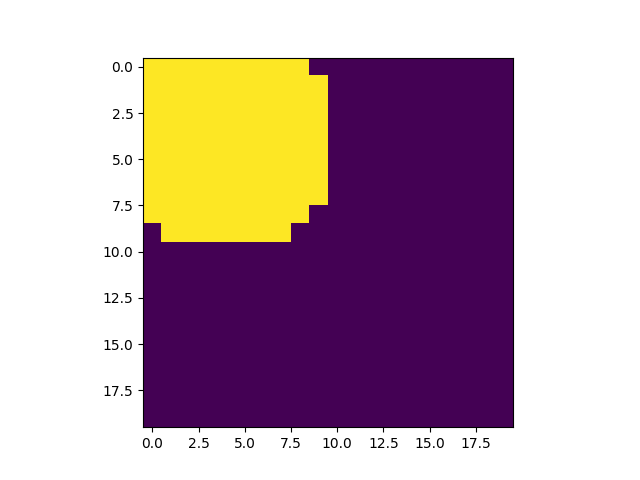

In [32]:
from skimage.draw import disk

#                 from skimage.draw import disk,circle
# #                 OneHot2D_instance_mask = np.zeros((4500,4500), dtype=np.uint8)
#                 OneHot2D_instance_mask = np.zeros((cropped_im_dim,cropped_im_dim), dtype=np.uint8)
#                 rr, cc = disk((center_x,center_y), bbox_half_len)
# #                 rr, cc = circle(center_x,center_y, radius=bbox_half_len)
#                 rr[rr>cropped_im_dim-1]=cropped_im_dim-1
#                 cc[cc>cropped_im_dim-1]=cropped_im_dim-1
# #                     rr, cc = circle(center_x,center_y, radius=bbox_half_len)
#                 OneHot2D_instance_mask[cc,rr] = 1
cropped_im_dim=20
img = np.zeros((cropped_im_dim, cropped_im_dim), dtype=np.uint8)
rr, cc = disk((4, 4), 6)

rr[rr>cropped_im_dim-1]=cropped_im_dim-1
cc[cc>cropped_im_dim-1]=cropped_im_dim-1

rr[rr<0]=0
cc[cc<0]=0

img[rr, cc] = 255
plt.figure()
plt.imshow(img)

In [29]:
# dataset_val.num_classes
rr, cc

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8,
        8, 8, 8]),
 array([2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0,
        1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4,
        5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 2, 3,
        4, 5, 6]))

In [31]:
rr, cc

(array([-1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9]),
 array([ 1,  2,  3,  4,  5,  6,  7,  0,  1,  2,  3,  4,  5,  6,  7,  8, -1,
         0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1,  0,
         1,  2,  3,  4,  5,  6,  7,  8,  9, -1,  0,  1,  2,  3,  4,  5,  6,
         7,  8,  9, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1,  0,  1,
         2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,
         1,  2,  3,  4,  5,  6,  7]))

In [13]:
print(config.RPN_ANCHOR_SCALES,
config.RPN_ANCHOR_RATIOS,
# config.backbone_shapes,
config.BACKBONE_STRIDES,
config.RPN_ANCHOR_STRIDE)

(8, 16, 32, 64, 128, 256) [0.5, 1, 2] [2, 4, 8, 16, 32, 64] 1


In [7]:
# import CellClass
# dfInfo = dfInfo[dfInfo['subset_label']=='test'];
# print(dfInfo.shape) 
# cell = CellClass.CELL(dfInfo)

In [83]:
# cell.dataset['annotations']
# cell.getImgIds(catIds=[11])

In [8]:
# dfInfo.loc[dfInfo['subset_label']=='test',:].head()

In [9]:
# dfInfo.columns

In [ ]:
rsync -rt /cmap/imaging/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/2016_04_01_a549_48hr_batch1 haghighi@dgx01.broadinstitute.org:/dgx1nas1/cellpainting-datasets/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/2016_04_01_a549_48hr_batch1

In [53]:
# dataset_val.class_from_source_map

In [54]:
# # dataset_train.class_from_source_map
# sorted(dataset_train.getCatIds())

In [55]:
# dataset_val.image_info[image_id]

In [58]:
# image_id=2
# dataset_val.source_class_ids[dataset_val.image_info[image_id]["source"]]

In [57]:
# dataset_val.image_info
# dataset_val.source_class_ids

In [56]:
# dataset_train.source_class_ids

In [59]:
# dataset_val.class_info

In [60]:
# dataset_train.class_info

In [6]:
ls /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_scratch_maskNet_def/

cell20200511T1547/  cell20200512T0040   cell20200512T0144/
cell20200511T2016/  cell20200512T0047   cell20200512T0149/
cell20200511T2238/  cell20200512T0127/  cell20200512T0214/


In [81]:
ls /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_scratch_maskNet_def/

cell20200511T1547/  cell20200512T0040   cell20200512T0144/  cell20200512T0227/
cell20200511T2016/  cell20200512T0047   cell20200512T0149/  cell20200512T0336/
cell20200511T2238/  cell20200512T0127/  cell20200512T0214/  cell20200513T0503/


In [9]:
# tensorboard --logdir /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/ --port=6009

In [10]:
# ls /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_scratch_maskNet_def/cell20200513T0503/

In [61]:
model.find_last()

'/storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_coco_maskNet_def/cell20200520T2314/mask_rcnn_cell_0050.h5'

In [23]:
# [x[0] for x in os.walk(MODEL_DIR)][1]

In [62]:
# ls /storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_scratch_maskNet_def/cell20200513T0503/

#### Inference

In [5]:
class InferenceConfig(spot.spotConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.head=maskBranchNet;
# inference_config.DETECTION_MIN_CONFIDENCE=0.8
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
# selectedEpoch='0337'
# # model_path_2=[x[0] for x in os.walk(address)][1]+'/mask_rcnn_cell_'+selectedEpoch+'.h5';
# model_path_2='/'.join(model_path.split('/')[:-1])+'/mask_rcnn_cell_'+str(selectedEpoch)+'.h5';

model_path_2=model_path
# # Load trained weights
print("Loading weights from ", model_path_2)
model.load_weights(model_path_2, by_name=True)

shared Tensor("pool_squeeze_1/Squeeze_1:0", shape=(?, 1000, 512), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits_1/Reshape_1:0", shape=(?, 1000, 5), dtype=float32)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/spotsISS/pretrained_scratch_train_all_lr_0.01_clust/spotsiss20200823T1126/mask_rcnn_spotsiss_0192.h5
Re-starting from epoch 192


In [11]:
model_path

'/storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/ISS_spots_clutering/init_with_scratch_maskNet_def_train_heads/spot20200624T0005/mask_rcnn_spot_0146.h5'

In [8]:
model_path

'/storage/data/marziehhaghighi/rareDisease/deepLearningModels/MaskRCNN/Mask_RCNN_testSet_pretrained_coco_maskNet_def_train_all/cell20200522T0027/mask_rcnn_cell_0053.h5'

In [34]:
# dataset_val.class_names

In [15]:
# dataset_train.class_names
visualize.CP_to_RGB_single(image).dtype

dtype('float64')

In [16]:
image.dtype

dtype('uint8')

In [80]:
# plt.figure()
# plt.imshow(image[:,:,2])
dataset.image_ids

array([0, 1, 2])

In [13]:
# %matplotlib inline
# plt.figure()
# plt.imshow(visualize.CP_to_RGB_single(image))

In [ ]:
print(1)

In [14]:
# visualize.CP_to_RGB_single(image).dtype

In [ ]:
dataset=copy.copy(dataset_train)
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
#     print(mask[5,5])
visualize.display_top_masks(visualize.CP_to_RGB_single(image), mask, class_ids, dataset.class_names)
# visualize.display_top_masks(image[:,:,1], mask, class_ids, dataset.class_names)

In [20]:
import skimage
image = skimage.io.imread("/home/marziehhaghighi/workspace_DL/Mask_RCNN/images/12283150_12d37e6389_z.jpg")

In [24]:
image.max()

255

In [22]:
inference_config.IMAGE_SHAPE

array([512, 512,   4])

In [26]:
inference_config.IMAGE_SHAPE=np.array([256, 256,   4])

In [18]:
ls /home/marziehhaghighi/workspace_DL/Mask_RCNN/images

LICENSE      assets/  images/              mask_rcnn_coco.h5  samples/
MANIFEST.in  build/   logs/                mrcnn/             setup.cfg
README.md    dist/    mask_rcnn.egg-info/  requirements.txt   setup.py


original_image           shape: (512, 512, 4)         min:    0.00000  max:  107.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max:  512.00000  float64
gt_class_id              shape: (72,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (72, 4)               min:    0.00000  max:  500.00000  int32
gt_mask                  shape: (512, 512, 72)        min:    0.00000  max:    1.00000  bool


<IPython.core.display.Javascript object>


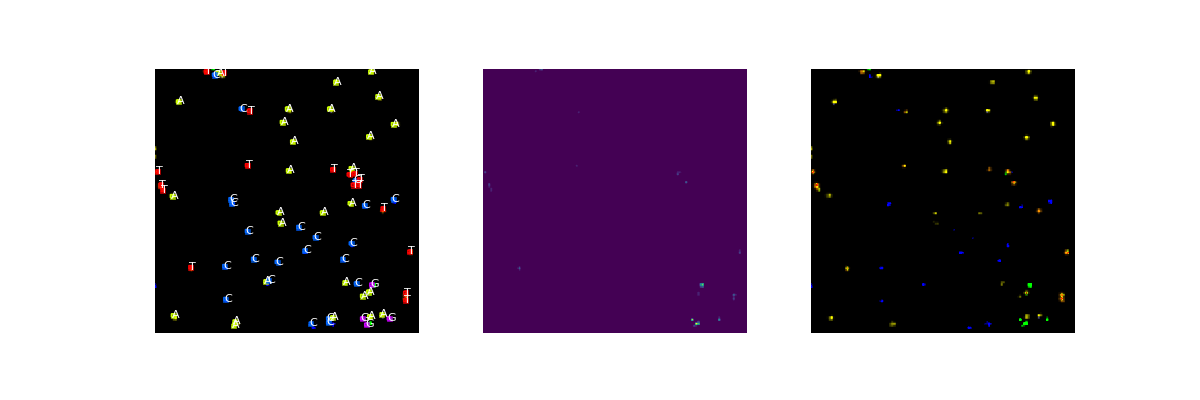

In [6]:
# %matplotlib inline
# Test on a random image from validation set
dataset=copy.copy(dataset_val)

image_id = random.choice(dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(4*3, 4),to_RGB=True, show_mask=True)

In [46]:
original_image.shape

(256, 256, 4)

In [15]:
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset, inference_config, 
#                            image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(4*3, 4),to_RGB=True, show_mask=True)

In [14]:
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset, inference_config, 
#                            image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(4*3, 4),to_RGB=True, show_mask=True)

In [33]:
original_image.shape

(256, 256, 4)

In [34]:
original_image.dtype

dtype('float64')

In [12]:
# # results
# # original_image.max()
# for i in range(10):
#     image_id = random.choice(dataset.image_ids)
#     or_image2 = dataset.load_image(image_id)
#     print(np.mean(or_image2[:,:,0]),np.mean(or_image2[:,:,1]),np.mean(or_image2[:,:,2]),np.mean(or_image2[:,:,3]))
# # or_image2.shape

In [49]:
# (or_image/or_image.max())*255

In [9]:
original_image.dtype

dtype('uint8')

In [13]:
# results = model.detect([original_image], verbose=1)
# results

Processing 1 images
image                    shape: (512, 512, 4)         min:    0.00000  max:  107.00000  uint8
image_meta (17,) [  0 512 512   4 512 512   4   0   0 512 512   1   0   0   0   0   0]
(1, 17)
molded_images            shape: (1, 512, 512, 4)      min:    0.00000  max:  107.00000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 64512, 4)         min:   -0.01107  max:    0.99494  float32


<IPython.core.display.Javascript object>


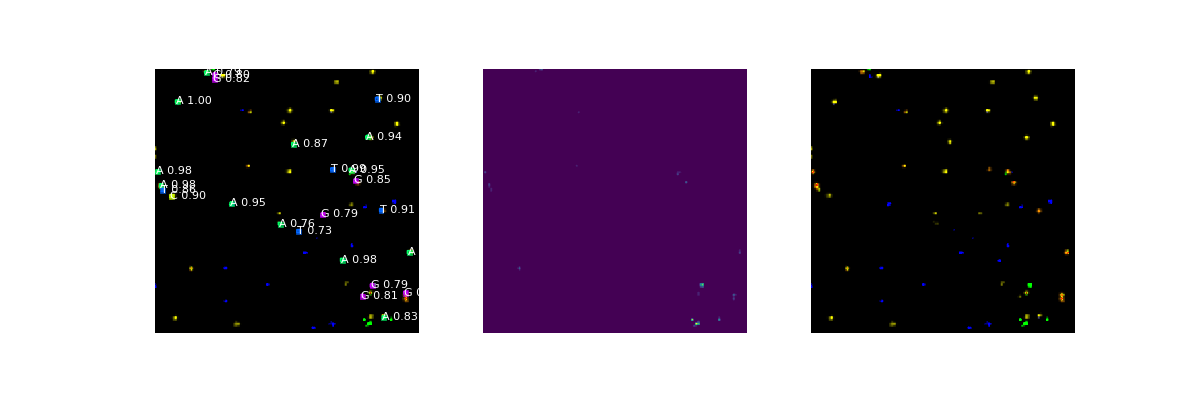

In [7]:
# %matplotlib notebook
# or_image = dataset.load_image(image_id)
# or_image2=(or_image/or_image.max())*255
results = model.detect([original_image], verbose=1)
# results
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'],figsize=(4*3, 4),to_RGB=True)
# visualize.display_instances2(original_image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_train.class_names, r['scores'],figsize=(6*3, 6))

In [6]:
# original_image

28.0

In [15]:
# fig,axes=plt.subplots(1,3,figsize=(10,30));
# axes[0].imshow(original_image[:,:,0]);axes[0].set_title('DNA');
# axes[1].imshow(original_image[:,:,1]);axes[1].set_title('Protein');
# # axes[2].imshow(CP_to_RGB_single(original_image));axes[2].set_title('color');
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            4
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   4]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [15]:
original_image.shape

(1024, 1024, 3)

In [16]:
orig_im=skimage.io.imread(imPath)
orig_im2=original_image[:,:,1]

In [17]:
orig_im.shape,orig_im2.shape

((1080, 1080), (1024, 1024))

In [20]:
orig_im.max(),orig_im2.max()

(65535, 255)

In [21]:
orig_im.min(),orig_im2.min()

(182, 0)

In [24]:
orig_im.dtype,orig_im2.dtype

(dtype('uint16'), dtype('uint8'))

In [18]:
orig_im.shape

(1080, 1080)

In [19]:
from scipy import stats
stats.describe(orig_im)

DescribeResult(nobs=1080, minmax=(array([240, 235, 219, ..., 278, 274, 279], dtype=uint16), array([ 3899,  3847,  3732, ..., 48464, 48531, 49751], dtype=uint16)), mean=array([ 491.14722222,  492.95648148,  494.69907407, ..., 5458.48796296,
       5412.7462963 , 5381.75      ]), variance=array([2.59597527e+05, 2.61089172e+05, 2.56731506e+05, ...,
       1.16336875e+08, 1.16221898e+08, 1.16668706e+08]), skewness=array([4.41157648, 4.32222954, 4.27648169, ..., 2.09518809, 2.14170093,
       2.18936505]), kurtosis=array([21.01086081, 19.90798038, 19.35927525, ...,  3.03768322,
        3.30472349,  3.56738775]))

In [69]:
dfInfo[['image_id','bbox','cat_id','P-W-S','ObjectNumber','mask']].head()

image_id                  bbox  cat_id            P-W-S  ObjectNumber  \
0        56  [570, 232, 203, 206]       5  RC4_IF_43-G04-2            12   
1        56  [189, 730, 196, 207]      18  RC4_IF_43-G04-2            33   
2        56   [243, 35, 153, 164]      12  RC4_IF_43-G04-2             2   
3        56   [106, 52, 151, 196]      12  RC4_IF_43-G04-2             3   
4        56   [479, 47, 149, 225]      12  RC4_IF_43-G04-2             4   

                                                mask  
0  /storage/data/marziehhaghighi/rareDisease/PILO...  
1  /storage/data/marziehhaghighi/rareDisease/PILO...  
2  /storage/data/marziehhaghighi/rareDisease/PILO...  
3  /storage/data/marziehhaghighi/rareDisease/PILO...  
4  /storage/data/marziehhaghighi/rareDisease/PILO...

In [67]:
dfInfo.loc[dfInfo['subset_label']=='test',:][['image_id','bbox','cat_id','P-W-S','ObjectNumber','mask']].head()

image_id                  bbox  cat_id            P-W-S  ObjectNumber  \
31         8   [905, 53, 134, 186]      11  RC4_IF_05-G04-3             4   
32         8   [147, 55, 106, 155]      11  RC4_IF_05-G04-3             5   
33         8   [628, 73, 120, 153]      11  RC4_IF_05-G04-3             6   
34         8  [767, 104, 170, 129]      11  RC4_IF_05-G04-3             7   
35         8   [470, 84, 160, 146]      11  RC4_IF_05-G04-3             8   

                                                 mask  
31  /storage/data/marziehhaghighi/rareDisease/PILO...  
32  /storage/data/marziehhaghighi/rareDisease/PILO...  
33  /storage/data/marziehhaghighi/rareDisease/PILO...  
34  /storage/data/marziehhaghighi/rareDisease/PILO...  
35  /storage/data/marziehhaghighi/rareDisease/PILO...

In [64]:
dataset.image_info[0]

{'id': 8,
 'source': 'cell',
 'path': "['/storage/data/marziehhaghighi/rareDisease/PILOT_1_maxproj/images/RC4_IF_05/r07c04f03p01-ch1sk1fk1fl1.tiff', '/storage/data/marziehhaghighi/rareDisease/PILOT_1_maxproj/images/RC4_IF_05/r07c04f03p01-ch3sk1fk1fl1.tiff', '/storage/data/marziehhaghighi/rareDisease/PILOT_1_maxproj/images/RC4_IF_05/r07c04f03p01-ch2sk1fk1fl1.tiff', '/storage/data/marziehhaghighi/rareDisease/PILOT_1_maxproj/images/RC4_IF_05/r07c04f03p01-ch4sk1fk1fl1.tiff']",
 'width': 1080,
 'height': 1080,
 'annotations': []}

<IPython.core.display.Javascript object>


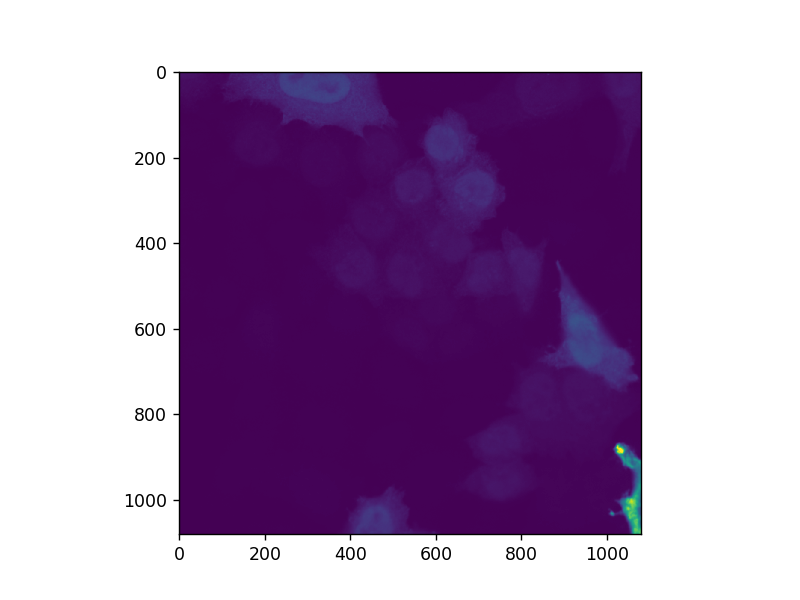

In [35]:
plt.figure()
plt.imshow(dataset.load_image(image_id)[:,:,1]);axes[0].set_title('Protein');

In [85]:
# dataset_test.load_image(image_id)

<IPython.core.display.Javascript object>


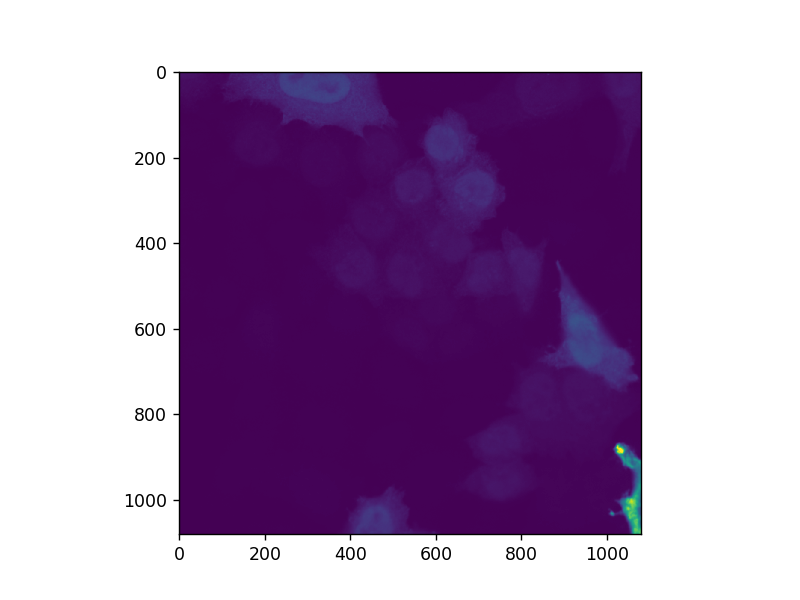

In [32]:
# dataset_test.load_image(image_id)
import skimage.io
from ast import literal_eval
imPath=literal_eval(dataset.image_info[image_id]['path'])[2]

plt.figure()
plt.imshow(skimage.io.imread(imPath))
#         print(len(listOfPaths))
#         listOfPaths=[listOfPaths[0],listOfPaths[2]]
#         listOfPaths=[listOfPaths[2]]
#         imagesList=[]
#         for imPath in listOfPaths:
# #             print(imPath)
#             imagesList.append(skimage.io.imread(imPath).astype('uint8'))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
image_meta (32,) [   0 1024 1024    3 1024 1024    3    0    0 1024 1024    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
(1, 32)
molded_images            shape: (1, 1024, 1024, 3)    min: -128.00000  max:  126.00000  float64
image_metas              shape: (1, 32)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32


<IPython.core.display.Javascript object>


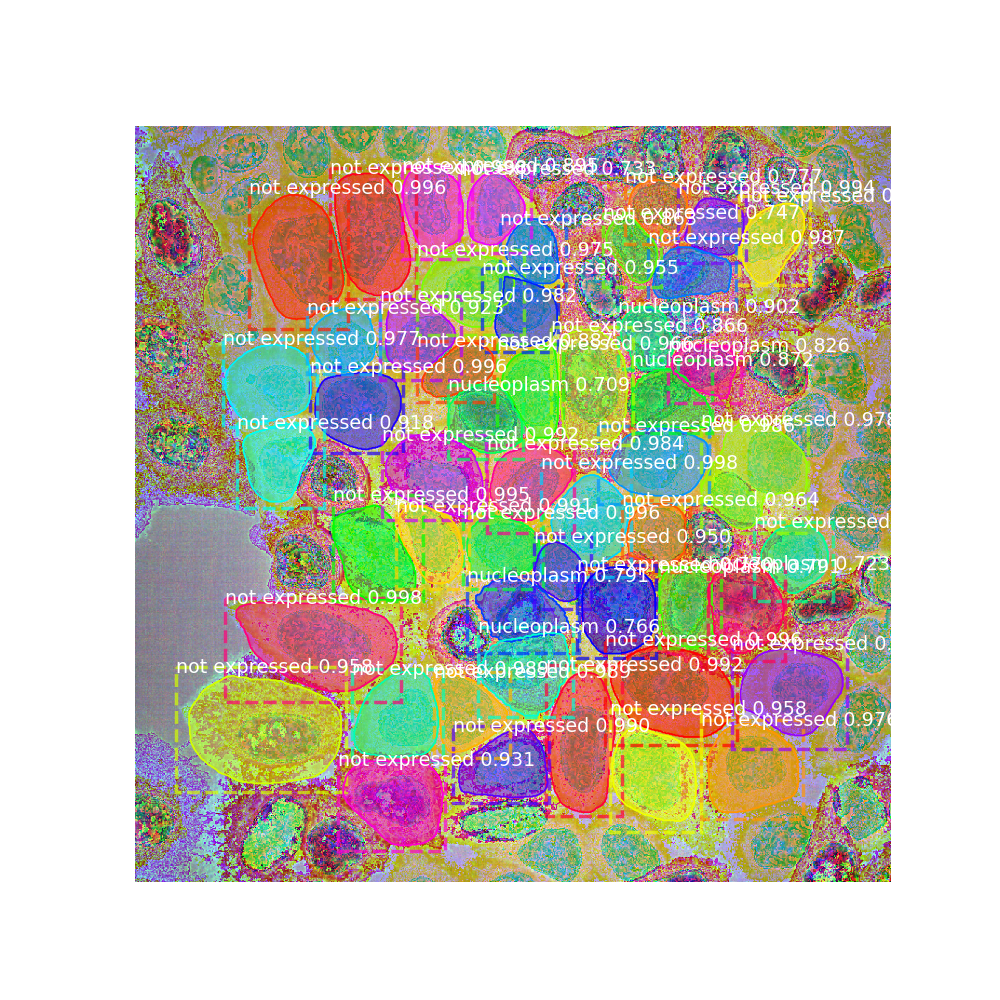

In [51]:
results = model.detect([original_image], verbose=1)
# results
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'],figsize=(8, 8))

In [16]:
original_image

array([[[123, 145, 192],
        [113, 138, 164],
        [118, 134, 170],
        ...,
        [  2, 152,  80],
        [ 13, 192, 172],
        [ 31, 223, 208]],

       [[129, 126, 179],
        [113, 123, 189],
        [114, 124, 205],
        ...,
        [ 25, 180, 112],
        [ 19, 196, 182],
        [ 14, 249,  49]],

       [[126, 120, 185],
        [118, 131, 204],
        [116, 147, 180],
        ...,
        [ 71, 168, 136],
        [ 77, 152,  41],
        [ 44, 210,  78]],

       ...,

       [[108, 124, 195],
        [124, 120, 195],
        [115, 126, 180],
        ...,
        [150, 114,  57],
        [137, 163, 113],
        [142, 228, 202]],

       [[104, 125, 182],
        [121, 121, 183],
        [124, 129, 173],
        ...,
        [140, 147,  66],
        [145, 162, 122],
        [126, 172, 179]],

       [[117, 127, 201],
        [132, 127, 165],
        [130, 130, 192],
        ...,
        [122,  61,  47],
        [143,  45,  78],
        [135, 114, 129]]

In [33]:
original_image.shape

(128, 128, 1)

# Example 2:
    * single cell detection/segmentation and clustering

In [14]:

original_image[:,:,0].shape

(128, 128)

In [72]:
import numpy as np
a=np.random.rand(5,10)
b=np.random.rand(5,10)

In [5]:
a

array([[0.61663802, 0.61383717, 0.87066265, 0.96142386, 0.33702554,
        0.02570697, 0.51764306, 0.67732591, 0.34833994, 0.08976734],
       [0.97313637, 0.82789055, 0.29779494, 0.25196196, 0.79023423,
        0.98380147, 0.65862496, 0.5168325 , 0.12261395, 0.1228047 ],
       [0.92379016, 0.51688631, 0.7518936 , 0.51252832, 0.52000422,
        0.0211729 , 0.58997096, 0.74332169, 0.73286817, 0.86289996],
       [0.73224991, 0.92540816, 0.85502321, 0.74281178, 0.66211381,
        0.65277928, 0.42671495, 0.7061217 , 0.18269861, 0.82430231],
       [0.27834282, 0.1199197 , 0.51363298, 0.1207112 , 0.78528219,
        0.21111073, 0.06885176, 0.34589997, 0.28795184, 0.96193354]])

In [20]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')
distMat=dist.pairwise(a,b)

In [42]:
a[1,:]=np.nan
distMat=dist.pairwise(a,b)

In [45]:
distMat=distMat/np.nansum(distMat,axis=0)

In [46]:
distMat

array([[0.26154628, 0.21074095, 0.22038478, 0.20561807, 0.27869796],
       [       nan,        nan,        nan,        nan,        nan],
       [0.22709331, 0.22153612, 0.24308125, 0.28042593, 0.23947618],
       [0.18155977, 0.26286605, 0.24848488, 0.26448651, 0.27743563],
       [0.32980064, 0.30485688, 0.28804909, 0.24946949, 0.20439023]])

In [48]:
np.nansum(distMat,axis=0)

array([1., 1., 1., 1., 1.])

In [26]:
distMat.sum(axis=0)

array([1., 1., 1., 1., 1.])

In [ ]:
distMat=dist.pairwise(a,b)

In [19]:
a.sum(axis=1)

array([5.05837045, 5.54569564, 6.1753363 , 6.7102237 , 3.69363673])

In [68]:
map_dict={}
min_dist_clusters=np.argmin(distMat,axis=1)
non_nan_indexes=np.delete(range(5), 1)
# non_nan_indexes
for ci in non_nan_indexes:
    map_dict[ci]=min_dist_clusters[ci]

In [69]:
map_dict

{0: 3, 2: 1, 3: 0, 4: 4}

In [52]:
np.argmin(distMat,axis=1)

array([3, 0, 1, 0, 4])

In [65]:
(x==np.nan)

array([False, False, False, False, False])

In [61]:
x=distMat.sum(axis=1)

In [85]:
import numpy as np
a=np.random.rand(5,10)
b=np.random.rand(5,10)

In [106]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

# nan_index_a=1
nan_index_b=2

# a[nan_index_a,:]=np.nan
b[nan_index_b,:]=np.nan

distMat=dist.pairwise(a,b)
distMat=distMat/np.nansum(distMat,axis=0)
map_dict={}
ordered_ass=np.argsort(distMat,axis=1)
min_dist_clusters=np.nanargmin(distMat,axis=1)
min_dist=np.nanmin(distMat,axis=1)
confid_ordered_labels = np.argsort(min_dist)
# non_nan_indexes=np.delete(range(5), 1)
non_nan_indexes=list(range(5))
for ci in range(5):
#     min_dist_clusters[ci]
    ind_cluster_to_ass=confid_ordered_labels[ci]
    if min_dist_clusters[ind_cluster_to_ass] in non_nan_indexes:
        map_dict[ind_cluster_to_ass]=min_dist_clusters[ind_cluster_to_ass]
        non_nan_indexes.remove(min_dist_clusters[ind_cluster_to_ass])
    else:
        i=1
        while ordered_ass[ind_cluster_to_ass,i] not in non_nan_indexes:
            i += 1
#         for i in range(1,5):
        to_cl=ordered_ass[ind_cluster_to_ass,i]
        map_dict[ind_cluster_to_ass]=to_cl
        non_nan_indexes.remove(to_cl)
    
map_dict
# min_dist_clusters

{4: 3, 3: 1, 2: 4, 0: 0, 1: 2}

In [104]:
min_dist_clusters

array([0, 1, 3, 1, 3])

In [105]:
min_dist

array([0.15761832, 0.21985004, 0.15649114, 0.13887848, 0.12695672])

In [99]:
np.argsort(min_dist)

array([4, 3, 2, 0, 1])

In [95]:
np.sort(distMat,axis=1)

array([[0.15761832, 0.23592548, 0.2729561 , 0.30295652,        nan],
       [0.21985004, 0.22560486, 0.2421656 , 0.26896968,        nan],
       [0.15649114, 0.19101082, 0.19149405, 0.19292334,        nan],
       [0.13887848, 0.16668402, 0.17462637, 0.2368094 ,        nan],
       [0.12695672, 0.14730414, 0.16373085, 0.18704409,        nan]])

In [100]:
ordered_ass=np.argsort(distMat,axis=1)
ordered_ass

array([[0, 4, 3, 1, 2],
       [1, 0, 4, 3, 2],
       [3, 1, 4, 0, 2],
       [1, 4, 3, 0, 2],
       [3, 1, 4, 0, 2]])

In [102]:
ordered_ass[:,1]

array([4, 0, 1, 4, 1])

In [107]:
np.nans((2,3))

AttributeError: module 'numpy' has no attribute 'nans'